In [1]:
%load_ext autoreload
%autoreload 2

import sys
import os
import time

import numpy as np
import mxnet as mx
import matplotlib.pyplot as plt
%matplotlib inline

sys.path.append(os.environ['REPO_DIR'] + '/utilities')
from utilities2015 import *
from metadata import *
from data_manager import *
from learning_utilities import *
from distributed_utilities import *

/usr/local/lib/python2.7/dist-packages/matplotlib/__init__.py:1405: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)
No vtk
Child returned 0


Setting environment for AWS compute node
rm -rf /shared/CSHL_data_processed/MD635/MD635_alignedTo_MD635-F63-2016.05.19-08.39.03_MD635_2_0188_cropbox.txt && mkdir -p /shared/CSHL_data_processed/MD635
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD635/MD635_alignedTo_MD635-F63-2016.05.19-08.39.03_MD635_2_0188_cropbox.txt /shared/CSHL_data_processed/MD635/MD635_alignedTo_MD635-F63-2016.05.19-08.39.03_MD635_2_0188_cropbox.txt


Child returned 1
0.50 seconds.
Child returned 0


rm -rf /shared/CSHL_data_processed/MD635/MD635_alignedTo_MD635-F63-2016.05.19-08.39.03_MD635_2_0188_cropbox.txt && mkdir -p /shared/CSHL_data_processed/MD635
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD635/MD635_alignedTo_MD635-F63-2016.05.19-08.39.03_MD635_2_0188_cropbox.txt /shared/CSHL_data_processed/MD635/MD635_alignedTo_MD635-F63-2016.05.19-08.39.03_MD635_2_0188_cropbox.txt


Child returned 1
0.41 seconds.
File does not exist: /shared/CSHL_data_processed/MD635/MD635_alignedTo_MD635-F63-2016.05.19-08.39.03_MD635_2_0188_cropbox.txt
Child returned 0


rm -rf /shared/CSHL_data_processed/MD635/MD635_alignedTo_MD635-F63-2016.05.19-08.39.03_MD635_2_0188_cropbox.txt && mkdir -p /shared/CSHL_data_processed/MD635
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD635/MD635_alignedTo_MD635-F63-2016.05.19-08.39.03_MD635_2_0188_cropbox.txt /shared/CSHL_data_processed/MD635/MD635_alignedTo_MD635-F63-2016.05.19-08.39.03_MD635_2_0188_cropbox.txt


Child returned 1
0.42 seconds.
File does not exist: /shared/CSHL_data_processed/MD635/MD635_alignedTo_MD635-F63-2016.05.19-08.39.03_MD635_2_0188_cropbox.txt


In [9]:
download_from_s3(os.path.join(MXNET_MODEL_ROOTDIR, model_dir_name), is_dir=True, redownload=True)

rm -rf /shared/mxnet_models/inception-bn-blue && mkdir -p /shared/mxnet_models
aws s3 cp --recursive s3://mousebrainatlas-data/mxnet_models/inception-bn-blue /shared/mxnet_models/inception-bn-blue


Child returned 0
Child returned 0
1.82 seconds.


In [24]:
# Does not work for the mxnet version on 3/30/2017
# model_dir_name = 'Sat16ClassFinetuned'
# model_name = 'Sat16ClassFinetuned'
# model_iteration = 10
# output_symbol_name = 'flatten_output'
# mean_img = np.load(os.path.join(MODEL_ROOTDIR, model_dir_name, 'saturation_mean_224.npy'))

# model_dir_name = 'vgg16-blue'
# model_name = 'vgg16-blue'
# model_iteration = 0
# output_symbol_name = 'fc7_output'
# output_dim = 4096
# mean_img = np.load(os.path.join(MODEL_ROOTDIR, model_dir_name, 'vgg_mean.npy'))

# model_dir_name = 'vgg19'
# model_name = 'vgg19'
# model_iteration = 0
# output_symbol_name = 'fc8_output'

# model_dir_name = 'inception-bn'
# model_name = 'Inception-BN'
# model_iteration = 126
# output_symbol_name = 'flatten_output'
# mean_img = mx.nd.load(os.path.join(MODEL_ROOTDIR, model_dir_name, 'mean_224.nd'))['mean_img'].asnumpy()

model_dir_name = 'inception-bn-blue'
model_name = 'inception-bn-blue'
model_iteration = 0
output_symbol_name = 'flatten_output'
output_dim = 1024
mean_img = np.load(os.path.join(MXNET_MODEL_ROOTDIR, model_dir_name, 'mean_224.npy'))

# Reference on how to predict with mxnet model:
# https://github.com/dmlc/mxnet-notebooks/blob/master/python/how_to/predict.ipynb
model0, arg_params, aux_params = mx.model.load_checkpoint(os.path.join(MXNET_MODEL_ROOTDIR, model_dir_name, model_name), 0)
flatten_output = model0.get_internals()[output_symbol_name]
model = mx.mod.Module(context=[mx.gpu(i) for i in range(8)], 
                        symbol=flatten_output)

# model_dir_name = 'inception-bn-sat'
# model_name = 'inception-bn-sat'
# model_iteration = 0
# mean_img = np.load(os.path.join(MODEL_ROOTDIR, model_dir_name, 'mean_224.npy'))

# model = mx.model.FeedForward.load(os.path.join(MODEL_ROOTDIR, model_dir_name, model_name), model_iteration, ctx=mx.gpu())

In [25]:
# Visualize network topology

# a = mx.viz.plot_network(flatten_output, shape={"data":(1, 1, 224, 224)}, node_attrs={"shape":'rect',"fixedsize":'false'})
# a.render(model_name)

In [26]:
patch_size = 224
half_size = patch_size/2
stride = 56

In [27]:
# def convert_to_saturation(img, rescale=True):
#     """
#     Generate saturation channel as a grayscale image.
#     """
#     ma = img.max(axis=-1)
#     mi = img.min(axis=-1)
# #     sys.stderr.write('compute min and max color components: %.2f seconds\n' % (time.time() - t1)) # ~5s

# #     t1 = time.time()
#     s = np.nan_to_num(mi/ma.astype(np.float))
# #     sys.stderr.write('min oiver max: %.2f seconds\n' % (time.time() - t1)) # ~2s

# #     t1 = time.time()
#     if rescale:
#         pmax = s.max()
#         pmin = s.min()
#         s = (s - pmin) / (pmax - pmin)
# #     sys.stderr.write('rescale: %.2f seconds\n' % (time.time() - t1)) # ~3s

#     return img_as_ubyte(s)

In [30]:
for stack in [
 'MD593',
 'MD594',
 'MD595',
 'MD598',
 'MD599',
 'MD602',
 'MD603']:
    download_from_s3(DataManager.get_thumbnail_mask_dir_v2(stack=stack), is_dir=True)

rm -rf /shared/CSHL_data_processed/MD594/MD594_masks_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped && mkdir -p /shared/CSHL_data_processed/MD594
aws s3 cp --recursive s3://mousebrainatlas-data/CSHL_data_processed/MD594/MD594_masks_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped /shared/CSHL_data_processed/MD594/MD594_masks_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped


Child returned 0
Child returned 0
3.57 seconds.
Child returned 0


rm -rf /shared/CSHL_data_processed/MD595/MD595_masks_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped && mkdir -p /shared/CSHL_data_processed/MD595
aws s3 cp --recursive s3://mousebrainatlas-data/CSHL_data_processed/MD595/MD595_masks_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped /shared/CSHL_data_processed/MD595/MD595_masks_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped


Child returned 0
3.68 seconds.
Child returned 0


rm -rf /shared/CSHL_data_processed/MD598/MD598_masks_alignedTo_MD598-N42-2015.09.29-19.26.12_MD598_2_0125_cropped && mkdir -p /shared/CSHL_data_processed/MD598
aws s3 cp --recursive s3://mousebrainatlas-data/CSHL_data_processed/MD598/MD598_masks_alignedTo_MD598-N42-2015.09.29-19.26.12_MD598_2_0125_cropped /shared/CSHL_data_processed/MD598/MD598_masks_alignedTo_MD598-N42-2015.09.29-19.26.12_MD598_2_0125_cropped


Child returned 0
3.53 seconds.
Child returned 0


rm -rf /shared/CSHL_data_processed/MD599/MD599_masks_alignedTo_MD599-IHC40-2015.10.03-06.04.31_MD599_2_0119_cropped && mkdir -p /shared/CSHL_data_processed/MD599
aws s3 cp --recursive s3://mousebrainatlas-data/CSHL_data_processed/MD599/MD599_masks_alignedTo_MD599-IHC40-2015.10.03-06.04.31_MD599_2_0119_cropped /shared/CSHL_data_processed/MD599/MD599_masks_alignedTo_MD599-IHC40-2015.10.03-06.04.31_MD599_2_0119_cropped


Child returned 0
3.70 seconds.
Child returned 0


rm -rf /shared/CSHL_data_processed/MD602/MD602_masks_alignedTo_MD602-N49-2015.12.01-18.41.46_MD602_2_0146_cropped && mkdir -p /shared/CSHL_data_processed/MD602
aws s3 cp --recursive s3://mousebrainatlas-data/CSHL_data_processed/MD602/MD602_masks_alignedTo_MD602-N49-2015.12.01-18.41.46_MD602_2_0146_cropped /shared/CSHL_data_processed/MD602/MD602_masks_alignedTo_MD602-N49-2015.12.01-18.41.46_MD602_2_0146_cropped


Child returned 0
4.65 seconds.
Child returned 0


rm -rf /shared/CSHL_data_processed/MD603/MD603_masks_alignedTo_MD603-N60-2015.12.03-23.57.05_MD603_2_0179_cropped && mkdir -p /shared/CSHL_data_processed/MD603
aws s3 cp --recursive s3://mousebrainatlas-data/CSHL_data_processed/MD603/MD603_masks_alignedTo_MD603-N60-2015.12.03-23.57.05_MD603_2_0179_cropped /shared/CSHL_data_processed/MD603/MD603_masks_alignedTo_MD603-N60-2015.12.03-23.57.05_MD603_2_0179_cropped


Child returned 0
3.64 seconds.


In [ ]:
for stack in [
 'MD598']:
    
    first_detect_sec, last_detect_sec = metadata_cache['section_limits'][stack]
    
    t = time.time()
#     for sec in range(166, 167):
    for sec in range(first_detect_sec, last_detect_sec+1):
        try:
            download_from_s3(DataManager.get_image_filepath(stack=stack, section=sec, version='cropped_gray'), redownload=True)
        except:
            pass
    # 450 second to download one stack
    
    print time.time() - t

rm -rf /shared/CSHL_data_processed/MD598/MD598_lossless_alignedTo_MD598-N42-2015.09.29-19.26.12_MD598_2_0125_cropped_gray/MD598-N18-2015.09.29-17.40.03_MD598_3_0054_lossless_alignedTo_MD598-N42-2015.09.29-19.26.12_MD598_2_0125_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD598/MD598_lossless_alignedTo_MD598-N42-2015.09.29-19.26.12_MD598_2_0125_cropped_gray


Child returned 0


aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD598/MD598_lossless_alignedTo_MD598-N42-2015.09.29-19.26.12_MD598_2_0125_cropped_gray/MD598-N18-2015.09.29-17.40.03_MD598_3_0054_lossless_alignedTo_MD598-N42-2015.09.29-19.26.12_MD598_2_0125_cropped_gray.tif /shared/CSHL_data_processed/MD598/MD598_lossless_alignedTo_MD598-N42-2015.09.29-19.26.12_MD598_2_0125_cropped_gray/MD598-N18-2015.09.29-17.40.03_MD598_3_0054_lossless_alignedTo_MD598-N42-2015.09.29-19.26.12_MD598_2_0125_cropped_gray.tif


Child returned 0
4.38 seconds.
Child returned

rm -rf /shared/CSHL_data_processed/MD598/MD598_lossless_alignedTo_MD598-N42-2015.09.29-19.26.12_MD598_2_0125_cropped_gray/MD598-IHC18-2015.09.29-23.17.22_MD598_3_0054_lossless_alignedTo_MD598-N42-2015.09.29-19.26.12_MD598_2_0125_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD598/MD598_lossless_alignedTo_MD598-N42-2015.09.29-19.26.12_MD598_2_0125_cropped_gray


 0
Child returned 0
3.95 seconds.


aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD598/MD598_lossless_alignedTo_MD598-N42-2015.09.29-19.26.12_MD598_2_0125_cropped_gray/MD598-IHC18-2015.09.29-23.17.22_MD598_3_0054_lossless_alignedTo_MD598-N42-2015.09.29-19.26.12_MD598_2_0125_cropped_gray.tif /shared/CSHL_data_processed/MD598/MD598_lossless_alignedTo_MD598-N42-2015.09.29-19.26.12_MD598_2_0125_cropped_gray/MD598-IHC18-2015.09.29-23.17.22_MD598_3_0054_lossless_alignedTo_MD598-N42-2015.09.29-19.26.12_MD598_2_0125_cropped_gray.tif
rm -rf /shared/CSHL_data_processed/MD598/MD598_lossless_alignedTo_MD598-N42-2015.09.29-19.26.12_MD598_2_0125_cropped_gray/MD598-N19-2015.09.29-17.44.22_MD598_1_0055_lossless_alignedTo_MD598-N42-2015.09.29-19.26.12_MD598_2_0125_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD598/MD598_lossless_alignedTo_MD598-N42-2015.09.29-19.26.12_MD598_2_0125_cropped_gray


Child returned 0


aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD598/MD598_lossless_alignedTo_MD598-N42-2015.09.29-19.26.12_MD598_2_0125_cropped_gray/MD598-N19-2015.09.29-17.44.22_MD598_1_0055_lossless_alignedTo_MD598-N42-2015.09.29-19.26.12_MD598_2_0125_cropped_gray.tif /shared/CSHL_data_processed/MD598/MD598_lossless_alignedTo_MD598-N42-2015.09.29-19.26.12_MD598_2_0125_cropped_gray/MD598-N19-2015.09.29-17.44.22_MD598_1_0055_lossless_alignedTo_MD598-N42-2015.09.29-19.26.12_MD598_2_0125_cropped_gray.tif


Child returned 0
4.28 seconds.
Child returned 0


rm -rf /shared/CSHL_data_processed/MD598/MD598_lossless_alignedTo_MD598-N42-2015.09.29-19.26.12_MD598_2_0125_cropped_gray/MD598-IHC19-2015.09.29-23.21.48_MD598_1_0055_lossless_alignedTo_MD598-N42-2015.09.29-19.26.12_MD598_2_0125_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD598/MD598_lossless_alignedTo_MD598-N42-2015.09.29-19.26.12_MD598_2_0125_cropped_gray
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD598/MD598_lossless_alignedTo_MD598-N42-2015.09.29-19.26.12_MD598_2_0125_cropped_gray/MD598-IHC19-2015.09.29-23.21.48_MD598_1_0055_lossless_alignedTo_MD598-N42-2015.09.29-19.26.12_MD598_2_0125_cropped_gray.tif /shared/CSHL_data_processed/MD598/MD598_lossless_alignedTo_MD598-N42-2015.09.29-19.26.12_MD598_2_0125_cropped_gray/MD598-IHC19-2015.09.29-23.21.48_MD598_1_0055_lossless_alignedTo_MD598-N42-2015.09.29-19.26.12_MD598_2_0125_cropped_gray.tif


Child returned 0
3.21 seconds.
Child returned 0

rm -rf /shared/CSHL_data_processed/MD598/MD598_lossless_alignedTo_MD598-N42-2015.09.29-19.26.12_MD598_2_0125_cropped_gray/MD598-N19-2015.09.29-17.44.22_MD598_2_0056_lossless_alignedTo_MD598-N42-2015.09.29-19.26.12_MD598_2_0125_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD598/MD598_lossless_alignedTo_MD598-N42-2015.09.29-19.26.12_MD598_2_0125_cropped_gray
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD598/MD598_lossless_alignedTo_MD598-N42-2015.09.29-19.26.12_MD598_2_0125_cropped_gray/MD598-N19-2015.09.29-17.44.22_MD598_2_0056_lossless_alignedTo_MD598-N42-2015.09.29-19.26.12_MD598_2_0125_cropped_gray.tif /shared/CSHL_data_processed/MD598/MD598_lossless_alignedTo_MD598-N42-2015.09.29-19.26.12_MD598_2_0125_cropped_gray/MD598-N19-2015.09.29-17.44.22_MD598_2_0056_lossless_alignedTo_MD598-N42-2015.09.29-19.26.12_MD598_2_0125_cropped_gray.tif



Child returned 0
3.43 seconds.


rm -rf /shared/CSHL_data_processed/MD598/MD598_lossless_alignedTo_MD598-N42-2015.09.29-19.26.12_MD598_2_0125_cropped_gray/MD598-IHC19-2015.09.29-23.21.48_MD598_2_0056_lossless_alignedTo_MD598-N42-2015.09.29-19.26.12_MD598_2_0125_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD598/MD598_lossless_alignedTo_MD598-N42-2015.09.29-19.26.12_MD598_2_0125_cropped_gray


Child returned 0


aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD598/MD598_lossless_alignedTo_MD598-N42-2015.09.29-19.26.12_MD598_2_0125_cropped_gray/MD598-IHC19-2015.09.29-23.21.48_MD598_2_0056_lossless_alignedTo_MD598-N42-2015.09.29-19.26.12_MD598_2_0125_cropped_gray.tif /shared/CSHL_data_processed/MD598/MD598_lossless_alignedTo_MD598-N42-2015.09.29-19.26.12_MD598_2_0125_cropped_gray/MD598-IHC19-2015.09.29-23.21.48_MD598_2_0056_lossless_alignedTo_MD598-N42-2015.09.29-19.26.12_MD598_2_0125_cropped_gray.tif


Child returned 0
4.22 seconds.
Child returned 0


rm -rf /shared/CSHL_data_processed/MD598/MD598_lossless_alignedTo_MD598-N42-2015.09.29-19.26.12_MD598_2_0125_cropped_gray/MD598-N19-2015.09.29-17.44.22_MD598_3_0057_lossless_alignedTo_MD598-N42-2015.09.29-19.26.12_MD598_2_0125_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD598/MD598_lossless_alignedTo_MD598-N42-2015.09.29-19.26.12_MD598_2_0125_cropped_gray
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD598/MD598_lossless_alignedTo_MD598-N42-2015.09.29-19.26.12_MD598_2_0125_cropped_gray/MD598-N19-2015.09.29-17.44.22_MD598_3_0057_lossless_alignedTo_MD598-N42-2015.09.29-19.26.12_MD598_2_0125_cropped_gray.tif /shared/CSHL_data_processed/MD598/MD598_lossless_alignedTo_MD598-N42-2015.09.29-19.26.12_MD598_2_0125_cropped_gray/MD598-N19-2015.09.29-17.44.22_MD598_3_0057_lossless_alignedTo_MD598-N42-2015.09.29-19.26.12_MD598_2_0125_cropped_gray.tif


Child returned 0
3.83 seconds.
Child returned

rm -rf /shared/CSHL_data_processed/MD598/MD598_lossless_alignedTo_MD598-N42-2015.09.29-19.26.12_MD598_2_0125_cropped_gray/MD598-IHC19-2015.09.29-23.21.48_MD598_3_0057_lossless_alignedTo_MD598-N42-2015.09.29-19.26.12_MD598_2_0125_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD598/MD598_lossless_alignedTo_MD598-N42-2015.09.29-19.26.12_MD598_2_0125_cropped_gray
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD598/MD598_lossless_alignedTo_MD598-N42-2015.09.29-19.26.12_MD598_2_0125_cropped_gray/MD598-IHC19-2015.09.29-23.21.48_MD598_3_0057_lossless_alignedTo_MD598-N42-2015.09.29-19.26.12_MD598_2_0125_cropped_gray.tif /shared/CSHL_data_processed/MD598/MD598_lossless_alignedTo_MD598-N42-2015.09.29-19.26.12_MD598_2_0125_cropped_gray/MD598-IHC19-2015.09.29-23.21.48_MD598_3_0057_lossless_alignedTo_MD598-N42-2015.09.29-19.26.12_MD598_2_0125_cropped_gray.tif


 0
Child returned 0
3.33 seconds.
Child returned 0


rm -rf /shared/CSHL_data_processed/MD598/MD598_lossless_alignedTo_MD598-N42-2015.09.29-19.26.12_MD598_2_0125_cropped_gray/MD598-N20-2015.09.29-17.48.35_MD598_1_0058_lossless_alignedTo_MD598-N42-2015.09.29-19.26.12_MD598_2_0125_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD598/MD598_lossless_alignedTo_MD598-N42-2015.09.29-19.26.12_MD598_2_0125_cropped_gray
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD598/MD598_lossless_alignedTo_MD598-N42-2015.09.29-19.26.12_MD598_2_0125_cropped_gray/MD598-N20-2015.09.29-17.48.35_MD598_1_0058_lossless_alignedTo_MD598-N42-2015.09.29-19.26.12_MD598_2_0125_cropped_gray.tif /shared/CSHL_data_processed/MD598/MD598_lossless_alignedTo_MD598-N42-2015.09.29-19.26.12_MD598_2_0125_cropped_gray/MD598-N20-2015.09.29-17.48.35_MD598_1_0058_lossless_alignedTo_MD598-N42-2015.09.29-19.26.12_MD598_2_0125_cropped_gray.tif


Child returned 0
3.42 seconds.
Child returned 0

rm -rf /shared/CSHL_data_processed/MD598/MD598_lossless_alignedTo_MD598-N42-2015.09.29-19.26.12_MD598_2_0125_cropped_gray/MD598-IHC20-2015.09.29-23.26.08_MD598_1_0058_lossless_alignedTo_MD598-N42-2015.09.29-19.26.12_MD598_2_0125_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD598/MD598_lossless_alignedTo_MD598-N42-2015.09.29-19.26.12_MD598_2_0125_cropped_gray
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD598/MD598_lossless_alignedTo_MD598-N42-2015.09.29-19.26.12_MD598_2_0125_cropped_gray/MD598-IHC20-2015.09.29-23.26.08_MD598_1_0058_lossless_alignedTo_MD598-N42-2015.09.29-19.26.12_MD598_2_0125_cropped_gray.tif /shared/CSHL_data_processed/MD598/MD598_lossless_alignedTo_MD598-N42-2015.09.29-19.26.12_MD598_2_0125_cropped_gray/MD598-IHC20-2015.09.29-23.26.08_MD598_1_0058_lossless_alignedTo_MD598-N42-2015.09.29-19.26.12_MD598_2_0125_cropped_gray.tif



Child returned 0
3.61 seconds.
Child returned 

rm -rf /shared/CSHL_data_processed/MD598/MD598_lossless_alignedTo_MD598-N42-2015.09.29-19.26.12_MD598_2_0125_cropped_gray/MD598-N20-2015.09.29-17.48.35_MD598_2_0059_lossless_alignedTo_MD598-N42-2015.09.29-19.26.12_MD598_2_0125_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD598/MD598_lossless_alignedTo_MD598-N42-2015.09.29-19.26.12_MD598_2_0125_cropped_gray
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD598/MD598_lossless_alignedTo_MD598-N42-2015.09.29-19.26.12_MD598_2_0125_cropped_gray/MD598-N20-2015.09.29-17.48.35_MD598_2_0059_lossless_alignedTo_MD598-N42-2015.09.29-19.26.12_MD598_2_0125_cropped_gray.tif /shared/CSHL_data_processed/MD598/MD598_lossless_alignedTo_MD598-N42-2015.09.29-19.26.12_MD598_2_0125_cropped_gray/MD598-N20-2015.09.29-17.48.35_MD598_2_0059_lossless_alignedTo_MD598-N42-2015.09.29-19.26.12_MD598_2_0125_cropped_gray.tif


0
Child returned 0
3.55 seconds.


rm -rf /shared/CSHL_data_processed/MD598/MD598_lossless_alignedTo_MD598-N42-2015.09.29-19.26.12_MD598_2_0125_cropped_gray/MD598-IHC20-2015.09.29-23.26.08_MD598_2_0059_lossless_alignedTo_MD598-N42-2015.09.29-19.26.12_MD598_2_0125_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD598/MD598_lossless_alignedTo_MD598-N42-2015.09.29-19.26.12_MD598_2_0125_cropped_gray


Child returned 0


aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD598/MD598_lossless_alignedTo_MD598-N42-2015.09.29-19.26.12_MD598_2_0125_cropped_gray/MD598-IHC20-2015.09.29-23.26.08_MD598_2_0059_lossless_alignedTo_MD598-N42-2015.09.29-19.26.12_MD598_2_0125_cropped_gray.tif /shared/CSHL_data_processed/MD598/MD598_lossless_alignedTo_MD598-N42-2015.09.29-19.26.12_MD598_2_0125_cropped_gray/MD598-IHC20-2015.09.29-23.26.08_MD598_2_0059_lossless_alignedTo_MD598-N42-2015.09.29-19.26.12_MD598_2_0125_cropped_gray.tif


Child returned 0
3.79 seconds.


rm -rf /shared/CSHL_data_processed/MD598/MD598_lossless_alignedTo_MD598-N42-2015.09.29-19.26.12_MD598_2_0125_cropped_gray/MD598-N20-2015.09.29-17.48.35_MD598_3_0060_lossless_alignedTo_MD598-N42-2015.09.29-19.26.12_MD598_2_0125_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD598/MD598_lossless_alignedTo_MD598-N42-2015.09.29-19.26.12_MD598_2_0125_cropped_gray


Child returned 0


aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD598/MD598_lossless_alignedTo_MD598-N42-2015.09.29-19.26.12_MD598_2_0125_cropped_gray/MD598-N20-2015.09.29-17.48.35_MD598_3_0060_lossless_alignedTo_MD598-N42-2015.09.29-19.26.12_MD598_2_0125_cropped_gray.tif /shared/CSHL_data_processed/MD598/MD598_lossless_alignedTo_MD598-N42-2015.09.29-19.26.12_MD598_2_0125_cropped_gray/MD598-N20-2015.09.29-17.48.35_MD598_3_0060_lossless_alignedTo_MD598-N42-2015.09.29-19.26.12_MD598_2_0125_cropped_gray.tif


Child returned 0
4.16 seconds.


rm -rf /shared/CSHL_data_processed/MD598/MD598_lossless_alignedTo_MD598-N42-2015.09.29-19.26.12_MD598_2_0125_cropped_gray/MD598-IHC20-2015.09.29-23.26.08_MD598_3_0060_lossless_alignedTo_MD598-N42-2015.09.29-19.26.12_MD598_2_0125_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD598/MD598_lossless_alignedTo_MD598-N42-2015.09.29-19.26.12_MD598_2_0125_cropped_gray


Child returned 0


aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD598/MD598_lossless_alignedTo_MD598-N42-2015.09.29-19.26.12_MD598_2_0125_cropped_gray/MD598-IHC20-2015.09.29-23.26.08_MD598_3_0060_lossless_alignedTo_MD598-N42-2015.09.29-19.26.12_MD598_2_0125_cropped_gray.tif /shared/CSHL_data_processed/MD598/MD598_lossless_alignedTo_MD598-N42-2015.09.29-19.26.12_MD598_2_0125_cropped_gray/MD598-IHC20-2015.09.29-23.26.08_MD598_3_0060_lossless_alignedTo_MD598-N42-2015.09.29-19.26.12_MD598_2_0125_cropped_gray.tif


Child returned 0
4.44 seconds.


rm -rf /shared/CSHL_data_processed/MD598/MD598_lossless_alignedTo_MD598-N42-2015.09.29-19.26.12_MD598_2_0125_cropped_gray/MD598-N21-2015.09.29-17.53.01_MD598_1_0061_lossless_alignedTo_MD598-N42-2015.09.29-19.26.12_MD598_2_0125_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD598/MD598_lossless_alignedTo_MD598-N42-2015.09.29-19.26.12_MD598_2_0125_cropped_gray


Child returned 0
Child returned 0
3.48 seconds.


aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD598/MD598_lossless_alignedTo_MD598-N42-2015.09.29-19.26.12_MD598_2_0125_cropped_gray/MD598-N21-2015.09.29-17.53.01_MD598_1_0061_lossless_alignedTo_MD598-N42-2015.09.29-19.26.12_MD598_2_0125_cropped_gray.tif /shared/CSHL_data_processed/MD598/MD598_lossless_alignedTo_MD598-N42-2015.09.29-19.26.12_MD598_2_0125_cropped_gray/MD598-N21-2015.09.29-17.53.01_MD598_1_0061_lossless_alignedTo_MD598-N42-2015.09.29-19.26.12_MD598_2_0125_cropped_gray.tif
rm -rf /shared/CSHL_data_processed/MD598/MD598_lossless_alignedTo_MD598-N42-2015.09.29-19.26.12_MD598_2_0125_cropped_gray/MD598-IHC21-2015.09.29-23.30.37_MD598_1_0061_lossless_alignedTo_MD598-N42-2015.09.29-19.26.12_MD598_2_0125_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD598/MD598_lossless_alignedTo_MD598-N42-2015.09.29-19.26.12_MD598_2_0125_cropped_gray


Child returned 0
Child returned 0
3.60 seconds.


aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD598/MD598_lossless_alignedTo_MD598-N42-2015.09.29-19.26.12_MD598_2_0125_cropped_gray/MD598-IHC21-2015.09.29-23.30.37_MD598_1_0061_lossless_alignedTo_MD598-N42-2015.09.29-19.26.12_MD598_2_0125_cropped_gray.tif /shared/CSHL_data_processed/MD598/MD598_lossless_alignedTo_MD598-N42-2015.09.29-19.26.12_MD598_2_0125_cropped_gray/MD598-IHC21-2015.09.29-23.30.37_MD598_1_0061_lossless_alignedTo_MD598-N42-2015.09.29-19.26.12_MD598_2_0125_cropped_gray.tif
rm -rf /shared/CSHL_data_processed/MD598/MD598_lossless_alignedTo_MD598-N42-2015.09.29-19.26.12_MD598_2_0125_cropped_gray/MD598-N21-2015.09.29-17.53.01_MD598_2_0062_lossless_alignedTo_MD598-N42-2015.09.29-19.26.12_MD598_2_0125_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD598/MD598_lossless_alignedTo_MD598-N42-2015.09.29-19.26.12_MD598_2_0125_cropped_gray


Child returned 0


aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD598/MD598_lossless_alignedTo_MD598-N42-2015.09.29-19.26.12_MD598_2_0125_cropped_gray/MD598-N21-2015.09.29-17.53.01_MD598_2_0062_lossless_alignedTo_MD598-N42-2015.09.29-19.26.12_MD598_2_0125_cropped_gray.tif /shared/CSHL_data_processed/MD598/MD598_lossless_alignedTo_MD598-N42-2015.09.29-19.26.12_MD598_2_0125_cropped_gray/MD598-N21-2015.09.29-17.53.01_MD598_2_0062_lossless_alignedTo_MD598-N42-2015.09.29-19.26.12_MD598_2_0125_cropped_gray.tif


Child returned 0
3.82 seconds.


rm -rf /shared/CSHL_data_processed/MD598/MD598_lossless_alignedTo_MD598-N42-2015.09.29-19.26.12_MD598_2_0125_cropped_gray/MD598-IHC21-2015.09.29-23.30.37_MD598_2_0062_lossless_alignedTo_MD598-N42-2015.09.29-19.26.12_MD598_2_0125_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD598/MD598_lossless_alignedTo_MD598-N42-2015.09.29-19.26.12_MD598_2_0125_cropped_gray


Child returned 0


aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD598/MD598_lossless_alignedTo_MD598-N42-2015.09.29-19.26.12_MD598_2_0125_cropped_gray/MD598-IHC21-2015.09.29-23.30.37_MD598_2_0062_lossless_alignedTo_MD598-N42-2015.09.29-19.26.12_MD598_2_0125_cropped_gray.tif /shared/CSHL_data_processed/MD598/MD598_lossless_alignedTo_MD598-N42-2015.09.29-19.26.12_MD598_2_0125_cropped_gray/MD598-IHC21-2015.09.29-23.30.37_MD598_2_0062_lossless_alignedTo_MD598-N42-2015.09.29-19.26.12_MD598_2_0125_cropped_gray.tif


Child returned 0
3.78 seconds.


rm -rf /shared/CSHL_data_processed/MD598/MD598_lossless_alignedTo_MD598-N42-2015.09.29-19.26.12_MD598_2_0125_cropped_gray/MD598-N21-2015.09.29-17.53.01_MD598_3_0063_lossless_alignedTo_MD598-N42-2015.09.29-19.26.12_MD598_2_0125_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD598/MD598_lossless_alignedTo_MD598-N42-2015.09.29-19.26.12_MD598_2_0125_cropped_gray


Child returned 0


aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD598/MD598_lossless_alignedTo_MD598-N42-2015.09.29-19.26.12_MD598_2_0125_cropped_gray/MD598-N21-2015.09.29-17.53.01_MD598_3_0063_lossless_alignedTo_MD598-N42-2015.09.29-19.26.12_MD598_2_0125_cropped_gray.tif /shared/CSHL_data_processed/MD598/MD598_lossless_alignedTo_MD598-N42-2015.09.29-19.26.12_MD598_2_0125_cropped_gray/MD598-N21-2015.09.29-17.53.01_MD598_3_0063_lossless_alignedTo_MD598-N42-2015.09.29-19.26.12_MD598_2_0125_cropped_gray.tif


Child returned 0
3.50 seconds.


rm -rf /shared/CSHL_data_processed/MD598/MD598_lossless_alignedTo_MD598-N42-2015.09.29-19.26.12_MD598_2_0125_cropped_gray/MD598-IHC21-2015.09.29-23.30.37_MD598_3_0063_lossless_alignedTo_MD598-N42-2015.09.29-19.26.12_MD598_2_0125_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD598/MD598_lossless_alignedTo_MD598-N42-2015.09.29-19.26.12_MD598_2_0125_cropped_gray


Child returned 0


aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD598/MD598_lossless_alignedTo_MD598-N42-2015.09.29-19.26.12_MD598_2_0125_cropped_gray/MD598-IHC21-2015.09.29-23.30.37_MD598_3_0063_lossless_alignedTo_MD598-N42-2015.09.29-19.26.12_MD598_2_0125_cropped_gray.tif /shared/CSHL_data_processed/MD598/MD598_lossless_alignedTo_MD598-N42-2015.09.29-19.26.12_MD598_2_0125_cropped_gray/MD598-IHC21-2015.09.29-23.30.37_MD598_3_0063_lossless_alignedTo_MD598-N42-2015.09.29-19.26.12_MD598_2_0125_cropped_gray.tif


Child returned 0
3.71 seconds.


rm -rf /shared/CSHL_data_processed/MD598/MD598_lossless_alignedTo_MD598-N42-2015.09.29-19.26.12_MD598_2_0125_cropped_gray/MD598-N22-2015.09.29-17.57.39_MD598_1_0064_lossless_alignedTo_MD598-N42-2015.09.29-19.26.12_MD598_2_0125_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD598/MD598_lossless_alignedTo_MD598-N42-2015.09.29-19.26.12_MD598_2_0125_cropped_gray


Child returned 0


aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD598/MD598_lossless_alignedTo_MD598-N42-2015.09.29-19.26.12_MD598_2_0125_cropped_gray/MD598-N22-2015.09.29-17.57.39_MD598_1_0064_lossless_alignedTo_MD598-N42-2015.09.29-19.26.12_MD598_2_0125_cropped_gray.tif /shared/CSHL_data_processed/MD598/MD598_lossless_alignedTo_MD598-N42-2015.09.29-19.26.12_MD598_2_0125_cropped_gray/MD598-N22-2015.09.29-17.57.39_MD598_1_0064_lossless_alignedTo_MD598-N42-2015.09.29-19.26.12_MD598_2_0125_cropped_gray.tif


Child returned 0
4.35 seconds.


rm -rf /shared/CSHL_data_processed/MD598/MD598_lossless_alignedTo_MD598-N42-2015.09.29-19.26.12_MD598_2_0125_cropped_gray/MD598-IHC22-2015.09.29-23.35.14_MD598_1_0064_lossless_alignedTo_MD598-N42-2015.09.29-19.26.12_MD598_2_0125_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD598/MD598_lossless_alignedTo_MD598-N42-2015.09.29-19.26.12_MD598_2_0125_cropped_gray


Child returned 0


aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD598/MD598_lossless_alignedTo_MD598-N42-2015.09.29-19.26.12_MD598_2_0125_cropped_gray/MD598-IHC22-2015.09.29-23.35.14_MD598_1_0064_lossless_alignedTo_MD598-N42-2015.09.29-19.26.12_MD598_2_0125_cropped_gray.tif /shared/CSHL_data_processed/MD598/MD598_lossless_alignedTo_MD598-N42-2015.09.29-19.26.12_MD598_2_0125_cropped_gray/MD598-IHC22-2015.09.29-23.35.14_MD598_1_0064_lossless_alignedTo_MD598-N42-2015.09.29-19.26.12_MD598_2_0125_cropped_gray.tif


Child returned 0
4.36 seconds.


rm -rf /shared/CSHL_data_processed/MD598/MD598_lossless_alignedTo_MD598-N42-2015.09.29-19.26.12_MD598_2_0125_cropped_gray/MD598-N22-2015.09.29-17.57.39_MD598_2_0065_lossless_alignedTo_MD598-N42-2015.09.29-19.26.12_MD598_2_0125_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD598/MD598_lossless_alignedTo_MD598-N42-2015.09.29-19.26.12_MD598_2_0125_cropped_gray


Child returned 0


aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD598/MD598_lossless_alignedTo_MD598-N42-2015.09.29-19.26.12_MD598_2_0125_cropped_gray/MD598-N22-2015.09.29-17.57.39_MD598_2_0065_lossless_alignedTo_MD598-N42-2015.09.29-19.26.12_MD598_2_0125_cropped_gray.tif /shared/CSHL_data_processed/MD598/MD598_lossless_alignedTo_MD598-N42-2015.09.29-19.26.12_MD598_2_0125_cropped_gray/MD598-N22-2015.09.29-17.57.39_MD598_2_0065_lossless_alignedTo_MD598-N42-2015.09.29-19.26.12_MD598_2_0125_cropped_gray.tif


Child returned 0
4.42 seconds.


rm -rf /shared/CSHL_data_processed/MD598/MD598_lossless_alignedTo_MD598-N42-2015.09.29-19.26.12_MD598_2_0125_cropped_gray/MD598-IHC22-2015.09.29-23.35.14_MD598_2_0065_lossless_alignedTo_MD598-N42-2015.09.29-19.26.12_MD598_2_0125_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD598/MD598_lossless_alignedTo_MD598-N42-2015.09.29-19.26.12_MD598_2_0125_cropped_gray


Child returned 0


aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD598/MD598_lossless_alignedTo_MD598-N42-2015.09.29-19.26.12_MD598_2_0125_cropped_gray/MD598-IHC22-2015.09.29-23.35.14_MD598_2_0065_lossless_alignedTo_MD598-N42-2015.09.29-19.26.12_MD598_2_0125_cropped_gray.tif /shared/CSHL_data_processed/MD598/MD598_lossless_alignedTo_MD598-N42-2015.09.29-19.26.12_MD598_2_0125_cropped_gray/MD598-IHC22-2015.09.29-23.35.14_MD598_2_0065_lossless_alignedTo_MD598-N42-2015.09.29-19.26.12_MD598_2_0125_cropped_gray.tif


Child returned 0
4.34 seconds.


rm -rf /shared/CSHL_data_processed/MD598/MD598_lossless_alignedTo_MD598-N42-2015.09.29-19.26.12_MD598_2_0125_cropped_gray/MD598-N22-2015.09.29-17.57.39_MD598_3_0066_lossless_alignedTo_MD598-N42-2015.09.29-19.26.12_MD598_2_0125_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD598/MD598_lossless_alignedTo_MD598-N42-2015.09.29-19.26.12_MD598_2_0125_cropped_gray


Child returned 0


aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD598/MD598_lossless_alignedTo_MD598-N42-2015.09.29-19.26.12_MD598_2_0125_cropped_gray/MD598-N22-2015.09.29-17.57.39_MD598_3_0066_lossless_alignedTo_MD598-N42-2015.09.29-19.26.12_MD598_2_0125_cropped_gray.tif /shared/CSHL_data_processed/MD598/MD598_lossless_alignedTo_MD598-N42-2015.09.29-19.26.12_MD598_2_0125_cropped_gray/MD598-N22-2015.09.29-17.57.39_MD598_3_0066_lossless_alignedTo_MD598-N42-2015.09.29-19.26.12_MD598_2_0125_cropped_gray.tif


Child returned 0
3.92 seconds.


rm -rf /shared/CSHL_data_processed/MD598/MD598_lossless_alignedTo_MD598-N42-2015.09.29-19.26.12_MD598_2_0125_cropped_gray/MD598-IHC22-2015.09.29-23.35.14_MD598_3_0066_lossless_alignedTo_MD598-N42-2015.09.29-19.26.12_MD598_2_0125_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD598/MD598_lossless_alignedTo_MD598-N42-2015.09.29-19.26.12_MD598_2_0125_cropped_gray


Child returned 0


aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD598/MD598_lossless_alignedTo_MD598-N42-2015.09.29-19.26.12_MD598_2_0125_cropped_gray/MD598-IHC22-2015.09.29-23.35.14_MD598_3_0066_lossless_alignedTo_MD598-N42-2015.09.29-19.26.12_MD598_2_0125_cropped_gray.tif /shared/CSHL_data_processed/MD598/MD598_lossless_alignedTo_MD598-N42-2015.09.29-19.26.12_MD598_2_0125_cropped_gray/MD598-IHC22-2015.09.29-23.35.14_MD598_3_0066_lossless_alignedTo_MD598-N42-2015.09.29-19.26.12_MD598_2_0125_cropped_gray.tif


Child returned 0
4.37 seconds.


rm -rf /shared/CSHL_data_processed/MD598/MD598_lossless_alignedTo_MD598-N42-2015.09.29-19.26.12_MD598_2_0125_cropped_gray/MD598-N23-2015.09.29-18.02.11_MD598_1_0067_lossless_alignedTo_MD598-N42-2015.09.29-19.26.12_MD598_2_0125_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD598/MD598_lossless_alignedTo_MD598-N42-2015.09.29-19.26.12_MD598_2_0125_cropped_gray


Child returned 0


aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD598/MD598_lossless_alignedTo_MD598-N42-2015.09.29-19.26.12_MD598_2_0125_cropped_gray/MD598-N23-2015.09.29-18.02.11_MD598_1_0067_lossless_alignedTo_MD598-N42-2015.09.29-19.26.12_MD598_2_0125_cropped_gray.tif /shared/CSHL_data_processed/MD598/MD598_lossless_alignedTo_MD598-N42-2015.09.29-19.26.12_MD598_2_0125_cropped_gray/MD598-N23-2015.09.29-18.02.11_MD598_1_0067_lossless_alignedTo_MD598-N42-2015.09.29-19.26.12_MD598_2_0125_cropped_gray.tif


Child returned 0
3.85 seconds.


rm -rf /shared/CSHL_data_processed/MD598/MD598_lossless_alignedTo_MD598-N42-2015.09.29-19.26.12_MD598_2_0125_cropped_gray/MD598-IHC23-2015.09.29-23.40.02_MD598_1_0067_lossless_alignedTo_MD598-N42-2015.09.29-19.26.12_MD598_2_0125_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD598/MD598_lossless_alignedTo_MD598-N42-2015.09.29-19.26.12_MD598_2_0125_cropped_gray


Child returned 0


aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD598/MD598_lossless_alignedTo_MD598-N42-2015.09.29-19.26.12_MD598_2_0125_cropped_gray/MD598-IHC23-2015.09.29-23.40.02_MD598_1_0067_lossless_alignedTo_MD598-N42-2015.09.29-19.26.12_MD598_2_0125_cropped_gray.tif /shared/CSHL_data_processed/MD598/MD598_lossless_alignedTo_MD598-N42-2015.09.29-19.26.12_MD598_2_0125_cropped_gray/MD598-IHC23-2015.09.29-23.40.02_MD598_1_0067_lossless_alignedTo_MD598-N42-2015.09.29-19.26.12_MD598_2_0125_cropped_gray.tif


Child returned 0
3.92 seconds.


rm -rf /shared/CSHL_data_processed/MD598/MD598_lossless_alignedTo_MD598-N42-2015.09.29-19.26.12_MD598_2_0125_cropped_gray/MD598-N23-2015.09.29-18.02.11_MD598_2_0068_lossless_alignedTo_MD598-N42-2015.09.29-19.26.12_MD598_2_0125_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD598/MD598_lossless_alignedTo_MD598-N42-2015.09.29-19.26.12_MD598_2_0125_cropped_gray


Child returned 0


aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD598/MD598_lossless_alignedTo_MD598-N42-2015.09.29-19.26.12_MD598_2_0125_cropped_gray/MD598-N23-2015.09.29-18.02.11_MD598_2_0068_lossless_alignedTo_MD598-N42-2015.09.29-19.26.12_MD598_2_0125_cropped_gray.tif /shared/CSHL_data_processed/MD598/MD598_lossless_alignedTo_MD598-N42-2015.09.29-19.26.12_MD598_2_0125_cropped_gray/MD598-N23-2015.09.29-18.02.11_MD598_2_0068_lossless_alignedTo_MD598-N42-2015.09.29-19.26.12_MD598_2_0125_cropped_gray.tif


Child returned 0
5.03 seconds.


rm -rf /shared/CSHL_data_processed/MD598/MD598_lossless_alignedTo_MD598-N42-2015.09.29-19.26.12_MD598_2_0125_cropped_gray/MD598-IHC23-2015.09.29-23.40.02_MD598_2_0068_lossless_alignedTo_MD598-N42-2015.09.29-19.26.12_MD598_2_0125_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD598/MD598_lossless_alignedTo_MD598-N42-2015.09.29-19.26.12_MD598_2_0125_cropped_gray


Child returned 0


aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD598/MD598_lossless_alignedTo_MD598-N42-2015.09.29-19.26.12_MD598_2_0125_cropped_gray/MD598-IHC23-2015.09.29-23.40.02_MD598_2_0068_lossless_alignedTo_MD598-N42-2015.09.29-19.26.12_MD598_2_0125_cropped_gray.tif /shared/CSHL_data_processed/MD598/MD598_lossless_alignedTo_MD598-N42-2015.09.29-19.26.12_MD598_2_0125_cropped_gray/MD598-IHC23-2015.09.29-23.40.02_MD598_2_0068_lossless_alignedTo_MD598-N42-2015.09.29-19.26.12_MD598_2_0125_cropped_gray.tif


Child returned 0
3.83 seconds.


rm -rf /shared/CSHL_data_processed/MD598/MD598_lossless_alignedTo_MD598-N42-2015.09.29-19.26.12_MD598_2_0125_cropped_gray/MD598-N23-2015.09.29-18.02.11_MD598_3_0069_lossless_alignedTo_MD598-N42-2015.09.29-19.26.12_MD598_2_0125_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD598/MD598_lossless_alignedTo_MD598-N42-2015.09.29-19.26.12_MD598_2_0125_cropped_gray


Child returned 0


aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD598/MD598_lossless_alignedTo_MD598-N42-2015.09.29-19.26.12_MD598_2_0125_cropped_gray/MD598-N23-2015.09.29-18.02.11_MD598_3_0069_lossless_alignedTo_MD598-N42-2015.09.29-19.26.12_MD598_2_0125_cropped_gray.tif /shared/CSHL_data_processed/MD598/MD598_lossless_alignedTo_MD598-N42-2015.09.29-19.26.12_MD598_2_0125_cropped_gray/MD598-N23-2015.09.29-18.02.11_MD598_3_0069_lossless_alignedTo_MD598-N42-2015.09.29-19.26.12_MD598_2_0125_cropped_gray.tif


Child returned 0
4.12 seconds.


rm -rf /shared/CSHL_data_processed/MD598/MD598_lossless_alignedTo_MD598-N42-2015.09.29-19.26.12_MD598_2_0125_cropped_gray/MD598-IHC23-2015.09.29-23.40.02_MD598_3_0069_lossless_alignedTo_MD598-N42-2015.09.29-19.26.12_MD598_2_0125_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD598/MD598_lossless_alignedTo_MD598-N42-2015.09.29-19.26.12_MD598_2_0125_cropped_gray


Child returned 0


aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD598/MD598_lossless_alignedTo_MD598-N42-2015.09.29-19.26.12_MD598_2_0125_cropped_gray/MD598-IHC23-2015.09.29-23.40.02_MD598_3_0069_lossless_alignedTo_MD598-N42-2015.09.29-19.26.12_MD598_2_0125_cropped_gray.tif /shared/CSHL_data_processed/MD598/MD598_lossless_alignedTo_MD598-N42-2015.09.29-19.26.12_MD598_2_0125_cropped_gray/MD598-IHC23-2015.09.29-23.40.02_MD598_3_0069_lossless_alignedTo_MD598-N42-2015.09.29-19.26.12_MD598_2_0125_cropped_gray.tif


Child returned 0
4.74 seconds.


rm -rf /shared/CSHL_data_processed/MD598/MD598_lossless_alignedTo_MD598-N42-2015.09.29-19.26.12_MD598_2_0125_cropped_gray/MD598-N24-2015.09.29-18.06.44_MD598_1_0070_lossless_alignedTo_MD598-N42-2015.09.29-19.26.12_MD598_2_0125_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD598/MD598_lossless_alignedTo_MD598-N42-2015.09.29-19.26.12_MD598_2_0125_cropped_gray


Child returned 0


aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD598/MD598_lossless_alignedTo_MD598-N42-2015.09.29-19.26.12_MD598_2_0125_cropped_gray/MD598-N24-2015.09.29-18.06.44_MD598_1_0070_lossless_alignedTo_MD598-N42-2015.09.29-19.26.12_MD598_2_0125_cropped_gray.tif /shared/CSHL_data_processed/MD598/MD598_lossless_alignedTo_MD598-N42-2015.09.29-19.26.12_MD598_2_0125_cropped_gray/MD598-N24-2015.09.29-18.06.44_MD598_1_0070_lossless_alignedTo_MD598-N42-2015.09.29-19.26.12_MD598_2_0125_cropped_gray.tif


Child returned 0
4.12 seconds.


rm -rf /shared/CSHL_data_processed/MD598/MD598_lossless_alignedTo_MD598-N42-2015.09.29-19.26.12_MD598_2_0125_cropped_gray/MD598-IHC24-2015.09.29-23.44.38_MD598_1_0070_lossless_alignedTo_MD598-N42-2015.09.29-19.26.12_MD598_2_0125_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD598/MD598_lossless_alignedTo_MD598-N42-2015.09.29-19.26.12_MD598_2_0125_cropped_gray


Child returned 0


aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD598/MD598_lossless_alignedTo_MD598-N42-2015.09.29-19.26.12_MD598_2_0125_cropped_gray/MD598-IHC24-2015.09.29-23.44.38_MD598_1_0070_lossless_alignedTo_MD598-N42-2015.09.29-19.26.12_MD598_2_0125_cropped_gray.tif /shared/CSHL_data_processed/MD598/MD598_lossless_alignedTo_MD598-N42-2015.09.29-19.26.12_MD598_2_0125_cropped_gray/MD598-IHC24-2015.09.29-23.44.38_MD598_1_0070_lossless_alignedTo_MD598-N42-2015.09.29-19.26.12_MD598_2_0125_cropped_gray.tif


Child returned 0
4.32 seconds.


rm -rf /shared/CSHL_data_processed/MD598/MD598_lossless_alignedTo_MD598-N42-2015.09.29-19.26.12_MD598_2_0125_cropped_gray/MD598-N24-2015.09.29-18.06.44_MD598_2_0071_lossless_alignedTo_MD598-N42-2015.09.29-19.26.12_MD598_2_0125_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD598/MD598_lossless_alignedTo_MD598-N42-2015.09.29-19.26.12_MD598_2_0125_cropped_gray


Child returned 0


aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD598/MD598_lossless_alignedTo_MD598-N42-2015.09.29-19.26.12_MD598_2_0125_cropped_gray/MD598-N24-2015.09.29-18.06.44_MD598_2_0071_lossless_alignedTo_MD598-N42-2015.09.29-19.26.12_MD598_2_0125_cropped_gray.tif /shared/CSHL_data_processed/MD598/MD598_lossless_alignedTo_MD598-N42-2015.09.29-19.26.12_MD598_2_0125_cropped_gray/MD598-N24-2015.09.29-18.06.44_MD598_2_0071_lossless_alignedTo_MD598-N42-2015.09.29-19.26.12_MD598_2_0125_cropped_gray.tif


Child returned 0
4.39 seconds.


rm -rf /shared/CSHL_data_processed/MD598/MD598_lossless_alignedTo_MD598-N42-2015.09.29-19.26.12_MD598_2_0125_cropped_gray/MD598-IHC24-2015.09.29-23.44.38_MD598_2_0071_lossless_alignedTo_MD598-N42-2015.09.29-19.26.12_MD598_2_0125_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD598/MD598_lossless_alignedTo_MD598-N42-2015.09.29-19.26.12_MD598_2_0125_cropped_gray


Child returned 0


aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD598/MD598_lossless_alignedTo_MD598-N42-2015.09.29-19.26.12_MD598_2_0125_cropped_gray/MD598-IHC24-2015.09.29-23.44.38_MD598_2_0071_lossless_alignedTo_MD598-N42-2015.09.29-19.26.12_MD598_2_0125_cropped_gray.tif /shared/CSHL_data_processed/MD598/MD598_lossless_alignedTo_MD598-N42-2015.09.29-19.26.12_MD598_2_0125_cropped_gray/MD598-IHC24-2015.09.29-23.44.38_MD598_2_0071_lossless_alignedTo_MD598-N42-2015.09.29-19.26.12_MD598_2_0125_cropped_gray.tif


Child returned 0
4.96 seconds.


rm -rf /shared/CSHL_data_processed/MD598/MD598_lossless_alignedTo_MD598-N42-2015.09.29-19.26.12_MD598_2_0125_cropped_gray/MD598-N24-2015.09.29-18.06.44_MD598_3_0072_lossless_alignedTo_MD598-N42-2015.09.29-19.26.12_MD598_2_0125_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD598/MD598_lossless_alignedTo_MD598-N42-2015.09.29-19.26.12_MD598_2_0125_cropped_gray


Child returned 0


aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD598/MD598_lossless_alignedTo_MD598-N42-2015.09.29-19.26.12_MD598_2_0125_cropped_gray/MD598-N24-2015.09.29-18.06.44_MD598_3_0072_lossless_alignedTo_MD598-N42-2015.09.29-19.26.12_MD598_2_0125_cropped_gray.tif /shared/CSHL_data_processed/MD598/MD598_lossless_alignedTo_MD598-N42-2015.09.29-19.26.12_MD598_2_0125_cropped_gray/MD598-N24-2015.09.29-18.06.44_MD598_3_0072_lossless_alignedTo_MD598-N42-2015.09.29-19.26.12_MD598_2_0125_cropped_gray.tif


Child returned 0
4.51 seconds.


rm -rf /shared/CSHL_data_processed/MD598/MD598_lossless_alignedTo_MD598-N42-2015.09.29-19.26.12_MD598_2_0125_cropped_gray/MD598-IHC24-2015.09.29-23.44.38_MD598_3_0072_lossless_alignedTo_MD598-N42-2015.09.29-19.26.12_MD598_2_0125_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD598/MD598_lossless_alignedTo_MD598-N42-2015.09.29-19.26.12_MD598_2_0125_cropped_gray


Child returned 0


aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD598/MD598_lossless_alignedTo_MD598-N42-2015.09.29-19.26.12_MD598_2_0125_cropped_gray/MD598-IHC24-2015.09.29-23.44.38_MD598_3_0072_lossless_alignedTo_MD598-N42-2015.09.29-19.26.12_MD598_2_0125_cropped_gray.tif /shared/CSHL_data_processed/MD598/MD598_lossless_alignedTo_MD598-N42-2015.09.29-19.26.12_MD598_2_0125_cropped_gray/MD598-IHC24-2015.09.29-23.44.38_MD598_3_0072_lossless_alignedTo_MD598-N42-2015.09.29-19.26.12_MD598_2_0125_cropped_gray.tif


Child returned 0
4.20 seconds.


rm -rf /shared/CSHL_data_processed/MD598/MD598_lossless_alignedTo_MD598-N42-2015.09.29-19.26.12_MD598_2_0125_cropped_gray/MD598-IHC25-2015.09.29-23.49.18_MD598_1_0073_lossless_alignedTo_MD598-N42-2015.09.29-19.26.12_MD598_2_0125_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD598/MD598_lossless_alignedTo_MD598-N42-2015.09.29-19.26.12_MD598_2_0125_cropped_gray


Child returned 0


aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD598/MD598_lossless_alignedTo_MD598-N42-2015.09.29-19.26.12_MD598_2_0125_cropped_gray/MD598-IHC25-2015.09.29-23.49.18_MD598_1_0073_lossless_alignedTo_MD598-N42-2015.09.29-19.26.12_MD598_2_0125_cropped_gray.tif /shared/CSHL_data_processed/MD598/MD598_lossless_alignedTo_MD598-N42-2015.09.29-19.26.12_MD598_2_0125_cropped_gray/MD598-IHC25-2015.09.29-23.49.18_MD598_1_0073_lossless_alignedTo_MD598-N42-2015.09.29-19.26.12_MD598_2_0125_cropped_gray.tif


Child returned 0
3.95 seconds.


rm -rf /shared/CSHL_data_processed/MD598/MD598_lossless_alignedTo_MD598-N42-2015.09.29-19.26.12_MD598_2_0125_cropped_gray/MD598-N25-2015.09.29-18.11.17_MD598_2_0074_lossless_alignedTo_MD598-N42-2015.09.29-19.26.12_MD598_2_0125_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD598/MD598_lossless_alignedTo_MD598-N42-2015.09.29-19.26.12_MD598_2_0125_cropped_gray


Child returned 0


aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD598/MD598_lossless_alignedTo_MD598-N42-2015.09.29-19.26.12_MD598_2_0125_cropped_gray/MD598-N25-2015.09.29-18.11.17_MD598_2_0074_lossless_alignedTo_MD598-N42-2015.09.29-19.26.12_MD598_2_0125_cropped_gray.tif /shared/CSHL_data_processed/MD598/MD598_lossless_alignedTo_MD598-N42-2015.09.29-19.26.12_MD598_2_0125_cropped_gray/MD598-N25-2015.09.29-18.11.17_MD598_2_0074_lossless_alignedTo_MD598-N42-2015.09.29-19.26.12_MD598_2_0125_cropped_gray.tif


Child returned 0
4.39 seconds.


rm -rf /shared/CSHL_data_processed/MD598/MD598_lossless_alignedTo_MD598-N42-2015.09.29-19.26.12_MD598_2_0125_cropped_gray/MD598-IHC25-2015.09.29-23.49.18_MD598_2_0074_lossless_alignedTo_MD598-N42-2015.09.29-19.26.12_MD598_2_0125_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD598/MD598_lossless_alignedTo_MD598-N42-2015.09.29-19.26.12_MD598_2_0125_cropped_gray


Child returned 0


aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD598/MD598_lossless_alignedTo_MD598-N42-2015.09.29-19.26.12_MD598_2_0125_cropped_gray/MD598-IHC25-2015.09.29-23.49.18_MD598_2_0074_lossless_alignedTo_MD598-N42-2015.09.29-19.26.12_MD598_2_0125_cropped_gray.tif /shared/CSHL_data_processed/MD598/MD598_lossless_alignedTo_MD598-N42-2015.09.29-19.26.12_MD598_2_0125_cropped_gray/MD598-IHC25-2015.09.29-23.49.18_MD598_2_0074_lossless_alignedTo_MD598-N42-2015.09.29-19.26.12_MD598_2_0125_cropped_gray.tif


Child returned 0
4.39 seconds.


rm -rf /shared/CSHL_data_processed/MD598/MD598_lossless_alignedTo_MD598-N42-2015.09.29-19.26.12_MD598_2_0125_cropped_gray/MD598-N25-2015.09.29-18.11.17_MD598_3_0075_lossless_alignedTo_MD598-N42-2015.09.29-19.26.12_MD598_2_0125_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD598/MD598_lossless_alignedTo_MD598-N42-2015.09.29-19.26.12_MD598_2_0125_cropped_gray


Child returned 0


aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD598/MD598_lossless_alignedTo_MD598-N42-2015.09.29-19.26.12_MD598_2_0125_cropped_gray/MD598-N25-2015.09.29-18.11.17_MD598_3_0075_lossless_alignedTo_MD598-N42-2015.09.29-19.26.12_MD598_2_0125_cropped_gray.tif /shared/CSHL_data_processed/MD598/MD598_lossless_alignedTo_MD598-N42-2015.09.29-19.26.12_MD598_2_0125_cropped_gray/MD598-N25-2015.09.29-18.11.17_MD598_3_0075_lossless_alignedTo_MD598-N42-2015.09.29-19.26.12_MD598_2_0125_cropped_gray.tif


Child returned 0
4.19 seconds.


rm -rf /shared/CSHL_data_processed/MD598/MD598_lossless_alignedTo_MD598-N42-2015.09.29-19.26.12_MD598_2_0125_cropped_gray/MD598-IHC25-2015.09.29-23.49.18_MD598_3_0075_lossless_alignedTo_MD598-N42-2015.09.29-19.26.12_MD598_2_0125_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD598/MD598_lossless_alignedTo_MD598-N42-2015.09.29-19.26.12_MD598_2_0125_cropped_gray


Child returned 0


aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD598/MD598_lossless_alignedTo_MD598-N42-2015.09.29-19.26.12_MD598_2_0125_cropped_gray/MD598-IHC25-2015.09.29-23.49.18_MD598_3_0075_lossless_alignedTo_MD598-N42-2015.09.29-19.26.12_MD598_2_0125_cropped_gray.tif /shared/CSHL_data_processed/MD598/MD598_lossless_alignedTo_MD598-N42-2015.09.29-19.26.12_MD598_2_0125_cropped_gray/MD598-IHC25-2015.09.29-23.49.18_MD598_3_0075_lossless_alignedTo_MD598-N42-2015.09.29-19.26.12_MD598_2_0125_cropped_gray.tif


Child returned 0
4.16 seconds.


rm -rf /shared/CSHL_data_processed/MD598/MD598_lossless_alignedTo_MD598-N42-2015.09.29-19.26.12_MD598_2_0125_cropped_gray/MD598-N26-2015.09.29-18.16.06_MD598_1_0076_lossless_alignedTo_MD598-N42-2015.09.29-19.26.12_MD598_2_0125_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD598/MD598_lossless_alignedTo_MD598-N42-2015.09.29-19.26.12_MD598_2_0125_cropped_gray


Child returned 0


aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD598/MD598_lossless_alignedTo_MD598-N42-2015.09.29-19.26.12_MD598_2_0125_cropped_gray/MD598-N26-2015.09.29-18.16.06_MD598_1_0076_lossless_alignedTo_MD598-N42-2015.09.29-19.26.12_MD598_2_0125_cropped_gray.tif /shared/CSHL_data_processed/MD598/MD598_lossless_alignedTo_MD598-N42-2015.09.29-19.26.12_MD598_2_0125_cropped_gray/MD598-N26-2015.09.29-18.16.06_MD598_1_0076_lossless_alignedTo_MD598-N42-2015.09.29-19.26.12_MD598_2_0125_cropped_gray.tif


Child returned 0
4.01 seconds.


rm -rf /shared/CSHL_data_processed/MD598/MD598_lossless_alignedTo_MD598-N42-2015.09.29-19.26.12_MD598_2_0125_cropped_gray/MD598-IHC26-2015.09.29-23.54.01_MD598_1_0076_lossless_alignedTo_MD598-N42-2015.09.29-19.26.12_MD598_2_0125_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD598/MD598_lossless_alignedTo_MD598-N42-2015.09.29-19.26.12_MD598_2_0125_cropped_gray


Child returned 0


aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD598/MD598_lossless_alignedTo_MD598-N42-2015.09.29-19.26.12_MD598_2_0125_cropped_gray/MD598-IHC26-2015.09.29-23.54.01_MD598_1_0076_lossless_alignedTo_MD598-N42-2015.09.29-19.26.12_MD598_2_0125_cropped_gray.tif /shared/CSHL_data_processed/MD598/MD598_lossless_alignedTo_MD598-N42-2015.09.29-19.26.12_MD598_2_0125_cropped_gray/MD598-IHC26-2015.09.29-23.54.01_MD598_1_0076_lossless_alignedTo_MD598-N42-2015.09.29-19.26.12_MD598_2_0125_cropped_gray.tif


Child returned 0
4.06 seconds.


rm -rf /shared/CSHL_data_processed/MD598/MD598_lossless_alignedTo_MD598-N42-2015.09.29-19.26.12_MD598_2_0125_cropped_gray/MD598-N26-2015.09.29-18.16.06_MD598_2_0077_lossless_alignedTo_MD598-N42-2015.09.29-19.26.12_MD598_2_0125_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD598/MD598_lossless_alignedTo_MD598-N42-2015.09.29-19.26.12_MD598_2_0125_cropped_gray


Child returned 0


aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD598/MD598_lossless_alignedTo_MD598-N42-2015.09.29-19.26.12_MD598_2_0125_cropped_gray/MD598-N26-2015.09.29-18.16.06_MD598_2_0077_lossless_alignedTo_MD598-N42-2015.09.29-19.26.12_MD598_2_0125_cropped_gray.tif /shared/CSHL_data_processed/MD598/MD598_lossless_alignedTo_MD598-N42-2015.09.29-19.26.12_MD598_2_0125_cropped_gray/MD598-N26-2015.09.29-18.16.06_MD598_2_0077_lossless_alignedTo_MD598-N42-2015.09.29-19.26.12_MD598_2_0125_cropped_gray.tif


Child returned 0
5.22 seconds.


rm -rf /shared/CSHL_data_processed/MD598/MD598_lossless_alignedTo_MD598-N42-2015.09.29-19.26.12_MD598_2_0125_cropped_gray/MD598-IHC26-2015.09.29-23.54.01_MD598_2_0077_lossless_alignedTo_MD598-N42-2015.09.29-19.26.12_MD598_2_0125_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD598/MD598_lossless_alignedTo_MD598-N42-2015.09.29-19.26.12_MD598_2_0125_cropped_gray


Child returned 0


aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD598/MD598_lossless_alignedTo_MD598-N42-2015.09.29-19.26.12_MD598_2_0125_cropped_gray/MD598-IHC26-2015.09.29-23.54.01_MD598_2_0077_lossless_alignedTo_MD598-N42-2015.09.29-19.26.12_MD598_2_0125_cropped_gray.tif /shared/CSHL_data_processed/MD598/MD598_lossless_alignedTo_MD598-N42-2015.09.29-19.26.12_MD598_2_0125_cropped_gray/MD598-IHC26-2015.09.29-23.54.01_MD598_2_0077_lossless_alignedTo_MD598-N42-2015.09.29-19.26.12_MD598_2_0125_cropped_gray.tif


In [33]:
for stack in [
 'MD598']:
    download_from_s3(DataManager.get_image_dir(stack=stack, version='cropped_gray'), is_dir=True, redownload=True)
    # 450 second to download one stack

rm -rf /shared/CSHL_data_processed/MD598/MD598_lossless_alignedTo_MD598-N42-2015.09.29-19.26.12_MD598_2_0125_cropped_gray && mkdir -p /shared/CSHL_data_processed/MD598


Child returned 0


aws s3 cp --recursive s3://mousebrainatlas-data/CSHL_data_processed/MD598/MD598_lossless_alignedTo_MD598-N42-2015.09.29-19.26.12_MD598_2_0125_cropped_gray /shared/CSHL_data_processed/MD598/MD598_lossless_alignedTo_MD598-N42-2015.09.29-19.26.12_MD598_2_0125_cropped_gray


Child returned 0
455.89 seconds.


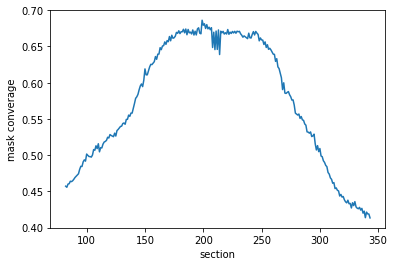

In [29]:
# This shows that a mask covers 50% to 75% of the full area, so predicting only on masks roughly halves the time.

stack = 'MD590'
image_width, image_height = metadata_cache['image_shape'][stack]
first_detect_sec, last_detect_sec = metadata_cache['section_limits'][stack]
a = image_width / 32 * image_height / 32
mask_coverage = {sec: np.count_nonzero(DataManager.load_thumbnail_mask_v2(stack=stack, section=sec))/float(a)
for sec in range(first_detect_sec, last_detect_sec+1) if not is_invalid(stack=stack, sec=sec)}
plt.plot(mask_coverage.keys(), mask_coverage.values());
plt.xlabel('section');
plt.ylabel('mask converage');

In [31]:
# for stack in all_stacks:
for stack in [
 'MD593',
 'MD594',
 'MD595',
 'MD598',
 'MD599',
 'MD602',
 'MD603']:
    
#     if stack in ['MD585', 'MD589']:
#         continue

#     image_dir = DataManager.get_image_dir(stack, resol='lossless', version='cropped')
#     download_from_s3(image_dir, is_dir=True)
    # download takes 3000 sec.

    print stack

    section_to_filename = metadata_cache['sections_to_filenames'][stack]

    image_width, image_height = metadata_cache['image_shape'][stack]
    grid_spec = (patch_size, stride, image_width, image_height)

    sample_locations = grid_parameters_to_sample_locations(grid_spec=grid_spec)

    first_detect_sec, last_detect_sec = metadata_cache['section_limits'][stack]

    bar = show_progress_bar(first_detect_sec, last_detect_sec)
    
#     for sec in range(166, 167):
    for sec in range(first_detect_sec, last_detect_sec+1):
#     for sec in range(143, last_detect_sec+1):
        
        if is_invalid(stack=stack, sec=sec):
            continue
            
#         if section_to_filename[sec].split('-')[1][0] == 'F':
#             continue
#         if section_to_filename[sec].split('-')[1][0] == 'N':
#             continue
                
        bar.value = sec
        
        sys.stderr.write('\nSection %d.\n' % sec)

        # Use grids only on mask.
        t = time.time()
        mask_tb = DataManager.load_thumbnail_mask_v2(stack=stack, section=sec)
        indices_roi = locate_patches_v2(grid_spec=grid_spec, mask_tb=mask_tb)
        sys.stderr.write('locate patches: %.2f seconds\n' % (time.time() - t))       
        
#         Use grids on the entire frame.
#         indices_roi = range(len(sample_locations))

        n = len(indices_roi)
        sys.stderr.write('%d samples.\n' % n)

        sample_locations_roi = sample_locations[indices_roi]
        
        t = time.time()
        img_fp = DataManager.get_image_filepath(stack=stack, section=sec, version='cropped_gray', resol='lossless')
        download_from_s3(img_fp)
        im = img_as_ubyte(imread(img_fp))
        sys.stderr.write('load image: %.2f seconds\n' % (time.time() - t)) # ~ 35s
        
#         t = time.time()
#         sat = convert_to_saturation(im)
#         del im
#         sys.stderr.write('Convert to saturation: %.2f seconds\n' % (time.time() - t)) # ~ 35s
#         sat = imread(DataManager.get_image_filepath(stack=stack, section=sec, version='saturation'))
        

        t = time.time()

        patches = np.array([im[y-half_size:y+half_size, x-half_size:x+half_size]
                            for x, y in sample_locations_roi]) # n x 224 x 224
        patches_mean_subtracted = patches - mean_img
        patches_mean_subtracted_input = patches_mean_subtracted[:, None, :, :] # n x 1 x 224 x 224

#         patches = np.array([im[y-half_size:y+half_size, x-half_size:x+half_size]
#                             for x, y in sample_locations_roi]) # n x 224 x 224 x 1
#         patches_mean_subtracted_input = np.rollaxis(patches, 3, 1) - mean_img # n x 3 x 224 x 224

        sys.stderr.write('extract patches: %.2f seconds\n' % (time.time() - t)) # ~ 20s / 140k patches

        # Increase batch_size to 500 does not save any time.
        batch_size = 256

        # For mxnet 0.9.4, using 80000 patches in a NDArrayIter works but using 90000 patches causes error:
        # TypeError: Invalid type '<type 'numpy.ndarray'>' for data, should be NDArray or numpy.ndarray

        t1 = time.time()
        features = np.empty((n, output_dim))
        
#         n_each_iter = 20000
        n_each_iter = 80000
        for b in range(0, n, n_each_iter):
            data_iter = mx.io.NDArrayIter(
                            patches_mean_subtracted_input[b:b+n_each_iter], 
                            batch_size = batch_size,
                            shuffle=False)
            
            # Reference on how to predict with mxnet model:
            # https://github.com/dmlc/mxnet-notebooks/blob/master/python/how_to/predict.ipynb
            model.bind(data_iter.provide_data, for_training=False)
            model.set_params(arg_params=arg_params, aux_params=aux_params, allow_missing=True)
            outputs = model.predict(data_iter, always_output_list=True)
            features[b:b+n_each_iter] = outputs[0].asnumpy()
        
        sys.stderr.write('predict: %.2f seconds\n' % (time.time() - t1)) 
        # All times below are after the first iteration (which is slow due to model loading into GPU).
        # inception-bn-blue ~125s / 48k patches on workstation single Titan X
        # inception-bn-blue ~27s / 48k patches on AWS p2.8xlarge 8 Tesla K80

    # Had to modify [model]-symbol.json according to this https://github.com/dmlc/mxnet/issues/2718
        
#         del patches_mean_subtracted_input, patches, im
        del patches_mean_subtracted_input, patches_mean_subtracted, patches, im
        
        t = time.time()

        features_fp = DataManager.get_dnn_features_filepath(stack=stack, model_name=model_name, 
                                                          section=sec)
        create_parent_dir_if_not_exists(features_fp)
        bp.pack_ndarray_file(features.astype(np.float16), features_fp) # bloscpack produces files of similar size
        
        upload_to_s3(features_fp, local_root=DATA_ROOTDIR)

        feature_locs_fp = DataManager.get_dnn_feature_locations_filepath(stack=stack, model_name=model_name, 
                                                  section=sec)
        np.savetxt(feature_locs_fp, np.c_[indices_roi, sample_locations_roi], fmt='%d %d %d')
        
        upload_to_s3(feature_locs_fp, local_root=DATA_ROOTDIR)

        sys.stderr.write('save: %.2f seconds\n' % (time.time() - t)) # ~.5s
        
# Overall time: 2.5 hours / stack, on AWS using p2.8xlarge 8 Tesla K80.

MD593


Widget Javascript not detected.  It may not be installed or enabled properly.



Section 83.
locate patches: 0.01 seconds
28893 samples.
load image: 0.16 seconds
extract patches: 2.77 seconds
predict: 17.14 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD593/MD593-N15-2015.08.21-16.53.02_MD593_3_0045_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N15-2015.08.21-16.53.02_MD593_3_0045_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD593/MD593-N15-2015.08.21-16.53.02_MD593_3_0045_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N15-2015.08.21-16.53.02_MD593_3_0045_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_features.hdf


Child returned 0
1.68 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD593/MD593-N15-2015.08.21-16.53.02_MD593_3_0045_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N15-2015.08.21-16.53.02_MD593_3_0045_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD593/MD593-N15-2015.08.21-16.53.02_MD593_3_0045_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N15-2015.08.21-16.53.02_MD593_3_0045_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_patch_locations.txt


Child returned 0
0.78 seconds.
save: 3.20 seconds

Section 84.
locate patches: 0.01 seconds
28929 samples.
load image: 0.16 seconds
extract patches: 2.79 seconds
predict: 16.71 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD593/MD593-IHC15-2015.08.25-14.46.05_MD593_1_0045_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC15-2015.08.25-14.46.05_MD593_1_0045_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD593/MD593-IHC15-2015.08.25-14.46.05_MD593_1_0045_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC15-2015.08.25-14.46.05_MD593_1_0045_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_features.hdf


Child returned 0
1.87 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD593/MD593-IHC15-2015.08.25-14.46.05_MD593_1_0045_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC15-2015.08.25-14.46.05_MD593_1_0045_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD593/MD593-IHC15-2015.08.25-14.46.05_MD593_1_0045_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC15-2015.08.25-14.46.05_MD593_1_0045_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_patch_locations.txt


Child returned 0
0.77 seconds.
save: 3.24 seconds

Section 85.
locate patches: 0.01 seconds
29293 samples.
load image: 0.16 seconds
extract patches: 2.81 seconds
predict: 16.82 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD593/MD593-N16-2015.08.21-16.56.51_MD593_1_0046_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N16-2015.08.21-16.56.51_MD593_1_0046_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD593/MD593-N16-2015.08.21-16.56.51_MD593_1_0046_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N16-2015.08.21-16.56.51_MD593_1_0046_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_features.hdf


Child returned 0
1.80 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD593/MD593-N16-2015.08.21-16.56.51_MD593_1_0046_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N16-2015.08.21-16.56.51_MD593_1_0046_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD593/MD593-N16-2015.08.21-16.56.51_MD593_1_0046_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N16-2015.08.21-16.56.51_MD593_1_0046_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_patch_locations.txt


Child returned 0
0.78 seconds.
save: 3.19 seconds

Section 86.
locate patches: 0.01 seconds
29407 samples.
load image: 0.16 seconds
extract patches: 3.31 seconds
predict: 16.77 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD593/MD593-IHC16-2015.08.25-14.51.12_MD593_3_0046_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC16-2015.08.25-14.51.12_MD593_3_0046_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD593/MD593-IHC16-2015.08.25-14.51.12_MD593_3_0046_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC16-2015.08.25-14.51.12_MD593_3_0046_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_features.hdf


Child returned 0
1.70 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD593/MD593-IHC16-2015.08.25-14.51.12_MD593_3_0046_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC16-2015.08.25-14.51.12_MD593_3_0046_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD593/MD593-IHC16-2015.08.25-14.51.12_MD593_3_0046_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC16-2015.08.25-14.51.12_MD593_3_0046_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_patch_locations.txt


Child returned 0
1.63 seconds.
save: 3.94 seconds

Section 87.
locate patches: 0.01 seconds
30549 samples.
load image: 0.16 seconds
extract patches: 3.45 seconds
predict: 17.38 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD593/MD593-N16-2015.08.21-16.56.51_MD593_2_0047_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N16-2015.08.21-16.56.51_MD593_2_0047_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD593/MD593-N16-2015.08.21-16.56.51_MD593_2_0047_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N16-2015.08.21-16.56.51_MD593_2_0047_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_features.hdf


Child returned 0
2.06 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD593/MD593-N16-2015.08.21-16.56.51_MD593_2_0047_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N16-2015.08.21-16.56.51_MD593_2_0047_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD593/MD593-N16-2015.08.21-16.56.51_MD593_2_0047_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N16-2015.08.21-16.56.51_MD593_2_0047_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_patch_locations.txt


Child returned 0
0.77 seconds.
save: 3.47 seconds

Section 88.
locate patches: 0.01 seconds
30557 samples.
load image: 0.16 seconds
extract patches: 3.44 seconds
predict: 17.45 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD593/MD593-IHC16-2015.08.25-14.51.12_MD593_2_0047_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC16-2015.08.25-14.51.12_MD593_2_0047_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD593/MD593-IHC16-2015.08.25-14.51.12_MD593_2_0047_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC16-2015.08.25-14.51.12_MD593_2_0047_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_features.hdf


Child returned 0
1.72 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD593/MD593-IHC16-2015.08.25-14.51.12_MD593_2_0047_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC16-2015.08.25-14.51.12_MD593_2_0047_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD593/MD593-IHC16-2015.08.25-14.51.12_MD593_2_0047_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC16-2015.08.25-14.51.12_MD593_2_0047_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_patch_locations.txt


Child returned 0
0.77 seconds.
save: 3.12 seconds

Section 89.
locate patches: 0.01 seconds
30828 samples.
load image: 0.16 seconds
extract patches: 2.99 seconds
predict: 17.58 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD593/MD593-N16-2015.08.21-16.56.51_MD593_3_0048_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N16-2015.08.21-16.56.51_MD593_3_0048_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD593/MD593-N16-2015.08.21-16.56.51_MD593_3_0048_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N16-2015.08.21-16.56.51_MD593_3_0048_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_features.hdf


Child returned 0
1.73 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD593/MD593-N16-2015.08.21-16.56.51_MD593_3_0048_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N16-2015.08.21-16.56.51_MD593_3_0048_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD593/MD593-N16-2015.08.21-16.56.51_MD593_3_0048_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N16-2015.08.21-16.56.51_MD593_3_0048_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_patch_locations.txt


Child returned 0
0.77 seconds.
save: 3.15 seconds

Section 90.
locate patches: 0.01 seconds
31092 samples.
load image: 0.16 seconds
extract patches: 2.99 seconds
predict: 18.04 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD593/MD593-IHC16-2015.08.25-14.51.12_MD593_1_0048_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC16-2015.08.25-14.51.12_MD593_1_0048_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD593/MD593-IHC16-2015.08.25-14.51.12_MD593_1_0048_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC16-2015.08.25-14.51.12_MD593_1_0048_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_features.hdf


Child returned 0
1.60 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD593/MD593-IHC16-2015.08.25-14.51.12_MD593_1_0048_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC16-2015.08.25-14.51.12_MD593_1_0048_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD593/MD593-IHC16-2015.08.25-14.51.12_MD593_1_0048_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC16-2015.08.25-14.51.12_MD593_1_0048_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_patch_locations.txt


Child returned 0
0.72 seconds.
save: 2.97 seconds

Section 91.
locate patches: 0.01 seconds
31739 samples.
load image: 0.16 seconds
extract patches: 3.05 seconds
predict: 18.19 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD593/MD593-N17-2015.08.21-17.24.35_MD593_1_0049_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N17-2015.08.21-17.24.35_MD593_1_0049_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD593/MD593-N17-2015.08.21-17.24.35_MD593_1_0049_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N17-2015.08.21-17.24.35_MD593_1_0049_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_features.hdf


Child returned 0
1.85 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD593/MD593-N17-2015.08.21-17.24.35_MD593_1_0049_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N17-2015.08.21-17.24.35_MD593_1_0049_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD593/MD593-N17-2015.08.21-17.24.35_MD593_1_0049_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N17-2015.08.21-17.24.35_MD593_1_0049_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_patch_locations.txt


Child returned 0
0.82 seconds.
save: 3.33 seconds

Section 92.
locate patches: 0.01 seconds
31602 samples.
load image: 0.16 seconds
extract patches: 3.05 seconds
predict: 18.08 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD593/MD593-IHC17-2015.08.25-14.55.55_MD593_3_0049_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC17-2015.08.25-14.55.55_MD593_3_0049_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD593/MD593-IHC17-2015.08.25-14.55.55_MD593_3_0049_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC17-2015.08.25-14.55.55_MD593_3_0049_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_features.hdf


Child returned 0
2.17 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD593/MD593-IHC17-2015.08.25-14.55.55_MD593_3_0049_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC17-2015.08.25-14.55.55_MD593_3_0049_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD593/MD593-IHC17-2015.08.25-14.55.55_MD593_3_0049_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC17-2015.08.25-14.55.55_MD593_3_0049_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_patch_locations.txt


Child returned 0
0.77 seconds.
save: 3.60 seconds

Section 93.
locate patches: 0.01 seconds
31826 samples.
load image: 0.16 seconds
extract patches: 3.06 seconds
predict: 18.16 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD593/MD593-N17-2015.08.21-17.24.35_MD593_2_0050_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N17-2015.08.21-17.24.35_MD593_2_0050_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD593/MD593-N17-2015.08.21-17.24.35_MD593_2_0050_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N17-2015.08.21-17.24.35_MD593_2_0050_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_features.hdf


Child returned 0
1.73 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD593/MD593-N17-2015.08.21-17.24.35_MD593_2_0050_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N17-2015.08.21-17.24.35_MD593_2_0050_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD593/MD593-N17-2015.08.21-17.24.35_MD593_2_0050_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N17-2015.08.21-17.24.35_MD593_2_0050_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_patch_locations.txt


Child returned 0
0.78 seconds.
save: 3.18 seconds

Section 94.
locate patches: 0.01 seconds
31760 samples.
load image: 0.16 seconds
extract patches: 3.06 seconds
predict: 18.17 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD593/MD593-IHC17-2015.08.25-14.55.55_MD593_2_0050_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC17-2015.08.25-14.55.55_MD593_2_0050_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD593/MD593-IHC17-2015.08.25-14.55.55_MD593_2_0050_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC17-2015.08.25-14.55.55_MD593_2_0050_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_features.hdf


Child returned 0
1.72 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD593/MD593-IHC17-2015.08.25-14.55.55_MD593_2_0050_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC17-2015.08.25-14.55.55_MD593_2_0050_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD593/MD593-IHC17-2015.08.25-14.55.55_MD593_2_0050_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC17-2015.08.25-14.55.55_MD593_2_0050_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_patch_locations.txt


Child returned 0
0.77 seconds.
save: 3.15 seconds

Section 95.
locate patches: 0.01 seconds
32113 samples.
load image: 0.16 seconds
extract patches: 3.09 seconds
predict: 18.35 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD593/MD593-N17-2015.08.21-17.24.35_MD593_3_0051_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N17-2015.08.21-17.24.35_MD593_3_0051_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD593/MD593-N17-2015.08.21-17.24.35_MD593_3_0051_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N17-2015.08.21-17.24.35_MD593_3_0051_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_features.hdf


Child returned 0
1.89 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD593/MD593-N17-2015.08.21-17.24.35_MD593_3_0051_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N17-2015.08.21-17.24.35_MD593_3_0051_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD593/MD593-N17-2015.08.21-17.24.35_MD593_3_0051_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N17-2015.08.21-17.24.35_MD593_3_0051_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_patch_locations.txt


Child returned 0
0.72 seconds.
save: 3.28 seconds

Section 96.
locate patches: 0.01 seconds
31345 samples.
load image: 0.16 seconds
extract patches: 3.01 seconds
predict: 18.08 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD593/MD593-IHC17-2015.08.25-14.55.55_MD593_1_0051_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC17-2015.08.25-14.55.55_MD593_1_0051_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD593/MD593-IHC17-2015.08.25-14.55.55_MD593_1_0051_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC17-2015.08.25-14.55.55_MD593_1_0051_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_features.hdf


Child returned 0
1.75 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD593/MD593-IHC17-2015.08.25-14.55.55_MD593_1_0051_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC17-2015.08.25-14.55.55_MD593_1_0051_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD593/MD593-IHC17-2015.08.25-14.55.55_MD593_1_0051_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC17-2015.08.25-14.55.55_MD593_1_0051_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_patch_locations.txt


Child returned 0
0.77 seconds.
save: 3.17 seconds

Section 97.
locate patches: 0.01 seconds
31866 samples.
load image: 0.16 seconds
extract patches: 3.07 seconds
predict: 18.28 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD593/MD593-N18-2015.08.21-17.28.26_MD593_1_0052_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N18-2015.08.21-17.28.26_MD593_1_0052_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD593/MD593-N18-2015.08.21-17.28.26_MD593_1_0052_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N18-2015.08.21-17.28.26_MD593_1_0052_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_features.hdf


Child returned 0
1.80 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD593/MD593-N18-2015.08.21-17.28.26_MD593_1_0052_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N18-2015.08.21-17.28.26_MD593_1_0052_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD593/MD593-N18-2015.08.21-17.28.26_MD593_1_0052_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N18-2015.08.21-17.28.26_MD593_1_0052_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_patch_locations.txt


Child returned 0
0.73 seconds.
save: 3.19 seconds

Section 98.
locate patches: 0.01 seconds
32228 samples.
load image: 0.16 seconds
extract patches: 3.10 seconds
predict: 18.61 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD593/MD593-IHC18-2015.08.25-15.01.03_MD593_3_0052_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC18-2015.08.25-15.01.03_MD593_3_0052_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD593/MD593-IHC18-2015.08.25-15.01.03_MD593_3_0052_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC18-2015.08.25-15.01.03_MD593_3_0052_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_features.hdf


Child returned 0
1.74 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD593/MD593-IHC18-2015.08.25-15.01.03_MD593_3_0052_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC18-2015.08.25-15.01.03_MD593_3_0052_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD593/MD593-IHC18-2015.08.25-15.01.03_MD593_3_0052_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC18-2015.08.25-15.01.03_MD593_3_0052_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_patch_locations.txt


Child returned 0
0.78 seconds.
save: 3.19 seconds

Section 99.
locate patches: 0.01 seconds
32753 samples.
load image: 0.16 seconds
extract patches: 3.18 seconds
predict: 18.70 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD593/MD593-N18-2015.08.21-17.28.26_MD593_2_0053_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N18-2015.08.21-17.28.26_MD593_2_0053_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD593/MD593-N18-2015.08.21-17.28.26_MD593_2_0053_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N18-2015.08.21-17.28.26_MD593_2_0053_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_features.hdf


Child returned 0
1.85 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD593/MD593-N18-2015.08.21-17.28.26_MD593_2_0053_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N18-2015.08.21-17.28.26_MD593_2_0053_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD593/MD593-N18-2015.08.21-17.28.26_MD593_2_0053_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N18-2015.08.21-17.28.26_MD593_2_0053_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_patch_locations.txt


Child returned 0
0.77 seconds.
save: 3.31 seconds

Section 100.
locate patches: 0.01 seconds
33077 samples.
load image: 0.16 seconds
extract patches: 3.19 seconds
predict: 18.90 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD593/MD593-IHC18-2015.08.25-15.01.03_MD593_2_0053_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC18-2015.08.25-15.01.03_MD593_2_0053_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD593/MD593-IHC18-2015.08.25-15.01.03_MD593_2_0053_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC18-2015.08.25-15.01.03_MD593_2_0053_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_features.hdf


Child returned 0
1.84 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD593/MD593-IHC18-2015.08.25-15.01.03_MD593_2_0053_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC18-2015.08.25-15.01.03_MD593_2_0053_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD593/MD593-IHC18-2015.08.25-15.01.03_MD593_2_0053_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC18-2015.08.25-15.01.03_MD593_2_0053_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_patch_locations.txt


Child returned 0
0.77 seconds.
save: 3.30 seconds

Section 101.
locate patches: 0.01 seconds
32965 samples.
load image: 0.16 seconds
extract patches: 3.18 seconds
predict: 18.76 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD593/MD593-N18-2015.08.21-17.28.26_MD593_3_0054_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N18-2015.08.21-17.28.26_MD593_3_0054_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD593/MD593-N18-2015.08.21-17.28.26_MD593_3_0054_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N18-2015.08.21-17.28.26_MD593_3_0054_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_features.hdf


Child returned 0
2.49 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD593/MD593-N18-2015.08.21-17.28.26_MD593_3_0054_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N18-2015.08.21-17.28.26_MD593_3_0054_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD593/MD593-N18-2015.08.21-17.28.26_MD593_3_0054_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N18-2015.08.21-17.28.26_MD593_3_0054_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_patch_locations.txt


Child returned 0
0.72 seconds.
save: 3.90 seconds

Section 102.
locate patches: 0.01 seconds
33229 samples.
load image: 0.16 seconds
extract patches: 3.20 seconds
predict: 18.96 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD593/MD593-IHC18-2015.08.25-15.01.03_MD593_1_0054_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC18-2015.08.25-15.01.03_MD593_1_0054_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD593/MD593-IHC18-2015.08.25-15.01.03_MD593_1_0054_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC18-2015.08.25-15.01.03_MD593_1_0054_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_features.hdf


Child returned 0
1.79 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD593/MD593-IHC18-2015.08.25-15.01.03_MD593_1_0054_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC18-2015.08.25-15.01.03_MD593_1_0054_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD593/MD593-IHC18-2015.08.25-15.01.03_MD593_1_0054_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC18-2015.08.25-15.01.03_MD593_1_0054_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_patch_locations.txt


Child returned 0
0.92 seconds.
save: 3.40 seconds

Section 103.
locate patches: 0.01 seconds
33766 samples.
load image: 0.16 seconds
extract patches: 3.26 seconds
predict: 19.32 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD593/MD593-N19-2015.08.21-17.32.20_MD593_1_0055_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N19-2015.08.21-17.32.20_MD593_1_0055_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD593/MD593-N19-2015.08.21-17.32.20_MD593_1_0055_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N19-2015.08.21-17.32.20_MD593_1_0055_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_features.hdf


Child returned 0
1.79 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD593/MD593-N19-2015.08.21-17.32.20_MD593_1_0055_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N19-2015.08.21-17.32.20_MD593_1_0055_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD593/MD593-N19-2015.08.21-17.32.20_MD593_1_0055_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N19-2015.08.21-17.32.20_MD593_1_0055_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_patch_locations.txt


Child returned 0
0.77 seconds.
save: 3.27 seconds

Section 104.
locate patches: 0.01 seconds
33904 samples.
load image: 0.16 seconds
extract patches: 3.26 seconds
predict: 19.46 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD593/MD593-IHC19-2015.08.25-15.05.56_MD593_1_0055_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC19-2015.08.25-15.05.56_MD593_1_0055_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD593/MD593-IHC19-2015.08.25-15.05.56_MD593_1_0055_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC19-2015.08.25-15.05.56_MD593_1_0055_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_features.hdf


Child returned 0
1.84 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD593/MD593-IHC19-2015.08.25-15.05.56_MD593_1_0055_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC19-2015.08.25-15.05.56_MD593_1_0055_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD593/MD593-IHC19-2015.08.25-15.05.56_MD593_1_0055_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC19-2015.08.25-15.05.56_MD593_1_0055_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_patch_locations.txt


Child returned 0
0.78 seconds.
save: 3.32 seconds

Section 105.
locate patches: 0.01 seconds
34087 samples.
load image: 0.16 seconds
extract patches: 3.33 seconds
predict: 19.49 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD593/MD593-N19-2015.08.21-17.32.20_MD593_2_0056_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N19-2015.08.21-17.32.20_MD593_2_0056_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD593/MD593-N19-2015.08.21-17.32.20_MD593_2_0056_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N19-2015.08.21-17.32.20_MD593_2_0056_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_features.hdf


Child returned 0
2.04 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD593/MD593-N19-2015.08.21-17.32.20_MD593_2_0056_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N19-2015.08.21-17.32.20_MD593_2_0056_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD593/MD593-N19-2015.08.21-17.32.20_MD593_2_0056_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N19-2015.08.21-17.32.20_MD593_2_0056_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_patch_locations.txt


Child returned 0
0.83 seconds.
save: 3.58 seconds

Section 106.
locate patches: 0.01 seconds
34604 samples.
load image: 0.16 seconds
extract patches: 3.96 seconds
predict: 19.80 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD593/MD593-IHC19-2015.08.25-15.05.56_MD593_2_0056_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC19-2015.08.25-15.05.56_MD593_2_0056_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD593/MD593-IHC19-2015.08.25-15.05.56_MD593_2_0056_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC19-2015.08.25-15.05.56_MD593_2_0056_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_features.hdf


Child returned 0
1.79 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD593/MD593-IHC19-2015.08.25-15.05.56_MD593_2_0056_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC19-2015.08.25-15.05.56_MD593_2_0056_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD593/MD593-IHC19-2015.08.25-15.05.56_MD593_2_0056_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC19-2015.08.25-15.05.56_MD593_2_0056_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_patch_locations.txt


Child returned 0
0.77 seconds.
save: 3.29 seconds

Section 107.
locate patches: 0.01 seconds
34479 samples.
load image: 0.16 seconds
extract patches: 3.31 seconds
predict: 19.50 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD593/MD593-N19-2015.08.21-17.32.20_MD593_3_0057_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N19-2015.08.21-17.32.20_MD593_3_0057_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD593/MD593-N19-2015.08.21-17.32.20_MD593_3_0057_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N19-2015.08.21-17.32.20_MD593_3_0057_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_features.hdf


Child returned 0
2.00 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD593/MD593-N19-2015.08.21-17.32.20_MD593_3_0057_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N19-2015.08.21-17.32.20_MD593_3_0057_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD593/MD593-N19-2015.08.21-17.32.20_MD593_3_0057_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N19-2015.08.21-17.32.20_MD593_3_0057_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_patch_locations.txt


Child returned 0
0.78 seconds.
save: 3.49 seconds

Section 108.
locate patches: 0.01 seconds
34932 samples.
load image: 0.16 seconds
extract patches: 3.34 seconds
predict: 19.95 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD593/MD593-IHC19-2015.08.25-15.05.56_MD593_3_0057_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC19-2015.08.25-15.05.56_MD593_3_0057_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD593/MD593-IHC19-2015.08.25-15.05.56_MD593_3_0057_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC19-2015.08.25-15.05.56_MD593_3_0057_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_features.hdf


Child returned 0
1.93 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD593/MD593-IHC19-2015.08.25-15.05.56_MD593_3_0057_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC19-2015.08.25-15.05.56_MD593_3_0057_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD593/MD593-IHC19-2015.08.25-15.05.56_MD593_3_0057_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC19-2015.08.25-15.05.56_MD593_3_0057_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_patch_locations.txt


Child returned 0
0.77 seconds.
save: 3.43 seconds

Section 110.
locate patches: 0.01 seconds
34728 samples.
load image: 0.16 seconds
extract patches: 3.91 seconds
predict: 19.86 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD593/MD593-IHC20-2015.08.25-15.11.02_MD593_3_0058_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC20-2015.08.25-15.11.02_MD593_3_0058_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD593/MD593-IHC20-2015.08.25-15.11.02_MD593_3_0058_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC20-2015.08.25-15.11.02_MD593_3_0058_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_features.hdf


Child returned 0
1.84 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD593/MD593-IHC20-2015.08.25-15.11.02_MD593_3_0058_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC20-2015.08.25-15.11.02_MD593_3_0058_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD593/MD593-IHC20-2015.08.25-15.11.02_MD593_3_0058_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC20-2015.08.25-15.11.02_MD593_3_0058_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_patch_locations.txt


Child returned 0
0.77 seconds.
save: 3.33 seconds

Section 111.
locate patches: 0.01 seconds
35088 samples.
load image: 0.16 seconds
extract patches: 3.95 seconds
predict: 20.27 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD593/MD593-N20-2015.08.21-17.37.43_MD593_1_0058_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N20-2015.08.21-17.37.43_MD593_1_0058_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD593/MD593-N20-2015.08.21-17.37.43_MD593_1_0058_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N20-2015.08.21-17.37.43_MD593_1_0058_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_features.hdf


Child returned 0
1.79 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD593/MD593-N20-2015.08.21-17.37.43_MD593_1_0058_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N20-2015.08.21-17.37.43_MD593_1_0058_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD593/MD593-N20-2015.08.21-17.37.43_MD593_1_0058_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N20-2015.08.21-17.37.43_MD593_1_0058_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_patch_locations.txt


Child returned 0
0.77 seconds.
save: 3.29 seconds

Section 112.
locate patches: 0.01 seconds
35308 samples.
load image: 0.16 seconds
extract patches: 3.39 seconds
predict: 19.99 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD593/MD593-IHC20-2015.08.25-15.11.02_MD593_2_0059_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC20-2015.08.25-15.11.02_MD593_2_0059_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD593/MD593-IHC20-2015.08.25-15.11.02_MD593_2_0059_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC20-2015.08.25-15.11.02_MD593_2_0059_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_features.hdf


Child returned 0
1.79 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD593/MD593-IHC20-2015.08.25-15.11.02_MD593_2_0059_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC20-2015.08.25-15.11.02_MD593_2_0059_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD593/MD593-IHC20-2015.08.25-15.11.02_MD593_2_0059_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC20-2015.08.25-15.11.02_MD593_2_0059_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_patch_locations.txt


Child returned 0
0.78 seconds.
save: 3.30 seconds

Section 113.
locate patches: 0.01 seconds
35321 samples.
load image: 0.16 seconds
extract patches: 3.40 seconds
predict: 20.03 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD593/MD593-N20-2015.08.21-17.37.43_MD593_2_0059_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N20-2015.08.21-17.37.43_MD593_2_0059_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD593/MD593-N20-2015.08.21-17.37.43_MD593_2_0059_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N20-2015.08.21-17.37.43_MD593_2_0059_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_features.hdf


Child returned 0
1.94 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD593/MD593-N20-2015.08.21-17.37.43_MD593_2_0059_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N20-2015.08.21-17.37.43_MD593_2_0059_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD593/MD593-N20-2015.08.21-17.37.43_MD593_2_0059_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N20-2015.08.21-17.37.43_MD593_2_0059_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_patch_locations.txt


Child returned 0
0.77 seconds.
save: 3.45 seconds

Section 114.
locate patches: 0.01 seconds
35663 samples.
load image: 0.16 seconds
extract patches: 3.44 seconds
predict: 20.24 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD593/MD593-IHC20-2015.08.25-15.11.02_MD593_1_0060_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC20-2015.08.25-15.11.02_MD593_1_0060_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD593/MD593-IHC20-2015.08.25-15.11.02_MD593_1_0060_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC20-2015.08.25-15.11.02_MD593_1_0060_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_features.hdf


Child returned 0
1.94 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD593/MD593-IHC20-2015.08.25-15.11.02_MD593_1_0060_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC20-2015.08.25-15.11.02_MD593_1_0060_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD593/MD593-IHC20-2015.08.25-15.11.02_MD593_1_0060_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC20-2015.08.25-15.11.02_MD593_1_0060_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_patch_locations.txt


Child returned 0
0.78 seconds.
save: 3.41 seconds

Section 115.
locate patches: 0.01 seconds
36168 samples.
load image: 0.16 seconds
extract patches: 3.47 seconds
predict: 20.71 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD593/MD593-N21-2015.08.21-17.40.37_MD593_1_0061_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N21-2015.08.21-17.40.37_MD593_1_0061_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD593/MD593-N21-2015.08.21-17.40.37_MD593_1_0061_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N21-2015.08.21-17.40.37_MD593_1_0061_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_features.hdf


Child returned 0
2.49 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD593/MD593-N21-2015.08.21-17.40.37_MD593_1_0061_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N21-2015.08.21-17.40.37_MD593_1_0061_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD593/MD593-N21-2015.08.21-17.40.37_MD593_1_0061_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N21-2015.08.21-17.40.37_MD593_1_0061_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_patch_locations.txt


Child returned 0
0.78 seconds.
save: 4.02 seconds

Section 116.
locate patches: 0.01 seconds
36050 samples.
load image: 0.16 seconds
extract patches: 4.06 seconds
predict: 20.58 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD593/MD593-IHC21-2015.08.25-15.16.07_MD593_1_0061_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC21-2015.08.25-15.16.07_MD593_1_0061_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD593/MD593-IHC21-2015.08.25-15.16.07_MD593_1_0061_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC21-2015.08.25-15.16.07_MD593_1_0061_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_features.hdf


Child returned 0
2.14 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD593/MD593-IHC21-2015.08.25-15.16.07_MD593_1_0061_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC21-2015.08.25-15.16.07_MD593_1_0061_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD593/MD593-IHC21-2015.08.25-15.16.07_MD593_1_0061_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC21-2015.08.25-15.16.07_MD593_1_0061_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_patch_locations.txt


Child returned 0
0.83 seconds.
save: 3.72 seconds

Section 117.
locate patches: 0.01 seconds
36306 samples.
load image: 0.16 seconds
extract patches: 4.09 seconds
predict: 20.83 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD593/MD593-N21-2015.08.21-17.40.37_MD593_2_0062_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N21-2015.08.21-17.40.37_MD593_2_0062_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD593/MD593-N21-2015.08.21-17.40.37_MD593_2_0062_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N21-2015.08.21-17.40.37_MD593_2_0062_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_features.hdf


Child returned 0
1.79 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD593/MD593-N21-2015.08.21-17.40.37_MD593_2_0062_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N21-2015.08.21-17.40.37_MD593_2_0062_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD593/MD593-N21-2015.08.21-17.40.37_MD593_2_0062_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N21-2015.08.21-17.40.37_MD593_2_0062_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_patch_locations.txt


Child returned 0
0.73 seconds.
save: 3.28 seconds

Section 118.
locate patches: 0.01 seconds
36421 samples.
load image: 0.16 seconds
extract patches: 4.10 seconds
predict: 20.84 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD593/MD593-IHC21-2015.08.25-15.16.07_MD593_2_0062_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC21-2015.08.25-15.16.07_MD593_2_0062_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD593/MD593-IHC21-2015.08.25-15.16.07_MD593_2_0062_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC21-2015.08.25-15.16.07_MD593_2_0062_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_features.hdf


Child returned 0
2.10 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD593/MD593-IHC21-2015.08.25-15.16.07_MD593_2_0062_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC21-2015.08.25-15.16.07_MD593_2_0062_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD593/MD593-IHC21-2015.08.25-15.16.07_MD593_2_0062_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC21-2015.08.25-15.16.07_MD593_2_0062_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_patch_locations.txt


Child returned 0
0.83 seconds.
save: 3.68 seconds

Section 119.
locate patches: 0.01 seconds
36616 samples.
load image: 0.16 seconds
extract patches: 4.12 seconds
predict: 20.98 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD593/MD593-N21-2015.08.21-17.40.37_MD593_3_0063_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N21-2015.08.21-17.40.37_MD593_3_0063_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD593/MD593-N21-2015.08.21-17.40.37_MD593_3_0063_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N21-2015.08.21-17.40.37_MD593_3_0063_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_features.hdf


Child returned 0
1.87 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD593/MD593-N21-2015.08.21-17.40.37_MD593_3_0063_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N21-2015.08.21-17.40.37_MD593_3_0063_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD593/MD593-N21-2015.08.21-17.40.37_MD593_3_0063_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N21-2015.08.21-17.40.37_MD593_3_0063_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_patch_locations.txt


Child returned 0
0.78 seconds.
save: 3.40 seconds

Section 120.
locate patches: 0.01 seconds
36586 samples.
load image: 0.16 seconds
extract patches: 4.11 seconds
predict: 20.93 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD593/MD593-IHC21-2015.08.25-15.16.07_MD593_3_0063_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC21-2015.08.25-15.16.07_MD593_3_0063_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD593/MD593-IHC21-2015.08.25-15.16.07_MD593_3_0063_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC21-2015.08.25-15.16.07_MD593_3_0063_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_features.hdf


Child returned 0
1.89 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD593/MD593-IHC21-2015.08.25-15.16.07_MD593_3_0063_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC21-2015.08.25-15.16.07_MD593_3_0063_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD593/MD593-IHC21-2015.08.25-15.16.07_MD593_3_0063_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC21-2015.08.25-15.16.07_MD593_3_0063_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_patch_locations.txt


Child returned 0
0.83 seconds.
save: 3.48 seconds

Section 121.
locate patches: 0.01 seconds
36938 samples.
load image: 0.16 seconds
extract patches: 4.15 seconds
predict: 21.15 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD593/MD593-N22-2015.08.21-17.44.40_MD593_1_0064_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N22-2015.08.21-17.44.40_MD593_1_0064_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD593/MD593-N22-2015.08.21-17.44.40_MD593_1_0064_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N22-2015.08.21-17.44.40_MD593_1_0064_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_features.hdf


Child returned 0
1.99 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD593/MD593-N22-2015.08.21-17.44.40_MD593_1_0064_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N22-2015.08.21-17.44.40_MD593_1_0064_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD593/MD593-N22-2015.08.21-17.44.40_MD593_1_0064_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N22-2015.08.21-17.44.40_MD593_1_0064_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_patch_locations.txt


Child returned 0
0.78 seconds.
save: 3.54 seconds

Section 122.
locate patches: 0.01 seconds
36678 samples.
load image: 0.16 seconds
extract patches: 3.53 seconds
predict: 20.91 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD593/MD593-IHC22-2015.08.25-15.21.05_MD593_1_0064_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC22-2015.08.25-15.21.05_MD593_1_0064_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD593/MD593-IHC22-2015.08.25-15.21.05_MD593_1_0064_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC22-2015.08.25-15.21.05_MD593_1_0064_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_features.hdf


Child returned 0
1.84 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD593/MD593-IHC22-2015.08.25-15.21.05_MD593_1_0064_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC22-2015.08.25-15.21.05_MD593_1_0064_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD593/MD593-IHC22-2015.08.25-15.21.05_MD593_1_0064_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC22-2015.08.25-15.21.05_MD593_1_0064_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_patch_locations.txt


Child returned 0
0.78 seconds.
save: 3.38 seconds

Section 123.
locate patches: 0.01 seconds
37302 samples.
load image: 0.16 seconds
extract patches: 3.57 seconds
predict: 21.33 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD593/MD593-N22-2015.08.21-17.44.40_MD593_2_0065_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N22-2015.08.21-17.44.40_MD593_2_0065_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD593/MD593-N22-2015.08.21-17.44.40_MD593_2_0065_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N22-2015.08.21-17.44.40_MD593_2_0065_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_features.hdf


Child returned 0
1.89 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD593/MD593-N22-2015.08.21-17.44.40_MD593_2_0065_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N22-2015.08.21-17.44.40_MD593_2_0065_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD593/MD593-N22-2015.08.21-17.44.40_MD593_2_0065_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N22-2015.08.21-17.44.40_MD593_2_0065_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_patch_locations.txt


Child returned 0
0.79 seconds.
save: 3.46 seconds

Section 124.
locate patches: 0.01 seconds
37025 samples.
load image: 0.16 seconds
extract patches: 3.58 seconds
predict: 21.19 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD593/MD593-IHC22-2015.08.25-15.21.05_MD593_2_0065_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC22-2015.08.25-15.21.05_MD593_2_0065_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD593/MD593-IHC22-2015.08.25-15.21.05_MD593_2_0065_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC22-2015.08.25-15.21.05_MD593_2_0065_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_features.hdf


Child returned 0
2.19 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD593/MD593-IHC22-2015.08.25-15.21.05_MD593_2_0065_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC22-2015.08.25-15.21.05_MD593_2_0065_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD593/MD593-IHC22-2015.08.25-15.21.05_MD593_2_0065_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC22-2015.08.25-15.21.05_MD593_2_0065_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_patch_locations.txt


Child returned 0
0.78 seconds.
save: 3.75 seconds

Section 125.
locate patches: 0.01 seconds
37712 samples.
load image: 0.16 seconds
extract patches: 3.62 seconds
predict: 21.62 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD593/MD593-N22-2015.08.21-17.44.40_MD593_3_0066_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N22-2015.08.21-17.44.40_MD593_3_0066_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD593/MD593-N22-2015.08.21-17.44.40_MD593_3_0066_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N22-2015.08.21-17.44.40_MD593_3_0066_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_features.hdf


Child returned 0
1.84 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD593/MD593-N22-2015.08.21-17.44.40_MD593_3_0066_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N22-2015.08.21-17.44.40_MD593_3_0066_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD593/MD593-N22-2015.08.21-17.44.40_MD593_3_0066_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N22-2015.08.21-17.44.40_MD593_3_0066_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_patch_locations.txt


Child returned 0
0.78 seconds.
save: 3.40 seconds

Section 126.
locate patches: 0.01 seconds
37752 samples.
load image: 0.16 seconds
extract patches: 3.64 seconds
predict: 21.54 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD593/MD593-IHC22-2015.08.25-15.21.05_MD593_3_0066_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC22-2015.08.25-15.21.05_MD593_3_0066_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD593/MD593-IHC22-2015.08.25-15.21.05_MD593_3_0066_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC22-2015.08.25-15.21.05_MD593_3_0066_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_features.hdf


Child returned 0
1.79 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD593/MD593-IHC22-2015.08.25-15.21.05_MD593_3_0066_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC22-2015.08.25-15.21.05_MD593_3_0066_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD593/MD593-IHC22-2015.08.25-15.21.05_MD593_3_0066_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC22-2015.08.25-15.21.05_MD593_3_0066_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_patch_locations.txt


Child returned 0
0.88 seconds.
save: 3.45 seconds

Section 127.
locate patches: 0.01 seconds
37853 samples.
load image: 0.16 seconds
extract patches: 3.65 seconds
predict: 21.58 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD593/MD593-N23-2015.08.21-17.48.50_MD593_1_0067_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N23-2015.08.21-17.48.50_MD593_1_0067_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD593/MD593-N23-2015.08.21-17.48.50_MD593_1_0067_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N23-2015.08.21-17.48.50_MD593_1_0067_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_features.hdf


Child returned 0
1.79 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD593/MD593-N23-2015.08.21-17.48.50_MD593_1_0067_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N23-2015.08.21-17.48.50_MD593_1_0067_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD593/MD593-N23-2015.08.21-17.48.50_MD593_1_0067_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N23-2015.08.21-17.48.50_MD593_1_0067_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_patch_locations.txt


Child returned 0
0.72 seconds.
save: 3.31 seconds

Section 128.
locate patches: 0.01 seconds
37999 samples.
load image: 0.16 seconds
extract patches: 3.65 seconds
predict: 21.68 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD593/MD593-IHC23-2015.08.25-15.25.09_MD593_3_0067_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC23-2015.08.25-15.25.09_MD593_3_0067_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD593/MD593-IHC23-2015.08.25-15.25.09_MD593_3_0067_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC23-2015.08.25-15.25.09_MD593_3_0067_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_features.hdf


Child returned 0
1.84 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD593/MD593-IHC23-2015.08.25-15.25.09_MD593_3_0067_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC23-2015.08.25-15.25.09_MD593_3_0067_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD593/MD593-IHC23-2015.08.25-15.25.09_MD593_3_0067_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC23-2015.08.25-15.25.09_MD593_3_0067_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_patch_locations.txt


Child returned 0
0.78 seconds.
save: 3.41 seconds

Section 129.
locate patches: 0.01 seconds
38780 samples.
load image: 0.16 seconds
extract patches: 3.74 seconds
predict: 22.13 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD593/MD593-N23-2015.08.21-17.48.50_MD593_2_0068_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N23-2015.08.21-17.48.50_MD593_2_0068_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD593/MD593-N23-2015.08.21-17.48.50_MD593_2_0068_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N23-2015.08.21-17.48.50_MD593_2_0068_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_features.hdf


Child returned 0
1.80 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD593/MD593-N23-2015.08.21-17.48.50_MD593_2_0068_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N23-2015.08.21-17.48.50_MD593_2_0068_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD593/MD593-N23-2015.08.21-17.48.50_MD593_2_0068_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N23-2015.08.21-17.48.50_MD593_2_0068_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_patch_locations.txt


Child returned 0
0.78 seconds.
save: 3.38 seconds

Section 130.
locate patches: 0.01 seconds
38376 samples.
load image: 0.16 seconds
extract patches: 3.67 seconds
predict: 21.84 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD593/MD593-IHC23-2015.08.25-15.25.09_MD593_2_0068_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC23-2015.08.25-15.25.09_MD593_2_0068_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD593/MD593-IHC23-2015.08.25-15.25.09_MD593_2_0068_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC23-2015.08.25-15.25.09_MD593_2_0068_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_features.hdf


Child returned 0
2.10 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD593/MD593-IHC23-2015.08.25-15.25.09_MD593_2_0068_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC23-2015.08.25-15.25.09_MD593_2_0068_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD593/MD593-IHC23-2015.08.25-15.25.09_MD593_2_0068_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC23-2015.08.25-15.25.09_MD593_2_0068_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_patch_locations.txt


Child returned 0
0.78 seconds.
save: 3.67 seconds

Section 131.
locate patches: 0.01 seconds
38237 samples.
load image: 0.16 seconds
extract patches: 3.66 seconds
predict: 21.90 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD593/MD593-N23-2015.08.21-17.48.50_MD593_3_0069_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N23-2015.08.21-17.48.50_MD593_3_0069_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD593/MD593-N23-2015.08.21-17.48.50_MD593_3_0069_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N23-2015.08.21-17.48.50_MD593_3_0069_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_features.hdf


Child returned 0
1.95 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD593/MD593-N23-2015.08.21-17.48.50_MD593_3_0069_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N23-2015.08.21-17.48.50_MD593_3_0069_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD593/MD593-N23-2015.08.21-17.48.50_MD593_3_0069_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N23-2015.08.21-17.48.50_MD593_3_0069_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_patch_locations.txt


Child returned 0
0.78 seconds.
save: 3.52 seconds

Section 132.
locate patches: 0.01 seconds
38496 samples.
load image: 0.16 seconds
extract patches: 3.70 seconds
predict: 21.88 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD593/MD593-IHC23-2015.08.25-15.25.09_MD593_3_0069_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC23-2015.08.25-15.25.09_MD593_3_0069_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD593/MD593-IHC23-2015.08.25-15.25.09_MD593_3_0069_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC23-2015.08.25-15.25.09_MD593_3_0069_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_features.hdf


Child returned 0
2.59 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD593/MD593-IHC23-2015.08.25-15.25.09_MD593_3_0069_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC23-2015.08.25-15.25.09_MD593_3_0069_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD593/MD593-IHC23-2015.08.25-15.25.09_MD593_3_0069_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC23-2015.08.25-15.25.09_MD593_3_0069_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_patch_locations.txt


Child returned 0
0.78 seconds.
save: 4.17 seconds

Section 133.
locate patches: 0.01 seconds
39402 samples.
load image: 0.16 seconds
extract patches: 3.79 seconds
predict: 22.29 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD593/MD593-N24-2015.08.21-17.52.55_MD593_1_0070_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N24-2015.08.21-17.52.55_MD593_1_0070_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD593/MD593-N24-2015.08.21-17.52.55_MD593_1_0070_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N24-2015.08.21-17.52.55_MD593_1_0070_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_features.hdf


Child returned 0
2.15 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD593/MD593-N24-2015.08.21-17.52.55_MD593_1_0070_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N24-2015.08.21-17.52.55_MD593_1_0070_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD593/MD593-N24-2015.08.21-17.52.55_MD593_1_0070_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N24-2015.08.21-17.52.55_MD593_1_0070_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_patch_locations.txt


Child returned 0
0.78 seconds.
save: 3.76 seconds

Section 134.
locate patches: 0.01 seconds
39208 samples.
load image: 0.16 seconds
extract patches: 3.78 seconds
predict: 22.27 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD593/MD593-IHC24-2015.08.25-15.30.48_MD593_1_0070_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC24-2015.08.25-15.30.48_MD593_1_0070_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD593/MD593-IHC24-2015.08.25-15.30.48_MD593_1_0070_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC24-2015.08.25-15.30.48_MD593_1_0070_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_features.hdf


Child returned 0
1.85 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD593/MD593-IHC24-2015.08.25-15.30.48_MD593_1_0070_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC24-2015.08.25-15.30.48_MD593_1_0070_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD593/MD593-IHC24-2015.08.25-15.30.48_MD593_1_0070_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC24-2015.08.25-15.30.48_MD593_1_0070_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_patch_locations.txt


Child returned 0
0.78 seconds.
save: 3.44 seconds

Section 135.
locate patches: 0.01 seconds
39670 samples.
load image: 0.16 seconds
extract patches: 3.82 seconds
predict: 23.17 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD593/MD593-N24-2015.08.21-17.52.55_MD593_2_0071_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N24-2015.08.21-17.52.55_MD593_2_0071_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD593/MD593-N24-2015.08.21-17.52.55_MD593_2_0071_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N24-2015.08.21-17.52.55_MD593_2_0071_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_features.hdf


Child returned 0
1.89 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD593/MD593-N24-2015.08.21-17.52.55_MD593_2_0071_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N24-2015.08.21-17.52.55_MD593_2_0071_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD593/MD593-N24-2015.08.21-17.52.55_MD593_2_0071_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N24-2015.08.21-17.52.55_MD593_2_0071_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_patch_locations.txt


Child returned 0
0.87 seconds.
save: 3.60 seconds

Section 136.
locate patches: 0.01 seconds
39897 samples.
load image: 0.16 seconds
extract patches: 4.48 seconds
predict: 22.70 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD593/MD593-IHC24-2015.08.25-15.30.48_MD593_2_0071_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC24-2015.08.25-15.30.48_MD593_2_0071_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD593/MD593-IHC24-2015.08.25-15.30.48_MD593_2_0071_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC24-2015.08.25-15.30.48_MD593_2_0071_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_features.hdf


Child returned 0
1.85 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD593/MD593-IHC24-2015.08.25-15.30.48_MD593_2_0071_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC24-2015.08.25-15.30.48_MD593_2_0071_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD593/MD593-IHC24-2015.08.25-15.30.48_MD593_2_0071_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC24-2015.08.25-15.30.48_MD593_2_0071_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_patch_locations.txt


Child returned 0
0.83 seconds.
save: 3.50 seconds

Section 137.
locate patches: 0.01 seconds
40151 samples.
load image: 0.16 seconds
extract patches: 3.86 seconds
predict: 22.90 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD593/MD593-N24-2015.08.21-17.52.55_MD593_3_0072_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N24-2015.08.21-17.52.55_MD593_3_0072_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD593/MD593-N24-2015.08.21-17.52.55_MD593_3_0072_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N24-2015.08.21-17.52.55_MD593_3_0072_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_features.hdf


Child returned 0
1.95 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD593/MD593-N24-2015.08.21-17.52.55_MD593_3_0072_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N24-2015.08.21-17.52.55_MD593_3_0072_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD593/MD593-N24-2015.08.21-17.52.55_MD593_3_0072_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N24-2015.08.21-17.52.55_MD593_3_0072_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_patch_locations.txt


Child returned 0
0.83 seconds.
save: 3.61 seconds

Section 138.
locate patches: 0.01 seconds
40002 samples.
load image: 0.16 seconds
extract patches: 3.83 seconds
predict: 22.86 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD593/MD593-IHC24-2015.08.25-15.30.48_MD593_3_0072_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC24-2015.08.25-15.30.48_MD593_3_0072_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD593/MD593-IHC24-2015.08.25-15.30.48_MD593_3_0072_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC24-2015.08.25-15.30.48_MD593_3_0072_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_features.hdf


Child returned 0
1.79 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD593/MD593-IHC24-2015.08.25-15.30.48_MD593_3_0072_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC24-2015.08.25-15.30.48_MD593_3_0072_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD593/MD593-IHC24-2015.08.25-15.30.48_MD593_3_0072_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC24-2015.08.25-15.30.48_MD593_3_0072_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_patch_locations.txt


Child returned 0
0.78 seconds.
save: 3.40 seconds

Section 140.
locate patches: 0.01 seconds
40051 samples.
load image: 0.16 seconds
extract patches: 3.84 seconds
predict: 22.98 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD593/MD593-IHC25-2015.08.25-15.35.47_MD593_1_0073_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC25-2015.08.25-15.35.47_MD593_1_0073_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD593/MD593-IHC25-2015.08.25-15.35.47_MD593_1_0073_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC25-2015.08.25-15.35.47_MD593_1_0073_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_features.hdf


Child returned 0
1.80 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD593/MD593-IHC25-2015.08.25-15.35.47_MD593_1_0073_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC25-2015.08.25-15.35.47_MD593_1_0073_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD593/MD593-IHC25-2015.08.25-15.35.47_MD593_1_0073_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC25-2015.08.25-15.35.47_MD593_1_0073_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_patch_locations.txt


Child returned 0
0.77 seconds.
save: 3.40 seconds

Section 141.
locate patches: 0.01 seconds
40673 samples.
load image: 0.16 seconds
extract patches: 3.91 seconds
predict: 23.14 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD593/MD593-N25-2015.08.21-17.57.04_MD593_1_0073_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N25-2015.08.21-17.57.04_MD593_1_0073_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD593/MD593-N25-2015.08.21-17.57.04_MD593_1_0073_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N25-2015.08.21-17.57.04_MD593_1_0073_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_features.hdf


Child returned 0
1.79 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD593/MD593-N25-2015.08.21-17.57.04_MD593_1_0073_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N25-2015.08.21-17.57.04_MD593_1_0073_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD593/MD593-N25-2015.08.21-17.57.04_MD593_1_0073_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N25-2015.08.21-17.57.04_MD593_1_0073_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_patch_locations.txt


Child returned 0
0.77 seconds.
save: 3.41 seconds

Section 142.
locate patches: 0.01 seconds
40319 samples.
load image: 0.16 seconds
extract patches: 3.86 seconds
predict: 23.01 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD593/MD593-IHC25-2015.08.25-15.35.47_MD593_2_0074_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC25-2015.08.25-15.35.47_MD593_2_0074_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD593/MD593-IHC25-2015.08.25-15.35.47_MD593_2_0074_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC25-2015.08.25-15.35.47_MD593_2_0074_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_features.hdf


Child returned 0
2.11 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD593/MD593-IHC25-2015.08.25-15.35.47_MD593_2_0074_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC25-2015.08.25-15.35.47_MD593_2_0074_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD593/MD593-IHC25-2015.08.25-15.35.47_MD593_2_0074_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC25-2015.08.25-15.35.47_MD593_2_0074_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_patch_locations.txt


Child returned 0
0.78 seconds.
save: 3.72 seconds

Section 143.
locate patches: 0.01 seconds
41167 samples.
load image: 0.16 seconds
extract patches: 4.63 seconds
predict: 23.38 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD593/MD593-N25-2015.08.21-17.57.04_MD593_2_0074_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N25-2015.08.21-17.57.04_MD593_2_0074_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD593/MD593-N25-2015.08.21-17.57.04_MD593_2_0074_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N25-2015.08.21-17.57.04_MD593_2_0074_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_features.hdf


Child returned 0
1.89 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD593/MD593-N25-2015.08.21-17.57.04_MD593_2_0074_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N25-2015.08.21-17.57.04_MD593_2_0074_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD593/MD593-N25-2015.08.21-17.57.04_MD593_2_0074_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N25-2015.08.21-17.57.04_MD593_2_0074_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_patch_locations.txt


Child returned 0
0.78 seconds.
save: 3.57 seconds

Section 144.
locate patches: 0.01 seconds
41251 samples.
load image: 0.16 seconds
extract patches: 3.96 seconds
predict: 23.65 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD593/MD593-IHC25-2015.08.25-15.35.47_MD593_3_0075_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC25-2015.08.25-15.35.47_MD593_3_0075_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD593/MD593-IHC25-2015.08.25-15.35.47_MD593_3_0075_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC25-2015.08.25-15.35.47_MD593_3_0075_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_features.hdf


Child returned 0
2.01 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD593/MD593-IHC25-2015.08.25-15.35.47_MD593_3_0075_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC25-2015.08.25-15.35.47_MD593_3_0075_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD593/MD593-IHC25-2015.08.25-15.35.47_MD593_3_0075_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC25-2015.08.25-15.35.47_MD593_3_0075_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_patch_locations.txt


Child returned 0
0.78 seconds.
save: 3.64 seconds

Section 145.
locate patches: 0.01 seconds
42206 samples.
load image: 0.16 seconds
extract patches: 4.14 seconds
predict: 24.33 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD593/MD593-N26-2015.08.21-18.00.10_MD593_3_0076_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N26-2015.08.21-18.00.10_MD593_3_0076_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD593/MD593-N26-2015.08.21-18.00.10_MD593_3_0076_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N26-2015.08.21-18.00.10_MD593_3_0076_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_features.hdf


Child returned 0
1.86 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD593/MD593-N26-2015.08.21-18.00.10_MD593_3_0076_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N26-2015.08.21-18.00.10_MD593_3_0076_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD593/MD593-N26-2015.08.21-18.00.10_MD593_3_0076_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N26-2015.08.21-18.00.10_MD593_3_0076_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_patch_locations.txt


Child returned 0
0.83 seconds.
save: 3.57 seconds

Section 146.
locate patches: 0.01 seconds
41583 samples.
load image: 0.16 seconds
extract patches: 3.99 seconds
predict: 23.65 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD593/MD593-IHC26-2015.08.25-15.40.04_MD593_1_0076_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC26-2015.08.25-15.40.04_MD593_1_0076_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD593/MD593-IHC26-2015.08.25-15.40.04_MD593_1_0076_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC26-2015.08.25-15.40.04_MD593_1_0076_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_features.hdf


Child returned 0
1.98 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD593/MD593-IHC26-2015.08.25-15.40.04_MD593_1_0076_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC26-2015.08.25-15.40.04_MD593_1_0076_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD593/MD593-IHC26-2015.08.25-15.40.04_MD593_1_0076_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC26-2015.08.25-15.40.04_MD593_1_0076_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_patch_locations.txt


Child returned 0
0.78 seconds.
save: 3.64 seconds

Section 147.
locate patches: 0.01 seconds
42545 samples.
load image: 0.16 seconds
extract patches: 4.09 seconds
predict: 24.19 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD593/MD593-N26-2015.08.21-18.00.10_MD593_2_0077_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N26-2015.08.21-18.00.10_MD593_2_0077_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD593/MD593-N26-2015.08.21-18.00.10_MD593_2_0077_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N26-2015.08.21-18.00.10_MD593_2_0077_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_features.hdf


Child returned 0
2.15 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD593/MD593-N26-2015.08.21-18.00.10_MD593_2_0077_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N26-2015.08.21-18.00.10_MD593_2_0077_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD593/MD593-N26-2015.08.21-18.00.10_MD593_2_0077_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N26-2015.08.21-18.00.10_MD593_2_0077_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_patch_locations.txt


Child returned 0
0.79 seconds.
save: 3.82 seconds

Section 148.
locate patches: 0.01 seconds
42077 samples.
load image: 0.16 seconds
extract patches: 4.06 seconds
predict: 24.12 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD593/MD593-IHC26-2015.08.25-15.40.04_MD593_2_0077_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC26-2015.08.25-15.40.04_MD593_2_0077_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD593/MD593-IHC26-2015.08.25-15.40.04_MD593_2_0077_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC26-2015.08.25-15.40.04_MD593_2_0077_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_features.hdf


Child returned 0
2.05 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD593/MD593-IHC26-2015.08.25-15.40.04_MD593_2_0077_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC26-2015.08.25-15.40.04_MD593_2_0077_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD593/MD593-IHC26-2015.08.25-15.40.04_MD593_2_0077_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC26-2015.08.25-15.40.04_MD593_2_0077_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_patch_locations.txt


Child returned 0
0.78 seconds.
save: 3.70 seconds

Section 149.
locate patches: 0.01 seconds
42699 samples.
load image: 0.16 seconds
extract patches: 4.12 seconds
predict: 24.37 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD593/MD593-N26-2015.08.21-18.00.10_MD593_1_0078_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N26-2015.08.21-18.00.10_MD593_1_0078_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD593/MD593-N26-2015.08.21-18.00.10_MD593_1_0078_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N26-2015.08.21-18.00.10_MD593_1_0078_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_features.hdf


Child returned 0
2.23 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD593/MD593-N26-2015.08.21-18.00.10_MD593_1_0078_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N26-2015.08.21-18.00.10_MD593_1_0078_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD593/MD593-N26-2015.08.21-18.00.10_MD593_1_0078_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N26-2015.08.21-18.00.10_MD593_1_0078_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_patch_locations.txt


Child returned 0
0.78 seconds.
save: 3.86 seconds

Section 150.
locate patches: 0.01 seconds
42269 samples.
load image: 0.16 seconds
extract patches: 4.05 seconds
predict: 24.13 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD593/MD593-IHC26-2015.08.25-15.40.04_MD593_3_0078_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC26-2015.08.25-15.40.04_MD593_3_0078_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD593/MD593-IHC26-2015.08.25-15.40.04_MD593_3_0078_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC26-2015.08.25-15.40.04_MD593_3_0078_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_features.hdf


Child returned 0
2.46 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD593/MD593-IHC26-2015.08.25-15.40.04_MD593_3_0078_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC26-2015.08.25-15.40.04_MD593_3_0078_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD593/MD593-IHC26-2015.08.25-15.40.04_MD593_3_0078_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC26-2015.08.25-15.40.04_MD593_3_0078_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_patch_locations.txt


Child returned 0
0.78 seconds.
save: 4.12 seconds

Section 151.
locate patches: 0.01 seconds
42862 samples.
load image: 0.16 seconds
extract patches: 4.12 seconds
predict: 24.21 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD593/MD593-N27-2015.08.21-18.04.16_MD593_3_0079_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N27-2015.08.21-18.04.16_MD593_3_0079_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD593/MD593-N27-2015.08.21-18.04.16_MD593_3_0079_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N27-2015.08.21-18.04.16_MD593_3_0079_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_features.hdf


Child returned 0
2.02 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD593/MD593-N27-2015.08.21-18.04.16_MD593_3_0079_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N27-2015.08.21-18.04.16_MD593_3_0079_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD593/MD593-N27-2015.08.21-18.04.16_MD593_3_0079_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N27-2015.08.21-18.04.16_MD593_3_0079_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_patch_locations.txt


Child returned 0
0.78 seconds.
save: 3.70 seconds

Section 152.
locate patches: 0.01 seconds
42661 samples.
load image: 0.16 seconds
extract patches: 4.80 seconds
predict: 24.29 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD593/MD593-IHC27-2015.08.25-15.45.27_MD593_1_0079_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC27-2015.08.25-15.45.27_MD593_1_0079_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD593/MD593-IHC27-2015.08.25-15.45.27_MD593_1_0079_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC27-2015.08.25-15.45.27_MD593_1_0079_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_features.hdf


Child returned 0
2.60 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD593/MD593-IHC27-2015.08.25-15.45.27_MD593_1_0079_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC27-2015.08.25-15.45.27_MD593_1_0079_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD593/MD593-IHC27-2015.08.25-15.45.27_MD593_1_0079_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC27-2015.08.25-15.45.27_MD593_1_0079_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_patch_locations.txt


Child returned 0
0.78 seconds.
save: 4.26 seconds

Section 153.
locate patches: 0.01 seconds
43411 samples.
load image: 0.16 seconds
extract patches: 4.89 seconds
predict: 24.78 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD593/MD593-N27-2015.08.21-18.04.16_MD593_2_0080_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N27-2015.08.21-18.04.16_MD593_2_0080_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD593/MD593-N27-2015.08.21-18.04.16_MD593_2_0080_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N27-2015.08.21-18.04.16_MD593_2_0080_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_features.hdf


Child returned 0
2.15 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD593/MD593-N27-2015.08.21-18.04.16_MD593_2_0080_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N27-2015.08.21-18.04.16_MD593_2_0080_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD593/MD593-N27-2015.08.21-18.04.16_MD593_2_0080_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N27-2015.08.21-18.04.16_MD593_2_0080_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_patch_locations.txt


Child returned 0
0.78 seconds.
save: 3.83 seconds

Section 154.
locate patches: 0.01 seconds
43400 samples.
load image: 0.16 seconds
extract patches: 4.87 seconds
predict: 24.74 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD593/MD593-IHC27-2015.08.25-15.45.27_MD593_2_0080_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC27-2015.08.25-15.45.27_MD593_2_0080_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD593/MD593-IHC27-2015.08.25-15.45.27_MD593_2_0080_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC27-2015.08.25-15.45.27_MD593_2_0080_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_features.hdf


Child returned 0
2.17 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD593/MD593-IHC27-2015.08.25-15.45.27_MD593_2_0080_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC27-2015.08.25-15.45.27_MD593_2_0080_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD593/MD593-IHC27-2015.08.25-15.45.27_MD593_2_0080_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC27-2015.08.25-15.45.27_MD593_2_0080_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_patch_locations.txt


Child returned 0
0.83 seconds.
save: 3.90 seconds

Section 155.
locate patches: 0.01 seconds
43946 samples.
load image: 0.16 seconds
extract patches: 4.92 seconds
predict: 24.80 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD593/MD593-N27-2015.08.21-18.04.16_MD593_3_0081_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N27-2015.08.21-18.04.16_MD593_3_0081_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD593/MD593-N27-2015.08.21-18.04.16_MD593_3_0081_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N27-2015.08.21-18.04.16_MD593_3_0081_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_features.hdf


Child returned 0
1.94 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD593/MD593-N27-2015.08.21-18.04.16_MD593_3_0081_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N27-2015.08.21-18.04.16_MD593_3_0081_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD593/MD593-N27-2015.08.21-18.04.16_MD593_3_0081_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N27-2015.08.21-18.04.16_MD593_3_0081_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_patch_locations.txt


Child returned 0
0.79 seconds.
save: 3.64 seconds

Section 156.
locate patches: 0.01 seconds
43730 samples.
load image: 0.16 seconds
extract patches: 4.20 seconds
predict: 24.91 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD593/MD593-IHC27-2015.08.25-15.45.27_MD593_3_0081_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC27-2015.08.25-15.45.27_MD593_3_0081_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD593/MD593-IHC27-2015.08.25-15.45.27_MD593_3_0081_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC27-2015.08.25-15.45.27_MD593_3_0081_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_features.hdf


Child returned 0
2.48 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD593/MD593-IHC27-2015.08.25-15.45.27_MD593_3_0081_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC27-2015.08.25-15.45.27_MD593_3_0081_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD593/MD593-IHC27-2015.08.25-15.45.27_MD593_3_0081_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC27-2015.08.25-15.45.27_MD593_3_0081_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_patch_locations.txt


Child returned 0
0.78 seconds.
save: 4.17 seconds

Section 157.
locate patches: 0.01 seconds
43850 samples.
load image: 0.16 seconds
extract patches: 4.21 seconds
predict: 25.11 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD593/MD593-N28-2015.08.21-18.08.31_MD593_3_0082_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N28-2015.08.21-18.08.31_MD593_3_0082_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD593/MD593-N28-2015.08.21-18.08.31_MD593_3_0082_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N28-2015.08.21-18.08.31_MD593_3_0082_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_features.hdf


Child returned 0
2.07 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD593/MD593-N28-2015.08.21-18.08.31_MD593_3_0082_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N28-2015.08.21-18.08.31_MD593_3_0082_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD593/MD593-N28-2015.08.21-18.08.31_MD593_3_0082_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N28-2015.08.21-18.08.31_MD593_3_0082_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_patch_locations.txt


Child returned 0
0.78 seconds.
save: 3.77 seconds

Section 158.
locate patches: 0.01 seconds
43921 samples.
load image: 0.16 seconds
extract patches: 4.24 seconds
predict: 25.16 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD593/MD593-IHC28-2015.08.25-15.50.11_MD593_1_0082_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC28-2015.08.25-15.50.11_MD593_1_0082_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD593/MD593-IHC28-2015.08.25-15.50.11_MD593_1_0082_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC28-2015.08.25-15.50.11_MD593_1_0082_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_features.hdf


Child returned 0
2.09 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD593/MD593-IHC28-2015.08.25-15.50.11_MD593_1_0082_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC28-2015.08.25-15.50.11_MD593_1_0082_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD593/MD593-IHC28-2015.08.25-15.50.11_MD593_1_0082_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC28-2015.08.25-15.50.11_MD593_1_0082_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_patch_locations.txt


Child returned 0
0.83 seconds.
save: 3.83 seconds

Section 159.
locate patches: 0.01 seconds
44608 samples.
load image: 0.16 seconds
extract patches: 5.02 seconds
predict: 25.39 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD593/MD593-N28-2015.08.21-18.08.31_MD593_2_0083_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N28-2015.08.21-18.08.31_MD593_2_0083_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD593/MD593-N28-2015.08.21-18.08.31_MD593_2_0083_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N28-2015.08.21-18.08.31_MD593_2_0083_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_features.hdf


Child returned 0
2.11 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD593/MD593-N28-2015.08.21-18.08.31_MD593_2_0083_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N28-2015.08.21-18.08.31_MD593_2_0083_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD593/MD593-N28-2015.08.21-18.08.31_MD593_2_0083_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N28-2015.08.21-18.08.31_MD593_2_0083_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_patch_locations.txt


Child returned 0
0.78 seconds.
save: 3.82 seconds

Section 160.
locate patches: 0.01 seconds
44300 samples.
load image: 0.16 seconds
extract patches: 4.26 seconds
predict: 25.45 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD593/MD593-IHC28-2015.08.25-15.50.11_MD593_2_0083_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC28-2015.08.25-15.50.11_MD593_2_0083_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD593/MD593-IHC28-2015.08.25-15.50.11_MD593_2_0083_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC28-2015.08.25-15.50.11_MD593_2_0083_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_features.hdf


Child returned 0
2.13 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD593/MD593-IHC28-2015.08.25-15.50.11_MD593_2_0083_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC28-2015.08.25-15.50.11_MD593_2_0083_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD593/MD593-IHC28-2015.08.25-15.50.11_MD593_2_0083_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC28-2015.08.25-15.50.11_MD593_2_0083_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_patch_locations.txt


Child returned 0
0.78 seconds.
save: 3.82 seconds

Section 161.
locate patches: 0.01 seconds
44462 samples.
load image: 0.16 seconds
extract patches: 4.28 seconds
predict: 25.37 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD593/MD593-N29-2015.08.21-18.11.43_MD593_1_0085_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N29-2015.08.21-18.11.43_MD593_1_0085_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD593/MD593-N29-2015.08.21-18.11.43_MD593_1_0085_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N29-2015.08.21-18.11.43_MD593_1_0085_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_features.hdf


Child returned 0
2.01 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD593/MD593-N29-2015.08.21-18.11.43_MD593_1_0085_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N29-2015.08.21-18.11.43_MD593_1_0085_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD593/MD593-N29-2015.08.21-18.11.43_MD593_1_0085_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N29-2015.08.21-18.11.43_MD593_1_0085_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_patch_locations.txt


Child returned 0
0.83 seconds.
save: 3.76 seconds

Section 162.
locate patches: 0.01 seconds
44581 samples.
load image: 0.16 seconds
extract patches: 4.34 seconds
predict: 25.49 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD593/MD593-IHC29-2015.08.25-15.53.59_MD593_1_0085_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC29-2015.08.25-15.53.59_MD593_1_0085_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD593/MD593-IHC29-2015.08.25-15.53.59_MD593_1_0085_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC29-2015.08.25-15.53.59_MD593_1_0085_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_features.hdf


Child returned 0
1.91 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD593/MD593-IHC29-2015.08.25-15.53.59_MD593_1_0085_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC29-2015.08.25-15.53.59_MD593_1_0085_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD593/MD593-IHC29-2015.08.25-15.53.59_MD593_1_0085_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC29-2015.08.25-15.53.59_MD593_1_0085_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_patch_locations.txt


Child returned 0
0.78 seconds.
save: 3.62 seconds

Section 163.
locate patches: 0.01 seconds
45363 samples.
load image: 0.16 seconds
extract patches: 5.12 seconds
predict: 25.89 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD593/MD593-N29-2015.08.21-18.11.43_MD593_2_0086_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N29-2015.08.21-18.11.43_MD593_2_0086_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD593/MD593-N29-2015.08.21-18.11.43_MD593_2_0086_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N29-2015.08.21-18.11.43_MD593_2_0086_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_features.hdf


Child returned 0
2.17 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD593/MD593-N29-2015.08.21-18.11.43_MD593_2_0086_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N29-2015.08.21-18.11.43_MD593_2_0086_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD593/MD593-N29-2015.08.21-18.11.43_MD593_2_0086_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N29-2015.08.21-18.11.43_MD593_2_0086_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_patch_locations.txt


Child returned 0
0.83 seconds.
save: 3.94 seconds

Section 164.
locate patches: 0.01 seconds
45578 samples.
load image: 0.16 seconds
extract patches: 4.49 seconds
predict: 26.10 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD593/MD593-IHC29-2015.08.25-15.53.59_MD593_2_0086_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC29-2015.08.25-15.53.59_MD593_2_0086_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD593/MD593-IHC29-2015.08.25-15.53.59_MD593_2_0086_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC29-2015.08.25-15.53.59_MD593_2_0086_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_features.hdf


Child returned 0
2.17 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD593/MD593-IHC29-2015.08.25-15.53.59_MD593_2_0086_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC29-2015.08.25-15.53.59_MD593_2_0086_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD593/MD593-IHC29-2015.08.25-15.53.59_MD593_2_0086_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC29-2015.08.25-15.53.59_MD593_2_0086_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_patch_locations.txt


Child returned 0
0.83 seconds.
save: 3.94 seconds

Section 165.
locate patches: 0.01 seconds
46070 samples.
load image: 0.16 seconds
extract patches: 4.43 seconds
predict: 25.94 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD593/MD593-N30-2015.08.21-18.14.53_MD593_1_0088_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N30-2015.08.21-18.14.53_MD593_1_0088_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD593/MD593-N30-2015.08.21-18.14.53_MD593_1_0088_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N30-2015.08.21-18.14.53_MD593_1_0088_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_features.hdf


Child returned 0
2.01 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD593/MD593-N30-2015.08.21-18.14.53_MD593_1_0088_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N30-2015.08.21-18.14.53_MD593_1_0088_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD593/MD593-N30-2015.08.21-18.14.53_MD593_1_0088_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N30-2015.08.21-18.14.53_MD593_1_0088_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_patch_locations.txt


Child returned 0
0.83 seconds.
save: 3.80 seconds

Section 166.
locate patches: 0.01 seconds
45659 samples.
load image: 0.16 seconds
extract patches: 4.44 seconds
predict: 26.06 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD593/MD593-IHC30-2015.08.25-15.57.47_MD593_1_0088_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC30-2015.08.25-15.57.47_MD593_1_0088_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD593/MD593-IHC30-2015.08.25-15.57.47_MD593_1_0088_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC30-2015.08.25-15.57.47_MD593_1_0088_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_features.hdf


Child returned 0
2.15 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD593/MD593-IHC30-2015.08.25-15.57.47_MD593_1_0088_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC30-2015.08.25-15.57.47_MD593_1_0088_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD593/MD593-IHC30-2015.08.25-15.57.47_MD593_1_0088_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC30-2015.08.25-15.57.47_MD593_1_0088_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_patch_locations.txt


Child returned 0
0.78 seconds.
save: 3.88 seconds

Section 167.
Child returned 

rm -rf /shared/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N30-2015.08.21-18.14.53_MD593_2_0089_mask_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped.png && mkdir -p /shared/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N30-2015.08.21-18.14.53_MD593_2_0089_mask_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped.png /shared/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N30-2015.08.21-18.14.53_MD593_2_0089_mask_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped.png


0
Child returned 0
0.81 seconds.
locate patches: 0.83 seconds
46353 samples.
Child returned 

rm -rf /shared/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray/MD593-N30-2015.08.21-18.14.53_MD593_2_0089_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray


0
Child returned 0
3.00 seconds.
load image: 3.16 seconds
extract patches: 4.50 seconds
predict: 26.54 seconds


aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray/MD593-N30-2015.08.21-18.14.53_MD593_2_0089_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray.tif /shared/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray/MD593-N30-2015.08.21-18.14.53_MD593_2_0089_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray.tif
aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD593/MD593-N30-2015.08.21-18.14.53_MD593_2_0089_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N30-2015.08.21-18.14.53_MD593_2_0089_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD593/MD593-N30-2015.08.21-18.14.53_MD593_2_0089_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/

Child returned 0
2.41 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD593/MD593-N30-2015.08.21-18.14.53_MD593_2_0089_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N30-2015.08.21-18.14.53_MD593_2_0089_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD593/MD593-N30-2015.08.21-18.14.53_MD593_2_0089_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N30-2015.08.21-18.14.53_MD593_2_0089_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_patch_locations.txt


Child returned 0
0.78 seconds.
save: 4.07 seconds

Section 168.
Child returned 0


rm -rf /shared/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC30-2015.08.25-15.57.47_MD593_2_0089_mask_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped.png && mkdir -p /shared/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC30-2015.08.25-15.57.47_MD593_2_0089_mask_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped.png /shared/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC30-2015.08.25-15.57.47_MD593_2_0089_mask_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped.png


Child returned 0
0.82 seconds.
locate patches: 0.84 seconds
46230 samples.
Child returned 0


rm -rf /shared/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray/MD593-IHC30-2015.08.25-15.57.47_MD593_2_0089_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray/MD593-IHC30-2015.08.25-15.57.47_MD593_2_0089_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray.tif /shared/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray/MD593-IHC30-2015.08.25-15.57.47_MD593_2_0089_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray.tif


Child returned 0
3.27 seconds.
load image: 3.43 seconds
extract patches: 4.48 seconds
predict: 26.20 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD593/MD593-IHC30-2015.08.25-15.57.47_MD593_2_0089_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC30-2015.08.25-15.57.47_MD593_2_0089_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD593/MD593-IHC30-2015.08.25-15.57.47_MD593_2_0089_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC30-2015.08.25-15.57.47_MD593_2_0089_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_features.hdf


Child returned 0
1.89 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD593/MD593-IHC30-2015.08.25-15.57.47_MD593_2_0089_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC30-2015.08.25-15.57.47_MD593_2_0089_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD593/MD593-IHC30-2015.08.25-15.57.47_MD593_2_0089_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC30-2015.08.25-15.57.47_MD593_2_0089_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_patch_locations.txt


Child returned 0
0.84 seconds.
save: 3.60 seconds

Section 169.
Child returned 0

rm -rf /shared/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N31-2015.08.21-18.18.47_MD593_1_0091_mask_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped.png && mkdir -p /shared/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N31-2015.08.21-18.18.47_MD593_1_0091_mask_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped.png /shared/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N31-2015.08.21-18.18.47_MD593_1_0091_mask_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped.png



Child returned 0
0.83 seconds.
locate patches: 0.84 seconds
46278 samples.
Child returned 0


rm -rf /shared/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray/MD593-N31-2015.08.21-18.18.47_MD593_1_0091_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray/MD593-N31-2015.08.21-18.18.47_MD593_1_0091_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray.tif /shared/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray/MD593-N31-2015.08.21-18.18.47_MD593_1_0091_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray.tif


Child returned 0
3.14 seconds.
load image: 3.30 seconds
extract patches: 4.48 seconds
predict: 26.32 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD593/MD593-N31-2015.08.21-18.18.47_MD593_1_0091_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N31-2015.08.21-18.18.47_MD593_1_0091_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD593/MD593-N31-2015.08.21-18.18.47_MD593_1_0091_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N31-2015.08.21-18.18.47_MD593_1_0091_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_features.hdf


Child returned 0
2.21 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD593/MD593-N31-2015.08.21-18.18.47_MD593_1_0091_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N31-2015.08.21-18.18.47_MD593_1_0091_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD593/MD593-N31-2015.08.21-18.18.47_MD593_1_0091_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N31-2015.08.21-18.18.47_MD593_1_0091_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_patch_locations.txt


Child returned 0
0.78 seconds.
save: 3.87 seconds

Section 170.
Child returned 0


rm -rf /shared/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC31-2015.08.25-16.01.57_MD593_1_0091_mask_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped.png && mkdir -p /shared/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC31-2015.08.25-16.01.57_MD593_1_0091_mask_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped.png /shared/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC31-2015.08.25-16.01.57_MD593_1_0091_mask_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped.png


Child returned 0
0.84 seconds.
locate patches: 0.85 seconds
46506 samples.
Child returned 0


rm -rf /shared/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray/MD593-IHC31-2015.08.25-16.01.57_MD593_1_0091_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray/MD593-IHC31-2015.08.25-16.01.57_MD593_1_0091_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray.tif /shared/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray/MD593-IHC31-2015.08.25-16.01.57_MD593_1_0091_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray.tif

Child returned 0
2.85 seconds.
load image: 3.01 seconds
extract patches: 5.24 seconds
predict: 26.53 seconds



aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD593/MD593-IHC31-2015.08.25-16.01.57_MD593_1_0091_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC31-2015.08.25-16.01.57_MD593_1_0091_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD593/MD593-IHC31-2015.08.25-16.01.57_MD593_1_0091_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC31-2015.08.25-16.01.57_MD593_1_0091_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_features.hdf


Child returned 0
2.01 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD593/MD593-IHC31-2015.08.25-16.01.57_MD593_1_0091_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC31-2015.08.25-16.01.57_MD593_1_0091_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD593/MD593-IHC31-2015.08.25-16.01.57_MD593_1_0091_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC31-2015.08.25-16.01.57_MD593_1_0091_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_patch_locations.txt


Child returned 0
0.88 seconds.
save: 3.77 seconds

Section 171.
Child returned 

rm -rf /shared/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N31-2015.08.21-18.18.47_MD593_2_0092_mask_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped.png && mkdir -p /shared/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N31-2015.08.21-18.18.47_MD593_2_0092_mask_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped.png /shared/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N31-2015.08.21-18.18.47_MD593_2_0092_mask_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped.png


0
Child returned 0
0.84 seconds.
locate patches: 0.85 seconds
46633 samples.
Child returned 0


rm -rf /shared/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray/MD593-N31-2015.08.21-18.18.47_MD593_2_0092_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray/MD593-N31-2015.08.21-18.18.47_MD593_2_0092_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray.tif /shared/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray/MD593-N31-2015.08.21-18.18.47_MD593_2_0092_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray.tif


Child returned 0
2.85 seconds.
load image: 3.02 seconds
extract patches: 4.47 seconds
predict: 26.79 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD593/MD593-N31-2015.08.21-18.18.47_MD593_2_0092_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N31-2015.08.21-18.18.47_MD593_2_0092_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD593/MD593-N31-2015.08.21-18.18.47_MD593_2_0092_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N31-2015.08.21-18.18.47_MD593_2_0092_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_features.hdf


Child returned 0
2.03 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD593/MD593-N31-2015.08.21-18.18.47_MD593_2_0092_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N31-2015.08.21-18.18.47_MD593_2_0092_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD593/MD593-N31-2015.08.21-18.18.47_MD593_2_0092_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N31-2015.08.21-18.18.47_MD593_2_0092_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_patch_locations.txt


Child returned 0
0.83 seconds.
save: 3.74 seconds

Section 172.
Child returned 0


rm -rf /shared/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC31-2015.08.25-16.01.57_MD593_2_0092_mask_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped.png && mkdir -p /shared/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC31-2015.08.25-16.01.57_MD593_2_0092_mask_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped.png /shared/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC31-2015.08.25-16.01.57_MD593_2_0092_mask_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped.png


Child returned 0
0.83 seconds.
locate patches: 0.84 seconds
46743 samples.
Child returned

rm -rf /shared/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray/MD593-IHC31-2015.08.25-16.01.57_MD593_2_0092_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray


 0
Child returned 0
3.26 seconds.
load image: 3.42 seconds
extract patches: 4.50 seconds
predict: 26.71 seconds


aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray/MD593-IHC31-2015.08.25-16.01.57_MD593_2_0092_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray.tif /shared/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray/MD593-IHC31-2015.08.25-16.01.57_MD593_2_0092_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray.tif
aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD593/MD593-IHC31-2015.08.25-16.01.57_MD593_2_0092_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC31-2015.08.25-16.01.57_MD593_2_0092_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD593/MD593-IHC31-2015.08.25-16.01.57_MD593_2_0092_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_016

Child returned 0
2.06 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD593/MD593-IHC31-2015.08.25-16.01.57_MD593_2_0092_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC31-2015.08.25-16.01.57_MD593_2_0092_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD593/MD593-IHC31-2015.08.25-16.01.57_MD593_2_0092_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC31-2015.08.25-16.01.57_MD593_2_0092_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_patch_locations.txt


Child returned 0
0.83 seconds.
save: 3.78 seconds

Section 173.
Child returned

rm -rf /shared/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N32-2015.08.21-18.22.50_MD593_1_0094_mask_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped.png && mkdir -p /shared/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N32-2015.08.21-18.22.50_MD593_1_0094_mask_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped.png /shared/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N32-2015.08.21-18.22.50_MD593_1_0094_mask_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped.png


 0
Child returned 0
0.82 seconds.
locate patches: 0.83 seconds
47402 samples.
Child returned

rm -rf /shared/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray/MD593-N32-2015.08.21-18.22.50_MD593_1_0094_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray


 0
Child returned 0
3.42 seconds.
load image: 3.58 seconds
extract patches: 5.34 seconds
predict: 26.97 seconds


aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray/MD593-N32-2015.08.21-18.22.50_MD593_1_0094_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray.tif /shared/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray/MD593-N32-2015.08.21-18.22.50_MD593_1_0094_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray.tif
aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD593/MD593-N32-2015.08.21-18.22.50_MD593_1_0094_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N32-2015.08.21-18.22.50_MD593_1_0094_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD593/MD593-N32-2015.08.21-18.22.50_MD593_1_0094_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/

Child returned 0
2.06 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD593/MD593-N32-2015.08.21-18.22.50_MD593_1_0094_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N32-2015.08.21-18.22.50_MD593_1_0094_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD593/MD593-N32-2015.08.21-18.22.50_MD593_1_0094_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N32-2015.08.21-18.22.50_MD593_1_0094_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_patch_locations.txt


Child returned 0
0.78 seconds.
save: 3.74 seconds

Section 174.
Child returned 0

rm -rf /shared/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC32-2015.08.25-16.06.12_MD593_1_0094_mask_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped.png && mkdir -p /shared/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC32-2015.08.25-16.06.12_MD593_1_0094_mask_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped.png /shared/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC32-2015.08.25-16.06.12_MD593_1_0094_mask_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped.png



Child returned 0
0.84 seconds.
locate patches: 0.85 seconds
46422 samples.
Child returned 0


rm -rf /shared/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray/MD593-IHC32-2015.08.25-16.06.12_MD593_1_0094_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray


Child returned 0
3.20 seconds.
load image: 3.36 seconds
extract patches: 4.48 seconds
predict: 26.43 seconds


aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray/MD593-IHC32-2015.08.25-16.06.12_MD593_1_0094_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray.tif /shared/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray/MD593-IHC32-2015.08.25-16.06.12_MD593_1_0094_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray.tif
aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD593/MD593-IHC32-2015.08.25-16.06.12_MD593_1_0094_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC32-2015.08.25-16.06.12_MD593_1_0094_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD593/MD593-IHC32-2015.08.25-16.06.12_MD593_1_0094_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_016

Child returned 0
2.35 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD593/MD593-IHC32-2015.08.25-16.06.12_MD593_1_0094_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC32-2015.08.25-16.06.12_MD593_1_0094_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD593/MD593-IHC32-2015.08.25-16.06.12_MD593_1_0094_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC32-2015.08.25-16.06.12_MD593_1_0094_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_patch_locations.txt


Child returned 0
0.78 seconds.
save: 4.02 seconds

Section 175.
Child returned 

rm -rf /shared/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N32-2015.08.21-18.22.50_MD593_2_0095_mask_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped.png && mkdir -p /shared/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N32-2015.08.21-18.22.50_MD593_2_0095_mask_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped.png /shared/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N32-2015.08.21-18.22.50_MD593_2_0095_mask_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped.png


0
Child returned 0
0.86 seconds.
locate patches: 0.87 seconds
47406 samples.
Child returned 

rm -rf /shared/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray/MD593-N32-2015.08.21-18.22.50_MD593_2_0095_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray/MD593-N32-2015.08.21-18.22.50_MD593_2_0095_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray.tif /shared/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray/MD593-N32-2015.08.21-18.22.50_MD593_2_0095_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray.tif


0
Child returned 0
3.10 seconds.
load image: 3.26 seconds
extract patches: 4.57 seconds
predict: 27.08 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD593/MD593-N32-2015.08.21-18.22.50_MD593_2_0095_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N32-2015.08.21-18.22.50_MD593_2_0095_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD593/MD593-N32-2015.08.21-18.22.50_MD593_2_0095_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N32-2015.08.21-18.22.50_MD593_2_0095_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_features.hdf


Child returned 0
1.92 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD593/MD593-N32-2015.08.21-18.22.50_MD593_2_0095_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N32-2015.08.21-18.22.50_MD593_2_0095_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD593/MD593-N32-2015.08.21-18.22.50_MD593_2_0095_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N32-2015.08.21-18.22.50_MD593_2_0095_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_patch_locations.txt


Child returned 0
0.83 seconds.
save: 3.65 seconds

Section 176.
Child returned 0

rm -rf /shared/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC32-2015.08.25-16.06.12_MD593_2_0095_mask_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped.png && mkdir -p /shared/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped



Child returned 0
0.84 seconds.
locate patches: 0.86 seconds
47522 samples.
Child returned 0

aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC32-2015.08.25-16.06.12_MD593_2_0095_mask_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped.png /shared/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC32-2015.08.25-16.06.12_MD593_2_0095_mask_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped.png
rm -rf /shared/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray/MD593-IHC32-2015.08.25-16.06.12_MD593_2_0095_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_g


Child returned 0
3.56 seconds.
load image: 3.72 seconds
extract patches: 4.57 seconds
predict: 27.07 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD593/MD593-IHC32-2015.08.25-16.06.12_MD593_2_0095_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC32-2015.08.25-16.06.12_MD593_2_0095_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD593/MD593-IHC32-2015.08.25-16.06.12_MD593_2_0095_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC32-2015.08.25-16.06.12_MD593_2_0095_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_features.hdf


Child returned 0
3.23 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD593/MD593-IHC32-2015.08.25-16.06.12_MD593_2_0095_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC32-2015.08.25-16.06.12_MD593_2_0095_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD593/MD593-IHC32-2015.08.25-16.06.12_MD593_2_0095_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC32-2015.08.25-16.06.12_MD593_2_0095_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_patch_locations.txt


Child returned 0
0.78 seconds.
save: 4.92 seconds

Section 177.
Child returned 0


rm -rf /shared/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N33-2015.08.21-18.26.55_MD593_1_0097_mask_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped.png && mkdir -p /shared/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N33-2015.08.21-18.26.55_MD593_1_0097_mask_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped.png /shared/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N33-2015.08.21-18.26.55_MD593_1_0097_mask_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped.png


Child returned 0
0.85 seconds.
locate patches: 0.86 seconds
47747 samples.
Child returned

rm -rf /shared/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray/MD593-N33-2015.08.21-18.26.55_MD593_1_0097_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray/MD593-N33-2015.08.21-18.26.55_MD593_1_0097_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray.tif /shared/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray/MD593-N33-2015.08.21-18.26.55_MD593_1_0097_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray.tif


 0
Child returned 0
3.24 seconds.
load image: 3.41 seconds
extract patches: 4.59 seconds
predict: 27.33 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD593/MD593-N33-2015.08.21-18.26.55_MD593_1_0097_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N33-2015.08.21-18.26.55_MD593_1_0097_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD593/MD593-N33-2015.08.21-18.26.55_MD593_1_0097_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N33-2015.08.21-18.26.55_MD593_1_0097_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_features.hdf


Child returned 0
2.68 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD593/MD593-N33-2015.08.21-18.26.55_MD593_1_0097_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N33-2015.08.21-18.26.55_MD593_1_0097_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD593/MD593-N33-2015.08.21-18.26.55_MD593_1_0097_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N33-2015.08.21-18.26.55_MD593_1_0097_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_patch_locations.txt


Child returned 0
0.83 seconds.
save: 4.41 seconds

Section 178.
Child returned

rm -rf /shared/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC33-2015.08.25-16.10.45_MD593_1_0097_mask_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped.png && mkdir -p /shared/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC33-2015.08.25-16.10.45_MD593_1_0097_mask_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped.png /shared/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC33-2015.08.25-16.10.45_MD593_1_0097_mask_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped.png


 0
Child returned 0
0.84 seconds.
locate patches: 0.85 seconds
46810 samples.
Child returned 0


rm -rf /shared/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray/MD593-IHC33-2015.08.25-16.10.45_MD593_1_0097_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray/MD593-IHC33-2015.08.25-16.10.45_MD593_1_0097_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray.tif /shared/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray/MD593-IHC33-2015.08.25-16.10.45_MD593_1_0097_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray.tif


Child returned 0
3.15 seconds.
load image: 3.31 seconds
extract patches: 4.51 seconds
predict: 26.58 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD593/MD593-IHC33-2015.08.25-16.10.45_MD593_1_0097_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC33-2015.08.25-16.10.45_MD593_1_0097_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD593/MD593-IHC33-2015.08.25-16.10.45_MD593_1_0097_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC33-2015.08.25-16.10.45_MD593_1_0097_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_features.hdf


Child returned 0
2.36 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD593/MD593-IHC33-2015.08.25-16.10.45_MD593_1_0097_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC33-2015.08.25-16.10.45_MD593_1_0097_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD593/MD593-IHC33-2015.08.25-16.10.45_MD593_1_0097_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC33-2015.08.25-16.10.45_MD593_1_0097_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_patch_locations.txt


Child returned 0
0.83 seconds.
save: 4.08 seconds

Section 179.
Child returned 0


rm -rf /shared/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N33-2015.08.21-18.26.55_MD593_2_0098_mask_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped.png && mkdir -p /shared/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N33-2015.08.21-18.26.55_MD593_2_0098_mask_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped.png /shared/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N33-2015.08.21-18.26.55_MD593_2_0098_mask_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped.png


Child returned 0
0.82 seconds.
locate patches: 0.84 seconds
47777 samples.
Child returned 0

rm -rf /shared/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray/MD593-N33-2015.08.21-18.26.55_MD593_2_0098_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray/MD593-N33-2015.08.21-18.26.55_MD593_2_0098_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray.tif /shared/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray/MD593-N33-2015.08.21-18.26.55_MD593_2_0098_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray.tif



Child returned 0
3.18 seconds.
load image: 3.34 seconds
extract patches: 4.58 seconds
predict: 27.37 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD593/MD593-N33-2015.08.21-18.26.55_MD593_2_0098_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N33-2015.08.21-18.26.55_MD593_2_0098_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD593/MD593-N33-2015.08.21-18.26.55_MD593_2_0098_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N33-2015.08.21-18.26.55_MD593_2_0098_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_features.hdf


Child returned 0
1.97 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD593/MD593-N33-2015.08.21-18.26.55_MD593_2_0098_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N33-2015.08.21-18.26.55_MD593_2_0098_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD593/MD593-N33-2015.08.21-18.26.55_MD593_2_0098_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N33-2015.08.21-18.26.55_MD593_2_0098_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_patch_locations.txt


Child returned 0
0.83 seconds.
save: 3.71 seconds

Section 180.
Child returned

rm -rf /shared/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC33-2015.08.25-16.10.45_MD593_2_0098_mask_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped.png && mkdir -p /shared/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped


 0
Child returned 0
0.83 seconds.
locate patches: 0.84 seconds
46890 samples.
Child returned

aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC33-2015.08.25-16.10.45_MD593_2_0098_mask_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped.png /shared/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC33-2015.08.25-16.10.45_MD593_2_0098_mask_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped.png
rm -rf /shared/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray/MD593-IHC33-2015.08.25-16.10.45_MD593_2_0098_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_g

 0
Child returned 0
3.07 seconds.
load image: 3.23 seconds
extract patches: 4.50 seconds
predict: 26.98 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD593/MD593-IHC33-2015.08.25-16.10.45_MD593_2_0098_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC33-2015.08.25-16.10.45_MD593_2_0098_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD593/MD593-IHC33-2015.08.25-16.10.45_MD593_2_0098_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC33-2015.08.25-16.10.45_MD593_2_0098_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_features.hdf


Child returned 0
1.97 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD593/MD593-IHC33-2015.08.25-16.10.45_MD593_2_0098_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC33-2015.08.25-16.10.45_MD593_2_0098_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD593/MD593-IHC33-2015.08.25-16.10.45_MD593_2_0098_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC33-2015.08.25-16.10.45_MD593_2_0098_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_patch_locations.txt


Child returned 0
0.83 seconds.
save: 3.70 seconds

Section 181.
Child returned 

rm -rf /shared/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N34-2015.08.21-18.31.01_MD593_1_0100_mask_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped.png && mkdir -p /shared/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N34-2015.08.21-18.31.01_MD593_1_0100_mask_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped.png /shared/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N34-2015.08.21-18.31.01_MD593_1_0100_mask_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped.png


0
Child returned 0
0.85 seconds.
locate patches: 0.86 seconds
47412 samples.
Child returned 0


rm -rf /shared/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray/MD593-N34-2015.08.21-18.31.01_MD593_1_0100_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray/MD593-N34-2015.08.21-18.31.01_MD593_1_0100_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray.tif /shared/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray/MD593-N34-2015.08.21-18.31.01_MD593_1_0100_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray.tif


Child returned 0
3.08 seconds.
load image: 3.25 seconds
extract patches: 4.70 seconds
predict: 27.24 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD593/MD593-N34-2015.08.21-18.31.01_MD593_1_0100_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N34-2015.08.21-18.31.01_MD593_1_0100_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD593/MD593-N34-2015.08.21-18.31.01_MD593_1_0100_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N34-2015.08.21-18.31.01_MD593_1_0100_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_features.hdf


Child returned 0
2.07 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD593/MD593-N34-2015.08.21-18.31.01_MD593_1_0100_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N34-2015.08.21-18.31.01_MD593_1_0100_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD593/MD593-N34-2015.08.21-18.31.01_MD593_1_0100_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N34-2015.08.21-18.31.01_MD593_1_0100_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_patch_locations.txt


Child returned 0
0.84 seconds.
save: 3.82 seconds

Section 182.
Child returned 0


rm -rf /shared/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC34-2015.08.25-16.15.25_MD593_1_0100_mask_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped.png && mkdir -p /shared/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC34-2015.08.25-16.15.25_MD593_1_0100_mask_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped.png /shared/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC34-2015.08.25-16.15.25_MD593_1_0100_mask_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped.png


Child returned 0
0.83 seconds.
locate patches: 0.85 seconds
46855 samples.
Child returned 0

rm -rf /shared/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray/MD593-IHC34-2015.08.25-16.15.25_MD593_1_0100_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray



Child returned 0
3.23 seconds.
load image: 3.39 seconds
extract patches: 4.65 seconds
predict: 26.96 seconds


aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray/MD593-IHC34-2015.08.25-16.15.25_MD593_1_0100_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray.tif /shared/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray/MD593-IHC34-2015.08.25-16.15.25_MD593_1_0100_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray.tif
aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD593/MD593-IHC34-2015.08.25-16.15.25_MD593_1_0100_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC34-2015.08.25-16.15.25_MD593_1_0100_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD593/MD593-IHC34-2015.08.25-16.15.25_MD593_1_0100_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_016

Child returned 0
1.96 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD593/MD593-IHC34-2015.08.25-16.15.25_MD593_1_0100_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC34-2015.08.25-16.15.25_MD593_1_0100_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD593/MD593-IHC34-2015.08.25-16.15.25_MD593_1_0100_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC34-2015.08.25-16.15.25_MD593_1_0100_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_patch_locations.txt


Child returned 0
0.78 seconds.
save: 3.64 seconds

Section 183.
Child returned 0


rm -rf /shared/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N34-2015.08.21-18.31.01_MD593_2_0101_mask_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped.png && mkdir -p /shared/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N34-2015.08.21-18.31.01_MD593_2_0101_mask_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped.png /shared/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N34-2015.08.21-18.31.01_MD593_2_0101_mask_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped.png


Child returned 0
0.83 seconds.
locate patches: 0.84 seconds
47695 samples.
Child returned 0


rm -rf /shared/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray/MD593-N34-2015.08.21-18.31.01_MD593_2_0101_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray/MD593-N34-2015.08.21-18.31.01_MD593_2_0101_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray.tif /shared/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray/MD593-N34-2015.08.21-18.31.01_MD593_2_0101_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray.tif


Child returned 0
3.35 seconds.
load image: 3.51 seconds
extract patches: 4.75 seconds
predict: 27.35 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD593/MD593-N34-2015.08.21-18.31.01_MD593_2_0101_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N34-2015.08.21-18.31.01_MD593_2_0101_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD593/MD593-N34-2015.08.21-18.31.01_MD593_2_0101_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N34-2015.08.21-18.31.01_MD593_2_0101_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_features.hdf


Child returned 0
1.96 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD593/MD593-N34-2015.08.21-18.31.01_MD593_2_0101_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N34-2015.08.21-18.31.01_MD593_2_0101_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD593/MD593-N34-2015.08.21-18.31.01_MD593_2_0101_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N34-2015.08.21-18.31.01_MD593_2_0101_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_patch_locations.txt


Child returned 0
0.84 seconds.
save: 3.72 seconds

Section 184.
Child returned

rm -rf /shared/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC34-2015.08.25-16.15.25_MD593_2_0101_mask_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped.png && mkdir -p /shared/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC34-2015.08.25-16.15.25_MD593_2_0101_mask_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped.png /shared/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC34-2015.08.25-16.15.25_MD593_2_0101_mask_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped.png


 0
Child returned 0
0.84 seconds.
locate patches: 0.86 seconds
47579 samples.
Child returned 0

rm -rf /shared/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray/MD593-IHC34-2015.08.25-16.15.25_MD593_2_0101_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray



Child returned 0
3.27 seconds.
load image: 3.44 seconds
extract patches: 4.71 seconds
predict: 27.50 seconds


aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray/MD593-IHC34-2015.08.25-16.15.25_MD593_2_0101_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray.tif /shared/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray/MD593-IHC34-2015.08.25-16.15.25_MD593_2_0101_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray.tif
aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD593/MD593-IHC34-2015.08.25-16.15.25_MD593_2_0101_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC34-2015.08.25-16.15.25_MD593_2_0101_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD593/MD593-IHC34-2015.08.25-16.15.25_MD593_2_0101_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_016

Child returned 0
2.09 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD593/MD593-IHC34-2015.08.25-16.15.25_MD593_2_0101_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC34-2015.08.25-16.15.25_MD593_2_0101_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD593/MD593-IHC34-2015.08.25-16.15.25_MD593_2_0101_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC34-2015.08.25-16.15.25_MD593_2_0101_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_patch_locations.txt


Child returned 0
0.78 seconds.
save: 3.78 seconds

Section 185.
Child returned

rm -rf /shared/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N35-2015.08.21-18.35.03_MD593_1_0103_mask_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped.png && mkdir -p /shared/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped


 0
Child returned 0
0.84 seconds.
locate patches: 0.86 seconds
47970 samples.
Child returned 

aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N35-2015.08.21-18.35.03_MD593_1_0103_mask_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped.png /shared/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N35-2015.08.21-18.35.03_MD593_1_0103_mask_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped.png
rm -rf /shared/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray/MD593-N35-2015.08.21-18.35.03_MD593_1_0103_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray/MD

0
Child returned 0
2.87 seconds.
load image: 3.04 seconds
extract patches: 4.75 seconds
predict: 27.52 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD593/MD593-N35-2015.08.21-18.35.03_MD593_1_0103_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N35-2015.08.21-18.35.03_MD593_1_0103_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD593/MD593-N35-2015.08.21-18.35.03_MD593_1_0103_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N35-2015.08.21-18.35.03_MD593_1_0103_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_features.hdf


Child returned 0
2.18 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD593/MD593-N35-2015.08.21-18.35.03_MD593_1_0103_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N35-2015.08.21-18.35.03_MD593_1_0103_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD593/MD593-N35-2015.08.21-18.35.03_MD593_1_0103_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N35-2015.08.21-18.35.03_MD593_1_0103_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_patch_locations.txt


Child returned 0
0.78 seconds.
save: 3.87 seconds

Section 186.
Child returned

rm -rf /shared/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC35-2015.08.25-16.19.12_MD593_1_0103_mask_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped.png && mkdir -p /shared/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC35-2015.08.25-16.19.12_MD593_1_0103_mask_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped.png /shared/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC35-2015.08.25-16.19.12_MD593_1_0103_mask_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped.png


 0
Child returned 0
0.89 seconds.
locate patches: 0.91 seconds
47554 samples.
Child returned 0


rm -rf /shared/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray/MD593-IHC35-2015.08.25-16.19.12_MD593_1_0103_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray/MD593-IHC35-2015.08.25-16.19.12_MD593_1_0103_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray.tif /shared/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray/MD593-IHC35-2015.08.25-16.19.12_MD593_1_0103_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray.tif


Child returned 0
3.19 seconds.
load image: 3.36 seconds
extract patches: 4.73 seconds
predict: 27.27 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD593/MD593-IHC35-2015.08.25-16.19.12_MD593_1_0103_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC35-2015.08.25-16.19.12_MD593_1_0103_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD593/MD593-IHC35-2015.08.25-16.19.12_MD593_1_0103_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC35-2015.08.25-16.19.12_MD593_1_0103_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_features.hdf


Child returned 0
2.02 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD593/MD593-IHC35-2015.08.25-16.19.12_MD593_1_0103_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC35-2015.08.25-16.19.12_MD593_1_0103_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD593/MD593-IHC35-2015.08.25-16.19.12_MD593_1_0103_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC35-2015.08.25-16.19.12_MD593_1_0103_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_patch_locations.txt


Child returned 0
0.83 seconds.
save: 3.75 seconds

Section 187.
Child returned 0


rm -rf /shared/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N35-2015.08.21-18.35.03_MD593_2_0104_mask_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped.png && mkdir -p /shared/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N35-2015.08.21-18.35.03_MD593_2_0104_mask_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped.png /shared/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N35-2015.08.21-18.35.03_MD593_2_0104_mask_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped.png


Child returned 0
0.83 seconds.
locate patches: 0.85 seconds
48305 samples.
Child returned 0


rm -rf /shared/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray/MD593-N35-2015.08.21-18.35.03_MD593_2_0104_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray/MD593-N35-2015.08.21-18.35.03_MD593_2_0104_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray.tif /shared/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray/MD593-N35-2015.08.21-18.35.03_MD593_2_0104_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray.tif


Child returned 0
3.16 seconds.
load image: 3.32 seconds
extract patches: 4.67 seconds
predict: 27.51 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD593/MD593-N35-2015.08.21-18.35.03_MD593_2_0104_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N35-2015.08.21-18.35.03_MD593_2_0104_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD593/MD593-N35-2015.08.21-18.35.03_MD593_2_0104_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N35-2015.08.21-18.35.03_MD593_2_0104_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_features.hdf


Child returned 0
2.21 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD593/MD593-N35-2015.08.21-18.35.03_MD593_2_0104_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N35-2015.08.21-18.35.03_MD593_2_0104_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD593/MD593-N35-2015.08.21-18.35.03_MD593_2_0104_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N35-2015.08.21-18.35.03_MD593_2_0104_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_patch_locations.txt


Child returned 0
0.78 seconds.
save: 3.91 seconds

Section 188.
Child returned 0

rm -rf /shared/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC35-2015.08.25-16.19.12_MD593_2_0104_mask_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped.png && mkdir -p /shared/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC35-2015.08.25-16.19.12_MD593_2_0104_mask_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped.png /shared/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC35-2015.08.25-16.19.12_MD593_2_0104_mask_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped.png



Child returned 0
0.82 seconds.
locate patches: 0.84 seconds
48050 samples.
Child returned 0


rm -rf /shared/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray/MD593-IHC35-2015.08.25-16.19.12_MD593_2_0104_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray/MD593-IHC35-2015.08.25-16.19.12_MD593_2_0104_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray.tif /shared/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray/MD593-IHC35-2015.08.25-16.19.12_MD593_2_0104_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray.tif


Child returned 0
3.23 seconds.
load image: 3.39 seconds
extract patches: 4.63 seconds
predict: 27.27 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD593/MD593-IHC35-2015.08.25-16.19.12_MD593_2_0104_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC35-2015.08.25-16.19.12_MD593_2_0104_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD593/MD593-IHC35-2015.08.25-16.19.12_MD593_2_0104_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC35-2015.08.25-16.19.12_MD593_2_0104_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_features.hdf


Child returned 0
2.71 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD593/MD593-IHC35-2015.08.25-16.19.12_MD593_2_0104_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC35-2015.08.25-16.19.12_MD593_2_0104_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD593/MD593-IHC35-2015.08.25-16.19.12_MD593_2_0104_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC35-2015.08.25-16.19.12_MD593_2_0104_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_patch_locations.txt


Child returned 0
0.83 seconds.
save: 4.46 seconds

Section 189.
Child returned 0


rm -rf /shared/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N36-2015.08.21-18.38.59_MD593_1_0106_mask_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped.png && mkdir -p /shared/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N36-2015.08.21-18.38.59_MD593_1_0106_mask_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped.png /shared/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N36-2015.08.21-18.38.59_MD593_1_0106_mask_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped.png


Child returned 0
0.84 seconds.
locate patches: 0.85 seconds
48140 samples.
Child returned 0


rm -rf /shared/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray/MD593-N36-2015.08.21-18.38.59_MD593_1_0106_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray/MD593-N36-2015.08.21-18.38.59_MD593_1_0106_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray.tif /shared/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray/MD593-N36-2015.08.21-18.38.59_MD593_1_0106_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray.tif


Child returned 0
3.26 seconds.
load image: 3.42 seconds
extract patches: 4.62 seconds
predict: 27.50 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD593/MD593-N36-2015.08.21-18.38.59_MD593_1_0106_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N36-2015.08.21-18.38.59_MD593_1_0106_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD593/MD593-N36-2015.08.21-18.38.59_MD593_1_0106_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N36-2015.08.21-18.38.59_MD593_1_0106_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_features.hdf


Child returned 0
2.07 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD593/MD593-N36-2015.08.21-18.38.59_MD593_1_0106_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N36-2015.08.21-18.38.59_MD593_1_0106_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD593/MD593-N36-2015.08.21-18.38.59_MD593_1_0106_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N36-2015.08.21-18.38.59_MD593_1_0106_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_patch_locations.txt


Child returned 0
0.83 seconds.
save: 3.81 seconds

Section 190.
Child returned 0


rm -rf /shared/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC36-2015.08.25-16.23.09_MD593_1_0106_mask_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped.png && mkdir -p /shared/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC36-2015.08.25-16.23.09_MD593_1_0106_mask_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped.png /shared/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC36-2015.08.25-16.23.09_MD593_1_0106_mask_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped.png


Child returned 0
0.85 seconds.
locate patches: 0.86 seconds
48189 samples.
Child returned 0

rm -rf /shared/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray/MD593-IHC36-2015.08.25-16.23.09_MD593_1_0106_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray/MD593-IHC36-2015.08.25-16.23.09_MD593_1_0106_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray.tif /shared/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray/MD593-IHC36-2015.08.25-16.23.09_MD593_1_0106_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray.tif



Child returned 0
3.50 seconds.
load image: 3.67 seconds
extract patches: 4.65 seconds
predict: 27.49 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD593/MD593-IHC36-2015.08.25-16.23.09_MD593_1_0106_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC36-2015.08.25-16.23.09_MD593_1_0106_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD593/MD593-IHC36-2015.08.25-16.23.09_MD593_1_0106_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC36-2015.08.25-16.23.09_MD593_1_0106_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_features.hdf


Child returned 0
3.73 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD593/MD593-IHC36-2015.08.25-16.23.09_MD593_1_0106_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC36-2015.08.25-16.23.09_MD593_1_0106_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD593/MD593-IHC36-2015.08.25-16.23.09_MD593_1_0106_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC36-2015.08.25-16.23.09_MD593_1_0106_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_patch_locations.txt


Child returned 0
0.89 seconds.
save: 5.53 seconds

Section 191.
Child returned 0


rm -rf /shared/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N36-2015.08.21-18.38.59_MD593_2_0107_mask_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped.png && mkdir -p /shared/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N36-2015.08.21-18.38.59_MD593_2_0107_mask_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped.png /shared/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N36-2015.08.21-18.38.59_MD593_2_0107_mask_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped.png


Child returned 0
0.84 seconds.
locate patches: 0.86 seconds
48328 samples.
Child returned 0


rm -rf /shared/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray/MD593-N36-2015.08.21-18.38.59_MD593_2_0107_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray/MD593-N36-2015.08.21-18.38.59_MD593_2_0107_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray.tif /shared/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray/MD593-N36-2015.08.21-18.38.59_MD593_2_0107_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray.tif


Child returned 0
3.02 seconds.
load image: 3.18 seconds
extract patches: 4.65 seconds
predict: 27.72 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD593/MD593-N36-2015.08.21-18.38.59_MD593_2_0107_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N36-2015.08.21-18.38.59_MD593_2_0107_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD593/MD593-N36-2015.08.21-18.38.59_MD593_2_0107_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N36-2015.08.21-18.38.59_MD593_2_0107_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_features.hdf


Child returned 0
2.67 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD593/MD593-N36-2015.08.21-18.38.59_MD593_2_0107_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N36-2015.08.21-18.38.59_MD593_2_0107_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD593/MD593-N36-2015.08.21-18.38.59_MD593_2_0107_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N36-2015.08.21-18.38.59_MD593_2_0107_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_patch_locations.txt


Child returned 0
0.78 seconds.
save: 4.36 seconds

Section 192.
Child returned 0

rm -rf /shared/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC36-2015.08.25-16.23.09_MD593_2_0107_mask_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped.png && mkdir -p /shared/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC36-2015.08.25-16.23.09_MD593_2_0107_mask_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped.png /shared/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC36-2015.08.25-16.23.09_MD593_2_0107_mask_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped.png



Child returned 0
0.83 seconds.
locate patches: 0.85 seconds
47966 samples.
Child returned 0


rm -rf /shared/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray/MD593-IHC36-2015.08.25-16.23.09_MD593_2_0107_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray/MD593-IHC36-2015.08.25-16.23.09_MD593_2_0107_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray.tif /shared/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray/MD593-IHC36-2015.08.25-16.23.09_MD593_2_0107_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray.tif


Child returned 0
3.51 seconds.
load image: 3.67 seconds
extract patches: 4.60 seconds
predict: 27.28 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD593/MD593-IHC36-2015.08.25-16.23.09_MD593_2_0107_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC36-2015.08.25-16.23.09_MD593_2_0107_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD593/MD593-IHC36-2015.08.25-16.23.09_MD593_2_0107_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC36-2015.08.25-16.23.09_MD593_2_0107_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_features.hdf


Child returned 0
2.02 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD593/MD593-IHC36-2015.08.25-16.23.09_MD593_2_0107_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC36-2015.08.25-16.23.09_MD593_2_0107_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD593/MD593-IHC36-2015.08.25-16.23.09_MD593_2_0107_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC36-2015.08.25-16.23.09_MD593_2_0107_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_patch_locations.txt


Child returned 0
0.83 seconds.
save: 3.76 seconds

Section 193.
Child returned 0


rm -rf /shared/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N37-2015.08.21-18.42.46_MD593_1_0109_mask_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped.png && mkdir -p /shared/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N37-2015.08.21-18.42.46_MD593_1_0109_mask_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped.png /shared/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N37-2015.08.21-18.42.46_MD593_1_0109_mask_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped.png


Child returned 0
0.84 seconds.
locate patches: 0.85 seconds
48576 samples.
Child returned

rm -rf /shared/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray/MD593-N37-2015.08.21-18.42.46_MD593_1_0109_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray


 0
Child returned 0
3.09 seconds.
load image: 3.25 seconds
extract patches: 4.69 seconds
predict: 27.72 seconds


aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray/MD593-N37-2015.08.21-18.42.46_MD593_1_0109_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray.tif /shared/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray/MD593-N37-2015.08.21-18.42.46_MD593_1_0109_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray.tif
aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD593/MD593-N37-2015.08.21-18.42.46_MD593_1_0109_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N37-2015.08.21-18.42.46_MD593_1_0109_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD593/MD593-N37-2015.08.21-18.42.46_MD593_1_0109_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/

Child returned 0
2.15 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD593/MD593-N37-2015.08.21-18.42.46_MD593_1_0109_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N37-2015.08.21-18.42.46_MD593_1_0109_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD593/MD593-N37-2015.08.21-18.42.46_MD593_1_0109_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N37-2015.08.21-18.42.46_MD593_1_0109_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_patch_locations.txt


Child returned 0
0.83 seconds.
save: 3.91 seconds

Section 194.
Child returned 0

rm -rf /shared/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC37-2015.08.25-16.27.08_MD593_1_0109_mask_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped.png && mkdir -p /shared/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC37-2015.08.25-16.27.08_MD593_1_0109_mask_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped.png /shared/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC37-2015.08.25-16.27.08_MD593_1_0109_mask_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped.png



Child returned 0
1.53 seconds.
locate patches: 1.55 seconds
48032 samples.
Child returned 

rm -rf /shared/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray/MD593-IHC37-2015.08.25-16.27.08_MD593_1_0109_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray


0
Child returned 0
3.50 seconds.
load image: 3.66 seconds
extract patches: 4.63 seconds
predict: 27.31 seconds


aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray/MD593-IHC37-2015.08.25-16.27.08_MD593_1_0109_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray.tif /shared/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray/MD593-IHC37-2015.08.25-16.27.08_MD593_1_0109_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray.tif
aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD593/MD593-IHC37-2015.08.25-16.27.08_MD593_1_0109_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC37-2015.08.25-16.27.08_MD593_1_0109_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD593/MD593-IHC37-2015.08.25-16.27.08_MD593_1_0109_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_016

Child returned 0
3.21 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD593/MD593-IHC37-2015.08.25-16.27.08_MD593_1_0109_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC37-2015.08.25-16.27.08_MD593_1_0109_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD593/MD593-IHC37-2015.08.25-16.27.08_MD593_1_0109_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC37-2015.08.25-16.27.08_MD593_1_0109_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_patch_locations.txt


Child returned 0
1.98 seconds.
save: 6.11 seconds

Section 195.
Child returned 0


rm -rf /shared/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N37-2015.08.21-18.42.46_MD593_2_0110_mask_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped.png && mkdir -p /shared/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N37-2015.08.21-18.42.46_MD593_2_0110_mask_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped.png /shared/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N37-2015.08.21-18.42.46_MD593_2_0110_mask_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped.png


Child returned 0
0.82 seconds.
locate patches: 0.84 seconds
48586 samples.
Child returned 0

rm -rf /shared/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray/MD593-N37-2015.08.21-18.42.46_MD593_2_0110_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray



Child returned 0
3.54 seconds.
load image: 3.70 seconds
extract patches: 4.68 seconds
predict: 27.67 seconds


aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray/MD593-N37-2015.08.21-18.42.46_MD593_2_0110_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray.tif /shared/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray/MD593-N37-2015.08.21-18.42.46_MD593_2_0110_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray.tif
aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD593/MD593-N37-2015.08.21-18.42.46_MD593_2_0110_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N37-2015.08.21-18.42.46_MD593_2_0110_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD593/MD593-N37-2015.08.21-18.42.46_MD593_2_0110_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/

Child returned 0
2.23 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD593/MD593-N37-2015.08.21-18.42.46_MD593_2_0110_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N37-2015.08.21-18.42.46_MD593_2_0110_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD593/MD593-N37-2015.08.21-18.42.46_MD593_2_0110_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N37-2015.08.21-18.42.46_MD593_2_0110_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_patch_locations.txt


Child returned 0
0.78 seconds.
save: 3.93 seconds

Section 196.
Child returned 0


rm -rf /shared/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC37-2015.08.25-16.27.08_MD593_2_0110_mask_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped.png && mkdir -p /shared/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC37-2015.08.25-16.27.08_MD593_2_0110_mask_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped.png /shared/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC37-2015.08.25-16.27.08_MD593_2_0110_mask_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped.png


Child returned 0
0.83 seconds.
locate patches: 0.85 seconds
48160 samples.
Child returned 0


rm -rf /shared/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray/MD593-IHC37-2015.08.25-16.27.08_MD593_2_0110_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray/MD593-IHC37-2015.08.25-16.27.08_MD593_2_0110_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray.tif /shared/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray/MD593-IHC37-2015.08.25-16.27.08_MD593_2_0110_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray.tif

Child returned 0
3.36 seconds.
load image: 3.52 seconds
extract patches: 4.62 seconds
predict: 27.23 seconds



aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD593/MD593-IHC37-2015.08.25-16.27.08_MD593_2_0110_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC37-2015.08.25-16.27.08_MD593_2_0110_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD593/MD593-IHC37-2015.08.25-16.27.08_MD593_2_0110_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC37-2015.08.25-16.27.08_MD593_2_0110_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_features.hdf


Child returned 0
2.33 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD593/MD593-IHC37-2015.08.25-16.27.08_MD593_2_0110_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC37-2015.08.25-16.27.08_MD593_2_0110_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD593/MD593-IHC37-2015.08.25-16.27.08_MD593_2_0110_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC37-2015.08.25-16.27.08_MD593_2_0110_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_patch_locations.txt


Child returned 0
0.83 seconds.
save: 4.07 seconds

Section 197.
Child returned 0


rm -rf /shared/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N38-2015.08.21-18.46.37_MD593_1_0112_mask_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped.png && mkdir -p /shared/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N38-2015.08.21-18.46.37_MD593_1_0112_mask_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped.png /shared/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N38-2015.08.21-18.46.37_MD593_1_0112_mask_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped.png


Child returned 0
0.86 seconds.
locate patches: 0.87 seconds
48497 samples.
Child returned

rm -rf /shared/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray/MD593-N38-2015.08.21-18.46.37_MD593_1_0112_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray/MD593-N38-2015.08.21-18.46.37_MD593_1_0112_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray.tif /shared/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray/MD593-N38-2015.08.21-18.46.37_MD593_1_0112_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray.tif


 0
Child returned 0
3.54 seconds.
load image: 3.70 seconds
extract patches: 5.47 seconds
predict: 27.52 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD593/MD593-N38-2015.08.21-18.46.37_MD593_1_0112_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N38-2015.08.21-18.46.37_MD593_1_0112_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD593/MD593-N38-2015.08.21-18.46.37_MD593_1_0112_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N38-2015.08.21-18.46.37_MD593_1_0112_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_features.hdf


Child returned 0
2.52 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD593/MD593-N38-2015.08.21-18.46.37_MD593_1_0112_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N38-2015.08.21-18.46.37_MD593_1_0112_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD593/MD593-N38-2015.08.21-18.46.37_MD593_1_0112_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N38-2015.08.21-18.46.37_MD593_1_0112_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_patch_locations.txt


Child returned 0
0.78 seconds.
save: 4.22 seconds

Section 198.
Child returned 0

rm -rf /shared/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC38-2015.08.25-16.31.11_MD593_1_0112_mask_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped.png && mkdir -p /shared/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC38-2015.08.25-16.31.11_MD593_1_0112_mask_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped.png /shared/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC38-2015.08.25-16.31.11_MD593_1_0112_mask_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped.png



Child returned 0
0.91 seconds.
locate patches: 0.92 seconds
47997 samples.
Child returned 

rm -rf /shared/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray/MD593-IHC38-2015.08.25-16.31.11_MD593_1_0112_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray


0
Child returned 0
3.56 seconds.
load image: 3.73 seconds
extract patches: 5.41 seconds
predict: 27.48 seconds


aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray/MD593-IHC38-2015.08.25-16.31.11_MD593_1_0112_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray.tif /shared/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray/MD593-IHC38-2015.08.25-16.31.11_MD593_1_0112_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray.tif
aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD593/MD593-IHC38-2015.08.25-16.31.11_MD593_1_0112_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC38-2015.08.25-16.31.11_MD593_1_0112_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD593/MD593-IHC38-2015.08.25-16.31.11_MD593_1_0112_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_016

Child returned 0
2.21 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD593/MD593-IHC38-2015.08.25-16.31.11_MD593_1_0112_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC38-2015.08.25-16.31.11_MD593_1_0112_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD593/MD593-IHC38-2015.08.25-16.31.11_MD593_1_0112_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC38-2015.08.25-16.31.11_MD593_1_0112_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_patch_locations.txt


Child returned 0
0.78 seconds.
save: 3.90 seconds

Section 199.
Child returned

rm -rf /shared/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N38-2015.08.21-18.46.37_MD593_2_0113_mask_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped.png && mkdir -p /shared/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N38-2015.08.21-18.46.37_MD593_2_0113_mask_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped.png /shared/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N38-2015.08.21-18.46.37_MD593_2_0113_mask_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped.png


 0
Child returned 0
0.95 seconds.
locate patches: 0.97 seconds
48471 samples.
Child returned 0


rm -rf /shared/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray/MD593-N38-2015.08.21-18.46.37_MD593_2_0113_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray/MD593-N38-2015.08.21-18.46.37_MD593_2_0113_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray.tif /shared/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray/MD593-N38-2015.08.21-18.46.37_MD593_2_0113_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray.tif


Child returned 0
3.33 seconds.
load image: 3.49 seconds
extract patches: 5.42 seconds
predict: 27.71 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD593/MD593-N38-2015.08.21-18.46.37_MD593_2_0113_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N38-2015.08.21-18.46.37_MD593_2_0113_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD593/MD593-N38-2015.08.21-18.46.37_MD593_2_0113_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N38-2015.08.21-18.46.37_MD593_2_0113_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_features.hdf


Child returned 0
2.16 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD593/MD593-N38-2015.08.21-18.46.37_MD593_2_0113_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N38-2015.08.21-18.46.37_MD593_2_0113_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD593/MD593-N38-2015.08.21-18.46.37_MD593_2_0113_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N38-2015.08.21-18.46.37_MD593_2_0113_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_patch_locations.txt


Child returned 0
0.78 seconds.
save: 3.86 seconds

Section 200.
Child returned 0


rm -rf /shared/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC38-2015.08.25-16.31.11_MD593_2_0113_mask_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped.png && mkdir -p /shared/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC38-2015.08.25-16.31.11_MD593_2_0113_mask_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped.png /shared/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC38-2015.08.25-16.31.11_MD593_2_0113_mask_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped.png


Child returned 0
0.83 seconds.
locate patches: 0.85 seconds
48063 samples.
Child returned

rm -rf /shared/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray/MD593-IHC38-2015.08.25-16.31.11_MD593_2_0113_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray/MD593-IHC38-2015.08.25-16.31.11_MD593_2_0113_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray.tif /shared/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray/MD593-IHC38-2015.08.25-16.31.11_MD593_2_0113_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray.tif


 0
Child returned 0
3.05 seconds.
load image: 3.21 seconds
extract patches: 5.39 seconds
predict: 27.08 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD593/MD593-IHC38-2015.08.25-16.31.11_MD593_2_0113_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC38-2015.08.25-16.31.11_MD593_2_0113_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD593/MD593-IHC38-2015.08.25-16.31.11_MD593_2_0113_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC38-2015.08.25-16.31.11_MD593_2_0113_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_features.hdf


Child returned 0
2.15 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD593/MD593-IHC38-2015.08.25-16.31.11_MD593_2_0113_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC38-2015.08.25-16.31.11_MD593_2_0113_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD593/MD593-IHC38-2015.08.25-16.31.11_MD593_2_0113_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC38-2015.08.25-16.31.11_MD593_2_0113_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_patch_locations.txt


Child returned 0
0.79 seconds.
save: 3.84 seconds

Section 201.
Child returned 0


rm -rf /shared/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N39-2015.08.21-18.50.29_MD593_1_0115_mask_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped.png && mkdir -p /shared/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N39-2015.08.21-18.50.29_MD593_1_0115_mask_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped.png /shared/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N39-2015.08.21-18.50.29_MD593_1_0115_mask_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped.png


Child returned 0
0.83 seconds.
locate patches: 0.85 seconds
48332 samples.
Child returned 0


rm -rf /shared/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray/MD593-N39-2015.08.21-18.50.29_MD593_1_0115_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray/MD593-N39-2015.08.21-18.50.29_MD593_1_0115_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray.tif /shared/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray/MD593-N39-2015.08.21-18.50.29_MD593_1_0115_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray.tif


Child returned 0
3.23 seconds.
load image: 3.39 seconds
extract patches: 5.40 seconds
predict: 27.27 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD593/MD593-N39-2015.08.21-18.50.29_MD593_1_0115_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N39-2015.08.21-18.50.29_MD593_1_0115_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD593/MD593-N39-2015.08.21-18.50.29_MD593_1_0115_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N39-2015.08.21-18.50.29_MD593_1_0115_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_features.hdf


Child returned 0
1.85 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD593/MD593-N39-2015.08.21-18.50.29_MD593_1_0115_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N39-2015.08.21-18.50.29_MD593_1_0115_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD593/MD593-N39-2015.08.21-18.50.29_MD593_1_0115_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N39-2015.08.21-18.50.29_MD593_1_0115_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_patch_locations.txt


Child returned 0
0.83 seconds.
save: 3.59 seconds

Section 202.
Child returned 0


rm -rf /shared/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC39-2015.08.25-16.35.48_MD593_1_0115_mask_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped.png && mkdir -p /shared/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC39-2015.08.25-16.35.48_MD593_1_0115_mask_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped.png /shared/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC39-2015.08.25-16.35.48_MD593_1_0115_mask_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped.png


Child returned 0
0.83 seconds.
locate patches: 0.84 seconds
49108 samples.
Child returned 0


rm -rf /shared/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray/MD593-IHC39-2015.08.25-16.35.48_MD593_1_0115_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray/MD593-IHC39-2015.08.25-16.35.48_MD593_1_0115_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray.tif /shared/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray/MD593-IHC39-2015.08.25-16.35.48_MD593_1_0115_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray.tif


Child returned 0
3.26 seconds.
load image: 3.43 seconds
extract patches: 4.71 seconds
predict: 27.92 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD593/MD593-IHC39-2015.08.25-16.35.48_MD593_1_0115_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC39-2015.08.25-16.35.48_MD593_1_0115_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD593/MD593-IHC39-2015.08.25-16.35.48_MD593_1_0115_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC39-2015.08.25-16.35.48_MD593_1_0115_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_features.hdf


Child returned 0
2.27 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD593/MD593-IHC39-2015.08.25-16.35.48_MD593_1_0115_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC39-2015.08.25-16.35.48_MD593_1_0115_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD593/MD593-IHC39-2015.08.25-16.35.48_MD593_1_0115_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC39-2015.08.25-16.35.48_MD593_1_0115_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_patch_locations.txt


Child returned 0
0.83 seconds.
save: 4.03 seconds

Section 203.
Child returned

rm -rf /shared/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N39-2015.08.21-18.50.29_MD593_2_0116_mask_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped.png && mkdir -p /shared/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N39-2015.08.21-18.50.29_MD593_2_0116_mask_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped.png /shared/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N39-2015.08.21-18.50.29_MD593_2_0116_mask_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped.png


 0
Child returned 0
0.85 seconds.
locate patches: 0.86 seconds
48617 samples.
Child returned 0

rm -rf /shared/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray/MD593-N39-2015.08.21-18.50.29_MD593_2_0116_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray



Child returned 0
3.21 seconds.
load image: 3.37 seconds
extract patches: 4.69 seconds
predict: 27.74 seconds


aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray/MD593-N39-2015.08.21-18.50.29_MD593_2_0116_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray.tif /shared/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray/MD593-N39-2015.08.21-18.50.29_MD593_2_0116_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray.tif
aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD593/MD593-N39-2015.08.21-18.50.29_MD593_2_0116_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N39-2015.08.21-18.50.29_MD593_2_0116_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD593/MD593-N39-2015.08.21-18.50.29_MD593_2_0116_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/

Child returned 0
2.07 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD593/MD593-N39-2015.08.21-18.50.29_MD593_2_0116_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N39-2015.08.21-18.50.29_MD593_2_0116_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD593/MD593-N39-2015.08.21-18.50.29_MD593_2_0116_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N39-2015.08.21-18.50.29_MD593_2_0116_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_patch_locations.txt


Child returned 0
0.78 seconds.
save: 3.78 seconds

Section 204.
Child returned 0

rm -rf /shared/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC39-2015.08.25-16.35.48_MD593_2_0116_mask_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped.png && mkdir -p /shared/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC39-2015.08.25-16.35.48_MD593_2_0116_mask_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped.png /shared/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC39-2015.08.25-16.35.48_MD593_2_0116_mask_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped.png



Child returned 0
0.84 seconds.
locate patches: 0.85 seconds
48338 samples.
Child returned 0


rm -rf /shared/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray/MD593-IHC39-2015.08.25-16.35.48_MD593_2_0116_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray/MD593-IHC39-2015.08.25-16.35.48_MD593_2_0116_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray.tif /shared/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray/MD593-IHC39-2015.08.25-16.35.48_MD593_2_0116_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray.tif


Child returned 0
3.54 seconds.
load image: 3.70 seconds
extract patches: 5.44 seconds
predict: 27.28 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD593/MD593-IHC39-2015.08.25-16.35.48_MD593_2_0116_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC39-2015.08.25-16.35.48_MD593_2_0116_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD593/MD593-IHC39-2015.08.25-16.35.48_MD593_2_0116_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC39-2015.08.25-16.35.48_MD593_2_0116_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_features.hdf


Child returned 0
2.23 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD593/MD593-IHC39-2015.08.25-16.35.48_MD593_2_0116_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC39-2015.08.25-16.35.48_MD593_2_0116_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD593/MD593-IHC39-2015.08.25-16.35.48_MD593_2_0116_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC39-2015.08.25-16.35.48_MD593_2_0116_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_patch_locations.txt


Child returned 0
0.83 seconds.
save: 3.98 seconds

Section 205.
Child returned

rm -rf /shared/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N40-2015.08.21-18.54.23_MD593_1_0118_mask_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped.png && mkdir -p /shared/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N40-2015.08.21-18.54.23_MD593_1_0118_mask_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped.png /shared/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N40-2015.08.21-18.54.23_MD593_1_0118_mask_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped.png


 0
Child returned 0
0.85 seconds.
locate patches: 0.86 seconds
48639 samples.
Child returned 0


rm -rf /shared/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray/MD593-N40-2015.08.21-18.54.23_MD593_1_0118_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray/MD593-N40-2015.08.21-18.54.23_MD593_1_0118_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray.tif /shared/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray/MD593-N40-2015.08.21-18.54.23_MD593_1_0118_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray.tif

Child returned 0
3.14 seconds.
load image: 3.30 seconds
extract patches: 4.65 seconds
predict: 27.47 seconds



aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD593/MD593-N40-2015.08.21-18.54.23_MD593_1_0118_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N40-2015.08.21-18.54.23_MD593_1_0118_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD593/MD593-N40-2015.08.21-18.54.23_MD593_1_0118_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N40-2015.08.21-18.54.23_MD593_1_0118_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_features.hdf


Child returned 0
2.27 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD593/MD593-N40-2015.08.21-18.54.23_MD593_1_0118_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N40-2015.08.21-18.54.23_MD593_1_0118_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD593/MD593-N40-2015.08.21-18.54.23_MD593_1_0118_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N40-2015.08.21-18.54.23_MD593_1_0118_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_patch_locations.txt


Child returned 0
0.84 seconds.
save: 4.02 seconds

Section 206.
Child returned

rm -rf /shared/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC40-2015.08.25-16.40.32_MD593_1_0118_mask_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped.png && mkdir -p /shared/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC40-2015.08.25-16.40.32_MD593_1_0118_mask_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped.png /shared/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC40-2015.08.25-16.40.32_MD593_1_0118_mask_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped.png


 0
Child returned 0
0.83 seconds.
locate patches: 0.84 seconds
47106 samples.
Child returned 0

rm -rf /shared/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray/MD593-IHC40-2015.08.25-16.40.32_MD593_1_0118_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray



Child returned 0
2.89 seconds.
load image: 3.05 seconds
extract patches: 5.32 seconds
predict: 26.90 seconds


aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray/MD593-IHC40-2015.08.25-16.40.32_MD593_1_0118_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray.tif /shared/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray/MD593-IHC40-2015.08.25-16.40.32_MD593_1_0118_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray.tif
aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD593/MD593-IHC40-2015.08.25-16.40.32_MD593_1_0118_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC40-2015.08.25-16.40.32_MD593_1_0118_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD593/MD593-IHC40-2015.08.25-16.40.32_MD593_1_0118_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_016

Child returned 0
1.92 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD593/MD593-IHC40-2015.08.25-16.40.32_MD593_1_0118_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC40-2015.08.25-16.40.32_MD593_1_0118_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD593/MD593-IHC40-2015.08.25-16.40.32_MD593_1_0118_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC40-2015.08.25-16.40.32_MD593_1_0118_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_patch_locations.txt


Child returned 0
0.78 seconds.
save: 3.59 seconds

Section 207.
Child returned 0


rm -rf /shared/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N40-2015.08.21-18.54.23_MD593_2_0119_mask_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped.png && mkdir -p /shared/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N40-2015.08.21-18.54.23_MD593_2_0119_mask_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped.png /shared/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N40-2015.08.21-18.54.23_MD593_2_0119_mask_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped.png


Child returned 0
0.83 seconds.
locate patches: 0.85 seconds
48364 samples.
Child returned 0


rm -rf /shared/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray/MD593-N40-2015.08.21-18.54.23_MD593_2_0119_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray


Child returned 0
3.13 seconds.
load image: 3.29 seconds
extract patches: 5.44 seconds
predict: 27.68 seconds


aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray/MD593-N40-2015.08.21-18.54.23_MD593_2_0119_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray.tif /shared/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray/MD593-N40-2015.08.21-18.54.23_MD593_2_0119_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray.tif
aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD593/MD593-N40-2015.08.21-18.54.23_MD593_2_0119_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N40-2015.08.21-18.54.23_MD593_2_0119_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD593/MD593-N40-2015.08.21-18.54.23_MD593_2_0119_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/

Child returned 0
2.14 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD593/MD593-N40-2015.08.21-18.54.23_MD593_2_0119_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N40-2015.08.21-18.54.23_MD593_2_0119_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD593/MD593-N40-2015.08.21-18.54.23_MD593_2_0119_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N40-2015.08.21-18.54.23_MD593_2_0119_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_patch_locations.txt


Child returned 0
0.78 seconds.
save: 3.84 seconds

Section 208.
Child returned 0


rm -rf /shared/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC40-2015.08.25-16.40.32_MD593_2_0119_mask_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped.png && mkdir -p /shared/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC40-2015.08.25-16.40.32_MD593_2_0119_mask_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped.png /shared/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC40-2015.08.25-16.40.32_MD593_2_0119_mask_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped.png


Child returned 0
0.84 seconds.
locate patches: 0.86 seconds
47663 samples.
Child returned 0


rm -rf /shared/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray/MD593-IHC40-2015.08.25-16.40.32_MD593_2_0119_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray


Child returned 0
3.21 seconds.
load image: 3.37 seconds
extract patches: 5.37 seconds
predict: 27.00 seconds


aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray/MD593-IHC40-2015.08.25-16.40.32_MD593_2_0119_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray.tif /shared/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray/MD593-IHC40-2015.08.25-16.40.32_MD593_2_0119_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray.tif
aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD593/MD593-IHC40-2015.08.25-16.40.32_MD593_2_0119_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC40-2015.08.25-16.40.32_MD593_2_0119_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD593/MD593-IHC40-2015.08.25-16.40.32_MD593_2_0119_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_016

Child returned 0
2.33 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD593/MD593-IHC40-2015.08.25-16.40.32_MD593_2_0119_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC40-2015.08.25-16.40.32_MD593_2_0119_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD593/MD593-IHC40-2015.08.25-16.40.32_MD593_2_0119_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC40-2015.08.25-16.40.32_MD593_2_0119_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_patch_locations.txt


Child returned 0
0.93 seconds.
save: 4.16 seconds

Section 209.
Child returned 0


rm -rf /shared/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N41-2015.08.21-18.58.12_MD593_1_0121_mask_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped.png && mkdir -p /shared/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N41-2015.08.21-18.58.12_MD593_1_0121_mask_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped.png /shared/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N41-2015.08.21-18.58.12_MD593_1_0121_mask_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped.png


Child returned 0
0.84 seconds.
locate patches: 0.85 seconds
47325 samples.
Child returned 0


rm -rf /shared/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray/MD593-N41-2015.08.21-18.58.12_MD593_1_0121_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray/MD593-N41-2015.08.21-18.58.12_MD593_1_0121_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray.tif /shared/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray/MD593-N41-2015.08.21-18.58.12_MD593_1_0121_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray.tif


Child returned 0
3.51 seconds.
load image: 3.67 seconds
extract patches: 5.42 seconds
predict: 26.91 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD593/MD593-N41-2015.08.21-18.58.12_MD593_1_0121_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N41-2015.08.21-18.58.12_MD593_1_0121_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD593/MD593-N41-2015.08.21-18.58.12_MD593_1_0121_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N41-2015.08.21-18.58.12_MD593_1_0121_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_features.hdf


Child returned 0
2.11 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD593/MD593-N41-2015.08.21-18.58.12_MD593_1_0121_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N41-2015.08.21-18.58.12_MD593_1_0121_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD593/MD593-N41-2015.08.21-18.58.12_MD593_1_0121_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N41-2015.08.21-18.58.12_MD593_1_0121_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_patch_locations.txt


Child returned 0
0.83 seconds.
save: 3.84 seconds

Section 210.
Child returned 0


rm -rf /shared/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC41-2015.08.25-16.44.46_MD593_3_0121_mask_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped.png && mkdir -p /shared/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped


Child returned 0
0.84 seconds.
locate patches: 0.85 seconds
47889 samples.
Child returned 0


aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC41-2015.08.25-16.44.46_MD593_3_0121_mask_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped.png /shared/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC41-2015.08.25-16.44.46_MD593_3_0121_mask_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped.png
rm -rf /shared/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray/MD593-IHC41-2015.08.25-16.44.46_MD593_3_0121_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_g

Child returned 0
2.94 seconds.
load image: 3.11 seconds
extract patches: 5.44 seconds
predict: 27.43 seconds



aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD593/MD593-IHC41-2015.08.25-16.44.46_MD593_3_0121_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC41-2015.08.25-16.44.46_MD593_3_0121_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD593/MD593-IHC41-2015.08.25-16.44.46_MD593_3_0121_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC41-2015.08.25-16.44.46_MD593_3_0121_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_features.hdf


Child returned 0
1.97 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD593/MD593-IHC41-2015.08.25-16.44.46_MD593_3_0121_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC41-2015.08.25-16.44.46_MD593_3_0121_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD593/MD593-IHC41-2015.08.25-16.44.46_MD593_3_0121_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC41-2015.08.25-16.44.46_MD593_3_0121_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_patch_locations.txt


Child returned 0
0.79 seconds.
save: 3.67 seconds

Section 211.
Child returned 0


rm -rf /shared/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N41-2015.08.21-18.58.12_MD593_2_0122_mask_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped.png && mkdir -p /shared/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N41-2015.08.21-18.58.12_MD593_2_0122_mask_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped.png /shared/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N41-2015.08.21-18.58.12_MD593_2_0122_mask_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped.png


Child returned 0
0.86 seconds.
locate patches: 0.87 seconds
48118 samples.
Child returned 

rm -rf /shared/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray/MD593-N41-2015.08.21-18.58.12_MD593_2_0122_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray/MD593-N41-2015.08.21-18.58.12_MD593_2_0122_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray.tif /shared/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray/MD593-N41-2015.08.21-18.58.12_MD593_2_0122_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray.tif


0
Child returned 0
3.37 seconds.
load image: 3.53 seconds
extract patches: 5.41 seconds
predict: 27.55 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD593/MD593-N41-2015.08.21-18.58.12_MD593_2_0122_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N41-2015.08.21-18.58.12_MD593_2_0122_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD593/MD593-N41-2015.08.21-18.58.12_MD593_2_0122_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N41-2015.08.21-18.58.12_MD593_2_0122_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_features.hdf


Child returned 0
2.36 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD593/MD593-N41-2015.08.21-18.58.12_MD593_2_0122_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N41-2015.08.21-18.58.12_MD593_2_0122_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD593/MD593-N41-2015.08.21-18.58.12_MD593_2_0122_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N41-2015.08.21-18.58.12_MD593_2_0122_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_patch_locations.txt


Child returned 0
0.79 seconds.
save: 4.06 seconds

Section 212.
Child returned 0


rm -rf /shared/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC41-2015.08.25-16.44.46_MD593_2_0122_mask_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped.png && mkdir -p /shared/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC41-2015.08.25-16.44.46_MD593_2_0122_mask_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped.png /shared/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC41-2015.08.25-16.44.46_MD593_2_0122_mask_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped.png


Child returned 0
0.88 seconds.
locate patches: 0.90 seconds
47613 samples.
Child returned 0


rm -rf /shared/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray/MD593-IHC41-2015.08.25-16.44.46_MD593_2_0122_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray/MD593-IHC41-2015.08.25-16.44.46_MD593_2_0122_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray.tif /shared/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray/MD593-IHC41-2015.08.25-16.44.46_MD593_2_0122_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray.tif


Child returned 0
3.21 seconds.
load image: 3.38 seconds
extract patches: 5.36 seconds
predict: 26.92 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD593/MD593-IHC41-2015.08.25-16.44.46_MD593_2_0122_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC41-2015.08.25-16.44.46_MD593_2_0122_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD593/MD593-IHC41-2015.08.25-16.44.46_MD593_2_0122_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC41-2015.08.25-16.44.46_MD593_2_0122_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_features.hdf


Child returned 0
2.21 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD593/MD593-IHC41-2015.08.25-16.44.46_MD593_2_0122_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC41-2015.08.25-16.44.46_MD593_2_0122_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD593/MD593-IHC41-2015.08.25-16.44.46_MD593_2_0122_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC41-2015.08.25-16.44.46_MD593_2_0122_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_patch_locations.txt


Child returned 0
0.79 seconds.
save: 3.90 seconds

Section 213.
Child returned 0

rm -rf /shared/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N42-2015.08.21-19.02.05_MD593_1_0124_mask_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped.png && mkdir -p /shared/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N42-2015.08.21-19.02.05_MD593_1_0124_mask_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped.png /shared/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N42-2015.08.21-19.02.05_MD593_1_0124_mask_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped.png



Child returned 0
0.82 seconds.
locate patches: 0.84 seconds
47994 samples.
Child returned 0


rm -rf /shared/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray/MD593-N42-2015.08.21-19.02.05_MD593_1_0124_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray


Child returned 0
2.72 seconds.
load image: 2.88 seconds
extract patches: 5.40 seconds
predict: 27.18 seconds


aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray/MD593-N42-2015.08.21-19.02.05_MD593_1_0124_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray.tif /shared/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray/MD593-N42-2015.08.21-19.02.05_MD593_1_0124_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray.tif
aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD593/MD593-N42-2015.08.21-19.02.05_MD593_1_0124_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N42-2015.08.21-19.02.05_MD593_1_0124_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD593/MD593-N42-2015.08.21-19.02.05_MD593_1_0124_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/

Child returned 0
2.17 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD593/MD593-N42-2015.08.21-19.02.05_MD593_1_0124_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N42-2015.08.21-19.02.05_MD593_1_0124_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD593/MD593-N42-2015.08.21-19.02.05_MD593_1_0124_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N42-2015.08.21-19.02.05_MD593_1_0124_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_patch_locations.txt


Child returned 0
0.73 seconds.
save: 3.81 seconds

Section 214.
Child returned 0


rm -rf /shared/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC42-2015.08.25-16.48.47_MD593_1_0124_mask_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped.png && mkdir -p /shared/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC42-2015.08.25-16.48.47_MD593_1_0124_mask_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped.png /shared/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC42-2015.08.25-16.48.47_MD593_1_0124_mask_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped.png


Child returned 0
0.84 seconds.
locate patches: 0.86 seconds
46951 samples.
Child returned 0


rm -rf /shared/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray/MD593-IHC42-2015.08.25-16.48.47_MD593_1_0124_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray/MD593-IHC42-2015.08.25-16.48.47_MD593_1_0124_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray.tif /shared/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray/MD593-IHC42-2015.08.25-16.48.47_MD593_1_0124_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray.tif


Child returned 0
3.00 seconds.
load image: 3.16 seconds
extract patches: 5.29 seconds
predict: 26.79 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD593/MD593-IHC42-2015.08.25-16.48.47_MD593_1_0124_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC42-2015.08.25-16.48.47_MD593_1_0124_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD593/MD593-IHC42-2015.08.25-16.48.47_MD593_1_0124_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC42-2015.08.25-16.48.47_MD593_1_0124_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_features.hdf


Child returned 0
2.17 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD593/MD593-IHC42-2015.08.25-16.48.47_MD593_1_0124_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC42-2015.08.25-16.48.47_MD593_1_0124_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD593/MD593-IHC42-2015.08.25-16.48.47_MD593_1_0124_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC42-2015.08.25-16.48.47_MD593_1_0124_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_patch_locations.txt


Child returned 0
0.83 seconds.
save: 3.89 seconds

Section 215.
Child returned 0


rm -rf /shared/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N42-2015.08.21-19.02.05_MD593_2_0125_mask_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped.png && mkdir -p /shared/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N42-2015.08.21-19.02.05_MD593_2_0125_mask_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped.png /shared/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N42-2015.08.21-19.02.05_MD593_2_0125_mask_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped.png


Child returned 0
0.84 seconds.
locate patches: 0.86 seconds
47844 samples.
Child returned 0

rm -rf /shared/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray/MD593-N42-2015.08.21-19.02.05_MD593_2_0125_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray/MD593-N42-2015.08.21-19.02.05_MD593_2_0125_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray.tif /shared/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray/MD593-N42-2015.08.21-19.02.05_MD593_2_0125_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray.tif



Child returned 0
3.62 seconds.
load image: 3.78 seconds
extract patches: 5.37 seconds
predict: 27.43 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD593/MD593-N42-2015.08.21-19.02.05_MD593_2_0125_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N42-2015.08.21-19.02.05_MD593_2_0125_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD593/MD593-N42-2015.08.21-19.02.05_MD593_2_0125_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N42-2015.08.21-19.02.05_MD593_2_0125_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_features.hdf


Child returned 0
2.63 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD593/MD593-N42-2015.08.21-19.02.05_MD593_2_0125_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N42-2015.08.21-19.02.05_MD593_2_0125_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD593/MD593-N42-2015.08.21-19.02.05_MD593_2_0125_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N42-2015.08.21-19.02.05_MD593_2_0125_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_patch_locations.txt


Child returned 0
0.84 seconds.
save: 4.38 seconds

Section 216.
Child returned 0


rm -rf /shared/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC42-2015.08.25-16.48.47_MD593_2_0125_mask_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped.png && mkdir -p /shared/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC42-2015.08.25-16.48.47_MD593_2_0125_mask_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped.png /shared/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC42-2015.08.25-16.48.47_MD593_2_0125_mask_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped.png


Child returned 0
0.83 seconds.
locate patches: 0.85 seconds
47510 samples.
Child returned 0


rm -rf /shared/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray/MD593-IHC42-2015.08.25-16.48.47_MD593_2_0125_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray/MD593-IHC42-2015.08.25-16.48.47_MD593_2_0125_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray.tif /shared/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray/MD593-IHC42-2015.08.25-16.48.47_MD593_2_0125_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray.tif


Child returned 0
3.21 seconds.
load image: 3.37 seconds
extract patches: 4.56 seconds
predict: 26.85 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD593/MD593-IHC42-2015.08.25-16.48.47_MD593_2_0125_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC42-2015.08.25-16.48.47_MD593_2_0125_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD593/MD593-IHC42-2015.08.25-16.48.47_MD593_2_0125_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC42-2015.08.25-16.48.47_MD593_2_0125_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_features.hdf


Child returned 0
2.18 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD593/MD593-IHC42-2015.08.25-16.48.47_MD593_2_0125_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC42-2015.08.25-16.48.47_MD593_2_0125_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD593/MD593-IHC42-2015.08.25-16.48.47_MD593_2_0125_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC42-2015.08.25-16.48.47_MD593_2_0125_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_patch_locations.txt


Child returned 0
0.83 seconds.
save: 3.91 seconds

Section 217.
Child returned 0


rm -rf /shared/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N43-2015.08.21-19.06.05_MD593_1_0127_mask_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped.png && mkdir -p /shared/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N43-2015.08.21-19.06.05_MD593_1_0127_mask_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped.png /shared/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N43-2015.08.21-19.06.05_MD593_1_0127_mask_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped.png


Child returned 0
0.84 seconds.
locate patches: 0.85 seconds
47916 samples.
Child returned 0


rm -rf /shared/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray/MD593-N43-2015.08.21-19.06.05_MD593_1_0127_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray/MD593-N43-2015.08.21-19.06.05_MD593_1_0127_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray.tif /shared/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray/MD593-N43-2015.08.21-19.06.05_MD593_1_0127_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray.tif

Child returned 0
3.23 seconds.
load image: 3.40 seconds
extract patches: 5.55 seconds
predict: 27.35 seconds



aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD593/MD593-N43-2015.08.21-19.06.05_MD593_1_0127_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N43-2015.08.21-19.06.05_MD593_1_0127_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD593/MD593-N43-2015.08.21-19.06.05_MD593_1_0127_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N43-2015.08.21-19.06.05_MD593_1_0127_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_features.hdf


Child returned 0
2.06 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD593/MD593-N43-2015.08.21-19.06.05_MD593_1_0127_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N43-2015.08.21-19.06.05_MD593_1_0127_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD593/MD593-N43-2015.08.21-19.06.05_MD593_1_0127_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N43-2015.08.21-19.06.05_MD593_1_0127_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_patch_locations.txt


Child returned 0
0.84 seconds.
save: 3.82 seconds

Section 218.
Child returned 0


rm -rf /shared/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC43-2015.08.25-16.52.59_MD593_1_0127_mask_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped.png && mkdir -p /shared/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC43-2015.08.25-16.52.59_MD593_1_0127_mask_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped.png /shared/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC43-2015.08.25-16.52.59_MD593_1_0127_mask_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped.png


Child returned 0
0.83 seconds.
locate patches: 0.85 seconds
47768 samples.
Child returned 0


rm -rf /shared/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray/MD593-IHC43-2015.08.25-16.52.59_MD593_1_0127_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray


Child returned 0
3.36 seconds.
load image: 3.53 seconds
extract patches: 4.74 seconds
predict: 27.26 seconds


aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray/MD593-IHC43-2015.08.25-16.52.59_MD593_1_0127_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray.tif /shared/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray/MD593-IHC43-2015.08.25-16.52.59_MD593_1_0127_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray.tif
aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD593/MD593-IHC43-2015.08.25-16.52.59_MD593_1_0127_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC43-2015.08.25-16.52.59_MD593_1_0127_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD593/MD593-IHC43-2015.08.25-16.52.59_MD593_1_0127_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_016

Child returned 0
2.70 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD593/MD593-IHC43-2015.08.25-16.52.59_MD593_1_0127_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC43-2015.08.25-16.52.59_MD593_1_0127_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD593/MD593-IHC43-2015.08.25-16.52.59_MD593_1_0127_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC43-2015.08.25-16.52.59_MD593_1_0127_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_patch_locations.txt


Child returned 0
0.79 seconds.
save: 4.39 seconds

Section 219.
Child returned 0


rm -rf /shared/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N43-2015.08.21-19.06.05_MD593_2_0128_mask_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped.png && mkdir -p /shared/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N43-2015.08.21-19.06.05_MD593_2_0128_mask_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped.png /shared/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N43-2015.08.21-19.06.05_MD593_2_0128_mask_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped.png


Child returned 0
0.83 seconds.
locate patches: 0.85 seconds
47497 samples.
Child returned 0


rm -rf /shared/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray/MD593-N43-2015.08.21-19.06.05_MD593_2_0128_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray/MD593-N43-2015.08.21-19.06.05_MD593_2_0128_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray.tif /shared/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray/MD593-N43-2015.08.21-19.06.05_MD593_2_0128_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray.tif


Child returned 0
3.05 seconds.
load image: 3.21 seconds
extract patches: 5.36 seconds
predict: 27.17 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD593/MD593-N43-2015.08.21-19.06.05_MD593_2_0128_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N43-2015.08.21-19.06.05_MD593_2_0128_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD593/MD593-N43-2015.08.21-19.06.05_MD593_2_0128_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N43-2015.08.21-19.06.05_MD593_2_0128_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_features.hdf


Child returned 0
2.11 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD593/MD593-N43-2015.08.21-19.06.05_MD593_2_0128_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N43-2015.08.21-19.06.05_MD593_2_0128_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD593/MD593-N43-2015.08.21-19.06.05_MD593_2_0128_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N43-2015.08.21-19.06.05_MD593_2_0128_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_patch_locations.txt


Child returned 0
0.84 seconds.
save: 3.85 seconds

Section 220.
Child returned 0


rm -rf /shared/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC43-2015.08.25-16.52.59_MD593_2_0128_mask_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped.png && mkdir -p /shared/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped


Child returned 0
0.83 seconds.
locate patches: 0.84 seconds
47722 samples.
Child returned 0


aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC43-2015.08.25-16.52.59_MD593_2_0128_mask_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped.png /shared/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC43-2015.08.25-16.52.59_MD593_2_0128_mask_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped.png
rm -rf /shared/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray/MD593-IHC43-2015.08.25-16.52.59_MD593_2_0128_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray


Child returned 0
3.09 seconds.
load image: 3.26 seconds
extract patches: 5.44 seconds
predict: 27.07 seconds


aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray/MD593-IHC43-2015.08.25-16.52.59_MD593_2_0128_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray.tif /shared/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray/MD593-IHC43-2015.08.25-16.52.59_MD593_2_0128_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray.tif
aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD593/MD593-IHC43-2015.08.25-16.52.59_MD593_2_0128_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC43-2015.08.25-16.52.59_MD593_2_0128_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD593/MD593-IHC43-2015.08.25-16.52.59_MD593_2_0128_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_016

Child returned 0
2.17 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD593/MD593-IHC43-2015.08.25-16.52.59_MD593_2_0128_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC43-2015.08.25-16.52.59_MD593_2_0128_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD593/MD593-IHC43-2015.08.25-16.52.59_MD593_2_0128_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC43-2015.08.25-16.52.59_MD593_2_0128_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_patch_locations.txt


Child returned 0
0.89 seconds.
save: 3.96 seconds

Section 221.
Child returned 0


rm -rf /shared/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N44-2015.08.21-19.09.58_MD593_1_0130_mask_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped.png && mkdir -p /shared/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N44-2015.08.21-19.09.58_MD593_1_0130_mask_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped.png /shared/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N44-2015.08.21-19.09.58_MD593_1_0130_mask_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped.png


Child returned 0
0.84 seconds.
locate patches: 0.86 seconds
47634 samples.
Child returned

rm -rf /shared/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray/MD593-N44-2015.08.21-19.09.58_MD593_1_0130_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray


 0
Child returned 0
3.20 seconds.
load image: 3.37 seconds
extract patches: 4.64 seconds
predict: 27.14 seconds


aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray/MD593-N44-2015.08.21-19.09.58_MD593_1_0130_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray.tif /shared/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray/MD593-N44-2015.08.21-19.09.58_MD593_1_0130_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray.tif
aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD593/MD593-N44-2015.08.21-19.09.58_MD593_1_0130_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N44-2015.08.21-19.09.58_MD593_1_0130_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD593/MD593-N44-2015.08.21-19.09.58_MD593_1_0130_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/

Child returned 0
2.36 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD593/MD593-N44-2015.08.21-19.09.58_MD593_1_0130_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N44-2015.08.21-19.09.58_MD593_1_0130_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD593/MD593-N44-2015.08.21-19.09.58_MD593_1_0130_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N44-2015.08.21-19.09.58_MD593_1_0130_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_patch_locations.txt


Child returned 0
0.78 seconds.
save: 4.05 seconds

Section 222.
Child returned 0

rm -rf /shared/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC44-2015.08.25-16.57.44_MD593_1_0130_mask_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped.png && mkdir -p /shared/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC44-2015.08.25-16.57.44_MD593_1_0130_mask_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped.png /shared/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC44-2015.08.25-16.57.44_MD593_1_0130_mask_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped.png



Child returned 0
0.85 seconds.
locate patches: 0.86 seconds
47444 samples.
Child returned

rm -rf /shared/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray/MD593-IHC44-2015.08.25-16.57.44_MD593_1_0130_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray/MD593-IHC44-2015.08.25-16.57.44_MD593_1_0130_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray.tif /shared/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray/MD593-IHC44-2015.08.25-16.57.44_MD593_1_0130_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray.tif


 0
Child returned 0
5.64 seconds.
load image: 5.80 seconds
extract patches: 5.42 seconds
predict: 27.18 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD593/MD593-IHC44-2015.08.25-16.57.44_MD593_1_0130_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC44-2015.08.25-16.57.44_MD593_1_0130_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD593/MD593-IHC44-2015.08.25-16.57.44_MD593_1_0130_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC44-2015.08.25-16.57.44_MD593_1_0130_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_features.hdf


Child returned 0
2.33 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD593/MD593-IHC44-2015.08.25-16.57.44_MD593_1_0130_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC44-2015.08.25-16.57.44_MD593_1_0130_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD593/MD593-IHC44-2015.08.25-16.57.44_MD593_1_0130_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC44-2015.08.25-16.57.44_MD593_1_0130_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_patch_locations.txt


Child returned 0
0.83 seconds.
save: 4.06 seconds

Section 223.
Child returned 0


rm -rf /shared/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N44-2015.08.21-19.09.58_MD593_2_0131_mask_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped.png && mkdir -p /shared/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped


Child returned 0
0.84 seconds.
locate patches: 0.86 seconds
48062 samples.
Child returned 0


aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N44-2015.08.21-19.09.58_MD593_2_0131_mask_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped.png /shared/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N44-2015.08.21-19.09.58_MD593_2_0131_mask_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped.png
rm -rf /shared/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray/MD593-N44-2015.08.21-19.09.58_MD593_2_0131_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray/MD

Child returned 0
3.19 seconds.
load image: 3.35 seconds
extract patches: 5.49 seconds
predict: 27.45 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD593/MD593-N44-2015.08.21-19.09.58_MD593_2_0131_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N44-2015.08.21-19.09.58_MD593_2_0131_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD593/MD593-N44-2015.08.21-19.09.58_MD593_2_0131_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N44-2015.08.21-19.09.58_MD593_2_0131_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_features.hdf


Child returned 0
1.98 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD593/MD593-N44-2015.08.21-19.09.58_MD593_2_0131_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N44-2015.08.21-19.09.58_MD593_2_0131_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD593/MD593-N44-2015.08.21-19.09.58_MD593_2_0131_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N44-2015.08.21-19.09.58_MD593_2_0131_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_patch_locations.txt


Child returned 0
0.78 seconds.
save: 3.68 seconds

Section 224.
Child returned 0


rm -rf /shared/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC44-2015.08.25-16.57.44_MD593_2_0131_mask_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped.png && mkdir -p /shared/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC44-2015.08.25-16.57.44_MD593_2_0131_mask_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped.png /shared/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC44-2015.08.25-16.57.44_MD593_2_0131_mask_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped.png


Child returned 0
0.84 seconds.
locate patches: 0.86 seconds
47845 samples.
Child returned 0


rm -rf /shared/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray/MD593-IHC44-2015.08.25-16.57.44_MD593_2_0131_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray/MD593-IHC44-2015.08.25-16.57.44_MD593_2_0131_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray.tif /shared/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray/MD593-IHC44-2015.08.25-16.57.44_MD593_2_0131_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray.tif


Child returned 0
3.23 seconds.
load image: 3.40 seconds
extract patches: 4.69 seconds
predict: 27.37 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD593/MD593-IHC44-2015.08.25-16.57.44_MD593_2_0131_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC44-2015.08.25-16.57.44_MD593_2_0131_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD593/MD593-IHC44-2015.08.25-16.57.44_MD593_2_0131_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC44-2015.08.25-16.57.44_MD593_2_0131_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_features.hdf


Child returned 0
2.22 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD593/MD593-IHC44-2015.08.25-16.57.44_MD593_2_0131_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC44-2015.08.25-16.57.44_MD593_2_0131_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD593/MD593-IHC44-2015.08.25-16.57.44_MD593_2_0131_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC44-2015.08.25-16.57.44_MD593_2_0131_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_patch_locations.txt


Child returned 0
0.78 seconds.
save: 3.91 seconds

Section 225.
Child returned 0

rm -rf /shared/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N45-2015.08.21-19.13.46_MD593_1_0133_mask_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped.png && mkdir -p /shared/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N45-2015.08.21-19.13.46_MD593_1_0133_mask_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped.png /shared/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N45-2015.08.21-19.13.46_MD593_1_0133_mask_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped.png



Child returned 0
0.83 seconds.
locate patches: 0.84 seconds
48043 samples.
Child returned

rm -rf /shared/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray/MD593-N45-2015.08.21-19.13.46_MD593_1_0133_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray


 0
Child returned 0
3.01 seconds.
load image: 3.18 seconds
extract patches: 5.48 seconds
predict: 27.47 seconds


aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray/MD593-N45-2015.08.21-19.13.46_MD593_1_0133_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray.tif /shared/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray/MD593-N45-2015.08.21-19.13.46_MD593_1_0133_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray.tif
aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD593/MD593-N45-2015.08.21-19.13.46_MD593_1_0133_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N45-2015.08.21-19.13.46_MD593_1_0133_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD593/MD593-N45-2015.08.21-19.13.46_MD593_1_0133_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/

Child returned 0
2.02 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD593/MD593-N45-2015.08.21-19.13.46_MD593_1_0133_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N45-2015.08.21-19.13.46_MD593_1_0133_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD593/MD593-N45-2015.08.21-19.13.46_MD593_1_0133_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N45-2015.08.21-19.13.46_MD593_1_0133_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_patch_locations.txt


Child returned 0
0.79 seconds.
save: 3.72 seconds

Section 226.
Child returned 0


rm -rf /shared/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC45-2015.08.25-17.01.48_MD593_3_0133_mask_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped.png && mkdir -p /shared/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC45-2015.08.25-17.01.48_MD593_3_0133_mask_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped.png /shared/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC45-2015.08.25-17.01.48_MD593_3_0133_mask_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped.png

Child returned 0
0.86 seconds.
locate patches: 0.87 seconds
47696 samples.
Child returned


rm -rf /shared/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray/MD593-IHC45-2015.08.25-17.01.48_MD593_3_0133_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray/MD593-IHC45-2015.08.25-17.01.48_MD593_3_0133_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray.tif /shared/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray/MD593-IHC45-2015.08.25-17.01.48_MD593_3_0133_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray.tif


 0
Child returned 0
3.30 seconds.
load image: 3.46 seconds
extract patches: 4.66 seconds
predict: 27.28 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD593/MD593-IHC45-2015.08.25-17.01.48_MD593_3_0133_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC45-2015.08.25-17.01.48_MD593_3_0133_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD593/MD593-IHC45-2015.08.25-17.01.48_MD593_3_0133_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC45-2015.08.25-17.01.48_MD593_3_0133_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_features.hdf


Child returned 0
2.03 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD593/MD593-IHC45-2015.08.25-17.01.48_MD593_3_0133_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC45-2015.08.25-17.01.48_MD593_3_0133_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD593/MD593-IHC45-2015.08.25-17.01.48_MD593_3_0133_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC45-2015.08.25-17.01.48_MD593_3_0133_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_patch_locations.txt


Child returned 0
0.84 seconds.
save: 3.78 seconds

Section 227.
Child returned 0

rm -rf /shared/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N45-2015.08.21-19.13.46_MD593_2_0134_mask_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped.png && mkdir -p /shared/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped



Child returned 0
0.81 seconds.
locate patches: 0.82 seconds
47952 samples.
Child returned 0

aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N45-2015.08.21-19.13.46_MD593_2_0134_mask_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped.png /shared/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N45-2015.08.21-19.13.46_MD593_2_0134_mask_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped.png
rm -rf /shared/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray/MD593-N45-2015.08.21-19.13.46_MD593_2_0134_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray/MD


Child returned 0
3.32 seconds.
load image: 3.49 seconds
extract patches: 5.48 seconds
predict: 27.44 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD593/MD593-N45-2015.08.21-19.13.46_MD593_2_0134_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N45-2015.08.21-19.13.46_MD593_2_0134_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD593/MD593-N45-2015.08.21-19.13.46_MD593_2_0134_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N45-2015.08.21-19.13.46_MD593_2_0134_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_features.hdf


Child returned 0
2.13 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD593/MD593-N45-2015.08.21-19.13.46_MD593_2_0134_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N45-2015.08.21-19.13.46_MD593_2_0134_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD593/MD593-N45-2015.08.21-19.13.46_MD593_2_0134_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N45-2015.08.21-19.13.46_MD593_2_0134_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_patch_locations.txt


Child returned 0
0.84 seconds.
save: 3.88 seconds

Section 228.
Child returned 0


rm -rf /shared/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC45-2015.08.25-17.01.48_MD593_2_0134_mask_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped.png && mkdir -p /shared/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC45-2015.08.25-17.01.48_MD593_2_0134_mask_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped.png /shared/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC45-2015.08.25-17.01.48_MD593_2_0134_mask_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped.png

Child returned 0
0.84 seconds.
locate patches: 0.86 seconds
47656 samples.
Child returned 0



rm -rf /shared/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray/MD593-IHC45-2015.08.25-17.01.48_MD593_2_0134_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray


Child returned 0
3.38 seconds.
load image: 3.54 seconds
extract patches: 4.56 seconds
predict: 27.13 seconds


aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray/MD593-IHC45-2015.08.25-17.01.48_MD593_2_0134_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray.tif /shared/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray/MD593-IHC45-2015.08.25-17.01.48_MD593_2_0134_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray.tif
aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD593/MD593-IHC45-2015.08.25-17.01.48_MD593_2_0134_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC45-2015.08.25-17.01.48_MD593_2_0134_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD593/MD593-IHC45-2015.08.25-17.01.48_MD593_2_0134_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_016

Child returned 0
2.07 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD593/MD593-IHC45-2015.08.25-17.01.48_MD593_2_0134_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC45-2015.08.25-17.01.48_MD593_2_0134_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD593/MD593-IHC45-2015.08.25-17.01.48_MD593_2_0134_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC45-2015.08.25-17.01.48_MD593_2_0134_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_patch_locations.txt


Child returned 0
0.83 seconds.
save: 3.81 seconds

Section 229.
Child returned

rm -rf /shared/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N46-2015.08.21-19.17.33_MD593_1_0136_mask_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped.png && mkdir -p /shared/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N46-2015.08.21-19.17.33_MD593_1_0136_mask_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped.png /shared/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N46-2015.08.21-19.17.33_MD593_1_0136_mask_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped.png


 0
Child returned 0
0.78 seconds.
locate patches: 0.80 seconds
48006 samples.
Child returned 0


rm -rf /shared/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray/MD593-N46-2015.08.21-19.17.33_MD593_1_0136_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray/MD593-N46-2015.08.21-19.17.33_MD593_1_0136_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray.tif /shared/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray/MD593-N46-2015.08.21-19.17.33_MD593_1_0136_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray.tif


Child returned 0
3.59 seconds.
load image: 3.75 seconds
extract patches: 4.62 seconds
predict: 27.45 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD593/MD593-N46-2015.08.21-19.17.33_MD593_1_0136_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N46-2015.08.21-19.17.33_MD593_1_0136_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD593/MD593-N46-2015.08.21-19.17.33_MD593_1_0136_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N46-2015.08.21-19.17.33_MD593_1_0136_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_features.hdf


Child returned 0
2.22 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD593/MD593-N46-2015.08.21-19.17.33_MD593_1_0136_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N46-2015.08.21-19.17.33_MD593_1_0136_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD593/MD593-N46-2015.08.21-19.17.33_MD593_1_0136_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N46-2015.08.21-19.17.33_MD593_1_0136_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_patch_locations.txt


Child returned 0
0.79 seconds.
save: 3.91 seconds

Section 230.
Child returned

rm -rf /shared/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC46-2015.08.25-17.06.23_MD593_2_0137_mask_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped.png && mkdir -p /shared/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC46-2015.08.25-17.06.23_MD593_2_0137_mask_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped.png /shared/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC46-2015.08.25-17.06.23_MD593_2_0137_mask_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped.png


 0
Child returned 0
0.99 seconds.
locate patches: 1.00 seconds
47496 samples.
Child returned

rm -rf /shared/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray/MD593-IHC46-2015.08.25-17.06.23_MD593_2_0137_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray/MD593-IHC46-2015.08.25-17.06.23_MD593_2_0137_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray.tif /shared/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray/MD593-IHC46-2015.08.25-17.06.23_MD593_2_0137_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray.tif


 0
Child returned 0
3.49 seconds.
load image: 3.66 seconds
extract patches: 4.55 seconds
predict: 27.36 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD593/MD593-IHC46-2015.08.25-17.06.23_MD593_2_0137_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC46-2015.08.25-17.06.23_MD593_2_0137_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD593/MD593-IHC46-2015.08.25-17.06.23_MD593_2_0137_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC46-2015.08.25-17.06.23_MD593_2_0137_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_features.hdf


Child returned 0
2.39 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD593/MD593-IHC46-2015.08.25-17.06.23_MD593_2_0137_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC46-2015.08.25-17.06.23_MD593_2_0137_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD593/MD593-IHC46-2015.08.25-17.06.23_MD593_2_0137_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC46-2015.08.25-17.06.23_MD593_2_0137_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_patch_locations.txt


Child returned 0
0.84 seconds.
save: 4.13 seconds

Section 231.
Child returned 0


rm -rf /shared/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N46-2015.08.21-19.17.33_MD593_2_0137_mask_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped.png && mkdir -p /shared/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N46-2015.08.21-19.17.33_MD593_2_0137_mask_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped.png /shared/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N46-2015.08.21-19.17.33_MD593_2_0137_mask_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped.png


Child returned 0
0.85 seconds.
locate patches: 0.86 seconds
47548 samples.
Child returned 0


rm -rf /shared/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray/MD593-N46-2015.08.21-19.17.33_MD593_2_0137_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray/MD593-N46-2015.08.21-19.17.33_MD593_2_0137_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray.tif /shared/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray/MD593-N46-2015.08.21-19.17.33_MD593_2_0137_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray.tif

Child returned 0
3.32 seconds.
load image: 3.48 seconds
extract patches: 4.57 seconds
predict: 27.05 seconds



aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD593/MD593-N46-2015.08.21-19.17.33_MD593_2_0137_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N46-2015.08.21-19.17.33_MD593_2_0137_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD593/MD593-N46-2015.08.21-19.17.33_MD593_2_0137_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N46-2015.08.21-19.17.33_MD593_2_0137_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_features.hdf


Child returned 0
1.98 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD593/MD593-N46-2015.08.21-19.17.33_MD593_2_0137_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N46-2015.08.21-19.17.33_MD593_2_0137_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD593/MD593-N46-2015.08.21-19.17.33_MD593_2_0137_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N46-2015.08.21-19.17.33_MD593_2_0137_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_patch_locations.txt


Child returned 0
0.78 seconds.
save: 3.66 seconds

Section 232.
Child returned 0


rm -rf /shared/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC46-2015.08.25-17.06.23_MD593_1_0138_mask_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped.png && mkdir -p /shared/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC46-2015.08.25-17.06.23_MD593_1_0138_mask_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped.png /shared/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC46-2015.08.25-17.06.23_MD593_1_0138_mask_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped.png


Child returned 0
0.79 seconds.
locate patches: 0.81 seconds
47571 samples.
Child returned 0


rm -rf /shared/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray/MD593-IHC46-2015.08.25-17.06.23_MD593_1_0138_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray/MD593-IHC46-2015.08.25-17.06.23_MD593_1_0138_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray.tif /shared/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray/MD593-IHC46-2015.08.25-17.06.23_MD593_1_0138_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray.tif

Child returned 0
3.28 seconds.
load image: 3.45 seconds
extract patches: 4.55 seconds
predict: 27.09 seconds



aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD593/MD593-IHC46-2015.08.25-17.06.23_MD593_1_0138_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC46-2015.08.25-17.06.23_MD593_1_0138_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD593/MD593-IHC46-2015.08.25-17.06.23_MD593_1_0138_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC46-2015.08.25-17.06.23_MD593_1_0138_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_features.hdf


Child returned 0
2.23 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD593/MD593-IHC46-2015.08.25-17.06.23_MD593_1_0138_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC46-2015.08.25-17.06.23_MD593_1_0138_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD593/MD593-IHC46-2015.08.25-17.06.23_MD593_1_0138_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC46-2015.08.25-17.06.23_MD593_1_0138_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_patch_locations.txt


Child returned 0
0.84 seconds.
save: 3.97 seconds

Section 233.
Child returned

rm -rf /shared/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N47-2015.08.21-19.21.24_MD593_1_0139_mask_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped.png && mkdir -p /shared/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N47-2015.08.21-19.21.24_MD593_1_0139_mask_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped.png /shared/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N47-2015.08.21-19.21.24_MD593_1_0139_mask_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped.png


 0
Child returned 0
0.85 seconds.
locate patches: 0.87 seconds
48056 samples.
Child returned 0


rm -rf /shared/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray/MD593-N47-2015.08.21-19.21.24_MD593_1_0139_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray


Child returned 0
3.40 seconds.
load image: 3.56 seconds
extract patches: 4.61 seconds
predict: 27.21 seconds


aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray/MD593-N47-2015.08.21-19.21.24_MD593_1_0139_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray.tif /shared/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray/MD593-N47-2015.08.21-19.21.24_MD593_1_0139_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray.tif
aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD593/MD593-N47-2015.08.21-19.21.24_MD593_1_0139_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N47-2015.08.21-19.21.24_MD593_1_0139_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD593/MD593-N47-2015.08.21-19.21.24_MD593_1_0139_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/

Child returned 0
2.22 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD593/MD593-N47-2015.08.21-19.21.24_MD593_1_0139_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N47-2015.08.21-19.21.24_MD593_1_0139_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD593/MD593-N47-2015.08.21-19.21.24_MD593_1_0139_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N47-2015.08.21-19.21.24_MD593_1_0139_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_patch_locations.txt


Child returned 0
0.78 seconds.
save: 3.91 seconds

Section 234.
Child returned

rm -rf /shared/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC47-2015.08.25-17.10.52_MD593_1_0139_mask_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped.png && mkdir -p /shared/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC47-2015.08.25-17.10.52_MD593_1_0139_mask_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped.png /shared/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC47-2015.08.25-17.10.52_MD593_1_0139_mask_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped.png


 0
Child returned 0
0.84 seconds.
locate patches: 0.86 seconds
47821 samples.
Child returned 0


rm -rf /shared/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray/MD593-IHC47-2015.08.25-17.10.52_MD593_1_0139_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray/MD593-IHC47-2015.08.25-17.10.52_MD593_1_0139_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray.tif /shared/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray/MD593-IHC47-2015.08.25-17.10.52_MD593_1_0139_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray.tif


Child returned 0
2.98 seconds.
load image: 3.14 seconds
extract patches: 4.55 seconds
predict: 27.23 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD593/MD593-IHC47-2015.08.25-17.10.52_MD593_1_0139_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC47-2015.08.25-17.10.52_MD593_1_0139_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD593/MD593-IHC47-2015.08.25-17.10.52_MD593_1_0139_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC47-2015.08.25-17.10.52_MD593_1_0139_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_features.hdf


Child returned 0
2.13 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD593/MD593-IHC47-2015.08.25-17.10.52_MD593_1_0139_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC47-2015.08.25-17.10.52_MD593_1_0139_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD593/MD593-IHC47-2015.08.25-17.10.52_MD593_1_0139_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC47-2015.08.25-17.10.52_MD593_1_0139_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_patch_locations.txt


Child returned 0
0.83 seconds.
save: 3.87 seconds

Section 235.
Child returned 0


rm -rf /shared/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N47-2015.08.21-19.21.24_MD593_2_0140_mask_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped.png && mkdir -p /shared/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N47-2015.08.21-19.21.24_MD593_2_0140_mask_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped.png /shared/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N47-2015.08.21-19.21.24_MD593_2_0140_mask_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped.png


Child returned 0
0.84 seconds.
locate patches: 0.85 seconds
48105 samples.
Child returned 0


rm -rf /shared/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray/MD593-N47-2015.08.21-19.21.24_MD593_2_0140_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray/MD593-N47-2015.08.21-19.21.24_MD593_2_0140_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray.tif /shared/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray/MD593-N47-2015.08.21-19.21.24_MD593_2_0140_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray.tif


Child returned 0
2.95 seconds.
load image: 3.11 seconds
extract patches: 4.62 seconds
predict: 27.38 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD593/MD593-N47-2015.08.21-19.21.24_MD593_2_0140_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N47-2015.08.21-19.21.24_MD593_2_0140_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD593/MD593-N47-2015.08.21-19.21.24_MD593_2_0140_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N47-2015.08.21-19.21.24_MD593_2_0140_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_features.hdf


Child returned 0
2.56 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD593/MD593-N47-2015.08.21-19.21.24_MD593_2_0140_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N47-2015.08.21-19.21.24_MD593_2_0140_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD593/MD593-N47-2015.08.21-19.21.24_MD593_2_0140_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N47-2015.08.21-19.21.24_MD593_2_0140_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_patch_locations.txt


Child returned 0
0.79 seconds.
save: 4.26 seconds

Section 236.
Child returned 0


rm -rf /shared/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC47-2015.08.25-17.10.52_MD593_2_0140_mask_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped.png && mkdir -p /shared/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC47-2015.08.25-17.10.52_MD593_2_0140_mask_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped.png /shared/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC47-2015.08.25-17.10.52_MD593_2_0140_mask_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped.png


Child returned 0
0.78 seconds.
locate patches: 0.80 seconds
47931 samples.
Child returned 0


rm -rf /shared/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray/MD593-IHC47-2015.08.25-17.10.52_MD593_2_0140_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray


Child returned 0
3.56 seconds.
load image: 3.72 seconds
extract patches: 4.61 seconds
predict: 27.40 seconds


aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray/MD593-IHC47-2015.08.25-17.10.52_MD593_2_0140_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray.tif /shared/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray/MD593-IHC47-2015.08.25-17.10.52_MD593_2_0140_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray.tif
aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD593/MD593-IHC47-2015.08.25-17.10.52_MD593_2_0140_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC47-2015.08.25-17.10.52_MD593_2_0140_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD593/MD593-IHC47-2015.08.25-17.10.52_MD593_2_0140_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_016

Child returned 0
2.16 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD593/MD593-IHC47-2015.08.25-17.10.52_MD593_2_0140_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC47-2015.08.25-17.10.52_MD593_2_0140_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD593/MD593-IHC47-2015.08.25-17.10.52_MD593_2_0140_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC47-2015.08.25-17.10.52_MD593_2_0140_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_patch_locations.txt


Child returned 0
0.84 seconds.
save: 3.91 seconds

Section 237.
Child returned

rm -rf /shared/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N48-2015.08.21-19.25.07_MD593_1_0142_mask_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped.png && mkdir -p /shared/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N48-2015.08.21-19.25.07_MD593_1_0142_mask_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped.png /shared/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N48-2015.08.21-19.25.07_MD593_1_0142_mask_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped.png


 0
Child returned 0
0.84 seconds.
locate patches: 0.86 seconds
48088 samples.
Child returned 0


rm -rf /shared/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray/MD593-N48-2015.08.21-19.25.07_MD593_1_0142_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray/MD593-N48-2015.08.21-19.25.07_MD593_1_0142_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray.tif /shared/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray/MD593-N48-2015.08.21-19.25.07_MD593_1_0142_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray.tif

Child returned 0
3.60 seconds.
load image: 3.76 seconds
extract patches: 4.60 seconds
predict: 27.28 seconds



aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD593/MD593-N48-2015.08.21-19.25.07_MD593_1_0142_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N48-2015.08.21-19.25.07_MD593_1_0142_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD593/MD593-N48-2015.08.21-19.25.07_MD593_1_0142_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N48-2015.08.21-19.25.07_MD593_1_0142_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_features.hdf


Child returned 0
2.03 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD593/MD593-N48-2015.08.21-19.25.07_MD593_1_0142_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N48-2015.08.21-19.25.07_MD593_1_0142_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD593/MD593-N48-2015.08.21-19.25.07_MD593_1_0142_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N48-2015.08.21-19.25.07_MD593_1_0142_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_patch_locations.txt


Child returned 0
0.84 seconds.
save: 3.78 seconds

Section 238.
Child returned 0


rm -rf /shared/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC48-2015.08.25-17.15.16_MD593_1_0142_mask_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped.png && mkdir -p /shared/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC48-2015.08.25-17.15.16_MD593_1_0142_mask_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped.png /shared/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC48-2015.08.25-17.15.16_MD593_1_0142_mask_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped.png


Child returned 0
0.84 seconds.
locate patches: 0.85 seconds
48149 samples.
Child returned 0


rm -rf /shared/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray/MD593-IHC48-2015.08.25-17.15.16_MD593_1_0142_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray/MD593-IHC48-2015.08.25-17.15.16_MD593_1_0142_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray.tif /shared/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray/MD593-IHC48-2015.08.25-17.15.16_MD593_1_0142_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray.tif


Child returned 0
3.48 seconds.
load image: 3.64 seconds
extract patches: 4.62 seconds
predict: 27.53 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD593/MD593-IHC48-2015.08.25-17.15.16_MD593_1_0142_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC48-2015.08.25-17.15.16_MD593_1_0142_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD593/MD593-IHC48-2015.08.25-17.15.16_MD593_1_0142_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC48-2015.08.25-17.15.16_MD593_1_0142_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_features.hdf


Child returned 0
3.88 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD593/MD593-IHC48-2015.08.25-17.15.16_MD593_1_0142_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC48-2015.08.25-17.15.16_MD593_1_0142_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD593/MD593-IHC48-2015.08.25-17.15.16_MD593_1_0142_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC48-2015.08.25-17.15.16_MD593_1_0142_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_patch_locations.txt


Child returned 0
0.78 seconds.
save: 5.57 seconds

Section 239.
Child returned

rm -rf /shared/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N48-2015.08.21-19.25.07_MD593_2_0143_mask_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped.png && mkdir -p /shared/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N48-2015.08.21-19.25.07_MD593_2_0143_mask_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped.png /shared/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N48-2015.08.21-19.25.07_MD593_2_0143_mask_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped.png


 0
Child returned 0
0.84 seconds.
locate patches: 0.86 seconds
47989 samples.
Child returned 0


rm -rf /shared/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray/MD593-N48-2015.08.21-19.25.07_MD593_2_0143_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray


Child returned 0
3.34 seconds.
load image: 3.51 seconds
extract patches: 4.61 seconds
predict: 27.31 seconds


aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray/MD593-N48-2015.08.21-19.25.07_MD593_2_0143_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray.tif /shared/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray/MD593-N48-2015.08.21-19.25.07_MD593_2_0143_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray.tif
aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD593/MD593-N48-2015.08.21-19.25.07_MD593_2_0143_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N48-2015.08.21-19.25.07_MD593_2_0143_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD593/MD593-N48-2015.08.21-19.25.07_MD593_2_0143_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/

Child returned 0
2.36 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD593/MD593-N48-2015.08.21-19.25.07_MD593_2_0143_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N48-2015.08.21-19.25.07_MD593_2_0143_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD593/MD593-N48-2015.08.21-19.25.07_MD593_2_0143_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N48-2015.08.21-19.25.07_MD593_2_0143_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_patch_locations.txt


Child returned 0
0.89 seconds.
save: 4.17 seconds

Section 240.
Child returned 0

rm -rf /shared/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC48-2015.08.25-17.15.16_MD593_2_0143_mask_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped.png && mkdir -p /shared/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC48-2015.08.25-17.15.16_MD593_2_0143_mask_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped.png /shared/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC48-2015.08.25-17.15.16_MD593_2_0143_mask_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped.png



Child returned 0
0.87 seconds.
locate patches: 0.89 seconds
47796 samples.
Child returned 0

rm -rf /shared/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray/MD593-IHC48-2015.08.25-17.15.16_MD593_2_0143_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray/MD593-IHC48-2015.08.25-17.15.16_MD593_2_0143_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray.tif /shared/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray/MD593-IHC48-2015.08.25-17.15.16_MD593_2_0143_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray.tif



Child returned 0
3.25 seconds.
load image: 3.41 seconds
extract patches: 4.59 seconds
predict: 27.28 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD593/MD593-IHC48-2015.08.25-17.15.16_MD593_2_0143_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC48-2015.08.25-17.15.16_MD593_2_0143_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD593/MD593-IHC48-2015.08.25-17.15.16_MD593_2_0143_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC48-2015.08.25-17.15.16_MD593_2_0143_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_features.hdf


Child returned 0
2.70 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD593/MD593-IHC48-2015.08.25-17.15.16_MD593_2_0143_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC48-2015.08.25-17.15.16_MD593_2_0143_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD593/MD593-IHC48-2015.08.25-17.15.16_MD593_2_0143_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC48-2015.08.25-17.15.16_MD593_2_0143_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_patch_locations.txt


Child returned 0
0.78 seconds.
save: 4.39 seconds

Section 241.
Child returned 0


rm -rf /shared/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N49-2015.08.21-20.33.12_MD593_1_0145_mask_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped.png && mkdir -p /shared/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N49-2015.08.21-20.33.12_MD593_1_0145_mask_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped.png /shared/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N49-2015.08.21-20.33.12_MD593_1_0145_mask_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped.png


Child returned 0
0.87 seconds.
locate patches: 0.89 seconds
48207 samples.
Child returned 

rm -rf /shared/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray/MD593-N49-2015.08.21-20.33.12_MD593_1_0145_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray


0
Child returned 0
3.15 seconds.
load image: 3.31 seconds
extract patches: 4.64 seconds
predict: 27.27 seconds


aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray/MD593-N49-2015.08.21-20.33.12_MD593_1_0145_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray.tif /shared/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray/MD593-N49-2015.08.21-20.33.12_MD593_1_0145_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray.tif
aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD593/MD593-N49-2015.08.21-20.33.12_MD593_1_0145_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N49-2015.08.21-20.33.12_MD593_1_0145_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD593/MD593-N49-2015.08.21-20.33.12_MD593_1_0145_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/

Child returned 0
2.03 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD593/MD593-N49-2015.08.21-20.33.12_MD593_1_0145_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N49-2015.08.21-20.33.12_MD593_1_0145_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD593/MD593-N49-2015.08.21-20.33.12_MD593_1_0145_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N49-2015.08.21-20.33.12_MD593_1_0145_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_patch_locations.txt


Child returned 0
0.79 seconds.
save: 3.73 seconds

Section 242.
Child returned

rm -rf /shared/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC49-2015.08.25-17.19.32_MD593_1_0145_mask_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped.png && mkdir -p /shared/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC49-2015.08.25-17.19.32_MD593_1_0145_mask_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped.png /shared/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC49-2015.08.25-17.19.32_MD593_1_0145_mask_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped.png


 0
Child returned 0
0.88 seconds.
locate patches: 0.90 seconds
47773 samples.
Child returned 0


rm -rf /shared/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray/MD593-IHC49-2015.08.25-17.19.32_MD593_1_0145_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray/MD593-IHC49-2015.08.25-17.19.32_MD593_1_0145_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray.tif /shared/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray/MD593-IHC49-2015.08.25-17.19.32_MD593_1_0145_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray.tif


Child returned 0
3.21 seconds.
load image: 3.37 seconds
extract patches: 4.58 seconds
predict: 27.20 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD593/MD593-IHC49-2015.08.25-17.19.32_MD593_1_0145_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC49-2015.08.25-17.19.32_MD593_1_0145_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD593/MD593-IHC49-2015.08.25-17.19.32_MD593_1_0145_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC49-2015.08.25-17.19.32_MD593_1_0145_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_features.hdf


Child returned 0
2.17 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD593/MD593-IHC49-2015.08.25-17.19.32_MD593_1_0145_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC49-2015.08.25-17.19.32_MD593_1_0145_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD593/MD593-IHC49-2015.08.25-17.19.32_MD593_1_0145_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC49-2015.08.25-17.19.32_MD593_1_0145_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_patch_locations.txt


Child returned 0
0.79 seconds.
save: 3.86 seconds

Section 243.
Child returned 0


rm -rf /shared/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N49-2015.08.21-20.33.12_MD593_2_0146_mask_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped.png && mkdir -p /shared/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N49-2015.08.21-20.33.12_MD593_2_0146_mask_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped.png /shared/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N49-2015.08.21-20.33.12_MD593_2_0146_mask_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped.png


Child returned 0
0.84 seconds.
locate patches: 0.85 seconds
48207 samples.
Child returned 0


rm -rf /shared/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray/MD593-N49-2015.08.21-20.33.12_MD593_2_0146_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray/MD593-N49-2015.08.21-20.33.12_MD593_2_0146_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray.tif /shared/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray/MD593-N49-2015.08.21-20.33.12_MD593_2_0146_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray.tif


Child returned 0
3.46 seconds.
load image: 3.62 seconds
extract patches: 5.42 seconds
predict: 27.58 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD593/MD593-N49-2015.08.21-20.33.12_MD593_2_0146_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N49-2015.08.21-20.33.12_MD593_2_0146_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD593/MD593-N49-2015.08.21-20.33.12_MD593_2_0146_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N49-2015.08.21-20.33.12_MD593_2_0146_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_features.hdf


Child returned 0
2.27 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD593/MD593-N49-2015.08.21-20.33.12_MD593_2_0146_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N49-2015.08.21-20.33.12_MD593_2_0146_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD593/MD593-N49-2015.08.21-20.33.12_MD593_2_0146_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N49-2015.08.21-20.33.12_MD593_2_0146_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_patch_locations.txt


Child returned 0
0.84 seconds.
save: 4.02 seconds

Section 244.
Child returned 0

rm -rf /shared/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC49-2015.08.25-17.19.32_MD593_2_0146_mask_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped.png && mkdir -p /shared/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC49-2015.08.25-17.19.32_MD593_2_0146_mask_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped.png /shared/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC49-2015.08.25-17.19.32_MD593_2_0146_mask_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped.png



Child returned 0
0.85 seconds.
locate patches: 0.86 seconds
48171 samples.
Child returned

rm -rf /shared/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray/MD593-IHC49-2015.08.25-17.19.32_MD593_2_0146_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray


 0
Child returned 0
3.36 seconds.
load image: 3.52 seconds
extract patches: 5.43 seconds
predict: 27.35 seconds


aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray/MD593-IHC49-2015.08.25-17.19.32_MD593_2_0146_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray.tif /shared/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray/MD593-IHC49-2015.08.25-17.19.32_MD593_2_0146_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray.tif
aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD593/MD593-IHC49-2015.08.25-17.19.32_MD593_2_0146_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC49-2015.08.25-17.19.32_MD593_2_0146_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD593/MD593-IHC49-2015.08.25-17.19.32_MD593_2_0146_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_016

Child returned 0
2.22 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD593/MD593-IHC49-2015.08.25-17.19.32_MD593_2_0146_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC49-2015.08.25-17.19.32_MD593_2_0146_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD593/MD593-IHC49-2015.08.25-17.19.32_MD593_2_0146_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC49-2015.08.25-17.19.32_MD593_2_0146_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_patch_locations.txt


Child returned 0
0.84 seconds.
save: 3.97 seconds

Section 245.
Child returned

rm -rf /shared/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N50-2015.08.21-20.37.13_MD593_1_0148_mask_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped.png && mkdir -p /shared/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N50-2015.08.21-20.37.13_MD593_1_0148_mask_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped.png /shared/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N50-2015.08.21-20.37.13_MD593_1_0148_mask_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped.png


 0
Child returned 0
0.85 seconds.
locate patches: 0.86 seconds
48160 samples.
Child returned 0


rm -rf /shared/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray/MD593-N50-2015.08.21-20.37.13_MD593_1_0148_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray/MD593-N50-2015.08.21-20.37.13_MD593_1_0148_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray.tif /shared/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray/MD593-N50-2015.08.21-20.37.13_MD593_1_0148_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray.tif


Child returned 0
3.53 seconds.
load image: 3.70 seconds
extract patches: 5.42 seconds
predict: 27.22 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD593/MD593-N50-2015.08.21-20.37.13_MD593_1_0148_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N50-2015.08.21-20.37.13_MD593_1_0148_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD593/MD593-N50-2015.08.21-20.37.13_MD593_1_0148_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N50-2015.08.21-20.37.13_MD593_1_0148_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_features.hdf


Child returned 0
2.12 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD593/MD593-N50-2015.08.21-20.37.13_MD593_1_0148_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N50-2015.08.21-20.37.13_MD593_1_0148_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD593/MD593-N50-2015.08.21-20.37.13_MD593_1_0148_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N50-2015.08.21-20.37.13_MD593_1_0148_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_patch_locations.txt


Child returned 0
0.79 seconds.
save: 3.82 seconds

Section 246.
Child returned 0


rm -rf /shared/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC50-2015.08.25-17.23.34_MD593_1_0148_mask_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped.png && mkdir -p /shared/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC50-2015.08.25-17.23.34_MD593_1_0148_mask_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped.png /shared/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC50-2015.08.25-17.23.34_MD593_1_0148_mask_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped.png


Child returned 0
0.83 seconds.
locate patches: 0.85 seconds
48136 samples.
Child returned 0


rm -rf /shared/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray/MD593-IHC50-2015.08.25-17.23.34_MD593_1_0148_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray/MD593-IHC50-2015.08.25-17.23.34_MD593_1_0148_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray.tif /shared/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray/MD593-IHC50-2015.08.25-17.23.34_MD593_1_0148_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray.tif


Child returned 0
3.03 seconds.
load image: 3.19 seconds
extract patches: 5.42 seconds
predict: 27.54 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD593/MD593-IHC50-2015.08.25-17.23.34_MD593_1_0148_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC50-2015.08.25-17.23.34_MD593_1_0148_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD593/MD593-IHC50-2015.08.25-17.23.34_MD593_1_0148_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC50-2015.08.25-17.23.34_MD593_1_0148_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_features.hdf


Child returned 0
2.77 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD593/MD593-IHC50-2015.08.25-17.23.34_MD593_1_0148_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC50-2015.08.25-17.23.34_MD593_1_0148_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD593/MD593-IHC50-2015.08.25-17.23.34_MD593_1_0148_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC50-2015.08.25-17.23.34_MD593_1_0148_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_patch_locations.txt


Child returned 0
0.84 seconds.
save: 4.51 seconds

Section 247.
Child returned 0


rm -rf /shared/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N50-2015.08.21-20.37.13_MD593_2_0149_mask_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped.png && mkdir -p /shared/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N50-2015.08.21-20.37.13_MD593_2_0149_mask_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped.png /shared/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N50-2015.08.21-20.37.13_MD593_2_0149_mask_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped.png


Child returned 0
0.85 seconds.
locate patches: 0.86 seconds
48136 samples.
Child returned 0


rm -rf /shared/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray/MD593-N50-2015.08.21-20.37.13_MD593_2_0149_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray/MD593-N50-2015.08.21-20.37.13_MD593_2_0149_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray.tif /shared/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray/MD593-N50-2015.08.21-20.37.13_MD593_2_0149_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray.tif


Child returned 0
4.03 seconds.
load image: 4.19 seconds
extract patches: 5.42 seconds
predict: 27.54 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD593/MD593-N50-2015.08.21-20.37.13_MD593_2_0149_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N50-2015.08.21-20.37.13_MD593_2_0149_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD593/MD593-N50-2015.08.21-20.37.13_MD593_2_0149_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N50-2015.08.21-20.37.13_MD593_2_0149_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_features.hdf


Child returned 0
2.29 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD593/MD593-N50-2015.08.21-20.37.13_MD593_2_0149_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N50-2015.08.21-20.37.13_MD593_2_0149_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD593/MD593-N50-2015.08.21-20.37.13_MD593_2_0149_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N50-2015.08.21-20.37.13_MD593_2_0149_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_patch_locations.txt


Child returned 0
0.83 seconds.
save: 4.03 seconds

Section 248.
Child returned 0

rm -rf /shared/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC50-2015.08.25-17.23.34_MD593_2_0149_mask_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped.png && mkdir -p /shared/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC50-2015.08.25-17.23.34_MD593_2_0149_mask_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped.png /shared/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC50-2015.08.25-17.23.34_MD593_2_0149_mask_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped.png



Child returned 0
0.84 seconds.
locate patches: 0.86 seconds
47982 samples.
Child returned 

rm -rf /shared/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray/MD593-IHC50-2015.08.25-17.23.34_MD593_2_0149_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray


0
Child returned 0
2.98 seconds.
load image: 3.14 seconds
extract patches: 5.41 seconds
predict: 27.35 seconds


aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray/MD593-IHC50-2015.08.25-17.23.34_MD593_2_0149_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray.tif /shared/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray/MD593-IHC50-2015.08.25-17.23.34_MD593_2_0149_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray.tif
aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD593/MD593-IHC50-2015.08.25-17.23.34_MD593_2_0149_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC50-2015.08.25-17.23.34_MD593_2_0149_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD593/MD593-IHC50-2015.08.25-17.23.34_MD593_2_0149_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_016

Child returned 0
2.15 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD593/MD593-IHC50-2015.08.25-17.23.34_MD593_2_0149_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC50-2015.08.25-17.23.34_MD593_2_0149_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD593/MD593-IHC50-2015.08.25-17.23.34_MD593_2_0149_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC50-2015.08.25-17.23.34_MD593_2_0149_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_patch_locations.txt


Child returned 0
0.79 seconds.
save: 3.85 seconds

Section 249.
Child returned 0


rm -rf /shared/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N51-2015.08.21-20.41.02_MD593_1_0151_mask_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped.png && mkdir -p /shared/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped


Child returned 0
0.86 seconds.
locate patches: 0.87 seconds
48143 samples.
Child returned

aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N51-2015.08.21-20.41.02_MD593_1_0151_mask_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped.png /shared/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N51-2015.08.21-20.41.02_MD593_1_0151_mask_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped.png
rm -rf /shared/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray/MD593-N51-2015.08.21-20.41.02_MD593_1_0151_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray


 0
Child returned 0
3.39 seconds.
load image: 3.55 seconds
extract patches: 5.42 seconds
predict: 27.53 seconds


aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray/MD593-N51-2015.08.21-20.41.02_MD593_1_0151_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray.tif /shared/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray/MD593-N51-2015.08.21-20.41.02_MD593_1_0151_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray.tif
aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD593/MD593-N51-2015.08.21-20.41.02_MD593_1_0151_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N51-2015.08.21-20.41.02_MD593_1_0151_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD593/MD593-N51-2015.08.21-20.41.02_MD593_1_0151_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/

Child returned 0
1.83 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD593/MD593-N51-2015.08.21-20.41.02_MD593_1_0151_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N51-2015.08.21-20.41.02_MD593_1_0151_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD593/MD593-N51-2015.08.21-20.41.02_MD593_1_0151_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N51-2015.08.21-20.41.02_MD593_1_0151_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_patch_locations.txt


Child returned 0
0.79 seconds.
save: 3.53 seconds

Section 250.
Child returned 0


rm -rf /shared/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC51-2015.08.25-17.27.42_MD593_1_0151_mask_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped.png && mkdir -p /shared/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC51-2015.08.25-17.27.42_MD593_1_0151_mask_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped.png /shared/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC51-2015.08.25-17.27.42_MD593_1_0151_mask_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped.png


Child returned 0
0.85 seconds.
locate patches: 0.86 seconds
46825 samples.
Child returned 0

rm -rf /shared/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray/MD593-IHC51-2015.08.25-17.27.42_MD593_1_0151_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray/MD593-IHC51-2015.08.25-17.27.42_MD593_1_0151_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray.tif /shared/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray/MD593-IHC51-2015.08.25-17.27.42_MD593_1_0151_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray.tif



Child returned 0
3.19 seconds.
load image: 3.35 seconds
extract patches: 5.26 seconds
predict: 26.62 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD593/MD593-IHC51-2015.08.25-17.27.42_MD593_1_0151_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC51-2015.08.25-17.27.42_MD593_1_0151_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD593/MD593-IHC51-2015.08.25-17.27.42_MD593_1_0151_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC51-2015.08.25-17.27.42_MD593_1_0151_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_features.hdf


Child returned 0
2.30 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD593/MD593-IHC51-2015.08.25-17.27.42_MD593_1_0151_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC51-2015.08.25-17.27.42_MD593_1_0151_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD593/MD593-IHC51-2015.08.25-17.27.42_MD593_1_0151_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC51-2015.08.25-17.27.42_MD593_1_0151_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_patch_locations.txt


Child returned 0
0.84 seconds.
save: 4.02 seconds

Section 251.
Child returned 0


rm -rf /shared/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N51-2015.08.21-20.41.02_MD593_2_0152_mask_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped.png && mkdir -p /shared/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N51-2015.08.21-20.41.02_MD593_2_0152_mask_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped.png /shared/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N51-2015.08.21-20.41.02_MD593_2_0152_mask_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped.png


Child returned 0
0.85 seconds.
locate patches: 0.86 seconds
48109 samples.
Child returned 0

rm -rf /shared/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray/MD593-N51-2015.08.21-20.41.02_MD593_2_0152_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray



Child returned 0
4.59 seconds.
load image: 4.76 seconds
extract patches: 5.43 seconds
predict: 27.33 seconds


aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray/MD593-N51-2015.08.21-20.41.02_MD593_2_0152_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray.tif /shared/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray/MD593-N51-2015.08.21-20.41.02_MD593_2_0152_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray.tif
aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD593/MD593-N51-2015.08.21-20.41.02_MD593_2_0152_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N51-2015.08.21-20.41.02_MD593_2_0152_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD593/MD593-N51-2015.08.21-20.41.02_MD593_2_0152_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/

Child returned 0
2.17 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD593/MD593-N51-2015.08.21-20.41.02_MD593_2_0152_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N51-2015.08.21-20.41.02_MD593_2_0152_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD593/MD593-N51-2015.08.21-20.41.02_MD593_2_0152_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N51-2015.08.21-20.41.02_MD593_2_0152_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_patch_locations.txt


Child returned 0
0.79 seconds.
save: 3.87 seconds

Section 252.
Child returned 0


rm -rf /shared/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC51-2015.08.25-17.27.42_MD593_2_0152_mask_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped.png && mkdir -p /shared/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC51-2015.08.25-17.27.42_MD593_2_0152_mask_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped.png /shared/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC51-2015.08.25-17.27.42_MD593_2_0152_mask_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped.png

Child returned 0
0.84 seconds.
locate patches: 0.86 seconds
47813 samples.
Child returned 0



rm -rf /shared/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray/MD593-IHC51-2015.08.25-17.27.42_MD593_2_0152_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray/MD593-IHC51-2015.08.25-17.27.42_MD593_2_0152_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray.tif /shared/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray/MD593-IHC51-2015.08.25-17.27.42_MD593_2_0152_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray.tif


Child returned 0
3.45 seconds.
load image: 3.61 seconds
extract patches: 5.38 seconds
predict: 27.34 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD593/MD593-IHC51-2015.08.25-17.27.42_MD593_2_0152_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC51-2015.08.25-17.27.42_MD593_2_0152_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD593/MD593-IHC51-2015.08.25-17.27.42_MD593_2_0152_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC51-2015.08.25-17.27.42_MD593_2_0152_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_features.hdf


Child returned 0
2.17 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD593/MD593-IHC51-2015.08.25-17.27.42_MD593_2_0152_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC51-2015.08.25-17.27.42_MD593_2_0152_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD593/MD593-IHC51-2015.08.25-17.27.42_MD593_2_0152_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC51-2015.08.25-17.27.42_MD593_2_0152_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_patch_locations.txt


Child returned 0
0.84 seconds.
save: 3.91 seconds

Section 253.
Child returned 0


rm -rf /shared/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N52-2015.08.21-20.44.55_MD593_1_0154_mask_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped.png && mkdir -p /shared/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N52-2015.08.21-20.44.55_MD593_1_0154_mask_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped.png /shared/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N52-2015.08.21-20.44.55_MD593_1_0154_mask_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped.png


Child returned 0
0.84 seconds.
locate patches: 0.86 seconds
48100 samples.
Child returned 0


rm -rf /shared/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray/MD593-N52-2015.08.21-20.44.55_MD593_1_0154_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray/MD593-N52-2015.08.21-20.44.55_MD593_1_0154_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray.tif /shared/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray/MD593-N52-2015.08.21-20.44.55_MD593_1_0154_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray.tif


Child returned 0
3.61 seconds.
load image: 3.77 seconds
extract patches: 5.41 seconds
predict: 27.35 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD593/MD593-N52-2015.08.21-20.44.55_MD593_1_0154_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N52-2015.08.21-20.44.55_MD593_1_0154_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD593/MD593-N52-2015.08.21-20.44.55_MD593_1_0154_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N52-2015.08.21-20.44.55_MD593_1_0154_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_features.hdf


Child returned 0
2.10 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD593/MD593-N52-2015.08.21-20.44.55_MD593_1_0154_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N52-2015.08.21-20.44.55_MD593_1_0154_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD593/MD593-N52-2015.08.21-20.44.55_MD593_1_0154_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N52-2015.08.21-20.44.55_MD593_1_0154_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_patch_locations.txt


Child returned 0
0.84 seconds.
save: 3.85 seconds

Section 254.
Child returned 0


rm -rf /shared/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC52-2015.08.25-17.32.03_MD593_1_0154_mask_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped.png && mkdir -p /shared/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC52-2015.08.25-17.32.03_MD593_1_0154_mask_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped.png /shared/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC52-2015.08.25-17.32.03_MD593_1_0154_mask_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped.png


Child returned 0
0.86 seconds.
locate patches: 0.87 seconds
47877 samples.
Child returned

rm -rf /shared/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray/MD593-IHC52-2015.08.25-17.32.03_MD593_1_0154_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray


 0
Child returned 0
3.12 seconds.
load image: 3.28 seconds
extract patches: 5.39 seconds
predict: 27.40 seconds


aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray/MD593-IHC52-2015.08.25-17.32.03_MD593_1_0154_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray.tif /shared/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray/MD593-IHC52-2015.08.25-17.32.03_MD593_1_0154_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray.tif
aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD593/MD593-IHC52-2015.08.25-17.32.03_MD593_1_0154_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC52-2015.08.25-17.32.03_MD593_1_0154_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD593/MD593-IHC52-2015.08.25-17.32.03_MD593_1_0154_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_016

Child returned 0
2.22 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD593/MD593-IHC52-2015.08.25-17.32.03_MD593_1_0154_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC52-2015.08.25-17.32.03_MD593_1_0154_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD593/MD593-IHC52-2015.08.25-17.32.03_MD593_1_0154_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC52-2015.08.25-17.32.03_MD593_1_0154_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_patch_locations.txt


Child returned 0
0.84 seconds.
save: 3.97 seconds

Section 255.
Child returned

rm -rf /shared/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N52-2015.08.21-20.44.55_MD593_2_0155_mask_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped.png && mkdir -p /shared/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N52-2015.08.21-20.44.55_MD593_2_0155_mask_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped.png /shared/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N52-2015.08.21-20.44.55_MD593_2_0155_mask_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped.png


 0
Child returned 0
0.87 seconds.
locate patches: 0.88 seconds
48038 samples.
Child returned 0


rm -rf /shared/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray/MD593-N52-2015.08.21-20.44.55_MD593_2_0155_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray/MD593-N52-2015.08.21-20.44.55_MD593_2_0155_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray.tif /shared/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray/MD593-N52-2015.08.21-20.44.55_MD593_2_0155_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray.tif


Child returned 0
3.72 seconds.
load image: 3.88 seconds
extract patches: 5.41 seconds
predict: 27.27 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD593/MD593-N52-2015.08.21-20.44.55_MD593_2_0155_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N52-2015.08.21-20.44.55_MD593_2_0155_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD593/MD593-N52-2015.08.21-20.44.55_MD593_2_0155_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N52-2015.08.21-20.44.55_MD593_2_0155_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_features.hdf


Child returned 0
2.07 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD593/MD593-N52-2015.08.21-20.44.55_MD593_2_0155_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N52-2015.08.21-20.44.55_MD593_2_0155_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD593/MD593-N52-2015.08.21-20.44.55_MD593_2_0155_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N52-2015.08.21-20.44.55_MD593_2_0155_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_patch_locations.txt


Child returned 0
0.84 seconds.
save: 3.81 seconds

Section 256.
Child returned 0

rm -rf /shared/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC52-2015.08.25-17.32.03_MD593_2_0155_mask_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped.png && mkdir -p /shared/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC52-2015.08.25-17.32.03_MD593_2_0155_mask_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped.png /shared/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC52-2015.08.25-17.32.03_MD593_2_0155_mask_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped.png



Child returned 0
0.83 seconds.
locate patches: 0.84 seconds
47865 samples.
Child returned 0


rm -rf /shared/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray/MD593-IHC52-2015.08.25-17.32.03_MD593_2_0155_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray/MD593-IHC52-2015.08.25-17.32.03_MD593_2_0155_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray.tif /shared/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray/MD593-IHC52-2015.08.25-17.32.03_MD593_2_0155_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray.tif


Child returned 0
3.25 seconds.
load image: 3.42 seconds
extract patches: 4.62 seconds
predict: 27.18 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD593/MD593-IHC52-2015.08.25-17.32.03_MD593_2_0155_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC52-2015.08.25-17.32.03_MD593_2_0155_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD593/MD593-IHC52-2015.08.25-17.32.03_MD593_2_0155_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC52-2015.08.25-17.32.03_MD593_2_0155_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_features.hdf


Child returned 0
2.12 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD593/MD593-IHC52-2015.08.25-17.32.03_MD593_2_0155_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC52-2015.08.25-17.32.03_MD593_2_0155_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD593/MD593-IHC52-2015.08.25-17.32.03_MD593_2_0155_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC52-2015.08.25-17.32.03_MD593_2_0155_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_patch_locations.txt


Child returned 0
0.84 seconds.
save: 3.86 seconds

Section 257.
Child returned

rm -rf /shared/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N53-2015.08.21-20.49.15_MD593_1_0157_mask_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped.png && mkdir -p /shared/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N53-2015.08.21-20.49.15_MD593_1_0157_mask_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped.png /shared/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N53-2015.08.21-20.49.15_MD593_1_0157_mask_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped.png


 0
Child returned 0
0.84 seconds.
locate patches: 0.86 seconds
47798 samples.
Child returned 0

rm -rf /shared/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray/MD593-N53-2015.08.21-20.49.15_MD593_1_0157_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray



Child returned 0
3.16 seconds.
load image: 3.33 seconds
extract patches: 5.40 seconds
predict: 27.23 seconds


aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray/MD593-N53-2015.08.21-20.49.15_MD593_1_0157_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray.tif /shared/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray/MD593-N53-2015.08.21-20.49.15_MD593_1_0157_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray.tif
aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD593/MD593-N53-2015.08.21-20.49.15_MD593_1_0157_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N53-2015.08.21-20.49.15_MD593_1_0157_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD593/MD593-N53-2015.08.21-20.49.15_MD593_1_0157_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/

Child returned 0
2.18 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD593/MD593-N53-2015.08.21-20.49.15_MD593_1_0157_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N53-2015.08.21-20.49.15_MD593_1_0157_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD593/MD593-N53-2015.08.21-20.49.15_MD593_1_0157_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N53-2015.08.21-20.49.15_MD593_1_0157_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_patch_locations.txt


Child returned 0
0.79 seconds.
save: 3.87 seconds

Section 258.
Child returned 0


rm -rf /shared/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC53-2015.08.25-17.36.15_MD593_1_0157_mask_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped.png && mkdir -p /shared/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC53-2015.08.25-17.36.15_MD593_1_0157_mask_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped.png /shared/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC53-2015.08.25-17.36.15_MD593_1_0157_mask_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped.png


Child returned 0
0.86 seconds.
locate patches: 0.87 seconds
47744 samples.
Child returned 0


rm -rf /shared/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray/MD593-IHC53-2015.08.25-17.36.15_MD593_1_0157_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray/MD593-IHC53-2015.08.25-17.36.15_MD593_1_0157_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray.tif /shared/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray/MD593-IHC53-2015.08.25-17.36.15_MD593_1_0157_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray.tif


Child returned 0
3.08 seconds.
load image: 3.24 seconds
extract patches: 4.60 seconds
predict: 27.26 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD593/MD593-IHC53-2015.08.25-17.36.15_MD593_1_0157_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC53-2015.08.25-17.36.15_MD593_1_0157_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD593/MD593-IHC53-2015.08.25-17.36.15_MD593_1_0157_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC53-2015.08.25-17.36.15_MD593_1_0157_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_features.hdf


Child returned 0
2.49 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD593/MD593-IHC53-2015.08.25-17.36.15_MD593_1_0157_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC53-2015.08.25-17.36.15_MD593_1_0157_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD593/MD593-IHC53-2015.08.25-17.36.15_MD593_1_0157_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC53-2015.08.25-17.36.15_MD593_1_0157_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_patch_locations.txt


Child returned 0
0.85 seconds.
save: 4.24 seconds

Section 259.
Child returned 0

rm -rf /shared/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N53-2015.08.21-20.49.15_MD593_2_0158_mask_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped.png && mkdir -p /shared/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N53-2015.08.21-20.49.15_MD593_2_0158_mask_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped.png /shared/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N53-2015.08.21-20.49.15_MD593_2_0158_mask_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped.png



Child returned 0
0.86 seconds.
locate patches: 0.87 seconds
47535 samples.
Child returned

rm -rf /shared/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray/MD593-N53-2015.08.21-20.49.15_MD593_2_0158_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray


 0
Child returned 0
3.56 seconds.
load image: 3.72 seconds
extract patches: 5.34 seconds
predict: 26.82 seconds


aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray/MD593-N53-2015.08.21-20.49.15_MD593_2_0158_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray.tif /shared/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray/MD593-N53-2015.08.21-20.49.15_MD593_2_0158_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray.tif
aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD593/MD593-N53-2015.08.21-20.49.15_MD593_2_0158_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N53-2015.08.21-20.49.15_MD593_2_0158_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD593/MD593-N53-2015.08.21-20.49.15_MD593_2_0158_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/

Child returned 0
2.09 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD593/MD593-N53-2015.08.21-20.49.15_MD593_2_0158_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N53-2015.08.21-20.49.15_MD593_2_0158_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD593/MD593-N53-2015.08.21-20.49.15_MD593_2_0158_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N53-2015.08.21-20.49.15_MD593_2_0158_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_patch_locations.txt


Child returned 0
0.80 seconds.
save: 3.80 seconds

Section 260.
Child returned 0


rm -rf /shared/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC53-2015.08.25-17.36.15_MD593_2_0158_mask_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped.png && mkdir -p /shared/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC53-2015.08.25-17.36.15_MD593_2_0158_mask_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped.png /shared/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC53-2015.08.25-17.36.15_MD593_2_0158_mask_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped.png


Child returned 0
0.84 seconds.
locate patches: 0.86 seconds
47654 samples.
Child returned 0

rm -rf /shared/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray/MD593-IHC53-2015.08.25-17.36.15_MD593_2_0158_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray/MD593-IHC53-2015.08.25-17.36.15_MD593_2_0158_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray.tif /shared/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray/MD593-IHC53-2015.08.25-17.36.15_MD593_2_0158_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray.tif



Child returned 0
3.16 seconds.
load image: 3.33 seconds
extract patches: 4.58 seconds
predict: 27.01 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD593/MD593-IHC53-2015.08.25-17.36.15_MD593_2_0158_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC53-2015.08.25-17.36.15_MD593_2_0158_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD593/MD593-IHC53-2015.08.25-17.36.15_MD593_2_0158_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC53-2015.08.25-17.36.15_MD593_2_0158_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_features.hdf


Child returned 0
2.08 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD593/MD593-IHC53-2015.08.25-17.36.15_MD593_2_0158_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC53-2015.08.25-17.36.15_MD593_2_0158_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD593/MD593-IHC53-2015.08.25-17.36.15_MD593_2_0158_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC53-2015.08.25-17.36.15_MD593_2_0158_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_patch_locations.txt


Child returned 0
0.79 seconds.
save: 3.86 seconds

Section 261.
Child returned

rm -rf /shared/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N54-2015.08.21-20.53.07_MD593_1_0160_mask_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped.png && mkdir -p /shared/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N54-2015.08.21-20.53.07_MD593_1_0160_mask_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped.png /shared/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N54-2015.08.21-20.53.07_MD593_1_0160_mask_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped.png


 0
Child returned 0
0.85 seconds.
locate patches: 0.86 seconds
46747 samples.
Child returned

rm -rf /shared/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray/MD593-N54-2015.08.21-20.53.07_MD593_1_0160_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray/MD593-N54-2015.08.21-20.53.07_MD593_1_0160_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray.tif /shared/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray/MD593-N54-2015.08.21-20.53.07_MD593_1_0160_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray.tif


 0
Child returned 0
3.36 seconds.
load image: 3.52 seconds
extract patches: 5.26 seconds
predict: 26.70 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD593/MD593-N54-2015.08.21-20.53.07_MD593_1_0160_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N54-2015.08.21-20.53.07_MD593_1_0160_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD593/MD593-N54-2015.08.21-20.53.07_MD593_1_0160_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N54-2015.08.21-20.53.07_MD593_1_0160_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_features.hdf


Child returned 0
2.25 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD593/MD593-N54-2015.08.21-20.53.07_MD593_1_0160_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N54-2015.08.21-20.53.07_MD593_1_0160_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD593/MD593-N54-2015.08.21-20.53.07_MD593_1_0160_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N54-2015.08.21-20.53.07_MD593_1_0160_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_patch_locations.txt


Child returned 0
0.79 seconds.
save: 3.98 seconds

Section 262.
Child returned 0


rm -rf /shared/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC54-2015.08.25-17.40.32_MD593_1_0160_mask_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped.png && mkdir -p /shared/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC54-2015.08.25-17.40.32_MD593_1_0160_mask_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped.png /shared/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC54-2015.08.25-17.40.32_MD593_1_0160_mask_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped.png


Child returned 0
0.85 seconds.
locate patches: 0.86 seconds
47184 samples.
Child returned 0


rm -rf /shared/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray/MD593-IHC54-2015.08.25-17.40.32_MD593_1_0160_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray/MD593-IHC54-2015.08.25-17.40.32_MD593_1_0160_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray.tif /shared/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray/MD593-IHC54-2015.08.25-17.40.32_MD593_1_0160_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray.tif


Child returned 0
3.25 seconds.
load image: 3.41 seconds
extract patches: 5.30 seconds
predict: 26.94 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD593/MD593-IHC54-2015.08.25-17.40.32_MD593_1_0160_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC54-2015.08.25-17.40.32_MD593_1_0160_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD593/MD593-IHC54-2015.08.25-17.40.32_MD593_1_0160_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC54-2015.08.25-17.40.32_MD593_1_0160_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_features.hdf


Child returned 0
1.97 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD593/MD593-IHC54-2015.08.25-17.40.32_MD593_1_0160_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC54-2015.08.25-17.40.32_MD593_1_0160_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD593/MD593-IHC54-2015.08.25-17.40.32_MD593_1_0160_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC54-2015.08.25-17.40.32_MD593_1_0160_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_patch_locations.txt


Child returned 0
0.79 seconds.
save: 3.65 seconds

Section 263.
Child returned 0


rm -rf /shared/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N54-2015.08.21-20.53.07_MD593_2_0161_mask_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped.png && mkdir -p /shared/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N54-2015.08.21-20.53.07_MD593_2_0161_mask_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped.png /shared/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N54-2015.08.21-20.53.07_MD593_2_0161_mask_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped.png


Child returned 0
0.84 seconds.
locate patches: 0.86 seconds
47562 samples.
Child returned

rm -rf /shared/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray/MD593-N54-2015.08.21-20.53.07_MD593_2_0161_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray/MD593-N54-2015.08.21-20.53.07_MD593_2_0161_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray.tif /shared/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray/MD593-N54-2015.08.21-20.53.07_MD593_2_0161_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray.tif


 0
Child returned 0
3.16 seconds.
load image: 3.32 seconds
extract patches: 5.38 seconds
predict: 27.21 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD593/MD593-N54-2015.08.21-20.53.07_MD593_2_0161_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N54-2015.08.21-20.53.07_MD593_2_0161_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD593/MD593-N54-2015.08.21-20.53.07_MD593_2_0161_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N54-2015.08.21-20.53.07_MD593_2_0161_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_features.hdf


Child returned 0
2.33 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD593/MD593-N54-2015.08.21-20.53.07_MD593_2_0161_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N54-2015.08.21-20.53.07_MD593_2_0161_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD593/MD593-N54-2015.08.21-20.53.07_MD593_2_0161_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N54-2015.08.21-20.53.07_MD593_2_0161_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_patch_locations.txt


Child returned 0
0.84 seconds.
save: 4.07 seconds

Section 264.
Child returned 0

rm -rf /shared/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_mask_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped.png && mkdir -p /shared/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_mask_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped.png /shared/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_mask_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped.png



Child returned 0
0.79 seconds.
locate patches: 0.81 seconds
47285 samples.
Child returned 0


rm -rf /shared/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray/MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray/MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray.tif /shared/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray/MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray.tif


Child returned 0
3.76 seconds.
load image: 3.92 seconds
extract patches: 5.31 seconds
predict: 26.86 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD593/MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD593/MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_features.hdf


Child returned 0
3.32 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD593/MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD593/MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_patch_locations.txt


Child returned 0
0.80 seconds.
save: 5.02 seconds

Section 265.
Child returned

rm -rf /shared/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N55-2015.08.21-20.56.55_MD593_1_0163_mask_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped.png && mkdir -p /shared/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N55-2015.08.21-20.56.55_MD593_1_0163_mask_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped.png /shared/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N55-2015.08.21-20.56.55_MD593_1_0163_mask_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped.png


 0
Child returned 0
0.89 seconds.
locate patches: 0.91 seconds
47345 samples.
Child returned 

rm -rf /shared/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray/MD593-N55-2015.08.21-20.56.55_MD593_1_0163_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray/MD593-N55-2015.08.21-20.56.55_MD593_1_0163_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray.tif /shared/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray/MD593-N55-2015.08.21-20.56.55_MD593_1_0163_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray.tif


0
Child returned 0
3.12 seconds.
load image: 3.28 seconds
extract patches: 5.33 seconds
predict: 27.03 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD593/MD593-N55-2015.08.21-20.56.55_MD593_1_0163_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N55-2015.08.21-20.56.55_MD593_1_0163_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD593/MD593-N55-2015.08.21-20.56.55_MD593_1_0163_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N55-2015.08.21-20.56.55_MD593_1_0163_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_features.hdf


Child returned 0
2.02 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD593/MD593-N55-2015.08.21-20.56.55_MD593_1_0163_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N55-2015.08.21-20.56.55_MD593_1_0163_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD593/MD593-N55-2015.08.21-20.56.55_MD593_1_0163_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N55-2015.08.21-20.56.55_MD593_1_0163_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_patch_locations.txt


Child returned 0
0.80 seconds.
save: 3.71 seconds

Section 266.
Child returned

rm -rf /shared/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC55-2015.08.25-17.44.55_MD593_1_0163_mask_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped.png && mkdir -p /shared/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC55-2015.08.25-17.44.55_MD593_1_0163_mask_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped.png /shared/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC55-2015.08.25-17.44.55_MD593_1_0163_mask_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped.png


 0
Child returned 0
0.86 seconds.
locate patches: 0.88 seconds
47173 samples.
Child returned 0


rm -rf /shared/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray/MD593-IHC55-2015.08.25-17.44.55_MD593_1_0163_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray/MD593-IHC55-2015.08.25-17.44.55_MD593_1_0163_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray.tif /shared/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray/MD593-IHC55-2015.08.25-17.44.55_MD593_1_0163_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray.tif


Child returned 0
3.51 seconds.
load image: 3.67 seconds
extract patches: 5.30 seconds
predict: 26.75 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD593/MD593-IHC55-2015.08.25-17.44.55_MD593_1_0163_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC55-2015.08.25-17.44.55_MD593_1_0163_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD593/MD593-IHC55-2015.08.25-17.44.55_MD593_1_0163_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC55-2015.08.25-17.44.55_MD593_1_0163_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_features.hdf


Child returned 0
1.87 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD593/MD593-IHC55-2015.08.25-17.44.55_MD593_1_0163_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC55-2015.08.25-17.44.55_MD593_1_0163_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD593/MD593-IHC55-2015.08.25-17.44.55_MD593_1_0163_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC55-2015.08.25-17.44.55_MD593_1_0163_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_patch_locations.txt


Child returned 0
0.84 seconds.
save: 3.60 seconds

Section 267.
Child returned 0


rm -rf /shared/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N55-2015.08.21-20.56.55_MD593_2_0164_mask_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped.png && mkdir -p /shared/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N55-2015.08.21-20.56.55_MD593_2_0164_mask_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped.png /shared/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N55-2015.08.21-20.56.55_MD593_2_0164_mask_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped.png


Child returned 0
0.86 seconds.
locate patches: 0.88 seconds
47359 samples.
Child returned 

rm -rf /shared/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray/MD593-N55-2015.08.21-20.56.55_MD593_2_0164_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray/MD593-N55-2015.08.21-20.56.55_MD593_2_0164_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray.tif /shared/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray/MD593-N55-2015.08.21-20.56.55_MD593_2_0164_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray.tif


0
Child returned 0
3.20 seconds.
load image: 3.36 seconds
extract patches: 5.34 seconds
predict: 26.64 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD593/MD593-N55-2015.08.21-20.56.55_MD593_2_0164_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N55-2015.08.21-20.56.55_MD593_2_0164_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD593/MD593-N55-2015.08.21-20.56.55_MD593_2_0164_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N55-2015.08.21-20.56.55_MD593_2_0164_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_features.hdf


Child returned 0
2.10 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD593/MD593-N55-2015.08.21-20.56.55_MD593_2_0164_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N55-2015.08.21-20.56.55_MD593_2_0164_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD593/MD593-N55-2015.08.21-20.56.55_MD593_2_0164_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N55-2015.08.21-20.56.55_MD593_2_0164_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_patch_locations.txt


Child returned 0
0.94 seconds.
save: 3.94 seconds

Section 268.
Child returned 0


rm -rf /shared/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC55-2015.08.25-17.44.55_MD593_2_0164_mask_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped.png && mkdir -p /shared/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped


Child returned 0
0.83 seconds.
locate patches: 0.85 seconds
47147 samples.
Child returned 

aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC55-2015.08.25-17.44.55_MD593_2_0164_mask_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped.png /shared/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC55-2015.08.25-17.44.55_MD593_2_0164_mask_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped.png
rm -rf /shared/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray/MD593-IHC55-2015.08.25-17.44.55_MD593_2_0164_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_g

0
Child returned 0
3.77 seconds.
load image: 3.93 seconds
extract patches: 5.29 seconds
predict: 26.91 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD593/MD593-IHC55-2015.08.25-17.44.55_MD593_2_0164_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC55-2015.08.25-17.44.55_MD593_2_0164_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD593/MD593-IHC55-2015.08.25-17.44.55_MD593_2_0164_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC55-2015.08.25-17.44.55_MD593_2_0164_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_features.hdf


Child returned 0
3.23 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD593/MD593-IHC55-2015.08.25-17.44.55_MD593_2_0164_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC55-2015.08.25-17.44.55_MD593_2_0164_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD593/MD593-IHC55-2015.08.25-17.44.55_MD593_2_0164_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC55-2015.08.25-17.44.55_MD593_2_0164_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_patch_locations.txt


Child returned 0
0.84 seconds.
save: 4.97 seconds

Section 269.
Child returned 0


rm -rf /shared/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N56-2015.08.21-21.00.48_MD593_3_0166_mask_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped.png && mkdir -p /shared/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N56-2015.08.21-21.00.48_MD593_3_0166_mask_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped.png /shared/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N56-2015.08.21-21.00.48_MD593_3_0166_mask_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped.png


Child returned 0
0.85 seconds.
locate patches: 0.86 seconds
47093 samples.
Child returned

rm -rf /shared/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray/MD593-N56-2015.08.21-21.00.48_MD593_3_0166_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray/MD593-N56-2015.08.21-21.00.48_MD593_3_0166_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray.tif /shared/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray/MD593-N56-2015.08.21-21.00.48_MD593_3_0166_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray.tif


 0
Child returned 0
3.12 seconds.
load image: 3.28 seconds
extract patches: 5.31 seconds
predict: 26.89 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD593/MD593-N56-2015.08.21-21.00.48_MD593_3_0166_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N56-2015.08.21-21.00.48_MD593_3_0166_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD593/MD593-N56-2015.08.21-21.00.48_MD593_3_0166_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N56-2015.08.21-21.00.48_MD593_3_0166_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_features.hdf


Child returned 0
2.14 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD593/MD593-N56-2015.08.21-21.00.48_MD593_3_0166_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N56-2015.08.21-21.00.48_MD593_3_0166_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD593/MD593-N56-2015.08.21-21.00.48_MD593_3_0166_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N56-2015.08.21-21.00.48_MD593_3_0166_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_patch_locations.txt


Child returned 0
0.84 seconds.
save: 3.87 seconds

Section 270.
Child returned

rm -rf /shared/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC56-2015.08.25-17.49.01_MD593_1_0166_mask_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped.png && mkdir -p /shared/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC56-2015.08.25-17.49.01_MD593_1_0166_mask_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped.png /shared/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC56-2015.08.25-17.49.01_MD593_1_0166_mask_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped.png


 0
Child returned 0
0.85 seconds.
locate patches: 0.86 seconds
46545 samples.
Child returned 0


rm -rf /shared/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray/MD593-IHC56-2015.08.25-17.49.01_MD593_1_0166_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray/MD593-IHC56-2015.08.25-17.49.01_MD593_1_0166_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray.tif /shared/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray/MD593-IHC56-2015.08.25-17.49.01_MD593_1_0166_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray.tif


Child returned 0
3.16 seconds.
load image: 3.32 seconds
extract patches: 5.23 seconds
predict: 26.43 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD593/MD593-IHC56-2015.08.25-17.49.01_MD593_1_0166_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC56-2015.08.25-17.49.01_MD593_1_0166_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD593/MD593-IHC56-2015.08.25-17.49.01_MD593_1_0166_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC56-2015.08.25-17.49.01_MD593_1_0166_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_features.hdf


Child returned 0
2.40 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD593/MD593-IHC56-2015.08.25-17.49.01_MD593_1_0166_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC56-2015.08.25-17.49.01_MD593_1_0166_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD593/MD593-IHC56-2015.08.25-17.49.01_MD593_1_0166_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC56-2015.08.25-17.49.01_MD593_1_0166_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_patch_locations.txt


Child returned 0
0.84 seconds.
save: 4.13 seconds

Section 271.
Child returned

rm -rf /shared/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N56-2015.08.21-21.00.48_MD593_2_0167_mask_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped.png && mkdir -p /shared/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N56-2015.08.21-21.00.48_MD593_2_0167_mask_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped.png /shared/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N56-2015.08.21-21.00.48_MD593_2_0167_mask_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped.png


 0
Child returned 0
0.85 seconds.
locate patches: 0.86 seconds
46822 samples.
Child returned 0


rm -rf /shared/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray/MD593-N56-2015.08.21-21.00.48_MD593_2_0167_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray/MD593-N56-2015.08.21-21.00.48_MD593_2_0167_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray.tif /shared/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray/MD593-N56-2015.08.21-21.00.48_MD593_2_0167_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray.tif

Child returned 0
3.01 seconds.
load image: 3.17 seconds
extract patches: 5.31 seconds
predict: 26.39 seconds



aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD593/MD593-N56-2015.08.21-21.00.48_MD593_2_0167_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N56-2015.08.21-21.00.48_MD593_2_0167_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD593/MD593-N56-2015.08.21-21.00.48_MD593_2_0167_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N56-2015.08.21-21.00.48_MD593_2_0167_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_features.hdf


Child returned 0
2.64 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD593/MD593-N56-2015.08.21-21.00.48_MD593_2_0167_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N56-2015.08.21-21.00.48_MD593_2_0167_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD593/MD593-N56-2015.08.21-21.00.48_MD593_2_0167_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N56-2015.08.21-21.00.48_MD593_2_0167_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_patch_locations.txt


Child returned 0
0.90 seconds.
save: 4.42 seconds

Section 272.
Child returned

rm -rf /shared/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC56-2015.08.25-17.49.01_MD593_2_0167_mask_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped.png && mkdir -p /shared/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC56-2015.08.25-17.49.01_MD593_2_0167_mask_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped.png /shared/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC56-2015.08.25-17.49.01_MD593_2_0167_mask_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped.png


 0
Child returned 0
0.85 seconds.
locate patches: 0.87 seconds
46165 samples.
Child returned 0


rm -rf /shared/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray/MD593-IHC56-2015.08.25-17.49.01_MD593_2_0167_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray


Child returned 0
3.73 seconds.
load image: 3.89 seconds
extract patches: 5.19 seconds
predict: 26.38 seconds


aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray/MD593-IHC56-2015.08.25-17.49.01_MD593_2_0167_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray.tif /shared/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray/MD593-IHC56-2015.08.25-17.49.01_MD593_2_0167_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray.tif
aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD593/MD593-IHC56-2015.08.25-17.49.01_MD593_2_0167_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC56-2015.08.25-17.49.01_MD593_2_0167_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD593/MD593-IHC56-2015.08.25-17.49.01_MD593_2_0167_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_016

Child returned 0
2.22 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD593/MD593-IHC56-2015.08.25-17.49.01_MD593_2_0167_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC56-2015.08.25-17.49.01_MD593_2_0167_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD593/MD593-IHC56-2015.08.25-17.49.01_MD593_2_0167_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC56-2015.08.25-17.49.01_MD593_2_0167_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_patch_locations.txt


Child returned 0
0.79 seconds.
save: 3.88 seconds

Section 273.
Child returned 0

rm -rf /shared/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N56-2015.08.21-21.00.48_MD593_1_0168_mask_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped.png && mkdir -p /shared/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped



Child returned 0
0.84 seconds.
locate patches: 0.86 seconds
46671 samples.
Child returned 0

aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N56-2015.08.21-21.00.48_MD593_1_0168_mask_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped.png /shared/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N56-2015.08.21-21.00.48_MD593_1_0168_mask_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped.png
rm -rf /shared/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray/MD593-N56-2015.08.21-21.00.48_MD593_1_0168_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray



Child returned 0
3.30 seconds.
load image: 3.46 seconds
extract patches: 5.25 seconds
predict: 26.71 seconds


aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray/MD593-N56-2015.08.21-21.00.48_MD593_1_0168_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray.tif /shared/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray/MD593-N56-2015.08.21-21.00.48_MD593_1_0168_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray.tif
aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD593/MD593-N56-2015.08.21-21.00.48_MD593_1_0168_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N56-2015.08.21-21.00.48_MD593_1_0168_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD593/MD593-N56-2015.08.21-21.00.48_MD593_1_0168_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/

Child returned 0
1.97 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD593/MD593-N56-2015.08.21-21.00.48_MD593_1_0168_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N56-2015.08.21-21.00.48_MD593_1_0168_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD593/MD593-N56-2015.08.21-21.00.48_MD593_1_0168_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N56-2015.08.21-21.00.48_MD593_1_0168_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_patch_locations.txt


Child returned 0
0.90 seconds.
save: 3.75 seconds

Section 274.
Child returned

rm -rf /shared/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC56-2015.08.25-17.49.01_MD593_3_0168_mask_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped.png && mkdir -p /shared/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC56-2015.08.25-17.49.01_MD593_3_0168_mask_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped.png /shared/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC56-2015.08.25-17.49.01_MD593_3_0168_mask_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped.png


 0
Child returned 0
0.84 seconds.
locate patches: 0.85 seconds
46037 samples.
Child returned

rm -rf /shared/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray/MD593-IHC56-2015.08.25-17.49.01_MD593_3_0168_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray/MD593-IHC56-2015.08.25-17.49.01_MD593_3_0168_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray.tif /shared/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray/MD593-IHC56-2015.08.25-17.49.01_MD593_3_0168_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray.tif


 0
Child returned 0
3.87 seconds.
load image: 4.03 seconds
extract patches: 5.20 seconds
predict: 26.17 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD593/MD593-IHC56-2015.08.25-17.49.01_MD593_3_0168_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC56-2015.08.25-17.49.01_MD593_3_0168_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD593/MD593-IHC56-2015.08.25-17.49.01_MD593_3_0168_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC56-2015.08.25-17.49.01_MD593_3_0168_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_features.hdf


Child returned 0
2.34 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD593/MD593-IHC56-2015.08.25-17.49.01_MD593_3_0168_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC56-2015.08.25-17.49.01_MD593_3_0168_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD593/MD593-IHC56-2015.08.25-17.49.01_MD593_3_0168_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC56-2015.08.25-17.49.01_MD593_3_0168_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_patch_locations.txt


Child returned 0
0.84 seconds.
save: 4.05 seconds

Section 275.
Child returned 0


rm -rf /shared/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N57-2015.08.21-21.05.45_MD593_3_0169_mask_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped.png && mkdir -p /shared/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N57-2015.08.21-21.05.45_MD593_3_0169_mask_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped.png /shared/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N57-2015.08.21-21.05.45_MD593_3_0169_mask_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped.png


Child returned 0
0.84 seconds.
locate patches: 0.85 seconds
46593 samples.
Child returned 0


rm -rf /shared/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray/MD593-N57-2015.08.21-21.05.45_MD593_3_0169_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray/MD593-N57-2015.08.21-21.05.45_MD593_3_0169_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray.tif /shared/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray/MD593-N57-2015.08.21-21.05.45_MD593_3_0169_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray.tif


Child returned 0
3.55 seconds.
load image: 3.71 seconds
extract patches: 5.24 seconds
predict: 26.38 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD593/MD593-N57-2015.08.21-21.05.45_MD593_3_0169_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N57-2015.08.21-21.05.45_MD593_3_0169_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD593/MD593-N57-2015.08.21-21.05.45_MD593_3_0169_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N57-2015.08.21-21.05.45_MD593_3_0169_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_features.hdf


Child returned 0
2.07 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD593/MD593-N57-2015.08.21-21.05.45_MD593_3_0169_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N57-2015.08.21-21.05.45_MD593_3_0169_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD593/MD593-N57-2015.08.21-21.05.45_MD593_3_0169_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N57-2015.08.21-21.05.45_MD593_3_0169_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_patch_locations.txt


Child returned 0
0.84 seconds.
save: 3.79 seconds

Section 276.
Child returned 0


rm -rf /shared/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC57-2015.08.25-17.54.27_MD593_3_0169_mask_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped.png && mkdir -p /shared/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC57-2015.08.25-17.54.27_MD593_3_0169_mask_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped.png /shared/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC57-2015.08.25-17.54.27_MD593_3_0169_mask_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped.png


Child returned 0
0.85 seconds.
locate patches: 0.87 seconds
46006 samples.
Child returned 

rm -rf /shared/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray/MD593-IHC57-2015.08.25-17.54.27_MD593_3_0169_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray/MD593-IHC57-2015.08.25-17.54.27_MD593_3_0169_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray.tif /shared/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray/MD593-IHC57-2015.08.25-17.54.27_MD593_3_0169_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray.tif


0
Child returned 0
3.13 seconds.
load image: 3.30 seconds
extract patches: 5.18 seconds
predict: 26.27 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD593/MD593-IHC57-2015.08.25-17.54.27_MD593_3_0169_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC57-2015.08.25-17.54.27_MD593_3_0169_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD593/MD593-IHC57-2015.08.25-17.54.27_MD593_3_0169_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC57-2015.08.25-17.54.27_MD593_3_0169_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_features.hdf


Child returned 0
2.02 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD593/MD593-IHC57-2015.08.25-17.54.27_MD593_3_0169_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC57-2015.08.25-17.54.27_MD593_3_0169_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD593/MD593-IHC57-2015.08.25-17.54.27_MD593_3_0169_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC57-2015.08.25-17.54.27_MD593_3_0169_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_patch_locations.txt


Child returned 0
0.79 seconds.
save: 3.68 seconds

Section 277.
Child returned 0

rm -rf /shared/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N57-2015.08.21-21.05.45_MD593_2_0170_mask_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped.png && mkdir -p /shared/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N57-2015.08.21-21.05.45_MD593_2_0170_mask_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped.png /shared/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N57-2015.08.21-21.05.45_MD593_2_0170_mask_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped.png



Child returned 0
0.86 seconds.
locate patches: 0.87 seconds
46257 samples.
Child returned 0


rm -rf /shared/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray/MD593-N57-2015.08.21-21.05.45_MD593_2_0170_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray/MD593-N57-2015.08.21-21.05.45_MD593_2_0170_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray.tif /shared/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray/MD593-N57-2015.08.21-21.05.45_MD593_2_0170_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray.tif


Child returned 0
2.93 seconds.
load image: 3.09 seconds
extract patches: 5.18 seconds
predict: 26.43 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD593/MD593-N57-2015.08.21-21.05.45_MD593_2_0170_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N57-2015.08.21-21.05.45_MD593_2_0170_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD593/MD593-N57-2015.08.21-21.05.45_MD593_2_0170_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N57-2015.08.21-21.05.45_MD593_2_0170_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_features.hdf


Child returned 0
2.28 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD593/MD593-N57-2015.08.21-21.05.45_MD593_2_0170_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N57-2015.08.21-21.05.45_MD593_2_0170_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD593/MD593-N57-2015.08.21-21.05.45_MD593_2_0170_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N57-2015.08.21-21.05.45_MD593_2_0170_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_patch_locations.txt


Child returned 0
0.79 seconds.
save: 3.95 seconds

Section 278.
Child returned 

rm -rf /shared/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC57-2015.08.25-17.54.27_MD593_2_0170_mask_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped.png && mkdir -p /shared/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC57-2015.08.25-17.54.27_MD593_2_0170_mask_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped.png /shared/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC57-2015.08.25-17.54.27_MD593_2_0170_mask_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped.png


0
Child returned 0
0.87 seconds.
locate patches: 0.88 seconds
46040 samples.
Child returned 0


rm -rf /shared/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray/MD593-IHC57-2015.08.25-17.54.27_MD593_2_0170_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray


Child returned 0
3.02 seconds.
load image: 3.18 seconds
extract patches: 5.20 seconds
predict: 26.05 seconds


aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray/MD593-IHC57-2015.08.25-17.54.27_MD593_2_0170_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray.tif /shared/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray/MD593-IHC57-2015.08.25-17.54.27_MD593_2_0170_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray.tif
aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD593/MD593-IHC57-2015.08.25-17.54.27_MD593_2_0170_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC57-2015.08.25-17.54.27_MD593_2_0170_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD593/MD593-IHC57-2015.08.25-17.54.27_MD593_2_0170_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_016

Child returned 0
2.23 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD593/MD593-IHC57-2015.08.25-17.54.27_MD593_2_0170_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC57-2015.08.25-17.54.27_MD593_2_0170_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD593/MD593-IHC57-2015.08.25-17.54.27_MD593_2_0170_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC57-2015.08.25-17.54.27_MD593_2_0170_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_patch_locations.txt


Child returned 0
0.80 seconds.
save: 3.89 seconds

Section 279.
Child returned 0


rm -rf /shared/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N57-2015.08.21-21.05.45_MD593_1_0171_mask_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped.png && mkdir -p /shared/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped


Child returned 0
0.86 seconds.
locate patches: 0.87 seconds
45130 samples.
Child returned 0


aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N57-2015.08.21-21.05.45_MD593_1_0171_mask_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped.png /shared/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N57-2015.08.21-21.05.45_MD593_1_0171_mask_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped.png
rm -rf /shared/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray/MD593-N57-2015.08.21-21.05.45_MD593_1_0171_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray/MD

Child returned 0
3.29 seconds.
load image: 3.45 seconds
extract patches: 5.08 seconds
predict: 25.58 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD593/MD593-N57-2015.08.21-21.05.45_MD593_1_0171_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N57-2015.08.21-21.05.45_MD593_1_0171_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD593/MD593-N57-2015.08.21-21.05.45_MD593_1_0171_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N57-2015.08.21-21.05.45_MD593_1_0171_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_features.hdf


Child returned 0
2.19 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD593/MD593-N57-2015.08.21-21.05.45_MD593_1_0171_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N57-2015.08.21-21.05.45_MD593_1_0171_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD593/MD593-N57-2015.08.21-21.05.45_MD593_1_0171_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N57-2015.08.21-21.05.45_MD593_1_0171_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_patch_locations.txt


Child returned 0
0.84 seconds.
save: 3.88 seconds

Section 280.
Child returned 0


rm -rf /shared/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC57-2015.08.25-17.54.27_MD593_1_0171_mask_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped.png && mkdir -p /shared/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC57-2015.08.25-17.54.27_MD593_1_0171_mask_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped.png /shared/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC57-2015.08.25-17.54.27_MD593_1_0171_mask_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped.png


Child returned 0
0.85 seconds.
locate patches: 0.87 seconds
45526 samples.
Child returned 0


rm -rf /shared/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray/MD593-IHC57-2015.08.25-17.54.27_MD593_1_0171_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray/MD593-IHC57-2015.08.25-17.54.27_MD593_1_0171_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray.tif /shared/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray/MD593-IHC57-2015.08.25-17.54.27_MD593_1_0171_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray.tif


Child returned 0
3.24 seconds.
load image: 3.40 seconds
extract patches: 5.13 seconds
predict: 25.95 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD593/MD593-IHC57-2015.08.25-17.54.27_MD593_1_0171_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC57-2015.08.25-17.54.27_MD593_1_0171_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD593/MD593-IHC57-2015.08.25-17.54.27_MD593_1_0171_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC57-2015.08.25-17.54.27_MD593_1_0171_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_features.hdf


Child returned 0
1.82 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD593/MD593-IHC57-2015.08.25-17.54.27_MD593_1_0171_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC57-2015.08.25-17.54.27_MD593_1_0171_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD593/MD593-IHC57-2015.08.25-17.54.27_MD593_1_0171_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC57-2015.08.25-17.54.27_MD593_1_0171_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_patch_locations.txt


Child returned 0
0.79 seconds.
save: 3.49 seconds

Section 281.
Child returned 0


rm -rf /shared/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC58-2015.08.25-18.00.03_MD593_1_0172_mask_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped.png && mkdir -p /shared/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC58-2015.08.25-18.00.03_MD593_1_0172_mask_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped.png /shared/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC58-2015.08.25-18.00.03_MD593_1_0172_mask_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped.png


Child returned 0
0.85 seconds.
locate patches: 0.87 seconds
44708 samples.
Child returned 0


rm -rf /shared/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray/MD593-IHC58-2015.08.25-18.00.03_MD593_1_0172_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray/MD593-IHC58-2015.08.25-18.00.03_MD593_1_0172_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray.tif /shared/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray/MD593-IHC58-2015.08.25-18.00.03_MD593_1_0172_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray.tif


Child returned 0
3.05 seconds.
load image: 3.22 seconds
extract patches: 5.11 seconds
predict: 25.65 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD593/MD593-IHC58-2015.08.25-18.00.03_MD593_1_0172_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC58-2015.08.25-18.00.03_MD593_1_0172_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD593/MD593-IHC58-2015.08.25-18.00.03_MD593_1_0172_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC58-2015.08.25-18.00.03_MD593_1_0172_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_features.hdf


Child returned 0
2.07 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD593/MD593-IHC58-2015.08.25-18.00.03_MD593_1_0172_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC58-2015.08.25-18.00.03_MD593_1_0172_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD593/MD593-IHC58-2015.08.25-18.00.03_MD593_1_0172_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC58-2015.08.25-18.00.03_MD593_1_0172_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_patch_locations.txt


Child returned 0
0.79 seconds.
save: 3.71 seconds

Section 282.
Child returned 0


rm -rf /shared/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N58-2015.08.21-21.10.36_MD593_1_0172_mask_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped.png && mkdir -p /shared/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N58-2015.08.21-21.10.36_MD593_1_0172_mask_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped.png /shared/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N58-2015.08.21-21.10.36_MD593_1_0172_mask_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped.png


Child returned 0
0.86 seconds.
locate patches: 0.87 seconds
45218 samples.
Child returned 0

rm -rf /shared/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray/MD593-N58-2015.08.21-21.10.36_MD593_1_0172_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray



Child returned 0
3.59 seconds.
load image: 3.75 seconds
extract patches: 5.16 seconds
predict: 25.82 seconds


aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray/MD593-N58-2015.08.21-21.10.36_MD593_1_0172_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray.tif /shared/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray/MD593-N58-2015.08.21-21.10.36_MD593_1_0172_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray.tif
aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD593/MD593-N58-2015.08.21-21.10.36_MD593_1_0172_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N58-2015.08.21-21.10.36_MD593_1_0172_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD593/MD593-N58-2015.08.21-21.10.36_MD593_1_0172_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/

Child returned 0
2.01 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD593/MD593-N58-2015.08.21-21.10.36_MD593_1_0172_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N58-2015.08.21-21.10.36_MD593_1_0172_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD593/MD593-N58-2015.08.21-21.10.36_MD593_1_0172_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N58-2015.08.21-21.10.36_MD593_1_0172_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_patch_locations.txt


Child returned 0
0.84 seconds.
save: 3.70 seconds

Section 283.
Child returned 0


rm -rf /shared/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC58-2015.08.25-18.00.03_MD593_2_0173_mask_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped.png && mkdir -p /shared/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC58-2015.08.25-18.00.03_MD593_2_0173_mask_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped.png /shared/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC58-2015.08.25-18.00.03_MD593_2_0173_mask_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped.png


Child returned 0
0.85 seconds.
locate patches: 0.87 seconds
44491 samples.
Child returned 

rm -rf /shared/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray/MD593-IHC58-2015.08.25-18.00.03_MD593_2_0173_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray/MD593-IHC58-2015.08.25-18.00.03_MD593_2_0173_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray.tif /shared/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray/MD593-IHC58-2015.08.25-18.00.03_MD593_2_0173_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray.tif


0
Child returned 0
3.18 seconds.
load image: 3.35 seconds
extract patches: 5.07 seconds
predict: 25.52 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD593/MD593-IHC58-2015.08.25-18.00.03_MD593_2_0173_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC58-2015.08.25-18.00.03_MD593_2_0173_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD593/MD593-IHC58-2015.08.25-18.00.03_MD593_2_0173_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC58-2015.08.25-18.00.03_MD593_2_0173_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_features.hdf


Child returned 0
2.02 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD593/MD593-IHC58-2015.08.25-18.00.03_MD593_2_0173_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC58-2015.08.25-18.00.03_MD593_2_0173_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD593/MD593-IHC58-2015.08.25-18.00.03_MD593_2_0173_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC58-2015.08.25-18.00.03_MD593_2_0173_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_patch_locations.txt


Child returned 0
0.79 seconds.
save: 3.65 seconds

Section 284.
Child returned 0


rm -rf /shared/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N58-2015.08.21-21.10.36_MD593_2_0173_mask_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped.png && mkdir -p /shared/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N58-2015.08.21-21.10.36_MD593_2_0173_mask_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped.png /shared/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N58-2015.08.21-21.10.36_MD593_2_0173_mask_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped.png


Child returned 0
0.92 seconds.
locate patches: 0.93 seconds
44533 samples.
Child returned 0


rm -rf /shared/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray/MD593-N58-2015.08.21-21.10.36_MD593_2_0173_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray/MD593-N58-2015.08.21-21.10.36_MD593_2_0173_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray.tif /shared/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray/MD593-N58-2015.08.21-21.10.36_MD593_2_0173_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray.tif


Child returned 0
2.97 seconds.
load image: 3.14 seconds
extract patches: 4.36 seconds
predict: 25.40 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD593/MD593-N58-2015.08.21-21.10.36_MD593_2_0173_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N58-2015.08.21-21.10.36_MD593_2_0173_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD593/MD593-N58-2015.08.21-21.10.36_MD593_2_0173_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N58-2015.08.21-21.10.36_MD593_2_0173_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_features.hdf


Child returned 0
1.82 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD593/MD593-N58-2015.08.21-21.10.36_MD593_2_0173_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N58-2015.08.21-21.10.36_MD593_2_0173_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD593/MD593-N58-2015.08.21-21.10.36_MD593_2_0173_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N58-2015.08.21-21.10.36_MD593_2_0173_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_patch_locations.txt


Child returned 0
0.79 seconds.
save: 3.45 seconds

Section 285.
Child returned 0


rm -rf /shared/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC58-2015.08.25-18.00.03_MD593_3_0174_mask_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped.png && mkdir -p /shared/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC58-2015.08.25-18.00.03_MD593_3_0174_mask_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped.png /shared/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC58-2015.08.25-18.00.03_MD593_3_0174_mask_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped.png


Child returned 0
0.90 seconds.
locate patches: 0.92 seconds
44366 samples.
Child returned 0


rm -rf /shared/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray/MD593-IHC58-2015.08.25-18.00.03_MD593_3_0174_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray


Child returned 0
2.96 seconds.
load image: 3.13 seconds
extract patches: 5.08 seconds
predict: 25.40 seconds


aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray/MD593-IHC58-2015.08.25-18.00.03_MD593_3_0174_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray.tif /shared/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray/MD593-IHC58-2015.08.25-18.00.03_MD593_3_0174_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray.tif
aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD593/MD593-IHC58-2015.08.25-18.00.03_MD593_3_0174_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC58-2015.08.25-18.00.03_MD593_3_0174_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD593/MD593-IHC58-2015.08.25-18.00.03_MD593_3_0174_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_016

Child returned 0
2.07 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD593/MD593-IHC58-2015.08.25-18.00.03_MD593_3_0174_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC58-2015.08.25-18.00.03_MD593_3_0174_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD593/MD593-IHC58-2015.08.25-18.00.03_MD593_3_0174_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC58-2015.08.25-18.00.03_MD593_3_0174_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_patch_locations.txt


Child returned 0
0.79 seconds.
save: 3.70 seconds

Section 286.
Child returned 0


rm -rf /shared/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N59-2015.08.21-21.13.53_MD593_1_0175_mask_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped.png && mkdir -p /shared/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N59-2015.08.21-21.13.53_MD593_1_0175_mask_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped.png /shared/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N59-2015.08.21-21.13.53_MD593_1_0175_mask_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped.png


Child returned 0
0.86 seconds.
locate patches: 0.87 seconds
44885 samples.
Child returned 0


rm -rf /shared/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray/MD593-N59-2015.08.21-21.13.53_MD593_1_0175_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray/MD593-N59-2015.08.21-21.13.53_MD593_1_0175_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray.tif /shared/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray/MD593-N59-2015.08.21-21.13.53_MD593_1_0175_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray.tif


Child returned 0
3.22 seconds.
load image: 3.39 seconds
extract patches: 5.12 seconds
predict: 25.69 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD593/MD593-N59-2015.08.21-21.13.53_MD593_1_0175_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N59-2015.08.21-21.13.53_MD593_1_0175_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD593/MD593-N59-2015.08.21-21.13.53_MD593_1_0175_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N59-2015.08.21-21.13.53_MD593_1_0175_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_features.hdf


Child returned 0
2.22 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD593/MD593-N59-2015.08.21-21.13.53_MD593_1_0175_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N59-2015.08.21-21.13.53_MD593_1_0175_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD593/MD593-N59-2015.08.21-21.13.53_MD593_1_0175_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N59-2015.08.21-21.13.53_MD593_1_0175_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_patch_locations.txt


Child returned 0
0.84 seconds.
save: 3.91 seconds

Section 287.
Child returned 0


rm -rf /shared/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC59-2015.08.25-18.05.22_MD593_1_0175_mask_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped.png && mkdir -p /shared/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC59-2015.08.25-18.05.22_MD593_1_0175_mask_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped.png /shared/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC59-2015.08.25-18.05.22_MD593_1_0175_mask_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped.png


Child returned 0
0.85 seconds.
locate patches: 0.86 seconds
44038 samples.
Child returned 0


rm -rf /shared/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray/MD593-IHC59-2015.08.25-18.05.22_MD593_1_0175_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray/MD593-IHC59-2015.08.25-18.05.22_MD593_1_0175_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray.tif /shared/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray/MD593-IHC59-2015.08.25-18.05.22_MD593_1_0175_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray.tif

Child returned 0
3.21 seconds.
load image: 3.38 seconds
extract patches: 5.04 seconds
predict: 25.29 seconds



aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD593/MD593-IHC59-2015.08.25-18.05.22_MD593_1_0175_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC59-2015.08.25-18.05.22_MD593_1_0175_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD593/MD593-IHC59-2015.08.25-18.05.22_MD593_1_0175_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC59-2015.08.25-18.05.22_MD593_1_0175_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_features.hdf


Child returned 0
1.92 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD593/MD593-IHC59-2015.08.25-18.05.22_MD593_1_0175_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC59-2015.08.25-18.05.22_MD593_1_0175_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD593/MD593-IHC59-2015.08.25-18.05.22_MD593_1_0175_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC59-2015.08.25-18.05.22_MD593_1_0175_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_patch_locations.txt


Child returned 0
0.84 seconds.
save: 3.59 seconds

Section 288.
Child returned 0


rm -rf /shared/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N59-2015.08.21-21.13.53_MD593_2_0176_mask_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped.png && mkdir -p /shared/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N59-2015.08.21-21.13.53_MD593_2_0176_mask_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped.png /shared/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N59-2015.08.21-21.13.53_MD593_2_0176_mask_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped.png


Child returned 0
1.48 seconds.
locate patches: 1.49 seconds
44408 samples.
Child returned 0


rm -rf /shared/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray/MD593-N59-2015.08.21-21.13.53_MD593_2_0176_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray/MD593-N59-2015.08.21-21.13.53_MD593_2_0176_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray.tif /shared/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray/MD593-N59-2015.08.21-21.13.53_MD593_2_0176_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray.tif


Child returned 0
3.19 seconds.
load image: 3.36 seconds
extract patches: 5.08 seconds
predict: 25.46 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD593/MD593-N59-2015.08.21-21.13.53_MD593_2_0176_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N59-2015.08.21-21.13.53_MD593_2_0176_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD593/MD593-N59-2015.08.21-21.13.53_MD593_2_0176_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N59-2015.08.21-21.13.53_MD593_2_0176_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_features.hdf


Child returned 0
2.22 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD593/MD593-N59-2015.08.21-21.13.53_MD593_2_0176_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N59-2015.08.21-21.13.53_MD593_2_0176_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD593/MD593-N59-2015.08.21-21.13.53_MD593_2_0176_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N59-2015.08.21-21.13.53_MD593_2_0176_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_patch_locations.txt


Child returned 0
0.84 seconds.
save: 3.91 seconds

Section 289.
Child returned 

rm -rf /shared/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC59-2015.08.25-18.05.22_MD593_2_0176_mask_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped.png && mkdir -p /shared/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped


0
Child returned 0
0.86 seconds.
locate patches: 0.88 seconds
43926 samples.
Child returned 0

aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC59-2015.08.25-18.05.22_MD593_2_0176_mask_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped.png /shared/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC59-2015.08.25-18.05.22_MD593_2_0176_mask_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped.png
rm -rf /shared/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray/MD593-IHC59-2015.08.25-18.05.22_MD593_2_0176_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray



Child returned 0
3.31 seconds.
load image: 3.47 seconds
extract patches: 5.02 seconds
predict: 25.15 seconds


aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray/MD593-IHC59-2015.08.25-18.05.22_MD593_2_0176_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray.tif /shared/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray/MD593-IHC59-2015.08.25-18.05.22_MD593_2_0176_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray.tif
aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD593/MD593-IHC59-2015.08.25-18.05.22_MD593_2_0176_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC59-2015.08.25-18.05.22_MD593_2_0176_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD593/MD593-IHC59-2015.08.25-18.05.22_MD593_2_0176_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_016

Child returned 0
2.16 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD593/MD593-IHC59-2015.08.25-18.05.22_MD593_2_0176_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC59-2015.08.25-18.05.22_MD593_2_0176_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD593/MD593-IHC59-2015.08.25-18.05.22_MD593_2_0176_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC59-2015.08.25-18.05.22_MD593_2_0176_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_patch_locations.txt


Child returned 0
0.79 seconds.
save: 3.78 seconds

Section 290.
Child returned 0

rm -rf /shared/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N59-2015.08.21-21.13.53_MD593_3_0177_mask_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped.png && mkdir -p /shared/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N59-2015.08.21-21.13.53_MD593_3_0177_mask_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped.png /shared/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N59-2015.08.21-21.13.53_MD593_3_0177_mask_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped.png



Child returned 0
0.86 seconds.
locate patches: 0.87 seconds
43977 samples.
Child returned

rm -rf /shared/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray/MD593-N59-2015.08.21-21.13.53_MD593_3_0177_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray


 0
Child returned 0
3.72 seconds.
load image: 3.88 seconds
extract patches: 4.32 seconds
predict: 25.18 seconds


aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray/MD593-N59-2015.08.21-21.13.53_MD593_3_0177_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray.tif /shared/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray/MD593-N59-2015.08.21-21.13.53_MD593_3_0177_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray.tif
aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD593/MD593-N59-2015.08.21-21.13.53_MD593_3_0177_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N59-2015.08.21-21.13.53_MD593_3_0177_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD593/MD593-N59-2015.08.21-21.13.53_MD593_3_0177_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/

Child returned 0
2.12 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD593/MD593-N59-2015.08.21-21.13.53_MD593_3_0177_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N59-2015.08.21-21.13.53_MD593_3_0177_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD593/MD593-N59-2015.08.21-21.13.53_MD593_3_0177_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N59-2015.08.21-21.13.53_MD593_3_0177_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_patch_locations.txt


Child returned 0
0.74 seconds.
save: 3.70 seconds

Section 291.
Child returned 0


rm -rf /shared/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC59-2015.08.25-18.05.22_MD593_3_0177_mask_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped.png && mkdir -p /shared/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC59-2015.08.25-18.05.22_MD593_3_0177_mask_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped.png /shared/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC59-2015.08.25-18.05.22_MD593_3_0177_mask_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped.png


Child returned 0
0.85 seconds.
locate patches: 0.86 seconds
43480 samples.
Child returned 0


rm -rf /shared/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray/MD593-IHC59-2015.08.25-18.05.22_MD593_3_0177_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray


Child returned 0
3.23 seconds.
load image: 3.39 seconds
extract patches: 4.96 seconds
predict: 24.85 seconds


aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray/MD593-IHC59-2015.08.25-18.05.22_MD593_3_0177_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray.tif /shared/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray/MD593-IHC59-2015.08.25-18.05.22_MD593_3_0177_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray.tif
aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD593/MD593-IHC59-2015.08.25-18.05.22_MD593_3_0177_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC59-2015.08.25-18.05.22_MD593_3_0177_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD593/MD593-IHC59-2015.08.25-18.05.22_MD593_3_0177_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_016

Child returned 0
2.22 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD593/MD593-IHC59-2015.08.25-18.05.22_MD593_3_0177_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC59-2015.08.25-18.05.22_MD593_3_0177_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD593/MD593-IHC59-2015.08.25-18.05.22_MD593_3_0177_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC59-2015.08.25-18.05.22_MD593_3_0177_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_patch_locations.txt


Child returned 0
0.79 seconds.
save: 3.83 seconds

Section 292.
Child returned

rm -rf /shared/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N60-2015.08.21-21.18.45_MD593_1_0178_mask_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped.png && mkdir -p /shared/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N60-2015.08.21-21.18.45_MD593_1_0178_mask_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped.png /shared/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N60-2015.08.21-21.18.45_MD593_1_0178_mask_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped.png


 0
Child returned 0
0.84 seconds.
locate patches: 0.86 seconds
43990 samples.
Child returned 0


rm -rf /shared/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray/MD593-N60-2015.08.21-21.18.45_MD593_1_0178_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray/MD593-N60-2015.08.21-21.18.45_MD593_1_0178_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray.tif /shared/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray/MD593-N60-2015.08.21-21.18.45_MD593_1_0178_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray.tif


Child returned 0
3.14 seconds.
load image: 3.30 seconds
extract patches: 4.32 seconds
predict: 25.07 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD593/MD593-N60-2015.08.21-21.18.45_MD593_1_0178_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N60-2015.08.21-21.18.45_MD593_1_0178_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD593/MD593-N60-2015.08.21-21.18.45_MD593_1_0178_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N60-2015.08.21-21.18.45_MD593_1_0178_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_features.hdf


Child returned 0
2.05 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD593/MD593-N60-2015.08.21-21.18.45_MD593_1_0178_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N60-2015.08.21-21.18.45_MD593_1_0178_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD593/MD593-N60-2015.08.21-21.18.45_MD593_1_0178_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N60-2015.08.21-21.18.45_MD593_1_0178_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_patch_locations.txt


Child returned 0
0.84 seconds.
save: 3.73 seconds

Section 293.
Child returned 0

rm -rf /shared/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC60-2015.08.25-18.10.43_MD593_1_0178_mask_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped.png && mkdir -p /shared/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped



Child returned 0
0.85 seconds.
locate patches: 0.86 seconds
44017 samples.
Child returned

aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC60-2015.08.25-18.10.43_MD593_1_0178_mask_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped.png /shared/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC60-2015.08.25-18.10.43_MD593_1_0178_mask_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped.png
rm -rf /shared/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray/MD593-IHC60-2015.08.25-18.10.43_MD593_1_0178_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray


 0
Child returned 0
3.22 seconds.
load image: 3.38 seconds
extract patches: 4.96 seconds
predict: 25.08 seconds


aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray/MD593-IHC60-2015.08.25-18.10.43_MD593_1_0178_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray.tif /shared/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray/MD593-IHC60-2015.08.25-18.10.43_MD593_1_0178_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray.tif
aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD593/MD593-IHC60-2015.08.25-18.10.43_MD593_1_0178_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC60-2015.08.25-18.10.43_MD593_1_0178_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD593/MD593-IHC60-2015.08.25-18.10.43_MD593_1_0178_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_016

Child returned 0
1.93 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD593/MD593-IHC60-2015.08.25-18.10.43_MD593_1_0178_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC60-2015.08.25-18.10.43_MD593_1_0178_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD593/MD593-IHC60-2015.08.25-18.10.43_MD593_1_0178_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC60-2015.08.25-18.10.43_MD593_1_0178_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_patch_locations.txt


Child returned 0
0.85 seconds.
save: 3.61 seconds

Section 294.
Child returned 0


rm -rf /shared/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N60-2015.08.21-21.18.45_MD593_2_0179_mask_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped.png && mkdir -p /shared/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N60-2015.08.21-21.18.45_MD593_2_0179_mask_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped.png /shared/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N60-2015.08.21-21.18.45_MD593_2_0179_mask_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped.png


Child returned 0
0.86 seconds.
locate patches: 0.88 seconds
43055 samples.
Child returned 

rm -rf /shared/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray/MD593-N60-2015.08.21-21.18.45_MD593_2_0179_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray


0
Child returned 0
3.64 seconds.
load image: 3.80 seconds
extract patches: 4.84 seconds
predict: 24.57 seconds


aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray/MD593-N60-2015.08.21-21.18.45_MD593_2_0179_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray.tif /shared/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray/MD593-N60-2015.08.21-21.18.45_MD593_2_0179_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray.tif
aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD593/MD593-N60-2015.08.21-21.18.45_MD593_2_0179_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N60-2015.08.21-21.18.45_MD593_2_0179_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD593/MD593-N60-2015.08.21-21.18.45_MD593_2_0179_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/

Child returned 0
2.14 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD593/MD593-N60-2015.08.21-21.18.45_MD593_2_0179_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N60-2015.08.21-21.18.45_MD593_2_0179_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD593/MD593-N60-2015.08.21-21.18.45_MD593_2_0179_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N60-2015.08.21-21.18.45_MD593_2_0179_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_patch_locations.txt


Child returned 0
0.80 seconds.
save: 3.75 seconds

Section 295.
Child returned 

rm -rf /shared/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC60-2015.08.25-18.10.43_MD593_2_0179_mask_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped.png && mkdir -p /shared/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC60-2015.08.25-18.10.43_MD593_2_0179_mask_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped.png /shared/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC60-2015.08.25-18.10.43_MD593_2_0179_mask_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped.png


0
Child returned 0
0.84 seconds.
locate patches: 0.85 seconds
43299 samples.
Child returned 0


rm -rf /shared/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray/MD593-IHC60-2015.08.25-18.10.43_MD593_2_0179_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray/MD593-IHC60-2015.08.25-18.10.43_MD593_2_0179_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray.tif /shared/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray/MD593-IHC60-2015.08.25-18.10.43_MD593_2_0179_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray.tif


Child returned 0
3.24 seconds.
load image: 3.40 seconds
extract patches: 4.87 seconds
predict: 24.79 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD593/MD593-IHC60-2015.08.25-18.10.43_MD593_2_0179_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC60-2015.08.25-18.10.43_MD593_2_0179_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD593/MD593-IHC60-2015.08.25-18.10.43_MD593_2_0179_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC60-2015.08.25-18.10.43_MD593_2_0179_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_features.hdf


Child returned 0
2.07 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD593/MD593-IHC60-2015.08.25-18.10.43_MD593_2_0179_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC60-2015.08.25-18.10.43_MD593_2_0179_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD593/MD593-IHC60-2015.08.25-18.10.43_MD593_2_0179_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC60-2015.08.25-18.10.43_MD593_2_0179_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_patch_locations.txt


Child returned 0
0.81 seconds.
save: 3.70 seconds

Section 296.
Child returned 0


rm -rf /shared/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N60-2015.08.21-21.18.45_MD593_3_0180_mask_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped.png && mkdir -p /shared/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N60-2015.08.21-21.18.45_MD593_3_0180_mask_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped.png /shared/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N60-2015.08.21-21.18.45_MD593_3_0180_mask_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped.png


Child returned 0
0.81 seconds.
locate patches: 0.82 seconds
42866 samples.
Child returned 0


rm -rf /shared/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray/MD593-N60-2015.08.21-21.18.45_MD593_3_0180_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray/MD593-N60-2015.08.21-21.18.45_MD593_3_0180_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray.tif /shared/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray/MD593-N60-2015.08.21-21.18.45_MD593_3_0180_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray.tif


Child returned 0
3.72 seconds.
load image: 3.88 seconds
extract patches: 4.12 seconds
predict: 24.73 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD593/MD593-N60-2015.08.21-21.18.45_MD593_3_0180_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N60-2015.08.21-21.18.45_MD593_3_0180_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD593/MD593-N60-2015.08.21-21.18.45_MD593_3_0180_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N60-2015.08.21-21.18.45_MD593_3_0180_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_features.hdf


Child returned 0
1.88 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD593/MD593-N60-2015.08.21-21.18.45_MD593_3_0180_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N60-2015.08.21-21.18.45_MD593_3_0180_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD593/MD593-N60-2015.08.21-21.18.45_MD593_3_0180_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N60-2015.08.21-21.18.45_MD593_3_0180_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_patch_locations.txt


Child returned 0
0.84 seconds.
save: 3.53 seconds

Section 297.
Child returned 0


rm -rf /shared/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC60-2015.08.25-18.10.43_MD593_3_0180_mask_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped.png && mkdir -p /shared/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC60-2015.08.25-18.10.43_MD593_3_0180_mask_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped.png /shared/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC60-2015.08.25-18.10.43_MD593_3_0180_mask_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped.png


Child returned 0
0.86 seconds.
locate patches: 0.87 seconds
42452 samples.
Child returned 0


rm -rf /shared/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray/MD593-IHC60-2015.08.25-18.10.43_MD593_3_0180_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray


Child returned 0
2.83 seconds.
load image: 3.00 seconds
extract patches: 4.78 seconds
predict: 24.20 seconds


aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray/MD593-IHC60-2015.08.25-18.10.43_MD593_3_0180_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray.tif /shared/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray/MD593-IHC60-2015.08.25-18.10.43_MD593_3_0180_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray.tif
aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD593/MD593-IHC60-2015.08.25-18.10.43_MD593_3_0180_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC60-2015.08.25-18.10.43_MD593_3_0180_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD593/MD593-IHC60-2015.08.25-18.10.43_MD593_3_0180_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_016

Child returned 0
1.87 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD593/MD593-IHC60-2015.08.25-18.10.43_MD593_3_0180_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC60-2015.08.25-18.10.43_MD593_3_0180_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD593/MD593-IHC60-2015.08.25-18.10.43_MD593_3_0180_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC60-2015.08.25-18.10.43_MD593_3_0180_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_patch_locations.txt


Child returned 0
0.84 seconds.
save: 3.52 seconds

Section 298.
Child returned 0


rm -rf /shared/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N61-2015.08.21-21.24.25_MD593_1_0181_mask_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped.png && mkdir -p /shared/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N61-2015.08.21-21.24.25_MD593_1_0181_mask_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped.png /shared/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N61-2015.08.21-21.24.25_MD593_1_0181_mask_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped.png


Child returned 0
0.84 seconds.
locate patches: 0.85 seconds
42294 samples.
Child returned

rm -rf /shared/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray/MD593-N61-2015.08.21-21.24.25_MD593_1_0181_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray/MD593-N61-2015.08.21-21.24.25_MD593_1_0181_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray.tif /shared/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray/MD593-N61-2015.08.21-21.24.25_MD593_1_0181_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray.tif


 0
Child returned 0
3.83 seconds.
load image: 3.99 seconds
extract patches: 4.76 seconds
predict: 24.28 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD593/MD593-N61-2015.08.21-21.24.25_MD593_1_0181_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N61-2015.08.21-21.24.25_MD593_1_0181_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD593/MD593-N61-2015.08.21-21.24.25_MD593_1_0181_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N61-2015.08.21-21.24.25_MD593_1_0181_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_features.hdf


Child returned 0
1.96 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD593/MD593-N61-2015.08.21-21.24.25_MD593_1_0181_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N61-2015.08.21-21.24.25_MD593_1_0181_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD593/MD593-N61-2015.08.21-21.24.25_MD593_1_0181_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N61-2015.08.21-21.24.25_MD593_1_0181_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_patch_locations.txt


Child returned 0
0.79 seconds.
save: 3.55 seconds

Section 299.
Child returned 

rm -rf /shared/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC61-2015.08.25-18.16.06_MD593_1_0181_mask_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped.png && mkdir -p /shared/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC61-2015.08.25-18.16.06_MD593_1_0181_mask_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped.png /shared/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC61-2015.08.25-18.16.06_MD593_1_0181_mask_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped.png


0
Child returned 0
0.84 seconds.
locate patches: 0.85 seconds
42090 samples.
Child returned 0


rm -rf /shared/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray/MD593-IHC61-2015.08.25-18.16.06_MD593_1_0181_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray/MD593-IHC61-2015.08.25-18.16.06_MD593_1_0181_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray.tif /shared/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray/MD593-IHC61-2015.08.25-18.16.06_MD593_1_0181_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray.tif


Child returned 0
3.09 seconds.
load image: 3.25 seconds
extract patches: 4.73 seconds
predict: 24.07 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD593/MD593-IHC61-2015.08.25-18.16.06_MD593_1_0181_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC61-2015.08.25-18.16.06_MD593_1_0181_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD593/MD593-IHC61-2015.08.25-18.16.06_MD593_1_0181_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC61-2015.08.25-18.16.06_MD593_1_0181_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_features.hdf


Child returned 0
2.56 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD593/MD593-IHC61-2015.08.25-18.16.06_MD593_1_0181_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC61-2015.08.25-18.16.06_MD593_1_0181_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD593/MD593-IHC61-2015.08.25-18.16.06_MD593_1_0181_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC61-2015.08.25-18.16.06_MD593_1_0181_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_patch_locations.txt


Child returned 0
0.79 seconds.
save: 4.14 seconds

Section 300.
Child returned

rm -rf /shared/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N61-2015.08.21-21.24.25_MD593_2_0182_mask_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped.png && mkdir -p /shared/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N61-2015.08.21-21.24.25_MD593_2_0182_mask_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped.png /shared/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N61-2015.08.21-21.24.25_MD593_2_0182_mask_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped.png


 0
Child returned 0
0.84 seconds.
locate patches: 0.85 seconds
42130 samples.
Child returned 0


rm -rf /shared/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray/MD593-N61-2015.08.21-21.24.25_MD593_2_0182_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray/MD593-N61-2015.08.21-21.24.25_MD593_2_0182_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray.tif /shared/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray/MD593-N61-2015.08.21-21.24.25_MD593_2_0182_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray.tif


Child returned 0
3.06 seconds.
load image: 3.22 seconds
extract patches: 4.05 seconds
predict: 23.97 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD593/MD593-N61-2015.08.21-21.24.25_MD593_2_0182_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N61-2015.08.21-21.24.25_MD593_2_0182_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD593/MD593-N61-2015.08.21-21.24.25_MD593_2_0182_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N61-2015.08.21-21.24.25_MD593_2_0182_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_features.hdf


Child returned 0
1.72 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD593/MD593-N61-2015.08.21-21.24.25_MD593_2_0182_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N61-2015.08.21-21.24.25_MD593_2_0182_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD593/MD593-N61-2015.08.21-21.24.25_MD593_2_0182_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N61-2015.08.21-21.24.25_MD593_2_0182_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_patch_locations.txt


Child returned 0
0.80 seconds.
save: 3.33 seconds

Section 301.
Child returned 0

rm -rf /shared/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC61-2015.08.25-18.16.06_MD593_2_0182_mask_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped.png && mkdir -p /shared/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC61-2015.08.25-18.16.06_MD593_2_0182_mask_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped.png /shared/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC61-2015.08.25-18.16.06_MD593_2_0182_mask_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped.png



Child returned 0
0.92 seconds.
locate patches: 0.94 seconds
41853 samples.
Child returned 0


rm -rf /shared/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray/MD593-IHC61-2015.08.25-18.16.06_MD593_2_0182_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray/MD593-IHC61-2015.08.25-18.16.06_MD593_2_0182_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray.tif /shared/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray/MD593-IHC61-2015.08.25-18.16.06_MD593_2_0182_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray.tif

Child returned 0
3.11 seconds.
load image: 3.27 seconds
extract patches: 4.71 seconds
predict: 23.96 seconds



aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD593/MD593-IHC61-2015.08.25-18.16.06_MD593_2_0182_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC61-2015.08.25-18.16.06_MD593_2_0182_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD593/MD593-IHC61-2015.08.25-18.16.06_MD593_2_0182_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC61-2015.08.25-18.16.06_MD593_2_0182_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_features.hdf


Child returned 0
2.11 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD593/MD593-IHC61-2015.08.25-18.16.06_MD593_2_0182_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC61-2015.08.25-18.16.06_MD593_2_0182_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD593/MD593-IHC61-2015.08.25-18.16.06_MD593_2_0182_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC61-2015.08.25-18.16.06_MD593_2_0182_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_patch_locations.txt


Child returned 0
0.89 seconds.
save: 3.80 seconds

Section 302.
Child returned 0


rm -rf /shared/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N61-2015.08.21-21.24.25_MD593_3_0183_mask_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped.png && mkdir -p /shared/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped


Child returned 0
0.83 seconds.
locate patches: 0.84 seconds
42178 samples.
Child returned 0


aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N61-2015.08.21-21.24.25_MD593_3_0183_mask_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped.png /shared/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N61-2015.08.21-21.24.25_MD593_3_0183_mask_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped.png
rm -rf /shared/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray/MD593-N61-2015.08.21-21.24.25_MD593_3_0183_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray


Child returned 0
3.53 seconds.
load image: 3.69 seconds
extract patches: 4.05 seconds
predict: 24.01 seconds


aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray/MD593-N61-2015.08.21-21.24.25_MD593_3_0183_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray.tif /shared/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray/MD593-N61-2015.08.21-21.24.25_MD593_3_0183_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray.tif
aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD593/MD593-N61-2015.08.21-21.24.25_MD593_3_0183_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N61-2015.08.21-21.24.25_MD593_3_0183_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD593/MD593-N61-2015.08.21-21.24.25_MD593_3_0183_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/

Child returned 0
1.88 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD593/MD593-N61-2015.08.21-21.24.25_MD593_3_0183_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N61-2015.08.21-21.24.25_MD593_3_0183_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD593/MD593-N61-2015.08.21-21.24.25_MD593_3_0183_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N61-2015.08.21-21.24.25_MD593_3_0183_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_patch_locations.txt


Child returned 0
0.79 seconds.
save: 3.47 seconds

Section 303.
Child returned 0


rm -rf /shared/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC61-2015.08.25-18.16.06_MD593_3_0183_mask_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped.png && mkdir -p /shared/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC61-2015.08.25-18.16.06_MD593_3_0183_mask_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped.png /shared/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC61-2015.08.25-18.16.06_MD593_3_0183_mask_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped.png


Child returned 0
0.84 seconds.
locate patches: 0.86 seconds
41681 samples.
Child returned

rm -rf /shared/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray/MD593-IHC61-2015.08.25-18.16.06_MD593_3_0183_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray


 0
Child returned 0
3.20 seconds.
load image: 3.36 seconds
extract patches: 4.70 seconds
predict: 23.82 seconds


aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray/MD593-IHC61-2015.08.25-18.16.06_MD593_3_0183_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray.tif /shared/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray/MD593-IHC61-2015.08.25-18.16.06_MD593_3_0183_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray.tif
aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD593/MD593-IHC61-2015.08.25-18.16.06_MD593_3_0183_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC61-2015.08.25-18.16.06_MD593_3_0183_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD593/MD593-IHC61-2015.08.25-18.16.06_MD593_3_0183_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_016

Child returned 0
1.97 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD593/MD593-IHC61-2015.08.25-18.16.06_MD593_3_0183_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC61-2015.08.25-18.16.06_MD593_3_0183_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD593/MD593-IHC61-2015.08.25-18.16.06_MD593_3_0183_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC61-2015.08.25-18.16.06_MD593_3_0183_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_patch_locations.txt


Child returned 0
1.10 seconds.
save: 3.85 seconds

Section 304.
Child returned 0


rm -rf /shared/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N62-2015.08.21-21.29.21_MD593_1_0184_mask_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped.png && mkdir -p /shared/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N62-2015.08.21-21.29.21_MD593_1_0184_mask_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped.png /shared/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N62-2015.08.21-21.29.21_MD593_1_0184_mask_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped.png


Child returned 0
0.84 seconds.
locate patches: 0.85 seconds
41814 samples.
Child returned

rm -rf /shared/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray/MD593-N62-2015.08.21-21.29.21_MD593_1_0184_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray/MD593-N62-2015.08.21-21.29.21_MD593_1_0184_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray.tif /shared/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray/MD593-N62-2015.08.21-21.29.21_MD593_1_0184_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray.tif


 0
Child returned 0
3.35 seconds.
load image: 3.52 seconds
extract patches: 4.85 seconds
predict: 24.09 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD593/MD593-N62-2015.08.21-21.29.21_MD593_1_0184_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N62-2015.08.21-21.29.21_MD593_1_0184_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD593/MD593-N62-2015.08.21-21.29.21_MD593_1_0184_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N62-2015.08.21-21.29.21_MD593_1_0184_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_features.hdf


Child returned 0
2.72 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD593/MD593-N62-2015.08.21-21.29.21_MD593_1_0184_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N62-2015.08.21-21.29.21_MD593_1_0184_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD593/MD593-N62-2015.08.21-21.29.21_MD593_1_0184_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N62-2015.08.21-21.29.21_MD593_1_0184_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_patch_locations.txt


Child returned 0
0.81 seconds.
save: 4.32 seconds

Section 305.
Child returned 0


rm -rf /shared/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC62-2015.08.25-18.20.55_MD593_1_0184_mask_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped.png && mkdir -p /shared/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC62-2015.08.25-18.20.55_MD593_1_0184_mask_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped.png /shared/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC62-2015.08.25-18.20.55_MD593_1_0184_mask_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped.png

Child returned 0
0.87 seconds.
locate patches: 0.89 seconds
41428 samples.
Child returned 0



rm -rf /shared/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray/MD593-IHC62-2015.08.25-18.20.55_MD593_1_0184_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray


Child returned 0
3.53 seconds.
load image: 3.70 seconds
extract patches: 4.81 seconds
predict: 23.89 seconds


aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray/MD593-IHC62-2015.08.25-18.20.55_MD593_1_0184_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray.tif /shared/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray/MD593-IHC62-2015.08.25-18.20.55_MD593_1_0184_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray.tif
aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD593/MD593-IHC62-2015.08.25-18.20.55_MD593_1_0184_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC62-2015.08.25-18.20.55_MD593_1_0184_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD593/MD593-IHC62-2015.08.25-18.20.55_MD593_1_0184_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_016

Child returned 0
2.02 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD593/MD593-IHC62-2015.08.25-18.20.55_MD593_1_0184_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC62-2015.08.25-18.20.55_MD593_1_0184_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD593/MD593-IHC62-2015.08.25-18.20.55_MD593_1_0184_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC62-2015.08.25-18.20.55_MD593_1_0184_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_patch_locations.txt


Child returned 0
0.84 seconds.
save: 3.65 seconds

Section 306.
Child returned 0


rm -rf /shared/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N62-2015.08.21-21.29.21_MD593_2_0185_mask_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped.png && mkdir -p /shared/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N62-2015.08.21-21.29.21_MD593_2_0185_mask_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped.png /shared/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N62-2015.08.21-21.29.21_MD593_2_0185_mask_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped.png


Child returned 0
0.80 seconds.
locate patches: 0.81 seconds
41265 samples.
Child returned 0


rm -rf /shared/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray/MD593-N62-2015.08.21-21.29.21_MD593_2_0185_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray


Child returned 0
3.64 seconds.
load image: 3.81 seconds
extract patches: 4.09 seconds
predict: 23.75 seconds


aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray/MD593-N62-2015.08.21-21.29.21_MD593_2_0185_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray.tif /shared/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray/MD593-N62-2015.08.21-21.29.21_MD593_2_0185_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray.tif
aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD593/MD593-N62-2015.08.21-21.29.21_MD593_2_0185_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N62-2015.08.21-21.29.21_MD593_2_0185_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD593/MD593-N62-2015.08.21-21.29.21_MD593_2_0185_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/

Child returned 0
2.04 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD593/MD593-N62-2015.08.21-21.29.21_MD593_2_0185_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N62-2015.08.21-21.29.21_MD593_2_0185_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD593/MD593-N62-2015.08.21-21.29.21_MD593_2_0185_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N62-2015.08.21-21.29.21_MD593_2_0185_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_patch_locations.txt


Child returned 0
0.81 seconds.
save: 3.63 seconds

Section 307.
Child returned 0


rm -rf /shared/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC62-2015.08.25-18.20.55_MD593_2_0185_mask_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped.png && mkdir -p /shared/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC62-2015.08.25-18.20.55_MD593_2_0185_mask_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped.png /shared/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC62-2015.08.25-18.20.55_MD593_2_0185_mask_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped.png


Child returned 0
0.87 seconds.
locate patches: 0.89 seconds
40938 samples.
Child returned 0


rm -rf /shared/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray/MD593-IHC62-2015.08.25-18.20.55_MD593_2_0185_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray/MD593-IHC62-2015.08.25-18.20.55_MD593_2_0185_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray.tif /shared/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray/MD593-IHC62-2015.08.25-18.20.55_MD593_2_0185_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray.tif


Child returned 0
3.28 seconds.
load image: 3.45 seconds
extract patches: 4.76 seconds
predict: 23.51 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD593/MD593-IHC62-2015.08.25-18.20.55_MD593_2_0185_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC62-2015.08.25-18.20.55_MD593_2_0185_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD593/MD593-IHC62-2015.08.25-18.20.55_MD593_2_0185_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC62-2015.08.25-18.20.55_MD593_2_0185_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_features.hdf


Child returned 0
2.08 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD593/MD593-IHC62-2015.08.25-18.20.55_MD593_2_0185_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC62-2015.08.25-18.20.55_MD593_2_0185_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD593/MD593-IHC62-2015.08.25-18.20.55_MD593_2_0185_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC62-2015.08.25-18.20.55_MD593_2_0185_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_patch_locations.txt


Child returned 0
0.75 seconds.
save: 3.61 seconds

Section 308.
Child returned 0


rm -rf /shared/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N62-2015.08.21-21.29.21_MD593_3_0186_mask_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped.png && mkdir -p /shared/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N62-2015.08.21-21.29.21_MD593_3_0186_mask_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped.png /shared/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N62-2015.08.21-21.29.21_MD593_3_0186_mask_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped.png


Child returned 0
0.81 seconds.
locate patches: 0.82 seconds
40219 samples.
Child returned 0


rm -rf /shared/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray/MD593-N62-2015.08.21-21.29.21_MD593_3_0186_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray/MD593-N62-2015.08.21-21.29.21_MD593_3_0186_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray.tif /shared/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray/MD593-N62-2015.08.21-21.29.21_MD593_3_0186_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray.tif


Child returned 0
3.54 seconds.
load image: 3.71 seconds
extract patches: 4.01 seconds
predict: 23.24 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD593/MD593-N62-2015.08.21-21.29.21_MD593_3_0186_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N62-2015.08.21-21.29.21_MD593_3_0186_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD593/MD593-N62-2015.08.21-21.29.21_MD593_3_0186_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N62-2015.08.21-21.29.21_MD593_3_0186_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_features.hdf


Child returned 0
2.16 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD593/MD593-N62-2015.08.21-21.29.21_MD593_3_0186_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N62-2015.08.21-21.29.21_MD593_3_0186_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD593/MD593-N62-2015.08.21-21.29.21_MD593_3_0186_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N62-2015.08.21-21.29.21_MD593_3_0186_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_patch_locations.txt


Child returned 0
0.80 seconds.
save: 3.72 seconds

Section 309.
Child returned 0


rm -rf /shared/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC62-2015.08.25-18.20.55_MD593_3_0186_mask_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped.png && mkdir -p /shared/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC62-2015.08.25-18.20.55_MD593_3_0186_mask_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped.png /shared/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC62-2015.08.25-18.20.55_MD593_3_0186_mask_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped.png


Child returned 0
0.85 seconds.
locate patches: 0.87 seconds
40631 samples.
Child returned 0


rm -rf /shared/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray/MD593-IHC62-2015.08.25-18.20.55_MD593_3_0186_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray/MD593-IHC62-2015.08.25-18.20.55_MD593_3_0186_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray.tif /shared/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray/MD593-IHC62-2015.08.25-18.20.55_MD593_3_0186_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray.tif


Child returned 0
3.55 seconds.
load image: 3.72 seconds
extract patches: 4.71 seconds
predict: 23.37 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD593/MD593-IHC62-2015.08.25-18.20.55_MD593_3_0186_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC62-2015.08.25-18.20.55_MD593_3_0186_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD593/MD593-IHC62-2015.08.25-18.20.55_MD593_3_0186_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC62-2015.08.25-18.20.55_MD593_3_0186_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_features.hdf


Child returned 0
2.02 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD593/MD593-IHC62-2015.08.25-18.20.55_MD593_3_0186_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC62-2015.08.25-18.20.55_MD593_3_0186_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD593/MD593-IHC62-2015.08.25-18.20.55_MD593_3_0186_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC62-2015.08.25-18.20.55_MD593_3_0186_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_patch_locations.txt


Child returned 0
0.79 seconds.
save: 3.58 seconds

Section 310.
Child returned

rm -rf /shared/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N63-2015.08.21-21.34.06_MD593_1_0187_mask_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped.png && mkdir -p /shared/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N63-2015.08.21-21.34.06_MD593_1_0187_mask_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped.png /shared/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N63-2015.08.21-21.34.06_MD593_1_0187_mask_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped.png


 0
Child returned 0
0.87 seconds.
locate patches: 0.89 seconds
40746 samples.
Child returned

rm -rf /shared/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray/MD593-N63-2015.08.21-21.34.06_MD593_1_0187_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray


 0
Child returned 0
4.05 seconds.
load image: 4.22 seconds
extract patches: 4.07 seconds
predict: 23.50 seconds


aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray/MD593-N63-2015.08.21-21.34.06_MD593_1_0187_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray.tif /shared/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray/MD593-N63-2015.08.21-21.34.06_MD593_1_0187_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray.tif
aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD593/MD593-N63-2015.08.21-21.34.06_MD593_1_0187_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N63-2015.08.21-21.34.06_MD593_1_0187_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD593/MD593-N63-2015.08.21-21.34.06_MD593_1_0187_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/

Child returned 0
1.96 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD593/MD593-N63-2015.08.21-21.34.06_MD593_1_0187_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N63-2015.08.21-21.34.06_MD593_1_0187_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD593/MD593-N63-2015.08.21-21.34.06_MD593_1_0187_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N63-2015.08.21-21.34.06_MD593_1_0187_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_patch_locations.txt


Child returned 0
0.84 seconds.
save: 3.58 seconds

Section 311.
Child returned 0

rm -rf /shared/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC63-2015.08.25-18.25.27_MD593_3_0187_mask_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped.png && mkdir -p /shared/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped



Child returned 0
0.84 seconds.
locate patches: 0.86 seconds
40289 samples.
Child returned 0


aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC63-2015.08.25-18.25.27_MD593_3_0187_mask_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped.png /shared/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC63-2015.08.25-18.25.27_MD593_3_0187_mask_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped.png
rm -rf /shared/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray/MD593-IHC63-2015.08.25-18.25.27_MD593_3_0187_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray


Child returned 0
3.43 seconds.
load image: 3.60 seconds
extract patches: 4.61 seconds
predict: 23.20 seconds


aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray/MD593-IHC63-2015.08.25-18.25.27_MD593_3_0187_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray.tif /shared/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray/MD593-IHC63-2015.08.25-18.25.27_MD593_3_0187_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray.tif
aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD593/MD593-IHC63-2015.08.25-18.25.27_MD593_3_0187_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC63-2015.08.25-18.25.27_MD593_3_0187_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD593/MD593-IHC63-2015.08.25-18.25.27_MD593_3_0187_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_016

Child returned 0
2.17 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD593/MD593-IHC63-2015.08.25-18.25.27_MD593_3_0187_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC63-2015.08.25-18.25.27_MD593_3_0187_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD593/MD593-IHC63-2015.08.25-18.25.27_MD593_3_0187_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC63-2015.08.25-18.25.27_MD593_3_0187_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_patch_locations.txt


Child returned 0
0.74 seconds.
save: 3.67 seconds

Section 312.
Child returned 0


rm -rf /shared/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N63-2015.08.21-21.34.06_MD593_2_0188_mask_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped.png && mkdir -p /shared/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N63-2015.08.21-21.34.06_MD593_2_0188_mask_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped.png /shared/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N63-2015.08.21-21.34.06_MD593_2_0188_mask_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped.png


Child returned 0
1.00 seconds.
locate patches: 1.02 seconds
40437 samples.
Child returned 0


rm -rf /shared/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray/MD593-N63-2015.08.21-21.34.06_MD593_2_0188_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray/MD593-N63-2015.08.21-21.34.06_MD593_2_0188_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray.tif /shared/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray/MD593-N63-2015.08.21-21.34.06_MD593_2_0188_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray.tif


Child returned 0
3.06 seconds.
load image: 3.23 seconds
extract patches: 3.96 seconds
predict: 23.02 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD593/MD593-N63-2015.08.21-21.34.06_MD593_2_0188_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N63-2015.08.21-21.34.06_MD593_2_0188_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD593/MD593-N63-2015.08.21-21.34.06_MD593_2_0188_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N63-2015.08.21-21.34.06_MD593_2_0188_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_features.hdf


Child returned 0
2.71 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD593/MD593-N63-2015.08.21-21.34.06_MD593_2_0188_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N63-2015.08.21-21.34.06_MD593_2_0188_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD593/MD593-N63-2015.08.21-21.34.06_MD593_2_0188_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N63-2015.08.21-21.34.06_MD593_2_0188_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_patch_locations.txt


Child returned 0
0.84 seconds.
save: 4.32 seconds

Section 313.
Child returned 0


rm -rf /shared/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC63-2015.08.25-18.25.27_MD593_2_0188_mask_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped.png && mkdir -p /shared/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped


Child returned 0
0.86 seconds.
locate patches: 0.87 seconds
40021 samples.
Child returned 0

aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC63-2015.08.25-18.25.27_MD593_2_0188_mask_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped.png /shared/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC63-2015.08.25-18.25.27_MD593_2_0188_mask_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped.png
rm -rf /shared/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray/MD593-IHC63-2015.08.25-18.25.27_MD593_2_0188_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray



Child returned 0
3.81 seconds.
load image: 3.98 seconds
extract patches: 4.59 seconds
predict: 23.00 seconds


aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray/MD593-IHC63-2015.08.25-18.25.27_MD593_2_0188_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray.tif /shared/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray/MD593-IHC63-2015.08.25-18.25.27_MD593_2_0188_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray.tif
aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD593/MD593-IHC63-2015.08.25-18.25.27_MD593_2_0188_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC63-2015.08.25-18.25.27_MD593_2_0188_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD593/MD593-IHC63-2015.08.25-18.25.27_MD593_2_0188_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_016

Child returned 0
1.92 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD593/MD593-IHC63-2015.08.25-18.25.27_MD593_2_0188_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC63-2015.08.25-18.25.27_MD593_2_0188_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD593/MD593-IHC63-2015.08.25-18.25.27_MD593_2_0188_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC63-2015.08.25-18.25.27_MD593_2_0188_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_patch_locations.txt


Child returned 0
0.79 seconds.
save: 3.48 seconds

Section 314.
Child returned 0


rm -rf /shared/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N63-2015.08.21-21.34.06_MD593_3_0189_mask_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped.png && mkdir -p /shared/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N63-2015.08.21-21.34.06_MD593_3_0189_mask_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped.png /shared/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N63-2015.08.21-21.34.06_MD593_3_0189_mask_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped.png


Child returned 0
0.86 seconds.
locate patches: 0.88 seconds
40016 samples.
Child returned 0

rm -rf /shared/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray/MD593-N63-2015.08.21-21.34.06_MD593_3_0189_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray



Child returned 0
3.83 seconds.
load image: 4.00 seconds
extract patches: 4.57 seconds
predict: 23.07 seconds


aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray/MD593-N63-2015.08.21-21.34.06_MD593_3_0189_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray.tif /shared/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray/MD593-N63-2015.08.21-21.34.06_MD593_3_0189_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray.tif
aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD593/MD593-N63-2015.08.21-21.34.06_MD593_3_0189_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N63-2015.08.21-21.34.06_MD593_3_0189_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD593/MD593-N63-2015.08.21-21.34.06_MD593_3_0189_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/

Child returned 0
1.81 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD593/MD593-N63-2015.08.21-21.34.06_MD593_3_0189_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N63-2015.08.21-21.34.06_MD593_3_0189_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD593/MD593-N63-2015.08.21-21.34.06_MD593_3_0189_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N63-2015.08.21-21.34.06_MD593_3_0189_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_patch_locations.txt


Child returned 0
0.94 seconds.
save: 3.51 seconds

Section 315.
Child returned 0


rm -rf /shared/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC63-2015.08.25-18.25.27_MD593_1_0189_mask_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped.png && mkdir -p /shared/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC63-2015.08.25-18.25.27_MD593_1_0189_mask_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped.png /shared/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC63-2015.08.25-18.25.27_MD593_1_0189_mask_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped.png


Child returned 0
0.86 seconds.
locate patches: 0.87 seconds
39627 samples.
Child returned 0

rm -rf /shared/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray/MD593-IHC63-2015.08.25-18.25.27_MD593_1_0189_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray/MD593-IHC63-2015.08.25-18.25.27_MD593_1_0189_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray.tif /shared/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray/MD593-IHC63-2015.08.25-18.25.27_MD593_1_0189_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray.tif



Child returned 0
3.21 seconds.
load image: 3.37 seconds
extract patches: 4.46 seconds
predict: 22.61 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD593/MD593-IHC63-2015.08.25-18.25.27_MD593_1_0189_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC63-2015.08.25-18.25.27_MD593_1_0189_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD593/MD593-IHC63-2015.08.25-18.25.27_MD593_1_0189_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC63-2015.08.25-18.25.27_MD593_1_0189_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_features.hdf


Child returned 0
1.92 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD593/MD593-IHC63-2015.08.25-18.25.27_MD593_1_0189_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC63-2015.08.25-18.25.27_MD593_1_0189_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD593/MD593-IHC63-2015.08.25-18.25.27_MD593_1_0189_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC63-2015.08.25-18.25.27_MD593_1_0189_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_patch_locations.txt


Child returned 0
0.79 seconds.
save: 3.46 seconds

Section 316.
Child returned 0


rm -rf /shared/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N64-2015.08.21-21.38.56_MD593_1_0190_mask_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped.png && mkdir -p /shared/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N64-2015.08.21-21.38.56_MD593_1_0190_mask_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped.png /shared/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N64-2015.08.21-21.38.56_MD593_1_0190_mask_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped.png


Child returned 0
0.86 seconds.
locate patches: 0.87 seconds
39657 samples.
Child returned

rm -rf /shared/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray/MD593-N64-2015.08.21-21.38.56_MD593_1_0190_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray/MD593-N64-2015.08.21-21.38.56_MD593_1_0190_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray.tif /shared/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray/MD593-N64-2015.08.21-21.38.56_MD593_1_0190_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray.tif


 0
Child returned 0
3.09 seconds.
load image: 3.25 seconds
extract patches: 3.82 seconds
predict: 22.56 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD593/MD593-N64-2015.08.21-21.38.56_MD593_1_0190_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N64-2015.08.21-21.38.56_MD593_1_0190_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD593/MD593-N64-2015.08.21-21.38.56_MD593_1_0190_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N64-2015.08.21-21.38.56_MD593_1_0190_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_features.hdf


Child returned 0
1.91 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD593/MD593-N64-2015.08.21-21.38.56_MD593_1_0190_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N64-2015.08.21-21.38.56_MD593_1_0190_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD593/MD593-N64-2015.08.21-21.38.56_MD593_1_0190_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N64-2015.08.21-21.38.56_MD593_1_0190_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_patch_locations.txt


Child returned 0
0.84 seconds.
save: 3.50 seconds

Section 317.
Child returned 

rm -rf /shared/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC64-2015.08.25-18.30.40_MD593_3_0190_mask_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped.png && mkdir -p /shared/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped


0
Child returned 0
0.85 seconds.
locate patches: 0.86 seconds
39228 samples.
Child returned 0


aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC64-2015.08.25-18.30.40_MD593_3_0190_mask_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped.png /shared/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC64-2015.08.25-18.30.40_MD593_3_0190_mask_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped.png
rm -rf /shared/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray/MD593-IHC64-2015.08.25-18.30.40_MD593_3_0190_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray


Child returned 0
3.02 seconds.
load image: 3.18 seconds
extract patches: 4.41 seconds
predict: 22.39 seconds


aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray/MD593-IHC64-2015.08.25-18.30.40_MD593_3_0190_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray.tif /shared/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray/MD593-IHC64-2015.08.25-18.30.40_MD593_3_0190_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray.tif
aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD593/MD593-IHC64-2015.08.25-18.30.40_MD593_3_0190_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC64-2015.08.25-18.30.40_MD593_3_0190_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD593/MD593-IHC64-2015.08.25-18.30.40_MD593_3_0190_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_016

Child returned 0
2.01 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD593/MD593-IHC64-2015.08.25-18.30.40_MD593_3_0190_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC64-2015.08.25-18.30.40_MD593_3_0190_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD593/MD593-IHC64-2015.08.25-18.30.40_MD593_3_0190_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC64-2015.08.25-18.30.40_MD593_3_0190_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_patch_locations.txt


Child returned 0
0.79 seconds.
save: 3.54 seconds

Section 318.
Child returned 

rm -rf /shared/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N64-2015.08.21-21.38.56_MD593_2_0191_mask_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped.png && mkdir -p /shared/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N64-2015.08.21-21.38.56_MD593_2_0191_mask_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped.png /shared/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N64-2015.08.21-21.38.56_MD593_2_0191_mask_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped.png


0
Child returned 0
0.88 seconds.
locate patches: 0.89 seconds
39373 samples.
Child returned 0


rm -rf /shared/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray/MD593-N64-2015.08.21-21.38.56_MD593_2_0191_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray/MD593-N64-2015.08.21-21.38.56_MD593_2_0191_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray.tif /shared/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray/MD593-N64-2015.08.21-21.38.56_MD593_2_0191_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray.tif


Child returned 0
3.22 seconds.
load image: 3.38 seconds
extract patches: 3.80 seconds
predict: 22.41 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD593/MD593-N64-2015.08.21-21.38.56_MD593_2_0191_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N64-2015.08.21-21.38.56_MD593_2_0191_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD593/MD593-N64-2015.08.21-21.38.56_MD593_2_0191_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N64-2015.08.21-21.38.56_MD593_2_0191_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_features.hdf


Child returned 0
2.56 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD593/MD593-N64-2015.08.21-21.38.56_MD593_2_0191_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N64-2015.08.21-21.38.56_MD593_2_0191_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD593/MD593-N64-2015.08.21-21.38.56_MD593_2_0191_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N64-2015.08.21-21.38.56_MD593_2_0191_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_patch_locations.txt


Child returned 0
0.84 seconds.
save: 4.15 seconds

Section 319.
Child returned 0

rm -rf /shared/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC64-2015.08.25-18.30.40_MD593_2_0191_mask_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped.png && mkdir -p /shared/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC64-2015.08.25-18.30.40_MD593_2_0191_mask_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped.png /shared/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC64-2015.08.25-18.30.40_MD593_2_0191_mask_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped.png



Child returned 0
0.90 seconds.
locate patches: 0.92 seconds
39064 samples.
Child returned 0


rm -rf /shared/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray/MD593-IHC64-2015.08.25-18.30.40_MD593_2_0191_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray/MD593-IHC64-2015.08.25-18.30.40_MD593_2_0191_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray.tif /shared/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray/MD593-IHC64-2015.08.25-18.30.40_MD593_2_0191_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray.tif


Child returned 0
3.85 seconds.
load image: 4.01 seconds
extract patches: 4.40 seconds
predict: 22.35 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD593/MD593-IHC64-2015.08.25-18.30.40_MD593_2_0191_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC64-2015.08.25-18.30.40_MD593_2_0191_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD593/MD593-IHC64-2015.08.25-18.30.40_MD593_2_0191_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC64-2015.08.25-18.30.40_MD593_2_0191_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_features.hdf


Child returned 0
2.21 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD593/MD593-IHC64-2015.08.25-18.30.40_MD593_2_0191_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC64-2015.08.25-18.30.40_MD593_2_0191_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD593/MD593-IHC64-2015.08.25-18.30.40_MD593_2_0191_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC64-2015.08.25-18.30.40_MD593_2_0191_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_patch_locations.txt


Child returned 0
0.86 seconds.
save: 3.82 seconds

Section 320.
Child returned 0

rm -rf /shared/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N64-2015.08.21-21.38.56_MD593_3_0192_mask_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped.png && mkdir -p /shared/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N64-2015.08.21-21.38.56_MD593_3_0192_mask_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped.png /shared/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N64-2015.08.21-21.38.56_MD593_3_0192_mask_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped.png



Child returned 0
0.95 seconds.
locate patches: 0.97 seconds
38966 samples.
Child returned 0


rm -rf /shared/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray/MD593-N64-2015.08.21-21.38.56_MD593_3_0192_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray/MD593-N64-2015.08.21-21.38.56_MD593_3_0192_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray.tif /shared/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray/MD593-N64-2015.08.21-21.38.56_MD593_3_0192_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray.tif

Child returned 0
2.97 seconds.
load image: 3.13 seconds
extract patches: 3.74 seconds
predict: 22.24 seconds



aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD593/MD593-N64-2015.08.21-21.38.56_MD593_3_0192_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N64-2015.08.21-21.38.56_MD593_3_0192_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD593/MD593-N64-2015.08.21-21.38.56_MD593_3_0192_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N64-2015.08.21-21.38.56_MD593_3_0192_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_features.hdf


Child returned 0
2.71 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD593/MD593-N64-2015.08.21-21.38.56_MD593_3_0192_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N64-2015.08.21-21.38.56_MD593_3_0192_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD593/MD593-N64-2015.08.21-21.38.56_MD593_3_0192_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N64-2015.08.21-21.38.56_MD593_3_0192_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_patch_locations.txt


Child returned 0
0.84 seconds.
save: 4.29 seconds

Section 321.
Child returned 0

rm -rf /shared/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC64-2015.08.25-18.30.40_MD593_1_0192_mask_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped.png && mkdir -p /shared/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped



Child returned 0
0.88 seconds.
locate patches: 0.89 seconds
38749 samples.
Child returned 0


aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC64-2015.08.25-18.30.40_MD593_1_0192_mask_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped.png /shared/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC64-2015.08.25-18.30.40_MD593_1_0192_mask_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped.png
rm -rf /shared/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray/MD593-IHC64-2015.08.25-18.30.40_MD593_1_0192_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_g

Child returned 0
3.28 seconds.
load image: 3.44 seconds
extract patches: 4.37 seconds
predict: 22.32 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD593/MD593-IHC64-2015.08.25-18.30.40_MD593_1_0192_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC64-2015.08.25-18.30.40_MD593_1_0192_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD593/MD593-IHC64-2015.08.25-18.30.40_MD593_1_0192_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC64-2015.08.25-18.30.40_MD593_1_0192_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_features.hdf


Child returned 0
2.41 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD593/MD593-IHC64-2015.08.25-18.30.40_MD593_1_0192_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC64-2015.08.25-18.30.40_MD593_1_0192_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD593/MD593-IHC64-2015.08.25-18.30.40_MD593_1_0192_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC64-2015.08.25-18.30.40_MD593_1_0192_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_patch_locations.txt


Child returned 0
0.79 seconds.
save: 3.93 seconds

Section 322.
Child returned

rm -rf /shared/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N65-2015.08.21-21.43.42_MD593_1_0193_mask_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped.png && mkdir -p /shared/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped


 0
Child returned 0
0.86 seconds.
locate patches: 0.88 seconds
39249 samples.
Child returned 0


aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N65-2015.08.21-21.43.42_MD593_1_0193_mask_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped.png /shared/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N65-2015.08.21-21.43.42_MD593_1_0193_mask_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped.png
rm -rf /shared/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray/MD593-N65-2015.08.21-21.43.42_MD593_1_0193_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray


Child returned 0
3.71 seconds.
load image: 3.87 seconds
extract patches: 3.77 seconds
predict: 22.39 seconds


aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray/MD593-N65-2015.08.21-21.43.42_MD593_1_0193_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray.tif /shared/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray/MD593-N65-2015.08.21-21.43.42_MD593_1_0193_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray.tif
aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD593/MD593-N65-2015.08.21-21.43.42_MD593_1_0193_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N65-2015.08.21-21.43.42_MD593_1_0193_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD593/MD593-N65-2015.08.21-21.43.42_MD593_1_0193_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/

Child returned 0
3.26 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD593/MD593-N65-2015.08.21-21.43.42_MD593_1_0193_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N65-2015.08.21-21.43.42_MD593_1_0193_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD593/MD593-N65-2015.08.21-21.43.42_MD593_1_0193_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N65-2015.08.21-21.43.42_MD593_1_0193_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_patch_locations.txt


Child returned 0
0.80 seconds.
save: 4.80 seconds

Section 323.
Child returned 0


rm -rf /shared/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC65-2015.08.25-18.35.54_MD593_1_0193_mask_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped.png && mkdir -p /shared/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC65-2015.08.25-18.35.54_MD593_1_0193_mask_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped.png /shared/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC65-2015.08.25-18.35.54_MD593_1_0193_mask_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped.png


Child returned 0
0.90 seconds.
locate patches: 0.91 seconds
38639 samples.
Child returned 0


rm -rf /shared/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray/MD593-IHC65-2015.08.25-18.35.54_MD593_1_0193_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray/MD593-IHC65-2015.08.25-18.35.54_MD593_1_0193_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray.tif /shared/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray/MD593-IHC65-2015.08.25-18.35.54_MD593_1_0193_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray.tif


Child returned 0
2.93 seconds.
load image: 3.09 seconds
extract patches: 4.34 seconds
predict: 21.99 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD593/MD593-IHC65-2015.08.25-18.35.54_MD593_1_0193_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC65-2015.08.25-18.35.54_MD593_1_0193_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD593/MD593-IHC65-2015.08.25-18.35.54_MD593_1_0193_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC65-2015.08.25-18.35.54_MD593_1_0193_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_features.hdf


Child returned 0
2.06 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD593/MD593-IHC65-2015.08.25-18.35.54_MD593_1_0193_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC65-2015.08.25-18.35.54_MD593_1_0193_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD593/MD593-IHC65-2015.08.25-18.35.54_MD593_1_0193_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC65-2015.08.25-18.35.54_MD593_1_0193_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_patch_locations.txt


Child returned 0
0.84 seconds.
save: 3.63 seconds

Section 324.
Child returned 

rm -rf /shared/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N65-2015.08.21-21.43.42_MD593_2_0194_mask_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped.png && mkdir -p /shared/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped


0
Child returned 0
0.86 seconds.
locate patches: 0.87 seconds
38475 samples.
Child returned 0


aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N65-2015.08.21-21.43.42_MD593_2_0194_mask_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped.png /shared/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N65-2015.08.21-21.43.42_MD593_2_0194_mask_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped.png
rm -rf /shared/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray/MD593-N65-2015.08.21-21.43.42_MD593_2_0194_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray


Child returned 0
3.03 seconds.
load image: 3.19 seconds
extract patches: 3.69 seconds
predict: 22.03 seconds


aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray/MD593-N65-2015.08.21-21.43.42_MD593_2_0194_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray.tif /shared/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray/MD593-N65-2015.08.21-21.43.42_MD593_2_0194_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray.tif
aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD593/MD593-N65-2015.08.21-21.43.42_MD593_2_0194_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N65-2015.08.21-21.43.42_MD593_2_0194_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD593/MD593-N65-2015.08.21-21.43.42_MD593_2_0194_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/

Child returned 0
1.86 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD593/MD593-N65-2015.08.21-21.43.42_MD593_2_0194_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N65-2015.08.21-21.43.42_MD593_2_0194_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD593/MD593-N65-2015.08.21-21.43.42_MD593_2_0194_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N65-2015.08.21-21.43.42_MD593_2_0194_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_patch_locations.txt


Child returned 0
0.89 seconds.
save: 3.47 seconds

Section 325.
Child returned 0

rm -rf /shared/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC65-2015.08.25-18.35.54_MD593_2_0194_mask_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped.png && mkdir -p /shared/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC65-2015.08.25-18.35.54_MD593_2_0194_mask_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped.png /shared/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC65-2015.08.25-18.35.54_MD593_2_0194_mask_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped.png



Child returned 0
0.85 seconds.
locate patches: 0.87 seconds
37879 samples.
Child returned 0


rm -rf /shared/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray/MD593-IHC65-2015.08.25-18.35.54_MD593_2_0194_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray/MD593-IHC65-2015.08.25-18.35.54_MD593_2_0194_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray.tif /shared/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray/MD593-IHC65-2015.08.25-18.35.54_MD593_2_0194_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray.tif


Child returned 0
3.32 seconds.
load image: 3.48 seconds
extract patches: 4.27 seconds
predict: 21.58 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD593/MD593-IHC65-2015.08.25-18.35.54_MD593_2_0194_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC65-2015.08.25-18.35.54_MD593_2_0194_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD593/MD593-IHC65-2015.08.25-18.35.54_MD593_2_0194_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC65-2015.08.25-18.35.54_MD593_2_0194_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_features.hdf


Child returned 0
1.96 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD593/MD593-IHC65-2015.08.25-18.35.54_MD593_2_0194_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC65-2015.08.25-18.35.54_MD593_2_0194_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD593/MD593-IHC65-2015.08.25-18.35.54_MD593_2_0194_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC65-2015.08.25-18.35.54_MD593_2_0194_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_patch_locations.txt


Child returned 0
0.79 seconds.
save: 3.47 seconds

Section 326.
Child returned

rm -rf /shared/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N65-2015.08.21-21.43.42_MD593_3_0195_mask_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped.png && mkdir -p /shared/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped


 0
Child returned 0
0.84 seconds.
locate patches: 0.85 seconds
37854 samples.
Child returned

aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N65-2015.08.21-21.43.42_MD593_3_0195_mask_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped.png /shared/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N65-2015.08.21-21.43.42_MD593_3_0195_mask_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped.png
rm -rf /shared/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray/MD593-N65-2015.08.21-21.43.42_MD593_3_0195_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray


 0
Child returned 0
3.01 seconds.
load image: 3.17 seconds
extract patches: 4.25 seconds
predict: 21.52 seconds


aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray/MD593-N65-2015.08.21-21.43.42_MD593_3_0195_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray.tif /shared/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray/MD593-N65-2015.08.21-21.43.42_MD593_3_0195_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray.tif
aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD593/MD593-N65-2015.08.21-21.43.42_MD593_3_0195_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N65-2015.08.21-21.43.42_MD593_3_0195_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD593/MD593-N65-2015.08.21-21.43.42_MD593_3_0195_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/

Child returned 0
2.03 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD593/MD593-N65-2015.08.21-21.43.42_MD593_3_0195_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N65-2015.08.21-21.43.42_MD593_3_0195_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD593/MD593-N65-2015.08.21-21.43.42_MD593_3_0195_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N65-2015.08.21-21.43.42_MD593_3_0195_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_patch_locations.txt


Child returned 0
0.79 seconds.
save: 3.53 seconds

Section 327.
Child returned 0


rm -rf /shared/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC65-2015.08.25-18.35.54_MD593_3_0195_mask_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped.png && mkdir -p /shared/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC65-2015.08.25-18.35.54_MD593_3_0195_mask_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped.png /shared/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC65-2015.08.25-18.35.54_MD593_3_0195_mask_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped.png


Child returned 0
0.85 seconds.
locate patches: 0.87 seconds
37978 samples.
Child returned 0

rm -rf /shared/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray/MD593-IHC65-2015.08.25-18.35.54_MD593_3_0195_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray



Child returned 0
3.02 seconds.
load image: 3.18 seconds
extract patches: 3.66 seconds
predict: 21.77 seconds


aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray/MD593-IHC65-2015.08.25-18.35.54_MD593_3_0195_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray.tif /shared/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray/MD593-IHC65-2015.08.25-18.35.54_MD593_3_0195_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray.tif
aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD593/MD593-IHC65-2015.08.25-18.35.54_MD593_3_0195_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC65-2015.08.25-18.35.54_MD593_3_0195_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD593/MD593-IHC65-2015.08.25-18.35.54_MD593_3_0195_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_016

Child returned 0
1.81 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD593/MD593-IHC65-2015.08.25-18.35.54_MD593_3_0195_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC65-2015.08.25-18.35.54_MD593_3_0195_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD593/MD593-IHC65-2015.08.25-18.35.54_MD593_3_0195_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC65-2015.08.25-18.35.54_MD593_3_0195_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_patch_locations.txt


Child returned 0
0.75 seconds.
save: 3.27 seconds

Section 329.
Child returned 

rm -rf /shared/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC66-2015.08.25-18.40.38_MD593_3_0196_mask_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped.png && mkdir -p /shared/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC66-2015.08.25-18.40.38_MD593_3_0196_mask_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped.png /shared/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC66-2015.08.25-18.40.38_MD593_3_0196_mask_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped.png


0
Child returned 0
0.85 seconds.
locate patches: 0.86 seconds
37363 samples.
Child returned

rm -rf /shared/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray/MD593-IHC66-2015.08.25-18.40.38_MD593_3_0196_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray


 0
Child returned 0
3.07 seconds.
load image: 3.23 seconds
extract patches: 4.21 seconds
predict: 21.28 seconds


aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray/MD593-IHC66-2015.08.25-18.40.38_MD593_3_0196_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray.tif /shared/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray/MD593-IHC66-2015.08.25-18.40.38_MD593_3_0196_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray.tif
aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD593/MD593-IHC66-2015.08.25-18.40.38_MD593_3_0196_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC66-2015.08.25-18.40.38_MD593_3_0196_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD593/MD593-IHC66-2015.08.25-18.40.38_MD593_3_0196_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_016

Child returned 0
1.87 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD593/MD593-IHC66-2015.08.25-18.40.38_MD593_3_0196_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC66-2015.08.25-18.40.38_MD593_3_0196_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD593/MD593-IHC66-2015.08.25-18.40.38_MD593_3_0196_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC66-2015.08.25-18.40.38_MD593_3_0196_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_patch_locations.txt


Child returned 0
0.85 seconds.
save: 3.43 seconds

Section 330.
Child returned 0


rm -rf /shared/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N66-2015.08.21-21.48.27_MD593_2_0197_mask_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped.png && mkdir -p /shared/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N66-2015.08.21-21.48.27_MD593_2_0197_mask_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped.png /shared/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N66-2015.08.21-21.48.27_MD593_2_0197_mask_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped.png


Child returned 0
0.87 seconds.
locate patches: 0.88 seconds
37292 samples.
Child returned 0


rm -rf /shared/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray/MD593-N66-2015.08.21-21.48.27_MD593_2_0197_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray


Child returned 0
3.30 seconds.
load image: 3.47 seconds
extract patches: 4.19 seconds
predict: 21.27 seconds


aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray/MD593-N66-2015.08.21-21.48.27_MD593_2_0197_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray.tif /shared/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray/MD593-N66-2015.08.21-21.48.27_MD593_2_0197_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray.tif
aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD593/MD593-N66-2015.08.21-21.48.27_MD593_2_0197_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N66-2015.08.21-21.48.27_MD593_2_0197_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD593/MD593-N66-2015.08.21-21.48.27_MD593_2_0197_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/

Child returned 0
1.96 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD593/MD593-N66-2015.08.21-21.48.27_MD593_2_0197_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N66-2015.08.21-21.48.27_MD593_2_0197_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD593/MD593-N66-2015.08.21-21.48.27_MD593_2_0197_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N66-2015.08.21-21.48.27_MD593_2_0197_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_patch_locations.txt


Child returned 0
1.00 seconds.
save: 3.67 seconds

Section 331.
Child returned 0


rm -rf /shared/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC66-2015.08.25-18.40.38_MD593_2_0197_mask_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped.png && mkdir -p /shared/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC66-2015.08.25-18.40.38_MD593_2_0197_mask_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped.png /shared/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC66-2015.08.25-18.40.38_MD593_2_0197_mask_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped.png


Child returned 0
0.94 seconds.
locate patches: 0.95 seconds
37062 samples.
Child returned 0


rm -rf /shared/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray/MD593-IHC66-2015.08.25-18.40.38_MD593_2_0197_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray/MD593-IHC66-2015.08.25-18.40.38_MD593_2_0197_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray.tif /shared/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray/MD593-IHC66-2015.08.25-18.40.38_MD593_2_0197_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray.tif


Child returned 0
3.32 seconds.
load image: 3.48 seconds
extract patches: 4.18 seconds
predict: 21.30 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD593/MD593-IHC66-2015.08.25-18.40.38_MD593_2_0197_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC66-2015.08.25-18.40.38_MD593_2_0197_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD593/MD593-IHC66-2015.08.25-18.40.38_MD593_2_0197_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC66-2015.08.25-18.40.38_MD593_2_0197_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_features.hdf


Child returned 0
2.26 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD593/MD593-IHC66-2015.08.25-18.40.38_MD593_2_0197_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC66-2015.08.25-18.40.38_MD593_2_0197_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD593/MD593-IHC66-2015.08.25-18.40.38_MD593_2_0197_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC66-2015.08.25-18.40.38_MD593_2_0197_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_patch_locations.txt


Child returned 0
0.79 seconds.
save: 3.75 seconds

Section 332.
Child returned 0


rm -rf /shared/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N66-2015.08.21-21.48.27_MD593_3_0198_mask_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped.png && mkdir -p /shared/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped


Child returned 0
0.85 seconds.
locate patches: 0.86 seconds
37067 samples.
Child returned 0

aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N66-2015.08.21-21.48.27_MD593_3_0198_mask_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped.png /shared/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N66-2015.08.21-21.48.27_MD593_3_0198_mask_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped.png
rm -rf /shared/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray/MD593-N66-2015.08.21-21.48.27_MD593_3_0198_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray



Child returned 0
4.64 seconds.
load image: 4.80 seconds
extract patches: 3.57 seconds
predict: 21.19 seconds


aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray/MD593-N66-2015.08.21-21.48.27_MD593_3_0198_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray.tif /shared/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray/MD593-N66-2015.08.21-21.48.27_MD593_3_0198_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray.tif
aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD593/MD593-N66-2015.08.21-21.48.27_MD593_3_0198_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N66-2015.08.21-21.48.27_MD593_3_0198_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD593/MD593-N66-2015.08.21-21.48.27_MD593_3_0198_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/

Child returned 0
1.97 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD593/MD593-N66-2015.08.21-21.48.27_MD593_3_0198_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N66-2015.08.21-21.48.27_MD593_3_0198_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD593/MD593-N66-2015.08.21-21.48.27_MD593_3_0198_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N66-2015.08.21-21.48.27_MD593_3_0198_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_patch_locations.txt


Child returned 0
0.80 seconds.
save: 3.47 seconds

Section 333.
Child returned 0


rm -rf /shared/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC66-2015.08.25-18.40.38_MD593_1_0198_mask_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped.png && mkdir -p /shared/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC66-2015.08.25-18.40.38_MD593_1_0198_mask_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped.png /shared/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC66-2015.08.25-18.40.38_MD593_1_0198_mask_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped.png


Child returned 0
0.90 seconds.
locate patches: 0.91 seconds
36602 samples.
Child returned

rm -rf /shared/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray/MD593-IHC66-2015.08.25-18.40.38_MD593_1_0198_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray


 0
Child returned 0
2.90 seconds.
load image: 3.06 seconds
extract patches: 4.14 seconds
predict: 20.80 seconds


aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray/MD593-IHC66-2015.08.25-18.40.38_MD593_1_0198_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray.tif /shared/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray/MD593-IHC66-2015.08.25-18.40.38_MD593_1_0198_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray.tif
aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD593/MD593-IHC66-2015.08.25-18.40.38_MD593_1_0198_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC66-2015.08.25-18.40.38_MD593_1_0198_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD593/MD593-IHC66-2015.08.25-18.40.38_MD593_1_0198_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_016

Child returned 0
1.81 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD593/MD593-IHC66-2015.08.25-18.40.38_MD593_1_0198_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC66-2015.08.25-18.40.38_MD593_1_0198_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD593/MD593-IHC66-2015.08.25-18.40.38_MD593_1_0198_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC66-2015.08.25-18.40.38_MD593_1_0198_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_patch_locations.txt


Child returned 0
0.84 seconds.
save: 3.35 seconds

Section 334.
Child returned 0


rm -rf /shared/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N67-2015.08.21-21.53.17_MD593_1_0199_mask_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped.png && mkdir -p /shared/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N67-2015.08.21-21.53.17_MD593_1_0199_mask_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped.png /shared/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N67-2015.08.21-21.53.17_MD593_1_0199_mask_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped.png


Child returned 0
0.87 seconds.
locate patches: 0.89 seconds
36738 samples.
Child returned 0

rm -rf /shared/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray/MD593-N67-2015.08.21-21.53.17_MD593_1_0199_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray



Child returned 0
3.25 seconds.
load image: 3.41 seconds
extract patches: 3.53 seconds
predict: 21.04 seconds


aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray/MD593-N67-2015.08.21-21.53.17_MD593_1_0199_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray.tif /shared/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray/MD593-N67-2015.08.21-21.53.17_MD593_1_0199_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray.tif
aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD593/MD593-N67-2015.08.21-21.53.17_MD593_1_0199_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N67-2015.08.21-21.53.17_MD593_1_0199_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD593/MD593-N67-2015.08.21-21.53.17_MD593_1_0199_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/

Child returned 0
2.05 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD593/MD593-N67-2015.08.21-21.53.17_MD593_1_0199_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N67-2015.08.21-21.53.17_MD593_1_0199_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD593/MD593-N67-2015.08.21-21.53.17_MD593_1_0199_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N67-2015.08.21-21.53.17_MD593_1_0199_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_patch_locations.txt


Child returned 0
0.80 seconds.
save: 3.55 seconds

Section 335.
Child returned

rm -rf /shared/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC67-2015.08.25-18.45.58_MD593_3_0199_mask_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped.png && mkdir -p /shared/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC67-2015.08.25-18.45.58_MD593_3_0199_mask_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped.png /shared/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC67-2015.08.25-18.45.58_MD593_3_0199_mask_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped.png


 0
Child returned 0
0.80 seconds.
locate patches: 0.82 seconds
36014 samples.
Child returned 0


rm -rf /shared/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray/MD593-IHC67-2015.08.25-18.45.58_MD593_3_0199_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray/MD593-IHC67-2015.08.25-18.45.58_MD593_3_0199_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray.tif /shared/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray/MD593-IHC67-2015.08.25-18.45.58_MD593_3_0199_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray.tif


Child returned 0
3.28 seconds.
load image: 3.44 seconds
extract patches: 3.46 seconds
predict: 20.49 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD593/MD593-IHC67-2015.08.25-18.45.58_MD593_3_0199_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC67-2015.08.25-18.45.58_MD593_3_0199_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD593/MD593-IHC67-2015.08.25-18.45.58_MD593_3_0199_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC67-2015.08.25-18.45.58_MD593_3_0199_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_features.hdf


Child returned 0
2.01 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD593/MD593-IHC67-2015.08.25-18.45.58_MD593_3_0199_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC67-2015.08.25-18.45.58_MD593_3_0199_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD593/MD593-IHC67-2015.08.25-18.45.58_MD593_3_0199_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC67-2015.08.25-18.45.58_MD593_3_0199_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_patch_locations.txt


Child returned 0
0.74 seconds.
save: 3.43 seconds

Section 336.
Child returned 0


rm -rf /shared/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N67-2015.08.21-21.53.17_MD593_2_0200_mask_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped.png && mkdir -p /shared/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N67-2015.08.21-21.53.17_MD593_2_0200_mask_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped.png /shared/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N67-2015.08.21-21.53.17_MD593_2_0200_mask_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped.png


Child returned 0
0.85 seconds.
locate patches: 0.87 seconds
35748 samples.
Child returned 

rm -rf /shared/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray/MD593-N67-2015.08.21-21.53.17_MD593_2_0200_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray


0
Child returned 0
3.16 seconds.
load image: 3.32 seconds
extract patches: 3.43 seconds
predict: 20.47 seconds


aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray/MD593-N67-2015.08.21-21.53.17_MD593_2_0200_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray.tif /shared/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray/MD593-N67-2015.08.21-21.53.17_MD593_2_0200_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray.tif
aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD593/MD593-N67-2015.08.21-21.53.17_MD593_2_0200_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N67-2015.08.21-21.53.17_MD593_2_0200_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD593/MD593-N67-2015.08.21-21.53.17_MD593_2_0200_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/

Child returned 0
1.88 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD593/MD593-N67-2015.08.21-21.53.17_MD593_2_0200_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N67-2015.08.21-21.53.17_MD593_2_0200_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD593/MD593-N67-2015.08.21-21.53.17_MD593_2_0200_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N67-2015.08.21-21.53.17_MD593_2_0200_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_patch_locations.txt


Child returned 0
0.79 seconds.
save: 3.34 seconds

Section 337.
Child returned

rm -rf /shared/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC67-2015.08.25-18.45.58_MD593_2_0200_mask_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped.png && mkdir -p /shared/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC67-2015.08.25-18.45.58_MD593_2_0200_mask_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped.png /shared/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC67-2015.08.25-18.45.58_MD593_2_0200_mask_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped.png


 0
Child returned 0
0.85 seconds.
locate patches: 0.87 seconds
35392 samples.
Child returned 0


rm -rf /shared/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray/MD593-IHC67-2015.08.25-18.45.58_MD593_2_0200_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray/MD593-IHC67-2015.08.25-18.45.58_MD593_2_0200_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray.tif /shared/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray/MD593-IHC67-2015.08.25-18.45.58_MD593_2_0200_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray.tif

Child returned 0
3.75 seconds.
load image: 3.91 seconds
extract patches: 3.98 seconds
predict: 20.21 seconds



aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD593/MD593-IHC67-2015.08.25-18.45.58_MD593_2_0200_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC67-2015.08.25-18.45.58_MD593_2_0200_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD593/MD593-IHC67-2015.08.25-18.45.58_MD593_2_0200_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC67-2015.08.25-18.45.58_MD593_2_0200_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_features.hdf


Child returned 0
1.75 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD593/MD593-IHC67-2015.08.25-18.45.58_MD593_2_0200_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC67-2015.08.25-18.45.58_MD593_2_0200_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD593/MD593-IHC67-2015.08.25-18.45.58_MD593_2_0200_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC67-2015.08.25-18.45.58_MD593_2_0200_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_patch_locations.txt


Child returned 0
0.79 seconds.
save: 3.21 seconds

Section 338.
Child returned 0


rm -rf /shared/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N67-2015.08.21-21.53.17_MD593_3_0201_mask_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped.png && mkdir -p /shared/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N67-2015.08.21-21.53.17_MD593_3_0201_mask_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped.png /shared/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N67-2015.08.21-21.53.17_MD593_3_0201_mask_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped.png


Child returned 0
0.83 seconds.
locate patches: 0.85 seconds
35767 samples.
Child returned

rm -rf /shared/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray/MD593-N67-2015.08.21-21.53.17_MD593_3_0201_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray/MD593-N67-2015.08.21-21.53.17_MD593_3_0201_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray.tif /shared/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray/MD593-N67-2015.08.21-21.53.17_MD593_3_0201_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray.tif


 0
Child returned 0
3.33 seconds.
load image: 3.49 seconds
extract patches: 4.02 seconds
predict: 20.49 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD593/MD593-N67-2015.08.21-21.53.17_MD593_3_0201_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N67-2015.08.21-21.53.17_MD593_3_0201_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD593/MD593-N67-2015.08.21-21.53.17_MD593_3_0201_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N67-2015.08.21-21.53.17_MD593_3_0201_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_features.hdf


Child returned 0
2.06 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD593/MD593-N67-2015.08.21-21.53.17_MD593_3_0201_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N67-2015.08.21-21.53.17_MD593_3_0201_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD593/MD593-N67-2015.08.21-21.53.17_MD593_3_0201_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N67-2015.08.21-21.53.17_MD593_3_0201_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_patch_locations.txt


Child returned 0
0.79 seconds.
save: 3.53 seconds

Section 339.
Child returned 0


rm -rf /shared/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC67-2015.08.25-18.45.58_MD593_1_0201_mask_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped.png && mkdir -p /shared/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC67-2015.08.25-18.45.58_MD593_1_0201_mask_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped.png /shared/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC67-2015.08.25-18.45.58_MD593_1_0201_mask_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped.png


Child returned 0
0.85 seconds.
locate patches: 0.86 seconds
35269 samples.
Child returned 0

rm -rf /shared/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray/MD593-IHC67-2015.08.25-18.45.58_MD593_1_0201_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray/MD593-IHC67-2015.08.25-18.45.58_MD593_1_0201_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray.tif /shared/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray/MD593-IHC67-2015.08.25-18.45.58_MD593_1_0201_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray.tif



Child returned 0
3.22 seconds.
load image: 3.38 seconds
extract patches: 3.96 seconds
predict: 20.02 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD593/MD593-IHC67-2015.08.25-18.45.58_MD593_1_0201_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC67-2015.08.25-18.45.58_MD593_1_0201_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD593/MD593-IHC67-2015.08.25-18.45.58_MD593_1_0201_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC67-2015.08.25-18.45.58_MD593_1_0201_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_features.hdf


Child returned 0
1.91 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD593/MD593-IHC67-2015.08.25-18.45.58_MD593_1_0201_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC67-2015.08.25-18.45.58_MD593_1_0201_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD593/MD593-IHC67-2015.08.25-18.45.58_MD593_1_0201_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC67-2015.08.25-18.45.58_MD593_1_0201_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_patch_locations.txt


Child returned 0
0.80 seconds.
save: 3.37 seconds

Section 340.
Child returned

rm -rf /shared/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N68-2015.08.21-21.57.49_MD593_1_0202_mask_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped.png && mkdir -p /shared/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N68-2015.08.21-21.57.49_MD593_1_0202_mask_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped.png /shared/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N68-2015.08.21-21.57.49_MD593_1_0202_mask_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped.png


 0
Child returned 0
0.84 seconds.
locate patches: 0.86 seconds
35335 samples.
Child returned 0

rm -rf /shared/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray/MD593-N68-2015.08.21-21.57.49_MD593_1_0202_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray



Child returned 0
3.55 seconds.
load image: 3.71 seconds
extract patches: 3.97 seconds
predict: 20.30 seconds


aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray/MD593-N68-2015.08.21-21.57.49_MD593_1_0202_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray.tif /shared/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray/MD593-N68-2015.08.21-21.57.49_MD593_1_0202_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray.tif
aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD593/MD593-N68-2015.08.21-21.57.49_MD593_1_0202_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N68-2015.08.21-21.57.49_MD593_1_0202_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD593/MD593-N68-2015.08.21-21.57.49_MD593_1_0202_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/

Child returned 0
1.87 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD593/MD593-N68-2015.08.21-21.57.49_MD593_1_0202_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N68-2015.08.21-21.57.49_MD593_1_0202_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD593/MD593-N68-2015.08.21-21.57.49_MD593_1_0202_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N68-2015.08.21-21.57.49_MD593_1_0202_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_patch_locations.txt


Child returned 0
0.86 seconds.
save: 3.40 seconds

Section 341.
Child returned 0

rm -rf /shared/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC68-2015.08.25-18.51.08_MD593_3_0202_mask_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped.png && mkdir -p /shared/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC68-2015.08.25-18.51.08_MD593_3_0202_mask_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped.png /shared/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC68-2015.08.25-18.51.08_MD593_3_0202_mask_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped.png



Child returned 0
0.87 seconds.
locate patches: 0.89 seconds
34879 samples.
Child returned 0


rm -rf /shared/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray/MD593-IHC68-2015.08.25-18.51.08_MD593_3_0202_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray/MD593-IHC68-2015.08.25-18.51.08_MD593_3_0202_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray.tif /shared/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray/MD593-IHC68-2015.08.25-18.51.08_MD593_3_0202_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray.tif


Child returned 0
3.34 seconds.
load image: 3.50 seconds
extract patches: 3.92 seconds
predict: 19.86 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD593/MD593-IHC68-2015.08.25-18.51.08_MD593_3_0202_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC68-2015.08.25-18.51.08_MD593_3_0202_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD593/MD593-IHC68-2015.08.25-18.51.08_MD593_3_0202_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC68-2015.08.25-18.51.08_MD593_3_0202_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_features.hdf


Child returned 0
1.91 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD593/MD593-IHC68-2015.08.25-18.51.08_MD593_3_0202_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC68-2015.08.25-18.51.08_MD593_3_0202_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD593/MD593-IHC68-2015.08.25-18.51.08_MD593_3_0202_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC68-2015.08.25-18.51.08_MD593_3_0202_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_patch_locations.txt


Child returned 0
0.79 seconds.
save: 3.37 seconds

Section 342.
Child returned 0

rm -rf /shared/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N68-2015.08.21-21.57.49_MD593_2_0203_mask_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped.png && mkdir -p /shared/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N68-2015.08.21-21.57.49_MD593_2_0203_mask_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped.png /shared/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N68-2015.08.21-21.57.49_MD593_2_0203_mask_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped.png



Child returned 0
0.86 seconds.
locate patches: 0.87 seconds
34863 samples.
Child returned 0


rm -rf /shared/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray/MD593-N68-2015.08.21-21.57.49_MD593_2_0203_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray/MD593-N68-2015.08.21-21.57.49_MD593_2_0203_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray.tif /shared/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray/MD593-N68-2015.08.21-21.57.49_MD593_2_0203_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray.tif


Child returned 0
3.28 seconds.
load image: 3.44 seconds
extract patches: 3.91 seconds
predict: 20.05 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD593/MD593-N68-2015.08.21-21.57.49_MD593_2_0203_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N68-2015.08.21-21.57.49_MD593_2_0203_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD593/MD593-N68-2015.08.21-21.57.49_MD593_2_0203_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N68-2015.08.21-21.57.49_MD593_2_0203_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_features.hdf


Child returned 0
1.81 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD593/MD593-N68-2015.08.21-21.57.49_MD593_2_0203_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N68-2015.08.21-21.57.49_MD593_2_0203_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD593/MD593-N68-2015.08.21-21.57.49_MD593_2_0203_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N68-2015.08.21-21.57.49_MD593_2_0203_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_patch_locations.txt


Child returned 0
0.74 seconds.
save: 3.21 seconds

Section 343.
Child returned 0


rm -rf /shared/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC68-2015.08.25-18.51.08_MD593_2_0203_mask_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped.png && mkdir -p /shared/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC68-2015.08.25-18.51.08_MD593_2_0203_mask_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped.png /shared/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC68-2015.08.25-18.51.08_MD593_2_0203_mask_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped.png


Child returned 0
0.84 seconds.
locate patches: 0.85 seconds
34457 samples.
Child returned 0


rm -rf /shared/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray/MD593-IHC68-2015.08.25-18.51.08_MD593_2_0203_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray/MD593-IHC68-2015.08.25-18.51.08_MD593_2_0203_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray.tif /shared/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray/MD593-IHC68-2015.08.25-18.51.08_MD593_2_0203_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray.tif


Child returned 0
3.10 seconds.
load image: 3.26 seconds
extract patches: 3.87 seconds
predict: 19.69 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD593/MD593-IHC68-2015.08.25-18.51.08_MD593_2_0203_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC68-2015.08.25-18.51.08_MD593_2_0203_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD593/MD593-IHC68-2015.08.25-18.51.08_MD593_2_0203_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC68-2015.08.25-18.51.08_MD593_2_0203_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_features.hdf


Child returned 0
1.86 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD593/MD593-IHC68-2015.08.25-18.51.08_MD593_2_0203_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC68-2015.08.25-18.51.08_MD593_2_0203_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD593/MD593-IHC68-2015.08.25-18.51.08_MD593_2_0203_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC68-2015.08.25-18.51.08_MD593_2_0203_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_patch_locations.txt


Child returned 0
0.79 seconds.
save: 3.30 seconds

Section 344.
Child returned 

rm -rf /shared/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N68-2015.08.21-21.57.49_MD593_3_0204_mask_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped.png && mkdir -p /shared/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N68-2015.08.21-21.57.49_MD593_3_0204_mask_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped.png /shared/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N68-2015.08.21-21.57.49_MD593_3_0204_mask_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped.png


0
Child returned 0
0.86 seconds.
locate patches: 0.88 seconds
34419 samples.
Child returned 

rm -rf /shared/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray/MD593-N68-2015.08.21-21.57.49_MD593_3_0204_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray/MD593-N68-2015.08.21-21.57.49_MD593_3_0204_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray.tif /shared/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray/MD593-N68-2015.08.21-21.57.49_MD593_3_0204_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray.tif


0
Child returned 0
3.06 seconds.
load image: 3.22 seconds
extract patches: 3.34 seconds
predict: 19.73 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD593/MD593-N68-2015.08.21-21.57.49_MD593_3_0204_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N68-2015.08.21-21.57.49_MD593_3_0204_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD593/MD593-N68-2015.08.21-21.57.49_MD593_3_0204_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N68-2015.08.21-21.57.49_MD593_3_0204_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_features.hdf


Child returned 0
2.06 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD593/MD593-N68-2015.08.21-21.57.49_MD593_3_0204_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N68-2015.08.21-21.57.49_MD593_3_0204_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD593/MD593-N68-2015.08.21-21.57.49_MD593_3_0204_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N68-2015.08.21-21.57.49_MD593_3_0204_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_patch_locations.txt


Child returned 0
0.94 seconds.
save: 3.65 seconds

Section 345.
Child returned 0


rm -rf /shared/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC68-2015.08.25-18.51.08_MD593_1_0204_mask_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped.png && mkdir -p /shared/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC68-2015.08.25-18.51.08_MD593_1_0204_mask_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped.png /shared/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC68-2015.08.25-18.51.08_MD593_1_0204_mask_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped.png


Child returned 0
0.86 seconds.
locate patches: 0.88 seconds
34081 samples.
Child returned

rm -rf /shared/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray/MD593-IHC68-2015.08.25-18.51.08_MD593_1_0204_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray


 0
Child returned 0
3.47 seconds.
load image: 3.63 seconds
extract patches: 3.83 seconds
predict: 19.46 seconds


aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray/MD593-IHC68-2015.08.25-18.51.08_MD593_1_0204_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray.tif /shared/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray/MD593-IHC68-2015.08.25-18.51.08_MD593_1_0204_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray.tif
aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD593/MD593-IHC68-2015.08.25-18.51.08_MD593_1_0204_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC68-2015.08.25-18.51.08_MD593_1_0204_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD593/MD593-IHC68-2015.08.25-18.51.08_MD593_1_0204_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_016

Child returned 0
1.80 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD593/MD593-IHC68-2015.08.25-18.51.08_MD593_1_0204_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC68-2015.08.25-18.51.08_MD593_1_0204_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD593/MD593-IHC68-2015.08.25-18.51.08_MD593_1_0204_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC68-2015.08.25-18.51.08_MD593_1_0204_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_patch_locations.txt


Child returned 0
2.14 seconds.
save: 4.59 seconds

Section 346.
Child returned 0


rm -rf /shared/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N69-2015.08.21-22.02.13_MD593_1_0205_mask_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped.png && mkdir -p /shared/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N69-2015.08.21-22.02.13_MD593_1_0205_mask_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped.png /shared/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N69-2015.08.21-22.02.13_MD593_1_0205_mask_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped.png


Child returned 0
0.85 seconds.
locate patches: 0.86 seconds
34045 samples.
Child returned 0

rm -rf /shared/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray/MD593-N69-2015.08.21-22.02.13_MD593_1_0205_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray



Child returned 0
4.39 seconds.
load image: 4.56 seconds
extract patches: 3.40 seconds
predict: 19.75 seconds


aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray/MD593-N69-2015.08.21-22.02.13_MD593_1_0205_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray.tif /shared/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray/MD593-N69-2015.08.21-22.02.13_MD593_1_0205_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray.tif
aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD593/MD593-N69-2015.08.21-22.02.13_MD593_1_0205_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N69-2015.08.21-22.02.13_MD593_1_0205_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD593/MD593-N69-2015.08.21-22.02.13_MD593_1_0205_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/

Child returned 0
1.66 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD593/MD593-N69-2015.08.21-22.02.13_MD593_1_0205_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N69-2015.08.21-22.02.13_MD593_1_0205_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD593/MD593-N69-2015.08.21-22.02.13_MD593_1_0205_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N69-2015.08.21-22.02.13_MD593_1_0205_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_patch_locations.txt


Child returned 0
0.74 seconds.
save: 3.05 seconds

Section 347.
Child returned

rm -rf /shared/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC69-2015.08.25-18.56.25_MD593_3_0205_mask_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped.png && mkdir -p /shared/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC69-2015.08.25-18.56.25_MD593_3_0205_mask_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped.png /shared/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC69-2015.08.25-18.56.25_MD593_3_0205_mask_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped.png


 0
Child returned 0
0.86 seconds.
locate patches: 0.87 seconds
33628 samples.
Child returned 0


rm -rf /shared/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray/MD593-IHC69-2015.08.25-18.56.25_MD593_3_0205_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray/MD593-IHC69-2015.08.25-18.56.25_MD593_3_0205_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray.tif /shared/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray/MD593-IHC69-2015.08.25-18.56.25_MD593_3_0205_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray.tif


Child returned 0
3.44 seconds.
load image: 3.60 seconds
extract patches: 3.77 seconds
predict: 19.22 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD593/MD593-IHC69-2015.08.25-18.56.25_MD593_3_0205_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC69-2015.08.25-18.56.25_MD593_3_0205_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD593/MD593-IHC69-2015.08.25-18.56.25_MD593_3_0205_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC69-2015.08.25-18.56.25_MD593_3_0205_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_features.hdf


Child returned 0
1.85 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD593/MD593-IHC69-2015.08.25-18.56.25_MD593_3_0205_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC69-2015.08.25-18.56.25_MD593_3_0205_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD593/MD593-IHC69-2015.08.25-18.56.25_MD593_3_0205_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC69-2015.08.25-18.56.25_MD593_3_0205_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_patch_locations.txt


Child returned 0
1.29 seconds.
save: 3.78 seconds

Section 348.
Child returned

rm -rf /shared/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N69-2015.08.21-22.02.13_MD593_2_0206_mask_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped.png && mkdir -p /shared/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N69-2015.08.21-22.02.13_MD593_2_0206_mask_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped.png /shared/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N69-2015.08.21-22.02.13_MD593_2_0206_mask_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped.png


 0
Child returned 0
1.24 seconds.
locate patches: 1.26 seconds
33684 samples.
Child returned 0

rm -rf /shared/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray/MD593-N69-2015.08.21-22.02.13_MD593_2_0206_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray/MD593-N69-2015.08.21-22.02.13_MD593_2_0206_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray.tif /shared/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray/MD593-N69-2015.08.21-22.02.13_MD593_2_0206_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray.tif



Child returned 0
3.16 seconds.
load image: 3.32 seconds
extract patches: 3.24 seconds
predict: 19.29 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD593/MD593-N69-2015.08.21-22.02.13_MD593_2_0206_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N69-2015.08.21-22.02.13_MD593_2_0206_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD593/MD593-N69-2015.08.21-22.02.13_MD593_2_0206_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N69-2015.08.21-22.02.13_MD593_2_0206_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_features.hdf


Child returned 0
1.81 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD593/MD593-N69-2015.08.21-22.02.13_MD593_2_0206_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N69-2015.08.21-22.02.13_MD593_2_0206_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD593/MD593-N69-2015.08.21-22.02.13_MD593_2_0206_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N69-2015.08.21-22.02.13_MD593_2_0206_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_patch_locations.txt


Child returned 0
0.79 seconds.
save: 3.25 seconds

Section 349.
Child returned 0


rm -rf /shared/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC69-2015.08.25-18.56.25_MD593_2_0206_mask_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped.png && mkdir -p /shared/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC69-2015.08.25-18.56.25_MD593_2_0206_mask_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped.png /shared/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC69-2015.08.25-18.56.25_MD593_2_0206_mask_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped.png

Child returned 0
0.86 seconds.
locate patches: 0.88 seconds
33269 samples.
Child returned 0



rm -rf /shared/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray/MD593-IHC69-2015.08.25-18.56.25_MD593_2_0206_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray/MD593-IHC69-2015.08.25-18.56.25_MD593_2_0206_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray.tif /shared/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray/MD593-IHC69-2015.08.25-18.56.25_MD593_2_0206_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray.tif


Child returned 0
3.62 seconds.
load image: 3.78 seconds
extract patches: 3.74 seconds
predict: 18.86 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD593/MD593-IHC69-2015.08.25-18.56.25_MD593_2_0206_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC69-2015.08.25-18.56.25_MD593_2_0206_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD593/MD593-IHC69-2015.08.25-18.56.25_MD593_2_0206_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC69-2015.08.25-18.56.25_MD593_2_0206_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_features.hdf


Child returned 0
1.71 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD593/MD593-IHC69-2015.08.25-18.56.25_MD593_2_0206_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC69-2015.08.25-18.56.25_MD593_2_0206_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD593/MD593-IHC69-2015.08.25-18.56.25_MD593_2_0206_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC69-2015.08.25-18.56.25_MD593_2_0206_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_patch_locations.txt


Child returned 0
0.85 seconds.
save: 3.19 seconds

Section 350.
Child returned 0


rm -rf /shared/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N69-2015.08.21-22.02.13_MD593_3_0207_mask_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped.png && mkdir -p /shared/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N69-2015.08.21-22.02.13_MD593_3_0207_mask_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped.png /shared/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N69-2015.08.21-22.02.13_MD593_3_0207_mask_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped.png


Child returned 0
0.85 seconds.
locate patches: 0.86 seconds
33203 samples.
Child returned 0


rm -rf /shared/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray/MD593-N69-2015.08.21-22.02.13_MD593_3_0207_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray/MD593-N69-2015.08.21-22.02.13_MD593_3_0207_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray.tif /shared/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray/MD593-N69-2015.08.21-22.02.13_MD593_3_0207_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray.tif


Child returned 0
2.85 seconds.
load image: 3.01 seconds
extract patches: 3.19 seconds
predict: 19.03 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD593/MD593-N69-2015.08.21-22.02.13_MD593_3_0207_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N69-2015.08.21-22.02.13_MD593_3_0207_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD593/MD593-N69-2015.08.21-22.02.13_MD593_3_0207_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N69-2015.08.21-22.02.13_MD593_3_0207_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_features.hdf


Child returned 0
1.82 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD593/MD593-N69-2015.08.21-22.02.13_MD593_3_0207_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N69-2015.08.21-22.02.13_MD593_3_0207_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD593/MD593-N69-2015.08.21-22.02.13_MD593_3_0207_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N69-2015.08.21-22.02.13_MD593_3_0207_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_patch_locations.txt


Child returned 0
0.79 seconds.
save: 3.24 seconds

Section 351.
Child returned 0


rm -rf /shared/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC69-2015.08.25-18.56.25_MD593_1_0207_mask_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped.png && mkdir -p /shared/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC69-2015.08.25-18.56.25_MD593_1_0207_mask_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped.png /shared/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC69-2015.08.25-18.56.25_MD593_1_0207_mask_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped.png


Child returned 0
0.85 seconds.
locate patches: 0.87 seconds
32898 samples.
Child returned

rm -rf /shared/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray/MD593-IHC69-2015.08.25-18.56.25_MD593_1_0207_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray


 0
Child returned 0
3.37 seconds.
load image: 3.54 seconds
extract patches: 3.81 seconds
predict: 18.91 seconds


aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray/MD593-IHC69-2015.08.25-18.56.25_MD593_1_0207_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray.tif /shared/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray/MD593-IHC69-2015.08.25-18.56.25_MD593_1_0207_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray.tif
aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD593/MD593-IHC69-2015.08.25-18.56.25_MD593_1_0207_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC69-2015.08.25-18.56.25_MD593_1_0207_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD593/MD593-IHC69-2015.08.25-18.56.25_MD593_1_0207_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_016

Child returned 0
1.76 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD593/MD593-IHC69-2015.08.25-18.56.25_MD593_1_0207_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC69-2015.08.25-18.56.25_MD593_1_0207_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD593/MD593-IHC69-2015.08.25-18.56.25_MD593_1_0207_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC69-2015.08.25-18.56.25_MD593_1_0207_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_patch_locations.txt


Child returned 0
0.80 seconds.
save: 3.19 seconds

Section 352.
Child returned 0


rm -rf /shared/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N70-2015.08.21-22.06.35_MD593_1_0208_mask_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped.png && mkdir -p /shared/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N70-2015.08.21-22.06.35_MD593_1_0208_mask_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped.png /shared/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N70-2015.08.21-22.06.35_MD593_1_0208_mask_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped.png


Child returned 0
0.86 seconds.
locate patches: 0.88 seconds
32513 samples.
Child returned 0


rm -rf /shared/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray/MD593-N70-2015.08.21-22.06.35_MD593_1_0208_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray/MD593-N70-2015.08.21-22.06.35_MD593_1_0208_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray.tif /shared/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray/MD593-N70-2015.08.21-22.06.35_MD593_1_0208_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray.tif


Child returned 0
2.85 seconds.
load image: 3.02 seconds
extract patches: 3.23 seconds
predict: 18.83 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD593/MD593-N70-2015.08.21-22.06.35_MD593_1_0208_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N70-2015.08.21-22.06.35_MD593_1_0208_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD593/MD593-N70-2015.08.21-22.06.35_MD593_1_0208_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N70-2015.08.21-22.06.35_MD593_1_0208_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_features.hdf


Child returned 0
1.90 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD593/MD593-N70-2015.08.21-22.06.35_MD593_1_0208_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N70-2015.08.21-22.06.35_MD593_1_0208_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD593/MD593-N70-2015.08.21-22.06.35_MD593_1_0208_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N70-2015.08.21-22.06.35_MD593_1_0208_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_patch_locations.txt


Child returned 0
0.79 seconds.
save: 3.31 seconds

Section 353.
Child returned 0


rm -rf /shared/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC70-2015.08.25-19.01.40_MD593_3_0208_mask_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped.png && mkdir -p /shared/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC70-2015.08.25-19.01.40_MD593_3_0208_mask_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped.png /shared/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC70-2015.08.25-19.01.40_MD593_3_0208_mask_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped.png


Child returned 0
0.84 seconds.
locate patches: 0.86 seconds
32483 samples.
Child returned 0


rm -rf /shared/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray/MD593-IHC70-2015.08.25-19.01.40_MD593_3_0208_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray/MD593-IHC70-2015.08.25-19.01.40_MD593_3_0208_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray.tif /shared/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray/MD593-IHC70-2015.08.25-19.01.40_MD593_3_0208_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray.tif


Child returned 0
3.41 seconds.
load image: 3.57 seconds
extract patches: 3.66 seconds
predict: 18.48 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD593/MD593-IHC70-2015.08.25-19.01.40_MD593_3_0208_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC70-2015.08.25-19.01.40_MD593_3_0208_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD593/MD593-IHC70-2015.08.25-19.01.40_MD593_3_0208_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC70-2015.08.25-19.01.40_MD593_3_0208_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_features.hdf


Child returned 0
1.82 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD593/MD593-IHC70-2015.08.25-19.01.40_MD593_3_0208_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC70-2015.08.25-19.01.40_MD593_3_0208_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD593/MD593-IHC70-2015.08.25-19.01.40_MD593_3_0208_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC70-2015.08.25-19.01.40_MD593_3_0208_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_patch_locations.txt


Child returned 0
0.79 seconds.
save: 3.23 seconds

Section 354.
Child returned 0


rm -rf /shared/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N70-2015.08.21-22.06.35_MD593_2_0209_mask_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped.png && mkdir -p /shared/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N70-2015.08.21-22.06.35_MD593_2_0209_mask_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped.png /shared/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N70-2015.08.21-22.06.35_MD593_2_0209_mask_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped.png


Child returned 0
0.84 seconds.
locate patches: 0.86 seconds
32452 samples.
Child returned 0


rm -rf /shared/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray/MD593-N70-2015.08.21-22.06.35_MD593_2_0209_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray/MD593-N70-2015.08.21-22.06.35_MD593_2_0209_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray.tif /shared/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray/MD593-N70-2015.08.21-22.06.35_MD593_2_0209_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray.tif


Child returned 0
3.04 seconds.
load image: 3.20 seconds
extract patches: 3.11 seconds
predict: 18.64 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD593/MD593-N70-2015.08.21-22.06.35_MD593_2_0209_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N70-2015.08.21-22.06.35_MD593_2_0209_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD593/MD593-N70-2015.08.21-22.06.35_MD593_2_0209_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N70-2015.08.21-22.06.35_MD593_2_0209_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_features.hdf


Child returned 0
2.03 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD593/MD593-N70-2015.08.21-22.06.35_MD593_2_0209_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N70-2015.08.21-22.06.35_MD593_2_0209_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD593/MD593-N70-2015.08.21-22.06.35_MD593_2_0209_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N70-2015.08.21-22.06.35_MD593_2_0209_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_patch_locations.txt


Child returned 0
0.79 seconds.
save: 3.44 seconds

Section 355.
Child returned 0

rm -rf /shared/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC70-2015.08.25-19.01.40_MD593_2_0209_mask_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped.png && mkdir -p /shared/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC70-2015.08.25-19.01.40_MD593_2_0209_mask_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped.png /shared/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC70-2015.08.25-19.01.40_MD593_2_0209_mask_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped.png



Child returned 0
0.86 seconds.
locate patches: 0.88 seconds
32039 samples.
Child returned 0


rm -rf /shared/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray/MD593-IHC70-2015.08.25-19.01.40_MD593_2_0209_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray/MD593-IHC70-2015.08.25-19.01.40_MD593_2_0209_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray.tif /shared/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray/MD593-IHC70-2015.08.25-19.01.40_MD593_2_0209_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray.tif


Child returned 0
3.68 seconds.
load image: 3.84 seconds
extract patches: 3.62 seconds
predict: 18.35 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD593/MD593-IHC70-2015.08.25-19.01.40_MD593_2_0209_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC70-2015.08.25-19.01.40_MD593_2_0209_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD593/MD593-IHC70-2015.08.25-19.01.40_MD593_2_0209_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC70-2015.08.25-19.01.40_MD593_2_0209_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_features.hdf


Child returned 0
1.82 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD593/MD593-IHC70-2015.08.25-19.01.40_MD593_2_0209_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC70-2015.08.25-19.01.40_MD593_2_0209_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD593/MD593-IHC70-2015.08.25-19.01.40_MD593_2_0209_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-IHC70-2015.08.25-19.01.40_MD593_2_0209_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_patch_locations.txt


Child returned 0
1.00 seconds.
save: 3.42 seconds

Section 356.
Child returned 0


rm -rf /shared/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N70-2015.08.21-22.06.35_MD593_3_0210_mask_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped.png && mkdir -p /shared/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N70-2015.08.21-22.06.35_MD593_3_0210_mask_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped.png /shared/CSHL_data_processed/MD593/MD593_masks_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N70-2015.08.21-22.06.35_MD593_3_0210_mask_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped.png


Child returned 0
0.85 seconds.
locate patches: 0.86 seconds
31917 samples.
Child returned 0


rm -rf /shared/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray/MD593-N70-2015.08.21-22.06.35_MD593_3_0210_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray/MD593-N70-2015.08.21-22.06.35_MD593_3_0210_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray.tif /shared/CSHL_data_processed/MD593/MD593_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray/MD593-N70-2015.08.21-22.06.35_MD593_3_0210_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_gray.tif

Child returned 0
2.99 seconds.
load image: 3.15 seconds
extract patches: 3.06 seconds
predict: 18.30 seconds



aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD593/MD593-N70-2015.08.21-22.06.35_MD593_3_0210_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N70-2015.08.21-22.06.35_MD593_3_0210_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD593/MD593-N70-2015.08.21-22.06.35_MD593_3_0210_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N70-2015.08.21-22.06.35_MD593_3_0210_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_features.hdf


Child returned 0
2.45 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD593/MD593-N70-2015.08.21-22.06.35_MD593_3_0210_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N70-2015.08.21-22.06.35_MD593_3_0210_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD593/MD593-N70-2015.08.21-22.06.35_MD593_3_0210_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped/MD593-N70-2015.08.21-22.06.35_MD593_3_0210_lossless_alignedTo_MD593-IHC54-2015.08.25-17.40.32_MD593_2_0161_cropped_patch_locations.txt
MD594


Child returned 0
0.79 seconds.
save: 3.84 seconds
Widget Javascript not detected.  It may not be installed or enabled properly.



Section 92.
locate patches: 0.01 seconds
29575 samples.
Child returned 

rm -rf /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-IHC16-2015.08.26-16.11.01_MD594_1_0046_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray


0
Child returned 0
3.28 seconds.
load image: 3.43 seconds
extract patches: 2.85 seconds
predict: 17.00 seconds


aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-IHC16-2015.08.26-16.11.01_MD594_1_0046_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-IHC16-2015.08.26-16.11.01_MD594_1_0046_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif
aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC16-2015.08.26-16.11.01_MD594_1_0046_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC16-2015.08.26-16.11.01_MD594_1_0046_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC16-2015.08.26-16.11.01_MD594_1_0046_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_017

Child returned 0
1.67 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC16-2015.08.26-16.11.01_MD594_1_0046_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC16-2015.08.26-16.11.01_MD594_1_0046_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC16-2015.08.26-16.11.01_MD594_1_0046_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC16-2015.08.26-16.11.01_MD594_1_0046_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt


Child returned 0
0.79 seconds.
save: 3.02 seconds

Section 93.
locate patches: 0.01 seconds
29489 samples.
Child returned 

rm -rf /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-N16-2015.08.26-21.44.15_MD594_2_0047_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray


0
Child returned 0
3.41 seconds.
load image: 3.55 seconds
extract patches: 2.83 seconds
predict: 16.89 seconds


aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-N16-2015.08.26-21.44.15_MD594_2_0047_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-N16-2015.08.26-21.44.15_MD594_2_0047_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif
aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N16-2015.08.26-21.44.15_MD594_2_0047_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N16-2015.08.26-21.44.15_MD594_2_0047_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-N16-2015.08.26-21.44.15_MD594_2_0047_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/

Child returned 0
1.87 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N16-2015.08.26-21.44.15_MD594_2_0047_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N16-2015.08.26-21.44.15_MD594_2_0047_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-N16-2015.08.26-21.44.15_MD594_2_0047_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N16-2015.08.26-21.44.15_MD594_2_0047_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt


Child returned 0
0.79 seconds.
save: 3.22 seconds

Section 94.
locate patches: 0.01 seconds
29324 samples.
Child returned 0

rm -rf /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-IHC16-2015.08.26-16.11.01_MD594_2_0047_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-IHC16-2015.08.26-16.11.01_MD594_2_0047_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-IHC16-2015.08.26-16.11.01_MD594_2_0047_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif



Child returned 0
3.05 seconds.
load image: 3.20 seconds
extract patches: 2.81 seconds
predict: 16.81 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC16-2015.08.26-16.11.01_MD594_2_0047_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC16-2015.08.26-16.11.01_MD594_2_0047_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC16-2015.08.26-16.11.01_MD594_2_0047_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC16-2015.08.26-16.11.01_MD594_2_0047_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.hdf


Child returned 0
1.85 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC16-2015.08.26-16.11.01_MD594_2_0047_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC16-2015.08.26-16.11.01_MD594_2_0047_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC16-2015.08.26-16.11.01_MD594_2_0047_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC16-2015.08.26-16.11.01_MD594_2_0047_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt


Child returned 0
0.79 seconds.
save: 3.20 seconds

Section 95.
locate patches: 0.01 seconds
29540 samples.
Child returned 0

rm -rf /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-N16-2015.08.26-21.44.15_MD594_3_0048_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray



Child returned 0
2.76 seconds.
load image: 2.91 seconds
extract patches: 2.84 seconds
predict: 17.02 seconds


aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-N16-2015.08.26-21.44.15_MD594_3_0048_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-N16-2015.08.26-21.44.15_MD594_3_0048_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif
aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N16-2015.08.26-21.44.15_MD594_3_0048_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N16-2015.08.26-21.44.15_MD594_3_0048_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-N16-2015.08.26-21.44.15_MD594_3_0048_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/

Child returned 0
1.73 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N16-2015.08.26-21.44.15_MD594_3_0048_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N16-2015.08.26-21.44.15_MD594_3_0048_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-N16-2015.08.26-21.44.15_MD594_3_0048_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N16-2015.08.26-21.44.15_MD594_3_0048_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt


Child returned 0
0.76 seconds.
save: 3.05 seconds

Section 96.
locate patches: 0.01 seconds
29430 samples.
Child returned 0

rm -rf /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-IHC16-2015.08.26-16.11.01_MD594_3_0048_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-IHC16-2015.08.26-16.11.01_MD594_3_0048_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-IHC16-2015.08.26-16.11.01_MD594_3_0048_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif



Child returned 0
3.03 seconds.
load image: 3.18 seconds
extract patches: 3.32 seconds
predict: 16.87 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC16-2015.08.26-16.11.01_MD594_3_0048_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC16-2015.08.26-16.11.01_MD594_3_0048_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC16-2015.08.26-16.11.01_MD594_3_0048_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC16-2015.08.26-16.11.01_MD594_3_0048_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.hdf


Child returned 0
1.70 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC16-2015.08.26-16.11.01_MD594_3_0048_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC16-2015.08.26-16.11.01_MD594_3_0048_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC16-2015.08.26-16.11.01_MD594_3_0048_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC16-2015.08.26-16.11.01_MD594_3_0048_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt


Child returned 0
0.79 seconds.
save: 3.05 seconds

Section 97.
locate patches: 0.01 seconds
30779 samples.
Child returned

rm -rf /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-N17-2015.08.26-21.48.26_MD594_1_0049_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-N17-2015.08.26-21.48.26_MD594_1_0049_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-N17-2015.08.26-21.48.26_MD594_1_0049_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif


 0
Child returned 0
3.08 seconds.
load image: 3.23 seconds
extract patches: 3.59 seconds
predict: 17.74 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N17-2015.08.26-21.48.26_MD594_1_0049_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N17-2015.08.26-21.48.26_MD594_1_0049_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-N17-2015.08.26-21.48.26_MD594_1_0049_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N17-2015.08.26-21.48.26_MD594_1_0049_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.hdf


Child returned 0
1.69 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N17-2015.08.26-21.48.26_MD594_1_0049_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N17-2015.08.26-21.48.26_MD594_1_0049_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-N17-2015.08.26-21.48.26_MD594_1_0049_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N17-2015.08.26-21.48.26_MD594_1_0049_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt


Child returned 0
0.80 seconds.
save: 3.07 seconds

Section 98.
locate patches: 0.01 seconds
30436 samples.
Child returned 0


rm -rf /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-IHC17-2015.08.26-16.15.19_MD594_1_0049_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-IHC17-2015.08.26-16.15.19_MD594_1_0049_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-IHC17-2015.08.26-16.15.19_MD594_1_0049_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif


Child returned 0
3.14 seconds.
load image: 3.30 seconds
extract patches: 3.04 seconds
predict: 17.38 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC17-2015.08.26-16.15.19_MD594_1_0049_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC17-2015.08.26-16.15.19_MD594_1_0049_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC17-2015.08.26-16.15.19_MD594_1_0049_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC17-2015.08.26-16.15.19_MD594_1_0049_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.hdf


Child returned 0
1.75 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC17-2015.08.26-16.15.19_MD594_1_0049_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC17-2015.08.26-16.15.19_MD594_1_0049_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC17-2015.08.26-16.15.19_MD594_1_0049_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC17-2015.08.26-16.15.19_MD594_1_0049_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt


Child returned 0
0.79 seconds.
save: 3.11 seconds

Section 99.
locate patches: 0.01 seconds
30184 samples.
Child returned 0


rm -rf /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-N17-2015.08.26-21.48.26_MD594_2_0050_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-N17-2015.08.26-21.48.26_MD594_2_0050_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-N17-2015.08.26-21.48.26_MD594_2_0050_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif

Child returned 0
3.04 seconds.
load image: 3.19 seconds
extract patches: 3.50 seconds
predict: 17.42 seconds



aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N17-2015.08.26-21.48.26_MD594_2_0050_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N17-2015.08.26-21.48.26_MD594_2_0050_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-N17-2015.08.26-21.48.26_MD594_2_0050_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N17-2015.08.26-21.48.26_MD594_2_0050_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.hdf


Child returned 0
1.66 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N17-2015.08.26-21.48.26_MD594_2_0050_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N17-2015.08.26-21.48.26_MD594_2_0050_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-N17-2015.08.26-21.48.26_MD594_2_0050_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N17-2015.08.26-21.48.26_MD594_2_0050_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt


Child returned 0
0.80 seconds.
save: 3.03 seconds

Section 100.
locate patches: 0.01 seconds
30572 samples.
Child returned 0

rm -rf /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-IHC17-2015.08.26-16.15.19_MD594_2_0050_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray



Child returned 0
2.88 seconds.
load image: 3.03 seconds
extract patches: 3.04 seconds
predict: 17.59 seconds


aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-IHC17-2015.08.26-16.15.19_MD594_2_0050_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-IHC17-2015.08.26-16.15.19_MD594_2_0050_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif
aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC17-2015.08.26-16.15.19_MD594_2_0050_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC17-2015.08.26-16.15.19_MD594_2_0050_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC17-2015.08.26-16.15.19_MD594_2_0050_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_017

Child returned 0
1.74 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC17-2015.08.26-16.15.19_MD594_2_0050_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC17-2015.08.26-16.15.19_MD594_2_0050_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC17-2015.08.26-16.15.19_MD594_2_0050_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC17-2015.08.26-16.15.19_MD594_2_0050_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt


Child returned 0
0.79 seconds.
save: 3.11 seconds

Section 101.
locate patches: 0.01 seconds
30306 samples.
Child returned 0


rm -rf /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-N17-2015.08.26-21.48.26_MD594_3_0051_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray


Child returned 0
2.91 seconds.
load image: 3.06 seconds
extract patches: 3.52 seconds
predict: 17.65 seconds


aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-N17-2015.08.26-21.48.26_MD594_3_0051_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-N17-2015.08.26-21.48.26_MD594_3_0051_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif
aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N17-2015.08.26-21.48.26_MD594_3_0051_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N17-2015.08.26-21.48.26_MD594_3_0051_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-N17-2015.08.26-21.48.26_MD594_3_0051_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/

Child returned 0
2.74 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N17-2015.08.26-21.48.26_MD594_3_0051_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N17-2015.08.26-21.48.26_MD594_3_0051_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-N17-2015.08.26-21.48.26_MD594_3_0051_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N17-2015.08.26-21.48.26_MD594_3_0051_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt


Child returned 0
0.75 seconds.
save: 4.06 seconds

Section 102.
locate patches: 0.01 seconds
30778 samples.
Child returned 0


rm -rf /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-IHC17-2015.08.26-16.15.19_MD594_3_0051_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray


Child returned 0
2.66 seconds.
load image: 2.82 seconds
extract patches: 3.07 seconds
predict: 17.84 seconds


aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-IHC17-2015.08.26-16.15.19_MD594_3_0051_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-IHC17-2015.08.26-16.15.19_MD594_3_0051_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif
aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC17-2015.08.26-16.15.19_MD594_3_0051_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC17-2015.08.26-16.15.19_MD594_3_0051_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC17-2015.08.26-16.15.19_MD594_3_0051_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_017

Child returned 0
1.71 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC17-2015.08.26-16.15.19_MD594_3_0051_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC17-2015.08.26-16.15.19_MD594_3_0051_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC17-2015.08.26-16.15.19_MD594_3_0051_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC17-2015.08.26-16.15.19_MD594_3_0051_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt


Child returned 0
0.79 seconds.
save: 3.08 seconds

Section 103.
locate patches: 0.01 seconds
31183 samples.
Child returned 

rm -rf /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-N18-2015.08.26-21.52.46_MD594_1_0052_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray


0
Child returned 0
3.29 seconds.
load image: 3.44 seconds
extract patches: 3.62 seconds
predict: 18.02 seconds


aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-N18-2015.08.26-21.52.46_MD594_1_0052_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-N18-2015.08.26-21.52.46_MD594_1_0052_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif
aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N18-2015.08.26-21.52.46_MD594_1_0052_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N18-2015.08.26-21.52.46_MD594_1_0052_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-N18-2015.08.26-21.52.46_MD594_1_0052_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/

Child returned 0
1.81 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N18-2015.08.26-21.52.46_MD594_1_0052_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N18-2015.08.26-21.52.46_MD594_1_0052_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-N18-2015.08.26-21.52.46_MD594_1_0052_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N18-2015.08.26-21.52.46_MD594_1_0052_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt


Child returned 0
0.80 seconds.
save: 3.20 seconds

Section 104.
locate patches: 0.01 seconds
31447 samples.
Child returned 0


rm -rf /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-IHC18-2015.08.26-16.19.43_MD594_1_0052_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-IHC18-2015.08.26-16.19.43_MD594_1_0052_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-IHC18-2015.08.26-16.19.43_MD594_1_0052_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif


Child returned 0
3.62 seconds.
load image: 3.77 seconds
extract patches: 3.64 seconds
predict: 18.07 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC18-2015.08.26-16.19.43_MD594_1_0052_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC18-2015.08.26-16.19.43_MD594_1_0052_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC18-2015.08.26-16.19.43_MD594_1_0052_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC18-2015.08.26-16.19.43_MD594_1_0052_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.hdf


Child returned 0
1.79 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC18-2015.08.26-16.19.43_MD594_1_0052_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC18-2015.08.26-16.19.43_MD594_1_0052_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC18-2015.08.26-16.19.43_MD594_1_0052_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC18-2015.08.26-16.19.43_MD594_1_0052_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt


Child returned 0
0.79 seconds.
save: 3.18 seconds

Section 105.
locate patches: 0.01 seconds
27838 samples.
Child returned 0


rm -rf /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-N18-2015.08.26-21.52.46_MD594_2_0053_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-N18-2015.08.26-21.52.46_MD594_2_0053_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-N18-2015.08.26-21.52.46_MD594_2_0053_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif

Child returned 0
3.02 seconds.
load image: 3.17 seconds
extract patches: 3.23 seconds
predict: 16.16 seconds



aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N18-2015.08.26-21.52.46_MD594_2_0053_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N18-2015.08.26-21.52.46_MD594_2_0053_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-N18-2015.08.26-21.52.46_MD594_2_0053_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N18-2015.08.26-21.52.46_MD594_2_0053_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.hdf


Child returned 0
1.59 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N18-2015.08.26-21.52.46_MD594_2_0053_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N18-2015.08.26-21.52.46_MD594_2_0053_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-N18-2015.08.26-21.52.46_MD594_2_0053_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N18-2015.08.26-21.52.46_MD594_2_0053_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt


Child returned 0
0.79 seconds.
save: 2.91 seconds

Section 106.
locate patches: 0.01 seconds
32197 samples.
Child returned 0

rm -rf /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-IHC18-2015.08.26-16.19.43_MD594_2_0053_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-IHC18-2015.08.26-16.19.43_MD594_2_0053_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-IHC18-2015.08.26-16.19.43_MD594_2_0053_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif



Child returned 0
2.84 seconds.
load image: 3.00 seconds
extract patches: 3.74 seconds
predict: 18.40 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC18-2015.08.26-16.19.43_MD594_2_0053_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC18-2015.08.26-16.19.43_MD594_2_0053_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC18-2015.08.26-16.19.43_MD594_2_0053_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC18-2015.08.26-16.19.43_MD594_2_0053_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.hdf


Child returned 0
1.68 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC18-2015.08.26-16.19.43_MD594_2_0053_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC18-2015.08.26-16.19.43_MD594_2_0053_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC18-2015.08.26-16.19.43_MD594_2_0053_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC18-2015.08.26-16.19.43_MD594_2_0053_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt


Child returned 0
0.80 seconds.
save: 3.09 seconds

Section 107.
locate patches: 0.01 seconds
32650 samples.
Child returned 0


rm -rf /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-N19-2015.08.26-21.55.55_MD594_1_0055_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray


Child returned 0
3.32 seconds.
load image: 3.47 seconds
extract patches: 3.78 seconds
predict: 18.77 seconds


aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-N19-2015.08.26-21.55.55_MD594_1_0055_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-N19-2015.08.26-21.55.55_MD594_1_0055_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif
aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N19-2015.08.26-21.55.55_MD594_1_0055_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N19-2015.08.26-21.55.55_MD594_1_0055_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-N19-2015.08.26-21.55.55_MD594_1_0055_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/

Child returned 0
1.72 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N19-2015.08.26-21.55.55_MD594_1_0055_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N19-2015.08.26-21.55.55_MD594_1_0055_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-N19-2015.08.26-21.55.55_MD594_1_0055_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N19-2015.08.26-21.55.55_MD594_1_0055_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt


Child returned 0
0.74 seconds.
save: 3.08 seconds

Section 108.
locate patches: 0.01 seconds
32828 samples.
Child returned 0

rm -rf /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-IHC19-2015.08.26-16.22.51_MD594_1_0055_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray



Child returned 0
3.15 seconds.
load image: 3.30 seconds
extract patches: 3.81 seconds
predict: 18.80 seconds


aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-IHC19-2015.08.26-16.22.51_MD594_1_0055_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-IHC19-2015.08.26-16.22.51_MD594_1_0055_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif
aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC19-2015.08.26-16.22.51_MD594_1_0055_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC19-2015.08.26-16.22.51_MD594_1_0055_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC19-2015.08.26-16.22.51_MD594_1_0055_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_017

Child returned 0
1.71 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC19-2015.08.26-16.22.51_MD594_1_0055_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC19-2015.08.26-16.22.51_MD594_1_0055_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC19-2015.08.26-16.22.51_MD594_1_0055_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC19-2015.08.26-16.22.51_MD594_1_0055_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt


Child returned 0
0.74 seconds.
save: 3.07 seconds

Section 109.
locate patches: 0.01 seconds
33183 samples.
Child returned 0


rm -rf /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-N19-2015.08.26-21.55.55_MD594_2_0056_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-N19-2015.08.26-21.55.55_MD594_2_0056_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-N19-2015.08.26-21.55.55_MD594_2_0056_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif


Child returned 0
2.76 seconds.
load image: 2.91 seconds
extract patches: 3.18 seconds
predict: 19.02 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N19-2015.08.26-21.55.55_MD594_2_0056_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N19-2015.08.26-21.55.55_MD594_2_0056_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-N19-2015.08.26-21.55.55_MD594_2_0056_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N19-2015.08.26-21.55.55_MD594_2_0056_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.hdf


Child returned 0
1.64 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N19-2015.08.26-21.55.55_MD594_2_0056_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N19-2015.08.26-21.55.55_MD594_2_0056_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-N19-2015.08.26-21.55.55_MD594_2_0056_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N19-2015.08.26-21.55.55_MD594_2_0056_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt


Child returned 0
0.79 seconds.
save: 3.06 seconds

Section 110.
locate patches: 0.01 seconds
33690 samples.
Child returned 0


rm -rf /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-IHC19-2015.08.26-16.22.51_MD594_2_0056_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-IHC19-2015.08.26-16.22.51_MD594_2_0056_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-IHC19-2015.08.26-16.22.51_MD594_2_0056_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif


Child returned 0
3.22 seconds.
load image: 3.37 seconds
extract patches: 3.77 seconds
predict: 19.30 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC19-2015.08.26-16.22.51_MD594_2_0056_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC19-2015.08.26-16.22.51_MD594_2_0056_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC19-2015.08.26-16.22.51_MD594_2_0056_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC19-2015.08.26-16.22.51_MD594_2_0056_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.hdf


Child returned 0
1.70 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC19-2015.08.26-16.22.51_MD594_2_0056_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC19-2015.08.26-16.22.51_MD594_2_0056_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC19-2015.08.26-16.22.51_MD594_2_0056_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC19-2015.08.26-16.22.51_MD594_2_0056_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt


Child returned 0
0.74 seconds.
save: 3.08 seconds

Section 111.
locate patches: 0.01 seconds
33925 samples.
Child returned 0


rm -rf /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-N20-2015.08.26-21.59.11_MD594_1_0058_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-N20-2015.08.26-21.59.11_MD594_1_0058_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-N20-2015.08.26-21.59.11_MD594_1_0058_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif


Child returned 0
3.40 seconds.
load image: 3.54 seconds
extract patches: 3.81 seconds
predict: 19.35 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N20-2015.08.26-21.59.11_MD594_1_0058_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N20-2015.08.26-21.59.11_MD594_1_0058_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-N20-2015.08.26-21.59.11_MD594_1_0058_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N20-2015.08.26-21.59.11_MD594_1_0058_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.hdf


Child returned 0
1.81 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N20-2015.08.26-21.59.11_MD594_1_0058_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N20-2015.08.26-21.59.11_MD594_1_0058_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-N20-2015.08.26-21.59.11_MD594_1_0058_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N20-2015.08.26-21.59.11_MD594_1_0058_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt


Child returned 0
0.74 seconds.
save: 3.19 seconds

Section 112.
locate patches: 0.01 seconds
33480 samples.
Child returned 0


rm -rf /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-IHC20-2015.08.26-16.26.10_MD594_1_0058_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray


Child returned 0
3.00 seconds.
load image: 3.15 seconds
extract patches: 3.76 seconds
predict: 18.91 seconds


aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-IHC20-2015.08.26-16.26.10_MD594_1_0058_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-IHC20-2015.08.26-16.26.10_MD594_1_0058_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif
aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC20-2015.08.26-16.26.10_MD594_1_0058_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC20-2015.08.26-16.26.10_MD594_1_0058_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC20-2015.08.26-16.26.10_MD594_1_0058_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_017

Child returned 0
1.91 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC20-2015.08.26-16.26.10_MD594_1_0058_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC20-2015.08.26-16.26.10_MD594_1_0058_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC20-2015.08.26-16.26.10_MD594_1_0058_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC20-2015.08.26-16.26.10_MD594_1_0058_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt


Child returned 0
0.79 seconds.
save: 3.33 seconds

Section 113.
locate patches: 0.01 seconds
33467 samples.
Child returned 

rm -rf /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-N20-2015.08.26-21.59.11_MD594_2_0059_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray


0
Child returned 0
3.46 seconds.
load image: 3.60 seconds
extract patches: 3.76 seconds
predict: 19.05 seconds


aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-N20-2015.08.26-21.59.11_MD594_2_0059_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-N20-2015.08.26-21.59.11_MD594_2_0059_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif
aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N20-2015.08.26-21.59.11_MD594_2_0059_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N20-2015.08.26-21.59.11_MD594_2_0059_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-N20-2015.08.26-21.59.11_MD594_2_0059_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/

Child returned 0
1.66 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N20-2015.08.26-21.59.11_MD594_2_0059_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N20-2015.08.26-21.59.11_MD594_2_0059_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-N20-2015.08.26-21.59.11_MD594_2_0059_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N20-2015.08.26-21.59.11_MD594_2_0059_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt


Child returned 0
0.79 seconds.
save: 3.08 seconds

Section 114.
locate patches: 0.01 seconds
34043 samples.
Child returned 0

rm -rf /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-IHC20-2015.08.26-16.26.10_MD594_2_0059_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-IHC20-2015.08.26-16.26.10_MD594_2_0059_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-IHC20-2015.08.26-16.26.10_MD594_2_0059_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif



Child returned 0
3.19 seconds.
load image: 3.34 seconds
extract patches: 3.85 seconds
predict: 19.41 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC20-2015.08.26-16.26.10_MD594_2_0059_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC20-2015.08.26-16.26.10_MD594_2_0059_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC20-2015.08.26-16.26.10_MD594_2_0059_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC20-2015.08.26-16.26.10_MD594_2_0059_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.hdf


Child returned 0
1.66 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC20-2015.08.26-16.26.10_MD594_2_0059_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC20-2015.08.26-16.26.10_MD594_2_0059_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC20-2015.08.26-16.26.10_MD594_2_0059_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC20-2015.08.26-16.26.10_MD594_2_0059_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt


Child returned 0
0.74 seconds.
save: 3.05 seconds

Section 115.
locate patches: 0.01 seconds
34351 samples.
Child returned 

rm -rf /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-N21-2015.08.26-22.02.28_MD594_1_0061_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-N21-2015.08.26-22.02.28_MD594_1_0061_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-N21-2015.08.26-22.02.28_MD594_1_0061_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif


0
Child returned 0
3.42 seconds.
load image: 3.57 seconds
extract patches: 3.91 seconds
predict: 19.83 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N21-2015.08.26-22.02.28_MD594_1_0061_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N21-2015.08.26-22.02.28_MD594_1_0061_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-N21-2015.08.26-22.02.28_MD594_1_0061_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N21-2015.08.26-22.02.28_MD594_1_0061_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.hdf


Child returned 0
1.96 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N21-2015.08.26-22.02.28_MD594_1_0061_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N21-2015.08.26-22.02.28_MD594_1_0061_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-N21-2015.08.26-22.02.28_MD594_1_0061_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N21-2015.08.26-22.02.28_MD594_1_0061_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt


Child returned 0
0.84 seconds.
save: 3.45 seconds

Section 116.
locate patches: 0.01 seconds
34594 samples.
Child returned 0


rm -rf /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-IHC21-2015.08.26-16.29.30_MD594_1_0061_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-IHC21-2015.08.26-16.29.30_MD594_1_0061_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-IHC21-2015.08.26-16.29.30_MD594_1_0061_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif

Child returned 0
3.53 seconds.
load image: 3.68 seconds
extract patches: 3.88 seconds
predict: 19.81 seconds



aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC21-2015.08.26-16.29.30_MD594_1_0061_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC21-2015.08.26-16.29.30_MD594_1_0061_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC21-2015.08.26-16.29.30_MD594_1_0061_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC21-2015.08.26-16.29.30_MD594_1_0061_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.hdf


Child returned 0
1.71 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC21-2015.08.26-16.29.30_MD594_1_0061_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC21-2015.08.26-16.29.30_MD594_1_0061_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC21-2015.08.26-16.29.30_MD594_1_0061_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC21-2015.08.26-16.29.30_MD594_1_0061_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt


Child returned 0
0.74 seconds.
save: 3.10 seconds

Section 117.
locate patches: 0.01 seconds
34637 samples.
Child returned

rm -rf /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-N21-2015.08.26-22.02.28_MD594_2_0062_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray


 0
Child returned 0
3.41 seconds.
load image: 3.56 seconds
extract patches: 3.89 seconds
predict: 19.88 seconds


aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-N21-2015.08.26-22.02.28_MD594_2_0062_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-N21-2015.08.26-22.02.28_MD594_2_0062_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif
aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N21-2015.08.26-22.02.28_MD594_2_0062_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N21-2015.08.26-22.02.28_MD594_2_0062_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-N21-2015.08.26-22.02.28_MD594_2_0062_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/

Child returned 0
1.76 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N21-2015.08.26-22.02.28_MD594_2_0062_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N21-2015.08.26-22.02.28_MD594_2_0062_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-N21-2015.08.26-22.02.28_MD594_2_0062_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N21-2015.08.26-22.02.28_MD594_2_0062_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt


Child returned 0
0.84 seconds.
save: 3.26 seconds

Section 118.
locate patches: 0.01 seconds
34787 samples.
Child returned 0


rm -rf /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-IHC21-2015.08.26-16.29.30_MD594_2_0062_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-IHC21-2015.08.26-16.29.30_MD594_2_0062_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-IHC21-2015.08.26-16.29.30_MD594_2_0062_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif


Child returned 0
3.65 seconds.
load image: 3.80 seconds
extract patches: 3.91 seconds
predict: 19.76 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC21-2015.08.26-16.29.30_MD594_2_0062_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC21-2015.08.26-16.29.30_MD594_2_0062_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC21-2015.08.26-16.29.30_MD594_2_0062_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC21-2015.08.26-16.29.30_MD594_2_0062_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.hdf


Child returned 0
1.96 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC21-2015.08.26-16.29.30_MD594_2_0062_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC21-2015.08.26-16.29.30_MD594_2_0062_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC21-2015.08.26-16.29.30_MD594_2_0062_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC21-2015.08.26-16.29.30_MD594_2_0062_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt


Child returned 0
0.74 seconds.
save: 3.37 seconds

Section 119.
locate patches: 0.01 seconds
35358 samples.
Child returned

rm -rf /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-N22-2015.08.26-22.05.55_MD594_1_0064_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray


 0
Child returned 0
18.89 seconds.
load image: 19.04 seconds
extract patches: 4.03 seconds
predict: 20.34 seconds


aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-N22-2015.08.26-22.05.55_MD594_1_0064_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-N22-2015.08.26-22.05.55_MD594_1_0064_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif
aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N22-2015.08.26-22.05.55_MD594_1_0064_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N22-2015.08.26-22.05.55_MD594_1_0064_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-N22-2015.08.26-22.05.55_MD594_1_0064_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/

Child returned 0
1.76 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N22-2015.08.26-22.05.55_MD594_1_0064_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N22-2015.08.26-22.05.55_MD594_1_0064_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-N22-2015.08.26-22.05.55_MD594_1_0064_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N22-2015.08.26-22.05.55_MD594_1_0064_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt


Child returned 0
0.75 seconds.
save: 3.18 seconds

Section 120.
locate patches: 0.01 seconds
35211 samples.
Child returned 0


rm -rf /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-IHC22-2015.08.26-16.32.52_MD594_1_0064_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray


Child returned 0
3.69 seconds.
load image: 3.84 seconds
extract patches: 3.96 seconds
predict: 20.30 seconds


aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-IHC22-2015.08.26-16.32.52_MD594_1_0064_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-IHC22-2015.08.26-16.32.52_MD594_1_0064_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif
aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC22-2015.08.26-16.32.52_MD594_1_0064_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC22-2015.08.26-16.32.52_MD594_1_0064_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC22-2015.08.26-16.32.52_MD594_1_0064_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_017

Child returned 0
1.96 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC22-2015.08.26-16.32.52_MD594_1_0064_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC22-2015.08.26-16.32.52_MD594_1_0064_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC22-2015.08.26-16.32.52_MD594_1_0064_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC22-2015.08.26-16.32.52_MD594_1_0064_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt


Child returned 0
0.75 seconds.
save: 3.38 seconds

Section 121.
locate patches: 0.01 seconds
35564 samples.
Child returned 0


rm -rf /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-N22-2015.08.26-22.05.55_MD594_2_0065_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-N22-2015.08.26-22.05.55_MD594_2_0065_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-N22-2015.08.26-22.05.55_MD594_2_0065_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif


Child returned 0
2.95 seconds.
load image: 3.10 seconds
extract patches: 3.40 seconds
predict: 20.22 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N22-2015.08.26-22.05.55_MD594_2_0065_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N22-2015.08.26-22.05.55_MD594_2_0065_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-N22-2015.08.26-22.05.55_MD594_2_0065_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N22-2015.08.26-22.05.55_MD594_2_0065_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.hdf


Child returned 0
1.86 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N22-2015.08.26-22.05.55_MD594_2_0065_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N22-2015.08.26-22.05.55_MD594_2_0065_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-N22-2015.08.26-22.05.55_MD594_2_0065_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N22-2015.08.26-22.05.55_MD594_2_0065_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt


Child returned 0
0.74 seconds.
save: 3.28 seconds

Section 122.
locate patches: 0.01 seconds
35759 samples.
Child returned

rm -rf /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-IHC22-2015.08.26-16.32.52_MD594_2_0065_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-IHC22-2015.08.26-16.32.52_MD594_2_0065_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-IHC22-2015.08.26-16.32.52_MD594_2_0065_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif


 0
Child returned 0
3.27 seconds.
load image: 3.42 seconds
extract patches: 3.46 seconds
predict: 20.41 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC22-2015.08.26-16.32.52_MD594_2_0065_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC22-2015.08.26-16.32.52_MD594_2_0065_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC22-2015.08.26-16.32.52_MD594_2_0065_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC22-2015.08.26-16.32.52_MD594_2_0065_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.hdf


Child returned 0
1.66 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC22-2015.08.26-16.32.52_MD594_2_0065_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC22-2015.08.26-16.32.52_MD594_2_0065_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC22-2015.08.26-16.32.52_MD594_2_0065_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC22-2015.08.26-16.32.52_MD594_2_0065_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt


Child returned 0
0.80 seconds.
save: 3.14 seconds

Section 123.
locate patches: 0.01 seconds
35580 samples.
Child returned 0


rm -rf /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-N23-2015.08.26-22.09.28_MD594_1_0067_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-N23-2015.08.26-22.09.28_MD594_1_0067_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-N23-2015.08.26-22.09.28_MD594_1_0067_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif


Child returned 0
3.54 seconds.
load image: 3.69 seconds
extract patches: 3.42 seconds
predict: 20.26 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N23-2015.08.26-22.09.28_MD594_1_0067_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N23-2015.08.26-22.09.28_MD594_1_0067_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-N23-2015.08.26-22.09.28_MD594_1_0067_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N23-2015.08.26-22.09.28_MD594_1_0067_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.hdf


Child returned 0
2.17 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N23-2015.08.26-22.09.28_MD594_1_0067_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N23-2015.08.26-22.09.28_MD594_1_0067_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-N23-2015.08.26-22.09.28_MD594_1_0067_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N23-2015.08.26-22.09.28_MD594_1_0067_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt


Child returned 0
0.79 seconds.
save: 3.64 seconds

Section 124.
locate patches: 0.01 seconds
35651 samples.
Child returned 

rm -rf /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-IHC23-2015.08.26-16.36.13_MD594_1_0067_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-IHC23-2015.08.26-16.36.13_MD594_1_0067_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-IHC23-2015.08.26-16.36.13_MD594_1_0067_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif


0
Child returned 0
3.33 seconds.
load image: 3.48 seconds
extract patches: 4.01 seconds
predict: 20.37 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC23-2015.08.26-16.36.13_MD594_1_0067_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC23-2015.08.26-16.36.13_MD594_1_0067_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC23-2015.08.26-16.36.13_MD594_1_0067_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC23-2015.08.26-16.36.13_MD594_1_0067_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.hdf


Child returned 0
1.76 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC23-2015.08.26-16.36.13_MD594_1_0067_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC23-2015.08.26-16.36.13_MD594_1_0067_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC23-2015.08.26-16.36.13_MD594_1_0067_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC23-2015.08.26-16.36.13_MD594_1_0067_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt


Child returned 0
0.79 seconds.
save: 3.22 seconds

Section 125.
locate patches: 0.01 seconds
35755 samples.
Child returned 0


rm -rf /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-N23-2015.08.26-22.09.28_MD594_2_0068_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray


Child returned 0
3.01 seconds.
load image: 3.16 seconds
extract patches: 3.44 seconds
predict: 20.38 seconds


aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-N23-2015.08.26-22.09.28_MD594_2_0068_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-N23-2015.08.26-22.09.28_MD594_2_0068_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif
aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N23-2015.08.26-22.09.28_MD594_2_0068_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N23-2015.08.26-22.09.28_MD594_2_0068_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-N23-2015.08.26-22.09.28_MD594_2_0068_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/

Child returned 0
2.01 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N23-2015.08.26-22.09.28_MD594_2_0068_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N23-2015.08.26-22.09.28_MD594_2_0068_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-N23-2015.08.26-22.09.28_MD594_2_0068_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N23-2015.08.26-22.09.28_MD594_2_0068_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt


Child returned 0
0.79 seconds.
save: 3.48 seconds

Section 126.
locate patches: 0.01 seconds
35755 samples.
Child returned 0


rm -rf /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-IHC23-2015.08.26-16.36.13_MD594_2_0068_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-IHC23-2015.08.26-16.36.13_MD594_2_0068_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-IHC23-2015.08.26-16.36.13_MD594_2_0068_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif


Child returned 0
3.66 seconds.
load image: 3.81 seconds
extract patches: 4.01 seconds
predict: 20.35 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC23-2015.08.26-16.36.13_MD594_2_0068_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC23-2015.08.26-16.36.13_MD594_2_0068_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC23-2015.08.26-16.36.13_MD594_2_0068_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC23-2015.08.26-16.36.13_MD594_2_0068_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.hdf


Child returned 0
1.66 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC23-2015.08.26-16.36.13_MD594_2_0068_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC23-2015.08.26-16.36.13_MD594_2_0068_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC23-2015.08.26-16.36.13_MD594_2_0068_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC23-2015.08.26-16.36.13_MD594_2_0068_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt


Child returned 0
0.79 seconds.
save: 3.14 seconds

Section 127.
locate patches: 0.01 seconds
35944 samples.
Child returned

rm -rf /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-N24-2015.08.26-22.12.42_MD594_1_0070_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray


 0
Child returned 0
3.21 seconds.
load image: 3.37 seconds
extract patches: 3.57 seconds
predict: 20.69 seconds


aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-N24-2015.08.26-22.12.42_MD594_1_0070_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-N24-2015.08.26-22.12.42_MD594_1_0070_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif
aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N24-2015.08.26-22.12.42_MD594_1_0070_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N24-2015.08.26-22.12.42_MD594_1_0070_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-N24-2015.08.26-22.12.42_MD594_1_0070_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/

Child returned 0
2.45 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N24-2015.08.26-22.12.42_MD594_1_0070_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N24-2015.08.26-22.12.42_MD594_1_0070_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-N24-2015.08.26-22.12.42_MD594_1_0070_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N24-2015.08.26-22.12.42_MD594_1_0070_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt


Child returned 0
0.79 seconds.
save: 3.93 seconds

Section 128.
locate patches: 0.01 seconds
35965 samples.
Child returned 0


rm -rf /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-IHC24-2015.08.26-16.39.39_MD594_1_0070_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-IHC24-2015.08.26-16.39.39_MD594_1_0070_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-IHC24-2015.08.26-16.39.39_MD594_1_0070_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif


Child returned 0
3.03 seconds.
load image: 3.19 seconds
extract patches: 3.58 seconds
predict: 20.78 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC24-2015.08.26-16.39.39_MD594_1_0070_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC24-2015.08.26-16.39.39_MD594_1_0070_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC24-2015.08.26-16.39.39_MD594_1_0070_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC24-2015.08.26-16.39.39_MD594_1_0070_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.hdf


Child returned 0
1.82 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC24-2015.08.26-16.39.39_MD594_1_0070_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC24-2015.08.26-16.39.39_MD594_1_0070_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC24-2015.08.26-16.39.39_MD594_1_0070_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC24-2015.08.26-16.39.39_MD594_1_0070_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt


Child returned 0
0.85 seconds.
save: 3.36 seconds

Section 129.
locate patches: 0.01 seconds
36455 samples.
Child returned

rm -rf /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-N24-2015.08.26-22.12.42_MD594_2_0071_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray


 0
Child returned 0
2.99 seconds.
load image: 3.14 seconds
extract patches: 4.22 seconds
predict: 20.97 seconds


aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-N24-2015.08.26-22.12.42_MD594_2_0071_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-N24-2015.08.26-22.12.42_MD594_2_0071_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif
aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N24-2015.08.26-22.12.42_MD594_2_0071_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N24-2015.08.26-22.12.42_MD594_2_0071_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-N24-2015.08.26-22.12.42_MD594_2_0071_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/

Child returned 0
1.77 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N24-2015.08.26-22.12.42_MD594_2_0071_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N24-2015.08.26-22.12.42_MD594_2_0071_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-N24-2015.08.26-22.12.42_MD594_2_0071_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N24-2015.08.26-22.12.42_MD594_2_0071_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt


Child returned 0
0.81 seconds.
save: 3.27 seconds

Section 130.
locate patches: 0.01 seconds
36404 samples.
Child returned

rm -rf /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-IHC24-2015.08.26-16.39.39_MD594_2_0071_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-IHC24-2015.08.26-16.39.39_MD594_2_0071_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-IHC24-2015.08.26-16.39.39_MD594_2_0071_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif


 0
Child returned 0
3.31 seconds.
load image: 3.46 seconds
extract patches: 3.62 seconds
predict: 20.98 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC24-2015.08.26-16.39.39_MD594_2_0071_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC24-2015.08.26-16.39.39_MD594_2_0071_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC24-2015.08.26-16.39.39_MD594_2_0071_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC24-2015.08.26-16.39.39_MD594_2_0071_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.hdf


Child returned 0
2.08 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC24-2015.08.26-16.39.39_MD594_2_0071_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC24-2015.08.26-16.39.39_MD594_2_0071_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC24-2015.08.26-16.39.39_MD594_2_0071_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC24-2015.08.26-16.39.39_MD594_2_0071_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt


Child returned 0
0.81 seconds.
save: 3.58 seconds

Section 132.
locate patches: 0.01 seconds
36501 samples.
Child returned 0


rm -rf /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-IHC25-2015.08.26-16.43.04_MD594_1_0073_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-IHC25-2015.08.26-16.43.04_MD594_1_0073_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-IHC25-2015.08.26-16.43.04_MD594_1_0073_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif


Child returned 0
3.17 seconds.
load image: 3.32 seconds
extract patches: 3.62 seconds
predict: 21.02 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC25-2015.08.26-16.43.04_MD594_1_0073_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC25-2015.08.26-16.43.04_MD594_1_0073_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC25-2015.08.26-16.43.04_MD594_1_0073_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC25-2015.08.26-16.43.04_MD594_1_0073_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.hdf


Child returned 0
2.17 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC25-2015.08.26-16.43.04_MD594_1_0073_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC25-2015.08.26-16.43.04_MD594_1_0073_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC25-2015.08.26-16.43.04_MD594_1_0073_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC25-2015.08.26-16.43.04_MD594_1_0073_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt


Child returned 0
0.80 seconds.
save: 3.67 seconds

Section 133.
locate patches: 0.01 seconds
36607 samples.
Child returned

rm -rf /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-N25-2015.08.26-22.16.07_MD594_2_0074_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray


 0
Child returned 0
3.44 seconds.
load image: 3.59 seconds
extract patches: 3.65 seconds
predict: 21.04 seconds


aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-N25-2015.08.26-22.16.07_MD594_2_0074_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-N25-2015.08.26-22.16.07_MD594_2_0074_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif
aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N25-2015.08.26-22.16.07_MD594_2_0074_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N25-2015.08.26-22.16.07_MD594_2_0074_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-N25-2015.08.26-22.16.07_MD594_2_0074_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/

Child returned 0
1.86 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N25-2015.08.26-22.16.07_MD594_2_0074_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N25-2015.08.26-22.16.07_MD594_2_0074_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-N25-2015.08.26-22.16.07_MD594_2_0074_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N25-2015.08.26-22.16.07_MD594_2_0074_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt


Child returned 0
0.91 seconds.
save: 3.47 seconds

Section 134.
locate patches: 0.01 seconds
37018 samples.
Child returned 0


rm -rf /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-IHC25-2015.08.26-16.43.04_MD594_2_0074_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray


Child returned 0
3.62 seconds.
load image: 3.77 seconds
extract patches: 4.28 seconds
predict: 21.30 seconds


aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-IHC25-2015.08.26-16.43.04_MD594_2_0074_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-IHC25-2015.08.26-16.43.04_MD594_2_0074_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif
aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC25-2015.08.26-16.43.04_MD594_2_0074_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC25-2015.08.26-16.43.04_MD594_2_0074_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC25-2015.08.26-16.43.04_MD594_2_0074_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_017

Child returned 0
1.76 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC25-2015.08.26-16.43.04_MD594_2_0074_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC25-2015.08.26-16.43.04_MD594_2_0074_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC25-2015.08.26-16.43.04_MD594_2_0074_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC25-2015.08.26-16.43.04_MD594_2_0074_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt


Child returned 0
0.75 seconds.
save: 3.22 seconds

Section 135.
locate patches: 0.01 seconds
37204 samples.
Child returned

rm -rf /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-N26-2015.08.26-22.19.23_MD594_1_0076_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray


 0
Child returned 0
3.01 seconds.
load image: 3.16 seconds
extract patches: 4.29 seconds
predict: 21.33 seconds


aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-N26-2015.08.26-22.19.23_MD594_1_0076_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-N26-2015.08.26-22.19.23_MD594_1_0076_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif
aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N26-2015.08.26-22.19.23_MD594_1_0076_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N26-2015.08.26-22.19.23_MD594_1_0076_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-N26-2015.08.26-22.19.23_MD594_1_0076_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/

Child returned 0
4.31 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N26-2015.08.26-22.19.23_MD594_1_0076_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N26-2015.08.26-22.19.23_MD594_1_0076_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-N26-2015.08.26-22.19.23_MD594_1_0076_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N26-2015.08.26-22.19.23_MD594_1_0076_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt


Child returned 0
0.79 seconds.
save: 5.81 seconds

Section 136.
locate patches: 0.01 seconds
37174 samples.
Child returned

rm -rf /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-IHC26-2015.08.26-16.46.33_MD594_1_0076_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray


 0
Child returned 0
2.97 seconds.
load image: 3.12 seconds
extract patches: 4.17 seconds
predict: 21.18 seconds


aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-IHC26-2015.08.26-16.46.33_MD594_1_0076_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-IHC26-2015.08.26-16.46.33_MD594_1_0076_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif
aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC26-2015.08.26-16.46.33_MD594_1_0076_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC26-2015.08.26-16.46.33_MD594_1_0076_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC26-2015.08.26-16.46.33_MD594_1_0076_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_017

Child returned 0
2.31 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC26-2015.08.26-16.46.33_MD594_1_0076_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC26-2015.08.26-16.46.33_MD594_1_0076_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC26-2015.08.26-16.46.33_MD594_1_0076_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC26-2015.08.26-16.46.33_MD594_1_0076_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt


Child returned 0
0.80 seconds.
save: 3.81 seconds

Section 137.
locate patches: 0.01 seconds
37380 samples.
Child returned 0


rm -rf /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-N26-2015.08.26-22.19.23_MD594_2_0077_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray


Child returned 0
3.02 seconds.
load image: 3.16 seconds
extract patches: 4.19 seconds
predict: 21.28 seconds


aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-N26-2015.08.26-22.19.23_MD594_2_0077_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-N26-2015.08.26-22.19.23_MD594_2_0077_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif
aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N26-2015.08.26-22.19.23_MD594_2_0077_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N26-2015.08.26-22.19.23_MD594_2_0077_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-N26-2015.08.26-22.19.23_MD594_2_0077_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/

Child returned 0
1.96 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N26-2015.08.26-22.19.23_MD594_2_0077_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N26-2015.08.26-22.19.23_MD594_2_0077_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-N26-2015.08.26-22.19.23_MD594_2_0077_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N26-2015.08.26-22.19.23_MD594_2_0077_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt


Child returned 0
0.85 seconds.
save: 3.52 seconds

Section 138.
locate patches: 0.01 seconds
37615 samples.
Child returned 0

rm -rf /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-IHC26-2015.08.26-16.46.33_MD594_2_0077_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-IHC26-2015.08.26-16.46.33_MD594_2_0077_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-IHC26-2015.08.26-16.46.33_MD594_2_0077_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif



Child returned 0
2.99 seconds.
load image: 3.13 seconds
extract patches: 4.23 seconds
predict: 21.62 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC26-2015.08.26-16.46.33_MD594_2_0077_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC26-2015.08.26-16.46.33_MD594_2_0077_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC26-2015.08.26-16.46.33_MD594_2_0077_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC26-2015.08.26-16.46.33_MD594_2_0077_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.hdf


Child returned 0
1.86 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC26-2015.08.26-16.46.33_MD594_2_0077_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC26-2015.08.26-16.46.33_MD594_2_0077_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC26-2015.08.26-16.46.33_MD594_2_0077_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC26-2015.08.26-16.46.33_MD594_2_0077_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt


Child returned 0
0.80 seconds.
save: 3.37 seconds

Section 139.
locate patches: 0.01 seconds
37310 samples.
Child returned 

rm -rf /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-N27-2015.08.26-22.22.46_MD594_1_0079_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray


0
Child returned 0
3.42 seconds.
load image: 3.57 seconds
extract patches: 3.58 seconds
predict: 21.29 seconds


aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-N27-2015.08.26-22.22.46_MD594_1_0079_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-N27-2015.08.26-22.22.46_MD594_1_0079_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif
aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N27-2015.08.26-22.22.46_MD594_1_0079_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N27-2015.08.26-22.22.46_MD594_1_0079_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-N27-2015.08.26-22.22.46_MD594_1_0079_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/

Child returned 0
1.72 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N27-2015.08.26-22.22.46_MD594_1_0079_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N27-2015.08.26-22.22.46_MD594_1_0079_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-N27-2015.08.26-22.22.46_MD594_1_0079_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N27-2015.08.26-22.22.46_MD594_1_0079_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt


Child returned 0
0.80 seconds.
save: 3.23 seconds

Section 140.
locate patches: 0.01 seconds
37814 samples.
Child returned 0


rm -rf /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-IHC27-2015.08.26-16.50.00_MD594_1_0079_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray


Child returned 0
3.20 seconds.
load image: 3.36 seconds
extract patches: 4.38 seconds
predict: 21.96 seconds


aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-IHC27-2015.08.26-16.50.00_MD594_1_0079_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-IHC27-2015.08.26-16.50.00_MD594_1_0079_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif
aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC27-2015.08.26-16.50.00_MD594_1_0079_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC27-2015.08.26-16.50.00_MD594_1_0079_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC27-2015.08.26-16.50.00_MD594_1_0079_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_017

Child returned 0
2.01 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC27-2015.08.26-16.50.00_MD594_1_0079_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC27-2015.08.26-16.50.00_MD594_1_0079_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC27-2015.08.26-16.50.00_MD594_1_0079_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC27-2015.08.26-16.50.00_MD594_1_0079_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt


Child returned 0
0.79 seconds.
save: 3.52 seconds

Section 141.
locate patches: 0.01 seconds
38082 samples.
Child returned 0

rm -rf /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-N27-2015.08.26-22.22.46_MD594_2_0080_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray



Child returned 0
3.53 seconds.
load image: 3.68 seconds
extract patches: 3.80 seconds
predict: 21.82 seconds


aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-N27-2015.08.26-22.22.46_MD594_2_0080_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-N27-2015.08.26-22.22.46_MD594_2_0080_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif
aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N27-2015.08.26-22.22.46_MD594_2_0080_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N27-2015.08.26-22.22.46_MD594_2_0080_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-N27-2015.08.26-22.22.46_MD594_2_0080_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/

Child returned 0
1.92 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N27-2015.08.26-22.22.46_MD594_2_0080_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N27-2015.08.26-22.22.46_MD594_2_0080_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-N27-2015.08.26-22.22.46_MD594_2_0080_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N27-2015.08.26-22.22.46_MD594_2_0080_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt


Child returned 0
0.85 seconds.
save: 3.49 seconds

Section 142.
locate patches: 0.01 seconds
38067 samples.
Child returned 0


rm -rf /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-IHC27-2015.08.26-16.50.00_MD594_2_0080_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-IHC27-2015.08.26-16.50.00_MD594_2_0080_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-IHC27-2015.08.26-16.50.00_MD594_2_0080_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif


Child returned 0
2.93 seconds.
load image: 3.09 seconds
extract patches: 4.41 seconds
predict: 22.00 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC27-2015.08.26-16.50.00_MD594_2_0080_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC27-2015.08.26-16.50.00_MD594_2_0080_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC27-2015.08.26-16.50.00_MD594_2_0080_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC27-2015.08.26-16.50.00_MD594_2_0080_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.hdf


Child returned 0
1.91 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC27-2015.08.26-16.50.00_MD594_2_0080_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC27-2015.08.26-16.50.00_MD594_2_0080_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC27-2015.08.26-16.50.00_MD594_2_0080_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC27-2015.08.26-16.50.00_MD594_2_0080_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt


Child returned 0
0.80 seconds.
save: 3.43 seconds

Section 143.
locate patches: 0.01 seconds
38130 samples.
Child returned 0


rm -rf /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-N28-2015.08.26-22.26.13_MD594_1_0082_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-N28-2015.08.26-22.26.13_MD594_1_0082_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-N28-2015.08.26-22.26.13_MD594_1_0082_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif


Child returned 0
3.25 seconds.
load image: 3.40 seconds
extract patches: 3.80 seconds
predict: 22.01 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N28-2015.08.26-22.26.13_MD594_1_0082_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N28-2015.08.26-22.26.13_MD594_1_0082_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-N28-2015.08.26-22.26.13_MD594_1_0082_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N28-2015.08.26-22.26.13_MD594_1_0082_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.hdf


Child returned 0
1.77 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N28-2015.08.26-22.26.13_MD594_1_0082_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N28-2015.08.26-22.26.13_MD594_1_0082_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-N28-2015.08.26-22.26.13_MD594_1_0082_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N28-2015.08.26-22.26.13_MD594_1_0082_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt


Child returned 0
0.80 seconds.
save: 3.30 seconds

Section 144.
locate patches: 0.01 seconds
38665 samples.
Child returned 0


rm -rf /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-IHC28-2015.08.26-16.53.26_MD594_1_0082_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-IHC28-2015.08.26-16.53.26_MD594_1_0082_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-IHC28-2015.08.26-16.53.26_MD594_1_0082_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif


Child returned 0
3.57 seconds.
load image: 3.72 seconds
extract patches: 4.49 seconds
predict: 22.23 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC28-2015.08.26-16.53.26_MD594_1_0082_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC28-2015.08.26-16.53.26_MD594_1_0082_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC28-2015.08.26-16.53.26_MD594_1_0082_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC28-2015.08.26-16.53.26_MD594_1_0082_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.hdf


Child returned 0
1.81 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC28-2015.08.26-16.53.26_MD594_1_0082_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC28-2015.08.26-16.53.26_MD594_1_0082_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC28-2015.08.26-16.53.26_MD594_1_0082_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC28-2015.08.26-16.53.26_MD594_1_0082_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt


Child returned 0
0.75 seconds.
save: 3.30 seconds

Section 145.
locate patches: 0.01 seconds
38692 samples.
Child returned 0


rm -rf /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-N28-2015.08.26-22.26.13_MD594_2_0083_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-N28-2015.08.26-22.26.13_MD594_2_0083_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-N28-2015.08.26-22.26.13_MD594_2_0083_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif


Child returned 0
2.90 seconds.
load image: 3.06 seconds
extract patches: 4.51 seconds
predict: 22.14 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N28-2015.08.26-22.26.13_MD594_2_0083_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N28-2015.08.26-22.26.13_MD594_2_0083_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-N28-2015.08.26-22.26.13_MD594_2_0083_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N28-2015.08.26-22.26.13_MD594_2_0083_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.hdf


Child returned 0
1.72 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N28-2015.08.26-22.26.13_MD594_2_0083_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N28-2015.08.26-22.26.13_MD594_2_0083_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-N28-2015.08.26-22.26.13_MD594_2_0083_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N28-2015.08.26-22.26.13_MD594_2_0083_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt


Child returned 0
0.79 seconds.
save: 3.25 seconds

Section 146.
locate patches: 0.01 seconds
38683 samples.
Child returned 0


rm -rf /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-IHC28-2015.08.26-16.53.26_MD594_2_0083_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-IHC28-2015.08.26-16.53.26_MD594_2_0083_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-IHC28-2015.08.26-16.53.26_MD594_2_0083_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif

Child returned 0
3.06 seconds.
load image: 3.22 seconds
extract patches: 4.51 seconds
predict: 22.21 seconds



aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC28-2015.08.26-16.53.26_MD594_2_0083_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC28-2015.08.26-16.53.26_MD594_2_0083_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC28-2015.08.26-16.53.26_MD594_2_0083_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC28-2015.08.26-16.53.26_MD594_2_0083_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.hdf


Child returned 0
1.97 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC28-2015.08.26-16.53.26_MD594_2_0083_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC28-2015.08.26-16.53.26_MD594_2_0083_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC28-2015.08.26-16.53.26_MD594_2_0083_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC28-2015.08.26-16.53.26_MD594_2_0083_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt


Child returned 0
0.84 seconds.
save: 3.55 seconds

Section 147.
locate patches: 0.01 seconds
39047 samples.
Child returned 0


rm -rf /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-N29-2015.08.26-22.29.38_MD594_1_0085_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-N29-2015.08.26-22.29.38_MD594_1_0085_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-N29-2015.08.26-22.29.38_MD594_1_0085_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif

Child returned 0
3.06 seconds.
load image: 3.22 seconds
extract patches: 3.91 seconds
predict: 22.58 seconds



aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N29-2015.08.26-22.29.38_MD594_1_0085_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N29-2015.08.26-22.29.38_MD594_1_0085_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-N29-2015.08.26-22.29.38_MD594_1_0085_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N29-2015.08.26-22.29.38_MD594_1_0085_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.hdf


Child returned 0
1.87 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N29-2015.08.26-22.29.38_MD594_1_0085_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N29-2015.08.26-22.29.38_MD594_1_0085_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-N29-2015.08.26-22.29.38_MD594_1_0085_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N29-2015.08.26-22.29.38_MD594_1_0085_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt


Child returned 0
0.85 seconds.
save: 3.46 seconds

Section 148.
locate patches: 0.01 seconds
39017 samples.
Child returned 0

rm -rf /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-IHC29-2015.08.26-16.56.59_MD594_1_0085_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray



Child returned 0
3.41 seconds.
load image: 3.56 seconds
extract patches: 4.52 seconds
predict: 22.55 seconds


aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-IHC29-2015.08.26-16.56.59_MD594_1_0085_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-IHC29-2015.08.26-16.56.59_MD594_1_0085_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif
aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC29-2015.08.26-16.56.59_MD594_1_0085_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC29-2015.08.26-16.56.59_MD594_1_0085_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC29-2015.08.26-16.56.59_MD594_1_0085_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_017

Child returned 0
1.92 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC29-2015.08.26-16.56.59_MD594_1_0085_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC29-2015.08.26-16.56.59_MD594_1_0085_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC29-2015.08.26-16.56.59_MD594_1_0085_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC29-2015.08.26-16.56.59_MD594_1_0085_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt


Child returned 0
0.79 seconds.
save: 3.45 seconds

Section 149.
locate patches: 0.01 seconds
39037 samples.
Child returned

rm -rf /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-N29-2015.08.26-22.29.38_MD594_2_0086_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-N29-2015.08.26-22.29.38_MD594_2_0086_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-N29-2015.08.26-22.29.38_MD594_2_0086_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif


 0
Child returned 0
3.20 seconds.
load image: 3.35 seconds
extract patches: 3.90 seconds
predict: 22.48 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N29-2015.08.26-22.29.38_MD594_2_0086_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N29-2015.08.26-22.29.38_MD594_2_0086_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-N29-2015.08.26-22.29.38_MD594_2_0086_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N29-2015.08.26-22.29.38_MD594_2_0086_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.hdf


Child returned 0
1.86 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N29-2015.08.26-22.29.38_MD594_2_0086_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N29-2015.08.26-22.29.38_MD594_2_0086_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-N29-2015.08.26-22.29.38_MD594_2_0086_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N29-2015.08.26-22.29.38_MD594_2_0086_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt


Child returned 0
0.79 seconds.
save: 3.40 seconds

Section 150.
locate patches: 0.01 seconds
39180 samples.
Child returned 0


rm -rf /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-IHC29-2015.08.26-16.56.59_MD594_2_0086_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-IHC29-2015.08.26-16.56.59_MD594_2_0086_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-IHC29-2015.08.26-16.56.59_MD594_2_0086_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif


Child returned 0
2.93 seconds.
load image: 3.08 seconds
extract patches: 4.55 seconds
predict: 22.69 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC29-2015.08.26-16.56.59_MD594_2_0086_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC29-2015.08.26-16.56.59_MD594_2_0086_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC29-2015.08.26-16.56.59_MD594_2_0086_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC29-2015.08.26-16.56.59_MD594_2_0086_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.hdf


Child returned 0
2.37 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC29-2015.08.26-16.56.59_MD594_2_0086_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC29-2015.08.26-16.56.59_MD594_2_0086_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC29-2015.08.26-16.56.59_MD594_2_0086_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC29-2015.08.26-16.56.59_MD594_2_0086_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt


Child returned 0
0.81 seconds.
save: 3.92 seconds

Section 151.
locate patches: 0.01 seconds
39160 samples.
Child returned 0


rm -rf /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-N30-2015.08.26-22.33.07_MD594_1_0088_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-N30-2015.08.26-22.33.07_MD594_1_0088_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-N30-2015.08.26-22.33.07_MD594_1_0088_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif


Child returned 0
2.97 seconds.
load image: 3.12 seconds
extract patches: 4.54 seconds
predict: 22.73 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N30-2015.08.26-22.33.07_MD594_1_0088_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N30-2015.08.26-22.33.07_MD594_1_0088_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-N30-2015.08.26-22.33.07_MD594_1_0088_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N30-2015.08.26-22.33.07_MD594_1_0088_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.hdf


Child returned 0
1.82 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N30-2015.08.26-22.33.07_MD594_1_0088_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N30-2015.08.26-22.33.07_MD594_1_0088_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-N30-2015.08.26-22.33.07_MD594_1_0088_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N30-2015.08.26-22.33.07_MD594_1_0088_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt


Child returned 0
0.85 seconds.
save: 3.41 seconds

Section 152.
locate patches: 0.01 seconds
40012 samples.
Child returned 0


rm -rf /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-IHC30-2015.08.26-17.00.29_MD594_1_0088_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-IHC30-2015.08.26-17.00.29_MD594_1_0088_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-IHC30-2015.08.26-17.00.29_MD594_1_0088_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif

Child returned 0
2.97 seconds.
load image: 3.12 seconds
extract patches: 4.64 seconds
predict: 23.14 seconds



aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC30-2015.08.26-17.00.29_MD594_1_0088_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC30-2015.08.26-17.00.29_MD594_1_0088_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC30-2015.08.26-17.00.29_MD594_1_0088_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC30-2015.08.26-17.00.29_MD594_1_0088_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.hdf


Child returned 0
1.87 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC30-2015.08.26-17.00.29_MD594_1_0088_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC30-2015.08.26-17.00.29_MD594_1_0088_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC30-2015.08.26-17.00.29_MD594_1_0088_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC30-2015.08.26-17.00.29_MD594_1_0088_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt


Child returned 0
0.81 seconds.
save: 3.43 seconds

Section 153.
locate patches: 0.01 seconds
40359 samples.
Child returned 0


rm -rf /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-N30-2015.08.26-22.33.07_MD594_2_0089_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-N30-2015.08.26-22.33.07_MD594_2_0089_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-N30-2015.08.26-22.33.07_MD594_2_0089_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif


Child returned 0
3.97 seconds.
load image: 4.12 seconds
extract patches: 4.03 seconds
predict: 22.99 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N30-2015.08.26-22.33.07_MD594_2_0089_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N30-2015.08.26-22.33.07_MD594_2_0089_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-N30-2015.08.26-22.33.07_MD594_2_0089_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N30-2015.08.26-22.33.07_MD594_2_0089_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.hdf


Child returned 0
1.82 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N30-2015.08.26-22.33.07_MD594_2_0089_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N30-2015.08.26-22.33.07_MD594_2_0089_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-N30-2015.08.26-22.33.07_MD594_2_0089_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N30-2015.08.26-22.33.07_MD594_2_0089_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt


Child returned 0
0.80 seconds.
save: 3.38 seconds

Section 154.
locate patches: 0.01 seconds
40333 samples.
Child returned

rm -rf /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-IHC30-2015.08.26-17.00.29_MD594_3_0090_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-IHC30-2015.08.26-17.00.29_MD594_3_0090_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-IHC30-2015.08.26-17.00.29_MD594_3_0090_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif


 0
Child returned 0
2.92 seconds.
load image: 3.08 seconds
extract patches: 4.69 seconds
predict: 23.09 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC30-2015.08.26-17.00.29_MD594_3_0090_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC30-2015.08.26-17.00.29_MD594_3_0090_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC30-2015.08.26-17.00.29_MD594_3_0090_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC30-2015.08.26-17.00.29_MD594_3_0090_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.hdf


Child returned 0
1.97 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC30-2015.08.26-17.00.29_MD594_3_0090_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC30-2015.08.26-17.00.29_MD594_3_0090_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC30-2015.08.26-17.00.29_MD594_3_0090_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC30-2015.08.26-17.00.29_MD594_3_0090_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt


Child returned 0
0.80 seconds.
save: 3.53 seconds

Section 155.
locate patches: 0.01 seconds
40878 samples.
Child returned 0

rm -rf /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-N31-2015.08.26-22.36.37_MD594_1_0091_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-N31-2015.08.26-22.36.37_MD594_1_0091_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-N31-2015.08.26-22.36.37_MD594_1_0091_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif



Child returned 0
2.86 seconds.
load image: 3.01 seconds
extract patches: 4.08 seconds
predict: 23.50 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N31-2015.08.26-22.36.37_MD594_1_0091_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N31-2015.08.26-22.36.37_MD594_1_0091_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-N31-2015.08.26-22.36.37_MD594_1_0091_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N31-2015.08.26-22.36.37_MD594_1_0091_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.hdf


Child returned 0
2.42 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N31-2015.08.26-22.36.37_MD594_1_0091_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N31-2015.08.26-22.36.37_MD594_1_0091_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-N31-2015.08.26-22.36.37_MD594_1_0091_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N31-2015.08.26-22.36.37_MD594_1_0091_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt


Child returned 0
0.85 seconds.
save: 4.05 seconds

Section 156.
locate patches: 0.01 seconds
40674 samples.
Child returned

rm -rf /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-IHC31-2015.08.26-17.04.03_MD594_1_0091_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray


 0
Child returned 0
3.67 seconds.
load image: 3.82 seconds
extract patches: 4.72 seconds
predict: 23.45 seconds


aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-IHC31-2015.08.26-17.04.03_MD594_1_0091_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-IHC31-2015.08.26-17.04.03_MD594_1_0091_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif
aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC31-2015.08.26-17.04.03_MD594_1_0091_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC31-2015.08.26-17.04.03_MD594_1_0091_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC31-2015.08.26-17.04.03_MD594_1_0091_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_017

Child returned 0
1.92 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC31-2015.08.26-17.04.03_MD594_1_0091_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC31-2015.08.26-17.04.03_MD594_1_0091_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC31-2015.08.26-17.04.03_MD594_1_0091_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC31-2015.08.26-17.04.03_MD594_1_0091_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt


Child returned 0
0.80 seconds.
save: 3.50 seconds

Section 157.
locate patches: 0.01 seconds
41171 samples.
Child returned 0


rm -rf /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-N31-2015.08.26-22.36.37_MD594_2_0092_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-N31-2015.08.26-22.36.37_MD594_2_0092_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-N31-2015.08.26-22.36.37_MD594_2_0092_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif


Child returned 0
3.45 seconds.
load image: 3.60 seconds
extract patches: 4.12 seconds
predict: 23.67 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N31-2015.08.26-22.36.37_MD594_2_0092_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N31-2015.08.26-22.36.37_MD594_2_0092_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-N31-2015.08.26-22.36.37_MD594_2_0092_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N31-2015.08.26-22.36.37_MD594_2_0092_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.hdf


Child returned 0
2.27 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N31-2015.08.26-22.36.37_MD594_2_0092_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N31-2015.08.26-22.36.37_MD594_2_0092_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-N31-2015.08.26-22.36.37_MD594_2_0092_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N31-2015.08.26-22.36.37_MD594_2_0092_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt


Child returned 0
0.81 seconds.
save: 3.86 seconds

Section 158.
locate patches: 0.01 seconds
41197 samples.
Child returned 

rm -rf /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-IHC31-2015.08.26-17.04.03_MD594_3_0093_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-IHC31-2015.08.26-17.04.03_MD594_3_0093_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-IHC31-2015.08.26-17.04.03_MD594_3_0093_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif


0
Child returned 0
3.13 seconds.
load image: 3.29 seconds
extract patches: 4.79 seconds
predict: 23.73 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC31-2015.08.26-17.04.03_MD594_3_0093_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC31-2015.08.26-17.04.03_MD594_3_0093_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC31-2015.08.26-17.04.03_MD594_3_0093_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC31-2015.08.26-17.04.03_MD594_3_0093_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.hdf


Child returned 0
2.04 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC31-2015.08.26-17.04.03_MD594_3_0093_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC31-2015.08.26-17.04.03_MD594_3_0093_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC31-2015.08.26-17.04.03_MD594_3_0093_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC31-2015.08.26-17.04.03_MD594_3_0093_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt


Child returned 0
0.81 seconds.
save: 3.63 seconds

Section 159.
locate patches: 0.01 seconds
41281 samples.
Child returned 0


rm -rf /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-N32-2015.08.26-22.40.16_MD594_1_0094_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-N32-2015.08.26-22.40.16_MD594_1_0094_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-N32-2015.08.26-22.40.16_MD594_1_0094_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif

Child returned 0
2.96 seconds.
load image: 3.11 seconds
extract patches: 4.11 seconds
predict: 23.70 seconds



aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N32-2015.08.26-22.40.16_MD594_1_0094_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N32-2015.08.26-22.40.16_MD594_1_0094_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-N32-2015.08.26-22.40.16_MD594_1_0094_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N32-2015.08.26-22.40.16_MD594_1_0094_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.hdf


Child returned 0
1.85 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N32-2015.08.26-22.40.16_MD594_1_0094_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N32-2015.08.26-22.40.16_MD594_1_0094_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-N32-2015.08.26-22.40.16_MD594_1_0094_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N32-2015.08.26-22.40.16_MD594_1_0094_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt


Child returned 0
0.81 seconds.
save: 3.44 seconds

Section 160.
locate patches: 0.01 seconds
41710 samples.
Child returned 0


rm -rf /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-IHC32-2015.08.26-17.07.31_MD594_1_0094_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-IHC32-2015.08.26-17.07.31_MD594_1_0094_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-IHC32-2015.08.26-17.07.31_MD594_1_0094_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif


Child returned 0
3.17 seconds.
load image: 3.33 seconds
extract patches: 4.85 seconds
predict: 24.10 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC32-2015.08.26-17.07.31_MD594_1_0094_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC32-2015.08.26-17.07.31_MD594_1_0094_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC32-2015.08.26-17.07.31_MD594_1_0094_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC32-2015.08.26-17.07.31_MD594_1_0094_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.hdf


Child returned 0
2.01 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC32-2015.08.26-17.07.31_MD594_1_0094_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC32-2015.08.26-17.07.31_MD594_1_0094_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC32-2015.08.26-17.07.31_MD594_1_0094_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC32-2015.08.26-17.07.31_MD594_1_0094_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt


Child returned 0
0.80 seconds.
save: 3.61 seconds

Section 161.
locate patches: 0.01 seconds
41853 samples.
Child returned

rm -rf /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-N32-2015.08.26-22.40.16_MD594_2_0095_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-N32-2015.08.26-22.40.16_MD594_2_0095_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-N32-2015.08.26-22.40.16_MD594_2_0095_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif


 0
Child returned 0
3.29 seconds.
load image: 3.44 seconds
extract patches: 4.18 seconds
predict: 23.95 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N32-2015.08.26-22.40.16_MD594_2_0095_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N32-2015.08.26-22.40.16_MD594_2_0095_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-N32-2015.08.26-22.40.16_MD594_2_0095_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N32-2015.08.26-22.40.16_MD594_2_0095_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.hdf


Child returned 0
2.02 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N32-2015.08.26-22.40.16_MD594_2_0095_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N32-2015.08.26-22.40.16_MD594_2_0095_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-N32-2015.08.26-22.40.16_MD594_2_0095_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N32-2015.08.26-22.40.16_MD594_2_0095_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt


Child returned 0
0.80 seconds.
save: 3.61 seconds

Section 162.
locate patches: 0.01 seconds
41951 samples.
Child returned

rm -rf /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-IHC32-2015.08.26-17.07.31_MD594_3_0096_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-IHC32-2015.08.26-17.07.31_MD594_3_0096_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-IHC32-2015.08.26-17.07.31_MD594_3_0096_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif


 0
Child returned 0
3.84 seconds.
load image: 4.00 seconds
extract patches: 4.86 seconds
predict: 24.12 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC32-2015.08.26-17.07.31_MD594_3_0096_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC32-2015.08.26-17.07.31_MD594_3_0096_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC32-2015.08.26-17.07.31_MD594_3_0096_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC32-2015.08.26-17.07.31_MD594_3_0096_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.hdf


Child returned 0
2.02 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC32-2015.08.26-17.07.31_MD594_3_0096_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC32-2015.08.26-17.07.31_MD594_3_0096_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC32-2015.08.26-17.07.31_MD594_3_0096_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC32-2015.08.26-17.07.31_MD594_3_0096_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt


Child returned 0
0.80 seconds.
save: 3.62 seconds

Section 163.
locate patches: 0.01 seconds
42503 samples.
Child returned

rm -rf /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-N33-2015.08.26-22.44.00_MD594_1_0097_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-N33-2015.08.26-22.44.00_MD594_1_0097_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-N33-2015.08.26-22.44.00_MD594_1_0097_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif


 0
Child returned 0
2.92 seconds.
load image: 3.07 seconds
extract patches: 4.91 seconds
predict: 24.51 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N33-2015.08.26-22.44.00_MD594_1_0097_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N33-2015.08.26-22.44.00_MD594_1_0097_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-N33-2015.08.26-22.44.00_MD594_1_0097_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N33-2015.08.26-22.44.00_MD594_1_0097_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.hdf


Child returned 0
2.03 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N33-2015.08.26-22.44.00_MD594_1_0097_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N33-2015.08.26-22.44.00_MD594_1_0097_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-N33-2015.08.26-22.44.00_MD594_1_0097_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N33-2015.08.26-22.44.00_MD594_1_0097_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt


Child returned 0
0.80 seconds.
save: 3.64 seconds

Section 164.
locate patches: 0.01 seconds
42129 samples.
Child returned 0


rm -rf /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-IHC33-2015.08.26-17.11.04_MD594_1_0097_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-IHC33-2015.08.26-17.11.04_MD594_1_0097_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-IHC33-2015.08.26-17.11.04_MD594_1_0097_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif


Child returned 0
3.25 seconds.
load image: 3.40 seconds
extract patches: 4.73 seconds
predict: 24.09 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC33-2015.08.26-17.11.04_MD594_1_0097_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC33-2015.08.26-17.11.04_MD594_1_0097_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC33-2015.08.26-17.11.04_MD594_1_0097_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC33-2015.08.26-17.11.04_MD594_1_0097_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.hdf


Child returned 0
2.08 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC33-2015.08.26-17.11.04_MD594_1_0097_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC33-2015.08.26-17.11.04_MD594_1_0097_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC33-2015.08.26-17.11.04_MD594_1_0097_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC33-2015.08.26-17.11.04_MD594_1_0097_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt


Child returned 0
0.84 seconds.
save: 3.72 seconds

Section 165.
locate patches: 0.01 seconds
42603 samples.
Child returned 0


rm -rf /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-N33-2015.08.26-22.44.00_MD594_2_0098_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-N33-2015.08.26-22.44.00_MD594_2_0098_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-N33-2015.08.26-22.44.00_MD594_2_0098_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif


Child returned 0
3.30 seconds.
load image: 3.45 seconds
extract patches: 4.09 seconds
predict: 24.25 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N33-2015.08.26-22.44.00_MD594_2_0098_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N33-2015.08.26-22.44.00_MD594_2_0098_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-N33-2015.08.26-22.44.00_MD594_2_0098_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N33-2015.08.26-22.44.00_MD594_2_0098_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.hdf


Child returned 0
1.91 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N33-2015.08.26-22.44.00_MD594_2_0098_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N33-2015.08.26-22.44.00_MD594_2_0098_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-N33-2015.08.26-22.44.00_MD594_2_0098_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N33-2015.08.26-22.44.00_MD594_2_0098_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt


Child returned 0
0.90 seconds.
save: 3.62 seconds

Section 166.
locate patches: 0.01 seconds
43010 samples.
Child returned 0


rm -rf /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-IHC33-2015.08.26-17.11.04_MD594_2_0098_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-IHC33-2015.08.26-17.11.04_MD594_2_0098_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-IHC33-2015.08.26-17.11.04_MD594_2_0098_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif


Child returned 0
3.38 seconds.
load image: 3.53 seconds
extract patches: 4.84 seconds
predict: 24.62 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC33-2015.08.26-17.11.04_MD594_2_0098_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC33-2015.08.26-17.11.04_MD594_2_0098_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC33-2015.08.26-17.11.04_MD594_2_0098_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC33-2015.08.26-17.11.04_MD594_2_0098_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.hdf


Child returned 0
1.97 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC33-2015.08.26-17.11.04_MD594_2_0098_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC33-2015.08.26-17.11.04_MD594_2_0098_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC33-2015.08.26-17.11.04_MD594_2_0098_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC33-2015.08.26-17.11.04_MD594_2_0098_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt


Child returned 0
0.80 seconds.
save: 3.61 seconds

Section 167.
locate patches: 0.01 seconds
43038 samples.
Child returned 0


rm -rf /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-N34-2015.08.26-22.47.56_MD594_1_0100_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-N34-2015.08.26-22.47.56_MD594_1_0100_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-N34-2015.08.26-22.47.56_MD594_1_0100_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif

Child returned 0
3.14 seconds.
load image: 3.29 seconds
extract patches: 4.82 seconds
predict: 24.66 seconds



aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N34-2015.08.26-22.47.56_MD594_1_0100_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N34-2015.08.26-22.47.56_MD594_1_0100_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-N34-2015.08.26-22.47.56_MD594_1_0100_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N34-2015.08.26-22.47.56_MD594_1_0100_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.hdf


Child returned 0
1.89 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N34-2015.08.26-22.47.56_MD594_1_0100_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N34-2015.08.26-22.47.56_MD594_1_0100_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-N34-2015.08.26-22.47.56_MD594_1_0100_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N34-2015.08.26-22.47.56_MD594_1_0100_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt


Child returned 0
0.76 seconds.
save: 3.54 seconds

Section 168.
locate patches: 0.01 seconds
43210 samples.
Child returned 0


rm -rf /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-IHC34-2015.08.26-17.14.47_MD594_1_0100_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-IHC34-2015.08.26-17.14.47_MD594_1_0100_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-IHC34-2015.08.26-17.14.47_MD594_1_0100_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif

Child returned 0
3.13 seconds.
load image: 3.28 seconds
extract patches: 4.93 seconds
predict: 24.93 seconds



aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC34-2015.08.26-17.14.47_MD594_1_0100_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC34-2015.08.26-17.14.47_MD594_1_0100_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC34-2015.08.26-17.14.47_MD594_1_0100_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC34-2015.08.26-17.14.47_MD594_1_0100_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.hdf


Child returned 0
1.91 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC34-2015.08.26-17.14.47_MD594_1_0100_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC34-2015.08.26-17.14.47_MD594_1_0100_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC34-2015.08.26-17.14.47_MD594_1_0100_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC34-2015.08.26-17.14.47_MD594_1_0100_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt


Child returned 0
0.84 seconds.
save: 3.65 seconds

Section 169.
locate patches: 0.02 seconds
42797 samples.
Child returned 0


rm -rf /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-N34-2015.08.26-22.47.56_MD594_2_0101_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-N34-2015.08.26-22.47.56_MD594_2_0101_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-N34-2015.08.26-22.47.56_MD594_2_0101_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif


Child returned 0
3.26 seconds.
load image: 3.41 seconds
extract patches: 4.13 seconds
predict: 24.40 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N34-2015.08.26-22.47.56_MD594_2_0101_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N34-2015.08.26-22.47.56_MD594_2_0101_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-N34-2015.08.26-22.47.56_MD594_2_0101_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N34-2015.08.26-22.47.56_MD594_2_0101_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.hdf


Child returned 0
1.98 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N34-2015.08.26-22.47.56_MD594_2_0101_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N34-2015.08.26-22.47.56_MD594_2_0101_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-N34-2015.08.26-22.47.56_MD594_2_0101_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N34-2015.08.26-22.47.56_MD594_2_0101_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt


Child returned 0
0.85 seconds.
save: 3.65 seconds

Section 170.
locate patches: 0.01 seconds
43476 samples.
Child returned 0

rm -rf /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-IHC34-2015.08.26-17.14.47_MD594_2_0101_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-IHC34-2015.08.26-17.14.47_MD594_2_0101_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-IHC34-2015.08.26-17.14.47_MD594_2_0101_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif



Child returned 0
2.90 seconds.
load image: 3.04 seconds
extract patches: 4.87 seconds
predict: 24.81 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC34-2015.08.26-17.14.47_MD594_2_0101_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC34-2015.08.26-17.14.47_MD594_2_0101_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC34-2015.08.26-17.14.47_MD594_2_0101_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC34-2015.08.26-17.14.47_MD594_2_0101_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.hdf


Child returned 0
2.00 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC34-2015.08.26-17.14.47_MD594_2_0101_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC34-2015.08.26-17.14.47_MD594_2_0101_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC34-2015.08.26-17.14.47_MD594_2_0101_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC34-2015.08.26-17.14.47_MD594_2_0101_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt


Child returned 0
0.79 seconds.
save: 3.61 seconds

Section 171.
locate patches: 0.01 seconds
43206 samples.
Child returned 0


rm -rf /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-N35-2015.08.26-22.51.43_MD594_1_0103_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-N35-2015.08.26-22.51.43_MD594_1_0103_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-N35-2015.08.26-22.51.43_MD594_1_0103_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif


Child returned 0
2.84 seconds.
load image: 2.99 seconds
extract patches: 4.86 seconds
predict: 24.66 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N35-2015.08.26-22.51.43_MD594_1_0103_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N35-2015.08.26-22.51.43_MD594_1_0103_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-N35-2015.08.26-22.51.43_MD594_1_0103_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N35-2015.08.26-22.51.43_MD594_1_0103_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.hdf


Child returned 0
2.06 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N35-2015.08.26-22.51.43_MD594_1_0103_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N35-2015.08.26-22.51.43_MD594_1_0103_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-N35-2015.08.26-22.51.43_MD594_1_0103_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N35-2015.08.26-22.51.43_MD594_1_0103_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt


Child returned 0
0.85 seconds.
save: 3.72 seconds

Section 172.
locate patches: 0.01 seconds
43682 samples.
Child returned 0


rm -rf /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-IHC35-2015.08.26-17.18.27_MD594_1_0103_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-IHC35-2015.08.26-17.18.27_MD594_1_0103_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-IHC35-2015.08.26-17.18.27_MD594_1_0103_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif


Child returned 0
3.19 seconds.
load image: 3.34 seconds
extract patches: 4.89 seconds
predict: 24.89 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC35-2015.08.26-17.18.27_MD594_1_0103_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC35-2015.08.26-17.18.27_MD594_1_0103_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC35-2015.08.26-17.18.27_MD594_1_0103_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC35-2015.08.26-17.18.27_MD594_1_0103_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.hdf


Child returned 0
2.09 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC35-2015.08.26-17.18.27_MD594_1_0103_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC35-2015.08.26-17.18.27_MD594_1_0103_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC35-2015.08.26-17.18.27_MD594_1_0103_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC35-2015.08.26-17.18.27_MD594_1_0103_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt


Child returned 0
0.79 seconds.
save: 3.71 seconds

Section 173.
locate patches: 0.01 seconds
43386 samples.
Child returned 0


rm -rf /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-N35-2015.08.26-22.51.43_MD594_2_0104_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-N35-2015.08.26-22.51.43_MD594_2_0104_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-N35-2015.08.26-22.51.43_MD594_2_0104_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif


Child returned 0
3.64 seconds.
load image: 3.78 seconds
extract patches: 4.17 seconds
predict: 24.72 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N35-2015.08.26-22.51.43_MD594_2_0104_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N35-2015.08.26-22.51.43_MD594_2_0104_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-N35-2015.08.26-22.51.43_MD594_2_0104_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N35-2015.08.26-22.51.43_MD594_2_0104_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.hdf


Child returned 0
2.09 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N35-2015.08.26-22.51.43_MD594_2_0104_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N35-2015.08.26-22.51.43_MD594_2_0104_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-N35-2015.08.26-22.51.43_MD594_2_0104_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N35-2015.08.26-22.51.43_MD594_2_0104_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt


Child returned 0
0.84 seconds.
save: 3.76 seconds

Section 174.
locate patches: 0.01 seconds
43971 samples.
Child returned 0


rm -rf /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-IHC35-2015.08.26-17.18.27_MD594_2_0104_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-IHC35-2015.08.26-17.18.27_MD594_2_0104_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-IHC35-2015.08.26-17.18.27_MD594_2_0104_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif


Child returned 0
3.14 seconds.
load image: 3.28 seconds
extract patches: 4.93 seconds
predict: 25.19 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC35-2015.08.26-17.18.27_MD594_2_0104_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC35-2015.08.26-17.18.27_MD594_2_0104_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC35-2015.08.26-17.18.27_MD594_2_0104_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC35-2015.08.26-17.18.27_MD594_2_0104_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.hdf


Child returned 0
2.74 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC35-2015.08.26-17.18.27_MD594_2_0104_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC35-2015.08.26-17.18.27_MD594_2_0104_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC35-2015.08.26-17.18.27_MD594_2_0104_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC35-2015.08.26-17.18.27_MD594_2_0104_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt


Child returned 0
0.85 seconds.
save: 4.42 seconds

Section 175.
locate patches: 0.01 seconds
43841 samples.
Child returned

rm -rf /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-N36-2015.08.26-22.55.28_MD594_1_0106_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-N36-2015.08.26-22.55.28_MD594_1_0106_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-N36-2015.08.26-22.55.28_MD594_1_0106_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif


 0
Child returned 0
3.18 seconds.
load image: 3.32 seconds
extract patches: 4.20 seconds
predict: 24.90 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N36-2015.08.26-22.55.28_MD594_1_0106_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N36-2015.08.26-22.55.28_MD594_1_0106_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-N36-2015.08.26-22.55.28_MD594_1_0106_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N36-2015.08.26-22.55.28_MD594_1_0106_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.hdf


Child returned 0
1.83 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N36-2015.08.26-22.55.28_MD594_1_0106_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N36-2015.08.26-22.55.28_MD594_1_0106_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-N36-2015.08.26-22.55.28_MD594_1_0106_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N36-2015.08.26-22.55.28_MD594_1_0106_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt


Child returned 0
1.43 seconds.
save: 4.09 seconds

Section 176.
locate patches: 0.01 seconds
44049 samples.
Child returned 0


rm -rf /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-IHC36-2015.08.26-17.22.13_MD594_1_0106_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-IHC36-2015.08.26-17.22.13_MD594_1_0106_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-IHC36-2015.08.26-17.22.13_MD594_1_0106_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif

Child returned 0
3.07 seconds.
load image: 3.21 seconds
extract patches: 4.94 seconds
predict: 25.29 seconds



aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC36-2015.08.26-17.22.13_MD594_1_0106_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC36-2015.08.26-17.22.13_MD594_1_0106_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC36-2015.08.26-17.22.13_MD594_1_0106_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC36-2015.08.26-17.22.13_MD594_1_0106_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.hdf


Child returned 0
3.87 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC36-2015.08.26-17.22.13_MD594_1_0106_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC36-2015.08.26-17.22.13_MD594_1_0106_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC36-2015.08.26-17.22.13_MD594_1_0106_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC36-2015.08.26-17.22.13_MD594_1_0106_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt


Child returned 0
0.85 seconds.
save: 5.55 seconds

Section 177.
locate patches: 0.01 seconds
44308 samples.
Child returned 0

rm -rf /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-N36-2015.08.26-22.55.28_MD594_2_0107_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray



Child returned 0
3.13 seconds.
load image: 3.27 seconds
extract patches: 4.96 seconds
predict: 25.24 seconds


aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-N36-2015.08.26-22.55.28_MD594_2_0107_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-N36-2015.08.26-22.55.28_MD594_2_0107_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif
aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N36-2015.08.26-22.55.28_MD594_2_0107_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N36-2015.08.26-22.55.28_MD594_2_0107_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-N36-2015.08.26-22.55.28_MD594_2_0107_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/

Child returned 0
1.97 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N36-2015.08.26-22.55.28_MD594_2_0107_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N36-2015.08.26-22.55.28_MD594_2_0107_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-N36-2015.08.26-22.55.28_MD594_2_0107_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N36-2015.08.26-22.55.28_MD594_2_0107_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt


Child returned 0
0.80 seconds.
save: 3.61 seconds

Section 178.
locate patches: 0.01 seconds
44382 samples.
Child returned 0


rm -rf /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-IHC36-2015.08.26-17.22.13_MD594_2_0107_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-IHC36-2015.08.26-17.22.13_MD594_2_0107_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-IHC36-2015.08.26-17.22.13_MD594_2_0107_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif

Child returned 0
3.23 seconds.
load image: 3.37 seconds
extract patches: 4.98 seconds
predict: 25.35 seconds



aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC36-2015.08.26-17.22.13_MD594_2_0107_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC36-2015.08.26-17.22.13_MD594_2_0107_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC36-2015.08.26-17.22.13_MD594_2_0107_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC36-2015.08.26-17.22.13_MD594_2_0107_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.hdf


Child returned 0
2.28 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC36-2015.08.26-17.22.13_MD594_2_0107_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC36-2015.08.26-17.22.13_MD594_2_0107_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC36-2015.08.26-17.22.13_MD594_2_0107_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC36-2015.08.26-17.22.13_MD594_2_0107_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt


Child returned 0
0.85 seconds.
save: 3.97 seconds

Section 179.
locate patches: 0.01 seconds
44464 samples.
Child returned 0


rm -rf /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-N37-2015.08.26-22.59.18_MD594_1_0109_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray


Child returned 0
3.05 seconds.
load image: 3.19 seconds
extract patches: 4.99 seconds
predict: 25.69 seconds


aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-N37-2015.08.26-22.59.18_MD594_1_0109_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-N37-2015.08.26-22.59.18_MD594_1_0109_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif
aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N37-2015.08.26-22.59.18_MD594_1_0109_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N37-2015.08.26-22.59.18_MD594_1_0109_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-N37-2015.08.26-22.59.18_MD594_1_0109_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/

Child returned 0
1.93 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N37-2015.08.26-22.59.18_MD594_1_0109_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N37-2015.08.26-22.59.18_MD594_1_0109_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-N37-2015.08.26-22.59.18_MD594_1_0109_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N37-2015.08.26-22.59.18_MD594_1_0109_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt


Child returned 0
0.85 seconds.
save: 3.62 seconds

Section 180.
locate patches: 0.01 seconds
44586 samples.
Child returned

rm -rf /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-IHC37-2015.08.26-17.26.13_MD594_1_0109_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-IHC37-2015.08.26-17.26.13_MD594_1_0109_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-IHC37-2015.08.26-17.26.13_MD594_1_0109_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif


 0
Child returned 0
3.59 seconds.
load image: 3.74 seconds
extract patches: 5.00 seconds
predict: 25.51 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC37-2015.08.26-17.26.13_MD594_1_0109_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC37-2015.08.26-17.26.13_MD594_1_0109_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC37-2015.08.26-17.26.13_MD594_1_0109_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC37-2015.08.26-17.26.13_MD594_1_0109_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.hdf


Child returned 0
2.17 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC37-2015.08.26-17.26.13_MD594_1_0109_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC37-2015.08.26-17.26.13_MD594_1_0109_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC37-2015.08.26-17.26.13_MD594_1_0109_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC37-2015.08.26-17.26.13_MD594_1_0109_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt


Child returned 0
0.90 seconds.
save: 3.91 seconds

Section 181.
locate patches: 0.01 seconds
44621 samples.
Child returned

rm -rf /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-N37-2015.08.26-22.59.18_MD594_2_0110_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray


 0
Child returned 0
2.99 seconds.
load image: 3.14 seconds
extract patches: 4.29 seconds
predict: 25.41 seconds


aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-N37-2015.08.26-22.59.18_MD594_2_0110_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-N37-2015.08.26-22.59.18_MD594_2_0110_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif
aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N37-2015.08.26-22.59.18_MD594_2_0110_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N37-2015.08.26-22.59.18_MD594_2_0110_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-N37-2015.08.26-22.59.18_MD594_2_0110_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/

Child returned 0
1.82 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N37-2015.08.26-22.59.18_MD594_2_0110_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N37-2015.08.26-22.59.18_MD594_2_0110_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-N37-2015.08.26-22.59.18_MD594_2_0110_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N37-2015.08.26-22.59.18_MD594_2_0110_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt


Child returned 0
0.79 seconds.
save: 3.46 seconds

Section 182.
locate patches: 0.01 seconds
44814 samples.
Child returned

rm -rf /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-IHC37-2015.08.26-17.26.13_MD594_2_0110_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray


 0
Child returned 0
3.34 seconds.
load image: 3.49 seconds
extract patches: 5.02 seconds
predict: 25.68 seconds


aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-IHC37-2015.08.26-17.26.13_MD594_2_0110_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-IHC37-2015.08.26-17.26.13_MD594_2_0110_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif
aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC37-2015.08.26-17.26.13_MD594_2_0110_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC37-2015.08.26-17.26.13_MD594_2_0110_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC37-2015.08.26-17.26.13_MD594_2_0110_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_017

Child returned 0
2.12 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC37-2015.08.26-17.26.13_MD594_2_0110_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC37-2015.08.26-17.26.13_MD594_2_0110_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC37-2015.08.26-17.26.13_MD594_2_0110_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC37-2015.08.26-17.26.13_MD594_2_0110_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt


Child returned 0
0.80 seconds.
save: 3.77 seconds

Section 183.
locate patches: 0.01 seconds
45076 samples.
Child returned

rm -rf /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-N38-2015.08.26-23.03.12_MD594_1_0112_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray


 0
Child returned 0
3.17 seconds.
load image: 3.32 seconds
extract patches: 5.08 seconds
predict: 25.76 seconds


aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-N38-2015.08.26-23.03.12_MD594_1_0112_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-N38-2015.08.26-23.03.12_MD594_1_0112_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif
aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N38-2015.08.26-23.03.12_MD594_1_0112_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N38-2015.08.26-23.03.12_MD594_1_0112_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-N38-2015.08.26-23.03.12_MD594_1_0112_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/

Child returned 0
1.98 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N38-2015.08.26-23.03.12_MD594_1_0112_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N38-2015.08.26-23.03.12_MD594_1_0112_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-N38-2015.08.26-23.03.12_MD594_1_0112_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N38-2015.08.26-23.03.12_MD594_1_0112_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt


Child returned 0
0.80 seconds.
save: 3.64 seconds

Section 184.
locate patches: 0.01 seconds
45070 samples.
Child returned

rm -rf /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-IHC38-2015.08.26-17.30.18_MD594_1_0112_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray


 0
Child returned 0
2.87 seconds.
load image: 3.02 seconds
extract patches: 5.08 seconds
predict: 25.80 seconds


aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-IHC38-2015.08.26-17.30.18_MD594_1_0112_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-IHC38-2015.08.26-17.30.18_MD594_1_0112_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif
aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC38-2015.08.26-17.30.18_MD594_1_0112_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC38-2015.08.26-17.30.18_MD594_1_0112_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC38-2015.08.26-17.30.18_MD594_1_0112_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_017

Child returned 0
2.48 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC38-2015.08.26-17.30.18_MD594_1_0112_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC38-2015.08.26-17.30.18_MD594_1_0112_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC38-2015.08.26-17.30.18_MD594_1_0112_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC38-2015.08.26-17.30.18_MD594_1_0112_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt


Child returned 0
0.90 seconds.
save: 4.23 seconds

Section 185.
locate patches: 0.01 seconds
45227 samples.
Child returned 0


rm -rf /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-N38-2015.08.26-23.03.12_MD594_2_0113_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-N38-2015.08.26-23.03.12_MD594_2_0113_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-N38-2015.08.26-23.03.12_MD594_2_0113_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif


Child returned 0
3.39 seconds.
load image: 3.53 seconds
extract patches: 5.08 seconds
predict: 25.86 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N38-2015.08.26-23.03.12_MD594_2_0113_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N38-2015.08.26-23.03.12_MD594_2_0113_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-N38-2015.08.26-23.03.12_MD594_2_0113_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N38-2015.08.26-23.03.12_MD594_2_0113_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.hdf


Child returned 0
2.08 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N38-2015.08.26-23.03.12_MD594_2_0113_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N38-2015.08.26-23.03.12_MD594_2_0113_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-N38-2015.08.26-23.03.12_MD594_2_0113_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N38-2015.08.26-23.03.12_MD594_2_0113_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt


Child returned 0
0.90 seconds.
save: 3.84 seconds

Section 186.
locate patches: 0.01 seconds
45229 samples.
Child returned 

rm -rf /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-IHC38-2015.08.26-17.30.18_MD594_2_0113_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-IHC38-2015.08.26-17.30.18_MD594_2_0113_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-IHC38-2015.08.26-17.30.18_MD594_2_0113_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif


0
Child returned 0
3.60 seconds.
load image: 3.75 seconds
extract patches: 5.10 seconds
predict: 25.87 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC38-2015.08.26-17.30.18_MD594_2_0113_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC38-2015.08.26-17.30.18_MD594_2_0113_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC38-2015.08.26-17.30.18_MD594_2_0113_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC38-2015.08.26-17.30.18_MD594_2_0113_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.hdf


Child returned 0
2.65 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC38-2015.08.26-17.30.18_MD594_2_0113_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC38-2015.08.26-17.30.18_MD594_2_0113_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC38-2015.08.26-17.30.18_MD594_2_0113_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC38-2015.08.26-17.30.18_MD594_2_0113_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt


Child returned 0
0.85 seconds.
save: 4.35 seconds

Section 188.
locate patches: 0.01 seconds
45296 samples.
Child returned 0

rm -rf /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-IHC39-2015.08.26-17.34.24_MD594_1_0115_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray



Child returned 0
3.01 seconds.
load image: 3.16 seconds
extract patches: 5.10 seconds
predict: 25.74 seconds


aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-IHC39-2015.08.26-17.34.24_MD594_1_0115_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-IHC39-2015.08.26-17.34.24_MD594_1_0115_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif
aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC39-2015.08.26-17.34.24_MD594_1_0115_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC39-2015.08.26-17.34.24_MD594_1_0115_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC39-2015.08.26-17.34.24_MD594_1_0115_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_017

Child returned 0
1.93 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC39-2015.08.26-17.34.24_MD594_1_0115_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC39-2015.08.26-17.34.24_MD594_1_0115_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC39-2015.08.26-17.34.24_MD594_1_0115_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC39-2015.08.26-17.34.24_MD594_1_0115_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt


Child returned 0
0.85 seconds.
save: 3.64 seconds

Section 189.
locate patches: 0.01 seconds
45520 samples.
Child returned 0


rm -rf /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-N39-2015.08.26-23.07.15_MD594_2_0116_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-N39-2015.08.26-23.07.15_MD594_2_0116_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-N39-2015.08.26-23.07.15_MD594_2_0116_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif


Child returned 0
2.89 seconds.
load image: 3.03 seconds
extract patches: 5.13 seconds
predict: 26.09 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N39-2015.08.26-23.07.15_MD594_2_0116_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N39-2015.08.26-23.07.15_MD594_2_0116_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-N39-2015.08.26-23.07.15_MD594_2_0116_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N39-2015.08.26-23.07.15_MD594_2_0116_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.hdf


Child returned 0
2.23 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N39-2015.08.26-23.07.15_MD594_2_0116_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N39-2015.08.26-23.07.15_MD594_2_0116_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-N39-2015.08.26-23.07.15_MD594_2_0116_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N39-2015.08.26-23.07.15_MD594_2_0116_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt


Child returned 0
0.85 seconds.
save: 3.94 seconds

Section 190.
locate patches: 0.01 seconds
45451 samples.
Child returned 0


rm -rf /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-IHC39-2015.08.26-17.34.24_MD594_2_0116_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-IHC39-2015.08.26-17.34.24_MD594_2_0116_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-IHC39-2015.08.26-17.34.24_MD594_2_0116_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif


Child returned 0
3.40 seconds.
load image: 3.55 seconds
extract patches: 5.10 seconds
predict: 25.85 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC39-2015.08.26-17.34.24_MD594_2_0116_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC39-2015.08.26-17.34.24_MD594_2_0116_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC39-2015.08.26-17.34.24_MD594_2_0116_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC39-2015.08.26-17.34.24_MD594_2_0116_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.hdf


Child returned 0
2.11 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC39-2015.08.26-17.34.24_MD594_2_0116_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC39-2015.08.26-17.34.24_MD594_2_0116_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC39-2015.08.26-17.34.24_MD594_2_0116_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC39-2015.08.26-17.34.24_MD594_2_0116_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt


Child returned 0
0.80 seconds.
save: 3.76 seconds

Section 191.
locate patches: 0.01 seconds
45552 samples.
Child returned 0


rm -rf /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-N40-2015.08.26-23.11.10_MD594_1_0118_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-N40-2015.08.26-23.11.10_MD594_1_0118_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-N40-2015.08.26-23.11.10_MD594_1_0118_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif


Child returned 0
2.87 seconds.
load image: 3.01 seconds
extract patches: 5.12 seconds
predict: 26.00 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N40-2015.08.26-23.11.10_MD594_1_0118_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N40-2015.08.26-23.11.10_MD594_1_0118_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-N40-2015.08.26-23.11.10_MD594_1_0118_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N40-2015.08.26-23.11.10_MD594_1_0118_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.hdf


Child returned 0
1.93 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N40-2015.08.26-23.11.10_MD594_1_0118_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N40-2015.08.26-23.11.10_MD594_1_0118_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-N40-2015.08.26-23.11.10_MD594_1_0118_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N40-2015.08.26-23.11.10_MD594_1_0118_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt


Child returned 0
0.80 seconds.
save: 3.59 seconds

Section 192.
locate patches: 0.01 seconds
45669 samples.
Child returned 0

rm -rf /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-IHC40-2015.08.26-17.38.31_MD594_1_0118_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray



Child returned 0
3.27 seconds.
load image: 3.42 seconds
extract patches: 5.15 seconds
predict: 26.00 seconds


aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-IHC40-2015.08.26-17.38.31_MD594_1_0118_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-IHC40-2015.08.26-17.38.31_MD594_1_0118_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif
aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC40-2015.08.26-17.38.31_MD594_1_0118_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC40-2015.08.26-17.38.31_MD594_1_0118_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC40-2015.08.26-17.38.31_MD594_1_0118_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_017

Child returned 0
2.21 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC40-2015.08.26-17.38.31_MD594_1_0118_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC40-2015.08.26-17.38.31_MD594_1_0118_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC40-2015.08.26-17.38.31_MD594_1_0118_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC40-2015.08.26-17.38.31_MD594_1_0118_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt


Child returned 0
0.80 seconds.
save: 3.88 seconds

Section 194.
locate patches: 0.01 seconds
45705 samples.
Child returned 

rm -rf /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-IHC40-2015.08.26-17.38.31_MD594_2_0119_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-IHC40-2015.08.26-17.38.31_MD594_2_0119_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-IHC40-2015.08.26-17.38.31_MD594_2_0119_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif


0
Child returned 0
2.95 seconds.
load image: 3.10 seconds
extract patches: 5.16 seconds
predict: 26.06 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC40-2015.08.26-17.38.31_MD594_2_0119_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC40-2015.08.26-17.38.31_MD594_2_0119_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC40-2015.08.26-17.38.31_MD594_2_0119_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC40-2015.08.26-17.38.31_MD594_2_0119_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.hdf


Child returned 0
1.99 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC40-2015.08.26-17.38.31_MD594_2_0119_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC40-2015.08.26-17.38.31_MD594_2_0119_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC40-2015.08.26-17.38.31_MD594_2_0119_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC40-2015.08.26-17.38.31_MD594_2_0119_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt


Child returned 0
0.80 seconds.
save: 3.65 seconds

Section 195.
locate patches: 0.01 seconds
45727 samples.
Child returned

rm -rf /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-N41-2015.08.26-23.15.05_MD594_1_0121_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-N41-2015.08.26-23.15.05_MD594_1_0121_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-N41-2015.08.26-23.15.05_MD594_1_0121_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif


 0
Child returned 0
3.34 seconds.
load image: 3.48 seconds
extract patches: 5.14 seconds
predict: 26.11 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N41-2015.08.26-23.15.05_MD594_1_0121_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N41-2015.08.26-23.15.05_MD594_1_0121_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-N41-2015.08.26-23.15.05_MD594_1_0121_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N41-2015.08.26-23.15.05_MD594_1_0121_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.hdf


Child returned 0
2.01 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N41-2015.08.26-23.15.05_MD594_1_0121_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N41-2015.08.26-23.15.05_MD594_1_0121_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-N41-2015.08.26-23.15.05_MD594_1_0121_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N41-2015.08.26-23.15.05_MD594_1_0121_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt


Child returned 0
0.85 seconds.
save: 3.73 seconds

Section 196.
locate patches: 0.01 seconds
45280 samples.
Child returned 0


rm -rf /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-IHC41-2015.08.26-17.42.44_MD594_1_0121_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-IHC41-2015.08.26-17.42.44_MD594_1_0121_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-IHC41-2015.08.26-17.42.44_MD594_1_0121_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif


Child returned 0
3.29 seconds.
load image: 3.43 seconds
extract patches: 5.08 seconds
predict: 25.91 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC41-2015.08.26-17.42.44_MD594_1_0121_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC41-2015.08.26-17.42.44_MD594_1_0121_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC41-2015.08.26-17.42.44_MD594_1_0121_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC41-2015.08.26-17.42.44_MD594_1_0121_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.hdf


Child returned 0
2.18 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC41-2015.08.26-17.42.44_MD594_1_0121_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC41-2015.08.26-17.42.44_MD594_1_0121_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC41-2015.08.26-17.42.44_MD594_1_0121_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC41-2015.08.26-17.42.44_MD594_1_0121_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt


Child returned 0
0.85 seconds.
save: 3.89 seconds

Section 197.
locate patches: 0.01 seconds
45975 samples.
Child returned 0


rm -rf /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-N41-2015.08.26-23.15.05_MD594_2_0122_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-N41-2015.08.26-23.15.05_MD594_2_0122_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-N41-2015.08.26-23.15.05_MD594_2_0122_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif


Child returned 0
2.83 seconds.
load image: 2.97 seconds
extract patches: 5.17 seconds
predict: 26.26 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N41-2015.08.26-23.15.05_MD594_2_0122_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N41-2015.08.26-23.15.05_MD594_2_0122_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-N41-2015.08.26-23.15.05_MD594_2_0122_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N41-2015.08.26-23.15.05_MD594_2_0122_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.hdf


Child returned 0
1.82 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N41-2015.08.26-23.15.05_MD594_2_0122_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N41-2015.08.26-23.15.05_MD594_2_0122_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-N41-2015.08.26-23.15.05_MD594_2_0122_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N41-2015.08.26-23.15.05_MD594_2_0122_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt


Child returned 0
0.80 seconds.
save: 3.52 seconds

Section 198.
locate patches: 0.01 seconds
45929 samples.
Child returned 

rm -rf /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-IHC41-2015.08.26-17.42.44_MD594_2_0122_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-IHC41-2015.08.26-17.42.44_MD594_2_0122_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-IHC41-2015.08.26-17.42.44_MD594_2_0122_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif


0
Child returned 0
3.17 seconds.
load image: 3.32 seconds
extract patches: 5.26 seconds
predict: 26.31 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC41-2015.08.26-17.42.44_MD594_2_0122_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC41-2015.08.26-17.42.44_MD594_2_0122_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC41-2015.08.26-17.42.44_MD594_2_0122_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC41-2015.08.26-17.42.44_MD594_2_0122_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.hdf


Child returned 0
2.18 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC41-2015.08.26-17.42.44_MD594_2_0122_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC41-2015.08.26-17.42.44_MD594_2_0122_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC41-2015.08.26-17.42.44_MD594_2_0122_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC41-2015.08.26-17.42.44_MD594_2_0122_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt


Child returned 0
0.85 seconds.
save: 3.90 seconds

Section 199.
locate patches: 0.01 seconds
46006 samples.
Child returned 0


rm -rf /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-N42-2015.08.26-23.18.56_MD594_1_0124_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-N42-2015.08.26-23.18.56_MD594_1_0124_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-N42-2015.08.26-23.18.56_MD594_1_0124_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif


Child returned 0
3.46 seconds.
load image: 3.61 seconds
extract patches: 5.25 seconds
predict: 26.33 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N42-2015.08.26-23.18.56_MD594_1_0124_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N42-2015.08.26-23.18.56_MD594_1_0124_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-N42-2015.08.26-23.18.56_MD594_1_0124_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N42-2015.08.26-23.18.56_MD594_1_0124_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.hdf


Child returned 0
1.96 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N42-2015.08.26-23.18.56_MD594_1_0124_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N42-2015.08.26-23.18.56_MD594_1_0124_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-N42-2015.08.26-23.18.56_MD594_1_0124_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N42-2015.08.26-23.18.56_MD594_1_0124_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt


Child returned 0
0.80 seconds.
save: 3.63 seconds

Section 200.
locate patches: 0.01 seconds
45946 samples.
Child returned

rm -rf /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-IHC42-2015.08.26-17.46.49_MD594_1_0124_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray


 0
Child returned 0
3.59 seconds.
load image: 3.74 seconds
extract patches: 5.18 seconds
predict: 26.21 seconds


aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-IHC42-2015.08.26-17.46.49_MD594_1_0124_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-IHC42-2015.08.26-17.46.49_MD594_1_0124_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif
aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC42-2015.08.26-17.46.49_MD594_1_0124_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC42-2015.08.26-17.46.49_MD594_1_0124_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC42-2015.08.26-17.46.49_MD594_1_0124_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_017

Child returned 0
2.24 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC42-2015.08.26-17.46.49_MD594_1_0124_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC42-2015.08.26-17.46.49_MD594_1_0124_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC42-2015.08.26-17.46.49_MD594_1_0124_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC42-2015.08.26-17.46.49_MD594_1_0124_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt


Child returned 0
0.86 seconds.
save: 3.97 seconds

Section 201.
locate patches: 0.01 seconds
46027 samples.
Child returned 0


rm -rf /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-N42-2015.08.26-23.18.56_MD594_2_0125_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-N42-2015.08.26-23.18.56_MD594_2_0125_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-N42-2015.08.26-23.18.56_MD594_2_0125_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif


Child returned 0
3.04 seconds.
load image: 3.18 seconds
extract patches: 5.18 seconds
predict: 26.25 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N42-2015.08.26-23.18.56_MD594_2_0125_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N42-2015.08.26-23.18.56_MD594_2_0125_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-N42-2015.08.26-23.18.56_MD594_2_0125_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N42-2015.08.26-23.18.56_MD594_2_0125_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.hdf


Child returned 0
2.15 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N42-2015.08.26-23.18.56_MD594_2_0125_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N42-2015.08.26-23.18.56_MD594_2_0125_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-N42-2015.08.26-23.18.56_MD594_2_0125_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N42-2015.08.26-23.18.56_MD594_2_0125_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt


Child returned 0
0.86 seconds.
save: 3.88 seconds

Section 202.
locate patches: 0.01 seconds
46091 samples.
Child returned

rm -rf /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-IHC42-2015.08.26-17.46.49_MD594_2_0125_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray


 0
Child returned 0
3.13 seconds.
load image: 3.28 seconds
extract patches: 5.19 seconds
predict: 26.23 seconds


aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-IHC42-2015.08.26-17.46.49_MD594_2_0125_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-IHC42-2015.08.26-17.46.49_MD594_2_0125_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif
aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC42-2015.08.26-17.46.49_MD594_2_0125_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC42-2015.08.26-17.46.49_MD594_2_0125_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC42-2015.08.26-17.46.49_MD594_2_0125_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_017

Child returned 0
2.69 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC42-2015.08.26-17.46.49_MD594_2_0125_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC42-2015.08.26-17.46.49_MD594_2_0125_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC42-2015.08.26-17.46.49_MD594_2_0125_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC42-2015.08.26-17.46.49_MD594_2_0125_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt


Child returned 0
0.85 seconds.
save: 4.41 seconds

Section 203.
locate patches: 0.01 seconds
46004 samples.
Child returned

rm -rf /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-N43-2015.08.26-23.22.56_MD594_1_0127_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-N43-2015.08.26-23.22.56_MD594_1_0127_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-N43-2015.08.26-23.22.56_MD594_1_0127_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif


 0
Child returned 0
2.88 seconds.
load image: 3.02 seconds
extract patches: 5.22 seconds
predict: 26.39 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N43-2015.08.26-23.22.56_MD594_1_0127_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N43-2015.08.26-23.22.56_MD594_1_0127_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-N43-2015.08.26-23.22.56_MD594_1_0127_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N43-2015.08.26-23.22.56_MD594_1_0127_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.hdf


Child returned 0
2.08 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N43-2015.08.26-23.22.56_MD594_1_0127_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N43-2015.08.26-23.22.56_MD594_1_0127_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-N43-2015.08.26-23.22.56_MD594_1_0127_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N43-2015.08.26-23.22.56_MD594_1_0127_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt


Child returned 0
0.80 seconds.
save: 3.76 seconds

Section 204.
locate patches: 0.01 seconds
46129 samples.
Child returned 0


rm -rf /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-IHC43-2015.08.26-17.50.40_MD594_1_0127_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-IHC43-2015.08.26-17.50.40_MD594_1_0127_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-IHC43-2015.08.26-17.50.40_MD594_1_0127_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif


Child returned 0
2.93 seconds.
load image: 3.09 seconds
extract patches: 5.34 seconds
predict: 26.43 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC43-2015.08.26-17.50.40_MD594_1_0127_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC43-2015.08.26-17.50.40_MD594_1_0127_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC43-2015.08.26-17.50.40_MD594_1_0127_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC43-2015.08.26-17.50.40_MD594_1_0127_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.hdf


Child returned 0
2.04 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC43-2015.08.26-17.50.40_MD594_1_0127_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC43-2015.08.26-17.50.40_MD594_1_0127_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC43-2015.08.26-17.50.40_MD594_1_0127_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC43-2015.08.26-17.50.40_MD594_1_0127_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt


Child returned 0
0.81 seconds.
save: 3.72 seconds

Section 205.
locate patches: 0.01 seconds
46231 samples.
Child returned 0


rm -rf /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-N43-2015.08.26-23.22.56_MD594_2_0128_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-N43-2015.08.26-23.22.56_MD594_2_0128_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-N43-2015.08.26-23.22.56_MD594_2_0128_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif


Child returned 0
2.97 seconds.
load image: 3.12 seconds
extract patches: 4.44 seconds
predict: 26.41 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N43-2015.08.26-23.22.56_MD594_2_0128_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N43-2015.08.26-23.22.56_MD594_2_0128_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-N43-2015.08.26-23.22.56_MD594_2_0128_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N43-2015.08.26-23.22.56_MD594_2_0128_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.hdf


Child returned 0
2.09 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N43-2015.08.26-23.22.56_MD594_2_0128_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N43-2015.08.26-23.22.56_MD594_2_0128_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-N43-2015.08.26-23.22.56_MD594_2_0128_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N43-2015.08.26-23.22.56_MD594_2_0128_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt


Child returned 0
0.85 seconds.
save: 3.81 seconds

Section 206.
locate patches: 0.01 seconds
46146 samples.
Child returned 0


rm -rf /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-IHC43-2015.08.26-17.50.40_MD594_2_0128_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-IHC43-2015.08.26-17.50.40_MD594_2_0128_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-IHC43-2015.08.26-17.50.40_MD594_2_0128_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif


Child returned 0
3.23 seconds.
load image: 3.38 seconds
extract patches: 5.19 seconds
predict: 26.35 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC43-2015.08.26-17.50.40_MD594_2_0128_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC43-2015.08.26-17.50.40_MD594_2_0128_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC43-2015.08.26-17.50.40_MD594_2_0128_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC43-2015.08.26-17.50.40_MD594_2_0128_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.hdf


Child returned 0
2.15 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC43-2015.08.26-17.50.40_MD594_2_0128_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC43-2015.08.26-17.50.40_MD594_2_0128_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC43-2015.08.26-17.50.40_MD594_2_0128_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC43-2015.08.26-17.50.40_MD594_2_0128_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt


Child returned 0
0.81 seconds.
save: 3.83 seconds

Section 207.
locate patches: 0.01 seconds
45999 samples.
Child returned 0


rm -rf /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-N44-2015.08.26-23.26.52_MD594_1_0130_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-N44-2015.08.26-23.26.52_MD594_1_0130_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-N44-2015.08.26-23.26.52_MD594_1_0130_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif


Child returned 0
3.23 seconds.
load image: 3.38 seconds
extract patches: 5.34 seconds
predict: 26.38 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N44-2015.08.26-23.26.52_MD594_1_0130_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N44-2015.08.26-23.26.52_MD594_1_0130_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-N44-2015.08.26-23.26.52_MD594_1_0130_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N44-2015.08.26-23.26.52_MD594_1_0130_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.hdf


Child returned 0
2.93 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N44-2015.08.26-23.26.52_MD594_1_0130_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N44-2015.08.26-23.26.52_MD594_1_0130_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-N44-2015.08.26-23.26.52_MD594_1_0130_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N44-2015.08.26-23.26.52_MD594_1_0130_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt


Child returned 0
0.86 seconds.
save: 4.66 seconds

Section 208.
locate patches: 0.01 seconds
45933 samples.
Child returned 0


rm -rf /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-IHC44-2015.08.26-17.54.29_MD594_1_0130_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-IHC44-2015.08.26-17.54.29_MD594_1_0130_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-IHC44-2015.08.26-17.54.29_MD594_1_0130_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif

Child returned 0
2.80 seconds.
load image: 2.95 seconds
extract patches: 5.33 seconds
predict: 26.41 seconds



aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC44-2015.08.26-17.54.29_MD594_1_0130_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC44-2015.08.26-17.54.29_MD594_1_0130_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC44-2015.08.26-17.54.29_MD594_1_0130_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC44-2015.08.26-17.54.29_MD594_1_0130_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.hdf


Child returned 0
2.14 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC44-2015.08.26-17.54.29_MD594_1_0130_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC44-2015.08.26-17.54.29_MD594_1_0130_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC44-2015.08.26-17.54.29_MD594_1_0130_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC44-2015.08.26-17.54.29_MD594_1_0130_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt


Child returned 0
0.86 seconds.
save: 3.86 seconds

Section 209.
locate patches: 0.01 seconds
46005 samples.
Child returned 0


rm -rf /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-N44-2015.08.26-23.26.52_MD594_2_0131_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray


Child returned 0
3.48 seconds.
load image: 3.64 seconds
extract patches: 5.34 seconds
predict: 26.45 seconds


aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-N44-2015.08.26-23.26.52_MD594_2_0131_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-N44-2015.08.26-23.26.52_MD594_2_0131_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif
aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N44-2015.08.26-23.26.52_MD594_2_0131_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N44-2015.08.26-23.26.52_MD594_2_0131_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-N44-2015.08.26-23.26.52_MD594_2_0131_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/

Child returned 0
2.30 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N44-2015.08.26-23.26.52_MD594_2_0131_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N44-2015.08.26-23.26.52_MD594_2_0131_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-N44-2015.08.26-23.26.52_MD594_2_0131_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N44-2015.08.26-23.26.52_MD594_2_0131_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt


Child returned 0
0.85 seconds.
save: 4.01 seconds

Section 210.
locate patches: 0.01 seconds
45937 samples.
Child returned 

rm -rf /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-IHC44-2015.08.26-17.54.29_MD594_2_0131_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-IHC44-2015.08.26-17.54.29_MD594_2_0131_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-IHC44-2015.08.26-17.54.29_MD594_2_0131_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif


0
Child returned 0
2.83 seconds.
load image: 2.97 seconds
extract patches: 5.15 seconds
predict: 26.19 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC44-2015.08.26-17.54.29_MD594_2_0131_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC44-2015.08.26-17.54.29_MD594_2_0131_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC44-2015.08.26-17.54.29_MD594_2_0131_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC44-2015.08.26-17.54.29_MD594_2_0131_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.hdf


Child returned 0
2.02 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC44-2015.08.26-17.54.29_MD594_2_0131_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC44-2015.08.26-17.54.29_MD594_2_0131_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC44-2015.08.26-17.54.29_MD594_2_0131_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC44-2015.08.26-17.54.29_MD594_2_0131_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt


Child returned 0
0.80 seconds.
save: 3.69 seconds

Section 211.
locate patches: 0.01 seconds
45976 samples.
Child returned 0


rm -rf /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-N45-2015.08.26-23.30.45_MD594_1_0133_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-N45-2015.08.26-23.30.45_MD594_1_0133_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-N45-2015.08.26-23.30.45_MD594_1_0133_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif


Child returned 0
2.87 seconds.
load image: 3.02 seconds
extract patches: 5.19 seconds
predict: 26.24 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N45-2015.08.26-23.30.45_MD594_1_0133_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N45-2015.08.26-23.30.45_MD594_1_0133_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-N45-2015.08.26-23.30.45_MD594_1_0133_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N45-2015.08.26-23.30.45_MD594_1_0133_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.hdf


Child returned 0
1.98 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N45-2015.08.26-23.30.45_MD594_1_0133_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N45-2015.08.26-23.30.45_MD594_1_0133_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-N45-2015.08.26-23.30.45_MD594_1_0133_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N45-2015.08.26-23.30.45_MD594_1_0133_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt


Child returned 0
1.45 seconds.
save: 4.30 seconds

Section 212.
locate patches: 0.01 seconds
45619 samples.
Child returned 0


rm -rf /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-IHC45-2015.08.26-17.58.25_MD594_1_0133_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray


Child returned 0
2.75 seconds.
load image: 2.91 seconds
extract patches: 5.29 seconds
predict: 26.32 seconds


aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-IHC45-2015.08.26-17.58.25_MD594_1_0133_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-IHC45-2015.08.26-17.58.25_MD594_1_0133_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif
aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC45-2015.08.26-17.58.25_MD594_1_0133_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC45-2015.08.26-17.58.25_MD594_1_0133_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC45-2015.08.26-17.58.25_MD594_1_0133_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_017

Child returned 0
2.20 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC45-2015.08.26-17.58.25_MD594_1_0133_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC45-2015.08.26-17.58.25_MD594_1_0133_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC45-2015.08.26-17.58.25_MD594_1_0133_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC45-2015.08.26-17.58.25_MD594_1_0133_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt


Child returned 0
0.87 seconds.
save: 3.94 seconds

Section 213.
locate patches: 0.01 seconds
45716 samples.
Child returned 0

rm -rf /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-N45-2015.08.26-23.30.45_MD594_2_0134_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-N45-2015.08.26-23.30.45_MD594_2_0134_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-N45-2015.08.26-23.30.45_MD594_2_0134_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif



Child returned 0
2.79 seconds.
load image: 2.95 seconds
extract patches: 5.31 seconds
predict: 26.23 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N45-2015.08.26-23.30.45_MD594_2_0134_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N45-2015.08.26-23.30.45_MD594_2_0134_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-N45-2015.08.26-23.30.45_MD594_2_0134_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N45-2015.08.26-23.30.45_MD594_2_0134_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.hdf


Child returned 0
2.22 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N45-2015.08.26-23.30.45_MD594_2_0134_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N45-2015.08.26-23.30.45_MD594_2_0134_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-N45-2015.08.26-23.30.45_MD594_2_0134_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N45-2015.08.26-23.30.45_MD594_2_0134_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt


Child returned 0
0.81 seconds.
save: 3.90 seconds

Section 214.
locate patches: 0.01 seconds
45777 samples.
Child returned 0


rm -rf /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-IHC45-2015.08.26-17.58.25_MD594_2_0134_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-IHC45-2015.08.26-17.58.25_MD594_2_0134_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-IHC45-2015.08.26-17.58.25_MD594_2_0134_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif


Child returned 0
3.72 seconds.
load image: 3.88 seconds
extract patches: 5.19 seconds
predict: 26.09 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC45-2015.08.26-17.58.25_MD594_2_0134_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC45-2015.08.26-17.58.25_MD594_2_0134_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC45-2015.08.26-17.58.25_MD594_2_0134_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC45-2015.08.26-17.58.25_MD594_2_0134_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.hdf


Child returned 0
1.99 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC45-2015.08.26-17.58.25_MD594_2_0134_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC45-2015.08.26-17.58.25_MD594_2_0134_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC45-2015.08.26-17.58.25_MD594_2_0134_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC45-2015.08.26-17.58.25_MD594_2_0134_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt


Child returned 0
0.80 seconds.
save: 3.66 seconds

Section 215.
locate patches: 0.01 seconds
45645 samples.
Child returned 0

rm -rf /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-N46-2015.08.26-23.34.38_MD594_1_0136_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-N46-2015.08.26-23.34.38_MD594_1_0136_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-N46-2015.08.26-23.34.38_MD594_1_0136_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif



Child returned 0
3.07 seconds.
load image: 3.21 seconds
extract patches: 5.15 seconds
predict: 26.16 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N46-2015.08.26-23.34.38_MD594_1_0136_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N46-2015.08.26-23.34.38_MD594_1_0136_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-N46-2015.08.26-23.34.38_MD594_1_0136_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N46-2015.08.26-23.34.38_MD594_1_0136_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.hdf


Child returned 0
2.30 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N46-2015.08.26-23.34.38_MD594_1_0136_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N46-2015.08.26-23.34.38_MD594_1_0136_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-N46-2015.08.26-23.34.38_MD594_1_0136_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N46-2015.08.26-23.34.38_MD594_1_0136_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt


Child returned 0
0.80 seconds.
save: 3.97 seconds

Section 216.
locate patches: 0.01 seconds
45445 samples.
Child returned 0


rm -rf /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-IHC46-2015.08.26-18.02.16_MD594_1_0136_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-IHC46-2015.08.26-18.02.16_MD594_1_0136_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-IHC46-2015.08.26-18.02.16_MD594_1_0136_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif

Child returned 0
3.68 seconds.
load image: 3.82 seconds
extract patches: 5.12 seconds
predict: 25.80 seconds



aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC46-2015.08.26-18.02.16_MD594_1_0136_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC46-2015.08.26-18.02.16_MD594_1_0136_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC46-2015.08.26-18.02.16_MD594_1_0136_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC46-2015.08.26-18.02.16_MD594_1_0136_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.hdf


Child returned 0
2.04 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC46-2015.08.26-18.02.16_MD594_1_0136_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC46-2015.08.26-18.02.16_MD594_1_0136_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC46-2015.08.26-18.02.16_MD594_1_0136_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC46-2015.08.26-18.02.16_MD594_1_0136_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt


Child returned 0
0.80 seconds.
save: 3.70 seconds

Section 217.
locate patches: 0.01 seconds
45496 samples.
Child returned 0


rm -rf /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-N46-2015.08.26-23.34.38_MD594_2_0137_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-N46-2015.08.26-23.34.38_MD594_2_0137_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-N46-2015.08.26-23.34.38_MD594_2_0137_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif


Child returned 0
3.07 seconds.
load image: 3.21 seconds
extract patches: 5.14 seconds
predict: 26.02 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N46-2015.08.26-23.34.38_MD594_2_0137_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N46-2015.08.26-23.34.38_MD594_2_0137_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-N46-2015.08.26-23.34.38_MD594_2_0137_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N46-2015.08.26-23.34.38_MD594_2_0137_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.hdf


Child returned 0
2.27 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N46-2015.08.26-23.34.38_MD594_2_0137_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N46-2015.08.26-23.34.38_MD594_2_0137_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-N46-2015.08.26-23.34.38_MD594_2_0137_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N46-2015.08.26-23.34.38_MD594_2_0137_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt


Child returned 0
0.86 seconds.
save: 3.99 seconds

Section 218.
locate patches: 0.01 seconds
45402 samples.
Child returned 

rm -rf /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-IHC46-2015.08.26-18.02.16_MD594_2_0137_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray


0
Child returned 0
3.26 seconds.
load image: 3.40 seconds
extract patches: 5.10 seconds
predict: 25.86 seconds


aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-IHC46-2015.08.26-18.02.16_MD594_2_0137_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-IHC46-2015.08.26-18.02.16_MD594_2_0137_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif
aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC46-2015.08.26-18.02.16_MD594_2_0137_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC46-2015.08.26-18.02.16_MD594_2_0137_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC46-2015.08.26-18.02.16_MD594_2_0137_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_017

Child returned 0
2.13 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC46-2015.08.26-18.02.16_MD594_2_0137_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC46-2015.08.26-18.02.16_MD594_2_0137_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC46-2015.08.26-18.02.16_MD594_2_0137_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC46-2015.08.26-18.02.16_MD594_2_0137_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt


Child returned 0
0.81 seconds.
save: 3.81 seconds

Section 219.
locate patches: 0.01 seconds
45098 samples.
Child returned 0


rm -rf /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-N47-2015.08.26-23.38.33_MD594_1_0139_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-N47-2015.08.26-23.38.33_MD594_1_0139_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-N47-2015.08.26-23.38.33_MD594_1_0139_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif


Child returned 0
3.36 seconds.
load image: 3.51 seconds
extract patches: 5.08 seconds
predict: 25.78 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N47-2015.08.26-23.38.33_MD594_1_0139_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N47-2015.08.26-23.38.33_MD594_1_0139_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-N47-2015.08.26-23.38.33_MD594_1_0139_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N47-2015.08.26-23.38.33_MD594_1_0139_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.hdf


Child returned 0
2.03 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N47-2015.08.26-23.38.33_MD594_1_0139_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N47-2015.08.26-23.38.33_MD594_1_0139_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-N47-2015.08.26-23.38.33_MD594_1_0139_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N47-2015.08.26-23.38.33_MD594_1_0139_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt


Child returned 0
0.80 seconds.
save: 3.69 seconds

Section 220.
locate patches: 0.01 seconds
44986 samples.
Child returned

rm -rf /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-IHC47-2015.08.26-18.06.03_MD594_1_0139_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray


 0
Child returned 0
2.96 seconds.
load image: 3.11 seconds
extract patches: 5.05 seconds
predict: 25.68 seconds


aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-IHC47-2015.08.26-18.06.03_MD594_1_0139_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-IHC47-2015.08.26-18.06.03_MD594_1_0139_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif
aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC47-2015.08.26-18.06.03_MD594_1_0139_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC47-2015.08.26-18.06.03_MD594_1_0139_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC47-2015.08.26-18.06.03_MD594_1_0139_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_017

Child returned 0
1.99 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC47-2015.08.26-18.06.03_MD594_1_0139_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC47-2015.08.26-18.06.03_MD594_1_0139_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC47-2015.08.26-18.06.03_MD594_1_0139_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC47-2015.08.26-18.06.03_MD594_1_0139_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt


Child returned 0
0.80 seconds.
save: 3.64 seconds

Section 221.
locate patches: 0.01 seconds
45094 samples.
Child returned 0

rm -rf /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-N47-2015.08.26-23.38.33_MD594_2_0140_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray



Child returned 0
3.05 seconds.
load image: 3.20 seconds
extract patches: 5.07 seconds
predict: 25.84 seconds


aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-N47-2015.08.26-23.38.33_MD594_2_0140_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-N47-2015.08.26-23.38.33_MD594_2_0140_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif
aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N47-2015.08.26-23.38.33_MD594_2_0140_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N47-2015.08.26-23.38.33_MD594_2_0140_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-N47-2015.08.26-23.38.33_MD594_2_0140_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/

Child returned 0
2.22 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N47-2015.08.26-23.38.33_MD594_2_0140_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N47-2015.08.26-23.38.33_MD594_2_0140_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-N47-2015.08.26-23.38.33_MD594_2_0140_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N47-2015.08.26-23.38.33_MD594_2_0140_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt


Child returned 0
0.80 seconds.
save: 3.87 seconds

Section 222.
locate patches: 0.01 seconds
44959 samples.
Child returned 0


rm -rf /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-IHC47-2015.08.26-18.06.03_MD594_2_0140_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-IHC47-2015.08.26-18.06.03_MD594_2_0140_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-IHC47-2015.08.26-18.06.03_MD594_2_0140_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif


Child returned 0
3.38 seconds.
load image: 3.53 seconds
extract patches: 5.05 seconds
predict: 25.62 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC47-2015.08.26-18.06.03_MD594_2_0140_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC47-2015.08.26-18.06.03_MD594_2_0140_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC47-2015.08.26-18.06.03_MD594_2_0140_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC47-2015.08.26-18.06.03_MD594_2_0140_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.hdf


Child returned 0
2.08 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC47-2015.08.26-18.06.03_MD594_2_0140_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC47-2015.08.26-18.06.03_MD594_2_0140_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC47-2015.08.26-18.06.03_MD594_2_0140_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC47-2015.08.26-18.06.03_MD594_2_0140_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt


Child returned 0
0.85 seconds.
save: 3.78 seconds

Section 223.
locate patches: 0.01 seconds
44713 samples.
Child returned

rm -rf /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-N48-2015.08.26-23.42.33_MD594_1_0142_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-N48-2015.08.26-23.42.33_MD594_1_0142_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-N48-2015.08.26-23.42.33_MD594_1_0142_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif


 0
Child returned 0
3.38 seconds.
load image: 3.53 seconds
extract patches: 5.02 seconds
predict: 25.54 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N48-2015.08.26-23.42.33_MD594_1_0142_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N48-2015.08.26-23.42.33_MD594_1_0142_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-N48-2015.08.26-23.42.33_MD594_1_0142_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N48-2015.08.26-23.42.33_MD594_1_0142_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.hdf


Child returned 0
2.23 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N48-2015.08.26-23.42.33_MD594_1_0142_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N48-2015.08.26-23.42.33_MD594_1_0142_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-N48-2015.08.26-23.42.33_MD594_1_0142_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N48-2015.08.26-23.42.33_MD594_1_0142_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt


Child returned 0
0.81 seconds.
save: 3.89 seconds

Section 224.
locate patches: 0.01 seconds
44808 samples.
Child returned 0


rm -rf /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-IHC48-2015.08.26-18.09.45_MD594_1_0142_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray


Child returned 0
3.03 seconds.
load image: 3.18 seconds
extract patches: 5.04 seconds
predict: 25.80 seconds


aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-IHC48-2015.08.26-18.09.45_MD594_1_0142_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-IHC48-2015.08.26-18.09.45_MD594_1_0142_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif
aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC48-2015.08.26-18.09.45_MD594_1_0142_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC48-2015.08.26-18.09.45_MD594_1_0142_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC48-2015.08.26-18.09.45_MD594_1_0142_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_017

Child returned 0
2.02 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC48-2015.08.26-18.09.45_MD594_1_0142_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC48-2015.08.26-18.09.45_MD594_1_0142_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC48-2015.08.26-18.09.45_MD594_1_0142_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC48-2015.08.26-18.09.45_MD594_1_0142_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt


Child returned 0
0.85 seconds.
save: 3.72 seconds

Section 225.
locate patches: 0.01 seconds
44859 samples.
Child returned 0

rm -rf /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-N48-2015.08.26-23.42.33_MD594_2_0143_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-N48-2015.08.26-23.42.33_MD594_2_0143_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-N48-2015.08.26-23.42.33_MD594_2_0143_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif



Child returned 0
2.83 seconds.
load image: 2.98 seconds
extract patches: 5.04 seconds
predict: 25.69 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N48-2015.08.26-23.42.33_MD594_2_0143_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N48-2015.08.26-23.42.33_MD594_2_0143_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-N48-2015.08.26-23.42.33_MD594_2_0143_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N48-2015.08.26-23.42.33_MD594_2_0143_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.hdf


Child returned 0
2.25 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N48-2015.08.26-23.42.33_MD594_2_0143_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N48-2015.08.26-23.42.33_MD594_2_0143_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-N48-2015.08.26-23.42.33_MD594_2_0143_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N48-2015.08.26-23.42.33_MD594_2_0143_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt


Child returned 0
0.85 seconds.
save: 3.95 seconds

Section 226.
locate patches: 0.01 seconds
44810 samples.
Child returned

rm -rf /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-IHC48-2015.08.26-18.09.45_MD594_2_0143_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray


 0
Child returned 0
4.18 seconds.
load image: 4.32 seconds
extract patches: 5.03 seconds
predict: 25.65 seconds


aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-IHC48-2015.08.26-18.09.45_MD594_2_0143_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-IHC48-2015.08.26-18.09.45_MD594_2_0143_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif
aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC48-2015.08.26-18.09.45_MD594_2_0143_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC48-2015.08.26-18.09.45_MD594_2_0143_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC48-2015.08.26-18.09.45_MD594_2_0143_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_017

Child returned 0
2.12 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC48-2015.08.26-18.09.45_MD594_2_0143_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC48-2015.08.26-18.09.45_MD594_2_0143_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC48-2015.08.26-18.09.45_MD594_2_0143_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC48-2015.08.26-18.09.45_MD594_2_0143_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt


Child returned 0
0.80 seconds.
save: 3.78 seconds

Section 227.
locate patches: 0.01 seconds
44937 samples.
Child returned 0


rm -rf /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-N49-2015.08.26-23.46.35_MD594_1_0145_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-N49-2015.08.26-23.46.35_MD594_1_0145_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-N49-2015.08.26-23.46.35_MD594_1_0145_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif


Child returned 0
3.36 seconds.
load image: 3.51 seconds
extract patches: 5.07 seconds
predict: 25.73 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N49-2015.08.26-23.46.35_MD594_1_0145_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N49-2015.08.26-23.46.35_MD594_1_0145_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-N49-2015.08.26-23.46.35_MD594_1_0145_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N49-2015.08.26-23.46.35_MD594_1_0145_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.hdf


Child returned 0
1.84 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N49-2015.08.26-23.46.35_MD594_1_0145_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N49-2015.08.26-23.46.35_MD594_1_0145_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-N49-2015.08.26-23.46.35_MD594_1_0145_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N49-2015.08.26-23.46.35_MD594_1_0145_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt


Child returned 0
0.86 seconds.
save: 3.55 seconds

Section 228.
locate patches: 0.01 seconds
44708 samples.
Child returned

rm -rf /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-IHC49-2015.08.26-18.13.29_MD594_1_0145_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray


 0
Child returned 0
2.83 seconds.
load image: 2.98 seconds
extract patches: 5.03 seconds
predict: 25.28 seconds


aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-IHC49-2015.08.26-18.13.29_MD594_1_0145_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-IHC49-2015.08.26-18.13.29_MD594_1_0145_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif
aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC49-2015.08.26-18.13.29_MD594_1_0145_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC49-2015.08.26-18.13.29_MD594_1_0145_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC49-2015.08.26-18.13.29_MD594_1_0145_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_017

Child returned 0
2.62 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC49-2015.08.26-18.13.29_MD594_1_0145_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC49-2015.08.26-18.13.29_MD594_1_0145_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC49-2015.08.26-18.13.29_MD594_1_0145_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC49-2015.08.26-18.13.29_MD594_1_0145_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt


Child returned 0
0.80 seconds.
save: 4.27 seconds

Section 229.
locate patches: 0.01 seconds
44693 samples.
Child returned 

rm -rf /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-N49-2015.08.26-23.46.35_MD594_2_0146_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray


0
Child returned 0
2.90 seconds.
load image: 3.05 seconds
extract patches: 4.30 seconds
predict: 25.38 seconds


aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-N49-2015.08.26-23.46.35_MD594_2_0146_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-N49-2015.08.26-23.46.35_MD594_2_0146_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif
aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N49-2015.08.26-23.46.35_MD594_2_0146_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N49-2015.08.26-23.46.35_MD594_2_0146_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-N49-2015.08.26-23.46.35_MD594_2_0146_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/

Child returned 0
2.06 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N49-2015.08.26-23.46.35_MD594_2_0146_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N49-2015.08.26-23.46.35_MD594_2_0146_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-N49-2015.08.26-23.46.35_MD594_2_0146_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N49-2015.08.26-23.46.35_MD594_2_0146_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt


Child returned 0
0.80 seconds.
save: 3.70 seconds

Section 230.
locate patches: 0.01 seconds
44875 samples.
Child returned 0


rm -rf /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-IHC49-2015.08.26-18.13.29_MD594_2_0146_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray


Child returned 0
2.96 seconds.
load image: 3.11 seconds
extract patches: 5.05 seconds
predict: 25.74 seconds


aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-IHC49-2015.08.26-18.13.29_MD594_2_0146_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-IHC49-2015.08.26-18.13.29_MD594_2_0146_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif
aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC49-2015.08.26-18.13.29_MD594_2_0146_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC49-2015.08.26-18.13.29_MD594_2_0146_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC49-2015.08.26-18.13.29_MD594_2_0146_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_017

Child returned 0
2.41 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC49-2015.08.26-18.13.29_MD594_2_0146_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC49-2015.08.26-18.13.29_MD594_2_0146_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC49-2015.08.26-18.13.29_MD594_2_0146_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC49-2015.08.26-18.13.29_MD594_2_0146_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt


Child returned 0
0.80 seconds.
save: 4.07 seconds

Section 231.
locate patches: 0.01 seconds
44616 samples.
Child returned 0


rm -rf /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-N50-2015.08.26-23.50.36_MD594_1_0148_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray


Child returned 0
3.35 seconds.
load image: 3.50 seconds
extract patches: 5.02 seconds
predict: 25.57 seconds


aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-N50-2015.08.26-23.50.36_MD594_1_0148_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-N50-2015.08.26-23.50.36_MD594_1_0148_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif
aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N50-2015.08.26-23.50.36_MD594_1_0148_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N50-2015.08.26-23.50.36_MD594_1_0148_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-N50-2015.08.26-23.50.36_MD594_1_0148_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/

Child returned 0
3.23 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N50-2015.08.26-23.50.36_MD594_1_0148_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N50-2015.08.26-23.50.36_MD594_1_0148_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-N50-2015.08.26-23.50.36_MD594_1_0148_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N50-2015.08.26-23.50.36_MD594_1_0148_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt


Child returned 0
0.80 seconds.
save: 4.88 seconds

Section 232.
locate patches: 0.01 seconds
44758 samples.
Child returned

rm -rf /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-IHC50-2015.08.26-18.17.23_MD594_1_0148_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-IHC50-2015.08.26-18.17.23_MD594_1_0148_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-IHC50-2015.08.26-18.17.23_MD594_1_0148_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif


 0
Child returned 0
4.58 seconds.
load image: 4.72 seconds
extract patches: 5.03 seconds
predict: 25.35 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC50-2015.08.26-18.17.23_MD594_1_0148_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC50-2015.08.26-18.17.23_MD594_1_0148_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC50-2015.08.26-18.17.23_MD594_1_0148_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC50-2015.08.26-18.17.23_MD594_1_0148_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.hdf


Child returned 0
2.39 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC50-2015.08.26-18.17.23_MD594_1_0148_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC50-2015.08.26-18.17.23_MD594_1_0148_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC50-2015.08.26-18.17.23_MD594_1_0148_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC50-2015.08.26-18.17.23_MD594_1_0148_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt


Child returned 0
0.80 seconds.
save: 4.04 seconds

Section 233.
locate patches: 0.01 seconds
44940 samples.
Child returned 0


rm -rf /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-N50-2015.08.26-23.50.36_MD594_2_0149_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-N50-2015.08.26-23.50.36_MD594_2_0149_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-N50-2015.08.26-23.50.36_MD594_2_0149_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif

Child returned 0
4.45 seconds.
load image: 4.60 seconds
extract patches: 5.05 seconds
predict: 25.50 seconds



aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N50-2015.08.26-23.50.36_MD594_2_0149_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N50-2015.08.26-23.50.36_MD594_2_0149_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-N50-2015.08.26-23.50.36_MD594_2_0149_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N50-2015.08.26-23.50.36_MD594_2_0149_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.hdf


Child returned 0
2.62 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N50-2015.08.26-23.50.36_MD594_2_0149_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N50-2015.08.26-23.50.36_MD594_2_0149_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-N50-2015.08.26-23.50.36_MD594_2_0149_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N50-2015.08.26-23.50.36_MD594_2_0149_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt


Child returned 0
1.01 seconds.
save: 4.48 seconds

Section 234.
locate patches: 0.01 seconds
44992 samples.
Child returned 0


rm -rf /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-IHC50-2015.08.26-18.17.23_MD594_2_0149_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-IHC50-2015.08.26-18.17.23_MD594_2_0149_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-IHC50-2015.08.26-18.17.23_MD594_2_0149_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif


Child returned 0
3.20 seconds.
load image: 3.34 seconds
extract patches: 5.07 seconds
predict: 25.80 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC50-2015.08.26-18.17.23_MD594_2_0149_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC50-2015.08.26-18.17.23_MD594_2_0149_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC50-2015.08.26-18.17.23_MD594_2_0149_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC50-2015.08.26-18.17.23_MD594_2_0149_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.hdf


Child returned 0
3.38 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC50-2015.08.26-18.17.23_MD594_2_0149_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC50-2015.08.26-18.17.23_MD594_2_0149_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC50-2015.08.26-18.17.23_MD594_2_0149_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC50-2015.08.26-18.17.23_MD594_2_0149_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt


Child returned 0
1.25 seconds.
save: 5.49 seconds

Section 235.
locate patches: 0.01 seconds
43488 samples.
Child returned 0

rm -rf /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-N51-2015.08.26-23.54.38_MD594_1_0151_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-N51-2015.08.26-23.54.38_MD594_1_0151_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-N51-2015.08.26-23.54.38_MD594_1_0151_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif



Child returned 0
5.33 seconds.
load image: 5.47 seconds
extract patches: 4.90 seconds
predict: 24.83 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N51-2015.08.26-23.54.38_MD594_1_0151_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N51-2015.08.26-23.54.38_MD594_1_0151_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-N51-2015.08.26-23.54.38_MD594_1_0151_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N51-2015.08.26-23.54.38_MD594_1_0151_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.hdf


Child returned 0
2.13 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N51-2015.08.26-23.54.38_MD594_1_0151_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N51-2015.08.26-23.54.38_MD594_1_0151_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-N51-2015.08.26-23.54.38_MD594_1_0151_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N51-2015.08.26-23.54.38_MD594_1_0151_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt


Child returned 0
0.81 seconds.
save: 3.77 seconds

Section 236.
locate patches: 0.01 seconds
44974 samples.
Child returned 0


rm -rf /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-IHC51-2015.08.26-18.21.11_MD594_1_0151_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-IHC51-2015.08.26-18.21.11_MD594_1_0151_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-IHC51-2015.08.26-18.21.11_MD594_1_0151_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif


Child returned 0
3.15 seconds.
load image: 3.30 seconds
extract patches: 5.07 seconds
predict: 25.53 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC51-2015.08.26-18.21.11_MD594_1_0151_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC51-2015.08.26-18.21.11_MD594_1_0151_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC51-2015.08.26-18.21.11_MD594_1_0151_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC51-2015.08.26-18.21.11_MD594_1_0151_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.hdf


Child returned 0
2.45 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC51-2015.08.26-18.21.11_MD594_1_0151_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC51-2015.08.26-18.21.11_MD594_1_0151_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC51-2015.08.26-18.21.11_MD594_1_0151_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC51-2015.08.26-18.21.11_MD594_1_0151_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt


Child returned 0
0.85 seconds.
save: 4.16 seconds

Section 237.
locate patches: 0.01 seconds
45114 samples.
Child returned 0


rm -rf /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-N51-2015.08.26-23.54.38_MD594_2_0152_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-N51-2015.08.26-23.54.38_MD594_2_0152_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-N51-2015.08.26-23.54.38_MD594_2_0152_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif


Child returned 0
3.05 seconds.
load image: 3.19 seconds
extract patches: 5.06 seconds
predict: 25.62 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N51-2015.08.26-23.54.38_MD594_2_0152_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N51-2015.08.26-23.54.38_MD594_2_0152_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-N51-2015.08.26-23.54.38_MD594_2_0152_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N51-2015.08.26-23.54.38_MD594_2_0152_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.hdf


Child returned 0
2.53 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N51-2015.08.26-23.54.38_MD594_2_0152_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N51-2015.08.26-23.54.38_MD594_2_0152_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-N51-2015.08.26-23.54.38_MD594_2_0152_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N51-2015.08.26-23.54.38_MD594_2_0152_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt


Child returned 0
0.86 seconds.
save: 4.25 seconds

Section 239.
locate patches: 0.01 seconds
45047 samples.
Child returned 0


rm -rf /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-IHC52-2015.08.26-18.25.10_MD594_1_0154_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-IHC52-2015.08.26-18.25.10_MD594_1_0154_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-IHC52-2015.08.26-18.25.10_MD594_1_0154_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif


Child returned 0
5.26 seconds.
load image: 5.41 seconds
extract patches: 5.07 seconds
predict: 25.51 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC52-2015.08.26-18.25.10_MD594_1_0154_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC52-2015.08.26-18.25.10_MD594_1_0154_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC52-2015.08.26-18.25.10_MD594_1_0154_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC52-2015.08.26-18.25.10_MD594_1_0154_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.hdf


Child returned 0
4.06 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC52-2015.08.26-18.25.10_MD594_1_0154_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC52-2015.08.26-18.25.10_MD594_1_0154_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC52-2015.08.26-18.25.10_MD594_1_0154_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC52-2015.08.26-18.25.10_MD594_1_0154_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt


Child returned 0
0.81 seconds.
save: 5.72 seconds

Section 240.
locate patches: 0.01 seconds
45281 samples.
Child returned 0

rm -rf /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-IHC52-2015.08.26-18.25.10_MD594_2_0155_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray



Child returned 0
3.54 seconds.
load image: 3.69 seconds
extract patches: 5.10 seconds
predict: 25.89 seconds


aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-IHC52-2015.08.26-18.25.10_MD594_2_0155_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-IHC52-2015.08.26-18.25.10_MD594_2_0155_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif
aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC52-2015.08.26-18.25.10_MD594_2_0155_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC52-2015.08.26-18.25.10_MD594_2_0155_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC52-2015.08.26-18.25.10_MD594_2_0155_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_017

Child returned 0
3.83 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC52-2015.08.26-18.25.10_MD594_2_0155_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC52-2015.08.26-18.25.10_MD594_2_0155_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC52-2015.08.26-18.25.10_MD594_2_0155_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC52-2015.08.26-18.25.10_MD594_2_0155_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt


Child returned 0
0.86 seconds.
save: 5.55 seconds

Section 241.
locate patches: 0.01 seconds
43804 samples.
Child returned 0


rm -rf /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-N53-2015.08.26-23.58.45_MD594_1_0157_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-N53-2015.08.26-23.58.45_MD594_1_0157_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-N53-2015.08.26-23.58.45_MD594_1_0157_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif

Child returned 0
2.96 seconds.
load image: 3.10 seconds
extract patches: 4.91 seconds
predict: 25.01 seconds



aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N53-2015.08.26-23.58.45_MD594_1_0157_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N53-2015.08.26-23.58.45_MD594_1_0157_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-N53-2015.08.26-23.58.45_MD594_1_0157_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N53-2015.08.26-23.58.45_MD594_1_0157_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.hdf


Child returned 0
2.44 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N53-2015.08.26-23.58.45_MD594_1_0157_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N53-2015.08.26-23.58.45_MD594_1_0157_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-N53-2015.08.26-23.58.45_MD594_1_0157_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N53-2015.08.26-23.58.45_MD594_1_0157_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt


Child returned 0
0.80 seconds.
save: 4.07 seconds

Section 242.
locate patches: 0.01 seconds
45308 samples.
Child returned 0


rm -rf /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-IHC53-2015.08.26-18.29.03_MD594_1_0157_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-IHC53-2015.08.26-18.29.03_MD594_1_0157_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-IHC53-2015.08.26-18.29.03_MD594_1_0157_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif

Child returned 0
3.10 seconds.
load image: 3.24 seconds
extract patches: 5.10 seconds
predict: 25.84 seconds



aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC53-2015.08.26-18.29.03_MD594_1_0157_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC53-2015.08.26-18.29.03_MD594_1_0157_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC53-2015.08.26-18.29.03_MD594_1_0157_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC53-2015.08.26-18.29.03_MD594_1_0157_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.hdf


Child returned 0
2.04 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC53-2015.08.26-18.29.03_MD594_1_0157_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC53-2015.08.26-18.29.03_MD594_1_0157_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC53-2015.08.26-18.29.03_MD594_1_0157_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC53-2015.08.26-18.29.03_MD594_1_0157_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt


Child returned 0
0.86 seconds.
save: 3.76 seconds

Section 243.
locate patches: 0.01 seconds
45746 samples.
Child returned

rm -rf /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-N53-2015.08.26-23.58.45_MD594_2_0158_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray


 0
Child returned 0
3.16 seconds.
load image: 3.30 seconds
extract patches: 5.12 seconds
predict: 26.04 seconds


aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-N53-2015.08.26-23.58.45_MD594_2_0158_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-N53-2015.08.26-23.58.45_MD594_2_0158_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif
aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N53-2015.08.26-23.58.45_MD594_2_0158_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N53-2015.08.26-23.58.45_MD594_2_0158_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-N53-2015.08.26-23.58.45_MD594_2_0158_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/

Child returned 0
3.30 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N53-2015.08.26-23.58.45_MD594_2_0158_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N53-2015.08.26-23.58.45_MD594_2_0158_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-N53-2015.08.26-23.58.45_MD594_2_0158_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N53-2015.08.26-23.58.45_MD594_2_0158_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt


Child returned 0
0.80 seconds.
save: 4.97 seconds

Section 244.
locate patches: 0.01 seconds
45406 samples.
Child returned 0

rm -rf /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-IHC53-2015.08.26-18.29.03_MD594_2_0158_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray



Child returned 0
3.24 seconds.
load image: 3.39 seconds
extract patches: 5.12 seconds
predict: 26.01 seconds


aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-IHC53-2015.08.26-18.29.03_MD594_2_0158_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-IHC53-2015.08.26-18.29.03_MD594_2_0158_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif
aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC53-2015.08.26-18.29.03_MD594_2_0158_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC53-2015.08.26-18.29.03_MD594_2_0158_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC53-2015.08.26-18.29.03_MD594_2_0158_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_017

Child returned 0
2.04 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC53-2015.08.26-18.29.03_MD594_2_0158_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC53-2015.08.26-18.29.03_MD594_2_0158_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC53-2015.08.26-18.29.03_MD594_2_0158_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC53-2015.08.26-18.29.03_MD594_2_0158_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt


Child returned 0
0.81 seconds.
save: 3.71 seconds

Section 245.
locate patches: 0.01 seconds
46358 samples.
Child returned

rm -rf /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-N54-2015.08.27-00.02.48_MD594_1_0160_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray


 0
Child returned 0
3.43 seconds.
load image: 3.58 seconds
extract patches: 5.39 seconds
predict: 26.74 seconds


aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-N54-2015.08.27-00.02.48_MD594_1_0160_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-N54-2015.08.27-00.02.48_MD594_1_0160_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif
aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N54-2015.08.27-00.02.48_MD594_1_0160_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N54-2015.08.27-00.02.48_MD594_1_0160_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-N54-2015.08.27-00.02.48_MD594_1_0160_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/

Child returned 0
1.84 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N54-2015.08.27-00.02.48_MD594_1_0160_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N54-2015.08.27-00.02.48_MD594_1_0160_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-N54-2015.08.27-00.02.48_MD594_1_0160_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N54-2015.08.27-00.02.48_MD594_1_0160_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt


Child returned 0
0.86 seconds.
save: 3.58 seconds

Section 246.
locate patches: 0.01 seconds
45299 samples.
Child returned

rm -rf /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-IHC54-2015.08.26-18.33.01_MD594_1_0160_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray


 0
Child returned 0
3.26 seconds.
load image: 3.41 seconds
extract patches: 5.27 seconds
predict: 25.95 seconds


aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-IHC54-2015.08.26-18.33.01_MD594_1_0160_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-IHC54-2015.08.26-18.33.01_MD594_1_0160_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif
aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC54-2015.08.26-18.33.01_MD594_1_0160_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC54-2015.08.26-18.33.01_MD594_1_0160_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC54-2015.08.26-18.33.01_MD594_1_0160_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_017

Child returned 0
1.98 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC54-2015.08.26-18.33.01_MD594_1_0160_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC54-2015.08.26-18.33.01_MD594_1_0160_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC54-2015.08.26-18.33.01_MD594_1_0160_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC54-2015.08.26-18.33.01_MD594_1_0160_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt


Child returned 0
0.81 seconds.
save: 3.65 seconds

Section 247.
locate patches: 0.01 seconds
45701 samples.
Child returned

rm -rf /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-N54-2015.08.27-00.02.48_MD594_2_0161_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-N54-2015.08.27-00.02.48_MD594_2_0161_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-N54-2015.08.27-00.02.48_MD594_2_0161_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif


 0
Child returned 0
3.37 seconds.
load image: 3.53 seconds
extract patches: 5.31 seconds
predict: 26.30 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N54-2015.08.27-00.02.48_MD594_2_0161_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N54-2015.08.27-00.02.48_MD594_2_0161_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-N54-2015.08.27-00.02.48_MD594_2_0161_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N54-2015.08.27-00.02.48_MD594_2_0161_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.hdf


Child returned 0
2.68 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N54-2015.08.27-00.02.48_MD594_2_0161_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N54-2015.08.27-00.02.48_MD594_2_0161_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-N54-2015.08.27-00.02.48_MD594_2_0161_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N54-2015.08.27-00.02.48_MD594_2_0161_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt


Child returned 0
0.86 seconds.
save: 4.42 seconds

Section 248.
locate patches: 0.01 seconds
45905 samples.
Child returned 0


rm -rf /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-IHC54-2015.08.26-18.33.01_MD594_2_0161_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-IHC54-2015.08.26-18.33.01_MD594_2_0161_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-IHC54-2015.08.26-18.33.01_MD594_2_0161_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif


Child returned 0
2.86 seconds.
load image: 3.02 seconds
extract patches: 5.32 seconds
predict: 26.44 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC54-2015.08.26-18.33.01_MD594_2_0161_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC54-2015.08.26-18.33.01_MD594_2_0161_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC54-2015.08.26-18.33.01_MD594_2_0161_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC54-2015.08.26-18.33.01_MD594_2_0161_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.hdf


Child returned 0
2.29 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC54-2015.08.26-18.33.01_MD594_2_0161_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC54-2015.08.26-18.33.01_MD594_2_0161_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC54-2015.08.26-18.33.01_MD594_2_0161_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC54-2015.08.26-18.33.01_MD594_2_0161_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt


Child returned 0
0.80 seconds.
save: 3.96 seconds

Section 249.
locate patches: 0.01 seconds
46238 samples.
Child returned 0


rm -rf /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-N55-2015.08.27-00.06.50_MD594_1_0163_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-N55-2015.08.27-00.06.50_MD594_1_0163_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-N55-2015.08.27-00.06.50_MD594_1_0163_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif


Child returned 0
3.06 seconds.
load image: 3.21 seconds
extract patches: 5.38 seconds
predict: 26.75 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N55-2015.08.27-00.06.50_MD594_1_0163_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N55-2015.08.27-00.06.50_MD594_1_0163_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-N55-2015.08.27-00.06.50_MD594_1_0163_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N55-2015.08.27-00.06.50_MD594_1_0163_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.hdf


Child returned 0
2.04 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N55-2015.08.27-00.06.50_MD594_1_0163_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N55-2015.08.27-00.06.50_MD594_1_0163_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-N55-2015.08.27-00.06.50_MD594_1_0163_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N55-2015.08.27-00.06.50_MD594_1_0163_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt


Child returned 0
0.82 seconds.
save: 3.74 seconds

Section 250.
locate patches: 0.01 seconds
45100 samples.
Child returned 0


rm -rf /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-IHC55-2015.08.26-18.37.04_MD594_1_0163_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray


Child returned 0
3.67 seconds.
load image: 3.83 seconds
extract patches: 5.24 seconds
predict: 25.98 seconds


aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-IHC55-2015.08.26-18.37.04_MD594_1_0163_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-IHC55-2015.08.26-18.37.04_MD594_1_0163_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif
aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC55-2015.08.26-18.37.04_MD594_1_0163_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC55-2015.08.26-18.37.04_MD594_1_0163_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC55-2015.08.26-18.37.04_MD594_1_0163_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_017

Child returned 0
2.11 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC55-2015.08.26-18.37.04_MD594_1_0163_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC55-2015.08.26-18.37.04_MD594_1_0163_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC55-2015.08.26-18.37.04_MD594_1_0163_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC55-2015.08.26-18.37.04_MD594_1_0163_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt


Child returned 0
0.85 seconds.
save: 3.82 seconds

Section 251.
locate patches: 0.01 seconds
45917 samples.
Child returned 

rm -rf /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-N55-2015.08.27-00.06.50_MD594_2_0164_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray


0
Child returned 0
2.81 seconds.
load image: 2.96 seconds
extract patches: 5.33 seconds
predict: 26.25 seconds


aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-N55-2015.08.27-00.06.50_MD594_2_0164_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-N55-2015.08.27-00.06.50_MD594_2_0164_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif
aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N55-2015.08.27-00.06.50_MD594_2_0164_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N55-2015.08.27-00.06.50_MD594_2_0164_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-N55-2015.08.27-00.06.50_MD594_2_0164_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/

Child returned 0
2.29 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N55-2015.08.27-00.06.50_MD594_2_0164_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N55-2015.08.27-00.06.50_MD594_2_0164_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-N55-2015.08.27-00.06.50_MD594_2_0164_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N55-2015.08.27-00.06.50_MD594_2_0164_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt


Child returned 0
0.85 seconds.
save: 4.01 seconds

Section 252.
locate patches: 0.01 seconds
46191 samples.
Child returned

rm -rf /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-IHC55-2015.08.26-18.37.04_MD594_2_0164_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-IHC55-2015.08.26-18.37.04_MD594_2_0164_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-IHC55-2015.08.26-18.37.04_MD594_2_0164_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif


 0
Child returned 0
2.97 seconds.
load image: 3.13 seconds
extract patches: 5.37 seconds
predict: 26.42 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC55-2015.08.26-18.37.04_MD594_2_0164_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC55-2015.08.26-18.37.04_MD594_2_0164_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC55-2015.08.26-18.37.04_MD594_2_0164_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC55-2015.08.26-18.37.04_MD594_2_0164_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.hdf


Child returned 0
1.96 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC55-2015.08.26-18.37.04_MD594_2_0164_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC55-2015.08.26-18.37.04_MD594_2_0164_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC55-2015.08.26-18.37.04_MD594_2_0164_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC55-2015.08.26-18.37.04_MD594_2_0164_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt


Child returned 0
0.86 seconds.
save: 3.70 seconds

Section 253.
locate patches: 0.01 seconds
45579 samples.
Child returned 0


rm -rf /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-N56-2015.08.27-00.10.53_MD594_1_0166_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-N56-2015.08.27-00.10.53_MD594_1_0166_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-N56-2015.08.27-00.10.53_MD594_1_0166_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif

Child returned 0
3.23 seconds.
load image: 3.38 seconds
extract patches: 5.28 seconds
predict: 26.48 seconds



aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N56-2015.08.27-00.10.53_MD594_1_0166_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N56-2015.08.27-00.10.53_MD594_1_0166_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-N56-2015.08.27-00.10.53_MD594_1_0166_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N56-2015.08.27-00.10.53_MD594_1_0166_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.hdf


Child returned 0
2.30 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N56-2015.08.27-00.10.53_MD594_1_0166_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N56-2015.08.27-00.10.53_MD594_1_0166_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-N56-2015.08.27-00.10.53_MD594_1_0166_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N56-2015.08.27-00.10.53_MD594_1_0166_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt


Child returned 0
0.90 seconds.
save: 4.07 seconds

Section 254.
locate patches: 0.01 seconds
45730 samples.
Child returned 0


rm -rf /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-IHC56-2015.08.26-18.40.59_MD594_1_0166_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray


Child returned 0
3.23 seconds.
load image: 3.38 seconds
extract patches: 5.13 seconds
predict: 25.86 seconds


aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-IHC56-2015.08.26-18.40.59_MD594_1_0166_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-IHC56-2015.08.26-18.40.59_MD594_1_0166_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif
aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC56-2015.08.26-18.40.59_MD594_1_0166_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC56-2015.08.26-18.40.59_MD594_1_0166_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC56-2015.08.26-18.40.59_MD594_1_0166_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_017

Child returned 0
2.00 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC56-2015.08.26-18.40.59_MD594_1_0166_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC56-2015.08.26-18.40.59_MD594_1_0166_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC56-2015.08.26-18.40.59_MD594_1_0166_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC56-2015.08.26-18.40.59_MD594_1_0166_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt


Child returned 0
0.85 seconds.
save: 3.72 seconds

Section 255.
locate patches: 0.01 seconds
46464 samples.
Child returned

rm -rf /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-N56-2015.08.27-00.10.53_MD594_2_0167_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-N56-2015.08.27-00.10.53_MD594_2_0167_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-N56-2015.08.27-00.10.53_MD594_2_0167_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif


 0
Child returned 0
3.41 seconds.
load image: 3.56 seconds
extract patches: 4.45 seconds
predict: 26.30 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N56-2015.08.27-00.10.53_MD594_2_0167_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N56-2015.08.27-00.10.53_MD594_2_0167_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-N56-2015.08.27-00.10.53_MD594_2_0167_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N56-2015.08.27-00.10.53_MD594_2_0167_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.hdf


Child returned 0
2.43 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N56-2015.08.27-00.10.53_MD594_2_0167_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N56-2015.08.27-00.10.53_MD594_2_0167_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-N56-2015.08.27-00.10.53_MD594_2_0167_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N56-2015.08.27-00.10.53_MD594_2_0167_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt


Child returned 0
0.85 seconds.
save: 4.16 seconds

Section 256.
locate patches: 0.01 seconds
45584 samples.
Child returned 0

rm -rf /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-IHC56-2015.08.26-18.40.59_MD594_2_0167_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-IHC56-2015.08.26-18.40.59_MD594_2_0167_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-IHC56-2015.08.26-18.40.59_MD594_2_0167_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif



Child returned 0
3.49 seconds.
load image: 3.64 seconds
extract patches: 5.10 seconds
predict: 26.09 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC56-2015.08.26-18.40.59_MD594_2_0167_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC56-2015.08.26-18.40.59_MD594_2_0167_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC56-2015.08.26-18.40.59_MD594_2_0167_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC56-2015.08.26-18.40.59_MD594_2_0167_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.hdf


Child returned 0
2.18 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC56-2015.08.26-18.40.59_MD594_2_0167_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC56-2015.08.26-18.40.59_MD594_2_0167_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC56-2015.08.26-18.40.59_MD594_2_0167_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC56-2015.08.26-18.40.59_MD594_2_0167_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt


Child returned 0
0.86 seconds.
save: 3.91 seconds

Section 257.
locate patches: 0.01 seconds
45675 samples.
Child returned 0

rm -rf /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-N57-2015.08.27-00.14.56_MD594_1_0169_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-N57-2015.08.27-00.14.56_MD594_1_0169_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-N57-2015.08.27-00.14.56_MD594_1_0169_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif



Child returned 0
3.36 seconds.
load image: 3.50 seconds
extract patches: 5.12 seconds
predict: 26.04 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N57-2015.08.27-00.14.56_MD594_1_0169_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N57-2015.08.27-00.14.56_MD594_1_0169_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-N57-2015.08.27-00.14.56_MD594_1_0169_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N57-2015.08.27-00.14.56_MD594_1_0169_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.hdf


Child returned 0
2.20 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N57-2015.08.27-00.14.56_MD594_1_0169_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N57-2015.08.27-00.14.56_MD594_1_0169_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-N57-2015.08.27-00.14.56_MD594_1_0169_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N57-2015.08.27-00.14.56_MD594_1_0169_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt


Child returned 0
0.80 seconds.
save: 3.87 seconds

Section 258.
locate patches: 0.01 seconds
45274 samples.
Child returned 0

rm -rf /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-IHC57-2015.08.26-18.45.01_MD594_1_0169_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray



Child returned 0
2.68 seconds.
load image: 2.82 seconds
extract patches: 5.09 seconds
predict: 25.88 seconds


aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-IHC57-2015.08.26-18.45.01_MD594_1_0169_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-IHC57-2015.08.26-18.45.01_MD594_1_0169_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif
aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC57-2015.08.26-18.45.01_MD594_1_0169_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC57-2015.08.26-18.45.01_MD594_1_0169_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC57-2015.08.26-18.45.01_MD594_1_0169_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_017

Child returned 0
2.46 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC57-2015.08.26-18.45.01_MD594_1_0169_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC57-2015.08.26-18.45.01_MD594_1_0169_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC57-2015.08.26-18.45.01_MD594_1_0169_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC57-2015.08.26-18.45.01_MD594_1_0169_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt


Child returned 0
0.86 seconds.
save: 4.17 seconds

Section 259.
locate patches: 0.01 seconds
45748 samples.
Child returned 0


rm -rf /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-N57-2015.08.27-00.14.56_MD594_2_0170_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-N57-2015.08.27-00.14.56_MD594_2_0170_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-N57-2015.08.27-00.14.56_MD594_2_0170_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif


Child returned 0
3.06 seconds.
load image: 3.20 seconds
extract patches: 5.13 seconds
predict: 25.96 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N57-2015.08.27-00.14.56_MD594_2_0170_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N57-2015.08.27-00.14.56_MD594_2_0170_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-N57-2015.08.27-00.14.56_MD594_2_0170_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N57-2015.08.27-00.14.56_MD594_2_0170_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.hdf


Child returned 0
2.09 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N57-2015.08.27-00.14.56_MD594_2_0170_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N57-2015.08.27-00.14.56_MD594_2_0170_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-N57-2015.08.27-00.14.56_MD594_2_0170_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N57-2015.08.27-00.14.56_MD594_2_0170_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt


Child returned 0
0.80 seconds.
save: 3.76 seconds

Section 260.
locate patches: 0.01 seconds
45303 samples.
Child returned 0

rm -rf /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-IHC57-2015.08.26-18.45.01_MD594_2_0170_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray



Child returned 0
3.17 seconds.
load image: 3.31 seconds
extract patches: 5.09 seconds
predict: 25.82 seconds


aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-IHC57-2015.08.26-18.45.01_MD594_2_0170_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-IHC57-2015.08.26-18.45.01_MD594_2_0170_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif
aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC57-2015.08.26-18.45.01_MD594_2_0170_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC57-2015.08.26-18.45.01_MD594_2_0170_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC57-2015.08.26-18.45.01_MD594_2_0170_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_017

Child returned 0
2.44 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC57-2015.08.26-18.45.01_MD594_2_0170_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC57-2015.08.26-18.45.01_MD594_2_0170_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC57-2015.08.26-18.45.01_MD594_2_0170_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC57-2015.08.26-18.45.01_MD594_2_0170_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt


Child returned 0
0.86 seconds.
save: 4.16 seconds

Section 262.
locate patches: 0.01 seconds
45313 samples.
Child returned 0


rm -rf /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray


Child returned 0
3.20 seconds.
load image: 3.35 seconds
extract patches: 5.08 seconds
predict: 25.92 seconds


aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif
aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_017

Child returned 0
2.35 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt


Child returned 0
0.81 seconds.
save: 4.02 seconds

Section 263.
locate patches: 0.01 seconds
45913 samples.
Child returned

rm -rf /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-N58-2015.08.27-00.19.01_MD594_2_0173_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-N58-2015.08.27-00.19.01_MD594_2_0173_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-N58-2015.08.27-00.19.01_MD594_2_0173_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif


 0
Child returned 0
2.92 seconds.
load image: 3.07 seconds
extract patches: 5.16 seconds
predict: 26.14 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N58-2015.08.27-00.19.01_MD594_2_0173_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N58-2015.08.27-00.19.01_MD594_2_0173_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-N58-2015.08.27-00.19.01_MD594_2_0173_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N58-2015.08.27-00.19.01_MD594_2_0173_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.hdf


Child returned 0
2.36 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N58-2015.08.27-00.19.01_MD594_2_0173_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N58-2015.08.27-00.19.01_MD594_2_0173_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-N58-2015.08.27-00.19.01_MD594_2_0173_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N58-2015.08.27-00.19.01_MD594_2_0173_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt


Child returned 0
0.80 seconds.
save: 4.04 seconds

Section 264.
locate patches: 0.01 seconds
45665 samples.
Child returned

rm -rf /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-IHC58-2015.08.26-18.48.50_MD594_2_0173_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray


 0
Child returned 0
3.09 seconds.
load image: 3.24 seconds
extract patches: 5.15 seconds
predict: 26.02 seconds


aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-IHC58-2015.08.26-18.48.50_MD594_2_0173_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-IHC58-2015.08.26-18.48.50_MD594_2_0173_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif
aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC58-2015.08.26-18.48.50_MD594_2_0173_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC58-2015.08.26-18.48.50_MD594_2_0173_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC58-2015.08.26-18.48.50_MD594_2_0173_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_017

Child returned 0
2.20 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC58-2015.08.26-18.48.50_MD594_2_0173_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC58-2015.08.26-18.48.50_MD594_2_0173_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC58-2015.08.26-18.48.50_MD594_2_0173_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC58-2015.08.26-18.48.50_MD594_2_0173_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt


Child returned 0
0.95 seconds.
save: 4.02 seconds

Section 265.
locate patches: 0.01 seconds
44785 samples.
Child returned 0


rm -rf /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-N59-2015.08.27-00.23.42_MD594_1_0175_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray


Child returned 0
3.63 seconds.
load image: 3.77 seconds
extract patches: 4.31 seconds
predict: 25.54 seconds


aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-N59-2015.08.27-00.23.42_MD594_1_0175_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-N59-2015.08.27-00.23.42_MD594_1_0175_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif
aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N59-2015.08.27-00.23.42_MD594_1_0175_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N59-2015.08.27-00.23.42_MD594_1_0175_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-N59-2015.08.27-00.23.42_MD594_1_0175_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/

Child returned 0
2.14 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N59-2015.08.27-00.23.42_MD594_1_0175_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N59-2015.08.27-00.23.42_MD594_1_0175_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-N59-2015.08.27-00.23.42_MD594_1_0175_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N59-2015.08.27-00.23.42_MD594_1_0175_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt


Child returned 0
0.86 seconds.
save: 3.85 seconds

Section 266.
locate patches: 0.01 seconds
45192 samples.
Child returned 0


rm -rf /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-IHC59-2015.08.26-18.52.40_MD594_1_0175_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-IHC59-2015.08.26-18.52.40_MD594_1_0175_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-IHC59-2015.08.26-18.52.40_MD594_1_0175_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif


Child returned 0
2.94 seconds.
load image: 3.09 seconds
extract patches: 5.09 seconds
predict: 25.71 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC59-2015.08.26-18.52.40_MD594_1_0175_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC59-2015.08.26-18.52.40_MD594_1_0175_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC59-2015.08.26-18.52.40_MD594_1_0175_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC59-2015.08.26-18.52.40_MD594_1_0175_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.hdf


Child returned 0
2.35 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC59-2015.08.26-18.52.40_MD594_1_0175_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC59-2015.08.26-18.52.40_MD594_1_0175_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC59-2015.08.26-18.52.40_MD594_1_0175_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC59-2015.08.26-18.52.40_MD594_1_0175_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt


Child returned 0
0.86 seconds.
save: 4.06 seconds

Section 267.
locate patches: 0.01 seconds
45101 samples.
Child returned 0

rm -rf /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-N59-2015.08.27-00.23.42_MD594_2_0176_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-N59-2015.08.27-00.23.42_MD594_2_0176_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-N59-2015.08.27-00.23.42_MD594_2_0176_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif



Child returned 0
3.03 seconds.
load image: 3.18 seconds
extract patches: 5.08 seconds
predict: 25.82 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N59-2015.08.27-00.23.42_MD594_2_0176_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N59-2015.08.27-00.23.42_MD594_2_0176_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-N59-2015.08.27-00.23.42_MD594_2_0176_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N59-2015.08.27-00.23.42_MD594_2_0176_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.hdf


Child returned 0
2.05 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N59-2015.08.27-00.23.42_MD594_2_0176_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N59-2015.08.27-00.23.42_MD594_2_0176_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-N59-2015.08.27-00.23.42_MD594_2_0176_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N59-2015.08.27-00.23.42_MD594_2_0176_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt


Child returned 0
0.91 seconds.
save: 3.81 seconds

Section 268.
locate patches: 0.01 seconds
44967 samples.
Child returned 0


rm -rf /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-IHC59-2015.08.26-18.52.40_MD594_2_0176_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-IHC59-2015.08.26-18.52.40_MD594_2_0176_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-IHC59-2015.08.26-18.52.40_MD594_2_0176_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif


Child returned 0
3.24 seconds.
load image: 3.39 seconds
extract patches: 5.21 seconds
predict: 25.62 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC59-2015.08.26-18.52.40_MD594_2_0176_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC59-2015.08.26-18.52.40_MD594_2_0176_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC59-2015.08.26-18.52.40_MD594_2_0176_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC59-2015.08.26-18.52.40_MD594_2_0176_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.hdf


Child returned 0
3.79 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC59-2015.08.26-18.52.40_MD594_2_0176_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC59-2015.08.26-18.52.40_MD594_2_0176_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC59-2015.08.26-18.52.40_MD594_2_0176_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC59-2015.08.26-18.52.40_MD594_2_0176_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt


Child returned 0
0.80 seconds.
save: 5.44 seconds

Section 269.
locate patches: 0.01 seconds
44962 samples.
Child returned

rm -rf /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-N60-2015.08.27-00.27.50_MD594_1_0178_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-N60-2015.08.27-00.27.50_MD594_1_0178_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-N60-2015.08.27-00.27.50_MD594_1_0178_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif


 0
Child returned 0
3.14 seconds.
load image: 3.29 seconds
extract patches: 5.09 seconds
predict: 25.61 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N60-2015.08.27-00.27.50_MD594_1_0178_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N60-2015.08.27-00.27.50_MD594_1_0178_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-N60-2015.08.27-00.27.50_MD594_1_0178_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N60-2015.08.27-00.27.50_MD594_1_0178_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.hdf


Child returned 0
1.89 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N60-2015.08.27-00.27.50_MD594_1_0178_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N60-2015.08.27-00.27.50_MD594_1_0178_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-N60-2015.08.27-00.27.50_MD594_1_0178_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N60-2015.08.27-00.27.50_MD594_1_0178_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt


Child returned 0
0.85 seconds.
save: 3.59 seconds

Section 270.
locate patches: 0.01 seconds
44596 samples.
Child returned

rm -rf /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-IHC60-2015.08.26-18.56.37_MD594_1_0178_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray


 0
Child returned 0
3.08 seconds.
load image: 3.22 seconds
extract patches: 5.01 seconds
predict: 25.41 seconds


aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-IHC60-2015.08.26-18.56.37_MD594_1_0178_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-IHC60-2015.08.26-18.56.37_MD594_1_0178_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif
aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC60-2015.08.26-18.56.37_MD594_1_0178_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC60-2015.08.26-18.56.37_MD594_1_0178_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC60-2015.08.26-18.56.37_MD594_1_0178_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_017

Child returned 0
1.99 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC60-2015.08.26-18.56.37_MD594_1_0178_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC60-2015.08.26-18.56.37_MD594_1_0178_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC60-2015.08.26-18.56.37_MD594_1_0178_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC60-2015.08.26-18.56.37_MD594_1_0178_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt


Child returned 0
0.81 seconds.
save: 3.64 seconds

Section 271.
locate patches: 0.01 seconds
44371 samples.
Child returned 0


rm -rf /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-N60-2015.08.27-00.27.50_MD594_2_0179_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-N60-2015.08.27-00.27.50_MD594_2_0179_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-N60-2015.08.27-00.27.50_MD594_2_0179_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif


Child returned 0
3.29 seconds.
load image: 3.44 seconds
extract patches: 4.28 seconds
predict: 25.43 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N60-2015.08.27-00.27.50_MD594_2_0179_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N60-2015.08.27-00.27.50_MD594_2_0179_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-N60-2015.08.27-00.27.50_MD594_2_0179_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N60-2015.08.27-00.27.50_MD594_2_0179_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.hdf


Child returned 0
2.05 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N60-2015.08.27-00.27.50_MD594_2_0179_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N60-2015.08.27-00.27.50_MD594_2_0179_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-N60-2015.08.27-00.27.50_MD594_2_0179_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N60-2015.08.27-00.27.50_MD594_2_0179_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt


Child returned 0
0.80 seconds.
save: 3.70 seconds

Section 272.
locate patches: 0.01 seconds
44693 samples.
Child returned

rm -rf /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-IHC60-2015.08.26-18.56.37_MD594_2_0179_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray


 0
Child returned 0
3.24 seconds.
load image: 3.39 seconds
extract patches: 5.03 seconds
predict: 25.40 seconds


aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-IHC60-2015.08.26-18.56.37_MD594_2_0179_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-IHC60-2015.08.26-18.56.37_MD594_2_0179_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif
aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC60-2015.08.26-18.56.37_MD594_2_0179_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC60-2015.08.26-18.56.37_MD594_2_0179_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC60-2015.08.26-18.56.37_MD594_2_0179_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_017

Child returned 0
2.35 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC60-2015.08.26-18.56.37_MD594_2_0179_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC60-2015.08.26-18.56.37_MD594_2_0179_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC60-2015.08.26-18.56.37_MD594_2_0179_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC60-2015.08.26-18.56.37_MD594_2_0179_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt


Child returned 0
0.81 seconds.
save: 4.01 seconds

Section 273.
locate patches: 0.01 seconds
44242 samples.
Child returned 0


rm -rf /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-N61-2015.08.27-00.31.50_MD594_1_0181_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray


Child returned 0
3.27 seconds.
load image: 3.42 seconds
extract patches: 4.27 seconds
predict: 25.29 seconds


aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-N61-2015.08.27-00.31.50_MD594_1_0181_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-N61-2015.08.27-00.31.50_MD594_1_0181_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif
aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N61-2015.08.27-00.31.50_MD594_1_0181_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N61-2015.08.27-00.31.50_MD594_1_0181_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-N61-2015.08.27-00.31.50_MD594_1_0181_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/

Child returned 0
1.90 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N61-2015.08.27-00.31.50_MD594_1_0181_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N61-2015.08.27-00.31.50_MD594_1_0181_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-N61-2015.08.27-00.31.50_MD594_1_0181_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N61-2015.08.27-00.31.50_MD594_1_0181_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt


Child returned 0
0.80 seconds.
save: 3.54 seconds

Section 274.
locate patches: 0.01 seconds
44595 samples.
Child returned 0

rm -rf /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-IHC61-2015.08.26-19.00.29_MD594_1_0181_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray



Child returned 0
2.75 seconds.
load image: 2.90 seconds
extract patches: 5.02 seconds
predict: 25.52 seconds


aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-IHC61-2015.08.26-19.00.29_MD594_1_0181_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-IHC61-2015.08.26-19.00.29_MD594_1_0181_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif
aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC61-2015.08.26-19.00.29_MD594_1_0181_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC61-2015.08.26-19.00.29_MD594_1_0181_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC61-2015.08.26-19.00.29_MD594_1_0181_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_017

Child returned 0
2.13 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC61-2015.08.26-19.00.29_MD594_1_0181_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC61-2015.08.26-19.00.29_MD594_1_0181_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC61-2015.08.26-19.00.29_MD594_1_0181_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC61-2015.08.26-19.00.29_MD594_1_0181_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt


Child returned 0
0.81 seconds.
save: 3.78 seconds

Section 275.
locate patches: 0.01 seconds
44162 samples.
Child returned 0


rm -rf /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-N61-2015.08.27-00.31.50_MD594_2_0182_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-N61-2015.08.27-00.31.50_MD594_2_0182_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-N61-2015.08.27-00.31.50_MD594_2_0182_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif


Child returned 0
3.28 seconds.
load image: 3.43 seconds
extract patches: 4.25 seconds
predict: 25.22 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N61-2015.08.27-00.31.50_MD594_2_0182_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N61-2015.08.27-00.31.50_MD594_2_0182_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-N61-2015.08.27-00.31.50_MD594_2_0182_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N61-2015.08.27-00.31.50_MD594_2_0182_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.hdf


Child returned 0
1.87 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N61-2015.08.27-00.31.50_MD594_2_0182_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N61-2015.08.27-00.31.50_MD594_2_0182_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-N61-2015.08.27-00.31.50_MD594_2_0182_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N61-2015.08.27-00.31.50_MD594_2_0182_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt


Child returned 0
0.76 seconds.
save: 3.46 seconds

Section 276.
locate patches: 0.01 seconds
44072 samples.
Child returned 0


rm -rf /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-IHC61-2015.08.26-19.00.29_MD594_2_0182_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-IHC61-2015.08.26-19.00.29_MD594_2_0182_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-IHC61-2015.08.26-19.00.29_MD594_2_0182_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif

Child returned 0
2.95 seconds.
load image: 3.09 seconds
extract patches: 4.95 seconds
predict: 25.15 seconds



aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC61-2015.08.26-19.00.29_MD594_2_0182_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC61-2015.08.26-19.00.29_MD594_2_0182_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC61-2015.08.26-19.00.29_MD594_2_0182_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC61-2015.08.26-19.00.29_MD594_2_0182_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.hdf


Child returned 0
3.10 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC61-2015.08.26-19.00.29_MD594_2_0182_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC61-2015.08.26-19.00.29_MD594_2_0182_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC61-2015.08.26-19.00.29_MD594_2_0182_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC61-2015.08.26-19.00.29_MD594_2_0182_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt


Child returned 0
0.81 seconds.
save: 4.74 seconds

Section 277.
locate patches: 0.01 seconds
44196 samples.
Child returned 0


rm -rf /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-N62-2015.08.27-00.35.50_MD594_1_0184_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-N62-2015.08.27-00.35.50_MD594_1_0184_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-N62-2015.08.27-00.35.50_MD594_1_0184_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif


Child returned 0
2.72 seconds.
load image: 2.86 seconds
extract patches: 4.97 seconds
predict: 25.28 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N62-2015.08.27-00.35.50_MD594_1_0184_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N62-2015.08.27-00.35.50_MD594_1_0184_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-N62-2015.08.27-00.35.50_MD594_1_0184_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N62-2015.08.27-00.35.50_MD594_1_0184_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.hdf


Child returned 0
2.04 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N62-2015.08.27-00.35.50_MD594_1_0184_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N62-2015.08.27-00.35.50_MD594_1_0184_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-N62-2015.08.27-00.35.50_MD594_1_0184_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N62-2015.08.27-00.35.50_MD594_1_0184_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt


Child returned 0
0.86 seconds.
save: 3.73 seconds

Section 278.
locate patches: 0.01 seconds
43904 samples.
Child returned 0


rm -rf /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-IHC62-2015.08.26-19.04.18_MD594_1_0184_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray


Child returned 0
4.12 seconds.
load image: 4.27 seconds
extract patches: 4.92 seconds
predict: 25.08 seconds


aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-IHC62-2015.08.26-19.04.18_MD594_1_0184_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-IHC62-2015.08.26-19.04.18_MD594_1_0184_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif
aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC62-2015.08.26-19.04.18_MD594_1_0184_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC62-2015.08.26-19.04.18_MD594_1_0184_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC62-2015.08.26-19.04.18_MD594_1_0184_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_017

Child returned 0
1.94 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC62-2015.08.26-19.04.18_MD594_1_0184_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC62-2015.08.26-19.04.18_MD594_1_0184_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC62-2015.08.26-19.04.18_MD594_1_0184_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC62-2015.08.26-19.04.18_MD594_1_0184_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt


Child returned 0
0.82 seconds.
save: 3.58 seconds

Section 279.
locate patches: 0.01 seconds
44465 samples.
Child returned

rm -rf /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-N62-2015.08.27-00.35.50_MD594_2_0185_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-N62-2015.08.27-00.35.50_MD594_2_0185_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-N62-2015.08.27-00.35.50_MD594_2_0185_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif


 0
Child returned 0
3.70 seconds.
load image: 3.85 seconds
extract patches: 4.27 seconds
predict: 25.32 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N62-2015.08.27-00.35.50_MD594_2_0185_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N62-2015.08.27-00.35.50_MD594_2_0185_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-N62-2015.08.27-00.35.50_MD594_2_0185_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N62-2015.08.27-00.35.50_MD594_2_0185_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.hdf


Child returned 0
1.96 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N62-2015.08.27-00.35.50_MD594_2_0185_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N62-2015.08.27-00.35.50_MD594_2_0185_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-N62-2015.08.27-00.35.50_MD594_2_0185_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N62-2015.08.27-00.35.50_MD594_2_0185_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt


Child returned 0
0.81 seconds.
save: 3.61 seconds

Section 280.
locate patches: 0.01 seconds
43795 samples.
Child returned

rm -rf /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-IHC62-2015.08.26-19.04.18_MD594_2_0185_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray


 0
Child returned 0
2.84 seconds.
load image: 2.98 seconds
extract patches: 4.92 seconds
predict: 25.06 seconds


aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-IHC62-2015.08.26-19.04.18_MD594_2_0185_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-IHC62-2015.08.26-19.04.18_MD594_2_0185_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif
aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC62-2015.08.26-19.04.18_MD594_2_0185_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC62-2015.08.26-19.04.18_MD594_2_0185_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC62-2015.08.26-19.04.18_MD594_2_0185_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_017

Child returned 0
2.14 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC62-2015.08.26-19.04.18_MD594_2_0185_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC62-2015.08.26-19.04.18_MD594_2_0185_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC62-2015.08.26-19.04.18_MD594_2_0185_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC62-2015.08.26-19.04.18_MD594_2_0185_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt


Child returned 0
0.80 seconds.
save: 3.77 seconds

Section 281.
locate patches: 0.01 seconds
43439 samples.
Child returned 0


rm -rf /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-N63-2015.08.27-00.39.46_MD594_1_0187_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray


Child returned 0
3.39 seconds.
load image: 3.54 seconds
extract patches: 4.17 seconds
predict: 24.70 seconds


aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-N63-2015.08.27-00.39.46_MD594_1_0187_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-N63-2015.08.27-00.39.46_MD594_1_0187_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif
aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N63-2015.08.27-00.39.46_MD594_1_0187_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N63-2015.08.27-00.39.46_MD594_1_0187_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-N63-2015.08.27-00.39.46_MD594_1_0187_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/

Child returned 0
2.00 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N63-2015.08.27-00.39.46_MD594_1_0187_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N63-2015.08.27-00.39.46_MD594_1_0187_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-N63-2015.08.27-00.39.46_MD594_1_0187_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N63-2015.08.27-00.39.46_MD594_1_0187_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt


Child returned 0
0.81 seconds.
save: 3.63 seconds

Section 282.
locate patches: 0.01 seconds
43283 samples.
Child returned 0


rm -rf /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-IHC63-2015.08.26-19.08.03_MD594_1_0187_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-IHC63-2015.08.26-19.08.03_MD594_1_0187_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-IHC63-2015.08.26-19.08.03_MD594_1_0187_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif


Child returned 0
3.46 seconds.
load image: 3.61 seconds
extract patches: 4.89 seconds
predict: 24.78 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC63-2015.08.26-19.08.03_MD594_1_0187_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC63-2015.08.26-19.08.03_MD594_1_0187_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC63-2015.08.26-19.08.03_MD594_1_0187_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC63-2015.08.26-19.08.03_MD594_1_0187_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.hdf


Child returned 0
2.06 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC63-2015.08.26-19.08.03_MD594_1_0187_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC63-2015.08.26-19.08.03_MD594_1_0187_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC63-2015.08.26-19.08.03_MD594_1_0187_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC63-2015.08.26-19.08.03_MD594_1_0187_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt


Child returned 0
0.86 seconds.
save: 3.74 seconds

Section 283.
locate patches: 0.01 seconds
42703 samples.
Child returned

rm -rf /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-N63-2015.08.27-00.39.46_MD594_2_0188_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-N63-2015.08.27-00.39.46_MD594_2_0188_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-N63-2015.08.27-00.39.46_MD594_2_0188_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif


 0
Child returned 0
3.84 seconds.
load image: 3.99 seconds
extract patches: 4.10 seconds
predict: 24.42 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N63-2015.08.27-00.39.46_MD594_2_0188_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N63-2015.08.27-00.39.46_MD594_2_0188_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-N63-2015.08.27-00.39.46_MD594_2_0188_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N63-2015.08.27-00.39.46_MD594_2_0188_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.hdf


Child returned 0
2.38 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N63-2015.08.27-00.39.46_MD594_2_0188_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N63-2015.08.27-00.39.46_MD594_2_0188_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-N63-2015.08.27-00.39.46_MD594_2_0188_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N63-2015.08.27-00.39.46_MD594_2_0188_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt


Child returned 0
0.86 seconds.
save: 4.05 seconds

Section 284.
locate patches: 0.01 seconds
42864 samples.
Child returned 0


rm -rf /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-IHC63-2015.08.26-19.08.03_MD594_2_0188_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-IHC63-2015.08.26-19.08.03_MD594_2_0188_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-IHC63-2015.08.26-19.08.03_MD594_2_0188_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif


Child returned 0
3.28 seconds.
load image: 3.42 seconds
extract patches: 4.82 seconds
predict: 24.39 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC63-2015.08.26-19.08.03_MD594_2_0188_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC63-2015.08.26-19.08.03_MD594_2_0188_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC63-2015.08.26-19.08.03_MD594_2_0188_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC63-2015.08.26-19.08.03_MD594_2_0188_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.hdf


Child returned 0
1.87 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC63-2015.08.26-19.08.03_MD594_2_0188_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC63-2015.08.26-19.08.03_MD594_2_0188_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC63-2015.08.26-19.08.03_MD594_2_0188_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC63-2015.08.26-19.08.03_MD594_2_0188_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt


Child returned 0
0.86 seconds.
save: 3.54 seconds

Section 285.
locate patches: 0.01 seconds
42695 samples.
Child returned 0


rm -rf /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-N64-2015.08.27-00.43.47_MD594_1_0190_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-N64-2015.08.27-00.43.47_MD594_1_0190_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-N64-2015.08.27-00.43.47_MD594_1_0190_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif


Child returned 0
3.01 seconds.
load image: 3.15 seconds
extract patches: 4.09 seconds
predict: 24.41 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N64-2015.08.27-00.43.47_MD594_1_0190_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N64-2015.08.27-00.43.47_MD594_1_0190_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-N64-2015.08.27-00.43.47_MD594_1_0190_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N64-2015.08.27-00.43.47_MD594_1_0190_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.hdf


Child returned 0
1.99 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N64-2015.08.27-00.43.47_MD594_1_0190_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N64-2015.08.27-00.43.47_MD594_1_0190_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-N64-2015.08.27-00.43.47_MD594_1_0190_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N64-2015.08.27-00.43.47_MD594_1_0190_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt


Child returned 0
0.85 seconds.
save: 3.65 seconds

Section 286.
locate patches: 0.01 seconds
42418 samples.
Child returned

rm -rf /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-IHC64-2015.08.26-19.11.52_MD594_1_0190_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-IHC64-2015.08.26-19.11.52_MD594_1_0190_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-IHC64-2015.08.26-19.11.52_MD594_1_0190_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif


 0
Child returned 0
3.04 seconds.
load image: 3.18 seconds
extract patches: 4.76 seconds
predict: 24.12 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC64-2015.08.26-19.11.52_MD594_1_0190_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC64-2015.08.26-19.11.52_MD594_1_0190_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC64-2015.08.26-19.11.52_MD594_1_0190_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC64-2015.08.26-19.11.52_MD594_1_0190_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.hdf


Child returned 0
2.43 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC64-2015.08.26-19.11.52_MD594_1_0190_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC64-2015.08.26-19.11.52_MD594_1_0190_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC64-2015.08.26-19.11.52_MD594_1_0190_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC64-2015.08.26-19.11.52_MD594_1_0190_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt


Child returned 0
0.82 seconds.
save: 4.06 seconds

Section 287.
locate patches: 0.01 seconds
42818 samples.
Child returned 0


rm -rf /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-N64-2015.08.27-00.43.47_MD594_2_0191_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-N64-2015.08.27-00.43.47_MD594_2_0191_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-N64-2015.08.27-00.43.47_MD594_2_0191_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif


Child returned 0
3.56 seconds.
load image: 3.71 seconds
extract patches: 4.11 seconds
predict: 24.50 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N64-2015.08.27-00.43.47_MD594_2_0191_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N64-2015.08.27-00.43.47_MD594_2_0191_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-N64-2015.08.27-00.43.47_MD594_2_0191_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N64-2015.08.27-00.43.47_MD594_2_0191_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.hdf


Child returned 0
2.12 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N64-2015.08.27-00.43.47_MD594_2_0191_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N64-2015.08.27-00.43.47_MD594_2_0191_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-N64-2015.08.27-00.43.47_MD594_2_0191_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N64-2015.08.27-00.43.47_MD594_2_0191_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt


Child returned 0
0.85 seconds.
save: 3.78 seconds

Section 288.
locate patches: 0.01 seconds
42425 samples.
Child returned 0


rm -rf /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-IHC64-2015.08.26-19.11.52_MD594_2_0191_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-IHC64-2015.08.26-19.11.52_MD594_2_0191_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-IHC64-2015.08.26-19.11.52_MD594_2_0191_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif


Child returned 0
3.12 seconds.
load image: 3.27 seconds
extract patches: 4.77 seconds
predict: 24.20 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC64-2015.08.26-19.11.52_MD594_2_0191_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC64-2015.08.26-19.11.52_MD594_2_0191_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC64-2015.08.26-19.11.52_MD594_2_0191_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC64-2015.08.26-19.11.52_MD594_2_0191_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.hdf


Child returned 0
2.28 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC64-2015.08.26-19.11.52_MD594_2_0191_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC64-2015.08.26-19.11.52_MD594_2_0191_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC64-2015.08.26-19.11.52_MD594_2_0191_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC64-2015.08.26-19.11.52_MD594_2_0191_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt


Child returned 0
0.81 seconds.
save: 3.89 seconds

Section 289.
locate patches: 0.01 seconds
41168 samples.
Child returned 0


rm -rf /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-N65-2015.08.27-00.47.47_MD594_1_0193_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-N65-2015.08.27-00.47.47_MD594_1_0193_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-N65-2015.08.27-00.47.47_MD594_1_0193_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif


Child returned 0
3.53 seconds.
load image: 3.68 seconds
extract patches: 4.63 seconds
predict: 23.71 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N65-2015.08.27-00.47.47_MD594_1_0193_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N65-2015.08.27-00.47.47_MD594_1_0193_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-N65-2015.08.27-00.47.47_MD594_1_0193_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N65-2015.08.27-00.47.47_MD594_1_0193_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.hdf


Child returned 0
2.39 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N65-2015.08.27-00.47.47_MD594_1_0193_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N65-2015.08.27-00.47.47_MD594_1_0193_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-N65-2015.08.27-00.47.47_MD594_1_0193_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N65-2015.08.27-00.47.47_MD594_1_0193_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt


Child returned 0
0.86 seconds.
save: 4.03 seconds

Section 290.
locate patches: 0.01 seconds
41617 samples.
Child returned 0


rm -rf /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-IHC65-2015.08.26-19.15.27_MD594_1_0193_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-IHC65-2015.08.26-19.15.27_MD594_1_0193_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-IHC65-2015.08.26-19.15.27_MD594_1_0193_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif


Child returned 0
3.03 seconds.
load image: 3.18 seconds
extract patches: 4.00 seconds
predict: 23.78 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC65-2015.08.26-19.15.27_MD594_1_0193_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC65-2015.08.26-19.15.27_MD594_1_0193_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC65-2015.08.26-19.15.27_MD594_1_0193_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC65-2015.08.26-19.15.27_MD594_1_0193_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.hdf


Child returned 0
1.85 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC65-2015.08.26-19.15.27_MD594_1_0193_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC65-2015.08.26-19.15.27_MD594_1_0193_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC65-2015.08.26-19.15.27_MD594_1_0193_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC65-2015.08.26-19.15.27_MD594_1_0193_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt


Child returned 0
0.81 seconds.
save: 3.45 seconds

Section 291.
locate patches: 0.01 seconds
41379 samples.
Child returned 0


rm -rf /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-N65-2015.08.27-00.47.47_MD594_2_0194_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-N65-2015.08.27-00.47.47_MD594_2_0194_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-N65-2015.08.27-00.47.47_MD594_2_0194_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif


Child returned 0
3.44 seconds.
load image: 3.59 seconds
extract patches: 4.01 seconds
predict: 23.77 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N65-2015.08.27-00.47.47_MD594_2_0194_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N65-2015.08.27-00.47.47_MD594_2_0194_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-N65-2015.08.27-00.47.47_MD594_2_0194_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N65-2015.08.27-00.47.47_MD594_2_0194_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.hdf


Child returned 0
2.28 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N65-2015.08.27-00.47.47_MD594_2_0194_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N65-2015.08.27-00.47.47_MD594_2_0194_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-N65-2015.08.27-00.47.47_MD594_2_0194_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N65-2015.08.27-00.47.47_MD594_2_0194_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt


Child returned 0
0.81 seconds.
save: 3.86 seconds

Section 292.
locate patches: 0.01 seconds
41260 samples.
Child returned 0

rm -rf /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-IHC65-2015.08.26-19.15.27_MD594_2_0194_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-IHC65-2015.08.26-19.15.27_MD594_2_0194_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-IHC65-2015.08.26-19.15.27_MD594_2_0194_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif



Child returned 0
3.18 seconds.
load image: 3.33 seconds
extract patches: 4.62 seconds
predict: 23.54 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC65-2015.08.26-19.15.27_MD594_2_0194_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC65-2015.08.26-19.15.27_MD594_2_0194_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC65-2015.08.26-19.15.27_MD594_2_0194_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC65-2015.08.26-19.15.27_MD594_2_0194_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.hdf


Child returned 0
2.05 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC65-2015.08.26-19.15.27_MD594_2_0194_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC65-2015.08.26-19.15.27_MD594_2_0194_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC65-2015.08.26-19.15.27_MD594_2_0194_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC65-2015.08.26-19.15.27_MD594_2_0194_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt


Child returned 0
0.90 seconds.
save: 3.73 seconds

Section 293.
locate patches: 0.01 seconds
40782 samples.
Child returned 0


rm -rf /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-N66-2015.08.27-00.51.38_MD594_1_0196_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-N66-2015.08.27-00.51.38_MD594_1_0196_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-N66-2015.08.27-00.51.38_MD594_1_0196_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif


Child returned 0
2.90 seconds.
load image: 3.05 seconds
extract patches: 3.91 seconds
predict: 23.32 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N66-2015.08.27-00.51.38_MD594_1_0196_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N66-2015.08.27-00.51.38_MD594_1_0196_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-N66-2015.08.27-00.51.38_MD594_1_0196_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N66-2015.08.27-00.51.38_MD594_1_0196_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.hdf


Child returned 0
1.82 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N66-2015.08.27-00.51.38_MD594_1_0196_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N66-2015.08.27-00.51.38_MD594_1_0196_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-N66-2015.08.27-00.51.38_MD594_1_0196_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N66-2015.08.27-00.51.38_MD594_1_0196_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt


Child returned 0
0.81 seconds.
save: 3.41 seconds

Section 294.
locate patches: 0.01 seconds
39706 samples.
Child returned 0

rm -rf /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-IHC66-2015.08.26-19.18.59_MD594_1_0196_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-IHC66-2015.08.26-19.18.59_MD594_1_0196_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-IHC66-2015.08.26-19.18.59_MD594_1_0196_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif



Child returned 0
3.26 seconds.
load image: 3.41 seconds
extract patches: 4.52 seconds
predict: 22.75 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC66-2015.08.26-19.18.59_MD594_1_0196_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC66-2015.08.26-19.18.59_MD594_1_0196_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC66-2015.08.26-19.18.59_MD594_1_0196_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC66-2015.08.26-19.18.59_MD594_1_0196_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.hdf


Child returned 0
1.87 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC66-2015.08.26-19.18.59_MD594_1_0196_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC66-2015.08.26-19.18.59_MD594_1_0196_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC66-2015.08.26-19.18.59_MD594_1_0196_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC66-2015.08.26-19.18.59_MD594_1_0196_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt


Child returned 0
0.86 seconds.
save: 3.49 seconds

Section 295.
locate patches: 0.01 seconds
40240 samples.
Child returned 0

rm -rf /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-N66-2015.08.27-00.51.38_MD594_2_0197_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-N66-2015.08.27-00.51.38_MD594_2_0197_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-N66-2015.08.27-00.51.38_MD594_2_0197_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif



Child returned 0
3.13 seconds.
load image: 3.28 seconds
extract patches: 4.58 seconds
predict: 23.13 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N66-2015.08.27-00.51.38_MD594_2_0197_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N66-2015.08.27-00.51.38_MD594_2_0197_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-N66-2015.08.27-00.51.38_MD594_2_0197_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N66-2015.08.27-00.51.38_MD594_2_0197_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.hdf


Child returned 0
1.93 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N66-2015.08.27-00.51.38_MD594_2_0197_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N66-2015.08.27-00.51.38_MD594_2_0197_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-N66-2015.08.27-00.51.38_MD594_2_0197_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N66-2015.08.27-00.51.38_MD594_2_0197_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt


Child returned 0
0.87 seconds.
save: 3.58 seconds

Section 296.
locate patches: 0.01 seconds
39918 samples.
Child returned 0


rm -rf /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-IHC66-2015.08.26-19.18.59_MD594_2_0197_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-IHC66-2015.08.26-19.18.59_MD594_2_0197_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-IHC66-2015.08.26-19.18.59_MD594_2_0197_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif


Child returned 0
3.22 seconds.
load image: 3.37 seconds
extract patches: 4.62 seconds
predict: 22.94 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC66-2015.08.26-19.18.59_MD594_2_0197_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC66-2015.08.26-19.18.59_MD594_2_0197_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC66-2015.08.26-19.18.59_MD594_2_0197_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC66-2015.08.26-19.18.59_MD594_2_0197_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.hdf


Child returned 0
1.83 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC66-2015.08.26-19.18.59_MD594_2_0197_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC66-2015.08.26-19.18.59_MD594_2_0197_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC66-2015.08.26-19.18.59_MD594_2_0197_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC66-2015.08.26-19.18.59_MD594_2_0197_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt


Child returned 0
0.82 seconds.
save: 3.41 seconds

Section 297.
locate patches: 0.01 seconds
36797 samples.
Child returned

rm -rf /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-N66-2015.08.27-00.51.38_MD594_3_0198_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-N66-2015.08.27-00.51.38_MD594_3_0198_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-N66-2015.08.27-00.51.38_MD594_3_0198_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif


 0
Child returned 0
3.38 seconds.
load image: 3.53 seconds
extract patches: 3.69 seconds
predict: 21.15 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N66-2015.08.27-00.51.38_MD594_3_0198_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N66-2015.08.27-00.51.38_MD594_3_0198_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-N66-2015.08.27-00.51.38_MD594_3_0198_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N66-2015.08.27-00.51.38_MD594_3_0198_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.hdf


Child returned 0
1.98 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N66-2015.08.27-00.51.38_MD594_3_0198_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N66-2015.08.27-00.51.38_MD594_3_0198_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-N66-2015.08.27-00.51.38_MD594_3_0198_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N66-2015.08.27-00.51.38_MD594_3_0198_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt


Child returned 0
0.86 seconds.
save: 3.54 seconds

Section 298.
locate patches: 0.01 seconds
38894 samples.
Child returned 0


rm -rf /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-IHC66-2015.08.26-19.18.59_MD594_3_0198_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-IHC66-2015.08.26-19.18.59_MD594_3_0198_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-IHC66-2015.08.26-19.18.59_MD594_3_0198_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif


Child returned 0
3.06 seconds.
load image: 3.21 seconds
extract patches: 4.39 seconds
predict: 22.17 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC66-2015.08.26-19.18.59_MD594_3_0198_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC66-2015.08.26-19.18.59_MD594_3_0198_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC66-2015.08.26-19.18.59_MD594_3_0198_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC66-2015.08.26-19.18.59_MD594_3_0198_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.hdf


Child returned 0
4.08 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC66-2015.08.26-19.18.59_MD594_3_0198_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC66-2015.08.26-19.18.59_MD594_3_0198_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC66-2015.08.26-19.18.59_MD594_3_0198_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC66-2015.08.26-19.18.59_MD594_3_0198_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt


Child returned 0
0.81 seconds.
save: 5.62 seconds

Section 299.
locate patches: 0.01 seconds
38425 samples.
Child returned

rm -rf /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-N67-2015.08.27-00.56.36_MD594_1_0199_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-N67-2015.08.27-00.56.36_MD594_1_0199_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-N67-2015.08.27-00.56.36_MD594_1_0199_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif


 0
Child returned 0
3.15 seconds.
load image: 3.29 seconds
extract patches: 3.69 seconds
predict: 21.97 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N67-2015.08.27-00.56.36_MD594_1_0199_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N67-2015.08.27-00.56.36_MD594_1_0199_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-N67-2015.08.27-00.56.36_MD594_1_0199_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N67-2015.08.27-00.56.36_MD594_1_0199_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.hdf


Child returned 0
2.62 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N67-2015.08.27-00.56.36_MD594_1_0199_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N67-2015.08.27-00.56.36_MD594_1_0199_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-N67-2015.08.27-00.56.36_MD594_1_0199_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N67-2015.08.27-00.56.36_MD594_1_0199_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt


Child returned 0
0.80 seconds.
save: 4.15 seconds

Section 300.
locate patches: 0.01 seconds
38202 samples.
Child returned 0


rm -rf /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-IHC67-2015.08.26-19.23.30_MD594_1_0199_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-IHC67-2015.08.26-19.23.30_MD594_1_0199_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-IHC67-2015.08.26-19.23.30_MD594_1_0199_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif


Child returned 0
3.72 seconds.
load image: 3.86 seconds
extract patches: 4.27 seconds
predict: 21.87 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC67-2015.08.26-19.23.30_MD594_1_0199_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC67-2015.08.26-19.23.30_MD594_1_0199_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC67-2015.08.26-19.23.30_MD594_1_0199_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC67-2015.08.26-19.23.30_MD594_1_0199_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.hdf


Child returned 0
1.87 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC67-2015.08.26-19.23.30_MD594_1_0199_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC67-2015.08.26-19.23.30_MD594_1_0199_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC67-2015.08.26-19.23.30_MD594_1_0199_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC67-2015.08.26-19.23.30_MD594_1_0199_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt


Child returned 0
0.81 seconds.
save: 3.40 seconds

Section 301.
locate patches: 0.01 seconds
38833 samples.
Child returned 0


rm -rf /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-N67-2015.08.27-00.56.36_MD594_2_0200_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-N67-2015.08.27-00.56.36_MD594_2_0200_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-N67-2015.08.27-00.56.36_MD594_2_0200_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif


Child returned 0
3.17 seconds.
load image: 3.33 seconds
extract patches: 3.74 seconds
predict: 22.23 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N67-2015.08.27-00.56.36_MD594_2_0200_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N67-2015.08.27-00.56.36_MD594_2_0200_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-N67-2015.08.27-00.56.36_MD594_2_0200_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N67-2015.08.27-00.56.36_MD594_2_0200_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.hdf


Child returned 0
1.88 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N67-2015.08.27-00.56.36_MD594_2_0200_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N67-2015.08.27-00.56.36_MD594_2_0200_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-N67-2015.08.27-00.56.36_MD594_2_0200_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N67-2015.08.27-00.56.36_MD594_2_0200_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt


Child returned 0
0.80 seconds.
save: 3.42 seconds

Section 302.
locate patches: 0.01 seconds
38685 samples.
Child returned 0


rm -rf /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-IHC67-2015.08.26-19.23.30_MD594_2_0200_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray


Child returned 0
3.00 seconds.
load image: 3.15 seconds
extract patches: 4.35 seconds
predict: 21.90 seconds


aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-IHC67-2015.08.26-19.23.30_MD594_2_0200_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-IHC67-2015.08.26-19.23.30_MD594_2_0200_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif
aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC67-2015.08.26-19.23.30_MD594_2_0200_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC67-2015.08.26-19.23.30_MD594_2_0200_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC67-2015.08.26-19.23.30_MD594_2_0200_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_017

Child returned 0
1.94 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC67-2015.08.26-19.23.30_MD594_2_0200_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC67-2015.08.26-19.23.30_MD594_2_0200_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC67-2015.08.26-19.23.30_MD594_2_0200_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC67-2015.08.26-19.23.30_MD594_2_0200_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt


Child returned 0
0.81 seconds.
save: 3.49 seconds

Section 303.
locate patches: 0.01 seconds
38245 samples.
Child returned 0


rm -rf /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-N67-2015.08.27-00.56.36_MD594_3_0201_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-N67-2015.08.27-00.56.36_MD594_3_0201_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-N67-2015.08.27-00.56.36_MD594_3_0201_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif


Child returned 0
2.73 seconds.
load image: 2.87 seconds
extract patches: 3.67 seconds
predict: 21.82 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N67-2015.08.27-00.56.36_MD594_3_0201_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N67-2015.08.27-00.56.36_MD594_3_0201_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-N67-2015.08.27-00.56.36_MD594_3_0201_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N67-2015.08.27-00.56.36_MD594_3_0201_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.hdf


Child returned 0
1.82 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N67-2015.08.27-00.56.36_MD594_3_0201_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N67-2015.08.27-00.56.36_MD594_3_0201_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-N67-2015.08.27-00.56.36_MD594_3_0201_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N67-2015.08.27-00.56.36_MD594_3_0201_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt


Child returned 0
0.80 seconds.
save: 3.35 seconds

Section 304.
locate patches: 0.01 seconds
38420 samples.
Child returned 0


rm -rf /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-IHC67-2015.08.26-19.23.30_MD594_3_0201_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-IHC67-2015.08.26-19.23.30_MD594_3_0201_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-IHC67-2015.08.26-19.23.30_MD594_3_0201_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif

Child returned 0
2.99 seconds.
load image: 3.13 seconds
extract patches: 4.33 seconds
predict: 22.04 seconds



aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC67-2015.08.26-19.23.30_MD594_3_0201_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC67-2015.08.26-19.23.30_MD594_3_0201_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC67-2015.08.26-19.23.30_MD594_3_0201_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC67-2015.08.26-19.23.30_MD594_3_0201_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.hdf


Child returned 0
2.08 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC67-2015.08.26-19.23.30_MD594_3_0201_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC67-2015.08.26-19.23.30_MD594_3_0201_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC67-2015.08.26-19.23.30_MD594_3_0201_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC67-2015.08.26-19.23.30_MD594_3_0201_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt


Child returned 0
0.81 seconds.
save: 3.61 seconds

Section 305.
locate patches: 0.01 seconds
38129 samples.
Child returned 0


rm -rf /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-N68-2015.08.27-01.01.13_MD594_1_0202_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-N68-2015.08.27-01.01.13_MD594_1_0202_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-N68-2015.08.27-01.01.13_MD594_1_0202_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif


Child returned 0
3.16 seconds.
load image: 3.31 seconds
extract patches: 3.67 seconds
predict: 21.86 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N68-2015.08.27-01.01.13_MD594_1_0202_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N68-2015.08.27-01.01.13_MD594_1_0202_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-N68-2015.08.27-01.01.13_MD594_1_0202_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N68-2015.08.27-01.01.13_MD594_1_0202_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.hdf


Child returned 0
1.88 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N68-2015.08.27-01.01.13_MD594_1_0202_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N68-2015.08.27-01.01.13_MD594_1_0202_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-N68-2015.08.27-01.01.13_MD594_1_0202_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N68-2015.08.27-01.01.13_MD594_1_0202_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt


Child returned 0
0.81 seconds.
save: 3.41 seconds

Section 306.
locate patches: 0.01 seconds
38056 samples.
Child returned 0

rm -rf /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-IHC68-2015.08.26-19.27.59_MD594_1_0202_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-IHC68-2015.08.26-19.27.59_MD594_1_0202_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-IHC68-2015.08.26-19.27.59_MD594_1_0202_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif



Child returned 0
3.09 seconds.
load image: 3.23 seconds
extract patches: 4.27 seconds
predict: 21.54 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC68-2015.08.26-19.27.59_MD594_1_0202_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC68-2015.08.26-19.27.59_MD594_1_0202_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC68-2015.08.26-19.27.59_MD594_1_0202_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC68-2015.08.26-19.27.59_MD594_1_0202_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.hdf


Child returned 0
1.88 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC68-2015.08.26-19.27.59_MD594_1_0202_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC68-2015.08.26-19.27.59_MD594_1_0202_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC68-2015.08.26-19.27.59_MD594_1_0202_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC68-2015.08.26-19.27.59_MD594_1_0202_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt


Child returned 0
0.81 seconds.
save: 3.40 seconds

Section 307.
locate patches: 0.01 seconds
37636 samples.
Child returned 0


rm -rf /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-N68-2015.08.27-01.01.13_MD594_2_0203_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-N68-2015.08.27-01.01.13_MD594_2_0203_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-N68-2015.08.27-01.01.13_MD594_2_0203_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif


Child returned 0
2.88 seconds.
load image: 3.03 seconds
extract patches: 4.23 seconds
predict: 21.47 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N68-2015.08.27-01.01.13_MD594_2_0203_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N68-2015.08.27-01.01.13_MD594_2_0203_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-N68-2015.08.27-01.01.13_MD594_2_0203_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N68-2015.08.27-01.01.13_MD594_2_0203_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.hdf


Child returned 0
3.38 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N68-2015.08.27-01.01.13_MD594_2_0203_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N68-2015.08.27-01.01.13_MD594_2_0203_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-N68-2015.08.27-01.01.13_MD594_2_0203_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N68-2015.08.27-01.01.13_MD594_2_0203_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt


Child returned 0
0.81 seconds.
save: 4.98 seconds

Section 308.
locate patches: 0.01 seconds
37427 samples.
Child returned 0


rm -rf /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-IHC68-2015.08.26-19.27.59_MD594_2_0203_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-IHC68-2015.08.26-19.27.59_MD594_2_0203_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-IHC68-2015.08.26-19.27.59_MD594_2_0203_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif


Child returned 0
3.09 seconds.
load image: 3.23 seconds
extract patches: 4.21 seconds
predict: 21.27 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC68-2015.08.26-19.27.59_MD594_2_0203_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC68-2015.08.26-19.27.59_MD594_2_0203_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC68-2015.08.26-19.27.59_MD594_2_0203_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC68-2015.08.26-19.27.59_MD594_2_0203_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.hdf


Child returned 0
1.87 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC68-2015.08.26-19.27.59_MD594_2_0203_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC68-2015.08.26-19.27.59_MD594_2_0203_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC68-2015.08.26-19.27.59_MD594_2_0203_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC68-2015.08.26-19.27.59_MD594_2_0203_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt


Child returned 0
0.81 seconds.
save: 3.39 seconds

Section 309.
locate patches: 0.01 seconds
37438 samples.
Child returned 0


rm -rf /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-N68-2015.08.27-01.01.13_MD594_3_0204_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-N68-2015.08.27-01.01.13_MD594_3_0204_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-N68-2015.08.27-01.01.13_MD594_3_0204_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif

Child returned 0
3.06 seconds.
load image: 3.21 seconds
extract patches: 3.58 seconds
predict: 21.53 seconds



aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N68-2015.08.27-01.01.13_MD594_3_0204_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N68-2015.08.27-01.01.13_MD594_3_0204_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-N68-2015.08.27-01.01.13_MD594_3_0204_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N68-2015.08.27-01.01.13_MD594_3_0204_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.hdf


Child returned 0
1.72 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N68-2015.08.27-01.01.13_MD594_3_0204_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N68-2015.08.27-01.01.13_MD594_3_0204_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-N68-2015.08.27-01.01.13_MD594_3_0204_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N68-2015.08.27-01.01.13_MD594_3_0204_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt


Child returned 0
0.86 seconds.
save: 3.29 seconds

Section 310.
locate patches: 0.01 seconds
37410 samples.
Child returned

rm -rf /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-IHC68-2015.08.26-19.27.59_MD594_3_0204_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray


 0
Child returned 0
3.17 seconds.
load image: 3.32 seconds
extract patches: 4.19 seconds
predict: 21.44 seconds


aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-IHC68-2015.08.26-19.27.59_MD594_3_0204_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-IHC68-2015.08.26-19.27.59_MD594_3_0204_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif
aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC68-2015.08.26-19.27.59_MD594_3_0204_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC68-2015.08.26-19.27.59_MD594_3_0204_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC68-2015.08.26-19.27.59_MD594_3_0204_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_017

Child returned 0
2.02 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC68-2015.08.26-19.27.59_MD594_3_0204_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC68-2015.08.26-19.27.59_MD594_3_0204_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC68-2015.08.26-19.27.59_MD594_3_0204_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC68-2015.08.26-19.27.59_MD594_3_0204_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt


Child returned 0
0.81 seconds.
save: 3.54 seconds

Section 311.
locate patches: 0.01 seconds
37233 samples.
Child returned

rm -rf /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-N69-2015.08.27-01.05.43_MD594_1_0205_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray


 0
Child returned 0
2.99 seconds.
load image: 3.14 seconds
extract patches: 3.56 seconds
predict: 21.36 seconds


aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-N69-2015.08.27-01.05.43_MD594_1_0205_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-N69-2015.08.27-01.05.43_MD594_1_0205_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif
aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N69-2015.08.27-01.05.43_MD594_1_0205_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N69-2015.08.27-01.05.43_MD594_1_0205_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-N69-2015.08.27-01.05.43_MD594_1_0205_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/

Child returned 0
1.83 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N69-2015.08.27-01.05.43_MD594_1_0205_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N69-2015.08.27-01.05.43_MD594_1_0205_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-N69-2015.08.27-01.05.43_MD594_1_0205_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N69-2015.08.27-01.05.43_MD594_1_0205_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt


Child returned 0
0.86 seconds.
save: 3.39 seconds

Section 312.
locate patches: 0.01 seconds
36753 samples.
Child returned 0


rm -rf /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-IHC69-2015.08.26-19.32.32_MD594_1_0205_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-IHC69-2015.08.26-19.32.32_MD594_1_0205_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-IHC69-2015.08.26-19.32.32_MD594_1_0205_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif


Child returned 0
3.04 seconds.
load image: 3.18 seconds
extract patches: 3.53 seconds
predict: 20.94 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC69-2015.08.26-19.32.32_MD594_1_0205_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC69-2015.08.26-19.32.32_MD594_1_0205_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC69-2015.08.26-19.32.32_MD594_1_0205_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC69-2015.08.26-19.32.32_MD594_1_0205_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.hdf


Child returned 0
1.93 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC69-2015.08.26-19.32.32_MD594_1_0205_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC69-2015.08.26-19.32.32_MD594_1_0205_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC69-2015.08.26-19.32.32_MD594_1_0205_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC69-2015.08.26-19.32.32_MD594_1_0205_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt


Child returned 0
0.81 seconds.
save: 3.43 seconds

Section 313.
locate patches: 0.01 seconds
36277 samples.
Child returned 0


rm -rf /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-N69-2015.08.27-01.05.43_MD594_2_0206_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-N69-2015.08.27-01.05.43_MD594_2_0206_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-N69-2015.08.27-01.05.43_MD594_2_0206_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif


Child returned 0
3.59 seconds.
load image: 3.73 seconds
extract patches: 3.50 seconds
predict: 20.90 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N69-2015.08.27-01.05.43_MD594_2_0206_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N69-2015.08.27-01.05.43_MD594_2_0206_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-N69-2015.08.27-01.05.43_MD594_2_0206_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N69-2015.08.27-01.05.43_MD594_2_0206_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.hdf


Child returned 0
2.49 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N69-2015.08.27-01.05.43_MD594_2_0206_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N69-2015.08.27-01.05.43_MD594_2_0206_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-N69-2015.08.27-01.05.43_MD594_2_0206_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N69-2015.08.27-01.05.43_MD594_2_0206_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt


Child returned 0
0.93 seconds.
save: 4.11 seconds

Section 314.
locate patches: 0.01 seconds
36732 samples.
Child returned

rm -rf /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-IHC69-2015.08.26-19.32.32_MD594_2_0206_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray


 0
Child returned 0
2.75 seconds.
load image: 2.89 seconds
extract patches: 3.51 seconds
predict: 20.94 seconds


aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-IHC69-2015.08.26-19.32.32_MD594_2_0206_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-IHC69-2015.08.26-19.32.32_MD594_2_0206_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif
aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC69-2015.08.26-19.32.32_MD594_2_0206_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC69-2015.08.26-19.32.32_MD594_2_0206_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC69-2015.08.26-19.32.32_MD594_2_0206_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_017

Child returned 0
1.88 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC69-2015.08.26-19.32.32_MD594_2_0206_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC69-2015.08.26-19.32.32_MD594_2_0206_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC69-2015.08.26-19.32.32_MD594_2_0206_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC69-2015.08.26-19.32.32_MD594_2_0206_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt


Child returned 0
0.81 seconds.
save: 3.38 seconds

Section 315.
locate patches: 0.01 seconds
36544 samples.
Child returned

rm -rf /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-N69-2015.08.27-01.05.43_MD594_3_0207_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-N69-2015.08.27-01.05.43_MD594_3_0207_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-N69-2015.08.27-01.05.43_MD594_3_0207_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif


 0
Child returned 0
3.72 seconds.
load image: 3.86 seconds
extract patches: 3.63 seconds
predict: 21.01 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N69-2015.08.27-01.05.43_MD594_3_0207_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N69-2015.08.27-01.05.43_MD594_3_0207_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-N69-2015.08.27-01.05.43_MD594_3_0207_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N69-2015.08.27-01.05.43_MD594_3_0207_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.hdf


Child returned 0
1.98 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N69-2015.08.27-01.05.43_MD594_3_0207_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N69-2015.08.27-01.05.43_MD594_3_0207_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-N69-2015.08.27-01.05.43_MD594_3_0207_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N69-2015.08.27-01.05.43_MD594_3_0207_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt


Child returned 0
0.77 seconds.
save: 3.44 seconds

Section 316.
locate patches: 0.01 seconds
36581 samples.
Child returned 0


rm -rf /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-IHC69-2015.08.26-19.32.32_MD594_3_0207_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-IHC69-2015.08.26-19.32.32_MD594_3_0207_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-IHC69-2015.08.26-19.32.32_MD594_3_0207_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif

Child returned 0
3.00 seconds.
load image: 3.15 seconds
extract patches: 3.65 seconds
predict: 20.99 seconds



aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC69-2015.08.26-19.32.32_MD594_3_0207_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC69-2015.08.26-19.32.32_MD594_3_0207_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC69-2015.08.26-19.32.32_MD594_3_0207_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC69-2015.08.26-19.32.32_MD594_3_0207_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.hdf


Child returned 0
2.03 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC69-2015.08.26-19.32.32_MD594_3_0207_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC69-2015.08.26-19.32.32_MD594_3_0207_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC69-2015.08.26-19.32.32_MD594_3_0207_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC69-2015.08.26-19.32.32_MD594_3_0207_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt


Child returned 0
0.81 seconds.
save: 3.54 seconds

Section 317.
locate patches: 0.01 seconds
36958 samples.
Child returned 0


rm -rf /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-N70-2015.08.27-01.10.06_MD594_1_0208_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-N70-2015.08.27-01.10.06_MD594_1_0208_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-N70-2015.08.27-01.10.06_MD594_1_0208_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif


Child returned 0
3.23 seconds.
load image: 3.38 seconds
extract patches: 3.67 seconds
predict: 21.36 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N70-2015.08.27-01.10.06_MD594_1_0208_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N70-2015.08.27-01.10.06_MD594_1_0208_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-N70-2015.08.27-01.10.06_MD594_1_0208_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N70-2015.08.27-01.10.06_MD594_1_0208_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.hdf


Child returned 0
2.01 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N70-2015.08.27-01.10.06_MD594_1_0208_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N70-2015.08.27-01.10.06_MD594_1_0208_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-N70-2015.08.27-01.10.06_MD594_1_0208_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N70-2015.08.27-01.10.06_MD594_1_0208_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt


Child returned 0
0.81 seconds.
save: 3.53 seconds

Section 318.
locate patches: 0.01 seconds
36160 samples.
Child returned 0


rm -rf /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-IHC70-2015.08.26-19.36.50_MD594_1_0208_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-IHC70-2015.08.26-19.36.50_MD594_1_0208_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-IHC70-2015.08.26-19.36.50_MD594_1_0208_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif


Child returned 0
3.06 seconds.
load image: 3.21 seconds
extract patches: 3.60 seconds
predict: 20.94 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC70-2015.08.26-19.36.50_MD594_1_0208_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC70-2015.08.26-19.36.50_MD594_1_0208_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC70-2015.08.26-19.36.50_MD594_1_0208_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC70-2015.08.26-19.36.50_MD594_1_0208_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.hdf


Child returned 0
1.83 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC70-2015.08.26-19.36.50_MD594_1_0208_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC70-2015.08.26-19.36.50_MD594_1_0208_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC70-2015.08.26-19.36.50_MD594_1_0208_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC70-2015.08.26-19.36.50_MD594_1_0208_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt


Child returned 0
0.86 seconds.
save: 3.37 seconds

Section 319.
locate patches: 0.01 seconds
36115 samples.
Child returned 0


rm -rf /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-N70-2015.08.27-01.10.06_MD594_2_0209_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-N70-2015.08.27-01.10.06_MD594_2_0209_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-N70-2015.08.27-01.10.06_MD594_2_0209_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif


Child returned 0
3.52 seconds.
load image: 3.68 seconds
extract patches: 4.19 seconds
predict: 20.95 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N70-2015.08.27-01.10.06_MD594_2_0209_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N70-2015.08.27-01.10.06_MD594_2_0209_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-N70-2015.08.27-01.10.06_MD594_2_0209_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N70-2015.08.27-01.10.06_MD594_2_0209_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.hdf


Child returned 0
1.83 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N70-2015.08.27-01.10.06_MD594_2_0209_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N70-2015.08.27-01.10.06_MD594_2_0209_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-N70-2015.08.27-01.10.06_MD594_2_0209_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N70-2015.08.27-01.10.06_MD594_2_0209_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt


Child returned 0
0.86 seconds.
save: 3.37 seconds

Section 320.
locate patches: 0.01 seconds
35726 samples.
Child returned 0

rm -rf /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-IHC70-2015.08.26-19.36.50_MD594_2_0209_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-IHC70-2015.08.26-19.36.50_MD594_2_0209_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-IHC70-2015.08.26-19.36.50_MD594_2_0209_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif



Child returned 0
3.34 seconds.
load image: 3.49 seconds
extract patches: 4.12 seconds
predict: 20.67 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC70-2015.08.26-19.36.50_MD594_2_0209_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC70-2015.08.26-19.36.50_MD594_2_0209_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC70-2015.08.26-19.36.50_MD594_2_0209_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC70-2015.08.26-19.36.50_MD594_2_0209_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.hdf


Child returned 0
1.78 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC70-2015.08.26-19.36.50_MD594_2_0209_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC70-2015.08.26-19.36.50_MD594_2_0209_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC70-2015.08.26-19.36.50_MD594_2_0209_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC70-2015.08.26-19.36.50_MD594_2_0209_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt


Child returned 0
0.76 seconds.
save: 3.21 seconds

Section 321.
locate patches: 0.01 seconds
35778 samples.
Child returned 0


rm -rf /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-N70-2015.08.27-01.10.06_MD594_3_0210_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-N70-2015.08.27-01.10.06_MD594_3_0210_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-N70-2015.08.27-01.10.06_MD594_3_0210_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif


Child returned 0
2.84 seconds.
load image: 2.99 seconds
extract patches: 4.19 seconds
predict: 20.58 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N70-2015.08.27-01.10.06_MD594_3_0210_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N70-2015.08.27-01.10.06_MD594_3_0210_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-N70-2015.08.27-01.10.06_MD594_3_0210_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N70-2015.08.27-01.10.06_MD594_3_0210_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.hdf


Child returned 0
1.88 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N70-2015.08.27-01.10.06_MD594_3_0210_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N70-2015.08.27-01.10.06_MD594_3_0210_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-N70-2015.08.27-01.10.06_MD594_3_0210_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N70-2015.08.27-01.10.06_MD594_3_0210_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt


Child returned 0
0.81 seconds.
save: 3.37 seconds

Section 322.
locate patches: 0.01 seconds
35917 samples.
Child returned 0


rm -rf /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-IHC70-2015.08.26-19.36.50_MD594_3_0210_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-IHC70-2015.08.26-19.36.50_MD594_3_0210_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-IHC70-2015.08.26-19.36.50_MD594_3_0210_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif


Child returned 0
3.33 seconds.
load image: 3.48 seconds
extract patches: 3.55 seconds
predict: 20.65 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC70-2015.08.26-19.36.50_MD594_3_0210_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC70-2015.08.26-19.36.50_MD594_3_0210_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC70-2015.08.26-19.36.50_MD594_3_0210_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC70-2015.08.26-19.36.50_MD594_3_0210_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.hdf


Child returned 0
3.06 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC70-2015.08.26-19.36.50_MD594_3_0210_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC70-2015.08.26-19.36.50_MD594_3_0210_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC70-2015.08.26-19.36.50_MD594_3_0210_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC70-2015.08.26-19.36.50_MD594_3_0210_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt


Child returned 0
0.81 seconds.
save: 4.55 seconds

Section 323.
locate patches: 0.01 seconds
35690 samples.
Child returned

rm -rf /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-N71-2015.08.27-01.14.30_MD594_1_0211_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-N71-2015.08.27-01.14.30_MD594_1_0211_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-N71-2015.08.27-01.14.30_MD594_1_0211_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif


 0
Child returned 0
25.32 seconds.
load image: 25.47 seconds
extract patches: 4.14 seconds
predict: 20.62 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N71-2015.08.27-01.14.30_MD594_1_0211_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N71-2015.08.27-01.14.30_MD594_1_0211_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-N71-2015.08.27-01.14.30_MD594_1_0211_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N71-2015.08.27-01.14.30_MD594_1_0211_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.hdf


Child returned 0
1.73 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N71-2015.08.27-01.14.30_MD594_1_0211_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N71-2015.08.27-01.14.30_MD594_1_0211_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-N71-2015.08.27-01.14.30_MD594_1_0211_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N71-2015.08.27-01.14.30_MD594_1_0211_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt


Child returned 0
0.85 seconds.
save: 3.27 seconds

Section 324.
locate patches: 0.01 seconds
35258 samples.
Child returned 0


rm -rf /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-IHC71-2015.08.26-19.41.10_MD594_1_0211_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-IHC71-2015.08.26-19.41.10_MD594_1_0211_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-IHC71-2015.08.26-19.41.10_MD594_1_0211_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif

Child returned 0
4.04 seconds.
load image: 4.20 seconds
extract patches: 4.07 seconds
predict: 20.29 seconds



aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC71-2015.08.26-19.41.10_MD594_1_0211_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC71-2015.08.26-19.41.10_MD594_1_0211_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC71-2015.08.26-19.41.10_MD594_1_0211_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC71-2015.08.26-19.41.10_MD594_1_0211_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.hdf


Child returned 0
1.77 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC71-2015.08.26-19.41.10_MD594_1_0211_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC71-2015.08.26-19.41.10_MD594_1_0211_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC71-2015.08.26-19.41.10_MD594_1_0211_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC71-2015.08.26-19.41.10_MD594_1_0211_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt


Child returned 0
0.81 seconds.
save: 3.25 seconds

Section 325.
locate patches: 0.01 seconds
35134 samples.
Child returned 0


rm -rf /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-N71-2015.08.27-01.14.30_MD594_2_0212_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-N71-2015.08.27-01.14.30_MD594_2_0212_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-N71-2015.08.27-01.14.30_MD594_2_0212_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif


Child returned 0
3.00 seconds.
load image: 3.15 seconds
extract patches: 3.50 seconds
predict: 20.28 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N71-2015.08.27-01.14.30_MD594_2_0212_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N71-2015.08.27-01.14.30_MD594_2_0212_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-N71-2015.08.27-01.14.30_MD594_2_0212_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N71-2015.08.27-01.14.30_MD594_2_0212_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.hdf


Child returned 0
1.87 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N71-2015.08.27-01.14.30_MD594_2_0212_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N71-2015.08.27-01.14.30_MD594_2_0212_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-N71-2015.08.27-01.14.30_MD594_2_0212_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N71-2015.08.27-01.14.30_MD594_2_0212_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt


Child returned 0
0.81 seconds.
save: 3.35 seconds

Section 326.
locate patches: 0.01 seconds
35263 samples.
Child returned 0


rm -rf /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-IHC71-2015.08.26-19.41.10_MD594_2_0212_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray


Child returned 0
2.93 seconds.
load image: 3.08 seconds
extract patches: 4.07 seconds
predict: 20.34 seconds


aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-IHC71-2015.08.26-19.41.10_MD594_2_0212_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-IHC71-2015.08.26-19.41.10_MD594_2_0212_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif
aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC71-2015.08.26-19.41.10_MD594_2_0212_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC71-2015.08.26-19.41.10_MD594_2_0212_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC71-2015.08.26-19.41.10_MD594_2_0212_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_017

Child returned 0
2.04 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC71-2015.08.26-19.41.10_MD594_2_0212_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC71-2015.08.26-19.41.10_MD594_2_0212_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC71-2015.08.26-19.41.10_MD594_2_0212_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC71-2015.08.26-19.41.10_MD594_2_0212_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt


Child returned 0
0.76 seconds.
save: 3.47 seconds

Section 327.
locate patches: 0.01 seconds
34960 samples.
Child returned 0


rm -rf /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-N71-2015.08.27-01.14.30_MD594_3_0213_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray


Child returned 0
3.36 seconds.
load image: 3.51 seconds
extract patches: 4.04 seconds
predict: 20.08 seconds


aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-N71-2015.08.27-01.14.30_MD594_3_0213_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-N71-2015.08.27-01.14.30_MD594_3_0213_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif
aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N71-2015.08.27-01.14.30_MD594_3_0213_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N71-2015.08.27-01.14.30_MD594_3_0213_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-N71-2015.08.27-01.14.30_MD594_3_0213_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/

Child returned 0
1.83 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N71-2015.08.27-01.14.30_MD594_3_0213_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N71-2015.08.27-01.14.30_MD594_3_0213_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-N71-2015.08.27-01.14.30_MD594_3_0213_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N71-2015.08.27-01.14.30_MD594_3_0213_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt


Child returned 0
0.75 seconds.
save: 3.26 seconds

Section 328.
locate patches: 0.01 seconds
35002 samples.
Child returned 

rm -rf /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-IHC71-2015.08.26-19.41.10_MD594_3_0213_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-IHC71-2015.08.26-19.41.10_MD594_3_0213_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-IHC71-2015.08.26-19.41.10_MD594_3_0213_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif


0
Child returned 0
3.00 seconds.
load image: 3.15 seconds
extract patches: 4.04 seconds
predict: 20.10 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC71-2015.08.26-19.41.10_MD594_3_0213_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC71-2015.08.26-19.41.10_MD594_3_0213_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC71-2015.08.26-19.41.10_MD594_3_0213_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC71-2015.08.26-19.41.10_MD594_3_0213_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.hdf


Child returned 0
2.03 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC71-2015.08.26-19.41.10_MD594_3_0213_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC71-2015.08.26-19.41.10_MD594_3_0213_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC71-2015.08.26-19.41.10_MD594_3_0213_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC71-2015.08.26-19.41.10_MD594_3_0213_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt


Child returned 0
0.80 seconds.
save: 3.50 seconds

Section 329.
locate patches: 0.01 seconds
34609 samples.
Child returned 0


rm -rf /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-N72-2015.08.27-01.18.48_MD594_1_0214_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-N72-2015.08.27-01.18.48_MD594_1_0214_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-N72-2015.08.27-01.18.48_MD594_1_0214_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif


Child returned 0
2.93 seconds.
load image: 3.08 seconds
extract patches: 4.01 seconds
predict: 20.04 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N72-2015.08.27-01.18.48_MD594_1_0214_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N72-2015.08.27-01.18.48_MD594_1_0214_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-N72-2015.08.27-01.18.48_MD594_1_0214_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N72-2015.08.27-01.18.48_MD594_1_0214_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.hdf


Child returned 0
1.72 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N72-2015.08.27-01.18.48_MD594_1_0214_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N72-2015.08.27-01.18.48_MD594_1_0214_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-N72-2015.08.27-01.18.48_MD594_1_0214_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N72-2015.08.27-01.18.48_MD594_1_0214_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt


Child returned 0
0.86 seconds.
save: 3.24 seconds

Section 330.
locate patches: 0.01 seconds
34252 samples.
Child returned

rm -rf /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-IHC72-2015.08.26-19.45.24_MD594_1_0214_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray


 0
Child returned 0
3.50 seconds.
load image: 3.65 seconds
extract patches: 3.85 seconds
predict: 19.55 seconds


aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-IHC72-2015.08.26-19.45.24_MD594_1_0214_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-IHC72-2015.08.26-19.45.24_MD594_1_0214_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif
aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC72-2015.08.26-19.45.24_MD594_1_0214_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC72-2015.08.26-19.45.24_MD594_1_0214_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC72-2015.08.26-19.45.24_MD594_1_0214_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_017

Child returned 0
1.83 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC72-2015.08.26-19.45.24_MD594_1_0214_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC72-2015.08.26-19.45.24_MD594_1_0214_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC72-2015.08.26-19.45.24_MD594_1_0214_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC72-2015.08.26-19.45.24_MD594_1_0214_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt


Child returned 0
0.86 seconds.
save: 3.34 seconds

Section 331.
locate patches: 0.01 seconds
34233 samples.
Child returned 0


rm -rf /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-N72-2015.08.27-01.18.48_MD594_2_0215_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-N72-2015.08.27-01.18.48_MD594_2_0215_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-N72-2015.08.27-01.18.48_MD594_2_0215_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif


Child returned 0
2.75 seconds.
load image: 2.90 seconds
extract patches: 3.85 seconds
predict: 19.50 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N72-2015.08.27-01.18.48_MD594_2_0215_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N72-2015.08.27-01.18.48_MD594_2_0215_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-N72-2015.08.27-01.18.48_MD594_2_0215_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N72-2015.08.27-01.18.48_MD594_2_0215_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.hdf


Child returned 0
1.93 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N72-2015.08.27-01.18.48_MD594_2_0215_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N72-2015.08.27-01.18.48_MD594_2_0215_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-N72-2015.08.27-01.18.48_MD594_2_0215_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N72-2015.08.27-01.18.48_MD594_2_0215_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt


Child returned 0
0.81 seconds.
save: 3.41 seconds

Section 332.
locate patches: 0.01 seconds
33796 samples.
Child returned 0


rm -rf /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-IHC72-2015.08.26-19.45.24_MD594_2_0215_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-IHC72-2015.08.26-19.45.24_MD594_2_0215_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-IHC72-2015.08.26-19.45.24_MD594_2_0215_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif


Child returned 0
3.69 seconds.
load image: 3.84 seconds
extract patches: 3.80 seconds
predict: 19.38 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC72-2015.08.26-19.45.24_MD594_2_0215_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC72-2015.08.26-19.45.24_MD594_2_0215_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC72-2015.08.26-19.45.24_MD594_2_0215_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC72-2015.08.26-19.45.24_MD594_2_0215_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.hdf


Child returned 0
1.72 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC72-2015.08.26-19.45.24_MD594_2_0215_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC72-2015.08.26-19.45.24_MD594_2_0215_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC72-2015.08.26-19.45.24_MD594_2_0215_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC72-2015.08.26-19.45.24_MD594_2_0215_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt


Child returned 0
0.81 seconds.
save: 3.23 seconds

Section 333.
locate patches: 0.01 seconds
34315 samples.
Child returned 0


rm -rf /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-N72-2015.08.27-01.18.48_MD594_3_0216_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-N72-2015.08.27-01.18.48_MD594_3_0216_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-N72-2015.08.27-01.18.48_MD594_3_0216_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif


Child returned 0
3.18 seconds.
load image: 3.33 seconds
extract patches: 3.84 seconds
predict: 19.66 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N72-2015.08.27-01.18.48_MD594_3_0216_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N72-2015.08.27-01.18.48_MD594_3_0216_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-N72-2015.08.27-01.18.48_MD594_3_0216_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N72-2015.08.27-01.18.48_MD594_3_0216_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.hdf


Child returned 0
1.73 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N72-2015.08.27-01.18.48_MD594_3_0216_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N72-2015.08.27-01.18.48_MD594_3_0216_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-N72-2015.08.27-01.18.48_MD594_3_0216_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N72-2015.08.27-01.18.48_MD594_3_0216_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt


Child returned 0
0.81 seconds.
save: 3.25 seconds

Section 334.
locate patches: 0.01 seconds
33528 samples.
Child returned 0


rm -rf /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-IHC72-2015.08.26-19.45.24_MD594_3_0216_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-IHC72-2015.08.26-19.45.24_MD594_3_0216_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-IHC72-2015.08.26-19.45.24_MD594_3_0216_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif


Child returned 0
3.29 seconds.
load image: 3.44 seconds
extract patches: 3.77 seconds
predict: 19.23 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC72-2015.08.26-19.45.24_MD594_3_0216_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC72-2015.08.26-19.45.24_MD594_3_0216_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC72-2015.08.26-19.45.24_MD594_3_0216_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC72-2015.08.26-19.45.24_MD594_3_0216_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.hdf


Child returned 0
1.78 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC72-2015.08.26-19.45.24_MD594_3_0216_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC72-2015.08.26-19.45.24_MD594_3_0216_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC72-2015.08.26-19.45.24_MD594_3_0216_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC72-2015.08.26-19.45.24_MD594_3_0216_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt


Child returned 0
0.76 seconds.
save: 3.23 seconds

Section 335.
locate patches: 0.01 seconds
33443 samples.
Child returned

rm -rf /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-N73-2015.08.27-01.23.07_MD594_1_0217_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray


 0
Child returned 0
2.85 seconds.
load image: 2.99 seconds
extract patches: 3.75 seconds
predict: 19.09 seconds


aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-N73-2015.08.27-01.23.07_MD594_1_0217_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-N73-2015.08.27-01.23.07_MD594_1_0217_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif
aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N73-2015.08.27-01.23.07_MD594_1_0217_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N73-2015.08.27-01.23.07_MD594_1_0217_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-N73-2015.08.27-01.23.07_MD594_1_0217_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/

Child returned 0
2.08 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N73-2015.08.27-01.23.07_MD594_1_0217_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N73-2015.08.27-01.23.07_MD594_1_0217_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-N73-2015.08.27-01.23.07_MD594_1_0217_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N73-2015.08.27-01.23.07_MD594_1_0217_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt


Child returned 0
0.81 seconds.
save: 3.59 seconds

Section 336.
locate patches: 0.01 seconds
33228 samples.
Child returned 0

rm -rf /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-IHC73-2015.08.26-19.49.55_MD594_1_0217_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-IHC73-2015.08.26-19.49.55_MD594_1_0217_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-IHC73-2015.08.26-19.49.55_MD594_1_0217_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif



Child returned 0
2.96 seconds.
load image: 3.11 seconds
extract patches: 3.72 seconds
predict: 19.19 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC73-2015.08.26-19.49.55_MD594_1_0217_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC73-2015.08.26-19.49.55_MD594_1_0217_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC73-2015.08.26-19.49.55_MD594_1_0217_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC73-2015.08.26-19.49.55_MD594_1_0217_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.hdf


Child returned 0
2.27 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC73-2015.08.26-19.49.55_MD594_1_0217_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC73-2015.08.26-19.49.55_MD594_1_0217_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC73-2015.08.26-19.49.55_MD594_1_0217_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC73-2015.08.26-19.49.55_MD594_1_0217_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt


Child returned 0
0.82 seconds.
save: 3.78 seconds

Section 337.
locate patches: 0.01 seconds
32841 samples.
Child returned

rm -rf /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-N73-2015.08.27-01.23.07_MD594_2_0218_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray


 0
Child returned 0
2.73 seconds.
load image: 2.87 seconds
extract patches: 3.69 seconds
predict: 18.84 seconds


aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-N73-2015.08.27-01.23.07_MD594_2_0218_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-N73-2015.08.27-01.23.07_MD594_2_0218_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif
aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N73-2015.08.27-01.23.07_MD594_2_0218_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N73-2015.08.27-01.23.07_MD594_2_0218_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-N73-2015.08.27-01.23.07_MD594_2_0218_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/

Child returned 0
1.83 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N73-2015.08.27-01.23.07_MD594_2_0218_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N73-2015.08.27-01.23.07_MD594_2_0218_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-N73-2015.08.27-01.23.07_MD594_2_0218_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N73-2015.08.27-01.23.07_MD594_2_0218_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt


Child returned 0
0.81 seconds.
save: 3.29 seconds

Section 338.
locate patches: 0.01 seconds
32757 samples.
Child returned

rm -rf /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-IHC73-2015.08.26-19.49.55_MD594_2_0218_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-IHC73-2015.08.26-19.49.55_MD594_2_0218_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-IHC73-2015.08.26-19.49.55_MD594_2_0218_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif


 0
Child returned 0
2.72 seconds.
load image: 2.87 seconds
extract patches: 3.79 seconds
predict: 18.73 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC73-2015.08.26-19.49.55_MD594_2_0218_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC73-2015.08.26-19.49.55_MD594_2_0218_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC73-2015.08.26-19.49.55_MD594_2_0218_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC73-2015.08.26-19.49.55_MD594_2_0218_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.hdf


Child returned 0
2.39 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC73-2015.08.26-19.49.55_MD594_2_0218_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC73-2015.08.26-19.49.55_MD594_2_0218_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC73-2015.08.26-19.49.55_MD594_2_0218_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC73-2015.08.26-19.49.55_MD594_2_0218_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt


Child returned 0
0.86 seconds.
save: 3.87 seconds

Section 339.
locate patches: 0.01 seconds
32452 samples.
Child returned 0


rm -rf /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-N73-2015.08.27-01.23.07_MD594_3_0219_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray


Child returned 0
2.95 seconds.
load image: 3.10 seconds
extract patches: 3.23 seconds
predict: 18.53 seconds


aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-N73-2015.08.27-01.23.07_MD594_3_0219_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-N73-2015.08.27-01.23.07_MD594_3_0219_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif
aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N73-2015.08.27-01.23.07_MD594_3_0219_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N73-2015.08.27-01.23.07_MD594_3_0219_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-N73-2015.08.27-01.23.07_MD594_3_0219_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/

Child returned 0
1.90 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N73-2015.08.27-01.23.07_MD594_3_0219_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N73-2015.08.27-01.23.07_MD594_3_0219_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-N73-2015.08.27-01.23.07_MD594_3_0219_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N73-2015.08.27-01.23.07_MD594_3_0219_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt


Child returned 0
0.76 seconds.
save: 3.28 seconds

Section 340.
locate patches: 0.01 seconds
32203 samples.
Child returned 0


rm -rf /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-IHC73-2015.08.26-19.49.55_MD594_3_0219_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-IHC73-2015.08.26-19.49.55_MD594_3_0219_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-IHC73-2015.08.26-19.49.55_MD594_3_0219_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif


Child returned 0
3.28 seconds.
load image: 3.43 seconds
extract patches: 3.74 seconds
predict: 18.43 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC73-2015.08.26-19.49.55_MD594_3_0219_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC73-2015.08.26-19.49.55_MD594_3_0219_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC73-2015.08.26-19.49.55_MD594_3_0219_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC73-2015.08.26-19.49.55_MD594_3_0219_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.hdf


Child returned 0
2.38 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC73-2015.08.26-19.49.55_MD594_3_0219_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC73-2015.08.26-19.49.55_MD594_3_0219_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC73-2015.08.26-19.49.55_MD594_3_0219_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC73-2015.08.26-19.49.55_MD594_3_0219_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt


Child returned 0
0.81 seconds.
save: 3.81 seconds

Section 342.
locate patches: 0.01 seconds
31030 samples.
Child returned

rm -rf /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-IHC74-2015.08.26-19.54.07_MD594_1_0220_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-IHC74-2015.08.26-19.54.07_MD594_1_0220_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-IHC74-2015.08.26-19.54.07_MD594_1_0220_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif


 0
Child returned 0
3.72 seconds.
load image: 3.87 seconds
extract patches: 2.99 seconds
predict: 17.85 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC74-2015.08.26-19.54.07_MD594_1_0220_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC74-2015.08.26-19.54.07_MD594_1_0220_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC74-2015.08.26-19.54.07_MD594_1_0220_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC74-2015.08.26-19.54.07_MD594_1_0220_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.hdf


Child returned 0
1.99 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC74-2015.08.26-19.54.07_MD594_1_0220_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC74-2015.08.26-19.54.07_MD594_1_0220_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC74-2015.08.26-19.54.07_MD594_1_0220_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC74-2015.08.26-19.54.07_MD594_1_0220_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt


Child returned 0
1.31 seconds.
save: 3.89 seconds

Section 343.
locate patches: 0.01 seconds
30959 samples.
Child returned 0


rm -rf /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-N74-2015.08.27-01.27.25_MD594_2_0221_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-N74-2015.08.27-01.27.25_MD594_2_0221_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-N74-2015.08.27-01.27.25_MD594_2_0221_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif


Child returned 0
3.15 seconds.
load image: 3.30 seconds
extract patches: 2.96 seconds
predict: 17.88 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N74-2015.08.27-01.27.25_MD594_2_0221_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N74-2015.08.27-01.27.25_MD594_2_0221_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-N74-2015.08.27-01.27.25_MD594_2_0221_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N74-2015.08.27-01.27.25_MD594_2_0221_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.hdf


Child returned 0
1.74 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N74-2015.08.27-01.27.25_MD594_2_0221_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N74-2015.08.27-01.27.25_MD594_2_0221_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-N74-2015.08.27-01.27.25_MD594_2_0221_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N74-2015.08.27-01.27.25_MD594_2_0221_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt


Child returned 0
0.80 seconds.
save: 3.13 seconds

Section 344.
locate patches: 0.01 seconds
30876 samples.
Child returned 0


rm -rf /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-IHC74-2015.08.26-19.54.07_MD594_2_0221_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-IHC74-2015.08.26-19.54.07_MD594_2_0221_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-IHC74-2015.08.26-19.54.07_MD594_2_0221_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif


Child returned 0
3.15 seconds.
load image: 3.29 seconds
extract patches: 3.46 seconds
predict: 17.69 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC74-2015.08.26-19.54.07_MD594_2_0221_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC74-2015.08.26-19.54.07_MD594_2_0221_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC74-2015.08.26-19.54.07_MD594_2_0221_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC74-2015.08.26-19.54.07_MD594_2_0221_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.hdf


Child returned 0
1.72 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC74-2015.08.26-19.54.07_MD594_2_0221_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC74-2015.08.26-19.54.07_MD594_2_0221_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC74-2015.08.26-19.54.07_MD594_2_0221_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC74-2015.08.26-19.54.07_MD594_2_0221_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt


Child returned 0
0.77 seconds.
save: 3.07 seconds

Section 345.
locate patches: 0.01 seconds
31175 samples.
Child returned 0


rm -rf /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-N74-2015.08.27-01.27.25_MD594_3_0222_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-N74-2015.08.27-01.27.25_MD594_3_0222_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-N74-2015.08.27-01.27.25_MD594_3_0222_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif


Child returned 0
3.19 seconds.
load image: 3.34 seconds
extract patches: 2.98 seconds
predict: 17.84 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N74-2015.08.27-01.27.25_MD594_3_0222_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N74-2015.08.27-01.27.25_MD594_3_0222_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-N74-2015.08.27-01.27.25_MD594_3_0222_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N74-2015.08.27-01.27.25_MD594_3_0222_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.hdf


Child returned 0
1.67 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N74-2015.08.27-01.27.25_MD594_3_0222_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N74-2015.08.27-01.27.25_MD594_3_0222_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-N74-2015.08.27-01.27.25_MD594_3_0222_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N74-2015.08.27-01.27.25_MD594_3_0222_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt


Child returned 0
0.80 seconds.
save: 3.06 seconds

Section 346.
locate patches: 0.01 seconds
30572 samples.
Child returned 0

rm -rf /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-IHC74-2015.08.26-19.54.07_MD594_3_0222_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-IHC74-2015.08.26-19.54.07_MD594_3_0222_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-IHC74-2015.08.26-19.54.07_MD594_3_0222_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif



Child returned 0
3.50 seconds.
load image: 3.64 seconds
extract patches: 3.43 seconds
predict: 17.50 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC74-2015.08.26-19.54.07_MD594_3_0222_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC74-2015.08.26-19.54.07_MD594_3_0222_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC74-2015.08.26-19.54.07_MD594_3_0222_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC74-2015.08.26-19.54.07_MD594_3_0222_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.hdf


Child returned 0
1.66 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC74-2015.08.26-19.54.07_MD594_3_0222_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC74-2015.08.26-19.54.07_MD594_3_0222_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC74-2015.08.26-19.54.07_MD594_3_0222_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC74-2015.08.26-19.54.07_MD594_3_0222_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt


Child returned 0
0.81 seconds.
save: 3.05 seconds

Section 347.
locate patches: 0.01 seconds
30334 samples.
Child returned 

rm -rf /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-N75-2015.08.27-01.31.30_MD594_1_0223_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray


0
Child returned 0
3.43 seconds.
load image: 3.58 seconds
extract patches: 2.89 seconds
predict: 17.42 seconds


aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-N75-2015.08.27-01.31.30_MD594_1_0223_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-N75-2015.08.27-01.31.30_MD594_1_0223_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif
aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N75-2015.08.27-01.31.30_MD594_1_0223_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N75-2015.08.27-01.31.30_MD594_1_0223_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-N75-2015.08.27-01.31.30_MD594_1_0223_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/

Child returned 0
1.61 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N75-2015.08.27-01.31.30_MD594_1_0223_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N75-2015.08.27-01.31.30_MD594_1_0223_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-N75-2015.08.27-01.31.30_MD594_1_0223_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N75-2015.08.27-01.31.30_MD594_1_0223_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt


Child returned 0
0.76 seconds.
save: 2.94 seconds

Section 348.
locate patches: 0.01 seconds
31172 samples.
Child returned 0


rm -rf /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-IHC75-2015.08.26-19.58.13_MD594_1_0223_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-IHC75-2015.08.26-19.58.13_MD594_1_0223_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-IHC75-2015.08.26-19.58.13_MD594_1_0223_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif


Child returned 0
3.11 seconds.
load image: 3.26 seconds
extract patches: 3.51 seconds
predict: 17.83 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC75-2015.08.26-19.58.13_MD594_1_0223_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC75-2015.08.26-19.58.13_MD594_1_0223_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC75-2015.08.26-19.58.13_MD594_1_0223_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC75-2015.08.26-19.58.13_MD594_1_0223_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.hdf


Child returned 0
1.64 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC75-2015.08.26-19.58.13_MD594_1_0223_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC75-2015.08.26-19.58.13_MD594_1_0223_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC75-2015.08.26-19.58.13_MD594_1_0223_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC75-2015.08.26-19.58.13_MD594_1_0223_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt


Child returned 0
0.80 seconds.
save: 3.03 seconds

Section 349.
locate patches: 0.01 seconds
30336 samples.
Child returned 0


rm -rf /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-N75-2015.08.27-01.31.30_MD594_2_0224_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-N75-2015.08.27-01.31.30_MD594_2_0224_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-N75-2015.08.27-01.31.30_MD594_2_0224_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif


Child returned 0
3.24 seconds.
load image: 3.39 seconds
extract patches: 3.40 seconds
predict: 17.33 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N75-2015.08.27-01.31.30_MD594_2_0224_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N75-2015.08.27-01.31.30_MD594_2_0224_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-N75-2015.08.27-01.31.30_MD594_2_0224_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N75-2015.08.27-01.31.30_MD594_2_0224_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.hdf


Child returned 0
1.70 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N75-2015.08.27-01.31.30_MD594_2_0224_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N75-2015.08.27-01.31.30_MD594_2_0224_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-N75-2015.08.27-01.31.30_MD594_2_0224_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N75-2015.08.27-01.31.30_MD594_2_0224_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt


Child returned 0
0.75 seconds.
save: 3.03 seconds

Section 350.
locate patches: 0.01 seconds
29882 samples.
Child returned

rm -rf /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-IHC75-2015.08.26-19.58.13_MD594_2_0224_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray


 0
Child returned 0
2.93 seconds.
load image: 3.08 seconds
extract patches: 2.88 seconds
predict: 16.98 seconds


aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-IHC75-2015.08.26-19.58.13_MD594_2_0224_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-IHC75-2015.08.26-19.58.13_MD594_2_0224_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif
aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC75-2015.08.26-19.58.13_MD594_2_0224_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC75-2015.08.26-19.58.13_MD594_2_0224_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC75-2015.08.26-19.58.13_MD594_2_0224_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_017

Child returned 0
1.73 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC75-2015.08.26-19.58.13_MD594_2_0224_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC75-2015.08.26-19.58.13_MD594_2_0224_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC75-2015.08.26-19.58.13_MD594_2_0224_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC75-2015.08.26-19.58.13_MD594_2_0224_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt


Child returned 0
0.80 seconds.
save: 3.10 seconds

Section 351.
locate patches: 0.01 seconds
30022 samples.
Child returned 0


rm -rf /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-N75-2015.08.27-01.31.30_MD594_3_0225_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-N75-2015.08.27-01.31.30_MD594_3_0225_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-N75-2015.08.27-01.31.30_MD594_3_0225_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif


Child returned 0
3.34 seconds.
load image: 3.49 seconds
extract patches: 2.88 seconds
predict: 17.19 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N75-2015.08.27-01.31.30_MD594_3_0225_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N75-2015.08.27-01.31.30_MD594_3_0225_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-N75-2015.08.27-01.31.30_MD594_3_0225_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N75-2015.08.27-01.31.30_MD594_3_0225_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.hdf


Child returned 0
1.87 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N75-2015.08.27-01.31.30_MD594_3_0225_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N75-2015.08.27-01.31.30_MD594_3_0225_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-N75-2015.08.27-01.31.30_MD594_3_0225_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N75-2015.08.27-01.31.30_MD594_3_0225_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt


Child returned 0
0.75 seconds.
save: 3.19 seconds

Section 352.
locate patches: 0.01 seconds
30241 samples.
Child returned 0


rm -rf /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-IHC75-2015.08.26-19.58.13_MD594_3_0225_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray


Child returned 0
3.23 seconds.
load image: 3.38 seconds
extract patches: 3.38 seconds
predict: 17.64 seconds


aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-IHC75-2015.08.26-19.58.13_MD594_3_0225_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-IHC75-2015.08.26-19.58.13_MD594_3_0225_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif
aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC75-2015.08.26-19.58.13_MD594_3_0225_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC75-2015.08.26-19.58.13_MD594_3_0225_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC75-2015.08.26-19.58.13_MD594_3_0225_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_017

Child returned 0
1.66 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC75-2015.08.26-19.58.13_MD594_3_0225_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC75-2015.08.26-19.58.13_MD594_3_0225_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC75-2015.08.26-19.58.13_MD594_3_0225_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC75-2015.08.26-19.58.13_MD594_3_0225_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt


Child returned 0
0.75 seconds.
save: 2.98 seconds

Section 353.
locate patches: 0.01 seconds
29501 samples.
Child returned 0


rm -rf /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-N76-2015.08.27-01.35.41_MD594_1_0226_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-N76-2015.08.27-01.35.41_MD594_1_0226_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-N76-2015.08.27-01.35.41_MD594_1_0226_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif


Child returned 0
3.30 seconds.
load image: 3.45 seconds
extract patches: 2.83 seconds
predict: 16.96 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N76-2015.08.27-01.35.41_MD594_1_0226_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N76-2015.08.27-01.35.41_MD594_1_0226_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-N76-2015.08.27-01.35.41_MD594_1_0226_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N76-2015.08.27-01.35.41_MD594_1_0226_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.hdf


Child returned 0
1.78 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N76-2015.08.27-01.35.41_MD594_1_0226_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N76-2015.08.27-01.35.41_MD594_1_0226_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-N76-2015.08.27-01.35.41_MD594_1_0226_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N76-2015.08.27-01.35.41_MD594_1_0226_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt


Child returned 0
0.86 seconds.
save: 3.19 seconds

Section 354.
locate patches: 0.01 seconds
29703 samples.
Child returned

rm -rf /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-IHC76-2015.08.26-20.02.20_MD594_1_0226_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-IHC76-2015.08.26-20.02.20_MD594_1_0226_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-IHC76-2015.08.26-20.02.20_MD594_1_0226_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif


 0
Child returned 0
3.17 seconds.
load image: 3.31 seconds
extract patches: 3.32 seconds
predict: 16.95 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC76-2015.08.26-20.02.20_MD594_1_0226_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC76-2015.08.26-20.02.20_MD594_1_0226_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC76-2015.08.26-20.02.20_MD594_1_0226_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC76-2015.08.26-20.02.20_MD594_1_0226_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.hdf


Child returned 0
1.82 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC76-2015.08.26-20.02.20_MD594_1_0226_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC76-2015.08.26-20.02.20_MD594_1_0226_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC76-2015.08.26-20.02.20_MD594_1_0226_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC76-2015.08.26-20.02.20_MD594_1_0226_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt


Child returned 0
0.81 seconds.
save: 3.19 seconds

Section 355.
locate patches: 0.01 seconds
29108 samples.
Child returned 0


rm -rf /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-N76-2015.08.27-01.35.41_MD594_2_0227_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-N76-2015.08.27-01.35.41_MD594_2_0227_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-N76-2015.08.27-01.35.41_MD594_2_0227_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif


Child returned 0
3.05 seconds.
load image: 3.19 seconds
extract patches: 2.79 seconds
predict: 16.55 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N76-2015.08.27-01.35.41_MD594_2_0227_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N76-2015.08.27-01.35.41_MD594_2_0227_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-N76-2015.08.27-01.35.41_MD594_2_0227_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N76-2015.08.27-01.35.41_MD594_2_0227_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.hdf


Child returned 0
1.80 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N76-2015.08.27-01.35.41_MD594_2_0227_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N76-2015.08.27-01.35.41_MD594_2_0227_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-N76-2015.08.27-01.35.41_MD594_2_0227_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N76-2015.08.27-01.35.41_MD594_2_0227_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt


Child returned 0
0.76 seconds.
save: 3.11 seconds

Section 356.
locate patches: 0.01 seconds
28702 samples.
Child returned 0


rm -rf /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-IHC76-2015.08.26-20.02.20_MD594_2_0227_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-IHC76-2015.08.26-20.02.20_MD594_2_0227_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-IHC76-2015.08.26-20.02.20_MD594_2_0227_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif


Child returned 0
2.88 seconds.
load image: 3.02 seconds
extract patches: 3.21 seconds
predict: 16.42 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC76-2015.08.26-20.02.20_MD594_2_0227_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC76-2015.08.26-20.02.20_MD594_2_0227_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC76-2015.08.26-20.02.20_MD594_2_0227_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC76-2015.08.26-20.02.20_MD594_2_0227_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.hdf


Child returned 0
1.65 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC76-2015.08.26-20.02.20_MD594_2_0227_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC76-2015.08.26-20.02.20_MD594_2_0227_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC76-2015.08.26-20.02.20_MD594_2_0227_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC76-2015.08.26-20.02.20_MD594_2_0227_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt


Child returned 0
0.81 seconds.
save: 3.01 seconds

Section 357.
locate patches: 0.01 seconds
28632 samples.
Child returned

rm -rf /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-N76-2015.08.27-01.35.41_MD594_3_0228_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray


 0
Child returned 0
3.01 seconds.
load image: 3.16 seconds
extract patches: 2.79 seconds
predict: 16.47 seconds


aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-N76-2015.08.27-01.35.41_MD594_3_0228_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-N76-2015.08.27-01.35.41_MD594_3_0228_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif
aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N76-2015.08.27-01.35.41_MD594_3_0228_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N76-2015.08.27-01.35.41_MD594_3_0228_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-N76-2015.08.27-01.35.41_MD594_3_0228_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/

Child returned 0
2.02 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N76-2015.08.27-01.35.41_MD594_3_0228_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N76-2015.08.27-01.35.41_MD594_3_0228_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-N76-2015.08.27-01.35.41_MD594_3_0228_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N76-2015.08.27-01.35.41_MD594_3_0228_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt


Child returned 0
0.76 seconds.
save: 3.32 seconds

Section 358.
locate patches: 0.01 seconds
28242 samples.
Child returned 0

rm -rf /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-IHC76-2015.08.26-20.02.20_MD594_3_0228_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray



Child returned 0
3.14 seconds.
load image: 3.29 seconds
extract patches: 3.23 seconds
predict: 16.31 seconds


aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-IHC76-2015.08.26-20.02.20_MD594_3_0228_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-IHC76-2015.08.26-20.02.20_MD594_3_0228_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif
aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC76-2015.08.26-20.02.20_MD594_3_0228_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC76-2015.08.26-20.02.20_MD594_3_0228_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC76-2015.08.26-20.02.20_MD594_3_0228_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_017

Child returned 0
1.60 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC76-2015.08.26-20.02.20_MD594_3_0228_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC76-2015.08.26-20.02.20_MD594_3_0228_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC76-2015.08.26-20.02.20_MD594_3_0228_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC76-2015.08.26-20.02.20_MD594_3_0228_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt


Child returned 0
0.81 seconds.
save: 2.95 seconds

Section 359.
locate patches: 0.01 seconds
27806 samples.
Child returned 0


rm -rf /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-N77-2015.08.27-01.39.57_MD594_1_0229_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray


Child returned 0
3.21 seconds.
load image: 3.36 seconds
extract patches: 2.72 seconds
predict: 16.08 seconds


aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-N77-2015.08.27-01.39.57_MD594_1_0229_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-N77-2015.08.27-01.39.57_MD594_1_0229_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif
aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N77-2015.08.27-01.39.57_MD594_1_0229_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N77-2015.08.27-01.39.57_MD594_1_0229_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-N77-2015.08.27-01.39.57_MD594_1_0229_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/

Child returned 0
1.67 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N77-2015.08.27-01.39.57_MD594_1_0229_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N77-2015.08.27-01.39.57_MD594_1_0229_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-N77-2015.08.27-01.39.57_MD594_1_0229_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N77-2015.08.27-01.39.57_MD594_1_0229_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt


Child returned 0
0.75 seconds.
save: 2.96 seconds

Section 360.
locate patches: 0.01 seconds
27298 samples.
Child returned 

rm -rf /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-IHC77-2015.08.26-20.06.30_MD594_1_0229_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-IHC77-2015.08.26-20.06.30_MD594_1_0229_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-IHC77-2015.08.26-20.06.30_MD594_1_0229_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif


0
Child returned 0
3.14 seconds.
load image: 3.29 seconds
extract patches: 3.08 seconds
predict: 15.62 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC77-2015.08.26-20.06.30_MD594_1_0229_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC77-2015.08.26-20.06.30_MD594_1_0229_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC77-2015.08.26-20.06.30_MD594_1_0229_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC77-2015.08.26-20.06.30_MD594_1_0229_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.hdf


Child returned 0
2.42 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC77-2015.08.26-20.06.30_MD594_1_0229_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC77-2015.08.26-20.06.30_MD594_1_0229_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC77-2015.08.26-20.06.30_MD594_1_0229_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC77-2015.08.26-20.06.30_MD594_1_0229_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt


Child returned 0
0.81 seconds.
save: 3.74 seconds

Section 361.
locate patches: 0.01 seconds
27429 samples.
Child returned 0


rm -rf /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-N77-2015.08.27-01.39.57_MD594_2_0230_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-N77-2015.08.27-01.39.57_MD594_2_0230_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-N77-2015.08.27-01.39.57_MD594_2_0230_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif


Child returned 0
3.09 seconds.
load image: 3.24 seconds
extract patches: 2.64 seconds
predict: 15.79 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N77-2015.08.27-01.39.57_MD594_2_0230_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N77-2015.08.27-01.39.57_MD594_2_0230_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-N77-2015.08.27-01.39.57_MD594_2_0230_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N77-2015.08.27-01.39.57_MD594_2_0230_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.hdf


Child returned 0
5.53 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N77-2015.08.27-01.39.57_MD594_2_0230_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N77-2015.08.27-01.39.57_MD594_2_0230_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-N77-2015.08.27-01.39.57_MD594_2_0230_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N77-2015.08.27-01.39.57_MD594_2_0230_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt


Child returned 0
0.77 seconds.
save: 6.82 seconds

Section 362.
locate patches: 0.01 seconds
27228 samples.
Child returned

rm -rf /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-IHC77-2015.08.26-20.06.30_MD594_2_0230_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray


 0
Child returned 0
3.47 seconds.
load image: 3.61 seconds
extract patches: 3.05 seconds
predict: 15.60 seconds


aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-IHC77-2015.08.26-20.06.30_MD594_2_0230_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-IHC77-2015.08.26-20.06.30_MD594_2_0230_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif
aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC77-2015.08.26-20.06.30_MD594_2_0230_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC77-2015.08.26-20.06.30_MD594_2_0230_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC77-2015.08.26-20.06.30_MD594_2_0230_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_017

Child returned 0
1.60 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC77-2015.08.26-20.06.30_MD594_2_0230_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC77-2015.08.26-20.06.30_MD594_2_0230_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC77-2015.08.26-20.06.30_MD594_2_0230_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC77-2015.08.26-20.06.30_MD594_2_0230_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt


Child returned 0
0.81 seconds.
save: 2.92 seconds

Section 363.
locate patches: 0.01 seconds
27040 samples.
Child returned 0


rm -rf /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-N77-2015.08.27-01.39.57_MD594_3_0231_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-N77-2015.08.27-01.39.57_MD594_3_0231_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-N77-2015.08.27-01.39.57_MD594_3_0231_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif

Child returned 0
3.45 seconds.
load image: 3.60 seconds
extract patches: 2.59 seconds
predict: 15.53 seconds



aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N77-2015.08.27-01.39.57_MD594_3_0231_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N77-2015.08.27-01.39.57_MD594_3_0231_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-N77-2015.08.27-01.39.57_MD594_3_0231_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N77-2015.08.27-01.39.57_MD594_3_0231_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.hdf


Child returned 0
1.66 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-N77-2015.08.27-01.39.57_MD594_3_0231_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N77-2015.08.27-01.39.57_MD594_3_0231_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-N77-2015.08.27-01.39.57_MD594_3_0231_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-N77-2015.08.27-01.39.57_MD594_3_0231_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt


Child returned 0
0.76 seconds.
save: 2.93 seconds

Section 364.
locate patches: 0.01 seconds
26951 samples.
Child returned

rm -rf /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-IHC77-2015.08.26-20.06.30_MD594_3_0231_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-IHC77-2015.08.26-20.06.30_MD594_3_0231_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif /shared/CSHL_data_processed/MD594/MD594_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray/MD594-IHC77-2015.08.26-20.06.30_MD594_3_0231_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_gray.tif


 0
Child returned 0
2.94 seconds.
load image: 3.08 seconds
extract patches: 3.02 seconds
predict: 15.50 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC77-2015.08.26-20.06.30_MD594_3_0231_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC77-2015.08.26-20.06.30_MD594_3_0231_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC77-2015.08.26-20.06.30_MD594_3_0231_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC77-2015.08.26-20.06.30_MD594_3_0231_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_features.hdf


Child returned 0
1.56 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC77-2015.08.26-20.06.30_MD594_3_0231_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC77-2015.08.26-20.06.30_MD594_3_0231_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD594/MD594-IHC77-2015.08.26-20.06.30_MD594_3_0231_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped/MD594-IHC77-2015.08.26-20.06.30_MD594_3_0231_lossless_alignedTo_MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172_cropped_patch_locations.txt
MD595


Child returned 0
0.80 seconds.
save: 2.88 seconds
Widget Javascript not detected.  It may not be installed or enabled properly.



Section 70.
locate patches: 0.01 seconds
20640 samples.
Child returned 

rm -rf /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-IHC12-2015.09.15-01.21.39_MD595_2_0035_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-IHC12-2015.09.15-01.21.39_MD595_2_0035_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-IHC12-2015.09.15-01.21.39_MD595_2_0035_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif


0
Child returned 0
3.78 seconds.
load image: 3.97 seconds
extract patches: 2.33 seconds
predict: 11.94 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD595/MD595-IHC12-2015.09.15-01.21.39_MD595_2_0035_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-IHC12-2015.09.15-01.21.39_MD595_2_0035_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD595/MD595-IHC12-2015.09.15-01.21.39_MD595_2_0035_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-IHC12-2015.09.15-01.21.39_MD595_2_0035_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_features.hdf


Child returned 0
1.55 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD595/MD595-IHC12-2015.09.15-01.21.39_MD595_2_0035_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-IHC12-2015.09.15-01.21.39_MD595_2_0035_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD595/MD595-IHC12-2015.09.15-01.21.39_MD595_2_0035_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-IHC12-2015.09.15-01.21.39_MD595_2_0035_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_patch_locations.txt


Child returned 0
0.70 seconds.
save: 2.65 seconds

Section 71.
locate patches: 0.01 seconds
21329 samples.
Child returned 0

rm -rf /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-N12-2015.09.14-19.43.30_MD595_3_0036_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-N12-2015.09.14-19.43.30_MD595_3_0036_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-N12-2015.09.14-19.43.30_MD595_3_0036_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif



Child returned 0
3.74 seconds.
load image: 3.93 seconds
extract patches: 2.05 seconds
predict: 12.32 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD595/MD595-N12-2015.09.14-19.43.30_MD595_3_0036_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-N12-2015.09.14-19.43.30_MD595_3_0036_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD595/MD595-N12-2015.09.14-19.43.30_MD595_3_0036_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-N12-2015.09.14-19.43.30_MD595_3_0036_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_features.hdf


Child returned 0
1.50 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD595/MD595-N12-2015.09.14-19.43.30_MD595_3_0036_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-N12-2015.09.14-19.43.30_MD595_3_0036_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD595/MD595-N12-2015.09.14-19.43.30_MD595_3_0036_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-N12-2015.09.14-19.43.30_MD595_3_0036_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_patch_locations.txt


Child returned 0
0.81 seconds.
save: 2.72 seconds

Section 72.
locate patches: 0.01 seconds
21549 samples.
Child returned 

rm -rf /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-IHC12-2015.09.15-01.21.39_MD595_3_0036_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-IHC12-2015.09.15-01.21.39_MD595_3_0036_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-IHC12-2015.09.15-01.21.39_MD595_3_0036_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif


0
Child returned 0
3.72 seconds.
load image: 3.91 seconds
extract patches: 2.43 seconds
predict: 12.44 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD595/MD595-IHC12-2015.09.15-01.21.39_MD595_3_0036_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-IHC12-2015.09.15-01.21.39_MD595_3_0036_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD595/MD595-IHC12-2015.09.15-01.21.39_MD595_3_0036_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-IHC12-2015.09.15-01.21.39_MD595_3_0036_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_features.hdf


Child returned 0
1.51 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD595/MD595-IHC12-2015.09.15-01.21.39_MD595_3_0036_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-IHC12-2015.09.15-01.21.39_MD595_3_0036_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD595/MD595-IHC12-2015.09.15-01.21.39_MD595_3_0036_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-IHC12-2015.09.15-01.21.39_MD595_3_0036_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_patch_locations.txt


Child returned 0
0.76 seconds.
save: 2.67 seconds

Section 73.
locate patches: 0.01 seconds
22090 samples.
Child returned 0


rm -rf /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-N13-2015.09.14-19.47.30_MD595_1_0037_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-N13-2015.09.14-19.47.30_MD595_1_0037_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-N13-2015.09.14-19.47.30_MD595_1_0037_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif


Child returned 0
3.31 seconds.
load image: 3.49 seconds
extract patches: 2.13 seconds
predict: 12.65 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD595/MD595-N13-2015.09.14-19.47.30_MD595_1_0037_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-N13-2015.09.14-19.47.30_MD595_1_0037_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD595/MD595-N13-2015.09.14-19.47.30_MD595_1_0037_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-N13-2015.09.14-19.47.30_MD595_1_0037_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_features.hdf


Child returned 0
1.55 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD595/MD595-N13-2015.09.14-19.47.30_MD595_1_0037_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-N13-2015.09.14-19.47.30_MD595_1_0037_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD595/MD595-N13-2015.09.14-19.47.30_MD595_1_0037_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-N13-2015.09.14-19.47.30_MD595_1_0037_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_patch_locations.txt


Child returned 0
0.75 seconds.
save: 2.72 seconds

Section 74.
locate patches: 0.01 seconds
22275 samples.
Child returned 0


rm -rf /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-IHC13-2015.09.15-01.25.33_MD595_1_0037_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-IHC13-2015.09.15-01.25.33_MD595_1_0037_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-IHC13-2015.09.15-01.25.33_MD595_1_0037_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif

Child returned 0
3.59 seconds.
load image: 3.77 seconds
extract patches: 2.51 seconds
predict: 12.90 seconds



aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD595/MD595-IHC13-2015.09.15-01.25.33_MD595_1_0037_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-IHC13-2015.09.15-01.25.33_MD595_1_0037_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD595/MD595-IHC13-2015.09.15-01.25.33_MD595_1_0037_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-IHC13-2015.09.15-01.25.33_MD595_1_0037_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_features.hdf


Child returned 0
1.70 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD595/MD595-IHC13-2015.09.15-01.25.33_MD595_1_0037_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-IHC13-2015.09.15-01.25.33_MD595_1_0037_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD595/MD595-IHC13-2015.09.15-01.25.33_MD595_1_0037_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-IHC13-2015.09.15-01.25.33_MD595_1_0037_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_patch_locations.txt


Child returned 0
0.75 seconds.
save: 2.88 seconds

Section 75.
locate patches: 0.01 seconds
22834 samples.
Child returned 0

rm -rf /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-N13-2015.09.14-19.47.30_MD595_2_0038_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray



Child returned 0
3.42 seconds.
load image: 3.61 seconds
extract patches: 2.20 seconds
predict: 13.09 seconds


aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-N13-2015.09.14-19.47.30_MD595_2_0038_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-N13-2015.09.14-19.47.30_MD595_2_0038_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif
aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD595/MD595-N13-2015.09.14-19.47.30_MD595_2_0038_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-N13-2015.09.14-19.47.30_MD595_2_0038_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD595/MD595-N13-2015.09.14-19.47.30_MD595_2_0038_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/

Child returned 0
1.55 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD595/MD595-N13-2015.09.14-19.47.30_MD595_2_0038_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-N13-2015.09.14-19.47.30_MD595_2_0038_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD595/MD595-N13-2015.09.14-19.47.30_MD595_2_0038_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-N13-2015.09.14-19.47.30_MD595_2_0038_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_patch_locations.txt


Child returned 0
0.81 seconds.
save: 2.79 seconds

Section 76.
locate patches: 0.02 seconds
23254 samples.
Child returned 0

rm -rf /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-IHC13-2015.09.15-01.25.33_MD595_2_0038_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray



Child returned 0
3.20 seconds.
load image: 3.39 seconds
extract patches: 2.63 seconds
predict: 13.26 seconds


aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-IHC13-2015.09.15-01.25.33_MD595_2_0038_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-IHC13-2015.09.15-01.25.33_MD595_2_0038_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif
aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD595/MD595-IHC13-2015.09.15-01.25.33_MD595_2_0038_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-IHC13-2015.09.15-01.25.33_MD595_2_0038_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD595/MD595-IHC13-2015.09.15-01.25.33_MD595_2_0038_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_014

Child returned 0
1.63 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD595/MD595-IHC13-2015.09.15-01.25.33_MD595_2_0038_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-IHC13-2015.09.15-01.25.33_MD595_2_0038_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD595/MD595-IHC13-2015.09.15-01.25.33_MD595_2_0038_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-IHC13-2015.09.15-01.25.33_MD595_2_0038_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_patch_locations.txt


Child returned 0
0.76 seconds.
save: 2.83 seconds

Section 77.
locate patches: 0.02 seconds
23505 samples.
Child returned 

rm -rf /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-N13-2015.09.14-19.47.30_MD595_3_0039_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray


0
Child returned 0
3.17 seconds.
load image: 3.35 seconds
extract patches: 2.65 seconds
predict: 13.72 seconds


aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-N13-2015.09.14-19.47.30_MD595_3_0039_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-N13-2015.09.14-19.47.30_MD595_3_0039_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif
aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD595/MD595-N13-2015.09.14-19.47.30_MD595_3_0039_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-N13-2015.09.14-19.47.30_MD595_3_0039_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD595/MD595-N13-2015.09.14-19.47.30_MD595_3_0039_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/

Child returned 0
1.67 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD595/MD595-N13-2015.09.14-19.47.30_MD595_3_0039_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-N13-2015.09.14-19.47.30_MD595_3_0039_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD595/MD595-N13-2015.09.14-19.47.30_MD595_3_0039_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-N13-2015.09.14-19.47.30_MD595_3_0039_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_patch_locations.txt


Child returned 0
0.76 seconds.
save: 2.88 seconds

Section 78.
locate patches: 0.01 seconds
23792 samples.
Child returned 0


rm -rf /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-IHC13-2015.09.15-01.25.33_MD595_3_0039_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-IHC13-2015.09.15-01.25.33_MD595_3_0039_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-IHC13-2015.09.15-01.25.33_MD595_3_0039_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif


Child returned 0
3.98 seconds.
load image: 4.17 seconds
extract patches: 2.69 seconds
predict: 13.69 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD595/MD595-IHC13-2015.09.15-01.25.33_MD595_3_0039_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-IHC13-2015.09.15-01.25.33_MD595_3_0039_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD595/MD595-IHC13-2015.09.15-01.25.33_MD595_3_0039_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-IHC13-2015.09.15-01.25.33_MD595_3_0039_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_features.hdf


Child returned 0
1.50 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD595/MD595-IHC13-2015.09.15-01.25.33_MD595_3_0039_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-IHC13-2015.09.15-01.25.33_MD595_3_0039_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD595/MD595-IHC13-2015.09.15-01.25.33_MD595_3_0039_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-IHC13-2015.09.15-01.25.33_MD595_3_0039_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_patch_locations.txt


Child returned 0
0.76 seconds.
save: 2.71 seconds

Section 79.
locate patches: 0.02 seconds
24148 samples.
Child returned

rm -rf /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-N14-2015.09.14-19.51.38_MD595_1_0040_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray


 0
Child returned 0
3.30 seconds.
load image: 3.49 seconds
extract patches: 2.32 seconds
predict: 13.98 seconds


aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-N14-2015.09.14-19.51.38_MD595_1_0040_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-N14-2015.09.14-19.51.38_MD595_1_0040_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif
aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD595/MD595-N14-2015.09.14-19.51.38_MD595_1_0040_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-N14-2015.09.14-19.51.38_MD595_1_0040_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD595/MD595-N14-2015.09.14-19.51.38_MD595_1_0040_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/

Child returned 0
1.63 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD595/MD595-N14-2015.09.14-19.51.38_MD595_1_0040_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-N14-2015.09.14-19.51.38_MD595_1_0040_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD595/MD595-N14-2015.09.14-19.51.38_MD595_1_0040_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-N14-2015.09.14-19.51.38_MD595_1_0040_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_patch_locations.txt


Child returned 0
0.80 seconds.
save: 2.90 seconds

Section 80.
locate patches: 0.01 seconds
24808 samples.
Child returned

rm -rf /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-IHC14-2015.09.15-01.29.30_MD595_1_0040_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-IHC14-2015.09.15-01.29.30_MD595_1_0040_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-IHC14-2015.09.15-01.29.30_MD595_1_0040_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif


 0
Child returned 0
3.11 seconds.
load image: 3.29 seconds
extract patches: 2.81 seconds
predict: 14.13 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD595/MD595-IHC14-2015.09.15-01.29.30_MD595_1_0040_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-IHC14-2015.09.15-01.29.30_MD595_1_0040_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD595/MD595-IHC14-2015.09.15-01.29.30_MD595_1_0040_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-IHC14-2015.09.15-01.29.30_MD595_1_0040_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_features.hdf


Child returned 0
1.62 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD595/MD595-IHC14-2015.09.15-01.29.30_MD595_1_0040_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-IHC14-2015.09.15-01.29.30_MD595_1_0040_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD595/MD595-IHC14-2015.09.15-01.29.30_MD595_1_0040_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-IHC14-2015.09.15-01.29.30_MD595_1_0040_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_patch_locations.txt


Child returned 0
0.81 seconds.
save: 2.90 seconds

Section 81.
locate patches: 0.01 seconds
24766 samples.
Child returned

rm -rf /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-N14-2015.09.14-19.51.38_MD595_2_0041_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray


 0
Child returned 0
3.66 seconds.
load image: 3.85 seconds
extract patches: 2.39 seconds
predict: 14.30 seconds


aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-N14-2015.09.14-19.51.38_MD595_2_0041_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-N14-2015.09.14-19.51.38_MD595_2_0041_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif
aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD595/MD595-N14-2015.09.14-19.51.38_MD595_2_0041_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-N14-2015.09.14-19.51.38_MD595_2_0041_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD595/MD595-N14-2015.09.14-19.51.38_MD595_2_0041_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/

Child returned 0
3.61 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD595/MD595-N14-2015.09.14-19.51.38_MD595_2_0041_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-N14-2015.09.14-19.51.38_MD595_2_0041_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD595/MD595-N14-2015.09.14-19.51.38_MD595_2_0041_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-N14-2015.09.14-19.51.38_MD595_2_0041_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_patch_locations.txt


Child returned 0
0.81 seconds.
save: 4.88 seconds

Section 82.
locate patches: 0.01 seconds
25212 samples.
Child returned 0

rm -rf /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-IHC14-2015.09.15-01.29.30_MD595_2_0041_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray



Child returned 0
3.40 seconds.
load image: 3.58 seconds
extract patches: 2.85 seconds
predict: 14.39 seconds


aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-IHC14-2015.09.15-01.29.30_MD595_2_0041_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-IHC14-2015.09.15-01.29.30_MD595_2_0041_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif
aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD595/MD595-IHC14-2015.09.15-01.29.30_MD595_2_0041_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-IHC14-2015.09.15-01.29.30_MD595_2_0041_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD595/MD595-IHC14-2015.09.15-01.29.30_MD595_2_0041_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_014

Child returned 0
1.58 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD595/MD595-IHC14-2015.09.15-01.29.30_MD595_2_0041_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-IHC14-2015.09.15-01.29.30_MD595_2_0041_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD595/MD595-IHC14-2015.09.15-01.29.30_MD595_2_0041_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-IHC14-2015.09.15-01.29.30_MD595_2_0041_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_patch_locations.txt


Child returned 0
0.76 seconds.
save: 2.82 seconds

Section 83.
locate patches: 0.02 seconds
25111 samples.
Child returned 0


rm -rf /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-N14-2015.09.14-19.51.38_MD595_3_0042_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-N14-2015.09.14-19.51.38_MD595_3_0042_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-N14-2015.09.14-19.51.38_MD595_3_0042_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif


Child returned 0
3.27 seconds.
load image: 3.45 seconds
extract patches: 2.41 seconds
predict: 14.43 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD595/MD595-N14-2015.09.14-19.51.38_MD595_3_0042_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-N14-2015.09.14-19.51.38_MD595_3_0042_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD595/MD595-N14-2015.09.14-19.51.38_MD595_3_0042_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-N14-2015.09.14-19.51.38_MD595_3_0042_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_features.hdf


Child returned 0
1.59 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD595/MD595-N14-2015.09.14-19.51.38_MD595_3_0042_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-N14-2015.09.14-19.51.38_MD595_3_0042_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD595/MD595-N14-2015.09.14-19.51.38_MD595_3_0042_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-N14-2015.09.14-19.51.38_MD595_3_0042_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_patch_locations.txt


Child returned 0
0.81 seconds.
save: 2.87 seconds

Section 84.
locate patches: 0.02 seconds
25272 samples.
Child returned

rm -rf /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-IHC14-2015.09.15-01.29.30_MD595_3_0042_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray


 0
Child returned 0
3.90 seconds.
load image: 4.08 seconds
extract patches: 2.84 seconds
predict: 14.46 seconds


aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-IHC14-2015.09.15-01.29.30_MD595_3_0042_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-IHC14-2015.09.15-01.29.30_MD595_3_0042_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif
aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD595/MD595-IHC14-2015.09.15-01.29.30_MD595_3_0042_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-IHC14-2015.09.15-01.29.30_MD595_3_0042_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD595/MD595-IHC14-2015.09.15-01.29.30_MD595_3_0042_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_014

Child returned 0
1.62 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD595/MD595-IHC14-2015.09.15-01.29.30_MD595_3_0042_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-IHC14-2015.09.15-01.29.30_MD595_3_0042_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD595/MD595-IHC14-2015.09.15-01.29.30_MD595_3_0042_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-IHC14-2015.09.15-01.29.30_MD595_3_0042_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_patch_locations.txt


Child returned 0
0.82 seconds.
save: 2.92 seconds

Section 85.
locate patches: 0.02 seconds
25486 samples.
Child returned 0


rm -rf /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-N15-2015.09.14-19.55.52_MD595_1_0043_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-N15-2015.09.14-19.55.52_MD595_1_0043_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-N15-2015.09.14-19.55.52_MD595_1_0043_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif


Child returned 0
3.23 seconds.
load image: 3.42 seconds
extract patches: 2.47 seconds
predict: 14.72 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD595/MD595-N15-2015.09.14-19.55.52_MD595_1_0043_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-N15-2015.09.14-19.55.52_MD595_1_0043_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD595/MD595-N15-2015.09.14-19.55.52_MD595_1_0043_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-N15-2015.09.14-19.55.52_MD595_1_0043_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_features.hdf


Child returned 0
1.59 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD595/MD595-N15-2015.09.14-19.55.52_MD595_1_0043_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-N15-2015.09.14-19.55.52_MD595_1_0043_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD595/MD595-N15-2015.09.14-19.55.52_MD595_1_0043_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-N15-2015.09.14-19.55.52_MD595_1_0043_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_patch_locations.txt


Child returned 0
0.76 seconds.
save: 2.83 seconds

Section 86.
locate patches: 0.01 seconds
25761 samples.
Child returned 0


rm -rf /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-IHC15-2015.09.15-01.33.33_MD595_1_0043_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-IHC15-2015.09.15-01.33.33_MD595_1_0043_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-IHC15-2015.09.15-01.33.33_MD595_1_0043_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif


Child returned 0
4.00 seconds.
load image: 4.19 seconds
extract patches: 2.90 seconds
predict: 14.80 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD595/MD595-IHC15-2015.09.15-01.33.33_MD595_1_0043_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-IHC15-2015.09.15-01.33.33_MD595_1_0043_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD595/MD595-IHC15-2015.09.15-01.33.33_MD595_1_0043_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-IHC15-2015.09.15-01.33.33_MD595_1_0043_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_features.hdf


Child returned 0
1.62 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD595/MD595-IHC15-2015.09.15-01.33.33_MD595_1_0043_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-IHC15-2015.09.15-01.33.33_MD595_1_0043_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD595/MD595-IHC15-2015.09.15-01.33.33_MD595_1_0043_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-IHC15-2015.09.15-01.33.33_MD595_1_0043_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_patch_locations.txt


Child returned 0
0.83 seconds.
save: 2.94 seconds

Section 87.
locate patches: 0.01 seconds
26079 samples.
Child returned

rm -rf /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-N15-2015.09.14-19.55.52_MD595_2_0044_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray


 0
Child returned 0
3.83 seconds.
load image: 4.01 seconds
extract patches: 2.54 seconds
predict: 14.99 seconds


aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-N15-2015.09.14-19.55.52_MD595_2_0044_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-N15-2015.09.14-19.55.52_MD595_2_0044_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif
aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD595/MD595-N15-2015.09.14-19.55.52_MD595_2_0044_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-N15-2015.09.14-19.55.52_MD595_2_0044_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD595/MD595-N15-2015.09.14-19.55.52_MD595_2_0044_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/

Child returned 0
1.72 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD595/MD595-N15-2015.09.14-19.55.52_MD595_2_0044_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-N15-2015.09.14-19.55.52_MD595_2_0044_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD595/MD595-N15-2015.09.14-19.55.52_MD595_2_0044_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-N15-2015.09.14-19.55.52_MD595_2_0044_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_patch_locations.txt


Child returned 0
0.86 seconds.
save: 3.08 seconds

Section 88.
locate patches: 0.02 seconds
26319 samples.
Child returned 0


rm -rf /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-IHC15-2015.09.15-01.33.33_MD595_2_0044_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray


Child returned 0
3.38 seconds.
load image: 3.57 seconds
extract patches: 2.96 seconds
predict: 15.08 seconds


aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-IHC15-2015.09.15-01.33.33_MD595_2_0044_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-IHC15-2015.09.15-01.33.33_MD595_2_0044_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif
aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD595/MD595-IHC15-2015.09.15-01.33.33_MD595_2_0044_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-IHC15-2015.09.15-01.33.33_MD595_2_0044_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD595/MD595-IHC15-2015.09.15-01.33.33_MD595_2_0044_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_014

Child returned 0
2.41 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD595/MD595-IHC15-2015.09.15-01.33.33_MD595_2_0044_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-IHC15-2015.09.15-01.33.33_MD595_2_0044_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD595/MD595-IHC15-2015.09.15-01.33.33_MD595_2_0044_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-IHC15-2015.09.15-01.33.33_MD595_2_0044_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_patch_locations.txt


Child returned 0
0.77 seconds.
save: 3.67 seconds

Section 89.
locate patches: 0.02 seconds
27344 samples.
Child returned 0


rm -rf /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-N15-2015.09.14-19.55.52_MD595_3_0045_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-N15-2015.09.14-19.55.52_MD595_3_0045_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-N15-2015.09.14-19.55.52_MD595_3_0045_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif


Child returned 0
3.33 seconds.
load image: 3.52 seconds
extract patches: 2.62 seconds
predict: 15.62 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD595/MD595-N15-2015.09.14-19.55.52_MD595_3_0045_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-N15-2015.09.14-19.55.52_MD595_3_0045_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD595/MD595-N15-2015.09.14-19.55.52_MD595_3_0045_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-N15-2015.09.14-19.55.52_MD595_3_0045_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_features.hdf


Child returned 0
1.77 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD595/MD595-N15-2015.09.14-19.55.52_MD595_3_0045_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-N15-2015.09.14-19.55.52_MD595_3_0045_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD595/MD595-N15-2015.09.14-19.55.52_MD595_3_0045_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-N15-2015.09.14-19.55.52_MD595_3_0045_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_patch_locations.txt


Child returned 0
0.81 seconds.
save: 3.10 seconds

Section 90.
locate patches: 0.01 seconds
27723 samples.
Child returned 0


rm -rf /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-IHC15-2015.09.15-01.33.33_MD595_3_0045_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-IHC15-2015.09.15-01.33.33_MD595_3_0045_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-IHC15-2015.09.15-01.33.33_MD595_3_0045_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif

Child returned 0
3.38 seconds.
load image: 3.57 seconds
extract patches: 3.12 seconds
predict: 15.92 seconds



aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD595/MD595-IHC15-2015.09.15-01.33.33_MD595_3_0045_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-IHC15-2015.09.15-01.33.33_MD595_3_0045_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD595/MD595-IHC15-2015.09.15-01.33.33_MD595_3_0045_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-IHC15-2015.09.15-01.33.33_MD595_3_0045_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_features.hdf


Child returned 0
1.49 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD595/MD595-IHC15-2015.09.15-01.33.33_MD595_3_0045_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-IHC15-2015.09.15-01.33.33_MD595_3_0045_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD595/MD595-IHC15-2015.09.15-01.33.33_MD595_3_0045_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-IHC15-2015.09.15-01.33.33_MD595_3_0045_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_patch_locations.txt


Child returned 0
0.76 seconds.
save: 2.78 seconds

Section 91.
locate patches: 0.02 seconds
28072 samples.
Child returned 0

rm -rf /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-N16-2015.09.14-20.00.09_MD595_1_0046_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-N16-2015.09.14-20.00.09_MD595_1_0046_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-N16-2015.09.14-20.00.09_MD595_1_0046_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif



Child returned 0
3.33 seconds.
load image: 3.51 seconds
extract patches: 3.17 seconds
predict: 16.15 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD595/MD595-N16-2015.09.14-20.00.09_MD595_1_0046_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-N16-2015.09.14-20.00.09_MD595_1_0046_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD595/MD595-N16-2015.09.14-20.00.09_MD595_1_0046_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-N16-2015.09.14-20.00.09_MD595_1_0046_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_features.hdf


Child returned 0
1.73 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD595/MD595-N16-2015.09.14-20.00.09_MD595_1_0046_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-N16-2015.09.14-20.00.09_MD595_1_0046_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD595/MD595-N16-2015.09.14-20.00.09_MD595_1_0046_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-N16-2015.09.14-20.00.09_MD595_1_0046_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_patch_locations.txt


Child returned 0
0.86 seconds.
save: 3.12 seconds

Section 92.
locate patches: 0.02 seconds
28844 samples.
Child returned 0

rm -rf /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-IHC16-2015.09.15-01.37.32_MD595_1_0046_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-IHC16-2015.09.15-01.37.32_MD595_1_0046_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-IHC16-2015.09.15-01.37.32_MD595_1_0046_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif



Child returned 0
3.29 seconds.
load image: 3.48 seconds
extract patches: 2.78 seconds
predict: 16.55 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD595/MD595-IHC16-2015.09.15-01.37.32_MD595_1_0046_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-IHC16-2015.09.15-01.37.32_MD595_1_0046_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD595/MD595-IHC16-2015.09.15-01.37.32_MD595_1_0046_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-IHC16-2015.09.15-01.37.32_MD595_1_0046_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_features.hdf


Child returned 0
1.75 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD595/MD595-IHC16-2015.09.15-01.37.32_MD595_1_0046_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-IHC16-2015.09.15-01.37.32_MD595_1_0046_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD595/MD595-IHC16-2015.09.15-01.37.32_MD595_1_0046_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-IHC16-2015.09.15-01.37.32_MD595_1_0046_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_patch_locations.txt


Child returned 0
0.77 seconds.
save: 3.06 seconds

Section 93.
locate patches: 0.02 seconds
28712 samples.
Child returned

rm -rf /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-N16-2015.09.14-20.00.09_MD595_2_0047_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray


 0
Child returned 0
3.66 seconds.
load image: 3.84 seconds
extract patches: 3.24 seconds
predict: 16.44 seconds


aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-N16-2015.09.14-20.00.09_MD595_2_0047_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-N16-2015.09.14-20.00.09_MD595_2_0047_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif
aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD595/MD595-N16-2015.09.14-20.00.09_MD595_2_0047_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-N16-2015.09.14-20.00.09_MD595_2_0047_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD595/MD595-N16-2015.09.14-20.00.09_MD595_2_0047_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/

Child returned 0
1.57 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD595/MD595-N16-2015.09.14-20.00.09_MD595_2_0047_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-N16-2015.09.14-20.00.09_MD595_2_0047_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD595/MD595-N16-2015.09.14-20.00.09_MD595_2_0047_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-N16-2015.09.14-20.00.09_MD595_2_0047_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_patch_locations.txt


Child returned 0
0.86 seconds.
save: 2.97 seconds

Section 94.
locate patches: 0.02 seconds
29200 samples.
Child returned 0


rm -rf /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-IHC16-2015.09.15-01.37.32_MD595_2_0047_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-IHC16-2015.09.15-01.37.32_MD595_2_0047_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-IHC16-2015.09.15-01.37.32_MD595_2_0047_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif


Child returned 0
3.19 seconds.
load image: 3.38 seconds
extract patches: 2.82 seconds
predict: 16.66 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD595/MD595-IHC16-2015.09.15-01.37.32_MD595_2_0047_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-IHC16-2015.09.15-01.37.32_MD595_2_0047_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD595/MD595-IHC16-2015.09.15-01.37.32_MD595_2_0047_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-IHC16-2015.09.15-01.37.32_MD595_2_0047_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_features.hdf


Child returned 0
1.68 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD595/MD595-IHC16-2015.09.15-01.37.32_MD595_2_0047_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-IHC16-2015.09.15-01.37.32_MD595_2_0047_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD595/MD595-IHC16-2015.09.15-01.37.32_MD595_2_0047_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-IHC16-2015.09.15-01.37.32_MD595_2_0047_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_patch_locations.txt


Child returned 0
0.81 seconds.
save: 3.04 seconds

Section 95.
locate patches: 0.02 seconds
30549 samples.
Child returned 0

rm -rf /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-N16-2015.09.14-20.00.09_MD595_3_0048_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray



Child returned 0
3.37 seconds.
load image: 3.55 seconds
extract patches: 2.93 seconds
predict: 17.41 seconds


aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-N16-2015.09.14-20.00.09_MD595_3_0048_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-N16-2015.09.14-20.00.09_MD595_3_0048_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif
aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD595/MD595-N16-2015.09.14-20.00.09_MD595_3_0048_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-N16-2015.09.14-20.00.09_MD595_3_0048_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD595/MD595-N16-2015.09.14-20.00.09_MD595_3_0048_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/

Child returned 0
1.57 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD595/MD595-N16-2015.09.14-20.00.09_MD595_3_0048_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-N16-2015.09.14-20.00.09_MD595_3_0048_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD595/MD595-N16-2015.09.14-20.00.09_MD595_3_0048_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-N16-2015.09.14-20.00.09_MD595_3_0048_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_patch_locations.txt


Child returned 0
0.81 seconds.
save: 2.96 seconds

Section 96.
locate patches: 0.02 seconds
30631 samples.
Child returned 0


rm -rf /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-IHC16-2015.09.15-01.37.32_MD595_3_0048_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-IHC16-2015.09.15-01.37.32_MD595_3_0048_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-IHC16-2015.09.15-01.37.32_MD595_3_0048_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif


Child returned 0
3.32 seconds.
load image: 3.51 seconds
extract patches: 2.93 seconds
predict: 17.49 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD595/MD595-IHC16-2015.09.15-01.37.32_MD595_3_0048_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-IHC16-2015.09.15-01.37.32_MD595_3_0048_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD595/MD595-IHC16-2015.09.15-01.37.32_MD595_3_0048_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-IHC16-2015.09.15-01.37.32_MD595_3_0048_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_features.hdf


Child returned 0
1.92 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD595/MD595-IHC16-2015.09.15-01.37.32_MD595_3_0048_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-IHC16-2015.09.15-01.37.32_MD595_3_0048_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD595/MD595-IHC16-2015.09.15-01.37.32_MD595_3_0048_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-IHC16-2015.09.15-01.37.32_MD595_3_0048_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_patch_locations.txt


Child returned 0
0.86 seconds.
save: 3.37 seconds

Section 97.
locate patches: 0.02 seconds
30722 samples.
Child returned 0

rm -rf /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-N17-2015.09.14-20.04.26_MD595_1_0049_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-N17-2015.09.14-20.04.26_MD595_1_0049_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-N17-2015.09.14-20.04.26_MD595_1_0049_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif



Child returned 0
3.70 seconds.
load image: 3.88 seconds
extract patches: 2.96 seconds
predict: 17.68 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD595/MD595-N17-2015.09.14-20.04.26_MD595_1_0049_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-N17-2015.09.14-20.04.26_MD595_1_0049_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD595/MD595-N17-2015.09.14-20.04.26_MD595_1_0049_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-N17-2015.09.14-20.04.26_MD595_1_0049_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_features.hdf


Child returned 0
1.92 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD595/MD595-N17-2015.09.14-20.04.26_MD595_1_0049_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-N17-2015.09.14-20.04.26_MD595_1_0049_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD595/MD595-N17-2015.09.14-20.04.26_MD595_1_0049_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-N17-2015.09.14-20.04.26_MD595_1_0049_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_patch_locations.txt


Child returned 0
0.80 seconds.
save: 3.31 seconds

Section 98.
locate patches: 0.02 seconds
31451 samples.
Child returned 0


rm -rf /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-IHC17-2015.09.15-01.41.46_MD595_1_0049_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-IHC17-2015.09.15-01.41.46_MD595_1_0049_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-IHC17-2015.09.15-01.41.46_MD595_1_0049_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif


Child returned 0
3.55 seconds.
load image: 3.75 seconds
extract patches: 3.56 seconds
predict: 18.01 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD595/MD595-IHC17-2015.09.15-01.41.46_MD595_1_0049_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-IHC17-2015.09.15-01.41.46_MD595_1_0049_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD595/MD595-IHC17-2015.09.15-01.41.46_MD595_1_0049_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-IHC17-2015.09.15-01.41.46_MD595_1_0049_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_features.hdf


Child returned 0
1.82 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD595/MD595-IHC17-2015.09.15-01.41.46_MD595_1_0049_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-IHC17-2015.09.15-01.41.46_MD595_1_0049_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD595/MD595-IHC17-2015.09.15-01.41.46_MD595_1_0049_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-IHC17-2015.09.15-01.41.46_MD595_1_0049_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_patch_locations.txt


Child returned 0
0.81 seconds.
save: 3.23 seconds

Section 99.
locate patches: 0.02 seconds
30884 samples.
Child returned 0

rm -rf /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-N17-2015.09.14-20.04.26_MD595_2_0050_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray



Child returned 0
4.21 seconds.
load image: 4.39 seconds
extract patches: 2.97 seconds
predict: 17.81 seconds


aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-N17-2015.09.14-20.04.26_MD595_2_0050_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-N17-2015.09.14-20.04.26_MD595_2_0050_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif
aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD595/MD595-N17-2015.09.14-20.04.26_MD595_2_0050_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-N17-2015.09.14-20.04.26_MD595_2_0050_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD595/MD595-N17-2015.09.14-20.04.26_MD595_2_0050_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/

Child returned 0
1.59 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD595/MD595-N17-2015.09.14-20.04.26_MD595_2_0050_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-N17-2015.09.14-20.04.26_MD595_2_0050_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD595/MD595-N17-2015.09.14-20.04.26_MD595_2_0050_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-N17-2015.09.14-20.04.26_MD595_2_0050_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_patch_locations.txt


Child returned 0
0.91 seconds.
save: 3.09 seconds

Section 100.
locate patches: 0.02 seconds
31071 samples.
Child returned 0


rm -rf /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-IHC17-2015.09.15-01.41.46_MD595_2_0050_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-IHC17-2015.09.15-01.41.46_MD595_2_0050_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-IHC17-2015.09.15-01.41.46_MD595_2_0050_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif


Child returned 0
3.34 seconds.
load image: 3.52 seconds
extract patches: 2.99 seconds
predict: 17.78 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD595/MD595-IHC17-2015.09.15-01.41.46_MD595_2_0050_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-IHC17-2015.09.15-01.41.46_MD595_2_0050_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD595/MD595-IHC17-2015.09.15-01.41.46_MD595_2_0050_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-IHC17-2015.09.15-01.41.46_MD595_2_0050_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_features.hdf


Child returned 0
1.68 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD595/MD595-IHC17-2015.09.15-01.41.46_MD595_2_0050_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-IHC17-2015.09.15-01.41.46_MD595_2_0050_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD595/MD595-IHC17-2015.09.15-01.41.46_MD595_2_0050_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-IHC17-2015.09.15-01.41.46_MD595_2_0050_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_patch_locations.txt


Child returned 0
0.76 seconds.
save: 3.03 seconds

Section 101.
locate patches: 0.02 seconds
31293 samples.
Child returned

rm -rf /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-N17-2015.09.14-20.04.26_MD595_3_0051_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-N17-2015.09.14-20.04.26_MD595_3_0051_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-N17-2015.09.14-20.04.26_MD595_3_0051_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif


 0
Child returned 0
3.18 seconds.
load image: 3.36 seconds
extract patches: 3.02 seconds
predict: 18.04 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD595/MD595-N17-2015.09.14-20.04.26_MD595_3_0051_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-N17-2015.09.14-20.04.26_MD595_3_0051_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD595/MD595-N17-2015.09.14-20.04.26_MD595_3_0051_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-N17-2015.09.14-20.04.26_MD595_3_0051_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_features.hdf


Child returned 0
1.74 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD595/MD595-N17-2015.09.14-20.04.26_MD595_3_0051_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-N17-2015.09.14-20.04.26_MD595_3_0051_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD595/MD595-N17-2015.09.14-20.04.26_MD595_3_0051_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-N17-2015.09.14-20.04.26_MD595_3_0051_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_patch_locations.txt


Child returned 0
0.81 seconds.
save: 3.14 seconds

Section 102.
locate patches: 0.02 seconds
31450 samples.
Child returned 0

rm -rf /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-IHC17-2015.09.15-01.41.46_MD595_3_0051_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray



Child returned 0
3.42 seconds.
load image: 3.61 seconds
extract patches: 3.56 seconds
predict: 17.92 seconds


aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-IHC17-2015.09.15-01.41.46_MD595_3_0051_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-IHC17-2015.09.15-01.41.46_MD595_3_0051_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif
aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD595/MD595-IHC17-2015.09.15-01.41.46_MD595_3_0051_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-IHC17-2015.09.15-01.41.46_MD595_3_0051_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD595/MD595-IHC17-2015.09.15-01.41.46_MD595_3_0051_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_014

Child returned 0
2.10 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD595/MD595-IHC17-2015.09.15-01.41.46_MD595_3_0051_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-IHC17-2015.09.15-01.41.46_MD595_3_0051_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD595/MD595-IHC17-2015.09.15-01.41.46_MD595_3_0051_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-IHC17-2015.09.15-01.41.46_MD595_3_0051_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_patch_locations.txt


Child returned 0
0.81 seconds.
save: 3.51 seconds

Section 103.
locate patches: 0.02 seconds
32059 samples.
Child returned 0


rm -rf /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-N18-2015.09.14-20.08.48_MD595_1_0052_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-N18-2015.09.14-20.08.48_MD595_1_0052_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-N18-2015.09.14-20.08.48_MD595_1_0052_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif


Child returned 0
3.53 seconds.
load image: 3.71 seconds
extract patches: 3.08 seconds
predict: 18.42 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD595/MD595-N18-2015.09.14-20.08.48_MD595_1_0052_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-N18-2015.09.14-20.08.48_MD595_1_0052_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD595/MD595-N18-2015.09.14-20.08.48_MD595_1_0052_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-N18-2015.09.14-20.08.48_MD595_1_0052_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_features.hdf


Child returned 0
1.71 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD595/MD595-N18-2015.09.14-20.08.48_MD595_1_0052_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-N18-2015.09.14-20.08.48_MD595_1_0052_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD595/MD595-N18-2015.09.14-20.08.48_MD595_1_0052_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-N18-2015.09.14-20.08.48_MD595_1_0052_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_patch_locations.txt


Child returned 0
0.76 seconds.
save: 3.07 seconds

Section 104.
locate patches: 0.02 seconds
33645 samples.
Child returned 0


rm -rf /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-IHC18-2015.09.15-01.45.59_MD595_1_0052_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-IHC18-2015.09.15-01.45.59_MD595_1_0052_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-IHC18-2015.09.15-01.45.59_MD595_1_0052_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif


Child returned 0
3.46 seconds.
load image: 3.65 seconds
extract patches: 3.80 seconds
predict: 19.23 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD595/MD595-IHC18-2015.09.15-01.45.59_MD595_1_0052_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-IHC18-2015.09.15-01.45.59_MD595_1_0052_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD595/MD595-IHC18-2015.09.15-01.45.59_MD595_1_0052_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-IHC18-2015.09.15-01.45.59_MD595_1_0052_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_features.hdf


Child returned 0
1.73 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD595/MD595-IHC18-2015.09.15-01.45.59_MD595_1_0052_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-IHC18-2015.09.15-01.45.59_MD595_1_0052_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD595/MD595-IHC18-2015.09.15-01.45.59_MD595_1_0052_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-IHC18-2015.09.15-01.45.59_MD595_1_0052_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_patch_locations.txt


Child returned 0
0.81 seconds.
save: 3.18 seconds

Section 105.
locate patches: 0.02 seconds
32585 samples.
Child returned 0


rm -rf /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-N18-2015.09.14-20.08.48_MD595_2_0053_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray


Child returned 0
3.61 seconds.
load image: 3.80 seconds
extract patches: 3.17 seconds
predict: 18.63 seconds


aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-N18-2015.09.14-20.08.48_MD595_2_0053_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-N18-2015.09.14-20.08.48_MD595_2_0053_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif
aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD595/MD595-N18-2015.09.14-20.08.48_MD595_2_0053_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-N18-2015.09.14-20.08.48_MD595_2_0053_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD595/MD595-N18-2015.09.14-20.08.48_MD595_2_0053_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/

Child returned 0
1.71 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD595/MD595-N18-2015.09.14-20.08.48_MD595_2_0053_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-N18-2015.09.14-20.08.48_MD595_2_0053_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD595/MD595-N18-2015.09.14-20.08.48_MD595_2_0053_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-N18-2015.09.14-20.08.48_MD595_2_0053_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_patch_locations.txt


Child returned 0
0.81 seconds.
save: 3.13 seconds

Section 106.
locate patches: 0.02 seconds
33528 samples.
Child returned

rm -rf /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-IHC18-2015.09.15-01.45.59_MD595_2_0053_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-IHC18-2015.09.15-01.45.59_MD595_2_0053_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-IHC18-2015.09.15-01.45.59_MD595_2_0053_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif


 0
Child returned 0
3.42 seconds.
load image: 3.61 seconds
extract patches: 3.21 seconds
predict: 19.16 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD595/MD595-IHC18-2015.09.15-01.45.59_MD595_2_0053_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-IHC18-2015.09.15-01.45.59_MD595_2_0053_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD595/MD595-IHC18-2015.09.15-01.45.59_MD595_2_0053_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-IHC18-2015.09.15-01.45.59_MD595_2_0053_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_features.hdf


Child returned 0
1.79 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD595/MD595-IHC18-2015.09.15-01.45.59_MD595_2_0053_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-IHC18-2015.09.15-01.45.59_MD595_2_0053_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD595/MD595-IHC18-2015.09.15-01.45.59_MD595_2_0053_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-IHC18-2015.09.15-01.45.59_MD595_2_0053_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_patch_locations.txt


Child returned 0
0.87 seconds.
save: 3.29 seconds

Section 107.
locate patches: 0.02 seconds
33809 samples.
Child returned 0


rm -rf /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-N18-2015.09.14-20.08.48_MD595_3_0054_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-N18-2015.09.14-20.08.48_MD595_3_0054_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-N18-2015.09.14-20.08.48_MD595_3_0054_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif


Child returned 0
3.35 seconds.
load image: 3.53 seconds
extract patches: 3.80 seconds
predict: 19.41 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD595/MD595-N18-2015.09.14-20.08.48_MD595_3_0054_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-N18-2015.09.14-20.08.48_MD595_3_0054_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD595/MD595-N18-2015.09.14-20.08.48_MD595_3_0054_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-N18-2015.09.14-20.08.48_MD595_3_0054_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_features.hdf


Child returned 0
2.02 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD595/MD595-N18-2015.09.14-20.08.48_MD595_3_0054_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-N18-2015.09.14-20.08.48_MD595_3_0054_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD595/MD595-N18-2015.09.14-20.08.48_MD595_3_0054_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-N18-2015.09.14-20.08.48_MD595_3_0054_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_patch_locations.txt


Child returned 0
0.86 seconds.
save: 3.52 seconds

Section 108.
locate patches: 0.02 seconds
34317 samples.
Child returned 0


rm -rf /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-IHC18-2015.09.15-01.45.59_MD595_3_0054_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-IHC18-2015.09.15-01.45.59_MD595_3_0054_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-IHC18-2015.09.15-01.45.59_MD595_3_0054_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif


Child returned 0
3.59 seconds.
load image: 3.78 seconds
extract patches: 3.29 seconds
predict: 19.57 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD595/MD595-IHC18-2015.09.15-01.45.59_MD595_3_0054_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-IHC18-2015.09.15-01.45.59_MD595_3_0054_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD595/MD595-IHC18-2015.09.15-01.45.59_MD595_3_0054_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-IHC18-2015.09.15-01.45.59_MD595_3_0054_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_features.hdf


Child returned 0
2.03 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD595/MD595-IHC18-2015.09.15-01.45.59_MD595_3_0054_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-IHC18-2015.09.15-01.45.59_MD595_3_0054_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD595/MD595-IHC18-2015.09.15-01.45.59_MD595_3_0054_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-IHC18-2015.09.15-01.45.59_MD595_3_0054_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_patch_locations.txt


Child returned 0
0.82 seconds.
save: 3.50 seconds

Section 109.
locate patches: 0.02 seconds
35231 samples.
Child returned 0

rm -rf /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-N19-2015.09.14-20.13.18_MD595_1_0055_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray



Child returned 0
3.98 seconds.
load image: 4.17 seconds
extract patches: 4.10 seconds
predict: 20.18 seconds


aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-N19-2015.09.14-20.13.18_MD595_1_0055_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-N19-2015.09.14-20.13.18_MD595_1_0055_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif
aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD595/MD595-N19-2015.09.14-20.13.18_MD595_1_0055_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-N19-2015.09.14-20.13.18_MD595_1_0055_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD595/MD595-N19-2015.09.14-20.13.18_MD595_1_0055_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/

Child returned 0
2.73 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD595/MD595-N19-2015.09.14-20.13.18_MD595_1_0055_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-N19-2015.09.14-20.13.18_MD595_1_0055_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD595/MD595-N19-2015.09.14-20.13.18_MD595_1_0055_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-N19-2015.09.14-20.13.18_MD595_1_0055_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_patch_locations.txt


Child returned 0
0.86 seconds.
save: 4.26 seconds

Section 110.
locate patches: 0.02 seconds
34963 samples.
Child returned 0


rm -rf /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-IHC19-2015.09.15-01.50.12_MD595_1_0055_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-IHC19-2015.09.15-01.50.12_MD595_1_0055_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-IHC19-2015.09.15-01.50.12_MD595_1_0055_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif


Child returned 0
3.54 seconds.
load image: 3.74 seconds
extract patches: 4.07 seconds
predict: 20.01 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD595/MD595-IHC19-2015.09.15-01.50.12_MD595_1_0055_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-IHC19-2015.09.15-01.50.12_MD595_1_0055_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD595/MD595-IHC19-2015.09.15-01.50.12_MD595_1_0055_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-IHC19-2015.09.15-01.50.12_MD595_1_0055_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_features.hdf


Child returned 0
2.78 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD595/MD595-IHC19-2015.09.15-01.50.12_MD595_1_0055_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-IHC19-2015.09.15-01.50.12_MD595_1_0055_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD595/MD595-IHC19-2015.09.15-01.50.12_MD595_1_0055_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-IHC19-2015.09.15-01.50.12_MD595_1_0055_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_patch_locations.txt


Child returned 0
0.81 seconds.
save: 4.26 seconds

Section 111.
locate patches: 0.02 seconds
35033 samples.
Child returned

rm -rf /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-N19-2015.09.14-20.13.18_MD595_2_0056_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-N19-2015.09.14-20.13.18_MD595_2_0056_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-N19-2015.09.14-20.13.18_MD595_2_0056_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif


 0
Child returned 0
3.54 seconds.
load image: 3.73 seconds
extract patches: 3.48 seconds
predict: 20.23 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD595/MD595-N19-2015.09.14-20.13.18_MD595_2_0056_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-N19-2015.09.14-20.13.18_MD595_2_0056_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD595/MD595-N19-2015.09.14-20.13.18_MD595_2_0056_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-N19-2015.09.14-20.13.18_MD595_2_0056_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_features.hdf


Child returned 0
1.77 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD595/MD595-N19-2015.09.14-20.13.18_MD595_2_0056_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-N19-2015.09.14-20.13.18_MD595_2_0056_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD595/MD595-N19-2015.09.14-20.13.18_MD595_2_0056_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-N19-2015.09.14-20.13.18_MD595_2_0056_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_patch_locations.txt


Child returned 0
0.81 seconds.
save: 3.25 seconds

Section 112.
locate patches: 0.02 seconds
35594 samples.
Child returned 0


rm -rf /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-IHC19-2015.09.15-01.50.12_MD595_2_0056_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-IHC19-2015.09.15-01.50.12_MD595_2_0056_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-IHC19-2015.09.15-01.50.12_MD595_2_0056_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif


Child returned 0
3.21 seconds.
load image: 3.41 seconds
extract patches: 4.15 seconds
predict: 20.73 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD595/MD595-IHC19-2015.09.15-01.50.12_MD595_2_0056_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-IHC19-2015.09.15-01.50.12_MD595_2_0056_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD595/MD595-IHC19-2015.09.15-01.50.12_MD595_2_0056_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-IHC19-2015.09.15-01.50.12_MD595_2_0056_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_features.hdf


Child returned 0
2.28 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD595/MD595-IHC19-2015.09.15-01.50.12_MD595_2_0056_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-IHC19-2015.09.15-01.50.12_MD595_2_0056_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD595/MD595-IHC19-2015.09.15-01.50.12_MD595_2_0056_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-IHC19-2015.09.15-01.50.12_MD595_2_0056_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_patch_locations.txt


Child returned 0
0.82 seconds.
save: 3.78 seconds

Section 113.
locate patches: 0.02 seconds
36347 samples.
Child returned

rm -rf /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-N19-2015.09.14-20.13.18_MD595_3_0057_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-N19-2015.09.14-20.13.18_MD595_3_0057_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-N19-2015.09.14-20.13.18_MD595_3_0057_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif


 0
Child returned 0
3.88 seconds.
load image: 4.08 seconds
extract patches: 3.64 seconds
predict: 20.93 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD595/MD595-N19-2015.09.14-20.13.18_MD595_3_0057_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-N19-2015.09.14-20.13.18_MD595_3_0057_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD595/MD595-N19-2015.09.14-20.13.18_MD595_3_0057_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-N19-2015.09.14-20.13.18_MD595_3_0057_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_features.hdf


Child returned 0
2.13 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD595/MD595-N19-2015.09.14-20.13.18_MD595_3_0057_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-N19-2015.09.14-20.13.18_MD595_3_0057_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD595/MD595-N19-2015.09.14-20.13.18_MD595_3_0057_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-N19-2015.09.14-20.13.18_MD595_3_0057_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_patch_locations.txt


Child returned 0
0.81 seconds.
save: 3.63 seconds

Section 114.
locate patches: 0.02 seconds
36637 samples.
Child returned 0


rm -rf /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-IHC19-2015.09.15-01.50.12_MD595_3_0057_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-IHC19-2015.09.15-01.50.12_MD595_3_0057_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-IHC19-2015.09.15-01.50.12_MD595_3_0057_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif


Child returned 0
3.28 seconds.
load image: 3.48 seconds
extract patches: 3.67 seconds
predict: 21.02 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD595/MD595-IHC19-2015.09.15-01.50.12_MD595_3_0057_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-IHC19-2015.09.15-01.50.12_MD595_3_0057_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD595/MD595-IHC19-2015.09.15-01.50.12_MD595_3_0057_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-IHC19-2015.09.15-01.50.12_MD595_3_0057_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_features.hdf


Child returned 0
2.08 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD595/MD595-IHC19-2015.09.15-01.50.12_MD595_3_0057_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-IHC19-2015.09.15-01.50.12_MD595_3_0057_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD595/MD595-IHC19-2015.09.15-01.50.12_MD595_3_0057_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-IHC19-2015.09.15-01.50.12_MD595_3_0057_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_patch_locations.txt


Child returned 0
0.82 seconds.
save: 3.60 seconds

Section 115.
locate patches: 0.02 seconds
37619 samples.
Child returned 0


rm -rf /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-N20-2015.09.14-20.17.53_MD595_1_0058_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-N20-2015.09.14-20.17.53_MD595_1_0058_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-N20-2015.09.14-20.17.53_MD595_1_0058_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif


Child returned 0
3.44 seconds.
load image: 3.65 seconds
extract patches: 3.73 seconds
predict: 21.32 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD595/MD595-N20-2015.09.14-20.17.53_MD595_1_0058_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-N20-2015.09.14-20.17.53_MD595_1_0058_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD595/MD595-N20-2015.09.14-20.17.53_MD595_1_0058_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-N20-2015.09.14-20.17.53_MD595_1_0058_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_features.hdf


Child returned 0
2.13 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD595/MD595-N20-2015.09.14-20.17.53_MD595_1_0058_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-N20-2015.09.14-20.17.53_MD595_1_0058_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD595/MD595-N20-2015.09.14-20.17.53_MD595_1_0058_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-N20-2015.09.14-20.17.53_MD595_1_0058_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_patch_locations.txt


Child returned 0
0.81 seconds.
save: 3.65 seconds

Section 116.
locate patches: 0.02 seconds
37459 samples.
Child returned 0


rm -rf /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-IHC20-2015.09.15-01.54.36_MD595_1_0058_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-IHC20-2015.09.15-01.54.36_MD595_1_0058_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-IHC20-2015.09.15-01.54.36_MD595_1_0058_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif


Child returned 0
3.64 seconds.
load image: 3.83 seconds
extract patches: 4.21 seconds
predict: 21.47 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD595/MD595-IHC20-2015.09.15-01.54.36_MD595_1_0058_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-IHC20-2015.09.15-01.54.36_MD595_1_0058_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD595/MD595-IHC20-2015.09.15-01.54.36_MD595_1_0058_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-IHC20-2015.09.15-01.54.36_MD595_1_0058_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_features.hdf


Child returned 0
2.02 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD595/MD595-IHC20-2015.09.15-01.54.36_MD595_1_0058_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-IHC20-2015.09.15-01.54.36_MD595_1_0058_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD595/MD595-IHC20-2015.09.15-01.54.36_MD595_1_0058_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-IHC20-2015.09.15-01.54.36_MD595_1_0058_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_patch_locations.txt


Child returned 0
0.81 seconds.
save: 3.55 seconds

Section 117.
locate patches: 0.02 seconds
38095 samples.
Child returned 

rm -rf /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-N20-2015.09.14-20.17.53_MD595_2_0059_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-N20-2015.09.14-20.17.53_MD595_2_0059_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-N20-2015.09.14-20.17.53_MD595_2_0059_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif


0
Child returned 0
3.23 seconds.
load image: 3.41 seconds
extract patches: 4.29 seconds
predict: 21.80 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD595/MD595-N20-2015.09.14-20.17.53_MD595_2_0059_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-N20-2015.09.14-20.17.53_MD595_2_0059_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD595/MD595-N20-2015.09.14-20.17.53_MD595_2_0059_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-N20-2015.09.14-20.17.53_MD595_2_0059_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_features.hdf


Child returned 0
1.93 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD595/MD595-N20-2015.09.14-20.17.53_MD595_2_0059_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-N20-2015.09.14-20.17.53_MD595_2_0059_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD595/MD595-N20-2015.09.14-20.17.53_MD595_2_0059_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-N20-2015.09.14-20.17.53_MD595_2_0059_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_patch_locations.txt


Child returned 0
0.82 seconds.
save: 3.46 seconds

Section 118.
locate patches: 0.02 seconds
38220 samples.
Child returned 0


rm -rf /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-IHC20-2015.09.15-01.54.36_MD595_2_0059_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-IHC20-2015.09.15-01.54.36_MD595_2_0059_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-IHC20-2015.09.15-01.54.36_MD595_2_0059_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif


Child returned 0
3.61 seconds.
load image: 3.80 seconds
extract patches: 4.30 seconds
predict: 21.69 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD595/MD595-IHC20-2015.09.15-01.54.36_MD595_2_0059_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-IHC20-2015.09.15-01.54.36_MD595_2_0059_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD595/MD595-IHC20-2015.09.15-01.54.36_MD595_2_0059_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-IHC20-2015.09.15-01.54.36_MD595_2_0059_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_features.hdf


Child returned 0
2.13 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD595/MD595-IHC20-2015.09.15-01.54.36_MD595_2_0059_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-IHC20-2015.09.15-01.54.36_MD595_2_0059_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD595/MD595-IHC20-2015.09.15-01.54.36_MD595_2_0059_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-IHC20-2015.09.15-01.54.36_MD595_2_0059_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_patch_locations.txt


Child returned 0
0.82 seconds.
save: 3.66 seconds

Section 119.
locate patches: 0.02 seconds
38164 samples.
Child returned 0

rm -rf /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-N20-2015.09.14-20.17.53_MD595_3_0060_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-N20-2015.09.14-20.17.53_MD595_3_0060_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-N20-2015.09.14-20.17.53_MD595_3_0060_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif



Child returned 0
3.43 seconds.
load image: 3.61 seconds
extract patches: 3.67 seconds
predict: 21.71 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD595/MD595-N20-2015.09.14-20.17.53_MD595_3_0060_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-N20-2015.09.14-20.17.53_MD595_3_0060_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD595/MD595-N20-2015.09.14-20.17.53_MD595_3_0060_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-N20-2015.09.14-20.17.53_MD595_3_0060_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_features.hdf


Child returned 0
1.92 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD595/MD595-N20-2015.09.14-20.17.53_MD595_3_0060_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-N20-2015.09.14-20.17.53_MD595_3_0060_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD595/MD595-N20-2015.09.14-20.17.53_MD595_3_0060_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-N20-2015.09.14-20.17.53_MD595_3_0060_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_patch_locations.txt


Child returned 0
0.81 seconds.
save: 3.46 seconds

Section 120.
locate patches: 0.02 seconds
39325 samples.
Child returned 0


rm -rf /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-IHC20-2015.09.15-01.54.36_MD595_3_0060_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-IHC20-2015.09.15-01.54.36_MD595_3_0060_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-IHC20-2015.09.15-01.54.36_MD595_3_0060_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif


Child returned 0
3.14 seconds.
load image: 3.33 seconds
extract patches: 4.63 seconds
predict: 22.32 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD595/MD595-IHC20-2015.09.15-01.54.36_MD595_3_0060_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-IHC20-2015.09.15-01.54.36_MD595_3_0060_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD595/MD595-IHC20-2015.09.15-01.54.36_MD595_3_0060_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-IHC20-2015.09.15-01.54.36_MD595_3_0060_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_features.hdf


Child returned 0
2.23 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD595/MD595-IHC20-2015.09.15-01.54.36_MD595_3_0060_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-IHC20-2015.09.15-01.54.36_MD595_3_0060_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD595/MD595-IHC20-2015.09.15-01.54.36_MD595_3_0060_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-IHC20-2015.09.15-01.54.36_MD595_3_0060_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_patch_locations.txt


Child returned 0
0.86 seconds.
save: 3.83 seconds

Section 121.
locate patches: 0.02 seconds
39112 samples.
Child returned 0


rm -rf /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-N21-2015.09.14-20.22.32_MD595_1_0061_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-N21-2015.09.14-20.22.32_MD595_1_0061_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-N21-2015.09.14-20.22.32_MD595_1_0061_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif

Child returned 0
3.81 seconds.
load image: 3.99 seconds
extract patches: 3.75 seconds
predict: 22.46 seconds



aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD595/MD595-N21-2015.09.14-20.22.32_MD595_1_0061_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-N21-2015.09.14-20.22.32_MD595_1_0061_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD595/MD595-N21-2015.09.14-20.22.32_MD595_1_0061_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-N21-2015.09.14-20.22.32_MD595_1_0061_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_features.hdf


Child returned 0
2.08 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD595/MD595-N21-2015.09.14-20.22.32_MD595_1_0061_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-N21-2015.09.14-20.22.32_MD595_1_0061_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD595/MD595-N21-2015.09.14-20.22.32_MD595_1_0061_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-N21-2015.09.14-20.22.32_MD595_1_0061_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_patch_locations.txt


Child returned 0
0.81 seconds.
save: 3.63 seconds

Section 122.
locate patches: 0.02 seconds
39511 samples.
Child returned 0


rm -rf /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-IHC21-2015.09.15-01.58.59_MD595_1_0061_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-IHC21-2015.09.15-01.58.59_MD595_1_0061_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-IHC21-2015.09.15-01.58.59_MD595_1_0061_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif

Child returned 0
3.73 seconds.
load image: 3.92 seconds
extract patches: 4.45 seconds
predict: 22.65 seconds



aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD595/MD595-IHC21-2015.09.15-01.58.59_MD595_1_0061_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-IHC21-2015.09.15-01.58.59_MD595_1_0061_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD595/MD595-IHC21-2015.09.15-01.58.59_MD595_1_0061_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-IHC21-2015.09.15-01.58.59_MD595_1_0061_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_features.hdf


Child returned 0
1.88 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD595/MD595-IHC21-2015.09.15-01.58.59_MD595_1_0061_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-IHC21-2015.09.15-01.58.59_MD595_1_0061_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD595/MD595-IHC21-2015.09.15-01.58.59_MD595_1_0061_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-IHC21-2015.09.15-01.58.59_MD595_1_0061_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_patch_locations.txt


Child returned 0
0.81 seconds.
save: 3.44 seconds

Section 123.
locate patches: 0.02 seconds
39917 samples.
Child returned 0

rm -rf /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-N21-2015.09.14-20.22.32_MD595_2_0062_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-N21-2015.09.14-20.22.32_MD595_2_0062_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-N21-2015.09.14-20.22.32_MD595_2_0062_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif



Child returned 0
3.39 seconds.
load image: 3.57 seconds
extract patches: 3.83 seconds
predict: 22.77 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD595/MD595-N21-2015.09.14-20.22.32_MD595_2_0062_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-N21-2015.09.14-20.22.32_MD595_2_0062_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD595/MD595-N21-2015.09.14-20.22.32_MD595_2_0062_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-N21-2015.09.14-20.22.32_MD595_2_0062_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_features.hdf


Child returned 0
2.18 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD595/MD595-N21-2015.09.14-20.22.32_MD595_2_0062_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-N21-2015.09.14-20.22.32_MD595_2_0062_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD595/MD595-N21-2015.09.14-20.22.32_MD595_2_0062_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-N21-2015.09.14-20.22.32_MD595_2_0062_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_patch_locations.txt


Child returned 0
0.82 seconds.
save: 3.75 seconds

Section 124.
locate patches: 0.02 seconds
40415 samples.
Child returned

rm -rf /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-IHC21-2015.09.15-01.58.59_MD595_2_0062_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-IHC21-2015.09.15-01.58.59_MD595_2_0062_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-IHC21-2015.09.15-01.58.59_MD595_2_0062_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif


 0
Child returned 0
3.76 seconds.
load image: 3.96 seconds
extract patches: 4.03 seconds
predict: 23.25 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD595/MD595-IHC21-2015.09.15-01.58.59_MD595_2_0062_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-IHC21-2015.09.15-01.58.59_MD595_2_0062_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD595/MD595-IHC21-2015.09.15-01.58.59_MD595_2_0062_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-IHC21-2015.09.15-01.58.59_MD595_2_0062_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_features.hdf


Child returned 0
1.89 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD595/MD595-IHC21-2015.09.15-01.58.59_MD595_2_0062_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-IHC21-2015.09.15-01.58.59_MD595_2_0062_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD595/MD595-IHC21-2015.09.15-01.58.59_MD595_2_0062_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-IHC21-2015.09.15-01.58.59_MD595_2_0062_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_patch_locations.txt


Child returned 0
0.86 seconds.
save: 3.52 seconds

Section 125.
locate patches: 0.02 seconds
40356 samples.
Child returned 0

rm -rf /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-N21-2015.09.14-20.22.32_MD595_3_0063_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray



Child returned 0
3.16 seconds.
load image: 3.35 seconds
extract patches: 4.01 seconds
predict: 23.15 seconds


aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-N21-2015.09.14-20.22.32_MD595_3_0063_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-N21-2015.09.14-20.22.32_MD595_3_0063_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif
aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD595/MD595-N21-2015.09.14-20.22.32_MD595_3_0063_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-N21-2015.09.14-20.22.32_MD595_3_0063_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD595/MD595-N21-2015.09.14-20.22.32_MD595_3_0063_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/

Child returned 0
1.89 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD595/MD595-N21-2015.09.14-20.22.32_MD595_3_0063_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-N21-2015.09.14-20.22.32_MD595_3_0063_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD595/MD595-N21-2015.09.14-20.22.32_MD595_3_0063_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-N21-2015.09.14-20.22.32_MD595_3_0063_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_patch_locations.txt


Child returned 0
0.82 seconds.
save: 3.47 seconds

Section 126.
locate patches: 0.02 seconds
40769 samples.
Child returned 0


rm -rf /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-IHC21-2015.09.15-01.58.59_MD595_3_0063_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray


Child returned 0
3.75 seconds.
load image: 3.94 seconds
extract patches: 4.06 seconds
predict: 23.55 seconds


aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-IHC21-2015.09.15-01.58.59_MD595_3_0063_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-IHC21-2015.09.15-01.58.59_MD595_3_0063_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif
aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD595/MD595-IHC21-2015.09.15-01.58.59_MD595_3_0063_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-IHC21-2015.09.15-01.58.59_MD595_3_0063_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD595/MD595-IHC21-2015.09.15-01.58.59_MD595_3_0063_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_014

Child returned 0
1.94 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD595/MD595-IHC21-2015.09.15-01.58.59_MD595_3_0063_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-IHC21-2015.09.15-01.58.59_MD595_3_0063_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD595/MD595-IHC21-2015.09.15-01.58.59_MD595_3_0063_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-IHC21-2015.09.15-01.58.59_MD595_3_0063_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_patch_locations.txt


Child returned 0
0.87 seconds.
save: 3.58 seconds

Section 127.
locate patches: 0.02 seconds
40594 samples.
Child returned 0


rm -rf /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-N22-2015.09.14-20.27.15_MD595_1_0064_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-N22-2015.09.14-20.27.15_MD595_1_0064_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-N22-2015.09.14-20.27.15_MD595_1_0064_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif


Child returned 0
3.29 seconds.
load image: 3.49 seconds
extract patches: 4.05 seconds
predict: 23.39 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD595/MD595-N22-2015.09.14-20.27.15_MD595_1_0064_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-N22-2015.09.14-20.27.15_MD595_1_0064_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD595/MD595-N22-2015.09.14-20.27.15_MD595_1_0064_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-N22-2015.09.14-20.27.15_MD595_1_0064_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_features.hdf


Child returned 0
1.88 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD595/MD595-N22-2015.09.14-20.27.15_MD595_1_0064_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-N22-2015.09.14-20.27.15_MD595_1_0064_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD595/MD595-N22-2015.09.14-20.27.15_MD595_1_0064_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-N22-2015.09.14-20.27.15_MD595_1_0064_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_patch_locations.txt


Child returned 0
0.86 seconds.
save: 3.51 seconds

Section 128.
locate patches: 0.02 seconds
40931 samples.
Child returned

rm -rf /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-IHC22-2015.09.15-02.03.31_MD595_1_0064_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-IHC22-2015.09.15-02.03.31_MD595_1_0064_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-IHC22-2015.09.15-02.03.31_MD595_1_0064_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif


 0
Child returned 0
3.73 seconds.
load image: 3.92 seconds
extract patches: 3.94 seconds
predict: 23.31 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD595/MD595-IHC22-2015.09.15-02.03.31_MD595_1_0064_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-IHC22-2015.09.15-02.03.31_MD595_1_0064_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD595/MD595-IHC22-2015.09.15-02.03.31_MD595_1_0064_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-IHC22-2015.09.15-02.03.31_MD595_1_0064_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_features.hdf


Child returned 0
1.93 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD595/MD595-IHC22-2015.09.15-02.03.31_MD595_1_0064_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-IHC22-2015.09.15-02.03.31_MD595_1_0064_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD595/MD595-IHC22-2015.09.15-02.03.31_MD595_1_0064_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-IHC22-2015.09.15-02.03.31_MD595_1_0064_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_patch_locations.txt


Child returned 0
0.86 seconds.
save: 3.56 seconds

Section 129.
locate patches: 0.02 seconds
40964 samples.
Child returned 0


rm -rf /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-N22-2015.09.14-20.27.15_MD595_2_0065_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-N22-2015.09.14-20.27.15_MD595_2_0065_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-N22-2015.09.14-20.27.15_MD595_2_0065_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif


Child returned 0
3.38 seconds.
load image: 3.56 seconds
extract patches: 3.94 seconds
predict: 23.48 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD595/MD595-N22-2015.09.14-20.27.15_MD595_2_0065_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-N22-2015.09.14-20.27.15_MD595_2_0065_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD595/MD595-N22-2015.09.14-20.27.15_MD595_2_0065_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-N22-2015.09.14-20.27.15_MD595_2_0065_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_features.hdf


Child returned 0
2.03 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD595/MD595-N22-2015.09.14-20.27.15_MD595_2_0065_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-N22-2015.09.14-20.27.15_MD595_2_0065_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD595/MD595-N22-2015.09.14-20.27.15_MD595_2_0065_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-N22-2015.09.14-20.27.15_MD595_2_0065_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_patch_locations.txt


Child returned 0
0.86 seconds.
save: 3.66 seconds

Section 130.
locate patches: 0.02 seconds
41891 samples.
Child returned 0


rm -rf /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-IHC22-2015.09.15-02.03.31_MD595_2_0065_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray


Child returned 0
3.26 seconds.
load image: 3.44 seconds
extract patches: 4.03 seconds
predict: 23.97 seconds


aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-IHC22-2015.09.15-02.03.31_MD595_2_0065_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-IHC22-2015.09.15-02.03.31_MD595_2_0065_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif
aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD595/MD595-IHC22-2015.09.15-02.03.31_MD595_2_0065_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-IHC22-2015.09.15-02.03.31_MD595_2_0065_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD595/MD595-IHC22-2015.09.15-02.03.31_MD595_2_0065_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_014

Child returned 0
2.47 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD595/MD595-IHC22-2015.09.15-02.03.31_MD595_2_0065_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-IHC22-2015.09.15-02.03.31_MD595_2_0065_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD595/MD595-IHC22-2015.09.15-02.03.31_MD595_2_0065_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-IHC22-2015.09.15-02.03.31_MD595_2_0065_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_patch_locations.txt


Child returned 0
0.82 seconds.
save: 4.08 seconds

Section 131.
locate patches: 0.02 seconds
41669 samples.
Child returned 0


rm -rf /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-N22-2015.09.14-20.27.15_MD595_3_0066_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-N22-2015.09.14-20.27.15_MD595_3_0066_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-N22-2015.09.14-20.27.15_MD595_3_0066_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif


Child returned 0
3.34 seconds.
load image: 3.53 seconds
extract patches: 4.18 seconds
predict: 23.90 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD595/MD595-N22-2015.09.14-20.27.15_MD595_3_0066_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-N22-2015.09.14-20.27.15_MD595_3_0066_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD595/MD595-N22-2015.09.14-20.27.15_MD595_3_0066_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-N22-2015.09.14-20.27.15_MD595_3_0066_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_features.hdf


Child returned 0
1.89 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD595/MD595-N22-2015.09.14-20.27.15_MD595_3_0066_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-N22-2015.09.14-20.27.15_MD595_3_0066_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD595/MD595-N22-2015.09.14-20.27.15_MD595_3_0066_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-N22-2015.09.14-20.27.15_MD595_3_0066_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_patch_locations.txt


Child returned 0
0.82 seconds.
save: 3.49 seconds

Section 132.
locate patches: 0.02 seconds
41574 samples.
Child returned 0

rm -rf /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-IHC22-2015.09.15-02.03.31_MD595_3_0066_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-IHC22-2015.09.15-02.03.31_MD595_3_0066_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-IHC22-2015.09.15-02.03.31_MD595_3_0066_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif



Child returned 0
3.29 seconds.
load image: 3.48 seconds
extract patches: 4.16 seconds
predict: 23.97 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD595/MD595-IHC22-2015.09.15-02.03.31_MD595_3_0066_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-IHC22-2015.09.15-02.03.31_MD595_3_0066_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD595/MD595-IHC22-2015.09.15-02.03.31_MD595_3_0066_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-IHC22-2015.09.15-02.03.31_MD595_3_0066_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_features.hdf


Child returned 0
1.91 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD595/MD595-IHC22-2015.09.15-02.03.31_MD595_3_0066_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-IHC22-2015.09.15-02.03.31_MD595_3_0066_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD595/MD595-IHC22-2015.09.15-02.03.31_MD595_3_0066_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-IHC22-2015.09.15-02.03.31_MD595_3_0066_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_patch_locations.txt


Child returned 0
0.81 seconds.
save: 3.51 seconds

Section 133.
locate patches: 0.02 seconds
42133 samples.
Child returned 0


rm -rf /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-N23-2015.09.14-20.31.59_MD595_1_0067_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-N23-2015.09.14-20.31.59_MD595_1_0067_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-N23-2015.09.14-20.31.59_MD595_1_0067_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif


Child returned 0
3.45 seconds.
load image: 3.65 seconds
extract patches: 4.22 seconds
predict: 24.20 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD595/MD595-N23-2015.09.14-20.31.59_MD595_1_0067_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-N23-2015.09.14-20.31.59_MD595_1_0067_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD595/MD595-N23-2015.09.14-20.31.59_MD595_1_0067_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-N23-2015.09.14-20.31.59_MD595_1_0067_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_features.hdf


Child returned 0
1.82 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD595/MD595-N23-2015.09.14-20.31.59_MD595_1_0067_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-N23-2015.09.14-20.31.59_MD595_1_0067_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD595/MD595-N23-2015.09.14-20.31.59_MD595_1_0067_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-N23-2015.09.14-20.31.59_MD595_1_0067_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_patch_locations.txt


Child returned 0
0.82 seconds.
save: 3.43 seconds

Section 134.
locate patches: 0.02 seconds
42509 samples.
Child returned 0


rm -rf /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-IHC23-2015.09.15-02.08.14_MD595_1_0067_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-IHC23-2015.09.15-02.08.14_MD595_1_0067_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-IHC23-2015.09.15-02.08.14_MD595_1_0067_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif


Child returned 0
3.48 seconds.
load image: 3.68 seconds
extract patches: 4.26 seconds
predict: 24.50 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD595/MD595-IHC23-2015.09.15-02.08.14_MD595_1_0067_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-IHC23-2015.09.15-02.08.14_MD595_1_0067_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD595/MD595-IHC23-2015.09.15-02.08.14_MD595_1_0067_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-IHC23-2015.09.15-02.08.14_MD595_1_0067_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_features.hdf


Child returned 0
1.90 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD595/MD595-IHC23-2015.09.15-02.08.14_MD595_1_0067_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-IHC23-2015.09.15-02.08.14_MD595_1_0067_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD595/MD595-IHC23-2015.09.15-02.08.14_MD595_1_0067_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-IHC23-2015.09.15-02.08.14_MD595_1_0067_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_patch_locations.txt


Child returned 0
0.83 seconds.
save: 3.52 seconds

Section 135.
locate patches: 0.02 seconds
42357 samples.
Child returned

rm -rf /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-N23-2015.09.14-20.31.59_MD595_2_0068_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-N23-2015.09.14-20.31.59_MD595_2_0068_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-N23-2015.09.14-20.31.59_MD595_2_0068_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif


 0
Child returned 0
3.63 seconds.
load image: 3.83 seconds
extract patches: 4.24 seconds
predict: 24.35 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD595/MD595-N23-2015.09.14-20.31.59_MD595_2_0068_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-N23-2015.09.14-20.31.59_MD595_2_0068_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD595/MD595-N23-2015.09.14-20.31.59_MD595_2_0068_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-N23-2015.09.14-20.31.59_MD595_2_0068_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_features.hdf


Child returned 0
2.09 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD595/MD595-N23-2015.09.14-20.31.59_MD595_2_0068_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-N23-2015.09.14-20.31.59_MD595_2_0068_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD595/MD595-N23-2015.09.14-20.31.59_MD595_2_0068_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-N23-2015.09.14-20.31.59_MD595_2_0068_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_patch_locations.txt


Child returned 0
0.86 seconds.
save: 3.75 seconds

Section 136.
locate patches: 0.02 seconds
42834 samples.
Child returned 0

rm -rf /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-IHC23-2015.09.15-02.08.14_MD595_2_0068_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray



Child returned 0
3.46 seconds.
load image: 3.65 seconds
extract patches: 4.27 seconds
predict: 24.76 seconds


aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-IHC23-2015.09.15-02.08.14_MD595_2_0068_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-IHC23-2015.09.15-02.08.14_MD595_2_0068_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif
aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD595/MD595-IHC23-2015.09.15-02.08.14_MD595_2_0068_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-IHC23-2015.09.15-02.08.14_MD595_2_0068_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD595/MD595-IHC23-2015.09.15-02.08.14_MD595_2_0068_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_014

Child returned 0
1.80 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD595/MD595-IHC23-2015.09.15-02.08.14_MD595_2_0068_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-IHC23-2015.09.15-02.08.14_MD595_2_0068_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD595/MD595-IHC23-2015.09.15-02.08.14_MD595_2_0068_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-IHC23-2015.09.15-02.08.14_MD595_2_0068_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_patch_locations.txt


Child returned 0
0.81 seconds.
save: 3.43 seconds

Section 137.
locate patches: 0.02 seconds
42576 samples.
Child returned 0


rm -rf /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-N23-2015.09.14-20.31.59_MD595_3_0069_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray


Child returned 0
3.45 seconds.
load image: 3.65 seconds
extract patches: 4.25 seconds
predict: 24.49 seconds


aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-N23-2015.09.14-20.31.59_MD595_3_0069_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-N23-2015.09.14-20.31.59_MD595_3_0069_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif
aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD595/MD595-N23-2015.09.14-20.31.59_MD595_3_0069_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-N23-2015.09.14-20.31.59_MD595_3_0069_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD595/MD595-N23-2015.09.14-20.31.59_MD595_3_0069_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/

Child returned 0
1.74 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD595/MD595-N23-2015.09.14-20.31.59_MD595_3_0069_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-N23-2015.09.14-20.31.59_MD595_3_0069_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD595/MD595-N23-2015.09.14-20.31.59_MD595_3_0069_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-N23-2015.09.14-20.31.59_MD595_3_0069_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_patch_locations.txt


Child returned 0
0.86 seconds.
save: 3.41 seconds

Section 138.
locate patches: 0.02 seconds
42816 samples.
Child returned 0


rm -rf /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-IHC23-2015.09.15-02.08.14_MD595_3_0069_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-IHC23-2015.09.15-02.08.14_MD595_3_0069_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-IHC23-2015.09.15-02.08.14_MD595_3_0069_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif


Child returned 0
3.40 seconds.
load image: 3.59 seconds
extract patches: 4.09 seconds
predict: 24.51 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD595/MD595-IHC23-2015.09.15-02.08.14_MD595_3_0069_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-IHC23-2015.09.15-02.08.14_MD595_3_0069_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD595/MD595-IHC23-2015.09.15-02.08.14_MD595_3_0069_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-IHC23-2015.09.15-02.08.14_MD595_3_0069_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_features.hdf


Child returned 0
2.25 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD595/MD595-IHC23-2015.09.15-02.08.14_MD595_3_0069_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-IHC23-2015.09.15-02.08.14_MD595_3_0069_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD595/MD595-IHC23-2015.09.15-02.08.14_MD595_3_0069_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-IHC23-2015.09.15-02.08.14_MD595_3_0069_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_patch_locations.txt


Child returned 0
0.86 seconds.
save: 3.92 seconds

Section 139.
locate patches: 0.02 seconds
42729 samples.
Child returned 0

rm -rf /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-N24-2015.09.14-20.36.48_MD595_1_0070_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray



Child returned 0
3.31 seconds.
load image: 3.49 seconds
extract patches: 4.11 seconds
predict: 24.25 seconds


aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-N24-2015.09.14-20.36.48_MD595_1_0070_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-N24-2015.09.14-20.36.48_MD595_1_0070_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif
aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD595/MD595-N24-2015.09.14-20.36.48_MD595_1_0070_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-N24-2015.09.14-20.36.48_MD595_1_0070_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD595/MD595-N24-2015.09.14-20.36.48_MD595_1_0070_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/

Child returned 0
5.54 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD595/MD595-N24-2015.09.14-20.36.48_MD595_1_0070_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-N24-2015.09.14-20.36.48_MD595_1_0070_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD595/MD595-N24-2015.09.14-20.36.48_MD595_1_0070_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-N24-2015.09.14-20.36.48_MD595_1_0070_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_patch_locations.txt


Child returned 0
0.81 seconds.
save: 7.17 seconds

Section 140.
locate patches: 0.02 seconds
43324 samples.
Child returned 

rm -rf /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-IHC24-2015.09.15-02.12.56_MD595_1_0070_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray


0
Child returned 0
3.52 seconds.
load image: 3.71 seconds
extract patches: 4.24 seconds
predict: 24.99 seconds


aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-IHC24-2015.09.15-02.12.56_MD595_1_0070_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-IHC24-2015.09.15-02.12.56_MD595_1_0070_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif
aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD595/MD595-IHC24-2015.09.15-02.12.56_MD595_1_0070_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-IHC24-2015.09.15-02.12.56_MD595_1_0070_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD595/MD595-IHC24-2015.09.15-02.12.56_MD595_1_0070_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_014

Child returned 0
2.16 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD595/MD595-IHC24-2015.09.15-02.12.56_MD595_1_0070_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-IHC24-2015.09.15-02.12.56_MD595_1_0070_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD595/MD595-IHC24-2015.09.15-02.12.56_MD595_1_0070_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-IHC24-2015.09.15-02.12.56_MD595_1_0070_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_patch_locations.txt


Child returned 0
0.76 seconds.
save: 3.74 seconds

Section 141.
locate patches: 0.02 seconds
42936 samples.
Child returned

rm -rf /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-N24-2015.09.14-20.36.48_MD595_2_0071_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-N24-2015.09.14-20.36.48_MD595_2_0071_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-N24-2015.09.14-20.36.48_MD595_2_0071_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif


 0
Child returned 0
3.70 seconds.
load image: 3.89 seconds
extract patches: 4.21 seconds
predict: 24.56 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD595/MD595-N24-2015.09.14-20.36.48_MD595_2_0071_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-N24-2015.09.14-20.36.48_MD595_2_0071_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD595/MD595-N24-2015.09.14-20.36.48_MD595_2_0071_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-N24-2015.09.14-20.36.48_MD595_2_0071_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_features.hdf


Child returned 0
1.88 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD595/MD595-N24-2015.09.14-20.36.48_MD595_2_0071_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-N24-2015.09.14-20.36.48_MD595_2_0071_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD595/MD595-N24-2015.09.14-20.36.48_MD595_2_0071_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-N24-2015.09.14-20.36.48_MD595_2_0071_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_patch_locations.txt


Child returned 0
0.81 seconds.
save: 3.51 seconds

Section 142.
locate patches: 0.02 seconds
43428 samples.
Child returned 0


rm -rf /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-IHC24-2015.09.15-02.12.56_MD595_2_0071_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-IHC24-2015.09.15-02.12.56_MD595_2_0071_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-IHC24-2015.09.15-02.12.56_MD595_2_0071_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif


Child returned 0
3.23 seconds.
load image: 3.42 seconds
extract patches: 4.26 seconds
predict: 24.84 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD595/MD595-IHC24-2015.09.15-02.12.56_MD595_2_0071_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-IHC24-2015.09.15-02.12.56_MD595_2_0071_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD595/MD595-IHC24-2015.09.15-02.12.56_MD595_2_0071_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-IHC24-2015.09.15-02.12.56_MD595_2_0071_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_features.hdf


Child returned 0
1.92 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD595/MD595-IHC24-2015.09.15-02.12.56_MD595_2_0071_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-IHC24-2015.09.15-02.12.56_MD595_2_0071_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD595/MD595-IHC24-2015.09.15-02.12.56_MD595_2_0071_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-IHC24-2015.09.15-02.12.56_MD595_2_0071_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_patch_locations.txt


Child returned 0
0.86 seconds.
save: 3.61 seconds

Section 143.
locate patches: 0.02 seconds
43714 samples.
Child returned 

rm -rf /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-N24-2015.09.14-20.36.48_MD595_3_0072_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-N24-2015.09.14-20.36.48_MD595_3_0072_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-N24-2015.09.14-20.36.48_MD595_3_0072_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif


0
Child returned 0
3.28 seconds.
load image: 3.47 seconds
extract patches: 4.29 seconds
predict: 24.84 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD595/MD595-N24-2015.09.14-20.36.48_MD595_3_0072_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-N24-2015.09.14-20.36.48_MD595_3_0072_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD595/MD595-N24-2015.09.14-20.36.48_MD595_3_0072_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-N24-2015.09.14-20.36.48_MD595_3_0072_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_features.hdf


Child returned 0
2.03 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD595/MD595-N24-2015.09.14-20.36.48_MD595_3_0072_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-N24-2015.09.14-20.36.48_MD595_3_0072_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD595/MD595-N24-2015.09.14-20.36.48_MD595_3_0072_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-N24-2015.09.14-20.36.48_MD595_3_0072_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_patch_locations.txt


Child returned 0
0.86 seconds.
save: 3.72 seconds

Section 144.
locate patches: 0.02 seconds
43537 samples.
Child returned 0


rm -rf /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-IHC24-2015.09.15-02.12.56_MD595_3_0072_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-IHC24-2015.09.15-02.12.56_MD595_3_0072_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-IHC24-2015.09.15-02.12.56_MD595_3_0072_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif


Child returned 0
3.55 seconds.
load image: 3.74 seconds
extract patches: 4.27 seconds
predict: 24.87 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD595/MD595-IHC24-2015.09.15-02.12.56_MD595_3_0072_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-IHC24-2015.09.15-02.12.56_MD595_3_0072_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD595/MD595-IHC24-2015.09.15-02.12.56_MD595_3_0072_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-IHC24-2015.09.15-02.12.56_MD595_3_0072_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_features.hdf


Child returned 0
1.95 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD595/MD595-IHC24-2015.09.15-02.12.56_MD595_3_0072_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-IHC24-2015.09.15-02.12.56_MD595_3_0072_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD595/MD595-IHC24-2015.09.15-02.12.56_MD595_3_0072_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-IHC24-2015.09.15-02.12.56_MD595_3_0072_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_patch_locations.txt


Child returned 0
0.77 seconds.
save: 3.54 seconds

Section 145.
locate patches: 0.02 seconds
43745 samples.
Child returned 0


rm -rf /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-N25-2015.09.14-20.41.39_MD595_1_0073_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray


Child returned 0
3.30 seconds.
load image: 3.49 seconds
extract patches: 4.27 seconds
predict: 24.97 seconds


aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-N25-2015.09.14-20.41.39_MD595_1_0073_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-N25-2015.09.14-20.41.39_MD595_1_0073_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif
aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD595/MD595-N25-2015.09.14-20.41.39_MD595_1_0073_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-N25-2015.09.14-20.41.39_MD595_1_0073_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD595/MD595-N25-2015.09.14-20.41.39_MD595_1_0073_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/

Child returned 0
2.10 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD595/MD595-N25-2015.09.14-20.41.39_MD595_1_0073_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-N25-2015.09.14-20.41.39_MD595_1_0073_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD595/MD595-N25-2015.09.14-20.41.39_MD595_1_0073_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-N25-2015.09.14-20.41.39_MD595_1_0073_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_patch_locations.txt


Child returned 0
0.86 seconds.
save: 3.79 seconds

Section 146.
locate patches: 0.02 seconds
43696 samples.
Child returned 0


rm -rf /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-IHC25-2015.09.15-02.17.45_MD595_1_0073_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray


Child returned 0
3.55 seconds.
load image: 3.74 seconds
extract patches: 4.27 seconds
predict: 25.15 seconds


aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-IHC25-2015.09.15-02.17.45_MD595_1_0073_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-IHC25-2015.09.15-02.17.45_MD595_1_0073_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif
aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD595/MD595-IHC25-2015.09.15-02.17.45_MD595_1_0073_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-IHC25-2015.09.15-02.17.45_MD595_1_0073_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD595/MD595-IHC25-2015.09.15-02.17.45_MD595_1_0073_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_014

Child returned 0
1.92 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD595/MD595-IHC25-2015.09.15-02.17.45_MD595_1_0073_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-IHC25-2015.09.15-02.17.45_MD595_1_0073_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD595/MD595-IHC25-2015.09.15-02.17.45_MD595_1_0073_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-IHC25-2015.09.15-02.17.45_MD595_1_0073_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_patch_locations.txt


Child returned 0
0.82 seconds.
save: 3.56 seconds

Section 147.
locate patches: 0.02 seconds
43772 samples.
Child returned

rm -rf /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-N25-2015.09.14-20.41.39_MD595_2_0074_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-N25-2015.09.14-20.41.39_MD595_2_0074_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-N25-2015.09.14-20.41.39_MD595_2_0074_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif


 0
Child returned 0
3.59 seconds.
load image: 3.78 seconds
extract patches: 5.00 seconds
predict: 24.96 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD595/MD595-N25-2015.09.14-20.41.39_MD595_2_0074_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-N25-2015.09.14-20.41.39_MD595_2_0074_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD595/MD595-N25-2015.09.14-20.41.39_MD595_2_0074_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-N25-2015.09.14-20.41.39_MD595_2_0074_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_features.hdf


Child returned 0
1.86 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD595/MD595-N25-2015.09.14-20.41.39_MD595_2_0074_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-N25-2015.09.14-20.41.39_MD595_2_0074_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD595/MD595-N25-2015.09.14-20.41.39_MD595_2_0074_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-N25-2015.09.14-20.41.39_MD595_2_0074_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_patch_locations.txt


Child returned 0
0.86 seconds.
save: 3.55 seconds

Section 148.
locate patches: 0.02 seconds
43789 samples.
Child returned

rm -rf /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-IHC25-2015.09.15-02.17.45_MD595_2_0074_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray


 0
Child returned 0
3.49 seconds.
load image: 3.68 seconds
extract patches: 4.26 seconds
predict: 25.26 seconds


aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-IHC25-2015.09.15-02.17.45_MD595_2_0074_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-IHC25-2015.09.15-02.17.45_MD595_2_0074_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif
aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD595/MD595-IHC25-2015.09.15-02.17.45_MD595_2_0074_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-IHC25-2015.09.15-02.17.45_MD595_2_0074_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD595/MD595-IHC25-2015.09.15-02.17.45_MD595_2_0074_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_014

Child returned 0
2.02 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD595/MD595-IHC25-2015.09.15-02.17.45_MD595_2_0074_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-IHC25-2015.09.15-02.17.45_MD595_2_0074_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD595/MD595-IHC25-2015.09.15-02.17.45_MD595_2_0074_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-IHC25-2015.09.15-02.17.45_MD595_2_0074_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_patch_locations.txt


Child returned 0
0.81 seconds.
save: 3.67 seconds

Section 149.
locate patches: 0.02 seconds
43973 samples.
Child returned 

rm -rf /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-N25-2015.09.14-20.41.39_MD595_3_0075_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray


0
Child returned 0
3.40 seconds.
load image: 3.59 seconds
extract patches: 4.29 seconds
predict: 25.23 seconds


aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-N25-2015.09.14-20.41.39_MD595_3_0075_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-N25-2015.09.14-20.41.39_MD595_3_0075_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif
aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD595/MD595-N25-2015.09.14-20.41.39_MD595_3_0075_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-N25-2015.09.14-20.41.39_MD595_3_0075_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD595/MD595-N25-2015.09.14-20.41.39_MD595_3_0075_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/

Child returned 0
2.08 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD595/MD595-N25-2015.09.14-20.41.39_MD595_3_0075_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-N25-2015.09.14-20.41.39_MD595_3_0075_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD595/MD595-N25-2015.09.14-20.41.39_MD595_3_0075_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-N25-2015.09.14-20.41.39_MD595_3_0075_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_patch_locations.txt


Child returned 0
0.81 seconds.
save: 3.73 seconds

Section 150.
locate patches: 0.02 seconds
44011 samples.
Child returned 0


rm -rf /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-IHC25-2015.09.15-02.17.45_MD595_3_0075_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-IHC25-2015.09.15-02.17.45_MD595_3_0075_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-IHC25-2015.09.15-02.17.45_MD595_3_0075_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif


Child returned 0
3.10 seconds.
load image: 3.29 seconds
extract patches: 4.24 seconds
predict: 25.13 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD595/MD595-IHC25-2015.09.15-02.17.45_MD595_3_0075_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-IHC25-2015.09.15-02.17.45_MD595_3_0075_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD595/MD595-IHC25-2015.09.15-02.17.45_MD595_3_0075_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-IHC25-2015.09.15-02.17.45_MD595_3_0075_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_features.hdf


Child returned 0
2.15 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD595/MD595-IHC25-2015.09.15-02.17.45_MD595_3_0075_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-IHC25-2015.09.15-02.17.45_MD595_3_0075_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD595/MD595-IHC25-2015.09.15-02.17.45_MD595_3_0075_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-IHC25-2015.09.15-02.17.45_MD595_3_0075_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_patch_locations.txt


Child returned 0
0.86 seconds.
save: 3.85 seconds

Section 151.
locate patches: 0.02 seconds
44388 samples.
Child returned

rm -rf /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-N26-2015.09.14-20.46.41_MD595_1_0076_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray


 0
Child returned 0
3.30 seconds.
load image: 3.48 seconds
extract patches: 4.99 seconds
predict: 25.23 seconds


aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-N26-2015.09.14-20.46.41_MD595_1_0076_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-N26-2015.09.14-20.46.41_MD595_1_0076_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif
aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD595/MD595-N26-2015.09.14-20.46.41_MD595_1_0076_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-N26-2015.09.14-20.46.41_MD595_1_0076_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD595/MD595-N26-2015.09.14-20.46.41_MD595_1_0076_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/

Child returned 0
2.46 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD595/MD595-N26-2015.09.14-20.46.41_MD595_1_0076_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-N26-2015.09.14-20.46.41_MD595_1_0076_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD595/MD595-N26-2015.09.14-20.46.41_MD595_1_0076_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-N26-2015.09.14-20.46.41_MD595_1_0076_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_patch_locations.txt


Child returned 0
0.86 seconds.
save: 4.17 seconds

Section 152.
locate patches: 0.02 seconds
43741 samples.
Child returned 0


rm -rf /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-IHC26-2015.09.15-02.22.41_MD595_1_0076_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray


Child returned 0
3.16 seconds.
load image: 3.35 seconds
extract patches: 4.19 seconds
predict: 24.95 seconds


aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-IHC26-2015.09.15-02.22.41_MD595_1_0076_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-IHC26-2015.09.15-02.22.41_MD595_1_0076_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif
aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD595/MD595-IHC26-2015.09.15-02.22.41_MD595_1_0076_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-IHC26-2015.09.15-02.22.41_MD595_1_0076_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD595/MD595-IHC26-2015.09.15-02.22.41_MD595_1_0076_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_014

Child returned 0
2.45 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD595/MD595-IHC26-2015.09.15-02.22.41_MD595_1_0076_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-IHC26-2015.09.15-02.22.41_MD595_1_0076_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD595/MD595-IHC26-2015.09.15-02.22.41_MD595_1_0076_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-IHC26-2015.09.15-02.22.41_MD595_1_0076_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_patch_locations.txt


Child returned 0
0.86 seconds.
save: 4.14 seconds

Section 153.
locate patches: 0.02 seconds
44848 samples.
Child returned 0


rm -rf /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-N26-2015.09.14-20.46.41_MD595_2_0077_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-N26-2015.09.14-20.46.41_MD595_2_0077_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-N26-2015.09.14-20.46.41_MD595_2_0077_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif


Child returned 0
3.31 seconds.
load image: 3.50 seconds
extract patches: 4.31 seconds
predict: 25.59 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD595/MD595-N26-2015.09.14-20.46.41_MD595_2_0077_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-N26-2015.09.14-20.46.41_MD595_2_0077_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD595/MD595-N26-2015.09.14-20.46.41_MD595_2_0077_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-N26-2015.09.14-20.46.41_MD595_2_0077_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_features.hdf


Child returned 0
2.26 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD595/MD595-N26-2015.09.14-20.46.41_MD595_2_0077_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-N26-2015.09.14-20.46.41_MD595_2_0077_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD595/MD595-N26-2015.09.14-20.46.41_MD595_2_0077_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-N26-2015.09.14-20.46.41_MD595_2_0077_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_patch_locations.txt


Child returned 0
0.87 seconds.
save: 3.98 seconds

Section 154.
locate patches: 0.02 seconds
44662 samples.
Child returned 0


rm -rf /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-IHC26-2015.09.15-02.22.41_MD595_2_0077_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray


Child returned 0
3.58 seconds.
load image: 3.76 seconds
extract patches: 4.31 seconds
predict: 25.40 seconds


aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-IHC26-2015.09.15-02.22.41_MD595_2_0077_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-IHC26-2015.09.15-02.22.41_MD595_2_0077_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif
aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD595/MD595-IHC26-2015.09.15-02.22.41_MD595_2_0077_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-IHC26-2015.09.15-02.22.41_MD595_2_0077_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD595/MD595-IHC26-2015.09.15-02.22.41_MD595_2_0077_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_014

Child returned 0
2.03 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD595/MD595-IHC26-2015.09.15-02.22.41_MD595_2_0077_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-IHC26-2015.09.15-02.22.41_MD595_2_0077_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD595/MD595-IHC26-2015.09.15-02.22.41_MD595_2_0077_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-IHC26-2015.09.15-02.22.41_MD595_2_0077_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_patch_locations.txt


Child returned 0
0.82 seconds.
save: 3.70 seconds

Section 155.
locate patches: 0.02 seconds
44624 samples.
Child returned 0


rm -rf /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-N26-2015.09.14-20.46.41_MD595_1_0078_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-N26-2015.09.14-20.46.41_MD595_1_0078_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-N26-2015.09.14-20.46.41_MD595_1_0078_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif


Child returned 0
3.11 seconds.
load image: 3.29 seconds
extract patches: 5.01 seconds
predict: 25.47 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD595/MD595-N26-2015.09.14-20.46.41_MD595_1_0078_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-N26-2015.09.14-20.46.41_MD595_1_0078_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD595/MD595-N26-2015.09.14-20.46.41_MD595_1_0078_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-N26-2015.09.14-20.46.41_MD595_1_0078_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_features.hdf


Child returned 0
2.14 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD595/MD595-N26-2015.09.14-20.46.41_MD595_1_0078_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-N26-2015.09.14-20.46.41_MD595_1_0078_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD595/MD595-N26-2015.09.14-20.46.41_MD595_1_0078_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-N26-2015.09.14-20.46.41_MD595_1_0078_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_patch_locations.txt


Child returned 0
0.81 seconds.
save: 3.81 seconds

Section 156.
locate patches: 0.02 seconds
44826 samples.
Child returned

rm -rf /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-IHC26-2015.09.15-02.22.41_MD595_3_0078_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-IHC26-2015.09.15-02.22.41_MD595_3_0078_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-IHC26-2015.09.15-02.22.41_MD595_3_0078_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif


 0
Child returned 0
3.42 seconds.
load image: 3.60 seconds
extract patches: 5.04 seconds
predict: 25.49 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD595/MD595-IHC26-2015.09.15-02.22.41_MD595_3_0078_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-IHC26-2015.09.15-02.22.41_MD595_3_0078_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD595/MD595-IHC26-2015.09.15-02.22.41_MD595_3_0078_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-IHC26-2015.09.15-02.22.41_MD595_3_0078_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_features.hdf


Child returned 0
2.08 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD595/MD595-IHC26-2015.09.15-02.22.41_MD595_3_0078_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-IHC26-2015.09.15-02.22.41_MD595_3_0078_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD595/MD595-IHC26-2015.09.15-02.22.41_MD595_3_0078_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-IHC26-2015.09.15-02.22.41_MD595_3_0078_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_patch_locations.txt


Child returned 0
0.86 seconds.
save: 3.79 seconds

Section 157.
locate patches: 0.02 seconds
45149 samples.
Child returned 

rm -rf /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-N27-2015.09.14-20.51.37_MD595_3_0079_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray


0
Child returned 0
3.30 seconds.
load image: 3.49 seconds
extract patches: 4.35 seconds
predict: 25.50 seconds


aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-N27-2015.09.14-20.51.37_MD595_3_0079_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-N27-2015.09.14-20.51.37_MD595_3_0079_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif
aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD595/MD595-N27-2015.09.14-20.51.37_MD595_3_0079_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-N27-2015.09.14-20.51.37_MD595_3_0079_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD595/MD595-N27-2015.09.14-20.51.37_MD595_3_0079_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/

Child returned 0
2.24 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD595/MD595-N27-2015.09.14-20.51.37_MD595_3_0079_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-N27-2015.09.14-20.51.37_MD595_3_0079_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD595/MD595-N27-2015.09.14-20.51.37_MD595_3_0079_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-N27-2015.09.14-20.51.37_MD595_3_0079_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_patch_locations.txt


Child returned 0
0.87 seconds.
save: 3.96 seconds

Section 158.
locate patches: 0.02 seconds
44964 samples.
Child returned 0


rm -rf /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-IHC27-2015.09.15-02.27.34_MD595_1_0079_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray


Child returned 0
3.45 seconds.
load image: 3.63 seconds
extract patches: 4.32 seconds
predict: 25.65 seconds


aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-IHC27-2015.09.15-02.27.34_MD595_1_0079_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-IHC27-2015.09.15-02.27.34_MD595_1_0079_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif
aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD595/MD595-IHC27-2015.09.15-02.27.34_MD595_1_0079_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-IHC27-2015.09.15-02.27.34_MD595_1_0079_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD595/MD595-IHC27-2015.09.15-02.27.34_MD595_1_0079_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_014

Child returned 0
2.10 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD595/MD595-IHC27-2015.09.15-02.27.34_MD595_1_0079_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-IHC27-2015.09.15-02.27.34_MD595_1_0079_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD595/MD595-IHC27-2015.09.15-02.27.34_MD595_1_0079_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-IHC27-2015.09.15-02.27.34_MD595_1_0079_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_patch_locations.txt


Child returned 0
0.81 seconds.
save: 3.76 seconds

Section 159.
locate patches: 0.02 seconds
45070 samples.
Child returned 0


rm -rf /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-N27-2015.09.14-20.51.37_MD595_2_0080_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-N27-2015.09.14-20.51.37_MD595_2_0080_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-N27-2015.09.14-20.51.37_MD595_2_0080_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif


Child returned 0
8.02 seconds.
load image: 8.20 seconds
extract patches: 4.34 seconds
predict: 25.87 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD595/MD595-N27-2015.09.14-20.51.37_MD595_2_0080_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-N27-2015.09.14-20.51.37_MD595_2_0080_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD595/MD595-N27-2015.09.14-20.51.37_MD595_2_0080_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-N27-2015.09.14-20.51.37_MD595_2_0080_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_features.hdf


Child returned 0
2.16 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD595/MD595-N27-2015.09.14-20.51.37_MD595_2_0080_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-N27-2015.09.14-20.51.37_MD595_2_0080_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD595/MD595-N27-2015.09.14-20.51.37_MD595_2_0080_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-N27-2015.09.14-20.51.37_MD595_2_0080_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_patch_locations.txt


Child returned 0
0.87 seconds.
save: 3.88 seconds

Section 160.
locate patches: 0.02 seconds
45276 samples.
Child returned 0

rm -rf /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-IHC27-2015.09.15-02.27.34_MD595_2_0080_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray



Child returned 0
3.71 seconds.
load image: 3.90 seconds
extract patches: 4.41 seconds
predict: 25.66 seconds


aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-IHC27-2015.09.15-02.27.34_MD595_2_0080_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-IHC27-2015.09.15-02.27.34_MD595_2_0080_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif
aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD595/MD595-IHC27-2015.09.15-02.27.34_MD595_2_0080_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-IHC27-2015.09.15-02.27.34_MD595_2_0080_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD595/MD595-IHC27-2015.09.15-02.27.34_MD595_2_0080_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_014

Child returned 0
2.53 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD595/MD595-IHC27-2015.09.15-02.27.34_MD595_2_0080_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-IHC27-2015.09.15-02.27.34_MD595_2_0080_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD595/MD595-IHC27-2015.09.15-02.27.34_MD595_2_0080_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-IHC27-2015.09.15-02.27.34_MD595_2_0080_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_patch_locations.txt


Child returned 0
0.82 seconds.
save: 4.21 seconds

Section 161.
locate patches: 0.02 seconds
46027 samples.
Child returned 0


rm -rf /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-N28-2015.09.14-20.55.12_MD595_1_0082_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-N28-2015.09.14-20.55.12_MD595_1_0082_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-N28-2015.09.14-20.55.12_MD595_1_0082_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif


Child returned 0
3.59 seconds.
load image: 3.78 seconds
extract patches: 4.40 seconds
predict: 25.94 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD595/MD595-N28-2015.09.14-20.55.12_MD595_1_0082_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-N28-2015.09.14-20.55.12_MD595_1_0082_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD595/MD595-N28-2015.09.14-20.55.12_MD595_1_0082_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-N28-2015.09.14-20.55.12_MD595_1_0082_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_features.hdf


Child returned 0
1.99 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD595/MD595-N28-2015.09.14-20.55.12_MD595_1_0082_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-N28-2015.09.14-20.55.12_MD595_1_0082_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD595/MD595-N28-2015.09.14-20.55.12_MD595_1_0082_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-N28-2015.09.14-20.55.12_MD595_1_0082_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_patch_locations.txt


Child returned 0
0.82 seconds.
save: 3.69 seconds

Section 162.
locate patches: 0.02 seconds
45646 samples.
Child returned 0


rm -rf /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-IHC28-2015.09.15-02.31.09_MD595_1_0082_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray


Child returned 0
3.28 seconds.
load image: 3.47 seconds
extract patches: 5.15 seconds
predict: 26.10 seconds


aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-IHC28-2015.09.15-02.31.09_MD595_1_0082_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-IHC28-2015.09.15-02.31.09_MD595_1_0082_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif
aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD595/MD595-IHC28-2015.09.15-02.31.09_MD595_1_0082_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-IHC28-2015.09.15-02.31.09_MD595_1_0082_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD595/MD595-IHC28-2015.09.15-02.31.09_MD595_1_0082_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_014

Child returned 0
2.48 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD595/MD595-IHC28-2015.09.15-02.31.09_MD595_1_0082_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-IHC28-2015.09.15-02.31.09_MD595_1_0082_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD595/MD595-IHC28-2015.09.15-02.31.09_MD595_1_0082_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-IHC28-2015.09.15-02.31.09_MD595_1_0082_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_patch_locations.txt


Child returned 0
0.87 seconds.
save: 4.21 seconds

Section 163.
locate patches: 0.02 seconds
45757 samples.
Child returned 0


rm -rf /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-N28-2015.09.14-20.55.12_MD595_2_0083_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-N28-2015.09.14-20.55.12_MD595_2_0083_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-N28-2015.09.14-20.55.12_MD595_2_0083_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif


Child returned 0
3.82 seconds.
load image: 4.01 seconds
extract patches: 4.42 seconds
predict: 26.23 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD595/MD595-N28-2015.09.14-20.55.12_MD595_2_0083_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-N28-2015.09.14-20.55.12_MD595_2_0083_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD595/MD595-N28-2015.09.14-20.55.12_MD595_2_0083_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-N28-2015.09.14-20.55.12_MD595_2_0083_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_features.hdf


Child returned 0
2.15 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD595/MD595-N28-2015.09.14-20.55.12_MD595_2_0083_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-N28-2015.09.14-20.55.12_MD595_2_0083_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD595/MD595-N28-2015.09.14-20.55.12_MD595_2_0083_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-N28-2015.09.14-20.55.12_MD595_2_0083_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_patch_locations.txt


Child returned 0
0.82 seconds.
save: 3.83 seconds

Section 164.
locate patches: 0.02 seconds
45866 samples.
Child returned 0


rm -rf /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-IHC28-2015.09.15-02.31.09_MD595_2_0083_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-IHC28-2015.09.15-02.31.09_MD595_2_0083_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-IHC28-2015.09.15-02.31.09_MD595_2_0083_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif


Child returned 0
3.48 seconds.
load image: 3.67 seconds
extract patches: 5.16 seconds
predict: 26.27 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD595/MD595-IHC28-2015.09.15-02.31.09_MD595_2_0083_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-IHC28-2015.09.15-02.31.09_MD595_2_0083_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD595/MD595-IHC28-2015.09.15-02.31.09_MD595_2_0083_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-IHC28-2015.09.15-02.31.09_MD595_2_0083_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_features.hdf


Child returned 0
2.40 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD595/MD595-IHC28-2015.09.15-02.31.09_MD595_2_0083_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-IHC28-2015.09.15-02.31.09_MD595_2_0083_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD595/MD595-IHC28-2015.09.15-02.31.09_MD595_2_0083_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-IHC28-2015.09.15-02.31.09_MD595_2_0083_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_patch_locations.txt


Child returned 0
0.92 seconds.
save: 4.19 seconds

Section 166.
locate patches: 0.02 seconds
45868 samples.
Child returned 0


rm -rf /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-IHC29-2015.09.15-02.35.01_MD595_3_0085_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-IHC29-2015.09.15-02.35.01_MD595_3_0085_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-IHC29-2015.09.15-02.35.01_MD595_3_0085_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif


Child returned 0
3.46 seconds.
load image: 3.65 seconds
extract patches: 4.46 seconds
predict: 26.19 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD595/MD595-IHC29-2015.09.15-02.35.01_MD595_3_0085_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-IHC29-2015.09.15-02.35.01_MD595_3_0085_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD595/MD595-IHC29-2015.09.15-02.35.01_MD595_3_0085_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-IHC29-2015.09.15-02.35.01_MD595_3_0085_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_features.hdf


Child returned 0
2.06 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD595/MD595-IHC29-2015.09.15-02.35.01_MD595_3_0085_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-IHC29-2015.09.15-02.35.01_MD595_3_0085_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD595/MD595-IHC29-2015.09.15-02.35.01_MD595_3_0085_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-IHC29-2015.09.15-02.35.01_MD595_3_0085_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_patch_locations.txt


Child returned 0
0.82 seconds.
save: 3.75 seconds

Section 167.
locate patches: 0.02 seconds
46469 samples.
Child returned

rm -rf /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-N29-2015.09.14-20.58.43_MD595_2_0086_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-N29-2015.09.14-20.58.43_MD595_2_0086_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-N29-2015.09.14-20.58.43_MD595_2_0086_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif


 0
Child returned 0
3.53 seconds.
load image: 3.71 seconds
extract patches: 4.51 seconds
predict: 26.33 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD595/MD595-N29-2015.09.14-20.58.43_MD595_2_0086_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-N29-2015.09.14-20.58.43_MD595_2_0086_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD595/MD595-N29-2015.09.14-20.58.43_MD595_2_0086_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-N29-2015.09.14-20.58.43_MD595_2_0086_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_features.hdf


Child returned 0
1.80 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD595/MD595-N29-2015.09.14-20.58.43_MD595_2_0086_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-N29-2015.09.14-20.58.43_MD595_2_0086_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD595/MD595-N29-2015.09.14-20.58.43_MD595_2_0086_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-N29-2015.09.14-20.58.43_MD595_2_0086_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_patch_locations.txt


Child returned 0
0.81 seconds.
save: 3.49 seconds

Section 168.
locate patches: 0.02 seconds
46499 samples.
Child returned 0


rm -rf /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-IHC29-2015.09.15-02.35.01_MD595_2_0086_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray


Child returned 0
3.57 seconds.
load image: 3.75 seconds
extract patches: 4.51 seconds
predict: 26.53 seconds


aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-IHC29-2015.09.15-02.35.01_MD595_2_0086_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-IHC29-2015.09.15-02.35.01_MD595_2_0086_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif
aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD595/MD595-IHC29-2015.09.15-02.35.01_MD595_2_0086_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-IHC29-2015.09.15-02.35.01_MD595_2_0086_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD595/MD595-IHC29-2015.09.15-02.35.01_MD595_2_0086_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_014

Child returned 0
2.31 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD595/MD595-IHC29-2015.09.15-02.35.01_MD595_2_0086_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-IHC29-2015.09.15-02.35.01_MD595_2_0086_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD595/MD595-IHC29-2015.09.15-02.35.01_MD595_2_0086_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-IHC29-2015.09.15-02.35.01_MD595_2_0086_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_patch_locations.txt


Child returned 0
0.82 seconds.
save: 4.01 seconds

Section 169.
locate patches: 0.02 seconds
46904 samples.
Child returned

rm -rf /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-N30-2015.09.14-21.02.12_MD595_1_0088_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray


 0
Child returned 0
3.49 seconds.
load image: 3.67 seconds
extract patches: 4.48 seconds
predict: 26.91 seconds


aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-N30-2015.09.14-21.02.12_MD595_1_0088_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-N30-2015.09.14-21.02.12_MD595_1_0088_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif
aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD595/MD595-N30-2015.09.14-21.02.12_MD595_1_0088_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-N30-2015.09.14-21.02.12_MD595_1_0088_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD595/MD595-N30-2015.09.14-21.02.12_MD595_1_0088_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/

Child returned 0
2.41 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD595/MD595-N30-2015.09.14-21.02.12_MD595_1_0088_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-N30-2015.09.14-21.02.12_MD595_1_0088_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD595/MD595-N30-2015.09.14-21.02.12_MD595_1_0088_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-N30-2015.09.14-21.02.12_MD595_1_0088_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_patch_locations.txt


Child returned 0
0.87 seconds.
save: 4.17 seconds

Section 170.
locate patches: 0.02 seconds
46881 samples.
Child returned

rm -rf /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-IHC30-2015.09.15-02.38.38_MD595_3_0088_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray


 0
Child returned 0
3.43 seconds.
load image: 3.62 seconds
extract patches: 4.70 seconds
predict: 27.10 seconds


aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-IHC30-2015.09.15-02.38.38_MD595_3_0088_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-IHC30-2015.09.15-02.38.38_MD595_3_0088_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif
aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD595/MD595-IHC30-2015.09.15-02.38.38_MD595_3_0088_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-IHC30-2015.09.15-02.38.38_MD595_3_0088_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD595/MD595-IHC30-2015.09.15-02.38.38_MD595_3_0088_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_014

Child returned 0
2.06 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD595/MD595-IHC30-2015.09.15-02.38.38_MD595_3_0088_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-IHC30-2015.09.15-02.38.38_MD595_3_0088_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD595/MD595-IHC30-2015.09.15-02.38.38_MD595_3_0088_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-IHC30-2015.09.15-02.38.38_MD595_3_0088_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_patch_locations.txt


Child returned 0
0.86 seconds.
save: 3.82 seconds

Section 171.
locate patches: 0.02 seconds
47463 samples.
Child returned 0

rm -rf /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-N30-2015.09.14-21.02.12_MD595_2_0089_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-N30-2015.09.14-21.02.12_MD595_2_0089_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-N30-2015.09.14-21.02.12_MD595_2_0089_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif



Child returned 0
3.56 seconds.
load image: 3.76 seconds
extract patches: 4.74 seconds
predict: 27.04 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD595/MD595-N30-2015.09.14-21.02.12_MD595_2_0089_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-N30-2015.09.14-21.02.12_MD595_2_0089_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD595/MD595-N30-2015.09.14-21.02.12_MD595_2_0089_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-N30-2015.09.14-21.02.12_MD595_2_0089_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_features.hdf


Child returned 0
2.21 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD595/MD595-N30-2015.09.14-21.02.12_MD595_2_0089_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-N30-2015.09.14-21.02.12_MD595_2_0089_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD595/MD595-N30-2015.09.14-21.02.12_MD595_2_0089_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-N30-2015.09.14-21.02.12_MD595_2_0089_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_patch_locations.txt


Child returned 0
0.88 seconds.
save: 4.00 seconds

Section 172.
locate patches: 0.02 seconds
47516 samples.
Child returned

rm -rf /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-IHC30-2015.09.15-02.38.38_MD595_2_0089_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray


 0
Child returned 0
3.27 seconds.
load image: 3.46 seconds
extract patches: 5.52 seconds
predict: 27.06 seconds


aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-IHC30-2015.09.15-02.38.38_MD595_2_0089_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-IHC30-2015.09.15-02.38.38_MD595_2_0089_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif
aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD595/MD595-IHC30-2015.09.15-02.38.38_MD595_2_0089_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-IHC30-2015.09.15-02.38.38_MD595_2_0089_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD595/MD595-IHC30-2015.09.15-02.38.38_MD595_2_0089_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_014

Child returned 0
2.37 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD595/MD595-IHC30-2015.09.15-02.38.38_MD595_2_0089_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-IHC30-2015.09.15-02.38.38_MD595_2_0089_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD595/MD595-IHC30-2015.09.15-02.38.38_MD595_2_0089_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-IHC30-2015.09.15-02.38.38_MD595_2_0089_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_patch_locations.txt


Child returned 0
0.82 seconds.
save: 4.09 seconds

Section 173.
locate patches: 0.02 seconds
47745 samples.
Child returned

rm -rf /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-N31-2015.09.14-21.06.18_MD595_3_0091_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray


 0
Child returned 0
3.12 seconds.
load image: 3.31 seconds
extract patches: 5.56 seconds
predict: 27.43 seconds


aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-N31-2015.09.14-21.06.18_MD595_3_0091_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-N31-2015.09.14-21.06.18_MD595_3_0091_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif
aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD595/MD595-N31-2015.09.14-21.06.18_MD595_3_0091_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-N31-2015.09.14-21.06.18_MD595_3_0091_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD595/MD595-N31-2015.09.14-21.06.18_MD595_3_0091_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/

Child returned 0
2.15 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD595/MD595-N31-2015.09.14-21.06.18_MD595_3_0091_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-N31-2015.09.14-21.06.18_MD595_3_0091_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD595/MD595-N31-2015.09.14-21.06.18_MD595_3_0091_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-N31-2015.09.14-21.06.18_MD595_3_0091_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_patch_locations.txt


Child returned 0
0.87 seconds.
save: 3.93 seconds

Section 174.
locate patches: 0.02 seconds
48116 samples.
Child returned 0


rm -rf /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-IHC31-2015.09.15-02.42.38_MD595_2_0092_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-IHC31-2015.09.15-02.42.38_MD595_2_0092_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-IHC31-2015.09.15-02.42.38_MD595_2_0092_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif


Child returned 0
3.22 seconds.
load image: 3.42 seconds
extract patches: 5.59 seconds
predict: 27.68 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD595/MD595-IHC31-2015.09.15-02.42.38_MD595_2_0092_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-IHC31-2015.09.15-02.42.38_MD595_2_0092_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD595/MD595-IHC31-2015.09.15-02.42.38_MD595_2_0092_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-IHC31-2015.09.15-02.42.38_MD595_2_0092_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_features.hdf


Child returned 0
2.22 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD595/MD595-IHC31-2015.09.15-02.42.38_MD595_2_0092_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-IHC31-2015.09.15-02.42.38_MD595_2_0092_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD595/MD595-IHC31-2015.09.15-02.42.38_MD595_2_0092_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-IHC31-2015.09.15-02.42.38_MD595_2_0092_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_patch_locations.txt


Child returned 0
0.83 seconds.
save: 3.96 seconds

Section 175.
locate patches: 0.02 seconds
48233 samples.
Child returned 0


rm -rf /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-N31-2015.09.14-21.06.18_MD595_2_0092_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-N31-2015.09.14-21.06.18_MD595_2_0092_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-N31-2015.09.14-21.06.18_MD595_2_0092_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif


Child returned 0
3.90 seconds.
load image: 4.09 seconds
extract patches: 5.61 seconds
predict: 27.55 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD595/MD595-N31-2015.09.14-21.06.18_MD595_2_0092_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-N31-2015.09.14-21.06.18_MD595_2_0092_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD595/MD595-N31-2015.09.14-21.06.18_MD595_2_0092_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-N31-2015.09.14-21.06.18_MD595_2_0092_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_features.hdf


Child returned 0
2.71 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD595/MD595-N31-2015.09.14-21.06.18_MD595_2_0092_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-N31-2015.09.14-21.06.18_MD595_2_0092_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD595/MD595-N31-2015.09.14-21.06.18_MD595_2_0092_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-N31-2015.09.14-21.06.18_MD595_2_0092_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_patch_locations.txt


Child returned 0
0.87 seconds.
save: 4.51 seconds

Section 176.
locate patches: 0.02 seconds
48373 samples.
Child returned 0


rm -rf /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-IHC31-2015.09.15-02.42.38_MD595_1_0093_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-IHC31-2015.09.15-02.42.38_MD595_1_0093_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-IHC31-2015.09.15-02.42.38_MD595_1_0093_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif

Child returned 0
3.11 seconds.
load image: 3.31 seconds
extract patches: 4.83 seconds
predict: 27.54 seconds



aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD595/MD595-IHC31-2015.09.15-02.42.38_MD595_1_0093_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-IHC31-2015.09.15-02.42.38_MD595_1_0093_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD595/MD595-IHC31-2015.09.15-02.42.38_MD595_1_0093_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-IHC31-2015.09.15-02.42.38_MD595_1_0093_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_features.hdf


Child returned 0
2.26 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD595/MD595-IHC31-2015.09.15-02.42.38_MD595_1_0093_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-IHC31-2015.09.15-02.42.38_MD595_1_0093_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD595/MD595-IHC31-2015.09.15-02.42.38_MD595_1_0093_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-IHC31-2015.09.15-02.42.38_MD595_1_0093_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_patch_locations.txt


Child returned 0
0.87 seconds.
save: 4.06 seconds

Section 177.
locate patches: 0.02 seconds
48570 samples.
Child returned 0


rm -rf /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-N32-2015.09.14-21.10.25_MD595_1_0094_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-N32-2015.09.14-21.10.25_MD595_1_0094_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-N32-2015.09.14-21.10.25_MD595_1_0094_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif


Child returned 0
3.49 seconds.
load image: 3.69 seconds
extract patches: 4.86 seconds
predict: 27.87 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD595/MD595-N32-2015.09.14-21.10.25_MD595_1_0094_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-N32-2015.09.14-21.10.25_MD595_1_0094_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD595/MD595-N32-2015.09.14-21.10.25_MD595_1_0094_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-N32-2015.09.14-21.10.25_MD595_1_0094_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_features.hdf


Child returned 0
2.94 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD595/MD595-N32-2015.09.14-21.10.25_MD595_1_0094_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-N32-2015.09.14-21.10.25_MD595_1_0094_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD595/MD595-N32-2015.09.14-21.10.25_MD595_1_0094_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-N32-2015.09.14-21.10.25_MD595_1_0094_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_patch_locations.txt


Child returned 0
0.81 seconds.
save: 4.68 seconds

Section 178.
locate patches: 0.02 seconds
49369 samples.
Child returned

rm -rf /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-IHC32-2015.09.15-02.46.25_MD595_3_0094_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray


 0
Child returned 0
3.66 seconds.
load image: 3.85 seconds
extract patches: 4.75 seconds
predict: 28.02 seconds


aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-IHC32-2015.09.15-02.46.25_MD595_3_0094_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-IHC32-2015.09.15-02.46.25_MD595_3_0094_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif
aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD595/MD595-IHC32-2015.09.15-02.46.25_MD595_3_0094_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-IHC32-2015.09.15-02.46.25_MD595_3_0094_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD595/MD595-IHC32-2015.09.15-02.46.25_MD595_3_0094_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_014

Child returned 0
2.20 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD595/MD595-IHC32-2015.09.15-02.46.25_MD595_3_0094_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-IHC32-2015.09.15-02.46.25_MD595_3_0094_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD595/MD595-IHC32-2015.09.15-02.46.25_MD595_3_0094_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-IHC32-2015.09.15-02.46.25_MD595_3_0094_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_patch_locations.txt


Child returned 0
0.87 seconds.
save: 4.00 seconds

Section 179.
locate patches: 0.02 seconds
48724 samples.
Child returned 0


rm -rf /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-N32-2015.09.14-21.10.25_MD595_2_0095_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-N32-2015.09.14-21.10.25_MD595_2_0095_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-N32-2015.09.14-21.10.25_MD595_2_0095_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif


Child returned 0
3.74 seconds.
load image: 3.92 seconds
extract patches: 4.69 seconds
predict: 27.76 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD595/MD595-N32-2015.09.14-21.10.25_MD595_2_0095_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-N32-2015.09.14-21.10.25_MD595_2_0095_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD595/MD595-N32-2015.09.14-21.10.25_MD595_2_0095_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-N32-2015.09.14-21.10.25_MD595_2_0095_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_features.hdf


Child returned 0
2.06 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD595/MD595-N32-2015.09.14-21.10.25_MD595_2_0095_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-N32-2015.09.14-21.10.25_MD595_2_0095_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD595/MD595-N32-2015.09.14-21.10.25_MD595_2_0095_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-N32-2015.09.14-21.10.25_MD595_2_0095_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_patch_locations.txt


Child returned 0
0.87 seconds.
save: 3.86 seconds

Section 180.
locate patches: 0.02 seconds
48896 samples.
Child returned 0

rm -rf /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-IHC32-2015.09.15-02.46.25_MD595_2_0095_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-IHC32-2015.09.15-02.46.25_MD595_2_0095_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-IHC32-2015.09.15-02.46.25_MD595_2_0095_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif



Child returned 0
3.57 seconds.
load image: 3.75 seconds
extract patches: 4.72 seconds
predict: 27.93 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD595/MD595-IHC32-2015.09.15-02.46.25_MD595_2_0095_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-IHC32-2015.09.15-02.46.25_MD595_2_0095_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD595/MD595-IHC32-2015.09.15-02.46.25_MD595_2_0095_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-IHC32-2015.09.15-02.46.25_MD595_2_0095_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_features.hdf


Child returned 0
2.11 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD595/MD595-IHC32-2015.09.15-02.46.25_MD595_2_0095_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-IHC32-2015.09.15-02.46.25_MD595_2_0095_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD595/MD595-IHC32-2015.09.15-02.46.25_MD595_2_0095_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-IHC32-2015.09.15-02.46.25_MD595_2_0095_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_patch_locations.txt


Child returned 0
0.82 seconds.
save: 3.85 seconds

Section 181.
locate patches: 0.02 seconds
48931 samples.
Child returned 0

rm -rf /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-N33-2015.09.14-21.14.37_MD595_1_0097_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-N33-2015.09.14-21.14.37_MD595_1_0097_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-N33-2015.09.14-21.14.37_MD595_1_0097_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif



Child returned 0
3.16 seconds.
load image: 3.34 seconds
extract patches: 4.74 seconds
predict: 27.98 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD595/MD595-N33-2015.09.14-21.14.37_MD595_1_0097_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-N33-2015.09.14-21.14.37_MD595_1_0097_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD595/MD595-N33-2015.09.14-21.14.37_MD595_1_0097_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-N33-2015.09.14-21.14.37_MD595_1_0097_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_features.hdf


Child returned 0
2.86 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD595/MD595-N33-2015.09.14-21.14.37_MD595_1_0097_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-N33-2015.09.14-21.14.37_MD595_1_0097_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD595/MD595-N33-2015.09.14-21.14.37_MD595_1_0097_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-N33-2015.09.14-21.14.37_MD595_1_0097_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_patch_locations.txt


Child returned 0
0.87 seconds.
save: 4.66 seconds

Section 182.
locate patches: 0.02 seconds
48698 samples.
Child returned

rm -rf /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-IHC33-2015.09.15-02.50.27_MD595_3_0097_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-IHC33-2015.09.15-02.50.27_MD595_3_0097_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-IHC33-2015.09.15-02.50.27_MD595_3_0097_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif


 0
Child returned 0
3.24 seconds.
load image: 3.42 seconds
extract patches: 4.68 seconds
predict: 27.74 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD595/MD595-IHC33-2015.09.15-02.50.27_MD595_3_0097_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-IHC33-2015.09.15-02.50.27_MD595_3_0097_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD595/MD595-IHC33-2015.09.15-02.50.27_MD595_3_0097_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-IHC33-2015.09.15-02.50.27_MD595_3_0097_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_features.hdf


Child returned 0
2.35 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD595/MD595-IHC33-2015.09.15-02.50.27_MD595_3_0097_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-IHC33-2015.09.15-02.50.27_MD595_3_0097_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD595/MD595-IHC33-2015.09.15-02.50.27_MD595_3_0097_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-IHC33-2015.09.15-02.50.27_MD595_3_0097_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_patch_locations.txt


Child returned 0
0.87 seconds.
save: 4.15 seconds

Section 183.
locate patches: 0.02 seconds
49189 samples.
Child returned 0


rm -rf /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-N33-2015.09.14-21.14.37_MD595_2_0098_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-N33-2015.09.14-21.14.37_MD595_2_0098_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-N33-2015.09.14-21.14.37_MD595_2_0098_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif


Child returned 0
3.37 seconds.
load image: 3.56 seconds
extract patches: 4.79 seconds
predict: 28.17 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD595/MD595-N33-2015.09.14-21.14.37_MD595_2_0098_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-N33-2015.09.14-21.14.37_MD595_2_0098_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD595/MD595-N33-2015.09.14-21.14.37_MD595_2_0098_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-N33-2015.09.14-21.14.37_MD595_2_0098_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_features.hdf


Child returned 0
2.14 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD595/MD595-N33-2015.09.14-21.14.37_MD595_2_0098_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-N33-2015.09.14-21.14.37_MD595_2_0098_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD595/MD595-N33-2015.09.14-21.14.37_MD595_2_0098_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-N33-2015.09.14-21.14.37_MD595_2_0098_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_patch_locations.txt


Child returned 0
0.82 seconds.
save: 3.89 seconds

Section 184.
locate patches: 0.02 seconds
49022 samples.
Child returned 0


rm -rf /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-IHC33-2015.09.15-02.50.27_MD595_2_0098_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-IHC33-2015.09.15-02.50.27_MD595_2_0098_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-IHC33-2015.09.15-02.50.27_MD595_2_0098_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif


Child returned 0
3.04 seconds.
load image: 3.22 seconds
extract patches: 4.72 seconds
predict: 28.06 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD595/MD595-IHC33-2015.09.15-02.50.27_MD595_2_0098_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-IHC33-2015.09.15-02.50.27_MD595_2_0098_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD595/MD595-IHC33-2015.09.15-02.50.27_MD595_2_0098_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-IHC33-2015.09.15-02.50.27_MD595_2_0098_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_features.hdf


Child returned 0
2.36 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD595/MD595-IHC33-2015.09.15-02.50.27_MD595_2_0098_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-IHC33-2015.09.15-02.50.27_MD595_2_0098_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD595/MD595-IHC33-2015.09.15-02.50.27_MD595_2_0098_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-IHC33-2015.09.15-02.50.27_MD595_2_0098_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_patch_locations.txt


Child returned 0
0.82 seconds.
save: 4.11 seconds

Section 185.
locate patches: 0.02 seconds
48468 samples.
Child returned 0


rm -rf /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-N34-2015.09.14-21.18.50_MD595_1_0100_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-N34-2015.09.14-21.18.50_MD595_1_0100_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-N34-2015.09.14-21.18.50_MD595_1_0100_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif

Child returned 0
3.43 seconds.
load image: 3.61 seconds
extract patches: 4.67 seconds
predict: 27.46 seconds



aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD595/MD595-N34-2015.09.14-21.18.50_MD595_1_0100_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-N34-2015.09.14-21.18.50_MD595_1_0100_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD595/MD595-N34-2015.09.14-21.18.50_MD595_1_0100_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-N34-2015.09.14-21.18.50_MD595_1_0100_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_features.hdf


Child returned 0
2.21 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD595/MD595-N34-2015.09.14-21.18.50_MD595_1_0100_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-N34-2015.09.14-21.18.50_MD595_1_0100_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD595/MD595-N34-2015.09.14-21.18.50_MD595_1_0100_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-N34-2015.09.14-21.18.50_MD595_1_0100_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_patch_locations.txt


Child returned 0
0.82 seconds.
save: 3.95 seconds

Section 186.
locate patches: 0.02 seconds
48457 samples.
Child returned

rm -rf /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-IHC34-2015.09.15-02.54.20_MD595_3_0100_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-IHC34-2015.09.15-02.54.20_MD595_3_0100_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-IHC34-2015.09.15-02.54.20_MD595_3_0100_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif


 0
Child returned 0
3.54 seconds.
load image: 3.72 seconds
extract patches: 4.63 seconds
predict: 27.42 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD595/MD595-IHC34-2015.09.15-02.54.20_MD595_3_0100_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-IHC34-2015.09.15-02.54.20_MD595_3_0100_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD595/MD595-IHC34-2015.09.15-02.54.20_MD595_3_0100_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-IHC34-2015.09.15-02.54.20_MD595_3_0100_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_features.hdf


Child returned 0
2.24 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD595/MD595-IHC34-2015.09.15-02.54.20_MD595_3_0100_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-IHC34-2015.09.15-02.54.20_MD595_3_0100_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD595/MD595-IHC34-2015.09.15-02.54.20_MD595_3_0100_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-IHC34-2015.09.15-02.54.20_MD595_3_0100_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_patch_locations.txt


Child returned 0
0.82 seconds.
save: 3.97 seconds

Section 187.
locate patches: 0.02 seconds
48863 samples.
Child returned 0

rm -rf /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-N34-2015.09.14-21.18.50_MD595_2_0101_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray



Child returned 0
3.29 seconds.
load image: 3.47 seconds
extract patches: 4.69 seconds
predict: 27.72 seconds


aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-N34-2015.09.14-21.18.50_MD595_2_0101_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-N34-2015.09.14-21.18.50_MD595_2_0101_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif
aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD595/MD595-N34-2015.09.14-21.18.50_MD595_2_0101_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-N34-2015.09.14-21.18.50_MD595_2_0101_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD595/MD595-N34-2015.09.14-21.18.50_MD595_2_0101_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/

Child returned 0
2.48 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD595/MD595-N34-2015.09.14-21.18.50_MD595_2_0101_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-N34-2015.09.14-21.18.50_MD595_2_0101_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD595/MD595-N34-2015.09.14-21.18.50_MD595_2_0101_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-N34-2015.09.14-21.18.50_MD595_2_0101_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_patch_locations.txt


Child returned 0
0.92 seconds.
save: 4.33 seconds

Section 188.
locate patches: 0.02 seconds
48504 samples.
Child returned 0


rm -rf /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-IHC34-2015.09.15-02.54.20_MD595_2_0101_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray


Child returned 0
4.04 seconds.
load image: 4.23 seconds
extract patches: 4.83 seconds
predict: 28.04 seconds


aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-IHC34-2015.09.15-02.54.20_MD595_2_0101_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-IHC34-2015.09.15-02.54.20_MD595_2_0101_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif
aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD595/MD595-IHC34-2015.09.15-02.54.20_MD595_2_0101_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-IHC34-2015.09.15-02.54.20_MD595_2_0101_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD595/MD595-IHC34-2015.09.15-02.54.20_MD595_2_0101_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_014

Child returned 0
2.27 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD595/MD595-IHC34-2015.09.15-02.54.20_MD595_2_0101_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-IHC34-2015.09.15-02.54.20_MD595_2_0101_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD595/MD595-IHC34-2015.09.15-02.54.20_MD595_2_0101_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-IHC34-2015.09.15-02.54.20_MD595_2_0101_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_patch_locations.txt


Child returned 0
0.94 seconds.
save: 4.13 seconds

Section 190.
locate patches: 0.02 seconds
48846 samples.
Child returned 0


rm -rf /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-IHC35-2015.09.15-02.58.30_MD595_3_0103_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray


Child returned 0
3.44 seconds.
load image: 3.64 seconds
extract patches: 4.85 seconds
predict: 27.87 seconds


aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-IHC35-2015.09.15-02.58.30_MD595_3_0103_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-IHC35-2015.09.15-02.58.30_MD595_3_0103_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif
aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD595/MD595-IHC35-2015.09.15-02.58.30_MD595_3_0103_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-IHC35-2015.09.15-02.58.30_MD595_3_0103_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD595/MD595-IHC35-2015.09.15-02.58.30_MD595_3_0103_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_014

Child returned 0
2.20 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD595/MD595-IHC35-2015.09.15-02.58.30_MD595_3_0103_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-IHC35-2015.09.15-02.58.30_MD595_3_0103_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD595/MD595-IHC35-2015.09.15-02.58.30_MD595_3_0103_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-IHC35-2015.09.15-02.58.30_MD595_3_0103_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_patch_locations.txt


Child returned 0
0.92 seconds.
save: 4.04 seconds

Section 191.
locate patches: 0.02 seconds
49141 samples.
Child returned 0


rm -rf /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-N35-2015.09.14-21.23.13_MD595_2_0104_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-N35-2015.09.14-21.23.13_MD595_2_0104_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-N35-2015.09.14-21.23.13_MD595_2_0104_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif


Child returned 0
3.29 seconds.
load image: 3.48 seconds
extract patches: 4.92 seconds
predict: 28.00 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD595/MD595-N35-2015.09.14-21.23.13_MD595_2_0104_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-N35-2015.09.14-21.23.13_MD595_2_0104_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD595/MD595-N35-2015.09.14-21.23.13_MD595_2_0104_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-N35-2015.09.14-21.23.13_MD595_2_0104_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_features.hdf


Child returned 0
2.32 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD595/MD595-N35-2015.09.14-21.23.13_MD595_2_0104_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-N35-2015.09.14-21.23.13_MD595_2_0104_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD595/MD595-N35-2015.09.14-21.23.13_MD595_2_0104_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-N35-2015.09.14-21.23.13_MD595_2_0104_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_patch_locations.txt


Child returned 0
0.83 seconds.
save: 4.08 seconds

Section 192.
locate patches: 0.02 seconds
49019 samples.
Child returned 0


rm -rf /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-IHC35-2015.09.15-02.58.30_MD595_2_0104_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray


Child returned 0
3.46 seconds.
load image: 3.66 seconds
extract patches: 4.85 seconds
predict: 28.24 seconds


aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-IHC35-2015.09.15-02.58.30_MD595_2_0104_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-IHC35-2015.09.15-02.58.30_MD595_2_0104_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif
aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD595/MD595-IHC35-2015.09.15-02.58.30_MD595_2_0104_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-IHC35-2015.09.15-02.58.30_MD595_2_0104_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD595/MD595-IHC35-2015.09.15-02.58.30_MD595_2_0104_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_014

Child returned 0
2.61 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD595/MD595-IHC35-2015.09.15-02.58.30_MD595_2_0104_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-IHC35-2015.09.15-02.58.30_MD595_2_0104_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD595/MD595-IHC35-2015.09.15-02.58.30_MD595_2_0104_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-IHC35-2015.09.15-02.58.30_MD595_2_0104_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_patch_locations.txt


Child returned 0
0.87 seconds.
save: 4.41 seconds

Section 193.
locate patches: 0.02 seconds
48977 samples.
Child returned 0


rm -rf /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-N36-2015.09.14-21.27.23_MD595_3_0106_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-N36-2015.09.14-21.27.23_MD595_3_0106_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-N36-2015.09.14-21.27.23_MD595_3_0106_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif


Child returned 0
3.43 seconds.
load image: 3.63 seconds
extract patches: 5.71 seconds
predict: 28.41 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD595/MD595-N36-2015.09.14-21.27.23_MD595_3_0106_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-N36-2015.09.14-21.27.23_MD595_3_0106_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD595/MD595-N36-2015.09.14-21.27.23_MD595_3_0106_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-N36-2015.09.14-21.27.23_MD595_3_0106_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_features.hdf


Child returned 0
2.17 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD595/MD595-N36-2015.09.14-21.27.23_MD595_3_0106_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-N36-2015.09.14-21.27.23_MD595_3_0106_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD595/MD595-N36-2015.09.14-21.27.23_MD595_3_0106_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-N36-2015.09.14-21.27.23_MD595_3_0106_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_patch_locations.txt


Child returned 0
0.82 seconds.
save: 3.92 seconds

Section 194.
locate patches: 0.02 seconds
49243 samples.
Child returned 

rm -rf /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-IHC36-2015.09.15-03.02.41_MD595_3_0106_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray


0
Child returned 0
3.58 seconds.
load image: 3.77 seconds
extract patches: 5.73 seconds
predict: 28.35 seconds


aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-IHC36-2015.09.15-03.02.41_MD595_3_0106_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-IHC36-2015.09.15-03.02.41_MD595_3_0106_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif
aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD595/MD595-IHC36-2015.09.15-03.02.41_MD595_3_0106_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-IHC36-2015.09.15-03.02.41_MD595_3_0106_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD595/MD595-IHC36-2015.09.15-03.02.41_MD595_3_0106_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_014

Child returned 0
2.30 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD595/MD595-IHC36-2015.09.15-03.02.41_MD595_3_0106_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-IHC36-2015.09.15-03.02.41_MD595_3_0106_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD595/MD595-IHC36-2015.09.15-03.02.41_MD595_3_0106_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-IHC36-2015.09.15-03.02.41_MD595_3_0106_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_patch_locations.txt


Child returned 0
0.87 seconds.
save: 4.10 seconds

Section 195.
locate patches: 0.02 seconds
49199 samples.
Child returned 0


rm -rf /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-N36-2015.09.14-21.27.23_MD595_2_0107_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-N36-2015.09.14-21.27.23_MD595_2_0107_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-N36-2015.09.14-21.27.23_MD595_2_0107_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif


Child returned 0
3.07 seconds.
load image: 3.26 seconds
extract patches: 5.55 seconds
predict: 28.22 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD595/MD595-N36-2015.09.14-21.27.23_MD595_2_0107_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-N36-2015.09.14-21.27.23_MD595_2_0107_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD595/MD595-N36-2015.09.14-21.27.23_MD595_2_0107_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-N36-2015.09.14-21.27.23_MD595_2_0107_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_features.hdf


Child returned 0
2.10 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD595/MD595-N36-2015.09.14-21.27.23_MD595_2_0107_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-N36-2015.09.14-21.27.23_MD595_2_0107_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD595/MD595-N36-2015.09.14-21.27.23_MD595_2_0107_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-N36-2015.09.14-21.27.23_MD595_2_0107_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_patch_locations.txt


Child returned 0
0.87 seconds.
save: 3.91 seconds

Section 196.
locate patches: 0.02 seconds
49530 samples.
Child returned 0


rm -rf /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-IHC36-2015.09.15-03.02.41_MD595_2_0107_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-IHC36-2015.09.15-03.02.41_MD595_2_0107_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-IHC36-2015.09.15-03.02.41_MD595_2_0107_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif


Child returned 0
3.80 seconds.
load image: 3.99 seconds
extract patches: 5.57 seconds
predict: 28.02 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD595/MD595-IHC36-2015.09.15-03.02.41_MD595_2_0107_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-IHC36-2015.09.15-03.02.41_MD595_2_0107_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD595/MD595-IHC36-2015.09.15-03.02.41_MD595_2_0107_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-IHC36-2015.09.15-03.02.41_MD595_2_0107_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_features.hdf


Child returned 0
2.31 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD595/MD595-IHC36-2015.09.15-03.02.41_MD595_2_0107_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-IHC36-2015.09.15-03.02.41_MD595_2_0107_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD595/MD595-IHC36-2015.09.15-03.02.41_MD595_2_0107_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-IHC36-2015.09.15-03.02.41_MD595_2_0107_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_patch_locations.txt


Child returned 0
0.87 seconds.
save: 4.12 seconds

Section 197.
locate patches: 0.02 seconds
49478 samples.
Child returned 0


rm -rf /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-N37-2015.09.14-21.31.31_MD595_1_0109_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-N37-2015.09.14-21.31.31_MD595_1_0109_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-N37-2015.09.14-21.31.31_MD595_1_0109_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif


Child returned 0
3.25 seconds.
load image: 3.44 seconds
extract patches: 5.54 seconds
predict: 27.95 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD595/MD595-N37-2015.09.14-21.31.31_MD595_1_0109_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-N37-2015.09.14-21.31.31_MD595_1_0109_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD595/MD595-N37-2015.09.14-21.31.31_MD595_1_0109_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-N37-2015.09.14-21.31.31_MD595_1_0109_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_features.hdf


Child returned 0
2.55 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD595/MD595-N37-2015.09.14-21.31.31_MD595_1_0109_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-N37-2015.09.14-21.31.31_MD595_1_0109_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD595/MD595-N37-2015.09.14-21.31.31_MD595_1_0109_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-N37-2015.09.14-21.31.31_MD595_1_0109_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_patch_locations.txt


Child returned 0
0.83 seconds.
save: 4.32 seconds

Section 198.
locate patches: 0.02 seconds
49833 samples.
Child returned 0

rm -rf /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-IHC37-2015.09.15-03.06.48_MD595_3_0109_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray



Child returned 0
3.53 seconds.
load image: 3.72 seconds
extract patches: 5.70 seconds
predict: 28.63 seconds


aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-IHC37-2015.09.15-03.06.48_MD595_3_0109_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-IHC37-2015.09.15-03.06.48_MD595_3_0109_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif
aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD595/MD595-IHC37-2015.09.15-03.06.48_MD595_3_0109_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-IHC37-2015.09.15-03.06.48_MD595_3_0109_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD595/MD595-IHC37-2015.09.15-03.06.48_MD595_3_0109_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_014

Child returned 0
2.34 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD595/MD595-IHC37-2015.09.15-03.06.48_MD595_3_0109_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-IHC37-2015.09.15-03.06.48_MD595_3_0109_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD595/MD595-IHC37-2015.09.15-03.06.48_MD595_3_0109_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-IHC37-2015.09.15-03.06.48_MD595_3_0109_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_patch_locations.txt


Child returned 0
0.83 seconds.
save: 4.12 seconds

Section 199.
locate patches: 0.02 seconds
49695 samples.
Child returned 0


rm -rf /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-N37-2015.09.14-21.31.31_MD595_2_0110_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray


Child returned 0
4.31 seconds.
load image: 4.50 seconds
extract patches: 5.68 seconds
predict: 28.63 seconds


aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-N37-2015.09.14-21.31.31_MD595_2_0110_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-N37-2015.09.14-21.31.31_MD595_2_0110_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif
aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD595/MD595-N37-2015.09.14-21.31.31_MD595_2_0110_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-N37-2015.09.14-21.31.31_MD595_2_0110_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD595/MD595-N37-2015.09.14-21.31.31_MD595_2_0110_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/

Child returned 0
2.10 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD595/MD595-N37-2015.09.14-21.31.31_MD595_2_0110_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-N37-2015.09.14-21.31.31_MD595_2_0110_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD595/MD595-N37-2015.09.14-21.31.31_MD595_2_0110_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-N37-2015.09.14-21.31.31_MD595_2_0110_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_patch_locations.txt


Child returned 0
0.87 seconds.
save: 3.91 seconds

Section 200.
locate patches: 0.02 seconds
49647 samples.
Child returned 0

rm -rf /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-IHC37-2015.09.15-03.06.48_MD595_2_0110_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray



Child returned 0
3.32 seconds.
load image: 3.51 seconds
extract patches: 5.66 seconds
predict: 28.31 seconds


aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-IHC37-2015.09.15-03.06.48_MD595_2_0110_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-IHC37-2015.09.15-03.06.48_MD595_2_0110_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif
aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD595/MD595-IHC37-2015.09.15-03.06.48_MD595_2_0110_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-IHC37-2015.09.15-03.06.48_MD595_2_0110_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD595/MD595-IHC37-2015.09.15-03.06.48_MD595_2_0110_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_014

Child returned 0
2.10 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD595/MD595-IHC37-2015.09.15-03.06.48_MD595_2_0110_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-IHC37-2015.09.15-03.06.48_MD595_2_0110_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD595/MD595-IHC37-2015.09.15-03.06.48_MD595_2_0110_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-IHC37-2015.09.15-03.06.48_MD595_2_0110_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_patch_locations.txt


Child returned 0
0.82 seconds.
save: 3.87 seconds

Section 201.
locate patches: 0.02 seconds
49526 samples.
Child returned 0

rm -rf /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-N38-2015.09.14-21.35.36_MD595_3_0112_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray



Child returned 0
3.34 seconds.
load image: 3.53 seconds
extract patches: 5.67 seconds
predict: 28.23 seconds


aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-N38-2015.09.14-21.35.36_MD595_3_0112_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-N38-2015.09.14-21.35.36_MD595_3_0112_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif
aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD595/MD595-N38-2015.09.14-21.35.36_MD595_3_0112_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-N38-2015.09.14-21.35.36_MD595_3_0112_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD595/MD595-N38-2015.09.14-21.35.36_MD595_3_0112_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/

Child returned 0
2.38 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD595/MD595-N38-2015.09.14-21.35.36_MD595_3_0112_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-N38-2015.09.14-21.35.36_MD595_3_0112_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD595/MD595-N38-2015.09.14-21.35.36_MD595_3_0112_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-N38-2015.09.14-21.35.36_MD595_3_0112_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_patch_locations.txt


Child returned 0
0.92 seconds.
save: 4.23 seconds

Section 202.
locate patches: 0.02 seconds
49709 samples.
Child returned 0


rm -rf /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-IHC38-2015.09.15-03.11.04_MD595_3_0112_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-IHC38-2015.09.15-03.11.04_MD595_3_0112_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-IHC38-2015.09.15-03.11.04_MD595_3_0112_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif


Child returned 0
3.91 seconds.
load image: 4.10 seconds
extract patches: 5.69 seconds
predict: 28.44 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD595/MD595-IHC38-2015.09.15-03.11.04_MD595_3_0112_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-IHC38-2015.09.15-03.11.04_MD595_3_0112_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD595/MD595-IHC38-2015.09.15-03.11.04_MD595_3_0112_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-IHC38-2015.09.15-03.11.04_MD595_3_0112_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_features.hdf


Child returned 0
2.56 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD595/MD595-IHC38-2015.09.15-03.11.04_MD595_3_0112_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-IHC38-2015.09.15-03.11.04_MD595_3_0112_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD595/MD595-IHC38-2015.09.15-03.11.04_MD595_3_0112_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-IHC38-2015.09.15-03.11.04_MD595_3_0112_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_patch_locations.txt


Child returned 0
0.87 seconds.
save: 4.37 seconds

Section 203.
locate patches: 0.02 seconds
49934 samples.
Child returned 0


rm -rf /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-N38-2015.09.14-21.35.36_MD595_2_0113_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray


Child returned 0
3.15 seconds.
load image: 3.34 seconds
extract patches: 5.69 seconds
predict: 28.64 seconds


aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-N38-2015.09.14-21.35.36_MD595_2_0113_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-N38-2015.09.14-21.35.36_MD595_2_0113_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif
aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD595/MD595-N38-2015.09.14-21.35.36_MD595_2_0113_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-N38-2015.09.14-21.35.36_MD595_2_0113_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD595/MD595-N38-2015.09.14-21.35.36_MD595_2_0113_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/

Child returned 0
2.25 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD595/MD595-N38-2015.09.14-21.35.36_MD595_2_0113_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-N38-2015.09.14-21.35.36_MD595_2_0113_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD595/MD595-N38-2015.09.14-21.35.36_MD595_2_0113_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-N38-2015.09.14-21.35.36_MD595_2_0113_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_patch_locations.txt


Child returned 0
0.88 seconds.
save: 4.08 seconds

Section 204.
locate patches: 0.02 seconds
50719 samples.
Child returned 0


rm -rf /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-IHC38-2015.09.15-03.11.04_MD595_2_0113_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-IHC38-2015.09.15-03.11.04_MD595_2_0113_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-IHC38-2015.09.15-03.11.04_MD595_2_0113_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif

Child returned 0
3.50 seconds.
load image: 3.68 seconds
extract patches: 5.70 seconds
predict: 28.72 seconds



aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD595/MD595-IHC38-2015.09.15-03.11.04_MD595_2_0113_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-IHC38-2015.09.15-03.11.04_MD595_2_0113_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD595/MD595-IHC38-2015.09.15-03.11.04_MD595_2_0113_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-IHC38-2015.09.15-03.11.04_MD595_2_0113_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_features.hdf


Child returned 0
2.10 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD595/MD595-IHC38-2015.09.15-03.11.04_MD595_2_0113_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-IHC38-2015.09.15-03.11.04_MD595_2_0113_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD595/MD595-IHC38-2015.09.15-03.11.04_MD595_2_0113_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-IHC38-2015.09.15-03.11.04_MD595_2_0113_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_patch_locations.txt


Child returned 0
0.97 seconds.
save: 4.04 seconds

Section 205.
locate patches: 0.02 seconds
50289 samples.
Child returned 0

rm -rf /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-N39-2015.09.14-21.39.48_MD595_3_0115_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-N39-2015.09.14-21.39.48_MD595_3_0115_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-N39-2015.09.14-21.39.48_MD595_3_0115_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif



Child returned 0
3.17 seconds.
load image: 3.36 seconds
extract patches: 5.65 seconds
predict: 28.54 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD595/MD595-N39-2015.09.14-21.39.48_MD595_3_0115_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-N39-2015.09.14-21.39.48_MD595_3_0115_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD595/MD595-N39-2015.09.14-21.39.48_MD595_3_0115_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-N39-2015.09.14-21.39.48_MD595_3_0115_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_features.hdf


Child returned 0
2.23 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD595/MD595-N39-2015.09.14-21.39.48_MD595_3_0115_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-N39-2015.09.14-21.39.48_MD595_3_0115_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD595/MD595-N39-2015.09.14-21.39.48_MD595_3_0115_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-N39-2015.09.14-21.39.48_MD595_3_0115_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_patch_locations.txt


Child returned 0
0.82 seconds.
save: 4.01 seconds

Section 206.
locate patches: 0.02 seconds
50347 samples.
Child returned 0


rm -rf /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-IHC39-2015.09.15-03.15.17_MD595_3_0115_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-IHC39-2015.09.15-03.15.17_MD595_3_0115_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-IHC39-2015.09.15-03.15.17_MD595_3_0115_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif


Child returned 0
3.20 seconds.
load image: 3.38 seconds
extract patches: 5.70 seconds
predict: 29.04 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD595/MD595-IHC39-2015.09.15-03.15.17_MD595_3_0115_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-IHC39-2015.09.15-03.15.17_MD595_3_0115_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD595/MD595-IHC39-2015.09.15-03.15.17_MD595_3_0115_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-IHC39-2015.09.15-03.15.17_MD595_3_0115_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_features.hdf


Child returned 0
2.25 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD595/MD595-IHC39-2015.09.15-03.15.17_MD595_3_0115_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-IHC39-2015.09.15-03.15.17_MD595_3_0115_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD595/MD595-IHC39-2015.09.15-03.15.17_MD595_3_0115_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-IHC39-2015.09.15-03.15.17_MD595_3_0115_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_patch_locations.txt


Child returned 0
0.87 seconds.
save: 4.08 seconds

Section 207.
locate patches: 0.02 seconds
50277 samples.
Child returned

rm -rf /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-N39-2015.09.14-21.39.48_MD595_2_0116_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray


 0
Child returned 0
3.47 seconds.
load image: 3.66 seconds
extract patches: 5.68 seconds
predict: 28.63 seconds


aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-N39-2015.09.14-21.39.48_MD595_2_0116_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-N39-2015.09.14-21.39.48_MD595_2_0116_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif
aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD595/MD595-N39-2015.09.14-21.39.48_MD595_2_0116_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-N39-2015.09.14-21.39.48_MD595_2_0116_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD595/MD595-N39-2015.09.14-21.39.48_MD595_2_0116_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/

Child returned 0
2.22 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD595/MD595-N39-2015.09.14-21.39.48_MD595_2_0116_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-N39-2015.09.14-21.39.48_MD595_2_0116_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD595/MD595-N39-2015.09.14-21.39.48_MD595_2_0116_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-N39-2015.09.14-21.39.48_MD595_2_0116_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_patch_locations.txt


Child returned 0
0.82 seconds.
save: 4.00 seconds

Section 208.
locate patches: 0.02 seconds
50487 samples.
Child returned 0


rm -rf /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-IHC39-2015.09.15-03.15.17_MD595_2_0116_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-IHC39-2015.09.15-03.15.17_MD595_2_0116_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-IHC39-2015.09.15-03.15.17_MD595_2_0116_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif


Child returned 0
3.29 seconds.
load image: 3.48 seconds
extract patches: 4.84 seconds
predict: 28.89 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD595/MD595-IHC39-2015.09.15-03.15.17_MD595_2_0116_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-IHC39-2015.09.15-03.15.17_MD595_2_0116_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD595/MD595-IHC39-2015.09.15-03.15.17_MD595_2_0116_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-IHC39-2015.09.15-03.15.17_MD595_2_0116_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_features.hdf


Child returned 0
4.42 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD595/MD595-IHC39-2015.09.15-03.15.17_MD595_2_0116_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-IHC39-2015.09.15-03.15.17_MD595_2_0116_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD595/MD595-IHC39-2015.09.15-03.15.17_MD595_2_0116_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-IHC39-2015.09.15-03.15.17_MD595_2_0116_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_patch_locations.txt


Child returned 0
0.82 seconds.
save: 6.19 seconds

Section 209.
locate patches: 0.02 seconds
50321 samples.
Child returned 0


rm -rf /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-N40-2015.09.14-21.43.56_MD595_3_0118_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-N40-2015.09.14-21.43.56_MD595_3_0118_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-N40-2015.09.14-21.43.56_MD595_3_0118_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif


Child returned 0
3.16 seconds.
load image: 3.35 seconds
extract patches: 5.66 seconds
predict: 28.50 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD595/MD595-N40-2015.09.14-21.43.56_MD595_3_0118_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-N40-2015.09.14-21.43.56_MD595_3_0118_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD595/MD595-N40-2015.09.14-21.43.56_MD595_3_0118_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-N40-2015.09.14-21.43.56_MD595_3_0118_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_features.hdf


Child returned 0
2.20 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD595/MD595-N40-2015.09.14-21.43.56_MD595_3_0118_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-N40-2015.09.14-21.43.56_MD595_3_0118_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD595/MD595-N40-2015.09.14-21.43.56_MD595_3_0118_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-N40-2015.09.14-21.43.56_MD595_3_0118_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_patch_locations.txt


Child returned 0
0.82 seconds.
save: 3.97 seconds

Section 210.
locate patches: 0.02 seconds
50398 samples.
Child returned 0


rm -rf /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-IHC40-2015.09.15-03.19.26_MD595_3_0118_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-IHC40-2015.09.15-03.19.26_MD595_3_0118_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-IHC40-2015.09.15-03.19.26_MD595_3_0118_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif


Child returned 0
3.08 seconds.
load image: 3.27 seconds
extract patches: 5.68 seconds
predict: 28.64 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD595/MD595-IHC40-2015.09.15-03.19.26_MD595_3_0118_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-IHC40-2015.09.15-03.19.26_MD595_3_0118_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD595/MD595-IHC40-2015.09.15-03.19.26_MD595_3_0118_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-IHC40-2015.09.15-03.19.26_MD595_3_0118_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_features.hdf


Child returned 0
2.25 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD595/MD595-IHC40-2015.09.15-03.19.26_MD595_3_0118_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-IHC40-2015.09.15-03.19.26_MD595_3_0118_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD595/MD595-IHC40-2015.09.15-03.19.26_MD595_3_0118_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-IHC40-2015.09.15-03.19.26_MD595_3_0118_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_patch_locations.txt


Child returned 0
1.03 seconds.
save: 4.24 seconds

Section 211.
locate patches: 0.02 seconds
50387 samples.
Child returned 0


rm -rf /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-N40-2015.09.14-21.43.56_MD595_2_0119_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-N40-2015.09.14-21.43.56_MD595_2_0119_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-N40-2015.09.14-21.43.56_MD595_2_0119_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif


Child returned 0
3.41 seconds.
load image: 3.59 seconds
extract patches: 5.68 seconds
predict: 28.70 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD595/MD595-N40-2015.09.14-21.43.56_MD595_2_0119_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-N40-2015.09.14-21.43.56_MD595_2_0119_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD595/MD595-N40-2015.09.14-21.43.56_MD595_2_0119_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-N40-2015.09.14-21.43.56_MD595_2_0119_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_features.hdf


Child returned 0
2.25 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD595/MD595-N40-2015.09.14-21.43.56_MD595_2_0119_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-N40-2015.09.14-21.43.56_MD595_2_0119_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD595/MD595-N40-2015.09.14-21.43.56_MD595_2_0119_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-N40-2015.09.14-21.43.56_MD595_2_0119_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_patch_locations.txt


Child returned 0
0.87 seconds.
save: 4.07 seconds

Section 212.
locate patches: 0.02 seconds
50547 samples.
Child returned 0


rm -rf /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-IHC40-2015.09.15-03.19.26_MD595_2_0119_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-IHC40-2015.09.15-03.19.26_MD595_2_0119_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-IHC40-2015.09.15-03.19.26_MD595_2_0119_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif


Child returned 0
3.49 seconds.
load image: 3.68 seconds
extract patches: 5.69 seconds
predict: 28.80 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD595/MD595-IHC40-2015.09.15-03.19.26_MD595_2_0119_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-IHC40-2015.09.15-03.19.26_MD595_2_0119_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD595/MD595-IHC40-2015.09.15-03.19.26_MD595_2_0119_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-IHC40-2015.09.15-03.19.26_MD595_2_0119_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_features.hdf


Child returned 0
2.22 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD595/MD595-IHC40-2015.09.15-03.19.26_MD595_2_0119_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-IHC40-2015.09.15-03.19.26_MD595_2_0119_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD595/MD595-IHC40-2015.09.15-03.19.26_MD595_2_0119_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-IHC40-2015.09.15-03.19.26_MD595_2_0119_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_patch_locations.txt


Child returned 0
0.82 seconds.
save: 3.99 seconds

Section 213.
locate patches: 0.02 seconds
50504 samples.
Child returned

rm -rf /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-N41-2015.09.14-21.48.14_MD595_3_0121_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray


 0
Child returned 0
3.94 seconds.
load image: 4.12 seconds
extract patches: 5.68 seconds
predict: 28.96 seconds


aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-N41-2015.09.14-21.48.14_MD595_3_0121_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-N41-2015.09.14-21.48.14_MD595_3_0121_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif
aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD595/MD595-N41-2015.09.14-21.48.14_MD595_3_0121_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-N41-2015.09.14-21.48.14_MD595_3_0121_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD595/MD595-N41-2015.09.14-21.48.14_MD595_3_0121_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/

Child returned 0
2.24 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD595/MD595-N41-2015.09.14-21.48.14_MD595_3_0121_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-N41-2015.09.14-21.48.14_MD595_3_0121_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD595/MD595-N41-2015.09.14-21.48.14_MD595_3_0121_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-N41-2015.09.14-21.48.14_MD595_3_0121_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_patch_locations.txt


Child returned 0
0.82 seconds.
save: 4.02 seconds

Section 214.
locate patches: 0.02 seconds
50632 samples.
Child returned

rm -rf /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-IHC41-2015.09.15-03.23.49_MD595_3_0121_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray


 0
Child returned 0
3.92 seconds.
load image: 4.11 seconds
extract patches: 5.73 seconds
predict: 28.65 seconds


aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-IHC41-2015.09.15-03.23.49_MD595_3_0121_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-IHC41-2015.09.15-03.23.49_MD595_3_0121_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif
aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD595/MD595-IHC41-2015.09.15-03.23.49_MD595_3_0121_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-IHC41-2015.09.15-03.23.49_MD595_3_0121_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD595/MD595-IHC41-2015.09.15-03.23.49_MD595_3_0121_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_014

Child returned 0
2.12 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD595/MD595-IHC41-2015.09.15-03.23.49_MD595_3_0121_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-IHC41-2015.09.15-03.23.49_MD595_3_0121_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD595/MD595-IHC41-2015.09.15-03.23.49_MD595_3_0121_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-IHC41-2015.09.15-03.23.49_MD595_3_0121_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_patch_locations.txt


Child returned 0
0.82 seconds.
save: 3.90 seconds

Section 215.
locate patches: 0.02 seconds
50793 samples.
Child returned 0

rm -rf /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-N41-2015.09.14-21.48.14_MD595_2_0122_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray



Child returned 0
3.20 seconds.
load image: 3.38 seconds
extract patches: 4.88 seconds
predict: 28.71 seconds


aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-N41-2015.09.14-21.48.14_MD595_2_0122_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-N41-2015.09.14-21.48.14_MD595_2_0122_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif
aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD595/MD595-N41-2015.09.14-21.48.14_MD595_2_0122_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-N41-2015.09.14-21.48.14_MD595_2_0122_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD595/MD595-N41-2015.09.14-21.48.14_MD595_2_0122_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/

Child returned 0
3.29 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD595/MD595-N41-2015.09.14-21.48.14_MD595_2_0122_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-N41-2015.09.14-21.48.14_MD595_2_0122_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD595/MD595-N41-2015.09.14-21.48.14_MD595_2_0122_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-N41-2015.09.14-21.48.14_MD595_2_0122_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_patch_locations.txt


Child returned 0
0.87 seconds.
save: 5.12 seconds

Section 216.
locate patches: 0.02 seconds
50893 samples.
Child returned 0


rm -rf /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-IHC41-2015.09.15-03.23.49_MD595_2_0122_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-IHC41-2015.09.15-03.23.49_MD595_2_0122_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-IHC41-2015.09.15-03.23.49_MD595_2_0122_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif


Child returned 0
3.27 seconds.
load image: 3.46 seconds
extract patches: 4.85 seconds
predict: 29.05 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD595/MD595-IHC41-2015.09.15-03.23.49_MD595_2_0122_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-IHC41-2015.09.15-03.23.49_MD595_2_0122_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD595/MD595-IHC41-2015.09.15-03.23.49_MD595_2_0122_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-IHC41-2015.09.15-03.23.49_MD595_2_0122_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_features.hdf


Child returned 0
2.41 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD595/MD595-IHC41-2015.09.15-03.23.49_MD595_2_0122_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-IHC41-2015.09.15-03.23.49_MD595_2_0122_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD595/MD595-IHC41-2015.09.15-03.23.49_MD595_2_0122_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-IHC41-2015.09.15-03.23.49_MD595_2_0122_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_patch_locations.txt


Child returned 0
0.82 seconds.
save: 4.19 seconds

Section 217.
locate patches: 0.02 seconds
50617 samples.
Child returned 0


rm -rf /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-N42-2015.09.14-21.52.34_MD595_3_0124_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-N42-2015.09.14-21.52.34_MD595_3_0124_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-N42-2015.09.14-21.52.34_MD595_3_0124_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif


Child returned 0
3.50 seconds.
load image: 3.69 seconds
extract patches: 4.83 seconds
predict: 28.93 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD595/MD595-N42-2015.09.14-21.52.34_MD595_3_0124_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-N42-2015.09.14-21.52.34_MD595_3_0124_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD595/MD595-N42-2015.09.14-21.52.34_MD595_3_0124_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-N42-2015.09.14-21.52.34_MD595_3_0124_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_features.hdf


Child returned 0
2.37 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD595/MD595-N42-2015.09.14-21.52.34_MD595_3_0124_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-N42-2015.09.14-21.52.34_MD595_3_0124_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD595/MD595-N42-2015.09.14-21.52.34_MD595_3_0124_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-N42-2015.09.14-21.52.34_MD595_3_0124_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_patch_locations.txt


Child returned 0
0.93 seconds.
save: 4.26 seconds

Section 218.
locate patches: 0.02 seconds
50735 samples.
Child returned 

rm -rf /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-IHC42-2015.09.15-03.28.06_MD595_3_0124_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-IHC42-2015.09.15-03.28.06_MD595_3_0124_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-IHC42-2015.09.15-03.28.06_MD595_3_0124_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif


0
Child returned 0
3.19 seconds.
load image: 3.37 seconds
extract patches: 4.87 seconds
predict: 28.72 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD595/MD595-IHC42-2015.09.15-03.28.06_MD595_3_0124_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-IHC42-2015.09.15-03.28.06_MD595_3_0124_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD595/MD595-IHC42-2015.09.15-03.28.06_MD595_3_0124_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-IHC42-2015.09.15-03.28.06_MD595_3_0124_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_features.hdf


Child returned 0
2.10 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD595/MD595-IHC42-2015.09.15-03.28.06_MD595_3_0124_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-IHC42-2015.09.15-03.28.06_MD595_3_0124_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD595/MD595-IHC42-2015.09.15-03.28.06_MD595_3_0124_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-IHC42-2015.09.15-03.28.06_MD595_3_0124_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_patch_locations.txt


Child returned 0
0.87 seconds.
save: 3.93 seconds

Section 219.
locate patches: 0.02 seconds
50903 samples.
Child returned 0

rm -rf /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-N42-2015.09.14-21.52.34_MD595_2_0125_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray



Child returned 0
3.66 seconds.
load image: 3.84 seconds
extract patches: 4.88 seconds
predict: 28.77 seconds


aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-N42-2015.09.14-21.52.34_MD595_2_0125_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-N42-2015.09.14-21.52.34_MD595_2_0125_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif
aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD595/MD595-N42-2015.09.14-21.52.34_MD595_2_0125_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-N42-2015.09.14-21.52.34_MD595_2_0125_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD595/MD595-N42-2015.09.14-21.52.34_MD595_2_0125_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/

Child returned 0
2.09 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD595/MD595-N42-2015.09.14-21.52.34_MD595_2_0125_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-N42-2015.09.14-21.52.34_MD595_2_0125_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD595/MD595-N42-2015.09.14-21.52.34_MD595_2_0125_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-N42-2015.09.14-21.52.34_MD595_2_0125_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_patch_locations.txt


Child returned 0
0.87 seconds.
save: 3.92 seconds

Section 220.
locate patches: 0.02 seconds
50737 samples.
Child returned 0


rm -rf /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-IHC42-2015.09.15-03.28.06_MD595_2_0125_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-IHC42-2015.09.15-03.28.06_MD595_2_0125_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-IHC42-2015.09.15-03.28.06_MD595_2_0125_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif


Child returned 0
4.00 seconds.
load image: 4.19 seconds
extract patches: 4.86 seconds
predict: 28.98 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD595/MD595-IHC42-2015.09.15-03.28.06_MD595_2_0125_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-IHC42-2015.09.15-03.28.06_MD595_2_0125_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD595/MD595-IHC42-2015.09.15-03.28.06_MD595_2_0125_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-IHC42-2015.09.15-03.28.06_MD595_2_0125_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_features.hdf


Child returned 0
2.02 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD595/MD595-IHC42-2015.09.15-03.28.06_MD595_2_0125_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-IHC42-2015.09.15-03.28.06_MD595_2_0125_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD595/MD595-IHC42-2015.09.15-03.28.06_MD595_2_0125_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-IHC42-2015.09.15-03.28.06_MD595_2_0125_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_patch_locations.txt


Child returned 0
1.02 seconds.
save: 4.01 seconds

Section 221.
locate patches: 0.02 seconds
50829 samples.
Child returned

rm -rf /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-N43-2015.09.14-21.56.56_MD595_3_0127_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray


 0
Child returned 0
3.82 seconds.
load image: 4.00 seconds
extract patches: 4.88 seconds
predict: 29.11 seconds


aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-N43-2015.09.14-21.56.56_MD595_3_0127_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-N43-2015.09.14-21.56.56_MD595_3_0127_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif
aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD595/MD595-N43-2015.09.14-21.56.56_MD595_3_0127_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-N43-2015.09.14-21.56.56_MD595_3_0127_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD595/MD595-N43-2015.09.14-21.56.56_MD595_3_0127_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/

Child returned 0
2.12 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD595/MD595-N43-2015.09.14-21.56.56_MD595_3_0127_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-N43-2015.09.14-21.56.56_MD595_3_0127_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD595/MD595-N43-2015.09.14-21.56.56_MD595_3_0127_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-N43-2015.09.14-21.56.56_MD595_3_0127_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_patch_locations.txt


Child returned 0
0.88 seconds.
save: 3.96 seconds

Section 222.
locate patches: 0.02 seconds
50805 samples.
Child returned

rm -rf /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-IHC43-2015.09.15-03.32.21_MD595_3_0127_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray


 0
Child returned 0
3.77 seconds.
load image: 3.95 seconds
extract patches: 4.86 seconds
predict: 28.80 seconds


aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-IHC43-2015.09.15-03.32.21_MD595_3_0127_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-IHC43-2015.09.15-03.32.21_MD595_3_0127_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif
aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD595/MD595-IHC43-2015.09.15-03.32.21_MD595_3_0127_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-IHC43-2015.09.15-03.32.21_MD595_3_0127_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD595/MD595-IHC43-2015.09.15-03.32.21_MD595_3_0127_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_014

Child returned 0
2.55 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD595/MD595-IHC43-2015.09.15-03.32.21_MD595_3_0127_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-IHC43-2015.09.15-03.32.21_MD595_3_0127_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD595/MD595-IHC43-2015.09.15-03.32.21_MD595_3_0127_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-IHC43-2015.09.15-03.32.21_MD595_3_0127_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_patch_locations.txt


Child returned 0
0.87 seconds.
save: 4.39 seconds

Section 223.
locate patches: 0.02 seconds
50912 samples.
Child returned

rm -rf /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-N43-2015.09.14-21.56.56_MD595_1_0129_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray


 0
Child returned 0
3.63 seconds.
load image: 3.82 seconds
extract patches: 5.69 seconds
predict: 28.64 seconds


aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-N43-2015.09.14-21.56.56_MD595_1_0129_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-N43-2015.09.14-21.56.56_MD595_1_0129_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif
aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD595/MD595-N43-2015.09.14-21.56.56_MD595_1_0129_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-N43-2015.09.14-21.56.56_MD595_1_0129_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD595/MD595-N43-2015.09.14-21.56.56_MD595_1_0129_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/

Child returned 0
2.28 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD595/MD595-N43-2015.09.14-21.56.56_MD595_1_0129_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-N43-2015.09.14-21.56.56_MD595_1_0129_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD595/MD595-N43-2015.09.14-21.56.56_MD595_1_0129_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-N43-2015.09.14-21.56.56_MD595_1_0129_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_patch_locations.txt


Child returned 0
0.87 seconds.
save: 4.11 seconds

Section 224.
locate patches: 0.02 seconds
50894 samples.
Child returned 0


rm -rf /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-IHC43-2015.09.15-03.32.21_MD595_2_0128_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray


Child returned 0
3.83 seconds.
load image: 4.01 seconds
extract patches: 4.90 seconds
predict: 28.97 seconds


aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-IHC43-2015.09.15-03.32.21_MD595_2_0128_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-IHC43-2015.09.15-03.32.21_MD595_2_0128_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif
aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD595/MD595-IHC43-2015.09.15-03.32.21_MD595_2_0128_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-IHC43-2015.09.15-03.32.21_MD595_2_0128_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD595/MD595-IHC43-2015.09.15-03.32.21_MD595_2_0128_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_014

Child returned 0
2.42 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD595/MD595-IHC43-2015.09.15-03.32.21_MD595_2_0128_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-IHC43-2015.09.15-03.32.21_MD595_2_0128_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD595/MD595-IHC43-2015.09.15-03.32.21_MD595_2_0128_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-IHC43-2015.09.15-03.32.21_MD595_2_0128_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_patch_locations.txt


Child returned 0
0.82 seconds.
save: 4.20 seconds

Section 225.
locate patches: 0.02 seconds
50899 samples.
Child returned 0


rm -rf /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-N44-2015.09.14-22.01.23_MD595_1_0130_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray


Child returned 0
3.49 seconds.
load image: 3.67 seconds
extract patches: 4.91 seconds
predict: 29.09 seconds


aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-N44-2015.09.14-22.01.23_MD595_1_0130_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-N44-2015.09.14-22.01.23_MD595_1_0130_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif
aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD595/MD595-N44-2015.09.14-22.01.23_MD595_1_0130_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-N44-2015.09.14-22.01.23_MD595_1_0130_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD595/MD595-N44-2015.09.14-22.01.23_MD595_1_0130_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/

Child returned 0
2.21 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD595/MD595-N44-2015.09.14-22.01.23_MD595_1_0130_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-N44-2015.09.14-22.01.23_MD595_1_0130_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD595/MD595-N44-2015.09.14-22.01.23_MD595_1_0130_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-N44-2015.09.14-22.01.23_MD595_1_0130_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_patch_locations.txt


Child returned 0
0.82 seconds.
save: 4.00 seconds

Section 226.
locate patches: 0.02 seconds
50816 samples.
Child returned

rm -rf /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-IHC44-2015.09.15-03.36.41_MD595_3_0130_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-IHC44-2015.09.15-03.36.41_MD595_3_0130_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-IHC44-2015.09.15-03.36.41_MD595_3_0130_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif


 0
Child returned 0
3.93 seconds.
load image: 4.12 seconds
extract patches: 4.92 seconds
predict: 29.06 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD595/MD595-IHC44-2015.09.15-03.36.41_MD595_3_0130_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-IHC44-2015.09.15-03.36.41_MD595_3_0130_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD595/MD595-IHC44-2015.09.15-03.36.41_MD595_3_0130_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-IHC44-2015.09.15-03.36.41_MD595_3_0130_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_features.hdf


Child returned 0
2.10 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD595/MD595-IHC44-2015.09.15-03.36.41_MD595_3_0130_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-IHC44-2015.09.15-03.36.41_MD595_3_0130_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD595/MD595-IHC44-2015.09.15-03.36.41_MD595_3_0130_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-IHC44-2015.09.15-03.36.41_MD595_3_0130_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_patch_locations.txt


Child returned 0
0.87 seconds.
save: 3.93 seconds

Section 227.
locate patches: 0.02 seconds
51173 samples.
Child returned 0


rm -rf /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-N44-2015.09.14-22.01.23_MD595_2_0131_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-N44-2015.09.14-22.01.23_MD595_2_0131_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-N44-2015.09.14-22.01.23_MD595_2_0131_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif


Child returned 0
3.10 seconds.
load image: 3.28 seconds
extract patches: 4.89 seconds
predict: 29.17 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD595/MD595-N44-2015.09.14-22.01.23_MD595_2_0131_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-N44-2015.09.14-22.01.23_MD595_2_0131_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD595/MD595-N44-2015.09.14-22.01.23_MD595_2_0131_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-N44-2015.09.14-22.01.23_MD595_2_0131_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_features.hdf


Child returned 0
2.26 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD595/MD595-N44-2015.09.14-22.01.23_MD595_2_0131_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-N44-2015.09.14-22.01.23_MD595_2_0131_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD595/MD595-N44-2015.09.14-22.01.23_MD595_2_0131_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-N44-2015.09.14-22.01.23_MD595_2_0131_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_patch_locations.txt


Child returned 0
0.88 seconds.
save: 4.10 seconds

Section 228.
locate patches: 0.02 seconds
50936 samples.
Child returned 

rm -rf /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-IHC44-2015.09.15-03.36.41_MD595_2_0131_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray


0
Child returned 0
3.31 seconds.
load image: 3.50 seconds
extract patches: 5.73 seconds
predict: 28.93 seconds


aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-IHC44-2015.09.15-03.36.41_MD595_2_0131_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-IHC44-2015.09.15-03.36.41_MD595_2_0131_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif
aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD595/MD595-IHC44-2015.09.15-03.36.41_MD595_2_0131_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-IHC44-2015.09.15-03.36.41_MD595_2_0131_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD595/MD595-IHC44-2015.09.15-03.36.41_MD595_2_0131_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_014

Child returned 0
2.50 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD595/MD595-IHC44-2015.09.15-03.36.41_MD595_2_0131_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-IHC44-2015.09.15-03.36.41_MD595_2_0131_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD595/MD595-IHC44-2015.09.15-03.36.41_MD595_2_0131_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-IHC44-2015.09.15-03.36.41_MD595_2_0131_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_patch_locations.txt


Child returned 0
0.82 seconds.
save: 4.28 seconds

Section 229.
locate patches: 0.02 seconds
50662 samples.
Child returned 0

rm -rf /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-N45-2015.09.14-22.05.30_MD595_3_0133_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray



Child returned 0
4.43 seconds.
load image: 4.61 seconds
extract patches: 5.71 seconds
predict: 28.84 seconds


aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-N45-2015.09.14-22.05.30_MD595_3_0133_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-N45-2015.09.14-22.05.30_MD595_3_0133_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif
aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD595/MD595-N45-2015.09.14-22.05.30_MD595_3_0133_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-N45-2015.09.14-22.05.30_MD595_3_0133_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD595/MD595-N45-2015.09.14-22.05.30_MD595_3_0133_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/

Child returned 0
2.27 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD595/MD595-N45-2015.09.14-22.05.30_MD595_3_0133_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-N45-2015.09.14-22.05.30_MD595_3_0133_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD595/MD595-N45-2015.09.14-22.05.30_MD595_3_0133_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-N45-2015.09.14-22.05.30_MD595_3_0133_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_patch_locations.txt


Child returned 0
0.87 seconds.
save: 4.10 seconds

Section 230.
locate patches: 0.02 seconds
50716 samples.
Child returned 0


rm -rf /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-IHC45-2015.09.15-03.40.56_MD595_3_0133_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-IHC45-2015.09.15-03.40.56_MD595_3_0133_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-IHC45-2015.09.15-03.40.56_MD595_3_0133_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif


Child returned 0
3.32 seconds.
load image: 3.51 seconds
extract patches: 5.72 seconds
predict: 28.73 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD595/MD595-IHC45-2015.09.15-03.40.56_MD595_3_0133_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-IHC45-2015.09.15-03.40.56_MD595_3_0133_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD595/MD595-IHC45-2015.09.15-03.40.56_MD595_3_0133_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-IHC45-2015.09.15-03.40.56_MD595_3_0133_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_features.hdf


Child returned 0
3.75 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD595/MD595-IHC45-2015.09.15-03.40.56_MD595_3_0133_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-IHC45-2015.09.15-03.40.56_MD595_3_0133_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD595/MD595-IHC45-2015.09.15-03.40.56_MD595_3_0133_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-IHC45-2015.09.15-03.40.56_MD595_3_0133_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_patch_locations.txt


Child returned 0
0.82 seconds.
save: 5.54 seconds

Section 231.
locate patches: 0.02 seconds
50683 samples.
Child returned 0

rm -rf /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-N45-2015.09.14-22.05.30_MD595_2_0134_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-N45-2015.09.14-22.05.30_MD595_2_0134_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-N45-2015.09.14-22.05.30_MD595_2_0134_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif



Child returned 0
3.55 seconds.
load image: 3.74 seconds
extract patches: 5.69 seconds
predict: 28.71 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD595/MD595-N45-2015.09.14-22.05.30_MD595_2_0134_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-N45-2015.09.14-22.05.30_MD595_2_0134_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD595/MD595-N45-2015.09.14-22.05.30_MD595_2_0134_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-N45-2015.09.14-22.05.30_MD595_2_0134_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_features.hdf


Child returned 0
3.31 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD595/MD595-N45-2015.09.14-22.05.30_MD595_2_0134_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-N45-2015.09.14-22.05.30_MD595_2_0134_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD595/MD595-N45-2015.09.14-22.05.30_MD595_2_0134_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-N45-2015.09.14-22.05.30_MD595_2_0134_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_patch_locations.txt


Child returned 0
0.87 seconds.
save: 5.14 seconds

Section 232.
locate patches: 0.02 seconds
50583 samples.
Child returned 0


rm -rf /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-IHC45-2015.09.15-03.40.56_MD595_2_0134_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-IHC45-2015.09.15-03.40.56_MD595_2_0134_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-IHC45-2015.09.15-03.40.56_MD595_2_0134_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif


Child returned 0
27.88 seconds.
load image: 28.06 seconds
extract patches: 5.73 seconds
predict: 28.82 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD595/MD595-IHC45-2015.09.15-03.40.56_MD595_2_0134_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-IHC45-2015.09.15-03.40.56_MD595_2_0134_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD595/MD595-IHC45-2015.09.15-03.40.56_MD595_2_0134_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-IHC45-2015.09.15-03.40.56_MD595_2_0134_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_features.hdf


Child returned 0
2.41 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD595/MD595-IHC45-2015.09.15-03.40.56_MD595_2_0134_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-IHC45-2015.09.15-03.40.56_MD595_2_0134_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD595/MD595-IHC45-2015.09.15-03.40.56_MD595_2_0134_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-IHC45-2015.09.15-03.40.56_MD595_2_0134_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_patch_locations.txt


Child returned 0
0.87 seconds.
save: 4.23 seconds

Section 233.
locate patches: 0.02 seconds
50502 samples.
Child returned 0


rm -rf /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-N46-2015.09.14-22.09.51_MD595_3_0136_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-N46-2015.09.14-22.09.51_MD595_3_0136_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-N46-2015.09.14-22.09.51_MD595_3_0136_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif

Child returned 0
3.57 seconds.
load image: 3.76 seconds
extract patches: 5.68 seconds
predict: 28.97 seconds



aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD595/MD595-N46-2015.09.14-22.09.51_MD595_3_0136_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-N46-2015.09.14-22.09.51_MD595_3_0136_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD595/MD595-N46-2015.09.14-22.09.51_MD595_3_0136_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-N46-2015.09.14-22.09.51_MD595_3_0136_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_features.hdf


Child returned 0
2.31 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD595/MD595-N46-2015.09.14-22.09.51_MD595_3_0136_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-N46-2015.09.14-22.09.51_MD595_3_0136_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD595/MD595-N46-2015.09.14-22.09.51_MD595_3_0136_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-N46-2015.09.14-22.09.51_MD595_3_0136_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_patch_locations.txt


Child returned 0
0.87 seconds.
save: 4.14 seconds

Section 234.
locate patches: 0.02 seconds
50649 samples.
Child returned 0


rm -rf /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-IHC46-2015.09.15-03.45.04_MD595_3_0136_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray


Child returned 0
3.35 seconds.
load image: 3.54 seconds
extract patches: 5.70 seconds
predict: 28.65 seconds


aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-IHC46-2015.09.15-03.45.04_MD595_3_0136_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-IHC46-2015.09.15-03.45.04_MD595_3_0136_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif
aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD595/MD595-IHC46-2015.09.15-03.45.04_MD595_3_0136_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-IHC46-2015.09.15-03.45.04_MD595_3_0136_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD595/MD595-IHC46-2015.09.15-03.45.04_MD595_3_0136_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_014

Child returned 0
2.16 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD595/MD595-IHC46-2015.09.15-03.45.04_MD595_3_0136_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-IHC46-2015.09.15-03.45.04_MD595_3_0136_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD595/MD595-IHC46-2015.09.15-03.45.04_MD595_3_0136_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-IHC46-2015.09.15-03.45.04_MD595_3_0136_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_patch_locations.txt


Child returned 0
0.87 seconds.
save: 3.98 seconds

Section 235.
locate patches: 0.02 seconds
50453 samples.
Child returned 0


rm -rf /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-N46-2015.09.14-22.09.51_MD595_2_0137_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-N46-2015.09.14-22.09.51_MD595_2_0137_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-N46-2015.09.14-22.09.51_MD595_2_0137_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif


Child returned 0
4.01 seconds.
load image: 4.20 seconds
extract patches: 5.69 seconds
predict: 28.63 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD595/MD595-N46-2015.09.14-22.09.51_MD595_2_0137_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-N46-2015.09.14-22.09.51_MD595_2_0137_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD595/MD595-N46-2015.09.14-22.09.51_MD595_2_0137_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-N46-2015.09.14-22.09.51_MD595_2_0137_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_features.hdf


Child returned 0
2.10 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD595/MD595-N46-2015.09.14-22.09.51_MD595_2_0137_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-N46-2015.09.14-22.09.51_MD595_2_0137_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD595/MD595-N46-2015.09.14-22.09.51_MD595_2_0137_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-N46-2015.09.14-22.09.51_MD595_2_0137_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_patch_locations.txt


Child returned 0
0.92 seconds.
save: 3.97 seconds

Section 236.
locate patches: 0.02 seconds
50364 samples.
Child returned 0


rm -rf /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-IHC46-2015.09.15-03.45.04_MD595_2_0137_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-IHC46-2015.09.15-03.45.04_MD595_2_0137_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-IHC46-2015.09.15-03.45.04_MD595_2_0137_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif


Child returned 0
3.86 seconds.
load image: 4.04 seconds
extract patches: 5.68 seconds
predict: 28.74 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD595/MD595-IHC46-2015.09.15-03.45.04_MD595_2_0137_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-IHC46-2015.09.15-03.45.04_MD595_2_0137_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD595/MD595-IHC46-2015.09.15-03.45.04_MD595_2_0137_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-IHC46-2015.09.15-03.45.04_MD595_2_0137_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_features.hdf


Child returned 0
2.41 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD595/MD595-IHC46-2015.09.15-03.45.04_MD595_2_0137_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-IHC46-2015.09.15-03.45.04_MD595_2_0137_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD595/MD595-IHC46-2015.09.15-03.45.04_MD595_2_0137_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-IHC46-2015.09.15-03.45.04_MD595_2_0137_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_patch_locations.txt


Child returned 0
0.87 seconds.
save: 4.23 seconds

Section 237.
locate patches: 0.02 seconds
50114 samples.
Child returned 0

rm -rf /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-N47-2015.09.14-22.14.10_MD595_3_0139_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray



Child returned 0
4.12 seconds.
load image: 4.30 seconds
extract patches: 5.62 seconds
predict: 28.62 seconds


aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-N47-2015.09.14-22.14.10_MD595_3_0139_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-N47-2015.09.14-22.14.10_MD595_3_0139_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif
aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD595/MD595-N47-2015.09.14-22.14.10_MD595_3_0139_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-N47-2015.09.14-22.14.10_MD595_3_0139_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD595/MD595-N47-2015.09.14-22.14.10_MD595_3_0139_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/

Child returned 0
2.41 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD595/MD595-N47-2015.09.14-22.14.10_MD595_3_0139_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-N47-2015.09.14-22.14.10_MD595_3_0139_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD595/MD595-N47-2015.09.14-22.14.10_MD595_3_0139_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-N47-2015.09.14-22.14.10_MD595_3_0139_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_patch_locations.txt


Child returned 0
0.92 seconds.
save: 4.28 seconds

Section 238.
locate patches: 0.02 seconds
50083 samples.
Child returned 0


rm -rf /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-IHC47-2015.09.15-03.49.16_MD595_3_0139_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-IHC47-2015.09.15-03.49.16_MD595_3_0139_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-IHC47-2015.09.15-03.49.16_MD595_3_0139_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif


Child returned 0
3.83 seconds.
load image: 4.02 seconds
extract patches: 5.62 seconds
predict: 28.48 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD595/MD595-IHC47-2015.09.15-03.49.16_MD595_3_0139_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-IHC47-2015.09.15-03.49.16_MD595_3_0139_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD595/MD595-IHC47-2015.09.15-03.49.16_MD595_3_0139_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-IHC47-2015.09.15-03.49.16_MD595_3_0139_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_features.hdf


Child returned 0
2.25 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD595/MD595-IHC47-2015.09.15-03.49.16_MD595_3_0139_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-IHC47-2015.09.15-03.49.16_MD595_3_0139_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD595/MD595-IHC47-2015.09.15-03.49.16_MD595_3_0139_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-IHC47-2015.09.15-03.49.16_MD595_3_0139_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_patch_locations.txt


Child returned 0
0.87 seconds.
save: 4.08 seconds

Section 239.
locate patches: 0.02 seconds
50093 samples.
Child returned 0


rm -rf /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-N47-2015.09.14-22.14.10_MD595_2_0140_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-N47-2015.09.14-22.14.10_MD595_2_0140_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-N47-2015.09.14-22.14.10_MD595_2_0140_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif


Child returned 0
3.74 seconds.
load image: 3.92 seconds
extract patches: 5.66 seconds
predict: 28.57 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD595/MD595-N47-2015.09.14-22.14.10_MD595_2_0140_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-N47-2015.09.14-22.14.10_MD595_2_0140_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD595/MD595-N47-2015.09.14-22.14.10_MD595_2_0140_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-N47-2015.09.14-22.14.10_MD595_2_0140_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_features.hdf


Child returned 0
2.26 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD595/MD595-N47-2015.09.14-22.14.10_MD595_2_0140_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-N47-2015.09.14-22.14.10_MD595_2_0140_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD595/MD595-N47-2015.09.14-22.14.10_MD595_2_0140_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-N47-2015.09.14-22.14.10_MD595_2_0140_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_patch_locations.txt


Child returned 0
0.87 seconds.
save: 4.08 seconds

Section 240.
locate patches: 0.02 seconds
49988 samples.
Child returned 0


rm -rf /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-IHC47-2015.09.15-03.49.16_MD595_2_0140_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-IHC47-2015.09.15-03.49.16_MD595_2_0140_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-IHC47-2015.09.15-03.49.16_MD595_2_0140_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif


Child returned 0
3.28 seconds.
load image: 3.46 seconds
extract patches: 5.62 seconds
predict: 28.66 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD595/MD595-IHC47-2015.09.15-03.49.16_MD595_2_0140_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-IHC47-2015.09.15-03.49.16_MD595_2_0140_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD595/MD595-IHC47-2015.09.15-03.49.16_MD595_2_0140_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-IHC47-2015.09.15-03.49.16_MD595_2_0140_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_features.hdf


Child returned 0
2.35 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD595/MD595-IHC47-2015.09.15-03.49.16_MD595_2_0140_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-IHC47-2015.09.15-03.49.16_MD595_2_0140_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD595/MD595-IHC47-2015.09.15-03.49.16_MD595_2_0140_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-IHC47-2015.09.15-03.49.16_MD595_2_0140_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_patch_locations.txt


Child returned 0
0.87 seconds.
save: 4.17 seconds

Section 241.
locate patches: 0.02 seconds
49859 samples.
Child returned 

rm -rf /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-N48-2015.09.14-22.18.36_MD595_3_0142_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-N48-2015.09.14-22.18.36_MD595_3_0142_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-N48-2015.09.14-22.18.36_MD595_3_0142_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif


0
Child returned 0
3.73 seconds.
load image: 3.91 seconds
extract patches: 5.62 seconds
predict: 28.47 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD595/MD595-N48-2015.09.14-22.18.36_MD595_3_0142_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-N48-2015.09.14-22.18.36_MD595_3_0142_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD595/MD595-N48-2015.09.14-22.18.36_MD595_3_0142_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-N48-2015.09.14-22.18.36_MD595_3_0142_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_features.hdf


Child returned 0
2.27 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD595/MD595-N48-2015.09.14-22.18.36_MD595_3_0142_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-N48-2015.09.14-22.18.36_MD595_3_0142_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD595/MD595-N48-2015.09.14-22.18.36_MD595_3_0142_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-N48-2015.09.14-22.18.36_MD595_3_0142_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_patch_locations.txt


Child returned 0
0.87 seconds.
save: 4.09 seconds

Section 242.
locate patches: 0.02 seconds
52930 samples.
Child returned 0


rm -rf /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif

Child returned 0
3.23 seconds.
load image: 3.42 seconds
extract patches: 5.10 seconds
predict: 29.94 seconds



aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD595/MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD595/MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_features.hdf


Child returned 0
2.32 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD595/MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD595/MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_patch_locations.txt


Child returned 0
0.87 seconds.
save: 4.19 seconds

Section 243.
locate patches: 0.02 seconds
49594 samples.
Child returned

rm -rf /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-N48-2015.09.14-22.18.36_MD595_2_0143_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-N48-2015.09.14-22.18.36_MD595_2_0143_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-N48-2015.09.14-22.18.36_MD595_2_0143_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif


 0
Child returned 0
3.63 seconds.
load image: 3.82 seconds
extract patches: 5.58 seconds
predict: 28.37 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD595/MD595-N48-2015.09.14-22.18.36_MD595_2_0143_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-N48-2015.09.14-22.18.36_MD595_2_0143_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD595/MD595-N48-2015.09.14-22.18.36_MD595_2_0143_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-N48-2015.09.14-22.18.36_MD595_2_0143_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_features.hdf


Child returned 0
2.39 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD595/MD595-N48-2015.09.14-22.18.36_MD595_2_0143_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-N48-2015.09.14-22.18.36_MD595_2_0143_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD595/MD595-N48-2015.09.14-22.18.36_MD595_2_0143_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-N48-2015.09.14-22.18.36_MD595_2_0143_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_patch_locations.txt


Child returned 0
0.82 seconds.
save: 4.15 seconds

Section 244.
locate patches: 0.02 seconds
49686 samples.
Child returned 0

rm -rf /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-IHC48-2015.09.15-18.38.44_MD595_2_0143_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-IHC48-2015.09.15-18.38.44_MD595_2_0143_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-IHC48-2015.09.15-18.38.44_MD595_2_0143_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif



Child returned 0
3.34 seconds.
load image: 3.52 seconds
extract patches: 5.57 seconds
predict: 28.45 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD595/MD595-IHC48-2015.09.15-18.38.44_MD595_2_0143_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-IHC48-2015.09.15-18.38.44_MD595_2_0143_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD595/MD595-IHC48-2015.09.15-18.38.44_MD595_2_0143_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-IHC48-2015.09.15-18.38.44_MD595_2_0143_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_features.hdf


Child returned 0
2.08 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD595/MD595-IHC48-2015.09.15-18.38.44_MD595_2_0143_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-IHC48-2015.09.15-18.38.44_MD595_2_0143_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD595/MD595-IHC48-2015.09.15-18.38.44_MD595_2_0143_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-IHC48-2015.09.15-18.38.44_MD595_2_0143_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_patch_locations.txt


Child returned 0
0.82 seconds.
save: 3.84 seconds

Section 245.
locate patches: 0.02 seconds
49366 samples.
Child returned 0


rm -rf /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-N49-2015.09.14-22.22.44_MD595_3_0145_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray


Child returned 0
3.81 seconds.
load image: 3.99 seconds
extract patches: 5.59 seconds
predict: 27.90 seconds


aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-N49-2015.09.14-22.22.44_MD595_3_0145_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-N49-2015.09.14-22.22.44_MD595_3_0145_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif
aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD595/MD595-N49-2015.09.14-22.22.44_MD595_3_0145_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-N49-2015.09.14-22.22.44_MD595_3_0145_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD595/MD595-N49-2015.09.14-22.22.44_MD595_3_0145_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/

Child returned 0
2.21 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD595/MD595-N49-2015.09.14-22.22.44_MD595_3_0145_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-N49-2015.09.14-22.22.44_MD595_3_0145_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD595/MD595-N49-2015.09.14-22.22.44_MD595_3_0145_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-N49-2015.09.14-22.22.44_MD595_3_0145_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_patch_locations.txt


Child returned 0
0.87 seconds.
save: 4.02 seconds

Section 246.
locate patches: 0.02 seconds
49219 samples.
Child returned

rm -rf /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-IHC49-2015.09.15-03.53.37_MD595_1_0145_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray


 0
Child returned 0
3.15 seconds.
load image: 3.34 seconds
extract patches: 5.54 seconds
predict: 28.00 seconds


aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-IHC49-2015.09.15-03.53.37_MD595_1_0145_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-IHC49-2015.09.15-03.53.37_MD595_1_0145_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif
aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD595/MD595-IHC49-2015.09.15-03.53.37_MD595_1_0145_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-IHC49-2015.09.15-03.53.37_MD595_1_0145_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD595/MD595-IHC49-2015.09.15-03.53.37_MD595_1_0145_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_014

Child returned 0
2.13 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD595/MD595-IHC49-2015.09.15-03.53.37_MD595_1_0145_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-IHC49-2015.09.15-03.53.37_MD595_1_0145_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD595/MD595-IHC49-2015.09.15-03.53.37_MD595_1_0145_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-IHC49-2015.09.15-03.53.37_MD595_1_0145_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_patch_locations.txt


Child returned 0
0.82 seconds.
save: 3.89 seconds

Section 247.
locate patches: 0.02 seconds
48835 samples.
Child returned 0


rm -rf /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-N49-2015.09.14-22.22.44_MD595_2_0146_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-N49-2015.09.14-22.22.44_MD595_2_0146_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-N49-2015.09.14-22.22.44_MD595_2_0146_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif


Child returned 0
3.53 seconds.
load image: 3.72 seconds
extract patches: 5.49 seconds
predict: 27.82 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD595/MD595-N49-2015.09.14-22.22.44_MD595_2_0146_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-N49-2015.09.14-22.22.44_MD595_2_0146_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD595/MD595-N49-2015.09.14-22.22.44_MD595_2_0146_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-N49-2015.09.14-22.22.44_MD595_2_0146_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_features.hdf


Child returned 0
2.20 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD595/MD595-N49-2015.09.14-22.22.44_MD595_2_0146_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-N49-2015.09.14-22.22.44_MD595_2_0146_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD595/MD595-N49-2015.09.14-22.22.44_MD595_2_0146_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-N49-2015.09.14-22.22.44_MD595_2_0146_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_patch_locations.txt


Child returned 0
0.82 seconds.
save: 3.95 seconds

Section 248.
locate patches: 0.02 seconds
48778 samples.
Child returned 

rm -rf /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-IHC49-2015.09.15-03.53.37_MD595_2_0146_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray


0
Child returned 0
3.31 seconds.
load image: 3.49 seconds
extract patches: 5.46 seconds
predict: 27.91 seconds


aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-IHC49-2015.09.15-03.53.37_MD595_2_0146_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-IHC49-2015.09.15-03.53.37_MD595_2_0146_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif
aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD595/MD595-IHC49-2015.09.15-03.53.37_MD595_2_0146_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-IHC49-2015.09.15-03.53.37_MD595_2_0146_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD595/MD595-IHC49-2015.09.15-03.53.37_MD595_2_0146_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_014

Child returned 0
1.99 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD595/MD595-IHC49-2015.09.15-03.53.37_MD595_2_0146_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-IHC49-2015.09.15-03.53.37_MD595_2_0146_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD595/MD595-IHC49-2015.09.15-03.53.37_MD595_2_0146_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-IHC49-2015.09.15-03.53.37_MD595_2_0146_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_patch_locations.txt


Child returned 0
0.83 seconds.
save: 3.75 seconds

Section 249.
locate patches: 0.02 seconds
48667 samples.
Child returned

rm -rf /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-N50-2015.09.14-22.26.52_MD595_3_0148_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray


 0
Child returned 0
3.83 seconds.
load image: 4.01 seconds
extract patches: 5.45 seconds
predict: 27.76 seconds


aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-N50-2015.09.14-22.26.52_MD595_3_0148_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-N50-2015.09.14-22.26.52_MD595_3_0148_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif
aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD595/MD595-N50-2015.09.14-22.26.52_MD595_3_0148_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-N50-2015.09.14-22.26.52_MD595_3_0148_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD595/MD595-N50-2015.09.14-22.26.52_MD595_3_0148_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/

Child returned 0
2.21 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD595/MD595-N50-2015.09.14-22.26.52_MD595_3_0148_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-N50-2015.09.14-22.26.52_MD595_3_0148_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD595/MD595-N50-2015.09.14-22.26.52_MD595_3_0148_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-N50-2015.09.14-22.26.52_MD595_3_0148_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_patch_locations.txt


Child returned 0
0.87 seconds.
save: 4.00 seconds

Section 250.
locate patches: 0.02 seconds
48377 samples.
Child returned

rm -rf /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-IHC50-2015.09.15-03.57.44_MD595_1_0148_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray


 0
Child returned 0
3.44 seconds.
load image: 3.62 seconds
extract patches: 5.43 seconds
predict: 27.51 seconds


aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-IHC50-2015.09.15-03.57.44_MD595_1_0148_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-IHC50-2015.09.15-03.57.44_MD595_1_0148_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif
aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD595/MD595-IHC50-2015.09.15-03.57.44_MD595_1_0148_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-IHC50-2015.09.15-03.57.44_MD595_1_0148_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD595/MD595-IHC50-2015.09.15-03.57.44_MD595_1_0148_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_014

Child returned 0
2.30 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD595/MD595-IHC50-2015.09.15-03.57.44_MD595_1_0148_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-IHC50-2015.09.15-03.57.44_MD595_1_0148_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD595/MD595-IHC50-2015.09.15-03.57.44_MD595_1_0148_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-IHC50-2015.09.15-03.57.44_MD595_1_0148_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_patch_locations.txt


Child returned 0
0.87 seconds.
save: 4.09 seconds

Section 251.
locate patches: 0.02 seconds
48016 samples.
Child returned

rm -rf /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-N50-2015.09.14-22.26.52_MD595_2_0149_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray


 0
Child returned 0
3.28 seconds.
load image: 3.46 seconds
extract patches: 5.40 seconds
predict: 27.37 seconds


aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-N50-2015.09.14-22.26.52_MD595_2_0149_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-N50-2015.09.14-22.26.52_MD595_2_0149_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif
aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD595/MD595-N50-2015.09.14-22.26.52_MD595_2_0149_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-N50-2015.09.14-22.26.52_MD595_2_0149_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD595/MD595-N50-2015.09.14-22.26.52_MD595_2_0149_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/

Child returned 0
2.06 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD595/MD595-N50-2015.09.14-22.26.52_MD595_2_0149_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-N50-2015.09.14-22.26.52_MD595_2_0149_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD595/MD595-N50-2015.09.14-22.26.52_MD595_2_0149_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-N50-2015.09.14-22.26.52_MD595_2_0149_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_patch_locations.txt


Child returned 0
0.82 seconds.
save: 3.80 seconds

Section 252.
locate patches: 0.02 seconds
47667 samples.
Child returned 0


rm -rf /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-IHC50-2015.09.15-03.57.44_MD595_2_0149_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-IHC50-2015.09.15-03.57.44_MD595_2_0149_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-IHC50-2015.09.15-03.57.44_MD595_2_0149_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif


Child returned 0
3.90 seconds.
load image: 4.08 seconds
extract patches: 5.37 seconds
predict: 27.28 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD595/MD595-IHC50-2015.09.15-03.57.44_MD595_2_0149_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-IHC50-2015.09.15-03.57.44_MD595_2_0149_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD595/MD595-IHC50-2015.09.15-03.57.44_MD595_2_0149_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-IHC50-2015.09.15-03.57.44_MD595_2_0149_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_features.hdf


Child returned 0
2.06 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD595/MD595-IHC50-2015.09.15-03.57.44_MD595_2_0149_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-IHC50-2015.09.15-03.57.44_MD595_2_0149_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD595/MD595-IHC50-2015.09.15-03.57.44_MD595_2_0149_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-IHC50-2015.09.15-03.57.44_MD595_2_0149_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_patch_locations.txt


Child returned 0
0.82 seconds.
save: 3.79 seconds

Section 253.
locate patches: 0.02 seconds
46958 samples.
Child returned 0


rm -rf /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-N51-2015.09.14-22.30.56_MD595_3_0151_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray


Child returned 0
3.48 seconds.
load image: 3.67 seconds
extract patches: 5.28 seconds
predict: 26.62 seconds


aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-N51-2015.09.14-22.30.56_MD595_3_0151_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-N51-2015.09.14-22.30.56_MD595_3_0151_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif
aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD595/MD595-N51-2015.09.14-22.30.56_MD595_3_0151_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-N51-2015.09.14-22.30.56_MD595_3_0151_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD595/MD595-N51-2015.09.14-22.30.56_MD595_3_0151_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/

Child returned 0
2.36 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD595/MD595-N51-2015.09.14-22.30.56_MD595_3_0151_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-N51-2015.09.14-22.30.56_MD595_3_0151_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD595/MD595-N51-2015.09.14-22.30.56_MD595_3_0151_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-N51-2015.09.14-22.30.56_MD595_3_0151_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_patch_locations.txt


Child returned 0
0.82 seconds.
save: 4.07 seconds

Section 254.
locate patches: 0.02 seconds
46829 samples.
Child returned 0


rm -rf /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-IHC51-2015.09.15-04.02.02_MD595_1_0151_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-IHC51-2015.09.15-04.02.02_MD595_1_0151_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-IHC51-2015.09.15-04.02.02_MD595_1_0151_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif


Child returned 0
3.13 seconds.
load image: 3.32 seconds
extract patches: 5.27 seconds
predict: 26.46 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD595/MD595-IHC51-2015.09.15-04.02.02_MD595_1_0151_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-IHC51-2015.09.15-04.02.02_MD595_1_0151_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD595/MD595-IHC51-2015.09.15-04.02.02_MD595_1_0151_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-IHC51-2015.09.15-04.02.02_MD595_1_0151_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_features.hdf


Child returned 0
2.36 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD595/MD595-IHC51-2015.09.15-04.02.02_MD595_1_0151_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-IHC51-2015.09.15-04.02.02_MD595_1_0151_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD595/MD595-IHC51-2015.09.15-04.02.02_MD595_1_0151_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-IHC51-2015.09.15-04.02.02_MD595_1_0151_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_patch_locations.txt


Child returned 0
0.87 seconds.
save: 4.12 seconds

Section 255.
locate patches: 0.02 seconds
46703 samples.
Child returned 0


rm -rf /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-N51-2015.09.14-22.30.56_MD595_2_0152_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-N51-2015.09.14-22.30.56_MD595_2_0152_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-N51-2015.09.14-22.30.56_MD595_2_0152_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif


Child returned 0
3.35 seconds.
load image: 3.54 seconds
extract patches: 5.25 seconds
predict: 26.68 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD595/MD595-N51-2015.09.14-22.30.56_MD595_2_0152_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-N51-2015.09.14-22.30.56_MD595_2_0152_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD595/MD595-N51-2015.09.14-22.30.56_MD595_2_0152_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-N51-2015.09.14-22.30.56_MD595_2_0152_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_features.hdf


Child returned 0
3.05 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD595/MD595-N51-2015.09.14-22.30.56_MD595_2_0152_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-N51-2015.09.14-22.30.56_MD595_2_0152_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD595/MD595-N51-2015.09.14-22.30.56_MD595_2_0152_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-N51-2015.09.14-22.30.56_MD595_2_0152_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_patch_locations.txt


Child returned 0
0.82 seconds.
save: 4.74 seconds

Section 256.
locate patches: 0.02 seconds
46394 samples.
Child returned 0


rm -rf /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-IHC51-2015.09.15-04.02.02_MD595_2_0152_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-IHC51-2015.09.15-04.02.02_MD595_2_0152_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-IHC51-2015.09.15-04.02.02_MD595_2_0152_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif


Child returned 0
3.68 seconds.
load image: 3.87 seconds
extract patches: 5.21 seconds
predict: 26.65 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD595/MD595-IHC51-2015.09.15-04.02.02_MD595_2_0152_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-IHC51-2015.09.15-04.02.02_MD595_2_0152_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD595/MD595-IHC51-2015.09.15-04.02.02_MD595_2_0152_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-IHC51-2015.09.15-04.02.02_MD595_2_0152_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_features.hdf


Child returned 0
2.11 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD595/MD595-IHC51-2015.09.15-04.02.02_MD595_2_0152_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-IHC51-2015.09.15-04.02.02_MD595_2_0152_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD595/MD595-IHC51-2015.09.15-04.02.02_MD595_2_0152_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-IHC51-2015.09.15-04.02.02_MD595_2_0152_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_patch_locations.txt


Child returned 0
0.77 seconds.
save: 3.75 seconds

Section 257.
locate patches: 0.02 seconds
45997 samples.
Child returned 0

rm -rf /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-N52-2015.09.14-22.34.59_MD595_3_0154_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray



Child returned 0
3.21 seconds.
load image: 3.39 seconds
extract patches: 5.15 seconds
predict: 26.06 seconds


aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-N52-2015.09.14-22.34.59_MD595_3_0154_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-N52-2015.09.14-22.34.59_MD595_3_0154_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif
aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD595/MD595-N52-2015.09.14-22.34.59_MD595_3_0154_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-N52-2015.09.14-22.34.59_MD595_3_0154_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD595/MD595-N52-2015.09.14-22.34.59_MD595_3_0154_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/

Child returned 0
2.26 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD595/MD595-N52-2015.09.14-22.34.59_MD595_3_0154_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-N52-2015.09.14-22.34.59_MD595_3_0154_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD595/MD595-N52-2015.09.14-22.34.59_MD595_3_0154_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-N52-2015.09.14-22.34.59_MD595_3_0154_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_patch_locations.txt


Child returned 0
0.83 seconds.
save: 3.96 seconds

Section 258.
locate patches: 0.02 seconds
45360 samples.
Child returned 0


rm -rf /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-IHC52-2015.09.15-04.06.00_MD595_1_0154_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-IHC52-2015.09.15-04.06.00_MD595_1_0154_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-IHC52-2015.09.15-04.06.00_MD595_1_0154_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif


Child returned 0
3.39 seconds.
load image: 3.58 seconds
extract patches: 5.07 seconds
predict: 25.78 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD595/MD595-IHC52-2015.09.15-04.06.00_MD595_1_0154_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-IHC52-2015.09.15-04.06.00_MD595_1_0154_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD595/MD595-IHC52-2015.09.15-04.06.00_MD595_1_0154_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-IHC52-2015.09.15-04.06.00_MD595_1_0154_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_features.hdf


Child returned 0
2.01 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD595/MD595-IHC52-2015.09.15-04.06.00_MD595_1_0154_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-IHC52-2015.09.15-04.06.00_MD595_1_0154_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD595/MD595-IHC52-2015.09.15-04.06.00_MD595_1_0154_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-IHC52-2015.09.15-04.06.00_MD595_1_0154_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_patch_locations.txt


Child returned 0
0.82 seconds.
save: 3.69 seconds

Section 259.
locate patches: 0.02 seconds
45543 samples.
Child returned 0

rm -rf /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-N52-2015.09.14-22.34.59_MD595_2_0155_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-N52-2015.09.14-22.34.59_MD595_2_0155_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-N52-2015.09.14-22.34.59_MD595_2_0155_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif



Child returned 0
3.48 seconds.
load image: 3.66 seconds
extract patches: 5.12 seconds
predict: 25.83 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD595/MD595-N52-2015.09.14-22.34.59_MD595_2_0155_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-N52-2015.09.14-22.34.59_MD595_2_0155_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD595/MD595-N52-2015.09.14-22.34.59_MD595_2_0155_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-N52-2015.09.14-22.34.59_MD595_2_0155_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_features.hdf


Child returned 0
2.42 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD595/MD595-N52-2015.09.14-22.34.59_MD595_2_0155_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-N52-2015.09.14-22.34.59_MD595_2_0155_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD595/MD595-N52-2015.09.14-22.34.59_MD595_2_0155_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-N52-2015.09.14-22.34.59_MD595_2_0155_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_patch_locations.txt


Child returned 0
0.87 seconds.
save: 4.16 seconds

Section 260.
locate patches: 0.02 seconds
44140 samples.
Child returned 

rm -rf /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-IHC52-2015.09.15-04.06.00_MD595_2_0155_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-IHC52-2015.09.15-04.06.00_MD595_2_0155_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-IHC52-2015.09.15-04.06.00_MD595_2_0155_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif


0
Child returned 0
4.02 seconds.
load image: 4.20 seconds
extract patches: 4.96 seconds
predict: 25.21 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD595/MD595-IHC52-2015.09.15-04.06.00_MD595_2_0155_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-IHC52-2015.09.15-04.06.00_MD595_2_0155_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD595/MD595-IHC52-2015.09.15-04.06.00_MD595_2_0155_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-IHC52-2015.09.15-04.06.00_MD595_2_0155_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_features.hdf


Child returned 0
2.02 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD595/MD595-IHC52-2015.09.15-04.06.00_MD595_2_0155_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-IHC52-2015.09.15-04.06.00_MD595_2_0155_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD595/MD595-IHC52-2015.09.15-04.06.00_MD595_2_0155_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-IHC52-2015.09.15-04.06.00_MD595_2_0155_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_patch_locations.txt


Child returned 0
0.82 seconds.
save: 3.68 seconds

Section 261.
locate patches: 0.02 seconds
43886 samples.
Child returned 0


rm -rf /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-N53-2015.09.14-22.38.56_MD595_1_0157_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray


Child returned 0
3.23 seconds.
load image: 3.42 seconds
extract patches: 4.95 seconds
predict: 25.10 seconds


aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-N53-2015.09.14-22.38.56_MD595_1_0157_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-N53-2015.09.14-22.38.56_MD595_1_0157_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif
aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD595/MD595-N53-2015.09.14-22.38.56_MD595_1_0157_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-N53-2015.09.14-22.38.56_MD595_1_0157_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD595/MD595-N53-2015.09.14-22.38.56_MD595_1_0157_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/

Child returned 0
2.01 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD595/MD595-N53-2015.09.14-22.38.56_MD595_1_0157_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-N53-2015.09.14-22.38.56_MD595_1_0157_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD595/MD595-N53-2015.09.14-22.38.56_MD595_1_0157_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-N53-2015.09.14-22.38.56_MD595_1_0157_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_patch_locations.txt


Child returned 0
0.87 seconds.
save: 3.71 seconds

Section 262.
locate patches: 0.02 seconds
43811 samples.
Child returned 0


rm -rf /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-IHC53-2015.09.15-04.10.20_MD595_1_0157_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-IHC53-2015.09.15-04.10.20_MD595_1_0157_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-IHC53-2015.09.15-04.10.20_MD595_1_0157_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif

Child returned 0
3.46 seconds.
load image: 3.65 seconds
extract patches: 4.92 seconds
predict: 25.11 seconds



aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD595/MD595-IHC53-2015.09.15-04.10.20_MD595_1_0157_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-IHC53-2015.09.15-04.10.20_MD595_1_0157_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD595/MD595-IHC53-2015.09.15-04.10.20_MD595_1_0157_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-IHC53-2015.09.15-04.10.20_MD595_1_0157_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_features.hdf


Child returned 0
2.02 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD595/MD595-IHC53-2015.09.15-04.10.20_MD595_1_0157_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-IHC53-2015.09.15-04.10.20_MD595_1_0157_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD595/MD595-IHC53-2015.09.15-04.10.20_MD595_1_0157_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-IHC53-2015.09.15-04.10.20_MD595_1_0157_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_patch_locations.txt


Child returned 0
0.88 seconds.
save: 3.73 seconds

Section 263.
locate patches: 0.02 seconds
43695 samples.
Child returned

rm -rf /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-N53-2015.09.14-22.38.56_MD595_2_0158_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray


 0
Child returned 0
3.49 seconds.
load image: 3.68 seconds
extract patches: 4.93 seconds
predict: 24.78 seconds


aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-N53-2015.09.14-22.38.56_MD595_2_0158_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-N53-2015.09.14-22.38.56_MD595_2_0158_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif
aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD595/MD595-N53-2015.09.14-22.38.56_MD595_2_0158_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-N53-2015.09.14-22.38.56_MD595_2_0158_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD595/MD595-N53-2015.09.14-22.38.56_MD595_2_0158_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/

Child returned 0
2.20 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD595/MD595-N53-2015.09.14-22.38.56_MD595_2_0158_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-N53-2015.09.14-22.38.56_MD595_2_0158_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD595/MD595-N53-2015.09.14-22.38.56_MD595_2_0158_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-N53-2015.09.14-22.38.56_MD595_2_0158_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_patch_locations.txt


Child returned 0
0.82 seconds.
save: 3.85 seconds

Section 264.
locate patches: 0.02 seconds
43703 samples.
Child returned 0


rm -rf /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-IHC53-2015.09.15-04.10.20_MD595_2_0158_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-IHC53-2015.09.15-04.10.20_MD595_2_0158_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-IHC53-2015.09.15-04.10.20_MD595_2_0158_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif


Child returned 0
3.66 seconds.
load image: 3.85 seconds
extract patches: 4.99 seconds
predict: 24.86 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD595/MD595-IHC53-2015.09.15-04.10.20_MD595_2_0158_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-IHC53-2015.09.15-04.10.20_MD595_2_0158_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD595/MD595-IHC53-2015.09.15-04.10.20_MD595_2_0158_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-IHC53-2015.09.15-04.10.20_MD595_2_0158_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_features.hdf


Child returned 0
2.02 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD595/MD595-IHC53-2015.09.15-04.10.20_MD595_2_0158_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-IHC53-2015.09.15-04.10.20_MD595_2_0158_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD595/MD595-IHC53-2015.09.15-04.10.20_MD595_2_0158_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-IHC53-2015.09.15-04.10.20_MD595_2_0158_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_patch_locations.txt


Child returned 0
0.82 seconds.
save: 3.66 seconds

Section 265.
locate patches: 0.02 seconds
43423 samples.
Child returned

rm -rf /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-N54-2015.09.14-22.42.26_MD595_1_0160_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray


 0
Child returned 0
3.95 seconds.
load image: 4.14 seconds
extract patches: 4.96 seconds
predict: 24.80 seconds


aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-N54-2015.09.14-22.42.26_MD595_1_0160_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-N54-2015.09.14-22.42.26_MD595_1_0160_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif
aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD595/MD595-N54-2015.09.14-22.42.26_MD595_1_0160_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-N54-2015.09.14-22.42.26_MD595_1_0160_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD595/MD595-N54-2015.09.14-22.42.26_MD595_1_0160_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/

Child returned 0
1.92 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD595/MD595-N54-2015.09.14-22.42.26_MD595_1_0160_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-N54-2015.09.14-22.42.26_MD595_1_0160_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD595/MD595-N54-2015.09.14-22.42.26_MD595_1_0160_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-N54-2015.09.14-22.42.26_MD595_1_0160_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_patch_locations.txt


Child returned 0
0.87 seconds.
save: 3.62 seconds

Section 266.
locate patches: 0.02 seconds
43255 samples.
Child returned 0


rm -rf /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-IHC54-2015.09.15-04.14.15_MD595_1_0160_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-IHC54-2015.09.15-04.14.15_MD595_1_0160_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-IHC54-2015.09.15-04.14.15_MD595_1_0160_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif


Child returned 0
3.29 seconds.
load image: 3.48 seconds
extract patches: 4.93 seconds
predict: 24.80 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD595/MD595-IHC54-2015.09.15-04.14.15_MD595_1_0160_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-IHC54-2015.09.15-04.14.15_MD595_1_0160_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD595/MD595-IHC54-2015.09.15-04.14.15_MD595_1_0160_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-IHC54-2015.09.15-04.14.15_MD595_1_0160_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_features.hdf


Child returned 0
2.32 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD595/MD595-IHC54-2015.09.15-04.14.15_MD595_1_0160_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-IHC54-2015.09.15-04.14.15_MD595_1_0160_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD595/MD595-IHC54-2015.09.15-04.14.15_MD595_1_0160_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-IHC54-2015.09.15-04.14.15_MD595_1_0160_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_patch_locations.txt


Child returned 0
0.93 seconds.
save: 4.07 seconds

Section 267.
locate patches: 0.02 seconds
43298 samples.
Child returned 0

rm -rf /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-N54-2015.09.14-22.42.26_MD595_2_0161_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-N54-2015.09.14-22.42.26_MD595_2_0161_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-N54-2015.09.14-22.42.26_MD595_2_0161_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif



Child returned 0
4.29 seconds.
load image: 4.48 seconds
extract patches: 4.87 seconds
predict: 24.76 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD595/MD595-N54-2015.09.14-22.42.26_MD595_2_0161_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-N54-2015.09.14-22.42.26_MD595_2_0161_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD595/MD595-N54-2015.09.14-22.42.26_MD595_2_0161_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-N54-2015.09.14-22.42.26_MD595_2_0161_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_features.hdf


Child returned 0
2.04 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD595/MD595-N54-2015.09.14-22.42.26_MD595_2_0161_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-N54-2015.09.14-22.42.26_MD595_2_0161_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD595/MD595-N54-2015.09.14-22.42.26_MD595_2_0161_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-N54-2015.09.14-22.42.26_MD595_2_0161_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_patch_locations.txt


Child returned 0
0.82 seconds.
save: 3.68 seconds

Section 268.
locate patches: 0.02 seconds
43225 samples.
Child returned 0

rm -rf /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-IHC54-2015.09.15-04.14.15_MD595_2_0161_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-IHC54-2015.09.15-04.14.15_MD595_2_0161_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-IHC54-2015.09.15-04.14.15_MD595_2_0161_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif



Child returned 0
3.51 seconds.
load image: 3.69 seconds
extract patches: 4.86 seconds
predict: 24.66 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD595/MD595-IHC54-2015.09.15-04.14.15_MD595_2_0161_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-IHC54-2015.09.15-04.14.15_MD595_2_0161_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD595/MD595-IHC54-2015.09.15-04.14.15_MD595_2_0161_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-IHC54-2015.09.15-04.14.15_MD595_2_0161_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_features.hdf


Child returned 0
1.97 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD595/MD595-IHC54-2015.09.15-04.14.15_MD595_2_0161_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-IHC54-2015.09.15-04.14.15_MD595_2_0161_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD595/MD595-IHC54-2015.09.15-04.14.15_MD595_2_0161_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-IHC54-2015.09.15-04.14.15_MD595_2_0161_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_patch_locations.txt


Child returned 0
0.88 seconds.
save: 3.67 seconds

Section 269.
locate patches: 0.02 seconds
42807 samples.
Child returned 0


rm -rf /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-N54-2015.09.14-22.42.26_MD595_3_0162_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-N54-2015.09.14-22.42.26_MD595_3_0162_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-N54-2015.09.14-22.42.26_MD595_3_0162_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif


Child returned 0
3.55 seconds.
load image: 3.74 seconds
extract patches: 4.82 seconds
predict: 24.51 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD595/MD595-N54-2015.09.14-22.42.26_MD595_3_0162_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-N54-2015.09.14-22.42.26_MD595_3_0162_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD595/MD595-N54-2015.09.14-22.42.26_MD595_3_0162_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-N54-2015.09.14-22.42.26_MD595_3_0162_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_features.hdf


Child returned 0
2.18 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD595/MD595-N54-2015.09.14-22.42.26_MD595_3_0162_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-N54-2015.09.14-22.42.26_MD595_3_0162_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD595/MD595-N54-2015.09.14-22.42.26_MD595_3_0162_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-N54-2015.09.14-22.42.26_MD595_3_0162_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_patch_locations.txt


Child returned 0
0.83 seconds.
save: 3.82 seconds

Section 270.
locate patches: 0.02 seconds
42869 samples.
Child returned 

rm -rf /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-IHC54-2015.09.15-04.14.15_MD595_3_0162_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray


0
Child returned 0
3.23 seconds.
load image: 3.41 seconds
extract patches: 4.13 seconds
predict: 24.52 seconds


aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-IHC54-2015.09.15-04.14.15_MD595_3_0162_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-IHC54-2015.09.15-04.14.15_MD595_3_0162_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif
aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD595/MD595-IHC54-2015.09.15-04.14.15_MD595_3_0162_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-IHC54-2015.09.15-04.14.15_MD595_3_0162_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD595/MD595-IHC54-2015.09.15-04.14.15_MD595_3_0162_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_014

Child returned 0
1.98 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD595/MD595-IHC54-2015.09.15-04.14.15_MD595_3_0162_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-IHC54-2015.09.15-04.14.15_MD595_3_0162_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD595/MD595-IHC54-2015.09.15-04.14.15_MD595_3_0162_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-IHC54-2015.09.15-04.14.15_MD595_3_0162_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_patch_locations.txt


Child returned 0
0.83 seconds.
save: 3.62 seconds

Section 271.
locate patches: 0.02 seconds
42659 samples.
Child returned 0

rm -rf /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-N55-2015.09.14-22.47.03_MD595_1_0163_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-N55-2015.09.14-22.47.03_MD595_1_0163_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-N55-2015.09.14-22.47.03_MD595_1_0163_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif



Child returned 0
3.27 seconds.
load image: 3.45 seconds
extract patches: 4.82 seconds
predict: 24.25 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD595/MD595-N55-2015.09.14-22.47.03_MD595_1_0163_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-N55-2015.09.14-22.47.03_MD595_1_0163_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD595/MD595-N55-2015.09.14-22.47.03_MD595_1_0163_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-N55-2015.09.14-22.47.03_MD595_1_0163_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_features.hdf


Child returned 0
1.96 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD595/MD595-N55-2015.09.14-22.47.03_MD595_1_0163_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-N55-2015.09.14-22.47.03_MD595_1_0163_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD595/MD595-N55-2015.09.14-22.47.03_MD595_1_0163_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-N55-2015.09.14-22.47.03_MD595_1_0163_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_patch_locations.txt


Child returned 0
0.83 seconds.
save: 3.60 seconds

Section 272.
locate patches: 0.02 seconds
42686 samples.
Child returned

rm -rf /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-IHC55-2015.09.15-04.19.17_MD595_1_0163_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-IHC55-2015.09.15-04.19.17_MD595_1_0163_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-IHC55-2015.09.15-04.19.17_MD595_1_0163_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif


 0
Child returned 0
3.40 seconds.
load image: 3.59 seconds
extract patches: 4.09 seconds
predict: 24.44 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD595/MD595-IHC55-2015.09.15-04.19.17_MD595_1_0163_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-IHC55-2015.09.15-04.19.17_MD595_1_0163_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD595/MD595-IHC55-2015.09.15-04.19.17_MD595_1_0163_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-IHC55-2015.09.15-04.19.17_MD595_1_0163_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_features.hdf


Child returned 0
2.49 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD595/MD595-IHC55-2015.09.15-04.19.17_MD595_1_0163_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-IHC55-2015.09.15-04.19.17_MD595_1_0163_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD595/MD595-IHC55-2015.09.15-04.19.17_MD595_1_0163_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-IHC55-2015.09.15-04.19.17_MD595_1_0163_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_patch_locations.txt


Child returned 0
0.83 seconds.
save: 4.13 seconds

Section 273.
locate patches: 0.02 seconds
42472 samples.
Child returned 0

rm -rf /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-N55-2015.09.14-22.47.03_MD595_2_0164_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray



Child returned 0
3.91 seconds.
load image: 4.10 seconds
extract patches: 4.77 seconds
predict: 24.18 seconds


aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-N55-2015.09.14-22.47.03_MD595_2_0164_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-N55-2015.09.14-22.47.03_MD595_2_0164_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif
aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD595/MD595-N55-2015.09.14-22.47.03_MD595_2_0164_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-N55-2015.09.14-22.47.03_MD595_2_0164_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD595/MD595-N55-2015.09.14-22.47.03_MD595_2_0164_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/

Child returned 0
1.91 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD595/MD595-N55-2015.09.14-22.47.03_MD595_2_0164_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-N55-2015.09.14-22.47.03_MD595_2_0164_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD595/MD595-N55-2015.09.14-22.47.03_MD595_2_0164_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-N55-2015.09.14-22.47.03_MD595_2_0164_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_patch_locations.txt


Child returned 0
0.83 seconds.
save: 3.54 seconds

Section 274.
locate patches: 0.02 seconds
42465 samples.
Child returned 0

rm -rf /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-IHC55-2015.09.15-04.19.17_MD595_2_0164_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray



Child returned 0
3.28 seconds.
load image: 3.47 seconds
extract patches: 4.09 seconds
predict: 24.02 seconds


aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-IHC55-2015.09.15-04.19.17_MD595_2_0164_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-IHC55-2015.09.15-04.19.17_MD595_2_0164_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif
aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD595/MD595-IHC55-2015.09.15-04.19.17_MD595_2_0164_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-IHC55-2015.09.15-04.19.17_MD595_2_0164_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD595/MD595-IHC55-2015.09.15-04.19.17_MD595_2_0164_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_014

Child returned 0
2.10 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD595/MD595-IHC55-2015.09.15-04.19.17_MD595_2_0164_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-IHC55-2015.09.15-04.19.17_MD595_2_0164_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD595/MD595-IHC55-2015.09.15-04.19.17_MD595_2_0164_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-IHC55-2015.09.15-04.19.17_MD595_2_0164_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_patch_locations.txt


Child returned 0
0.88 seconds.
save: 3.78 seconds

Section 275.
locate patches: 0.02 seconds
42377 samples.
Child returned 0


rm -rf /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-N55-2015.09.14-22.47.03_MD595_3_0165_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-N55-2015.09.14-22.47.03_MD595_3_0165_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-N55-2015.09.14-22.47.03_MD595_3_0165_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif


Child returned 0
6.93 seconds.
load image: 7.12 seconds
extract patches: 4.75 seconds
predict: 24.02 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD595/MD595-N55-2015.09.14-22.47.03_MD595_3_0165_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-N55-2015.09.14-22.47.03_MD595_3_0165_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD595/MD595-N55-2015.09.14-22.47.03_MD595_3_0165_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-N55-2015.09.14-22.47.03_MD595_3_0165_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_features.hdf


Child returned 0
2.46 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD595/MD595-N55-2015.09.14-22.47.03_MD595_3_0165_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-N55-2015.09.14-22.47.03_MD595_3_0165_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD595/MD595-N55-2015.09.14-22.47.03_MD595_3_0165_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-N55-2015.09.14-22.47.03_MD595_3_0165_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_patch_locations.txt


Child returned 0
0.83 seconds.
save: 4.10 seconds

Section 276.
locate patches: 0.02 seconds
42402 samples.
Child returned 0


rm -rf /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-IHC55-2015.09.15-04.19.17_MD595_3_0165_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-IHC55-2015.09.15-04.19.17_MD595_3_0165_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-IHC55-2015.09.15-04.19.17_MD595_3_0165_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif


Child returned 0
3.47 seconds.
load image: 3.66 seconds
extract patches: 4.23 seconds
predict: 24.34 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD595/MD595-IHC55-2015.09.15-04.19.17_MD595_3_0165_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-IHC55-2015.09.15-04.19.17_MD595_3_0165_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD595/MD595-IHC55-2015.09.15-04.19.17_MD595_3_0165_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-IHC55-2015.09.15-04.19.17_MD595_3_0165_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_features.hdf


Child returned 0
2.45 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD595/MD595-IHC55-2015.09.15-04.19.17_MD595_3_0165_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-IHC55-2015.09.15-04.19.17_MD595_3_0165_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD595/MD595-IHC55-2015.09.15-04.19.17_MD595_3_0165_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-IHC55-2015.09.15-04.19.17_MD595_3_0165_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_patch_locations.txt


Child returned 0
0.83 seconds.
save: 4.08 seconds

Section 277.
locate patches: 0.02 seconds
42351 samples.
Child returned 0


rm -rf /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-N56-2015.09.14-22.51.58_MD595_1_0166_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-N56-2015.09.14-22.51.58_MD595_1_0166_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-N56-2015.09.14-22.51.58_MD595_1_0166_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif


Child returned 0
8.22 seconds.
load image: 8.40 seconds
extract patches: 4.77 seconds
predict: 24.33 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD595/MD595-N56-2015.09.14-22.51.58_MD595_1_0166_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-N56-2015.09.14-22.51.58_MD595_1_0166_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD595/MD595-N56-2015.09.14-22.51.58_MD595_1_0166_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-N56-2015.09.14-22.51.58_MD595_1_0166_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_features.hdf


Child returned 0
2.18 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD595/MD595-N56-2015.09.14-22.51.58_MD595_1_0166_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-N56-2015.09.14-22.51.58_MD595_1_0166_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD595/MD595-N56-2015.09.14-22.51.58_MD595_1_0166_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-N56-2015.09.14-22.51.58_MD595_1_0166_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_patch_locations.txt


Child returned 0
0.87 seconds.
save: 3.86 seconds

Section 278.
locate patches: 0.02 seconds
42314 samples.
Child returned 0


rm -rf /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-IHC56-2015.09.15-04.24.13_MD595_1_0166_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-IHC56-2015.09.15-04.24.13_MD595_1_0166_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-IHC56-2015.09.15-04.24.13_MD595_1_0166_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif


Child returned 0
4.18 seconds.
load image: 4.38 seconds
extract patches: 4.23 seconds
predict: 24.41 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD595/MD595-IHC56-2015.09.15-04.24.13_MD595_1_0166_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-IHC56-2015.09.15-04.24.13_MD595_1_0166_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD595/MD595-IHC56-2015.09.15-04.24.13_MD595_1_0166_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-IHC56-2015.09.15-04.24.13_MD595_1_0166_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_features.hdf


Child returned 0
1.80 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD595/MD595-IHC56-2015.09.15-04.24.13_MD595_1_0166_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-IHC56-2015.09.15-04.24.13_MD595_1_0166_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD595/MD595-IHC56-2015.09.15-04.24.13_MD595_1_0166_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-IHC56-2015.09.15-04.24.13_MD595_1_0166_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_patch_locations.txt


Child returned 0
0.83 seconds.
save: 3.44 seconds

Section 279.
locate patches: 0.02 seconds
42036 samples.
Child returned 

rm -rf /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-N56-2015.09.14-22.51.58_MD595_2_0167_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-N56-2015.09.14-22.51.58_MD595_2_0167_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-N56-2015.09.14-22.51.58_MD595_2_0167_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif


0
Child returned 0
3.35 seconds.
load image: 3.55 seconds
extract patches: 4.87 seconds
predict: 24.16 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD595/MD595-N56-2015.09.14-22.51.58_MD595_2_0167_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-N56-2015.09.14-22.51.58_MD595_2_0167_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD595/MD595-N56-2015.09.14-22.51.58_MD595_2_0167_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-N56-2015.09.14-22.51.58_MD595_2_0167_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_features.hdf


Child returned 0
8.29 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD595/MD595-N56-2015.09.14-22.51.58_MD595_2_0167_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-N56-2015.09.14-22.51.58_MD595_2_0167_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD595/MD595-N56-2015.09.14-22.51.58_MD595_2_0167_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-N56-2015.09.14-22.51.58_MD595_2_0167_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_patch_locations.txt


Child returned 0
0.82 seconds.
save: 9.92 seconds

Section 280.
locate patches: 0.02 seconds
42007 samples.
Child returned

rm -rf /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-IHC56-2015.09.15-04.24.13_MD595_2_0167_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-IHC56-2015.09.15-04.24.13_MD595_2_0167_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-IHC56-2015.09.15-04.24.13_MD595_2_0167_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif


 0
Child returned 0
3.46 seconds.
load image: 3.65 seconds
extract patches: 4.11 seconds
predict: 24.16 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD595/MD595-IHC56-2015.09.15-04.24.13_MD595_2_0167_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-IHC56-2015.09.15-04.24.13_MD595_2_0167_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD595/MD595-IHC56-2015.09.15-04.24.13_MD595_2_0167_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-IHC56-2015.09.15-04.24.13_MD595_2_0167_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_features.hdf


Child returned 0
1.84 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD595/MD595-IHC56-2015.09.15-04.24.13_MD595_2_0167_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-IHC56-2015.09.15-04.24.13_MD595_2_0167_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD595/MD595-IHC56-2015.09.15-04.24.13_MD595_2_0167_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-IHC56-2015.09.15-04.24.13_MD595_2_0167_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_patch_locations.txt


Child returned 0
0.82 seconds.
save: 3.46 seconds

Section 281.
locate patches: 0.02 seconds
41701 samples.
Child returned 0


rm -rf /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-N56-2015.09.14-22.51.58_MD595_3_0168_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray


Child returned 0
3.44 seconds.
load image: 3.63 seconds
extract patches: 4.76 seconds
predict: 23.75 seconds


aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-N56-2015.09.14-22.51.58_MD595_3_0168_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-N56-2015.09.14-22.51.58_MD595_3_0168_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif
aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD595/MD595-N56-2015.09.14-22.51.58_MD595_3_0168_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-N56-2015.09.14-22.51.58_MD595_3_0168_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD595/MD595-N56-2015.09.14-22.51.58_MD595_3_0168_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/

Child returned 0
2.07 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD595/MD595-N56-2015.09.14-22.51.58_MD595_3_0168_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-N56-2015.09.14-22.51.58_MD595_3_0168_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD595/MD595-N56-2015.09.14-22.51.58_MD595_3_0168_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-N56-2015.09.14-22.51.58_MD595_3_0168_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_patch_locations.txt


Child returned 0
0.87 seconds.
save: 3.73 seconds

Section 282.
locate patches: 0.02 seconds
41817 samples.
Child returned

rm -rf /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-IHC56-2015.09.15-04.24.13_MD595_3_0168_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray


 0
Child returned 0
3.15 seconds.
load image: 3.34 seconds
extract patches: 4.75 seconds
predict: 24.06 seconds


aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-IHC56-2015.09.15-04.24.13_MD595_3_0168_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-IHC56-2015.09.15-04.24.13_MD595_3_0168_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif
aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD595/MD595-IHC56-2015.09.15-04.24.13_MD595_3_0168_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-IHC56-2015.09.15-04.24.13_MD595_3_0168_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD595/MD595-IHC56-2015.09.15-04.24.13_MD595_3_0168_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_014

Child returned 0
1.96 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD595/MD595-IHC56-2015.09.15-04.24.13_MD595_3_0168_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-IHC56-2015.09.15-04.24.13_MD595_3_0168_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD595/MD595-IHC56-2015.09.15-04.24.13_MD595_3_0168_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-IHC56-2015.09.15-04.24.13_MD595_3_0168_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_patch_locations.txt


Child returned 0
0.82 seconds.
save: 3.57 seconds

Section 283.
locate patches: 0.02 seconds
39198 samples.
Child returned 

rm -rf /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-N57-2015.09.14-22.56.48_MD595_1_0169_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-N57-2015.09.14-22.56.48_MD595_1_0169_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-N57-2015.09.14-22.56.48_MD595_1_0169_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif


0
Child returned 0
3.56 seconds.
load image: 3.75 seconds
extract patches: 4.48 seconds
predict: 22.47 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD595/MD595-N57-2015.09.14-22.56.48_MD595_1_0169_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-N57-2015.09.14-22.56.48_MD595_1_0169_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD595/MD595-N57-2015.09.14-22.56.48_MD595_1_0169_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-N57-2015.09.14-22.56.48_MD595_1_0169_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_features.hdf


Child returned 0
1.84 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD595/MD595-N57-2015.09.14-22.56.48_MD595_1_0169_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-N57-2015.09.14-22.56.48_MD595_1_0169_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD595/MD595-N57-2015.09.14-22.56.48_MD595_1_0169_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-N57-2015.09.14-22.56.48_MD595_1_0169_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_patch_locations.txt


Child returned 0
0.82 seconds.
save: 3.41 seconds

Section 284.
locate patches: 0.02 seconds
41498 samples.
Child returned 0


rm -rf /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-IHC57-2015.09.15-04.29.28_MD595_1_0169_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-IHC57-2015.09.15-04.29.28_MD595_1_0169_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-IHC57-2015.09.15-04.29.28_MD595_1_0169_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif

Child returned 0
3.84 seconds.
load image: 4.03 seconds
extract patches: 4.74 seconds
predict: 23.84 seconds



aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD595/MD595-IHC57-2015.09.15-04.29.28_MD595_1_0169_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-IHC57-2015.09.15-04.29.28_MD595_1_0169_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD595/MD595-IHC57-2015.09.15-04.29.28_MD595_1_0169_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-IHC57-2015.09.15-04.29.28_MD595_1_0169_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_features.hdf


Child returned 0
2.03 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD595/MD595-IHC57-2015.09.15-04.29.28_MD595_1_0169_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-IHC57-2015.09.15-04.29.28_MD595_1_0169_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD595/MD595-IHC57-2015.09.15-04.29.28_MD595_1_0169_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-IHC57-2015.09.15-04.29.28_MD595_1_0169_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_patch_locations.txt


Child returned 0
0.87 seconds.
save: 3.68 seconds

Section 285.
locate patches: 0.02 seconds
41425 samples.
Child returned 0


rm -rf /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-N57-2015.09.14-22.56.48_MD595_2_0170_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray


Child returned 0
3.97 seconds.
load image: 4.16 seconds
extract patches: 4.73 seconds
predict: 23.73 seconds


aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-N57-2015.09.14-22.56.48_MD595_2_0170_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-N57-2015.09.14-22.56.48_MD595_2_0170_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif
aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD595/MD595-N57-2015.09.14-22.56.48_MD595_2_0170_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-N57-2015.09.14-22.56.48_MD595_2_0170_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD595/MD595-N57-2015.09.14-22.56.48_MD595_2_0170_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/

Child returned 0
2.01 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD595/MD595-N57-2015.09.14-22.56.48_MD595_2_0170_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-N57-2015.09.14-22.56.48_MD595_2_0170_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD595/MD595-N57-2015.09.14-22.56.48_MD595_2_0170_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-N57-2015.09.14-22.56.48_MD595_2_0170_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_patch_locations.txt


Child returned 0
0.77 seconds.
save: 3.56 seconds

Section 286.
locate patches: 0.02 seconds
41335 samples.
Child returned 0


rm -rf /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-IHC57-2015.09.15-04.29.28_MD595_2_0170_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-IHC57-2015.09.15-04.29.28_MD595_2_0170_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-IHC57-2015.09.15-04.29.28_MD595_2_0170_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif


Child returned 0
3.62 seconds.
load image: 3.80 seconds
extract patches: 4.64 seconds
predict: 23.65 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD595/MD595-IHC57-2015.09.15-04.29.28_MD595_2_0170_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-IHC57-2015.09.15-04.29.28_MD595_2_0170_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD595/MD595-IHC57-2015.09.15-04.29.28_MD595_2_0170_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-IHC57-2015.09.15-04.29.28_MD595_2_0170_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_features.hdf


Child returned 0
2.05 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD595/MD595-IHC57-2015.09.15-04.29.28_MD595_2_0170_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-IHC57-2015.09.15-04.29.28_MD595_2_0170_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD595/MD595-IHC57-2015.09.15-04.29.28_MD595_2_0170_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-IHC57-2015.09.15-04.29.28_MD595_2_0170_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_patch_locations.txt


Child returned 0
0.83 seconds.
save: 3.66 seconds

Section 287.
locate patches: 0.02 seconds
40806 samples.
Child returned

rm -rf /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-N58-2015.09.14-23.00.23_MD595_1_0172_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray


 0
Child returned 0
3.65 seconds.
load image: 3.84 seconds
extract patches: 4.60 seconds
predict: 23.24 seconds


aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-N58-2015.09.14-23.00.23_MD595_1_0172_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-N58-2015.09.14-23.00.23_MD595_1_0172_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif
aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD595/MD595-N58-2015.09.14-23.00.23_MD595_1_0172_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-N58-2015.09.14-23.00.23_MD595_1_0172_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD595/MD595-N58-2015.09.14-23.00.23_MD595_1_0172_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/

Child returned 0
2.57 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD595/MD595-N58-2015.09.14-23.00.23_MD595_1_0172_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-N58-2015.09.14-23.00.23_MD595_1_0172_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD595/MD595-N58-2015.09.14-23.00.23_MD595_1_0172_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-N58-2015.09.14-23.00.23_MD595_1_0172_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_patch_locations.txt


Child returned 0
0.87 seconds.
save: 4.21 seconds

Section 288.
locate patches: 0.02 seconds
40631 samples.
Child returned 0


rm -rf /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-IHC58-2015.09.15-04.33.00_MD595_1_0172_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-IHC58-2015.09.15-04.33.00_MD595_1_0172_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-IHC58-2015.09.15-04.33.00_MD595_1_0172_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif


Child returned 0
3.14 seconds.
load image: 3.32 seconds
extract patches: 4.58 seconds
predict: 23.21 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD595/MD595-IHC58-2015.09.15-04.33.00_MD595_1_0172_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-IHC58-2015.09.15-04.33.00_MD595_1_0172_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD595/MD595-IHC58-2015.09.15-04.33.00_MD595_1_0172_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-IHC58-2015.09.15-04.33.00_MD595_1_0172_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_features.hdf


Child returned 0
1.84 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD595/MD595-IHC58-2015.09.15-04.33.00_MD595_1_0172_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-IHC58-2015.09.15-04.33.00_MD595_1_0172_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD595/MD595-IHC58-2015.09.15-04.33.00_MD595_1_0172_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-IHC58-2015.09.15-04.33.00_MD595_1_0172_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_patch_locations.txt


Child returned 0
0.82 seconds.
save: 3.43 seconds

Section 289.
locate patches: 0.02 seconds
40496 samples.
Child returned

rm -rf /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-N58-2015.09.14-23.00.23_MD595_2_0173_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-N58-2015.09.14-23.00.23_MD595_2_0173_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-N58-2015.09.14-23.00.23_MD595_2_0173_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif


 0
Child returned 0
3.05 seconds.
load image: 3.23 seconds
extract patches: 4.57 seconds
predict: 23.19 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD595/MD595-N58-2015.09.14-23.00.23_MD595_2_0173_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-N58-2015.09.14-23.00.23_MD595_2_0173_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD595/MD595-N58-2015.09.14-23.00.23_MD595_2_0173_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-N58-2015.09.14-23.00.23_MD595_2_0173_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_features.hdf


Child returned 0
2.04 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD595/MD595-N58-2015.09.14-23.00.23_MD595_2_0173_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-N58-2015.09.14-23.00.23_MD595_2_0173_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD595/MD595-N58-2015.09.14-23.00.23_MD595_2_0173_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-N58-2015.09.14-23.00.23_MD595_2_0173_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_patch_locations.txt


Child returned 0
0.78 seconds.
save: 3.60 seconds

Section 290.
locate patches: 0.02 seconds
40435 samples.
Child returned 0

rm -rf /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-IHC58-2015.09.15-04.33.00_MD595_2_0173_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray



Child returned 0
3.31 seconds.
load image: 3.50 seconds
extract patches: 4.67 seconds
predict: 23.15 seconds


aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-IHC58-2015.09.15-04.33.00_MD595_2_0173_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-IHC58-2015.09.15-04.33.00_MD595_2_0173_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif
aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD595/MD595-IHC58-2015.09.15-04.33.00_MD595_2_0173_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-IHC58-2015.09.15-04.33.00_MD595_2_0173_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD595/MD595-IHC58-2015.09.15-04.33.00_MD595_2_0173_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_014

Child returned 0
2.20 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD595/MD595-IHC58-2015.09.15-04.33.00_MD595_2_0173_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-IHC58-2015.09.15-04.33.00_MD595_2_0173_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD595/MD595-IHC58-2015.09.15-04.33.00_MD595_2_0173_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-IHC58-2015.09.15-04.33.00_MD595_2_0173_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_patch_locations.txt


Child returned 0
0.83 seconds.
save: 3.80 seconds

Section 291.
locate patches: 0.02 seconds
40242 samples.
Child returned 0


rm -rf /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-N59-2015.09.14-23.03.56_MD595_1_0175_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray


Child returned 0
4.31 seconds.
load image: 4.51 seconds
extract patches: 4.67 seconds
predict: 23.06 seconds


aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-N59-2015.09.14-23.03.56_MD595_1_0175_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-N59-2015.09.14-23.03.56_MD595_1_0175_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif
aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD595/MD595-N59-2015.09.14-23.03.56_MD595_1_0175_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-N59-2015.09.14-23.03.56_MD595_1_0175_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD595/MD595-N59-2015.09.14-23.03.56_MD595_1_0175_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/

Child returned 0
2.04 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD595/MD595-N59-2015.09.14-23.03.56_MD595_1_0175_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-N59-2015.09.14-23.03.56_MD595_1_0175_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD595/MD595-N59-2015.09.14-23.03.56_MD595_1_0175_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-N59-2015.09.14-23.03.56_MD595_1_0175_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_patch_locations.txt


Child returned 0
0.82 seconds.
save: 3.63 seconds

Section 292.
locate patches: 0.02 seconds
39992 samples.
Child returned

rm -rf /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-IHC59-2015.09.15-04.36.32_MD595_1_0175_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-IHC59-2015.09.15-04.36.32_MD595_1_0175_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-IHC59-2015.09.15-04.36.32_MD595_1_0175_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif


 0
Child returned 0
3.59 seconds.
load image: 3.77 seconds
extract patches: 4.49 seconds
predict: 22.75 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD595/MD595-IHC59-2015.09.15-04.36.32_MD595_1_0175_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-IHC59-2015.09.15-04.36.32_MD595_1_0175_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD595/MD595-IHC59-2015.09.15-04.36.32_MD595_1_0175_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-IHC59-2015.09.15-04.36.32_MD595_1_0175_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_features.hdf


Child returned 0
1.94 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD595/MD595-IHC59-2015.09.15-04.36.32_MD595_1_0175_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-IHC59-2015.09.15-04.36.32_MD595_1_0175_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD595/MD595-IHC59-2015.09.15-04.36.32_MD595_1_0175_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-IHC59-2015.09.15-04.36.32_MD595_1_0175_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_patch_locations.txt


Child returned 0
0.88 seconds.
save: 3.58 seconds

Section 293.
locate patches: 0.02 seconds
39842 samples.
Child returned 0

rm -rf /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-N59-2015.09.14-23.03.56_MD595_2_0176_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray



Child returned 0
3.36 seconds.
load image: 3.54 seconds
extract patches: 4.48 seconds
predict: 22.51 seconds


aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-N59-2015.09.14-23.03.56_MD595_2_0176_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-N59-2015.09.14-23.03.56_MD595_2_0176_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif
aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD595/MD595-N59-2015.09.14-23.03.56_MD595_2_0176_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-N59-2015.09.14-23.03.56_MD595_2_0176_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD595/MD595-N59-2015.09.14-23.03.56_MD595_2_0176_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/

Child returned 0
1.99 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD595/MD595-N59-2015.09.14-23.03.56_MD595_2_0176_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-N59-2015.09.14-23.03.56_MD595_2_0176_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD595/MD595-N59-2015.09.14-23.03.56_MD595_2_0176_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-N59-2015.09.14-23.03.56_MD595_2_0176_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_patch_locations.txt


Child returned 0
0.87 seconds.
save: 3.62 seconds

Section 294.
locate patches: 0.02 seconds
39638 samples.
Child returned 0


rm -rf /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-IHC59-2015.09.15-04.36.32_MD595_2_0176_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-IHC59-2015.09.15-04.36.32_MD595_2_0176_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-IHC59-2015.09.15-04.36.32_MD595_2_0176_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif


Child returned 0
3.36 seconds.
load image: 3.54 seconds
extract patches: 4.47 seconds
predict: 22.58 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD595/MD595-IHC59-2015.09.15-04.36.32_MD595_2_0176_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-IHC59-2015.09.15-04.36.32_MD595_2_0176_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD595/MD595-IHC59-2015.09.15-04.36.32_MD595_2_0176_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-IHC59-2015.09.15-04.36.32_MD595_2_0176_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_features.hdf


Child returned 0
2.04 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD595/MD595-IHC59-2015.09.15-04.36.32_MD595_2_0176_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-IHC59-2015.09.15-04.36.32_MD595_2_0176_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD595/MD595-IHC59-2015.09.15-04.36.32_MD595_2_0176_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-IHC59-2015.09.15-04.36.32_MD595_2_0176_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_patch_locations.txt


Child returned 0
0.82 seconds.
save: 3.61 seconds

Section 295.
locate patches: 0.02 seconds
39271 samples.
Child returned

rm -rf /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-N59-2015.09.14-23.03.56_MD595_3_0177_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray


 0
Child returned 0
3.12 seconds.
load image: 3.31 seconds
extract patches: 4.41 seconds
predict: 22.50 seconds


aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-N59-2015.09.14-23.03.56_MD595_3_0177_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-N59-2015.09.14-23.03.56_MD595_3_0177_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif
aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD595/MD595-N59-2015.09.14-23.03.56_MD595_3_0177_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-N59-2015.09.14-23.03.56_MD595_3_0177_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD595/MD595-N59-2015.09.14-23.03.56_MD595_3_0177_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/

Child returned 0
1.80 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD595/MD595-N59-2015.09.14-23.03.56_MD595_3_0177_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-N59-2015.09.14-23.03.56_MD595_3_0177_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD595/MD595-N59-2015.09.14-23.03.56_MD595_3_0177_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-N59-2015.09.14-23.03.56_MD595_3_0177_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_patch_locations.txt


Child returned 0
0.87 seconds.
save: 3.42 seconds

Section 296.
locate patches: 0.02 seconds
39152 samples.
Child returned 0

rm -rf /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-IHC59-2015.09.15-04.36.32_MD595_3_0177_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-IHC59-2015.09.15-04.36.32_MD595_3_0177_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-IHC59-2015.09.15-04.36.32_MD595_3_0177_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif



Child returned 0
3.96 seconds.
load image: 4.15 seconds
extract patches: 4.47 seconds
predict: 22.27 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD595/MD595-IHC59-2015.09.15-04.36.32_MD595_3_0177_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-IHC59-2015.09.15-04.36.32_MD595_3_0177_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD595/MD595-IHC59-2015.09.15-04.36.32_MD595_3_0177_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-IHC59-2015.09.15-04.36.32_MD595_3_0177_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_features.hdf


Child returned 0
1.99 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD595/MD595-IHC59-2015.09.15-04.36.32_MD595_3_0177_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-IHC59-2015.09.15-04.36.32_MD595_3_0177_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD595/MD595-IHC59-2015.09.15-04.36.32_MD595_3_0177_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-IHC59-2015.09.15-04.36.32_MD595_3_0177_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_patch_locations.txt


Child returned 0
0.84 seconds.
save: 3.58 seconds

Section 297.
locate patches: 0.02 seconds
38915 samples.
Child returned 0


rm -rf /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-N60-2015.09.14-23.08.52_MD595_1_0178_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-N60-2015.09.14-23.08.52_MD595_1_0178_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-N60-2015.09.14-23.08.52_MD595_1_0178_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif


Child returned 0
3.90 seconds.
load image: 4.10 seconds
extract patches: 4.53 seconds
predict: 22.76 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD595/MD595-N60-2015.09.14-23.08.52_MD595_1_0178_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-N60-2015.09.14-23.08.52_MD595_1_0178_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD595/MD595-N60-2015.09.14-23.08.52_MD595_1_0178_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-N60-2015.09.14-23.08.52_MD595_1_0178_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_features.hdf


Child returned 0
1.85 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD595/MD595-N60-2015.09.14-23.08.52_MD595_1_0178_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-N60-2015.09.14-23.08.52_MD595_1_0178_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD595/MD595-N60-2015.09.14-23.08.52_MD595_1_0178_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-N60-2015.09.14-23.08.52_MD595_1_0178_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_patch_locations.txt


Child returned 0
0.83 seconds.
save: 3.42 seconds

Section 298.
locate patches: 0.02 seconds
41227 samples.
Child returned

rm -rf /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-IHC60-2015.09.15-04.41.24_MD595_1_0178_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-IHC60-2015.09.15-04.41.24_MD595_1_0178_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-IHC60-2015.09.15-04.41.24_MD595_1_0178_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif


 0
Child returned 0
3.38 seconds.
load image: 3.58 seconds
extract patches: 4.09 seconds
predict: 23.77 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD595/MD595-IHC60-2015.09.15-04.41.24_MD595_1_0178_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-IHC60-2015.09.15-04.41.24_MD595_1_0178_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD595/MD595-IHC60-2015.09.15-04.41.24_MD595_1_0178_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-IHC60-2015.09.15-04.41.24_MD595_1_0178_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_features.hdf


Child returned 0
2.01 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD595/MD595-IHC60-2015.09.15-04.41.24_MD595_1_0178_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-IHC60-2015.09.15-04.41.24_MD595_1_0178_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD595/MD595-IHC60-2015.09.15-04.41.24_MD595_1_0178_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-IHC60-2015.09.15-04.41.24_MD595_1_0178_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_patch_locations.txt


Child returned 0
0.83 seconds.
save: 3.62 seconds

Section 299.
locate patches: 0.02 seconds
39033 samples.
Child returned 0


rm -rf /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-N60-2015.09.14-23.08.52_MD595_2_0179_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-N60-2015.09.14-23.08.52_MD595_2_0179_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-N60-2015.09.14-23.08.52_MD595_2_0179_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif

Child returned 0
3.26 seconds.
load image: 3.44 seconds
extract patches: 3.75 seconds
predict: 22.28 seconds



aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD595/MD595-N60-2015.09.14-23.08.52_MD595_2_0179_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-N60-2015.09.14-23.08.52_MD595_2_0179_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD595/MD595-N60-2015.09.14-23.08.52_MD595_2_0179_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-N60-2015.09.14-23.08.52_MD595_2_0179_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_features.hdf


Child returned 0
1.84 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD595/MD595-N60-2015.09.14-23.08.52_MD595_2_0179_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-N60-2015.09.14-23.08.52_MD595_2_0179_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD595/MD595-N60-2015.09.14-23.08.52_MD595_2_0179_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-N60-2015.09.14-23.08.52_MD595_2_0179_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_patch_locations.txt


Child returned 0
0.82 seconds.
save: 3.41 seconds

Section 300.
locate patches: 0.02 seconds
38800 samples.
Child returned 0


rm -rf /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-IHC60-2015.09.15-04.41.24_MD595_2_0179_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-IHC60-2015.09.15-04.41.24_MD595_2_0179_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-IHC60-2015.09.15-04.41.24_MD595_2_0179_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif


Child returned 0
3.88 seconds.
load image: 4.06 seconds
extract patches: 4.36 seconds
predict: 22.27 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD595/MD595-IHC60-2015.09.15-04.41.24_MD595_2_0179_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-IHC60-2015.09.15-04.41.24_MD595_2_0179_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD595/MD595-IHC60-2015.09.15-04.41.24_MD595_2_0179_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-IHC60-2015.09.15-04.41.24_MD595_2_0179_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_features.hdf


Child returned 0
1.94 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD595/MD595-IHC60-2015.09.15-04.41.24_MD595_2_0179_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-IHC60-2015.09.15-04.41.24_MD595_2_0179_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD595/MD595-IHC60-2015.09.15-04.41.24_MD595_2_0179_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-IHC60-2015.09.15-04.41.24_MD595_2_0179_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_patch_locations.txt


Child returned 0
0.83 seconds.
save: 3.51 seconds

Section 301.
locate patches: 0.02 seconds
38381 samples.
Child returned 0


rm -rf /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-N60-2015.09.14-23.08.52_MD595_3_0180_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray


Child returned 0
3.35 seconds.
load image: 3.53 seconds
extract patches: 3.70 seconds
predict: 21.97 seconds


aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-N60-2015.09.14-23.08.52_MD595_3_0180_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-N60-2015.09.14-23.08.52_MD595_3_0180_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif
aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD595/MD595-N60-2015.09.14-23.08.52_MD595_3_0180_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-N60-2015.09.14-23.08.52_MD595_3_0180_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD595/MD595-N60-2015.09.14-23.08.52_MD595_3_0180_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/

Child returned 0
1.89 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD595/MD595-N60-2015.09.14-23.08.52_MD595_3_0180_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-N60-2015.09.14-23.08.52_MD595_3_0180_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD595/MD595-N60-2015.09.14-23.08.52_MD595_3_0180_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-N60-2015.09.14-23.08.52_MD595_3_0180_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_patch_locations.txt


Child returned 0
0.77 seconds.
save: 3.39 seconds

Section 302.
locate patches: 0.02 seconds
38010 samples.
Child returned 0


rm -rf /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-IHC60-2015.09.15-04.41.24_MD595_3_0180_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-IHC60-2015.09.15-04.41.24_MD595_3_0180_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-IHC60-2015.09.15-04.41.24_MD595_3_0180_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif

Child returned 0
3.86 seconds.
load image: 4.04 seconds
extract patches: 3.68 seconds
predict: 21.73 seconds



aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD595/MD595-IHC60-2015.09.15-04.41.24_MD595_3_0180_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-IHC60-2015.09.15-04.41.24_MD595_3_0180_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD595/MD595-IHC60-2015.09.15-04.41.24_MD595_3_0180_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-IHC60-2015.09.15-04.41.24_MD595_3_0180_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_features.hdf


Child returned 0
1.85 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD595/MD595-IHC60-2015.09.15-04.41.24_MD595_3_0180_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-IHC60-2015.09.15-04.41.24_MD595_3_0180_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD595/MD595-IHC60-2015.09.15-04.41.24_MD595_3_0180_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-IHC60-2015.09.15-04.41.24_MD595_3_0180_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_patch_locations.txt


Child returned 0
0.83 seconds.
save: 3.40 seconds

Section 303.
locate patches: 0.02 seconds
37917 samples.
Child returned 0


rm -rf /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-N61-2015.09.14-23.13.45_MD595_1_0181_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray


Child returned 0
3.07 seconds.
load image: 3.27 seconds
extract patches: 3.80 seconds
predict: 21.89 seconds


aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-N61-2015.09.14-23.13.45_MD595_1_0181_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-N61-2015.09.14-23.13.45_MD595_1_0181_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif
aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD595/MD595-N61-2015.09.14-23.13.45_MD595_1_0181_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-N61-2015.09.14-23.13.45_MD595_1_0181_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD595/MD595-N61-2015.09.14-23.13.45_MD595_1_0181_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/

Child returned 0
2.30 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD595/MD595-N61-2015.09.14-23.13.45_MD595_1_0181_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-N61-2015.09.14-23.13.45_MD595_1_0181_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD595/MD595-N61-2015.09.14-23.13.45_MD595_1_0181_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-N61-2015.09.14-23.13.45_MD595_1_0181_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_patch_locations.txt


Child returned 0
0.82 seconds.
save: 3.85 seconds

Section 304.
locate patches: 0.02 seconds
38123 samples.
Child returned

rm -rf /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-IHC61-2015.09.15-04.46.13_MD595_1_0181_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray


 0
Child returned 0
3.74 seconds.
load image: 3.94 seconds
extract patches: 3.80 seconds
predict: 22.01 seconds


aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-IHC61-2015.09.15-04.46.13_MD595_1_0181_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-IHC61-2015.09.15-04.46.13_MD595_1_0181_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif
aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD595/MD595-IHC61-2015.09.15-04.46.13_MD595_1_0181_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-IHC61-2015.09.15-04.46.13_MD595_1_0181_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD595/MD595-IHC61-2015.09.15-04.46.13_MD595_1_0181_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_014

Child returned 0
1.89 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD595/MD595-IHC61-2015.09.15-04.46.13_MD595_1_0181_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-IHC61-2015.09.15-04.46.13_MD595_1_0181_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD595/MD595-IHC61-2015.09.15-04.46.13_MD595_1_0181_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-IHC61-2015.09.15-04.46.13_MD595_1_0181_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_patch_locations.txt


Child returned 0
0.84 seconds.
save: 3.46 seconds

Section 305.
locate patches: 0.02 seconds
37711 samples.
Child returned 0


rm -rf /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-N61-2015.09.14-23.13.45_MD595_2_0182_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-N61-2015.09.14-23.13.45_MD595_2_0182_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-N61-2015.09.14-23.13.45_MD595_2_0182_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif


Child returned 0
3.79 seconds.
load image: 3.98 seconds
extract patches: 3.75 seconds
predict: 21.77 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD595/MD595-N61-2015.09.14-23.13.45_MD595_2_0182_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-N61-2015.09.14-23.13.45_MD595_2_0182_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD595/MD595-N61-2015.09.14-23.13.45_MD595_2_0182_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-N61-2015.09.14-23.13.45_MD595_2_0182_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_features.hdf


Child returned 0
1.99 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD595/MD595-N61-2015.09.14-23.13.45_MD595_2_0182_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-N61-2015.09.14-23.13.45_MD595_2_0182_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD595/MD595-N61-2015.09.14-23.13.45_MD595_2_0182_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-N61-2015.09.14-23.13.45_MD595_2_0182_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_patch_locations.txt


Child returned 0
0.89 seconds.
save: 3.60 seconds

Section 306.
locate patches: 0.02 seconds
37615 samples.


rm -rf /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-IHC61-2015.09.15-04.46.13_MD595_2_0182_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray


Child returned 0
Child returned 0
3.71 seconds.
load image: 3.91 seconds
extract patches: 3.76 seconds
predict: 21.47 seconds


aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-IHC61-2015.09.15-04.46.13_MD595_2_0182_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-IHC61-2015.09.15-04.46.13_MD595_2_0182_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif
aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD595/MD595-IHC61-2015.09.15-04.46.13_MD595_2_0182_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-IHC61-2015.09.15-04.46.13_MD595_2_0182_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD595/MD595-IHC61-2015.09.15-04.46.13_MD595_2_0182_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_014

Child returned 0
2.05 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD595/MD595-IHC61-2015.09.15-04.46.13_MD595_2_0182_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-IHC61-2015.09.15-04.46.13_MD595_2_0182_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD595/MD595-IHC61-2015.09.15-04.46.13_MD595_2_0182_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-IHC61-2015.09.15-04.46.13_MD595_2_0182_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_patch_locations.txt


Child returned 0
0.83 seconds.
save: 3.60 seconds

Section 307.
locate patches: 0.02 seconds
37112 samples.
Child returned 0


rm -rf /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-N61-2015.09.14-23.13.45_MD595_3_0183_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-N61-2015.09.14-23.13.45_MD595_3_0183_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-N61-2015.09.14-23.13.45_MD595_3_0183_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif


Child returned 0
3.97 seconds.
load image: 4.16 seconds
extract patches: 3.70 seconds
predict: 21.19 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD595/MD595-N61-2015.09.14-23.13.45_MD595_3_0183_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-N61-2015.09.14-23.13.45_MD595_3_0183_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD595/MD595-N61-2015.09.14-23.13.45_MD595_3_0183_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-N61-2015.09.14-23.13.45_MD595_3_0183_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_features.hdf


Child returned 0
2.25 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD595/MD595-N61-2015.09.14-23.13.45_MD595_3_0183_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-N61-2015.09.14-23.13.45_MD595_3_0183_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD595/MD595-N61-2015.09.14-23.13.45_MD595_3_0183_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-N61-2015.09.14-23.13.45_MD595_3_0183_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_patch_locations.txt


Child returned 0
0.83 seconds.
save: 3.79 seconds

Section 308.
locate patches: 0.02 seconds
36902 samples.
Child returned 0

rm -rf /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-IHC61-2015.09.15-04.46.13_MD595_3_0183_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-IHC61-2015.09.15-04.46.13_MD595_3_0183_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-IHC61-2015.09.15-04.46.13_MD595_3_0183_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif



Child returned 0
3.32 seconds.
load image: 3.52 seconds
extract patches: 4.31 seconds
predict: 21.31 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD595/MD595-IHC61-2015.09.15-04.46.13_MD595_3_0183_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-IHC61-2015.09.15-04.46.13_MD595_3_0183_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD595/MD595-IHC61-2015.09.15-04.46.13_MD595_3_0183_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-IHC61-2015.09.15-04.46.13_MD595_3_0183_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_features.hdf


Child returned 0
1.95 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD595/MD595-IHC61-2015.09.15-04.46.13_MD595_3_0183_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-IHC61-2015.09.15-04.46.13_MD595_3_0183_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD595/MD595-IHC61-2015.09.15-04.46.13_MD595_3_0183_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-IHC61-2015.09.15-04.46.13_MD595_3_0183_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_patch_locations.txt


Child returned 0
0.88 seconds.
save: 3.53 seconds

Section 309.
locate patches: 0.02 seconds
36762 samples.
Child returned

rm -rf /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-N62-2015.09.14-23.18.49_MD595_1_0184_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray


 0
Child returned 0
3.43 seconds.
load image: 3.63 seconds
extract patches: 3.68 seconds
predict: 21.33 seconds


aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-N62-2015.09.14-23.18.49_MD595_1_0184_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-N62-2015.09.14-23.18.49_MD595_1_0184_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif
aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD595/MD595-N62-2015.09.14-23.18.49_MD595_1_0184_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-N62-2015.09.14-23.18.49_MD595_1_0184_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD595/MD595-N62-2015.09.14-23.18.49_MD595_1_0184_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/

Child returned 0
2.19 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD595/MD595-N62-2015.09.14-23.18.49_MD595_1_0184_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-N62-2015.09.14-23.18.49_MD595_1_0184_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD595/MD595-N62-2015.09.14-23.18.49_MD595_1_0184_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-N62-2015.09.14-23.18.49_MD595_1_0184_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_patch_locations.txt


Child returned 0
0.83 seconds.
save: 3.72 seconds

Section 310.
locate patches: 0.02 seconds
36851 samples.
Child returned

rm -rf /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-IHC62-2015.09.15-04.50.43_MD595_1_0184_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray


 0
Child returned 0
3.51 seconds.
load image: 3.70 seconds
extract patches: 3.67 seconds
predict: 21.24 seconds


aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-IHC62-2015.09.15-04.50.43_MD595_1_0184_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-IHC62-2015.09.15-04.50.43_MD595_1_0184_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif
aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD595/MD595-IHC62-2015.09.15-04.50.43_MD595_1_0184_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-IHC62-2015.09.15-04.50.43_MD595_1_0184_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD595/MD595-IHC62-2015.09.15-04.50.43_MD595_1_0184_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_014

Child returned 0
2.35 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD595/MD595-IHC62-2015.09.15-04.50.43_MD595_1_0184_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-IHC62-2015.09.15-04.50.43_MD595_1_0184_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD595/MD595-IHC62-2015.09.15-04.50.43_MD595_1_0184_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-IHC62-2015.09.15-04.50.43_MD595_1_0184_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_patch_locations.txt


Child returned 0
0.83 seconds.
save: 3.88 seconds

Section 311.
locate patches: 0.02 seconds
36843 samples.
Child returned

rm -rf /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-N62-2015.09.14-23.18.49_MD595_2_0185_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray


 0
Child returned 0
3.28 seconds.
load image: 3.47 seconds
extract patches: 3.68 seconds
predict: 21.05 seconds


aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-N62-2015.09.14-23.18.49_MD595_2_0185_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-N62-2015.09.14-23.18.49_MD595_2_0185_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif
aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD595/MD595-N62-2015.09.14-23.18.49_MD595_2_0185_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-N62-2015.09.14-23.18.49_MD595_2_0185_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD595/MD595-N62-2015.09.14-23.18.49_MD595_2_0185_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/

Child returned 0
1.89 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD595/MD595-N62-2015.09.14-23.18.49_MD595_2_0185_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-N62-2015.09.14-23.18.49_MD595_2_0185_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD595/MD595-N62-2015.09.14-23.18.49_MD595_2_0185_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-N62-2015.09.14-23.18.49_MD595_2_0185_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_patch_locations.txt


Child returned 0
0.83 seconds.
save: 3.42 seconds

Section 312.
locate patches: 0.02 seconds
36555 samples.
Child returned 

rm -rf /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-IHC62-2015.09.15-04.50.43_MD595_2_0185_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray


0
Child returned 0
3.63 seconds.
load image: 3.82 seconds
extract patches: 3.51 seconds
predict: 20.71 seconds


aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-IHC62-2015.09.15-04.50.43_MD595_2_0185_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-IHC62-2015.09.15-04.50.43_MD595_2_0185_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif
aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD595/MD595-IHC62-2015.09.15-04.50.43_MD595_2_0185_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-IHC62-2015.09.15-04.50.43_MD595_2_0185_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD595/MD595-IHC62-2015.09.15-04.50.43_MD595_2_0185_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_014

Child returned 0
1.89 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD595/MD595-IHC62-2015.09.15-04.50.43_MD595_2_0185_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-IHC62-2015.09.15-04.50.43_MD595_2_0185_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD595/MD595-IHC62-2015.09.15-04.50.43_MD595_2_0185_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-IHC62-2015.09.15-04.50.43_MD595_2_0185_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_patch_locations.txt


Child returned 0
0.83 seconds.
save: 3.41 seconds

Section 313.
locate patches: 0.02 seconds
36246 samples.
Child returned 0

rm -rf /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-N62-2015.09.14-23.18.49_MD595_3_0186_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-N62-2015.09.14-23.18.49_MD595_3_0186_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-N62-2015.09.14-23.18.49_MD595_3_0186_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif



Child returned 0
4.09 seconds.
load image: 4.27 seconds
extract patches: 4.07 seconds
predict: 20.63 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD595/MD595-N62-2015.09.14-23.18.49_MD595_3_0186_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-N62-2015.09.14-23.18.49_MD595_3_0186_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD595/MD595-N62-2015.09.14-23.18.49_MD595_3_0186_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-N62-2015.09.14-23.18.49_MD595_3_0186_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_features.hdf


Child returned 0
1.84 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD595/MD595-N62-2015.09.14-23.18.49_MD595_3_0186_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-N62-2015.09.14-23.18.49_MD595_3_0186_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD595/MD595-N62-2015.09.14-23.18.49_MD595_3_0186_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-N62-2015.09.14-23.18.49_MD595_3_0186_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_patch_locations.txt


Child returned 0
0.82 seconds.
save: 3.35 seconds

Section 314.
locate patches: 0.02 seconds
36141 samples.
Child returned 0

rm -rf /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-IHC62-2015.09.15-04.50.43_MD595_3_0186_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray



Child returned 0
3.67 seconds.
load image: 3.85 seconds
extract patches: 3.47 seconds
predict: 20.73 seconds


aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-IHC62-2015.09.15-04.50.43_MD595_3_0186_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-IHC62-2015.09.15-04.50.43_MD595_3_0186_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif
aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD595/MD595-IHC62-2015.09.15-04.50.43_MD595_3_0186_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-IHC62-2015.09.15-04.50.43_MD595_3_0186_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD595/MD595-IHC62-2015.09.15-04.50.43_MD595_3_0186_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_014

Child returned 0
1.80 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD595/MD595-IHC62-2015.09.15-04.50.43_MD595_3_0186_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-IHC62-2015.09.15-04.50.43_MD595_3_0186_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD595/MD595-IHC62-2015.09.15-04.50.43_MD595_3_0186_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-IHC62-2015.09.15-04.50.43_MD595_3_0186_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_patch_locations.txt


Child returned 0
0.83 seconds.
save: 3.30 seconds

Section 315.
locate patches: 0.02 seconds
36033 samples.
Child returned 0


rm -rf /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-N63-2015.09.14-23.23.40_MD595_1_0187_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray


Child returned 0
3.02 seconds.
load image: 3.20 seconds
extract patches: 3.46 seconds
predict: 20.64 seconds


aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-N63-2015.09.14-23.23.40_MD595_1_0187_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-N63-2015.09.14-23.23.40_MD595_1_0187_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif
aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD595/MD595-N63-2015.09.14-23.23.40_MD595_1_0187_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-N63-2015.09.14-23.23.40_MD595_1_0187_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD595/MD595-N63-2015.09.14-23.23.40_MD595_1_0187_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/

Child returned 0
2.04 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD595/MD595-N63-2015.09.14-23.23.40_MD595_1_0187_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-N63-2015.09.14-23.23.40_MD595_1_0187_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD595/MD595-N63-2015.09.14-23.23.40_MD595_1_0187_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-N63-2015.09.14-23.23.40_MD595_1_0187_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_patch_locations.txt


Child returned 0
0.82 seconds.
save: 3.55 seconds

Section 316.
locate patches: 0.02 seconds
35829 samples.
Child returned 0


rm -rf /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-IHC63-2015.09.15-04.55.13_MD595_1_0187_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-IHC63-2015.09.15-04.55.13_MD595_1_0187_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-IHC63-2015.09.15-04.55.13_MD595_1_0187_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif


Child returned 0
3.77 seconds.
load image: 3.95 seconds
extract patches: 3.44 seconds
predict: 20.29 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD595/MD595-IHC63-2015.09.15-04.55.13_MD595_1_0187_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-IHC63-2015.09.15-04.55.13_MD595_1_0187_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD595/MD595-IHC63-2015.09.15-04.55.13_MD595_1_0187_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-IHC63-2015.09.15-04.55.13_MD595_1_0187_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_features.hdf


Child returned 0
1.89 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD595/MD595-IHC63-2015.09.15-04.55.13_MD595_1_0187_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-IHC63-2015.09.15-04.55.13_MD595_1_0187_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD595/MD595-IHC63-2015.09.15-04.55.13_MD595_1_0187_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-IHC63-2015.09.15-04.55.13_MD595_1_0187_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_patch_locations.txt


Child returned 0
0.82 seconds.
save: 3.39 seconds

Section 317.
locate patches: 0.02 seconds
35740 samples.
Child returned 

rm -rf /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-N63-2015.09.14-23.23.40_MD595_2_0188_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray


0
Child returned 0
3.45 seconds.
load image: 3.63 seconds
extract patches: 3.44 seconds
predict: 20.31 seconds


aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-N63-2015.09.14-23.23.40_MD595_2_0188_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-N63-2015.09.14-23.23.40_MD595_2_0188_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif
aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD595/MD595-N63-2015.09.14-23.23.40_MD595_2_0188_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-N63-2015.09.14-23.23.40_MD595_2_0188_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD595/MD595-N63-2015.09.14-23.23.40_MD595_2_0188_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/

Child returned 0
1.89 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD595/MD595-N63-2015.09.14-23.23.40_MD595_2_0188_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-N63-2015.09.14-23.23.40_MD595_2_0188_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD595/MD595-N63-2015.09.14-23.23.40_MD595_2_0188_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-N63-2015.09.14-23.23.40_MD595_2_0188_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_patch_locations.txt


Child returned 0
0.82 seconds.
save: 3.39 seconds

Section 318.
locate patches: 0.02 seconds
35321 samples.
Child returned 0


rm -rf /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-IHC63-2015.09.15-04.55.13_MD595_2_0188_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-IHC63-2015.09.15-04.55.13_MD595_2_0188_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-IHC63-2015.09.15-04.55.13_MD595_2_0188_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif


Child returned 0
3.89 seconds.
load image: 4.07 seconds
extract patches: 3.40 seconds
predict: 20.03 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD595/MD595-IHC63-2015.09.15-04.55.13_MD595_2_0188_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-IHC63-2015.09.15-04.55.13_MD595_2_0188_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD595/MD595-IHC63-2015.09.15-04.55.13_MD595_2_0188_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-IHC63-2015.09.15-04.55.13_MD595_2_0188_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_features.hdf


Child returned 0
2.24 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD595/MD595-IHC63-2015.09.15-04.55.13_MD595_2_0188_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-IHC63-2015.09.15-04.55.13_MD595_2_0188_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD595/MD595-IHC63-2015.09.15-04.55.13_MD595_2_0188_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-IHC63-2015.09.15-04.55.13_MD595_2_0188_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_patch_locations.txt


Child returned 0
0.82 seconds.
save: 3.73 seconds

Section 319.
locate patches: 0.02 seconds
35051 samples.
Child returned

rm -rf /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-N63-2015.09.14-23.23.40_MD595_3_0189_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray


 0
Child returned 0
3.42 seconds.
load image: 3.61 seconds
extract patches: 3.37 seconds
predict: 20.04 seconds


aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-N63-2015.09.14-23.23.40_MD595_3_0189_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-N63-2015.09.14-23.23.40_MD595_3_0189_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif
aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD595/MD595-N63-2015.09.14-23.23.40_MD595_3_0189_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-N63-2015.09.14-23.23.40_MD595_3_0189_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD595/MD595-N63-2015.09.14-23.23.40_MD595_3_0189_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/

Child returned 0
1.89 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD595/MD595-N63-2015.09.14-23.23.40_MD595_3_0189_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-N63-2015.09.14-23.23.40_MD595_3_0189_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD595/MD595-N63-2015.09.14-23.23.40_MD595_3_0189_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-N63-2015.09.14-23.23.40_MD595_3_0189_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_patch_locations.txt


Child returned 0
0.87 seconds.
save: 3.43 seconds

Section 320.
locate patches: 0.02 seconds
34671 samples.
Child returned 0

rm -rf /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-IHC63-2015.09.15-04.55.13_MD595_3_0189_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray



Child returned 0
3.72 seconds.
load image: 3.91 seconds
extract patches: 3.90 seconds
predict: 19.90 seconds


aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-IHC63-2015.09.15-04.55.13_MD595_3_0189_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-IHC63-2015.09.15-04.55.13_MD595_3_0189_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif
aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD595/MD595-IHC63-2015.09.15-04.55.13_MD595_3_0189_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-IHC63-2015.09.15-04.55.13_MD595_3_0189_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD595/MD595-IHC63-2015.09.15-04.55.13_MD595_3_0189_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_014

Child returned 0
1.84 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD595/MD595-IHC63-2015.09.15-04.55.13_MD595_3_0189_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-IHC63-2015.09.15-04.55.13_MD595_3_0189_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD595/MD595-IHC63-2015.09.15-04.55.13_MD595_3_0189_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-IHC63-2015.09.15-04.55.13_MD595_3_0189_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_patch_locations.txt


Child returned 0
0.82 seconds.
save: 3.32 seconds

Section 321.
locate patches: 0.02 seconds
34010 samples.
Child returned

rm -rf /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-N64-2015.09.14-23.28.20_MD595_1_0190_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray


 0
Child returned 0
3.25 seconds.
load image: 3.44 seconds
extract patches: 3.27 seconds
predict: 19.33 seconds


aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-N64-2015.09.14-23.28.20_MD595_1_0190_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-N64-2015.09.14-23.28.20_MD595_1_0190_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif
aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD595/MD595-N64-2015.09.14-23.28.20_MD595_1_0190_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-N64-2015.09.14-23.28.20_MD595_1_0190_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD595/MD595-N64-2015.09.14-23.28.20_MD595_1_0190_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/

Child returned 0
1.84 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD595/MD595-N64-2015.09.14-23.28.20_MD595_1_0190_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-N64-2015.09.14-23.28.20_MD595_1_0190_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD595/MD595-N64-2015.09.14-23.28.20_MD595_1_0190_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-N64-2015.09.14-23.28.20_MD595_1_0190_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_patch_locations.txt


Child returned 0
0.82 seconds.
save: 3.31 seconds

Section 322.
locate patches: 0.02 seconds
34264 samples.
Child returned

rm -rf /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-IHC64-2015.09.15-04.59.30_MD595_1_0190_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray


 0
Child returned 0
3.69 seconds.
load image: 3.87 seconds
extract patches: 3.29 seconds
predict: 19.39 seconds


aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-IHC64-2015.09.15-04.59.30_MD595_1_0190_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-IHC64-2015.09.15-04.59.30_MD595_1_0190_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif
aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD595/MD595-IHC64-2015.09.15-04.59.30_MD595_1_0190_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-IHC64-2015.09.15-04.59.30_MD595_1_0190_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD595/MD595-IHC64-2015.09.15-04.59.30_MD595_1_0190_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_014

Child returned 0
2.80 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD595/MD595-IHC64-2015.09.15-04.59.30_MD595_1_0190_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-IHC64-2015.09.15-04.59.30_MD595_1_0190_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD595/MD595-IHC64-2015.09.15-04.59.30_MD595_1_0190_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-IHC64-2015.09.15-04.59.30_MD595_1_0190_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_patch_locations.txt


Child returned 0
0.78 seconds.
save: 4.22 seconds

Section 323.
locate patches: 0.02 seconds
33701 samples.
Child returned 0


rm -rf /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-N64-2015.09.14-23.28.20_MD595_2_0191_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray


Child returned 0
3.12 seconds.
load image: 3.30 seconds
extract patches: 3.25 seconds
predict: 19.20 seconds


aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-N64-2015.09.14-23.28.20_MD595_2_0191_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-N64-2015.09.14-23.28.20_MD595_2_0191_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif
aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD595/MD595-N64-2015.09.14-23.28.20_MD595_2_0191_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-N64-2015.09.14-23.28.20_MD595_2_0191_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD595/MD595-N64-2015.09.14-23.28.20_MD595_2_0191_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/

Child returned 0
1.74 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD595/MD595-N64-2015.09.14-23.28.20_MD595_2_0191_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-N64-2015.09.14-23.28.20_MD595_2_0191_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD595/MD595-N64-2015.09.14-23.28.20_MD595_2_0191_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-N64-2015.09.14-23.28.20_MD595_2_0191_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_patch_locations.txt


Child returned 0
0.82 seconds.
save: 3.20 seconds

Section 324.
locate patches: 0.02 seconds
33919 samples.
Child returned 0


rm -rf /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-IHC64-2015.09.15-04.59.30_MD595_2_0191_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-IHC64-2015.09.15-04.59.30_MD595_2_0191_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-IHC64-2015.09.15-04.59.30_MD595_2_0191_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif


Child returned 0
3.59 seconds.
load image: 3.78 seconds
extract patches: 3.82 seconds
predict: 19.40 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD595/MD595-IHC64-2015.09.15-04.59.30_MD595_2_0191_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-IHC64-2015.09.15-04.59.30_MD595_2_0191_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD595/MD595-IHC64-2015.09.15-04.59.30_MD595_2_0191_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-IHC64-2015.09.15-04.59.30_MD595_2_0191_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_features.hdf


Child returned 0
1.69 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD595/MD595-IHC64-2015.09.15-04.59.30_MD595_2_0191_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-IHC64-2015.09.15-04.59.30_MD595_2_0191_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD595/MD595-IHC64-2015.09.15-04.59.30_MD595_2_0191_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-IHC64-2015.09.15-04.59.30_MD595_2_0191_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_patch_locations.txt


Child returned 0
0.82 seconds.
save: 3.16 seconds

Section 325.
locate patches: 0.02 seconds
33819 samples.
Child returned 0

rm -rf /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-N64-2015.09.14-23.28.20_MD595_3_0192_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-N64-2015.09.14-23.28.20_MD595_3_0192_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-N64-2015.09.14-23.28.20_MD595_3_0192_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif



Child returned 0
3.24 seconds.
load image: 3.43 seconds
extract patches: 3.25 seconds
predict: 19.48 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD595/MD595-N64-2015.09.14-23.28.20_MD595_3_0192_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-N64-2015.09.14-23.28.20_MD595_3_0192_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD595/MD595-N64-2015.09.14-23.28.20_MD595_3_0192_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-N64-2015.09.14-23.28.20_MD595_3_0192_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_features.hdf


Child returned 0
1.81 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD595/MD595-N64-2015.09.14-23.28.20_MD595_3_0192_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-N64-2015.09.14-23.28.20_MD595_3_0192_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD595/MD595-N64-2015.09.14-23.28.20_MD595_3_0192_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-N64-2015.09.14-23.28.20_MD595_3_0192_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_patch_locations.txt


Child returned 0
0.83 seconds.
save: 3.28 seconds

Section 326.
locate patches: 0.02 seconds
33379 samples.
Child returned 0


rm -rf /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-IHC64-2015.09.15-04.59.30_MD595_3_0192_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-IHC64-2015.09.15-04.59.30_MD595_3_0192_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-IHC64-2015.09.15-04.59.30_MD595_3_0192_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif

Child returned 0
3.66 seconds.
load image: 3.84 seconds
extract patches: 3.20 seconds
predict: 19.15 seconds



aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD595/MD595-IHC64-2015.09.15-04.59.30_MD595_3_0192_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-IHC64-2015.09.15-04.59.30_MD595_3_0192_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD595/MD595-IHC64-2015.09.15-04.59.30_MD595_3_0192_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-IHC64-2015.09.15-04.59.30_MD595_3_0192_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_features.hdf


Child returned 0
1.74 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD595/MD595-IHC64-2015.09.15-04.59.30_MD595_3_0192_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-IHC64-2015.09.15-04.59.30_MD595_3_0192_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD595/MD595-IHC64-2015.09.15-04.59.30_MD595_3_0192_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-IHC64-2015.09.15-04.59.30_MD595_3_0192_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_patch_locations.txt


Child returned 0
0.92 seconds.
save: 3.30 seconds

Section 327.
locate patches: 0.02 seconds
33668 samples.
Child returned 0


rm -rf /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-N65-2015.09.14-23.32.50_MD595_1_0193_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-N65-2015.09.14-23.32.50_MD595_1_0193_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-N65-2015.09.14-23.32.50_MD595_1_0193_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif


Child returned 0
3.39 seconds.
load image: 3.58 seconds
extract patches: 3.24 seconds
predict: 19.17 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD595/MD595-N65-2015.09.14-23.32.50_MD595_1_0193_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-N65-2015.09.14-23.32.50_MD595_1_0193_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD595/MD595-N65-2015.09.14-23.32.50_MD595_1_0193_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-N65-2015.09.14-23.32.50_MD595_1_0193_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_features.hdf


Child returned 0
1.89 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD595/MD595-N65-2015.09.14-23.32.50_MD595_1_0193_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-N65-2015.09.14-23.32.50_MD595_1_0193_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD595/MD595-N65-2015.09.14-23.32.50_MD595_1_0193_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-N65-2015.09.14-23.32.50_MD595_1_0193_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_patch_locations.txt


Child returned 0
0.83 seconds.
save: 3.36 seconds

Section 328.
locate patches: 0.02 seconds
33136 samples.
Child returned 0

rm -rf /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-IHC65-2015.09.15-05.03.50_MD595_1_0193_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray



Child returned 0
3.59 seconds.
load image: 3.77 seconds
extract patches: 3.21 seconds
predict: 18.82 seconds


aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-IHC65-2015.09.15-05.03.50_MD595_1_0193_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-IHC65-2015.09.15-05.03.50_MD595_1_0193_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif
aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD595/MD595-IHC65-2015.09.15-05.03.50_MD595_1_0193_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-IHC65-2015.09.15-05.03.50_MD595_1_0193_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD595/MD595-IHC65-2015.09.15-05.03.50_MD595_1_0193_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_014

Child returned 0
1.74 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD595/MD595-IHC65-2015.09.15-05.03.50_MD595_1_0193_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-IHC65-2015.09.15-05.03.50_MD595_1_0193_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD595/MD595-IHC65-2015.09.15-05.03.50_MD595_1_0193_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-IHC65-2015.09.15-05.03.50_MD595_1_0193_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_patch_locations.txt


Child returned 0
0.83 seconds.
save: 3.20 seconds

Section 329.
locate patches: 0.02 seconds
32809 samples.
Child returned 0


rm -rf /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-N65-2015.09.14-23.32.50_MD595_2_0194_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray


Child returned 0
3.40 seconds.
load image: 3.58 seconds
extract patches: 3.21 seconds
predict: 18.77 seconds


aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-N65-2015.09.14-23.32.50_MD595_2_0194_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-N65-2015.09.14-23.32.50_MD595_2_0194_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif
aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD595/MD595-N65-2015.09.14-23.32.50_MD595_2_0194_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-N65-2015.09.14-23.32.50_MD595_2_0194_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD595/MD595-N65-2015.09.14-23.32.50_MD595_2_0194_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/

Child returned 0
1.84 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD595/MD595-N65-2015.09.14-23.32.50_MD595_2_0194_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-N65-2015.09.14-23.32.50_MD595_2_0194_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD595/MD595-N65-2015.09.14-23.32.50_MD595_2_0194_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-N65-2015.09.14-23.32.50_MD595_2_0194_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_patch_locations.txt


Child returned 0
0.83 seconds.
save: 3.29 seconds

Section 330.
locate patches: 0.02 seconds
32733 samples.
Child returned 0


rm -rf /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-IHC65-2015.09.15-05.03.50_MD595_2_0194_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-IHC65-2015.09.15-05.03.50_MD595_2_0194_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-IHC65-2015.09.15-05.03.50_MD595_2_0194_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif

Child returned 0
3.39 seconds.
load image: 3.58 seconds
extract patches: 3.21 seconds
predict: 18.76 seconds



aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD595/MD595-IHC65-2015.09.15-05.03.50_MD595_2_0194_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-IHC65-2015.09.15-05.03.50_MD595_2_0194_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD595/MD595-IHC65-2015.09.15-05.03.50_MD595_2_0194_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-IHC65-2015.09.15-05.03.50_MD595_2_0194_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_features.hdf


Child returned 0
2.60 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD595/MD595-IHC65-2015.09.15-05.03.50_MD595_2_0194_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-IHC65-2015.09.15-05.03.50_MD595_2_0194_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD595/MD595-IHC65-2015.09.15-05.03.50_MD595_2_0194_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-IHC65-2015.09.15-05.03.50_MD595_2_0194_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_patch_locations.txt


Child returned 0
0.82 seconds.
save: 4.05 seconds

Section 331.
locate patches: 0.02 seconds
32274 samples.
Child returned 0


rm -rf /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-N65-2015.09.14-23.32.50_MD595_3_0195_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-N65-2015.09.14-23.32.50_MD595_3_0195_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-N65-2015.09.14-23.32.50_MD595_3_0195_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif


Child returned 0
3.24 seconds.
load image: 3.43 seconds
extract patches: 3.17 seconds
predict: 18.70 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD595/MD595-N65-2015.09.14-23.32.50_MD595_3_0195_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-N65-2015.09.14-23.32.50_MD595_3_0195_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD595/MD595-N65-2015.09.14-23.32.50_MD595_3_0195_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-N65-2015.09.14-23.32.50_MD595_3_0195_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_features.hdf


Child returned 0
1.84 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD595/MD595-N65-2015.09.14-23.32.50_MD595_3_0195_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-N65-2015.09.14-23.32.50_MD595_3_0195_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD595/MD595-N65-2015.09.14-23.32.50_MD595_3_0195_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-N65-2015.09.14-23.32.50_MD595_3_0195_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_patch_locations.txt


Child returned 0
0.83 seconds.
save: 3.28 seconds

Section 332.
locate patches: 0.02 seconds
32134 samples.
Child returned 0


rm -rf /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-IHC65-2015.09.15-05.03.50_MD595_3_0195_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-IHC65-2015.09.15-05.03.50_MD595_3_0195_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif /shared/CSHL_data_processed/MD595/MD595_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray/MD595-IHC65-2015.09.15-05.03.50_MD595_3_0195_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_gray.tif


Child returned 0
3.56 seconds.
load image: 3.75 seconds
extract patches: 3.68 seconds
predict: 18.50 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD595/MD595-IHC65-2015.09.15-05.03.50_MD595_3_0195_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-IHC65-2015.09.15-05.03.50_MD595_3_0195_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD595/MD595-IHC65-2015.09.15-05.03.50_MD595_3_0195_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-IHC65-2015.09.15-05.03.50_MD595_3_0195_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_features.hdf


Child returned 0
1.71 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD595/MD595-IHC65-2015.09.15-05.03.50_MD595_3_0195_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-IHC65-2015.09.15-05.03.50_MD595_3_0195_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD595/MD595-IHC65-2015.09.15-05.03.50_MD595_3_0195_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped/MD595-IHC65-2015.09.15-05.03.50_MD595_3_0195_lossless_alignedTo_MD595-IHC48-2015.09.15-18.38.44_MD595_1_0142_cropped_patch_locations.txt
MD598


Child returned 0
0.82 seconds.
save: 3.14 seconds
Widget Javascript not detected.  It may not be installed or enabled properly.



Section 98.
locate patches: 0.01 seconds
33347 samples.
Child returned

rm -rf /shared/CSHL_data_processed/MD598/MD598_lossless_alignedTo_MD598-N42-2015.09.29-19.26.12_MD598_2_0125_cropped_gray/MD598-N18-2015.09.29-17.40.03_MD598_3_0054_lossless_alignedTo_MD598-N42-2015.09.29-19.26.12_MD598_2_0125_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD598/MD598_lossless_alignedTo_MD598-N42-2015.09.29-19.26.12_MD598_2_0125_cropped_gray
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD598/MD598_lossless_alignedTo_MD598-N42-2015.09.29-19.26.12_MD598_2_0125_cropped_gray/MD598-N18-2015.09.29-17.40.03_MD598_3_0054_lossless_alignedTo_MD598-N42-2015.09.29-19.26.12_MD598_2_0125_cropped_gray.tif /shared/CSHL_data_processed/MD598/MD598_lossless_alignedTo_MD598-N42-2015.09.29-19.26.12_MD598_2_0125_cropped_gray/MD598-N18-2015.09.29-17.40.03_MD598_3_0054_lossless_alignedTo_MD598-N42-2015.09.29-19.26.12_MD598_2_0125_cropped_gray.tif


 0
Child returned 0
3.48 seconds.
load image: 3.66 seconds
extract patches: 3.26 seconds
predict: 19.07 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD598/MD598-N18-2015.09.29-17.40.03_MD598_3_0054_lossless_alignedTo_MD598-N42-2015.09.29-19.26.12_MD598_2_0125_cropped/MD598-N18-2015.09.29-17.40.03_MD598_3_0054_lossless_alignedTo_MD598-N42-2015.09.29-19.26.12_MD598_2_0125_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD598/MD598-N18-2015.09.29-17.40.03_MD598_3_0054_lossless_alignedTo_MD598-N42-2015.09.29-19.26.12_MD598_2_0125_cropped/MD598-N18-2015.09.29-17.40.03_MD598_3_0054_lossless_alignedTo_MD598-N42-2015.09.29-19.26.12_MD598_2_0125_cropped_features.hdf


Child returned 0
1.79 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD598/MD598-N18-2015.09.29-17.40.03_MD598_3_0054_lossless_alignedTo_MD598-N42-2015.09.29-19.26.12_MD598_2_0125_cropped/MD598-N18-2015.09.29-17.40.03_MD598_3_0054_lossless_alignedTo_MD598-N42-2015.09.29-19.26.12_MD598_2_0125_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD598/MD598-N18-2015.09.29-17.40.03_MD598_3_0054_lossless_alignedTo_MD598-N42-2015.09.29-19.26.12_MD598_2_0125_cropped/MD598-N18-2015.09.29-17.40.03_MD598_3_0054_lossless_alignedTo_MD598-N42-2015.09.29-19.26.12_MD598_2_0125_cropped_patch_locations.txt


Child returned 0
0.88 seconds.
save: 3.32 seconds

Section 99.
locate patches: 0.01 seconds
33448 samples.
Child returned

rm -rf /shared/CSHL_data_processed/MD598/MD598_lossless_alignedTo_MD598-N42-2015.09.29-19.26.12_MD598_2_0125_cropped_gray/MD598-IHC18-2015.09.29-23.17.22_MD598_3_0054_lossless_alignedTo_MD598-N42-2015.09.29-19.26.12_MD598_2_0125_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD598/MD598_lossless_alignedTo_MD598-N42-2015.09.29-19.26.12_MD598_2_0125_cropped_gray
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD598/MD598_lossless_alignedTo_MD598-N42-2015.09.29-19.26.12_MD598_2_0125_cropped_gray/MD598-IHC18-2015.09.29-23.17.22_MD598_3_0054_lossless_alignedTo_MD598-N42-2015.09.29-19.26.12_MD598_2_0125_cropped_gray.tif /shared/CSHL_data_processed/MD598/MD598_lossless_alignedTo_MD598-N42-2015.09.29-19.26.12_MD598_2_0125_cropped_gray/MD598-IHC18-2015.09.29-23.17.22_MD598_3_0054_lossless_alignedTo_MD598-N42-2015.09.29-19.26.12_MD598_2_0125_cropped_gray.tif


 0
Child returned 0
3.14 seconds.
load image: 3.33 seconds
extract patches: 3.26 seconds
predict: 19.04 seconds


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD598/MD598-IHC18-2015.09.29-23.17.22_MD598_3_0054_lossless_alignedTo_MD598-N42-2015.09.29-19.26.12_MD598_2_0125_cropped/MD598-IHC18-2015.09.29-23.17.22_MD598_3_0054_lossless_alignedTo_MD598-N42-2015.09.29-19.26.12_MD598_2_0125_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD598/MD598-IHC18-2015.09.29-23.17.22_MD598_3_0054_lossless_alignedTo_MD598-N42-2015.09.29-19.26.12_MD598_2_0125_cropped/MD598-IHC18-2015.09.29-23.17.22_MD598_3_0054_lossless_alignedTo_MD598-N42-2015.09.29-19.26.12_MD598_2_0125_cropped_features.hdf


Child returned 0
1.74 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD598/MD598-IHC18-2015.09.29-23.17.22_MD598_3_0054_lossless_alignedTo_MD598-N42-2015.09.29-19.26.12_MD598_2_0125_cropped/MD598-IHC18-2015.09.29-23.17.22_MD598_3_0054_lossless_alignedTo_MD598-N42-2015.09.29-19.26.12_MD598_2_0125_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD598/MD598-IHC18-2015.09.29-23.17.22_MD598_3_0054_lossless_alignedTo_MD598-N42-2015.09.29-19.26.12_MD598_2_0125_cropped/MD598-IHC18-2015.09.29-23.17.22_MD598_3_0054_lossless_alignedTo_MD598-N42-2015.09.29-19.26.12_MD598_2_0125_cropped_patch_locations.txt


Child returned 0
0.83 seconds.
save: 3.21 seconds

Section 100.
locate patches: 0.01 seconds
33465 samples.
Child returned 

rm -rf /shared/CSHL_data_processed/MD598/MD598_lossless_alignedTo_MD598-N42-2015.09.29-19.26.12_MD598_2_0125_cropped_gray/MD598-N19-2015.09.29-17.44.22_MD598_1_0055_lossless_alignedTo_MD598-N42-2015.09.29-19.26.12_MD598_2_0125_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD598/MD598_lossless_alignedTo_MD598-N42-2015.09.29-19.26.12_MD598_2_0125_cropped_gray


0
Child returned 0
3.96 seconds.
load image: 4.14 seconds
extract patches: 3.26 seconds
predict: 19.09 seconds


aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD598/MD598_lossless_alignedTo_MD598-N42-2015.09.29-19.26.12_MD598_2_0125_cropped_gray/MD598-N19-2015.09.29-17.44.22_MD598_1_0055_lossless_alignedTo_MD598-N42-2015.09.29-19.26.12_MD598_2_0125_cropped_gray.tif /shared/CSHL_data_processed/MD598/MD598_lossless_alignedTo_MD598-N42-2015.09.29-19.26.12_MD598_2_0125_cropped_gray/MD598-N19-2015.09.29-17.44.22_MD598_1_0055_lossless_alignedTo_MD598-N42-2015.09.29-19.26.12_MD598_2_0125_cropped_gray.tif
aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD598/MD598-N19-2015.09.29-17.44.22_MD598_1_0055_lossless_alignedTo_MD598-N42-2015.09.29-19.26.12_MD598_2_0125_cropped/MD598-N19-2015.09.29-17.44.22_MD598_1_0055_lossless_alignedTo_MD598-N42-2015.09.29-19.26.12_MD598_2_0125_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD598/MD598-N19-2015.09.29-17.44.22_MD598_1_0055_lossless_alignedTo_MD598-N42-2015.09.29-19.26.12_MD598_2_0125_cropped/MD598-N19-2015

Child returned 0
1.79 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD598/MD598-N19-2015.09.29-17.44.22_MD598_1_0055_lossless_alignedTo_MD598-N42-2015.09.29-19.26.12_MD598_2_0125_cropped/MD598-N19-2015.09.29-17.44.22_MD598_1_0055_lossless_alignedTo_MD598-N42-2015.09.29-19.26.12_MD598_2_0125_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD598/MD598-N19-2015.09.29-17.44.22_MD598_1_0055_lossless_alignedTo_MD598-N42-2015.09.29-19.26.12_MD598_2_0125_cropped/MD598-N19-2015.09.29-17.44.22_MD598_1_0055_lossless_alignedTo_MD598-N42-2015.09.29-19.26.12_MD598_2_0125_cropped_patch_locations.txt


Child returned 0
0.78 seconds.
save: 3.20 seconds

Section 101.
locate patches: 0.01 seconds
34025 samples.
Child returned 

rm -rf /shared/CSHL_data_processed/MD598/MD598_lossless_alignedTo_MD598-N42-2015.09.29-19.26.12_MD598_2_0125_cropped_gray/MD598-IHC19-2015.09.29-23.21.48_MD598_1_0055_lossless_alignedTo_MD598-N42-2015.09.29-19.26.12_MD598_2_0125_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD598/MD598_lossless_alignedTo_MD598-N42-2015.09.29-19.26.12_MD598_2_0125_cropped_gray


0
Child returned 0
3.53 seconds.
load image: 3.71 seconds
extract patches: 3.32 seconds
predict: 19.46 seconds


aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD598/MD598_lossless_alignedTo_MD598-N42-2015.09.29-19.26.12_MD598_2_0125_cropped_gray/MD598-IHC19-2015.09.29-23.21.48_MD598_1_0055_lossless_alignedTo_MD598-N42-2015.09.29-19.26.12_MD598_2_0125_cropped_gray.tif /shared/CSHL_data_processed/MD598/MD598_lossless_alignedTo_MD598-N42-2015.09.29-19.26.12_MD598_2_0125_cropped_gray/MD598-IHC19-2015.09.29-23.21.48_MD598_1_0055_lossless_alignedTo_MD598-N42-2015.09.29-19.26.12_MD598_2_0125_cropped_gray.tif
aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD598/MD598-IHC19-2015.09.29-23.21.48_MD598_1_0055_lossless_alignedTo_MD598-N42-2015.09.29-19.26.12_MD598_2_0125_cropped/MD598-IHC19-2015.09.29-23.21.48_MD598_1_0055_lossless_alignedTo_MD598-N42-2015.09.29-19.26.12_MD598_2_0125_cropped_features.hdf s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD598/MD598-IHC19-2015.09.29-23.21.48_MD598_1_0055_lossless_alignedTo_MD598-N42-2015.09.29-19.26.12_MD598_2_0125_cropped/MD59

Child returned 0
1.85 seconds.


aws s3 cp /shared/CSHL_patch_features/inception-bn-blue/MD598/MD598-IHC19-2015.09.29-23.21.48_MD598_1_0055_lossless_alignedTo_MD598-N42-2015.09.29-19.26.12_MD598_2_0125_cropped/MD598-IHC19-2015.09.29-23.21.48_MD598_1_0055_lossless_alignedTo_MD598-N42-2015.09.29-19.26.12_MD598_2_0125_cropped_patch_locations.txt s3://mousebrainatlas-data/CSHL_patch_features/inception-bn-blue/MD598/MD598-IHC19-2015.09.29-23.21.48_MD598_1_0055_lossless_alignedTo_MD598-N42-2015.09.29-19.26.12_MD598_2_0125_cropped/MD598-IHC19-2015.09.29-23.21.48_MD598_1_0055_lossless_alignedTo_MD598-N42-2015.09.29-19.26.12_MD598_2_0125_cropped_patch_locations.txt


Child returned 0
0.82 seconds.
save: 3.31 seconds

Section 102.
locate patches: 0.02 seconds
33899 samples.
Child returned 0

rm -rf /shared/CSHL_data_processed/MD598/MD598_lossless_alignedTo_MD598-N42-2015.09.29-19.26.12_MD598_2_0125_cropped_gray/MD598-N19-2015.09.29-17.44.22_MD598_2_0056_lossless_alignedTo_MD598-N42-2015.09.29-19.26.12_MD598_2_0125_cropped_gray.tif && mkdir -p /shared/CSHL_data_processed/MD598/MD598_lossless_alignedTo_MD598-N42-2015.09.29-19.26.12_MD598_2_0125_cropped_gray
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD598/MD598_lossless_alignedTo_MD598-N42-2015.09.29-19.26.12_MD598_2_0125_cropped_gray/MD598-N19-2015.09.29-17.44.22_MD598_2_0056_lossless_alignedTo_MD598-N42-2015.09.29-19.26.12_MD598_2_0125_cropped_gray.tif /shared/CSHL_data_processed/MD598/MD598_lossless_alignedTo_MD598-N42-2015.09.29-19.26.12_MD598_2_0125_cropped_gray/MD598-N19-2015.09.29-17.44.22_MD598_2_0056_lossless_alignedTo_MD598-N42-2015.09.29-19.26.12_MD598_2_0125_cropped_gray.tif



Child returned 0
3.53 seconds.
load image: 3.71 seconds
extract patches: 3.31 seconds


KeyboardInterrupt: 